In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lmfit as lm
import scipy.special as sf
from scipy.stats import norm
from scipy.stats import gaussian_kde
import pymc3 as pm
import theano.tensor as tt

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

SEED = 350107321 # from random.org
np.random.seed(SEED)

print(plt.style.available)
plt.style.use('seaborn-white')

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep', 'arviz-colors', 'arviz-white', 'arviz-whitegrid', 'arviz-darkgrid']


In [2]:
# this is the more realistic model with periodic boundary conditions -L,L
def corrfitPB(t,N,D,w0,L):
    nmax = 5
    n = np.arange(1,nmax)
    nn,tt = np.meshgrid(n,t)
    
    efa = nn*np.pi*w0**2*1j
    an = np.exp(-nn**2*np.pi**2*w0**2/2/L**2)*(sf.erf((L**2-efa)/np.sqrt(2)/L/w0)+sf.erf((L**2+efa)/np.sqrt(2)/L/w0))
    an = np.absolute(an)**2*np.exp(-D*nn**2*np.pi**2*tt/L**2)
    return np.sum(an,axis=1)/N/2

In [3]:
dt = 0.1
D = 1.0
L = 10
#xl = 5.0
#xr = 6.0
N = 20
length = 10000

In [4]:
acf_all=None
for i in range(2000):
    # generate steps for all particles
    steps=np.random.normal(loc=0.0, scale=np.sqrt(2*D*dt), size=(N,length))
    # initial positions
    x = 2*L*np.random.random(size=(N,))
    # put initial position in front
    x = np.column_stack((x, steps))
    # calculate paths
    paths = np.mod(np.cumsum(x, axis=1),2*L)-L
    # place a Gaussian illumination at x=5.5 with unit variance
    intensity = norm.pdf(paths, loc=0)
    intensity = np.sum(intensity, axis=0)

    # calculate autocorrelation function
    f = np.fft.rfft(intensity)
    acf = np.fft.irfft(f * np.conjugate(f))
    acf = np.fft.fftshift(acf) / length
    autocorr = acf[int(length/2):]/intensity.mean()**2

    autocorr = autocorr[:1000]-1.0
    t = np.arange(0,autocorr.size)*dt
    
    if acf_all is None:
        acf_all = autocorr
    else:
        acf_all = np.vstack((acf_all, autocorr))
        
acf_std = np.std(acf_all, axis=0)
acf_mean = np.mean(acf_all, axis=0)

<ErrorbarContainer object of 3 artists>

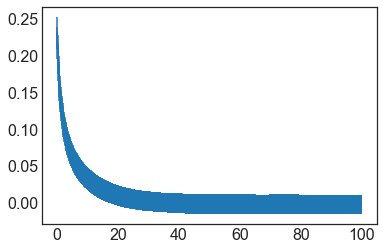

In [5]:
plt.errorbar(t,acf_mean,yerr=acf_std)

In [6]:
N_list=[]
D_list=[]
dN_list=[]
dD_list=[]

NS_list=[]
DS_list=[]
dNS_list=[]
dDS_list=[]

corrfitPB_model=lm.Model(corrfitPB)

for y in acf_all:
    paramsPB = corrfitPB_model.make_params()
    paramsPB['w0'].set(value=1,vary=False)
    paramsPB['N'].set(value=20,vary=True)
    paramsPB['D'].set(value=D,vary=True)
    paramsPB['L'].set(value=L,vary=False)

    resultPB = corrfitPB_model.fit(t=t,data=y,params=paramsPB)
    
    N_list.append(resultPB.values['N'])
    D_list.append(resultPB.values['D'])
    dN_list.append(np.sqrt(resultPB.covar[0,0]))
    dD_list.append(np.sqrt(resultPB.covar[1,1]))
                   
    paramsPBS = corrfitPB_model.make_params()
    paramsPBS['w0'].set(value=1,vary=False)
    paramsPBS['N'].set(value=20,vary=True)
    paramsPBS['D'].set(value=D,vary=True)
    paramsPBS['L'].set(value=L,vary=False)

    resultPBS = corrfitPB_model.fit(t=t,data=y,weights=1/acf_std,params=paramsPBS)
    
    NS_list.append(resultPBS.values['N'])
    DS_list.append(resultPBS.values['D'])
    dNS_list.append(np.sqrt(resultPBS.covar[0,0]))
    dDS_list.append(np.sqrt(resultPBS.covar[1,1]))


In [7]:
N_list = np.array(N_list)
dN_list = np.array(dN_list)
D_list = np.array(D_list)
dD_list = np.array(dD_list)

NS_list = np.array(NS_list)
dNS_list = np.array(dNS_list)
DS_list = np.array(DS_list)
dDS_list = np.array(dDS_list)

3.4762318700253774 0.36979162628526274
5.2323568321048795 0.52597037078458


/Users/hstrey/anaconda3/envs/pymc3/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.
/Users/hstrey/anaconda3/envs/pymc3/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


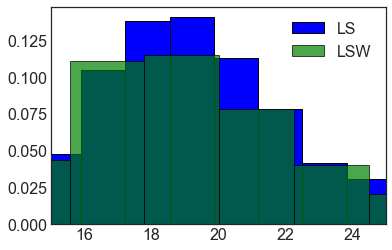

In [8]:
plt.hist(N_list,bins=30,normed=True,color="blue",edgecolor="k",label="LS")
plt.hist(NS_list,bins=30,normed=True,color="green",edgecolor="k",alpha=0.7,label="LSW")
plt.xlim((15,25))
plt.legend()
print(N_list.std(),dN_list.mean())
print(NS_list.std(),dNS_list.mean())

/Users/hstrey/anaconda3/envs/pymc3/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


1.1834616663262145 0.41047277576869545 0.03651357317525822
1.1990027052505638 0.46777579542594255 0.044850291283338395


/Users/hstrey/anaconda3/envs/pymc3/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


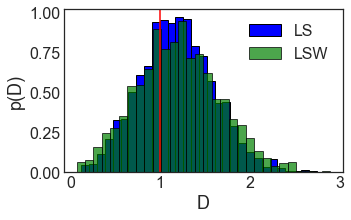

In [9]:
plt.figure(figsize=(5, 3))
plt.hist(D_list,bins=30,normed=True,color="blue",edgecolor="k",label="LS")
plt.hist(DS_list,bins=30,normed=True,color="green",edgecolor="k",label="LSW",alpha=0.7)
plt.axvline(x=1.0,color="r")
plt.xlabel("D")
plt.ylabel("p(D)")

plt.legend()
print(D_list.mean(),D_list.std(),dD_list.mean())
print(DS_list.mean(),DS_list.std(),dDS_list.mean())
#plt.savefig("FCS_D300.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

1.1834616663262145 0.41047277576869545 0.03651357317525822
1.1990027052505638 0.46777579542594255 0.044850291283338395


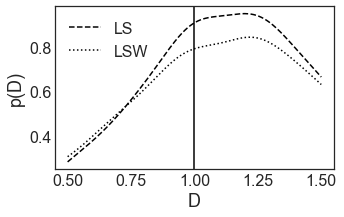

In [10]:
xd = np.linspace(0.5,1.5,200)
densityD = gaussian_kde(D_list)
densityDS = gaussian_kde(DS_list)
plt.figure(figsize=(5, 3))
plt.plot(xd,densityD(xd),"k--",label="LS")
plt.plot(xd,densityDS(xd),"k:",label="LSW")
plt.axvline(x=1.0,color="k")
plt.xlabel("D")
plt.ylabel("p(D)")

plt.legend()
print(D_list.mean(),D_list.std(),dD_list.mean())
print(DS_list.mean(),DS_list.std(),dDS_list.mean())
#plt.savefig("FCS_D300kde.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

1.2332146128231605 0.21784052736447518 0.023173253654210493
1.2536219016136032 0.32788933945781945 0.03296030507566948


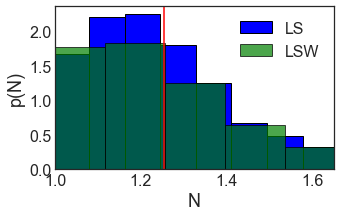

In [11]:
# instead of fitting how many particles per box N, we want to measure how many particles per focus
# size of focus is sqrt(pi/2)*w = 1.25
F_list = N_list/20.0*np.sqrt(np.pi/2)
dF_list = dN_list/20.0*np.sqrt(np.pi/2)
FS_list = NS_list/20.0*np.sqrt(np.pi/2)
dFS_list = dNS_list/20.0*np.sqrt(np.pi/2)

plt.figure(figsize=(5, 3))
plt.hist(F_list,bins=30,density=True,color="blue",edgecolor="k",label="LS")
plt.hist(FS_list,bins=30,density=True,color="green",edgecolor="k",alpha=0.7,label="LSW")
plt.axvline(x=np.sqrt(np.pi/2),color="r")
plt.legend()
plt.xlim((1,1.65))
plt.xlabel("N")
plt.ylabel("p(N)")
print(F_list.mean(),F_list.std(),dF_list.mean())
print(FS_list.mean(),FS_list.std(),dFS_list.mean())
#plt.savefig("FCS_N300.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

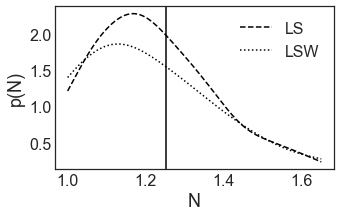

In [12]:
xn = np.linspace(1,1.65,200)
densityF = gaussian_kde(F_list)
densityFS = gaussian_kde(FS_list)
plt.figure(figsize=(5, 3))
plt.plot(xn,densityF(xn),"k--",label="LS")
plt.plot(xn,densityFS(xn),"k:",label="LSW")
plt.axvline(x=np.sqrt(np.pi/2),color="k")
plt.xlabel("N")
plt.ylabel("p(N)")

plt.legend()
#plt.savefig("FCS_N300kde.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [13]:
#find out whether the means are ok
stderr = np.sqrt(N_list.size)
print(D_list.mean(),D_list.std(),dD_list.mean(),D_list.std()/stderr)
print(DS_list.mean(),DS_list.std(),dDS_list.mean(),DS_list.std()/stderr)
print(F_list.mean(),F_list.std(),dF_list.mean(),F_list.std()/stderr)
print(FS_list.mean(),FS_list.std(),dFS_list.mean(),FS_list.std()/stderr)

1.1834616663262145 0.41047277576869545 0.03651357317525822 0.009178450295318314
1.1990027052505638 0.46777579542594255 0.044850291283338395 0.010459784768014426
1.2332146128231605 0.21784052736447518 0.023173253654210493 0.0048710622744136955
1.2536219016136032 0.32788933945781945 0.03296030507566948 0.007331828521251883


In [14]:
N_list2=[]
D_list2=[]
dN_list2=[]
dD_list2=[]

NS_list2=[]
DS_list2=[]
dNS_list2=[]
dDS_list2=[]

w0 = 1.0
L = 10.0
nmax = 5
n = np.arange(1,nmax)
nn,tt = np.meshgrid(n,t)
    
efa = nn*np.pi*w0**2*1j
an = np.exp(-nn**2*np.pi**2*w0**2/2/L**2)*(sf.erf((L**2-efa)/np.sqrt(2)/L/w0)+sf.erf((L**2+efa)/np.sqrt(2)/L/w0))

def residual(pars, x, data=None, eps=None):
    # unpack parameters: extract .value attribute for each parameter
    parvals = pars.valuesdict()
    N = parvals['N']
    D = parvals['D']

    ann = np.absolute(an)**2*np.exp(-D*nn**2*np.pi**2*tt/L**2)
    model = np.sum(ann,axis=1)/N/2

    if data is None:
        return model
    if eps is None:
        return model - data
    return (model-data) / eps

for y in acf_all:
    pars = lm.Parameters()
    pars.add_many(('D', 1), ('N', 20))

    result = lm.minimize(residual, pars,kws = {'x':t,'data':y,'eps':acf_std})
    #result.params.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2))
    res = lm.minimize(residual, kws = {'x':t,'data':y,'eps':acf_std},method='emcee', nan_policy='omit', burn=300, steps=1000, thin=20,
                     params=result.params)

    print(lm.fit_report(result.params))
    N_list2.append(result.params.valuesdict()['N'])
    D_list2.append(result.params.valuesdict()['D'])
    dD_list2.append(np.sqrt(result.covar[0,0]))
    dN_list2.append(np.sqrt(result.covar[1,1]))
    print(N_list2[-1],D_list2[-1],dN_list2[-1],dD_list2[-1])

    NS_list2.append(res.flatchain['N'].mean())
    DS_list2.append(res.flatchain['D'].mean())
    dNS_list2.append(res.flatchain['N'].std())
    dDS_list2.append(res.flatchain['D'].std())
    print(NS_list2[-1],DS_list2[-1],dNS_list2[-1],dDS_list2[-1])
    



/Users/hstrey/anaconda3/envs/pymc3/lib/python3.6/site-packages/emcee/ensemble.py:258: RuntimeWarning: Initial state is not linearly independent and it will not allow a full exploration of parameter space
  category=RuntimeWarning,
  1%|          | 7/1000 [00:00<00:14, 66.81it/s]

[[Variables]]
    D:  0.59835864 +/- 0.01489796 (2.49%) (init = 1)
    N:  26.7817108 +/- 0.49551037 (1.85%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.805
26.78171076391566 0.5983586389462072 0.4955103690786678 0.014897964590365124
26.795678224110294 0.6006417353222783 0.9969479456791965 0.03178056101501959


  1%|          | 7/1000 [00:00<00:14, 67.04it/s]

[[Variables]]
    D:  1.94444747 +/- 0.07273724 (3.74%) (init = 1)
    N:  15.0813342 +/- 0.40845633 (2.71%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.776
15.08133416843545 1.944447466867171 0.4084563338063374 0.07273723581335693
15.100645933845906 1.9459801954022657 0.47260117580250216 0.08008040779116839


  1%|          | 7/1000 [00:00<00:14, 67.40it/s]

[[Variables]]
    D:  1.23678904 +/- 0.04014705 (3.25%) (init = 1)
    N:  18.4413438 +/- 0.44186783 (2.40%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
18.441343785362903 1.2367890355076876 0.4418678277688965 0.04014704538028417
18.476847787015735 1.2377731271319776 0.5501601182904715 0.048273297517117945


  1%|          | 7/1000 [00:00<00:15, 65.47it/s]

[[Variables]]
    D:  1.19921636 +/- 0.04741074 (3.95%) (init = 1)
    N:  26.3753767 +/- 0.77057782 (2.92%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
26.375376748615814 1.1992163589299425 0.770577824854446 0.047410743533876025
26.364048344846918 1.2096489824883685 1.1752953405360413 0.07313096299401159


  1%|          | 7/1000 [00:00<00:14, 67.38it/s]

[[Variables]]
    D:  1.76564335 +/- 0.08148393 (4.61%) (init = 1)
    N:  17.5757680 +/- 0.58965117 (3.35%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.779
17.5757679718059 1.7656433522098196 0.589651170614553 0.08148393195440026
17.614252265137143 1.7672314720601148 0.5771457093951932 0.0723353037863011


  1%|          | 7/1000 [00:00<00:14, 67.26it/s]

[[Variables]]
    D:  1.43244047 +/- 0.06449620 (4.50%) (init = 1)
    N:  19.0355051 +/- 0.62908014 (3.30%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
19.035505061656007 1.4324404676234965 0.6290801386841075 0.0644961992153015
19.079555662623683 1.4341938537501902 0.6185695496832915 0.05782781652721982


  1%|          | 7/1000 [00:00<00:15, 66.10it/s]

[[Variables]]
    D:  0.41776616 +/- 0.00683453 (1.64%) (init = 1)
    N:  19.7532425 +/- 0.23740011 (1.20%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.813
19.753242536927356 0.41776616425524804 0.23740010566191308 0.006834533593324262
19.759840131420574 0.41790488462878217 0.37304760104216 0.010504985915677053


  1%|          | 7/1000 [00:00<00:14, 67.08it/s]

[[Variables]]
    D:  1.70436363 +/- 0.04460425 (2.62%) (init = 1)
    N:  18.7804157 +/- 0.35832213 (1.91%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.780
18.78041570757962 1.704363633799505 0.358322130751812 0.04460425296963549
18.794611180885884 1.7107499861177649 0.6724611401151874 0.08056111898831551


  1%|          | 7/1000 [00:00<00:14, 66.45it/s]

[[Variables]]
    D:  1.22662725 +/- 0.04306775 (3.51%) (init = 1)
    N:  17.7010681 +/- 0.45898357 (2.59%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
17.701068062471332 1.22662724909353 0.4589835716075834 0.043067745581320524
17.72910674260689 1.2275818921942843 0.5453765985137559 0.05041309081166228


  1%|          | 7/1000 [00:00<00:15, 64.48it/s]

[[Variables]]
    D:  1.75254549 +/- 0.06769216 (3.86%) (init = 1)
    N:  17.7069036 +/- 0.49751261 (2.81%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.779
17.706903632207876 1.7525454876302866 0.4975126133087778 0.0676921552934364
17.749787188487268 1.7528104978313435 0.6148336464586416 0.07715648844973616


  1%|          | 7/1000 [00:00<00:14, 67.66it/s]

[[Variables]]
    D:  2.44930471 +/- 0.07742741 (3.16%) (init = 1)
    N:  17.3193748 +/- 0.39069546 (2.26%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.768
17.319374755873387 2.4493047122078315 0.39069546123836896 0.07742741374880771
17.36351955548099 2.455513487844292 0.6969590035176995 0.1304078293285755


  1%|          | 7/1000 [00:00<00:14, 66.60it/s]

[[Variables]]
    D:  1.88715626 +/- 0.06569794 (3.48%) (init = 1)
    N:  17.1121786 +/- 0.43178670 (2.52%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.777
17.11217860188621 1.887156263506155 0.43178670410749076 0.06569793796559424
17.133620236156094 1.892189067046462 0.5903684427220641 0.08451591275823314


  1%|          | 7/1000 [00:00<00:15, 65.78it/s]

[[Variables]]
    D:  1.29205652 +/- 0.03907474 (3.02%) (init = 1)
    N:  18.1540725 +/- 0.40484209 (2.23%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
18.15407245788312 1.2920565212387147 0.40484208739459426 0.03907473663130293
18.176058862914775 1.293116977405497 0.5800103862237076 0.05487688930790922


  1%|          | 7/1000 [00:00<00:15, 64.97it/s]

[[Variables]]
    D:  1.51561863 +/- 0.05580843 (3.68%) (init = 1)
    N:  20.4531580 +/- 0.55203456 (2.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
20.453157997655143 1.5156186254267756 0.5520345634920113 0.055808428358581644
20.493912109764626 1.5168825628170317 0.7312189915589403 0.06996867553714244


  1%|          | 7/1000 [00:00<00:14, 67.36it/s]

[[Variables]]
    D:  0.38309476 +/- 0.00831037 (2.17%) (init = 1)
    N:  27.2219312 +/- 0.43148678 (1.59%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.815
27.22193124150312 0.38309476034043255 0.43148677709859035 0.008310371756244987
27.23598298689533 0.38385657564720926 0.7710271217542343 0.015361107909766122


  1%|          | 7/1000 [00:00<00:14, 66.82it/s]

[[Variables]]
    D:  0.90820507 +/- 0.02344152 (2.58%) (init = 1)
    N:  21.3471293 +/- 0.40965349 (1.92%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
21.347129288604876 0.9082050744281677 0.40965349036393733 0.023441523073120186
21.354935427642623 0.9099103541427653 0.637987394258714 0.03593276800424964


  1%|          | 7/1000 [00:00<00:14, 66.78it/s]

[[Variables]]
    D:  1.58212640 +/- 0.06682528 (4.22%) (init = 1)
    N:  16.3986504 +/- 0.50625794 (3.09%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.782
16.398650433602413 1.5821263987771421 0.5062579375619295 0.06682527536797002
16.418555440219148 1.5838818581206293 0.46031013358989076 0.0551360590926604


  1%|          | 7/1000 [00:00<00:14, 66.42it/s]

[[Variables]]
    D:  1.43887875 +/- 0.05975883 (4.15%) (init = 1)
    N:  12.9702357 +/- 0.39580118 (3.05%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
12.970235692979402 1.4388787481709069 0.3958011827132921 0.05975883263180666
12.965876818071624 1.4406410488061239 0.2724254526924926 0.03656280176476081


  1%|          | 7/1000 [00:00<00:15, 65.78it/s]

[[Variables]]
    D:  0.80156775 +/- 0.01721579 (2.15%) (init = 1)
    N:  19.3689639 +/- 0.30959456 (1.60%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
19.36896392176769 0.8015677483377376 0.3095945607218047 0.01721579033775251
19.399906689949642 0.8019251992116027 0.502225816842984 0.027267955405308554


  1%|          | 7/1000 [00:00<00:14, 67.60it/s]

[[Variables]]
    D:  0.81121586 +/- 0.02774113 (3.42%) (init = 1)
    N:  19.2496057 +/- 0.48982652 (2.54%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
19.24960571050584 0.811215863330377 0.4898265150988339 0.02774113443915135
19.274247648201943 0.8115249111544397 0.4362301467540528 0.02237405008575712


  1%|          | 7/1000 [00:00<00:14, 67.43it/s]

[[Variables]]
    D:  1.03329525 +/- 0.03743300 (3.62%) (init = 1)
    N:  14.8963363 +/- 0.40025294 (2.69%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
14.896336264712852 1.033295254680027 0.4002529422194001 0.03743300134719972
14.902208570384436 1.0339921195638864 0.3090132913269332 0.0270870827574139


  1%|          | 7/1000 [00:00<00:14, 67.94it/s]

[[Variables]]
    D:  1.39279829 +/- 0.05915559 (4.25%) (init = 1)
    N:  18.1033728 +/- 0.56492360 (3.12%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
18.1033728427721 1.3927982911928452 0.5649235952041215 0.059155592980750994
18.12145912677485 1.3954540659316532 0.5354933914573121 0.04962574264810255


  1%|          | 7/1000 [00:00<00:14, 67.04it/s]

[[Variables]]
    D:  2.43401566 +/- 0.09335789 (3.84%) (init = 1)
    N:  20.9538053 +/- 0.57371165 (2.74%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.768
20.953805334538945 2.4340156648593347 0.573711650235277 0.0933578889312553
21.04333326802001 2.4423245919403738 1.0760359389050853 0.17159063577446806


  1%|          | 7/1000 [00:00<00:14, 67.71it/s]

[[Variables]]
    D:  1.15787759 +/- 0.04543334 (3.92%) (init = 1)
    N:  22.3009875 +/- 0.64764807 (2.90%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
22.300987485536577 1.1578775903438343 0.6476480673014823 0.045433340031334986
22.317219752100616 1.1642392804513284 0.8862678628365593 0.0631601121664295


  1%|          | 7/1000 [00:00<00:15, 65.31it/s]

[[Variables]]
    D:  1.77084887 +/- 0.06558663 (3.70%) (init = 1)
    N:  16.2138479 +/- 0.43656432 (2.69%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.779
16.213847871414263 1.7708488745066955 0.436564317602946 0.06558663105618064
16.25425435824556 1.7712396669946782 0.477205951547239 0.06493620764381357


  1%|          | 7/1000 [00:00<00:14, 66.20it/s]

[[Variables]]
    D:  2.43802749 +/- 0.10367207 (4.25%) (init = 1)
    N:  17.4813691 +/- 0.53037366 (3.03%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.768
17.48136912871047 2.43802749124915 0.5303736640249085 0.10367206657854099
17.53503610806717 2.443531498321691 0.7285442798607903 0.13818683659349282


  1%|          | 7/1000 [00:00<00:14, 67.50it/s]

[[Variables]]
    D:  1.30709008 +/- 0.08316685 (6.36%) (init = 1)
    N:  13.5085210 +/- 0.63292930 (4.69%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
13.508520980804498 1.3070900827992789 0.6329292985460419 0.08316684612668693
13.514803775251291 1.3082758099516067 0.29111609306629604 0.03331668427582001


  1%|          | 7/1000 [00:00<00:14, 67.32it/s]

[[Variables]]
    D:  0.81115060 +/- 0.01757719 (2.17%) (init = 1)
    N:  23.1203110 +/- 0.37295755 (1.61%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
23.120311023022953 0.811150600628003 0.3729575530181365 0.01757718711561322
23.151610604884397 0.8125557817827261 0.7543738204363617 0.03664921205474885


  1%|          | 7/1000 [00:00<00:14, 67.14it/s]

[[Variables]]
    D:  1.12670809 +/- 0.03933709 (3.49%) (init = 1)
    N:  14.3388130 +/- 0.37077892 (2.59%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
14.338813026875757 1.1267080865636547 0.37077891521971146 0.03933708855300701
14.346664144793317 1.12800527068713 0.3093925068961404 0.03018894399475487


  1%|          | 7/1000 [00:00<00:14, 68.30it/s]

[[Variables]]
    D:  1.98089798 +/- 0.10911085 (5.51%) (init = 1)
    N:  17.0809357 +/- 0.68035321 (3.98%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.775
17.08093573966072 1.9808979822453252 0.6803532096444237 0.10911085161787844
17.141355571016046 1.9794336478118209 0.6699414445223215 0.10782732072634542


  1%|          | 7/1000 [00:00<00:14, 66.87it/s]

[[Variables]]
    D:  1.28560540 +/- 0.04916051 (3.82%) (init = 1)
    N:  17.7196930 +/- 0.49977170 (2.82%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
17.71969297601899 1.2856053964662901 0.49977169784064157 0.049160511548560853
17.7420913369323 1.2863610051395524 0.5198209679420958 0.04892352159187736


  1%|          | 7/1000 [00:00<00:14, 68.15it/s]

[[Variables]]
    D:  1.25271806 +/- 0.05172687 (4.13%) (init = 1)
    N:  19.0083168 +/- 0.57950534 (3.05%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
19.008316784664967 1.2527180647095804 0.5795053436712112 0.05172686885728005
19.02048483866083 1.2572721637014577 0.5982868354683685 0.05123836680637348


  1%|          | 7/1000 [00:00<00:14, 66.72it/s]

[[Variables]]
    D:  1.67685646 +/- 0.08498166 (5.07%) (init = 1)
    N:  19.1336362 +/- 0.70748852 (3.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.780
19.133636193558747 1.6768564592904691 0.7074885158187216 0.08498165853634185
19.14885373940844 1.6803216021538538 0.6767598422121589 0.0770015108464432


  1%|          | 7/1000 [00:00<00:14, 67.75it/s]

[[Variables]]
    D:  1.24379008 +/- 0.04761957 (3.83%) (init = 1)
    N:  23.2877871 +/- 0.65843433 (2.83%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
23.28778714643028 1.2437900750380546 0.6584343263603116 0.04761956902378994
23.349624268843975 1.2492296566103045 1.1566190364315743 0.091912069650767


  1%|          | 7/1000 [00:00<00:14, 66.59it/s]

[[Variables]]
    D:  0.69547624 +/- 0.02227865 (3.20%) (init = 1)
    N:  22.3457865 +/- 0.53285722 (2.38%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
22.34578648588172 0.6954762403359758 0.532857216702765 0.022278653661537594
22.339886812050988 0.6964478968642136 0.6349198956292642 0.026028786397989483


  1%|          | 7/1000 [00:00<00:14, 67.08it/s]

[[Variables]]
    D:  0.83763773 +/- 0.01813577 (2.17%) (init = 1)
    N:  19.1179979 +/- 0.30809217 (1.61%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
19.117997877046722 0.8376377272905595 0.3080921707821424 0.01813577111971397
19.121931269766577 0.8393637489970159 0.4927073131451582 0.028483405342965035


  1%|          | 7/1000 [00:00<00:14, 67.56it/s]

[[Variables]]
    D:  1.16964381 +/- 0.05253821 (4.49%) (init = 1)
    N:  20.8533043 +/- 0.69314190 (3.32%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
20.853304331415114 1.1696438127449784 0.6931419022627326 0.052538210752804744
20.897203669781742 1.1733524599197873 0.8093729479301892 0.0643515513293805


  1%|          | 7/1000 [00:00<00:14, 67.33it/s]

[[Variables]]
    D:  0.68496355 +/- 0.01928590 (2.82%) (init = 1)
    N:  19.0436262 +/- 0.39911081 (2.10%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
19.04362619532248 0.6849635491606804 0.3991108083363071 0.019285900114189975
19.05509866386699 0.6854507071736915 0.451131901446318 0.021220172686329614


  1%|          | 7/1000 [00:00<00:14, 66.74it/s]

[[Variables]]
    D:  1.07251284 +/- 0.05142337 (4.79%) (init = 1)
    N:  18.3282530 +/- 0.65138898 (3.55%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.328252990136072 1.0725128435398885 0.6513889788344734 0.05142336834299495
18.337243959763338 1.0755556922747274 0.5324019575659918 0.041705099327354896


  1%|          | 7/1000 [00:00<00:14, 67.61it/s]

[[Variables]]
    D:  0.96057772 +/- 0.04948615 (5.15%) (init = 1)
    N:  20.1160682 +/- 0.76956099 (3.83%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
20.116068166235056 0.9605777221825772 0.7695609876901055 0.04948614651059129
20.1404081292453 0.9615445902272654 0.5721661187725868 0.03510722214527239


  1%|          | 7/1000 [00:00<00:14, 67.14it/s]

[[Variables]]
    D:  1.18786806 +/- 0.03022242 (2.54%) (init = 1)
    N:  15.8637251 +/- 0.29844192 (1.88%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
15.863725064390486 1.1878680589682968 0.29844192452552554 0.030222424385055506
15.885533399907416 1.1883273963259555 0.40357525340544814 0.03963276358143713


  1%|          | 7/1000 [00:00<00:14, 67.08it/s]

[[Variables]]
    D:  1.22537894 +/- 0.05341854 (4.36%) (init = 1)
    N:  18.9473931 +/- 0.60969216 (3.22%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
18.94739306461625 1.225378940451201 0.6096921638994593 0.0534185356429282
18.969114634277457 1.2285906075135582 0.5463797106905703 0.042693498783439955


  1%|          | 7/1000 [00:00<00:14, 66.94it/s]

[[Variables]]
    D:  0.61691841 +/- 0.02603046 (4.22%) (init = 1)
    N:  25.7855993 +/- 0.80912044 (3.14%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.804
25.785599285438867 0.616918412748473 0.809120435723421 0.026030458311774092
25.801507374479755 0.6181470149526272 0.8040354814607336 0.025683857857674634


  1%|          | 7/1000 [00:00<00:14, 66.57it/s]

[[Variables]]
    D:  1.30380228 +/- 0.04538765 (3.48%) (init = 1)
    N:  21.5017420 +/- 0.55161292 (2.57%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
21.501742011437727 1.303802280978108 0.5516129187113581 0.045387647871327555
21.53614068859788 1.3083208387662228 0.798213784578832 0.0660435498647639


  1%|          | 7/1000 [00:00<00:14, 67.85it/s]

[[Variables]]
    D:  0.85093615 +/- 0.02723165 (3.20%) (init = 1)
    N:  24.8719855 +/- 0.59210478 (2.38%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
24.871985508325437 0.8509361460343601 0.5921047811445406 0.027231652806696555
24.927879414007464 0.8523604206400343 0.9773467567222925 0.04582537050353572


  1%|          | 7/1000 [00:00<00:15, 63.32it/s]

[[Variables]]
    D:  1.26966968 +/- 0.04911379 (3.87%) (init = 1)
    N:  17.2913306 +/- 0.49321647 (2.85%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
17.291330646128728 1.2696696849618907 0.4932164669322714 0.04911378726552375
17.311246116668688 1.2716069425182268 0.4612636336386114 0.04344271385676859


  1%|          | 6/1000 [00:00<00:17, 58.08it/s]

[[Variables]]
    D:  1.20125442 +/- 0.03481913 (2.90%) (init = 1)
    N:  18.4273783 +/- 0.39472127 (2.14%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
18.427378341427882 1.2012544205273634 0.3947212712769895 0.03481912659197888
18.438377298740566 1.2041177864272101 0.5913742321633285 0.052039821507024575


  1%|          | 7/1000 [00:00<00:15, 65.11it/s]

[[Variables]]
    D:  1.59304001 +/- 0.05490960 (3.45%) (init = 1)
    N:  13.8709324 +/- 0.34966286 (2.52%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.782
13.870932368297233 1.5930400121100914 0.3496628635853137 0.05490959958121272
13.883657219360384 1.5947317793780258 0.3372407305530698 0.04923330910642351


  1%|          | 7/1000 [00:00<00:15, 64.77it/s]

[[Variables]]
    D:  1.06166734 +/- 0.03755147 (3.54%) (init = 1)
    N:  21.9196169 +/- 0.57506641 (2.62%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
21.919616931079464 1.0616673444055147 0.575066413997701 0.03755146994719392
21.953425241493118 1.0641985728734198 0.8078743528943922 0.054538614385414935


  1%|          | 7/1000 [00:00<00:14, 67.85it/s]

[[Variables]]
    D:  1.11079823 +/- 0.02979970 (2.68%) (init = 1)
    N:  17.8473973 +/- 0.35456852 (1.99%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
17.84739726134726 1.1107982259875988 0.3545685198736695 0.029799695490014926
17.848557151618596 1.1127565820047112 0.4960944912842217 0.03994372510305686


  1%|          | 7/1000 [00:00<00:14, 67.25it/s]

[[Variables]]
    D:  0.23702427 +/- 0.01087053 (4.59%) (init = 1)
    N:  53.4798534 +/- 1.68732526 (3.16%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.836
53.479853426087665 0.23702426644407604 1.6873252565290588 0.010870525835429665
53.65015364922192 0.23749088830738171 2.537085921892737 0.017071600759166698


  1%|          | 7/1000 [00:00<00:14, 66.98it/s]

[[Variables]]
    D:  1.36065252 +/- 0.05114978 (3.76%) (init = 1)
    N:  16.2177409 +/- 0.44880272 (2.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
16.217740921717365 1.3606525180359752 0.44880271737885163 0.051149776915142456
16.234507703013193 1.361806626386447 0.4315650531868168 0.04398477839125804


  1%|          | 7/1000 [00:00<00:14, 67.27it/s]

[[Variables]]
    D:  1.43398941 +/- 0.06626420 (4.62%) (init = 1)
    N:  18.1597976 +/- 0.61616014 (3.39%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
18.159797628984943 1.4339894065048422 0.6161601359433904 0.0662642019082364
18.17125647294129 1.438325258533461 0.5944741704527617 0.06339806337693546


  1%|          | 7/1000 [00:00<00:14, 67.29it/s]

[[Variables]]
    D:  0.63442314 +/- 0.02084719 (3.29%) (init = 1)
    N:  18.1026985 +/- 0.44234911 (2.44%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.804
18.10269847378713 0.6344231365701634 0.4423491052511572 0.020847193756539827
18.115871250576607 0.6346948194679004 0.37620217536797834 0.0171275837514602


  1%|          | 7/1000 [00:00<00:14, 67.72it/s]

[[Variables]]
    D:  1.00121628 +/- 0.01757437 (1.76%) (init = 1)
    N:  17.9128977 +/- 0.23342616 (1.30%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
17.91289770330639 1.0012162751612987 0.23342616093982368 0.0175743658420638
17.938576206111776 1.0020825167212668 0.48508952564384167 0.03544854574502436


  1%|          | 7/1000 [00:00<00:14, 67.09it/s]

[[Variables]]
    D:  0.84055234 +/- 0.03302861 (3.93%) (init = 1)
    N:  18.4056189 +/- 0.53858519 (2.93%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
18.405618934752706 0.8405523363868401 0.5385851874133523 0.03302860527686473
18.422116207841952 0.8413744878071393 0.4410433386234204 0.026085515449977538


  1%|          | 7/1000 [00:00<00:14, 67.70it/s]

[[Variables]]
    D:  1.62496923 +/- 0.09898325 (6.09%) (init = 1)
    N:  14.5059902 +/- 0.64542721 (4.45%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.781
14.50599022552253 1.6249692256702717 0.6454272096632652 0.09898324931196621
14.529743888873156 1.6264668318146305 0.40962009831767965 0.059886344077566434


  1%|          | 7/1000 [00:00<00:14, 67.78it/s]

[[Variables]]
    D:  2.66638476 +/- 0.11289556 (4.23%) (init = 1)
    N:  16.7321133 +/- 0.50254074 (3.00%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.764
16.73211325553065 2.666384762191912 0.5025407354652832 0.11289555757660119
16.819078011362155 2.670126060013493 0.7109143125935997 0.15519784650379226


  1%|          | 7/1000 [00:00<00:15, 63.58it/s]

[[Variables]]
    D:  0.73766185 +/- 0.02406076 (3.26%) (init = 1)
    N:  21.4093081 +/- 0.51981906 (2.43%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
21.40930812797842 0.7376618505141138 0.519819062688627 0.024060760160673638
21.403442473835284 0.7396647822793623 0.5318972013506229 0.023158809131048223


  1%|          | 7/1000 [00:00<00:14, 67.48it/s]

[[Variables]]
    D:  1.43898167 +/- 0.04539123 (3.15%) (init = 1)
    N:  22.9493855 +/- 0.53170137 (2.32%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
22.949385472201868 1.4389816732382947 0.531701368121441 0.045391234013881204
22.946571910733613 1.4492533023869971 1.1307784252239834 0.1036529923571339


  1%|          | 7/1000 [00:00<00:15, 65.85it/s]

[[Variables]]
    D:  1.67371961 +/- 0.05556426 (3.32%) (init = 1)
    N:  14.7154180 +/- 0.35624768 (2.42%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.780
14.715417960823002 1.6737196085072275 0.35624767861096895 0.05556425582156175
14.727822291784626 1.6753873709391731 0.41129494695143487 0.05787257325698644


  1%|          | 7/1000 [00:00<00:14, 67.14it/s]

[[Variables]]
    D:  1.01814086 +/- 0.03205145 (3.15%) (init = 1)
    N:  17.5734541 +/- 0.41053507 (2.34%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
17.57345406555163 1.0181408570962582 0.41053506953037183 0.032051450319890006
17.573945814711387 1.019664269101365 0.47370746630736266 0.036215045859258846


  1%|          | 7/1000 [00:00<00:14, 67.11it/s]

[[Variables]]
    D:  1.46831571 +/- 0.06216573 (4.23%) (init = 1)
    N:  15.6963737 +/- 0.48746816 (3.11%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
15.696373742245969 1.468315712850762 0.48746815705274643 0.0621657295496796
15.70852184663545 1.470230615695054 0.43336276631688875 0.05215466759347464


  1%|          | 7/1000 [00:00<00:15, 66.04it/s]

[[Variables]]
    D:  0.94018187 +/- 0.03548706 (3.77%) (init = 1)
    N:  21.6813150 +/- 0.60802453 (2.80%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
21.68131502175278 0.9401818656511357 0.6080245278491725 0.035487059944079455
21.724053858938518 0.9403197966834835 0.816895261422416 0.05162421915401286


  1%|          | 7/1000 [00:00<00:14, 67.65it/s]

[[Variables]]
    D:  1.18001655 +/- 0.03789541 (3.21%) (init = 1)
    N:  25.5134167 +/- 0.60596558 (2.38%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
25.513416684191135 1.180016552303542 0.6059655841412652 0.03789540886544853
25.571585169131332 1.184882879760427 1.2412546510861282 0.08083208173203696


  1%|          | 7/1000 [00:00<00:15, 65.02it/s]

[[Variables]]
    D:  1.25350168 +/- 0.06230725 (4.97%) (init = 1)
    N:  19.8937332 +/- 0.73004421 (3.67%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
19.893733223667027 1.253501675987605 0.7300442127636105 0.0623072459134461
19.948534726216412 1.2551428882143194 0.8050780338780753 0.07447820925907525


  1%|          | 7/1000 [00:00<00:14, 67.56it/s]

[[Variables]]
    D:  0.65247668 +/- 0.02322922 (3.56%) (init = 1)
    N:  20.6018758 +/- 0.54601696 (2.65%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
20.601875819520842 0.6524766817996425 0.5460169637150126 0.023229218092058666
20.614432924764955 0.6529980681149085 0.4620264771207456 0.018266381331567126


  1%|          | 7/1000 [00:00<00:14, 67.00it/s]

[[Variables]]
    D:  1.34264356 +/- 0.03104049 (2.31%) (init = 1)
    N:  19.8161360 +/- 0.33725922 (1.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
19.816135976290504 1.3426435646313493 0.33725921853762275 0.03104049067536697
19.857377251785866 1.34473430816844 0.7129200976268998 0.06553907357155249


  1%|          | 7/1000 [00:00<00:14, 68.28it/s]

[[Variables]]
    D:  0.83512923 +/- 0.03596599 (4.31%) (init = 1)
    N:  21.8078736 +/- 0.69916138 (3.21%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
21.807873552807195 0.8351292288440979 0.6991613815197193 0.03596599348698422
21.829362390039652 0.8377655243191792 0.7030347416756313 0.03614206080730375


  1%|          | 7/1000 [00:00<00:14, 66.47it/s]

[[Variables]]
    D:  1.28070634 +/- 0.03595550 (2.81%) (init = 1)
    N:  20.0888100 +/- 0.41593316 (2.07%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
20.08880996956489 1.2807063354397823 0.41593316013192155 0.035955502832575474
20.105997930844318 1.2847153054231955 0.7044808162503159 0.06162402886440058


  1%|          | 7/1000 [00:00<00:14, 67.24it/s]

[[Variables]]
    D:  1.57178935 +/- 0.05925320 (3.77%) (init = 1)
    N:  17.3716006 +/- 0.47908571 (2.76%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.782
17.371600606280044 1.5717893515056105 0.4790857055185579 0.05925320422166262
17.393231664081284 1.5757974429355874 0.5732782488291354 0.06966547525311913


  1%|          | 7/1000 [00:00<00:14, 66.67it/s]

[[Variables]]
    D:  0.58723175 +/- 0.01289533 (2.20%) (init = 1)
    N:  22.1488568 +/- 0.36136110 (1.63%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.805
22.14885678546038 0.5872317461030409 0.36136109915236514 0.012895334616268066
22.17190907513218 0.5883651471487781 0.566670789451086 0.019891654214994767


  1%|          | 7/1000 [00:00<00:14, 66.42it/s]

[[Variables]]
    D:  0.90252294 +/- 0.02357286 (2.61%) (init = 1)
    N:  17.4390349 +/- 0.33870898 (1.94%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
17.439034945999254 0.90252293562863 0.33870897826315716 0.02357285694511332
17.469490200890206 0.9029041860974651 0.42238393126187757 0.02884301022394218


  1%|          | 7/1000 [00:00<00:14, 67.79it/s]

[[Variables]]
    D:  0.53904337 +/- 0.01444430 (2.68%) (init = 1)
    N:  26.2333332 +/- 0.52139426 (1.99%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.807
26.233333208736568 0.5390433650148223 0.5213942637978628 0.014444297113352699
26.276110668975743 0.5390283846782171 0.7701667956164084 0.02095176199988233


  1%|          | 7/1000 [00:00<00:14, 67.40it/s]

[[Variables]]
    D:  0.36312392 +/- 0.01098076 (3.02%) (init = 1)
    N:  32.7018222 +/- 0.71968909 (2.20%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.817
32.70182217741699 0.36312392053964215 0.7196890890340596 0.010980764140665709
32.740968460542724 0.36370294816147997 1.173857837284958 0.01954273170495235


  1%|          | 7/1000 [00:00<00:14, 66.98it/s]

[[Variables]]
    D:  0.88234938 +/- 0.02176353 (2.47%) (init = 1)
    N:  23.9120285 +/- 0.43873287 (1.83%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
23.91202852150594 0.8823493834409357 0.43873287300738817 0.02176353388008759
23.92308220190049 0.8850834649045307 0.8303573868046842 0.04161544765413769


  1%|          | 7/1000 [00:00<00:14, 66.43it/s]

[[Variables]]
    D:  1.15082899 +/- 0.04248106 (3.69%) (init = 1)
    N:  18.9661107 +/- 0.51808910 (2.73%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
18.966110699566194 1.1508289865111372 0.5180891015735194 0.0424810614440791
19.001744949065237 1.152342588837013 0.5774100566519447 0.046669037336397684


  1%|          | 7/1000 [00:00<00:14, 67.09it/s]

[[Variables]]
    D:  0.96052765 +/- 0.02800628 (2.92%) (init = 1)
    N:  18.8069481 +/- 0.40740705 (2.17%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
18.80694814236886 0.9605276534551289 0.40740705250665693 0.028006281545174653
18.823465914747995 0.9626227343890683 0.553927380660427 0.03849297229922148


  1%|          | 7/1000 [00:00<00:14, 67.92it/s]

[[Variables]]
    D:  1.20600040 +/- 0.05176873 (4.29%) (init = 1)
    N:  19.5705486 +/- 0.62046700 (3.17%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
19.57054857487314 1.2060004002206441 0.6204670037895897 0.051768732639418294
19.59644004926832 1.208639054481067 0.5672376182995377 0.043638818720422703


  1%|          | 7/1000 [00:00<00:14, 67.45it/s]

[[Variables]]
    D:  1.32890366 +/- 0.07883314 (5.93%) (init = 1)
    N:  16.0591034 +/- 0.70218718 (4.37%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
16.059103385794486 1.3289036634951579 0.7021871800834635 0.07883313921043598
16.078368894554004 1.3293383561278271 0.40492940279714873 0.039706031453239185


  1%|          | 7/1000 [00:00<00:14, 67.22it/s]

[[Variables]]
    D:  1.73020247 +/- 0.05755503 (3.33%) (init = 1)
    N:  18.0800762 +/- 0.43781902 (2.42%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.779
18.080076242384944 1.7302024695203853 0.43781901716822935 0.057555031135345165
18.125668987747154 1.7342656236778367 0.6629125937412257 0.08476844917589607


  1%|          | 7/1000 [00:00<00:14, 67.81it/s]

[[Variables]]
    D:  1.78144057 +/- 0.06338262 (3.56%) (init = 1)
    N:  25.2637836 +/- 0.65352323 (2.59%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.778
25.263783618111116 1.781440567478581 0.653523234752431 0.06338261664078963
25.392930472973053 1.7865915610584489 1.3319778654417307 0.13029190279931435


  1%|          | 7/1000 [00:00<00:14, 66.57it/s]

[[Variables]]
    D:  1.18770197 +/- 0.02513305 (2.12%) (init = 1)
    N:  17.5362649 +/- 0.27426922 (1.56%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
17.536264902440205 1.187701974379328 0.2742692157896898 0.02513305187344873
17.56427559202331 1.189446270267088 0.5202154355429258 0.04581653015147627


  1%|          | 7/1000 [00:00<00:14, 67.44it/s]

[[Variables]]
    D:  0.11896434 +/- 0.00763191 (6.42%) (init = 1)
    N:  53.1000169 +/- 1.95725540 (3.69%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.875
53.10001690147052 0.11896433774482428 1.9572554031796656 0.007631914025871691
53.18203292802245 0.11898085190583384 1.8918959717722919 0.007677947134343839


  1%|          | 7/1000 [00:00<00:14, 68.10it/s]

[[Variables]]
    D:  1.00030229 +/- 0.03914149 (3.91%) (init = 1)
    N:  17.5867606 +/- 0.51089646 (2.91%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
17.586760592742596 1.0003022924543796 0.5108964606825187 0.03914148831310987
17.589857398300992 1.0023153751245328 0.4606427096537649 0.033811144286304926


  1%|          | 7/1000 [00:00<00:14, 67.61it/s]

[[Variables]]
    D:  1.13741341 +/- 0.05702612 (5.01%) (init = 1)
    N:  17.3479116 +/- 0.64428366 (3.71%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
17.347911605461444 1.1374134070055815 0.644283659220916 0.05702611753175951
17.36401671919869 1.1393519791339932 0.4450692974466414 0.03736278436000723


  1%|          | 7/1000 [00:00<00:14, 67.49it/s]

[[Variables]]
    D:  1.50874901 +/- 0.06290944 (4.17%) (init = 1)
    N:  16.7412401 +/- 0.51125541 (3.05%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
16.74124010219734 1.5087490121960374 0.5112554147025912 0.06290943847253076
16.780945505424633 1.5093114703997281 0.489414998615169 0.056337789176207256


  1%|          | 7/1000 [00:00<00:15, 66.14it/s]

[[Variables]]
    D:  0.54455778 +/- 0.00949041 (1.74%) (init = 1)
    N:  22.0173704 +/- 0.28475154 (1.29%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.807
22.017370406006897 0.5445577777834038 0.28475153633061356 0.009490411396555666
22.062100313908044 0.5441425173415636 0.5080033548320538 0.016263627438569725


  1%|          | 7/1000 [00:00<00:14, 66.90it/s]

[[Variables]]
    D:  1.29935181 +/- 0.04109958 (3.16%) (init = 1)
    N:  19.9918981 +/- 0.46595950 (2.33%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
19.991898131106613 1.2993518136024118 0.46595949815480525 0.04109958379341379
20.01458938250169 1.301005751622208 0.6765223270493538 0.05646482687870352


  1%|          | 7/1000 [00:00<00:14, 67.42it/s]

[[Variables]]
    D:  0.81200435 +/- 0.02315799 (2.85%) (init = 1)
    N:  23.7668951 +/- 0.50445451 (2.12%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
23.766895072299665 0.8120043453386461 0.5044545113632491 0.023157989896885882
23.79530758878843 0.8132223095777049 0.809503182308827 0.03786658993309383


  1%|          | 7/1000 [00:00<00:14, 67.74it/s]

[[Variables]]
    D:  1.68350024 +/- 0.05816976 (3.46%) (init = 1)
    N:  15.1615717 +/- 0.38182846 (2.52%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.780
15.161571673438328 1.6835002380278168 0.3818284622105546 0.05816975644971175
15.17428152914454 1.685195265957731 0.41761483548950123 0.05720185651460231


  1%|          | 7/1000 [00:00<00:14, 66.59it/s]

[[Variables]]
    D:  1.73785048 +/- 0.04946453 (2.85%) (init = 1)
    N:  15.7574558 +/- 0.32664304 (2.07%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.779
15.757455789271834 1.7378504842587872 0.32664304311650433 0.049464527021305105
15.793699342567383 1.7370213041529299 0.48230003862374726 0.06943368745871145


  1%|          | 7/1000 [00:00<00:14, 67.32it/s]

[[Variables]]
    D:  1.91669474 +/- 0.10566930 (5.51%) (init = 1)
    N:  13.7519465 +/- 0.54960495 (4.00%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.776
13.751946454091998 1.9166947365022309 0.5496049473889448 0.1056692979101362
13.763327874234545 1.9191857887185613 0.3505813966471695 0.05887354690379462


  1%|          | 7/1000 [00:00<00:14, 67.38it/s]

[[Variables]]
    D:  1.80835094 +/- 0.12356608 (6.83%) (init = 1)
    N:  17.9022075 +/- 0.88961412 (4.97%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.778
17.90220748457068 1.808350937644625 0.8896141195223887 0.1235660766011346
17.933041792811693 1.8134771382268335 0.5837090910042354 0.07286514922174804


  1%|          | 7/1000 [00:00<00:14, 67.88it/s]

[[Variables]]
    D:  0.97844070 +/- 0.02274751 (2.32%) (init = 1)
    N:  16.9679579 +/- 0.29300176 (1.73%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
16.967957862290973 0.9784407045876315 0.2930017619899804 0.022747508535141927
16.979704736233405 0.9799241003486074 0.435044817271322 0.033167245716615786


  1%|          | 7/1000 [00:00<00:14, 67.24it/s]

[[Variables]]
    D:  0.40870180 +/- 0.00997511 (2.44%) (init = 1)
    N:  28.8036177 +/- 0.51602378 (1.79%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.814
28.803617690595452 0.4087018041405827 0.51602377943441 0.00997511008743714
28.8255287201094 0.4090715815833688 0.8491173061810277 0.017001158669473455


  1%|          | 7/1000 [00:00<00:14, 67.57it/s]

[[Variables]]
    D:  0.27120874 +/- 0.00616842 (2.27%) (init = 1)
    N:  26.4674272 +/- 0.42383708 (1.60%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.829
26.46742722199133 0.27120873879111146 0.42383708294029626 0.006168419994025681
26.475797262391445 0.2716025363266401 0.5824346834448842 0.008831043172166568


  1%|          | 7/1000 [00:00<00:14, 67.85it/s]

[[Variables]]
    D:  1.34116230 +/- 0.03822825 (2.85%) (init = 1)
    N:  19.1984333 +/- 0.40292844 (2.10%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
19.198433335272547 1.341162299793937 0.40292843563427005 0.03822824901603752
19.21493756156087 1.3455952335217787 0.6638482638256413 0.06413412211990108


  1%|          | 7/1000 [00:00<00:14, 67.44it/s]

[[Variables]]
    D:  1.28813793 +/- 0.02650414 (2.06%) (init = 1)
    N:  17.6868213 +/- 0.26834873 (1.52%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
17.68682127959654 1.2881379295492654 0.26834873048556296 0.02650414067624455
17.72122784750766 1.289258355102935 0.5336936718731184 0.05182107351004573


  1%|          | 7/1000 [00:00<00:14, 66.79it/s]

[[Variables]]
    D:  1.06119890 +/- 0.03008083 (2.83%) (init = 1)
    N:  22.0888274 +/- 0.46429145 (2.10%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
22.088827436010124 1.0611988962509744 0.4642914527173866 0.030080830963931
22.108317038688817 1.064487697856589 0.8557771507837294 0.05706403090124827


  1%|          | 7/1000 [00:00<00:14, 68.24it/s]

[[Variables]]
    D:  0.41313813 +/- 0.01034373 (2.50%) (init = 1)
    N:  25.8802785 +/- 0.47569464 (1.84%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.813
25.88027845855382 0.41313812919109105 0.4756946445148516 0.010343728589024114
25.861245547169286 0.41435845823960443 0.7285158856569213 0.01677864480339703


  1%|          | 7/1000 [00:00<00:14, 67.54it/s]

[[Variables]]
    D:  1.28688014 +/- 0.04364556 (3.39%) (init = 1)
    N:  17.9423202 +/- 0.44890775 (2.50%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
17.942320191402043 1.2868801413343827 0.44890775190529214 0.043645564869554856
17.95569640139279 1.2892120144624626 0.5383598149484874 0.05023930885961202


  1%|          | 7/1000 [00:00<00:14, 67.78it/s]

[[Variables]]
    D:  1.71038449 +/- 0.07678218 (4.49%) (init = 1)
    N:  18.5087581 +/- 0.60561693 (3.27%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.780
18.508758051078534 1.7103844901578282 0.6056169303874221 0.0767821811144684
18.552055788741047 1.7147829062564561 0.7504300089746002 0.09682678136167314


  1%|          | 7/1000 [00:00<00:15, 65.11it/s]

[[Variables]]
    D:  0.80393096 +/- 0.01307552 (1.63%) (init = 1)
    N:  19.0125626 +/- 0.23021123 (1.21%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
19.01256262558989 0.80393096305354 0.23021123079191258 0.01307551587481071
19.043590634662202 0.80474143690325 0.5017255905531862 0.028706738195812154


  1%|          | 7/1000 [00:00<00:14, 67.73it/s]

[[Variables]]
    D:  0.54414619 +/- 0.01943053 (3.57%) (init = 1)
    N:  24.8631932 +/- 0.65899091 (2.65%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.807
24.863193241971604 0.5441461898193335 0.6589909065305085 0.019430525728230907
24.844429445899944 0.5453988307620071 0.644669144238424 0.017809737970291114


  1%|          | 7/1000 [00:00<00:14, 67.28it/s]

[[Variables]]
    D:  1.02006935 +/- 0.04744845 (4.65%) (init = 1)
    N:  20.1221039 +/- 0.69467617 (3.45%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
20.122103855383823 1.0200693539715384 0.6946761659406582 0.04744845383471557
20.125956329139964 1.0236801211017983 0.658980925359971 0.04520667394186461


  1%|          | 7/1000 [00:00<00:14, 67.53it/s]

[[Variables]]
    D:  0.99616340 +/- 0.02997781 (3.01%) (init = 1)
    N:  16.9760906 +/- 0.37939505 (2.23%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
16.976090617416993 0.9961634016967359 0.3793950474609597 0.029977810660235603
16.994667619213633 0.9969526662288083 0.3885231959299692 0.028821776564954004


  1%|          | 7/1000 [00:00<00:14, 66.88it/s]

[[Variables]]
    D:  1.01321794 +/- 0.03563606 (3.52%) (init = 1)
    N:  25.5930541 +/- 0.66810061 (2.61%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
25.59305409074668 1.0132179425566374 0.6681006087065239 0.03563605971268185
25.636442739424663 1.015729985361865 1.0234332022118906 0.055439396687275766


  1%|          | 7/1000 [00:00<00:14, 66.81it/s]

[[Variables]]
    D:  0.79055602 +/- 0.02735400 (3.46%) (init = 1)
    N:  19.8762734 +/- 0.51214300 (2.58%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
19.876273449499873 0.7905560239122021 0.5121430018300449 0.027353996684395473
19.876099274989457 0.7923256097373393 0.49789215366480677 0.02521668025743585


  1%|          | 7/1000 [00:00<00:14, 67.54it/s]

[[Variables]]
    D:  0.83759545 +/- 0.02979197 (3.56%) (init = 1)
    N:  16.5308832 +/- 0.43770158 (2.65%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
16.530883198638314 0.8375954452429987 0.43770158234474055 0.029791974586216106
16.55350722118941 0.8376069869640478 0.4746882812249239 0.034674559218223336


  1%|          | 7/1000 [00:00<00:14, 67.99it/s]

[[Variables]]
    D:  1.18029143 +/- 0.02995461 (2.54%) (init = 1)
    N:  19.2113673 +/- 0.36059478 (1.88%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
19.2113672622268 1.1802914300874243 0.3605947832804038 0.029954609061772542
19.241549130286096 1.1830159771926165 0.7036094520372717 0.06025082845321817


  1%|          | 7/1000 [00:00<00:14, 67.25it/s]

[[Variables]]
    D:  1.82072852 +/- 0.06013939 (3.30%) (init = 1)
    N:  16.1140716 +/- 0.38645666 (2.40%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.778
16.11407164742927 1.820728522923543 0.38645665807012136 0.060139389703128036
16.114048075550496 1.825312928405393 0.49662569629934156 0.07188843925900718


  1%|          | 7/1000 [00:00<00:14, 67.14it/s]

[[Variables]]
    D:  1.26995574 +/- 0.04237512 (3.34%) (init = 1)
    N:  23.7869927 +/- 0.58570647 (2.46%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
23.78699274685519 1.2699557419124952 0.5857064655073979 0.042375121237701756
23.790108493448304 1.2775924782958032 1.042186773259773 0.07713857049779353


  1%|          | 7/1000 [00:00<00:15, 64.19it/s]

[[Variables]]
    D:  1.32800072 +/- 0.06527437 (4.92%) (init = 1)
    N:  20.0967462 +/- 0.72704420 (3.62%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
20.096746205606006 1.3280007181359603 0.7270441981491322 0.06527436736830265
20.11183319403251 1.3305717154064383 0.6617581003950131 0.05514546740223773


  1%|          | 7/1000 [00:00<00:14, 68.30it/s]

[[Variables]]
    D:  1.30578984 +/- 0.06135323 (4.70%) (init = 1)
    N:  15.4348683 +/- 0.53456125 (3.46%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
15.434868273120737 1.3057898375664363 0.5345612503414063 0.06135322726187921
15.450279471230944 1.3059540658882904 0.41172352904522624 0.04590560314612209


  1%|          | 7/1000 [00:00<00:14, 66.89it/s]

[[Variables]]
    D:  1.30006538 +/- 0.03681796 (2.83%) (init = 1)
    N:  20.6488950 +/- 0.43095646 (2.09%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
20.64889495071583 1.3000653782326843 0.43095646153707257 0.036817962659117284
20.70489827216485 1.3015070719337591 0.7387927738186669 0.060054757692875646


  1%|          | 7/1000 [00:00<00:14, 66.86it/s]

[[Variables]]
    D:  1.64138060 +/- 0.04213708 (2.57%) (init = 1)
    N:  14.2940114 +/- 0.26797832 (1.87%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.781
14.294011445144363 1.6413805964023982 0.2679783152744807 0.04213707863877622
14.306445556207196 1.6436454756557544 0.3743801069034969 0.056635972743685516


  1%|          | 7/1000 [00:00<00:14, 67.69it/s]

[[Variables]]
    D:  1.42100127 +/- 0.05761850 (4.05%) (init = 1)
    N:  16.9367846 +/- 0.50446823 (2.98%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
16.936784616476768 1.4210012719066887 0.5044682280777758 0.05761849565312135
16.974828144388763 1.4207910412524336 0.5384767144484088 0.06030854080812907


  1%|          | 7/1000 [00:00<00:14, 66.50it/s]

[[Variables]]
    D:  1.34193627 +/- 0.04820775 (3.59%) (init = 1)
    N:  16.0360500 +/- 0.42393989 (2.64%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
16.036050025830136 1.3419362746608066 0.4239398884926064 0.048207749060189334
16.05933048481999 1.3443650286240814 0.4293767070831758 0.046619758442148065


  1%|          | 7/1000 [00:00<00:14, 67.93it/s]

[[Variables]]
    D:  1.39635166 +/- 0.05707534 (4.09%) (init = 1)
    N:  17.1837862 +/- 0.51636324 (3.00%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
17.18378615279263 1.3963516612054638 0.5163632391515958 0.05707534339193933
17.21687471602074 1.3971269498755268 0.5199747523590146 0.057566068147285515


  1%|          | 7/1000 [00:00<00:14, 66.98it/s]

[[Variables]]
    D:  0.70282200 +/- 0.01574875 (2.24%) (init = 1)
    N:  23.0054921 +/- 0.38381393 (1.67%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
23.005492103329928 0.7028220026829621 0.38381392668408193 0.015748753767248852
23.007061778588934 0.7041447546989681 0.6912827532015442 0.028697276379527837


  1%|          | 7/1000 [00:00<00:14, 68.02it/s]

[[Variables]]
    D:  1.44638062 +/- 0.06078840 (4.20%) (init = 1)
    N:  15.3768687 +/- 0.47414518 (3.08%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
15.376868716265166 1.4463806247852036 0.47414518390223503 0.06078839843826653
15.376495756144802 1.450716068246861 0.4096839132390337 0.04734093650880731


  1%|          | 7/1000 [00:00<00:14, 66.63it/s]

[[Variables]]
    D:  1.38851400 +/- 0.03811984 (2.75%) (init = 1)
    N:  19.0677533 +/- 0.38491076 (2.02%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
19.06775333309042 1.388514000369201 0.3849107613231007 0.03811983661547505
19.10077524267882 1.391053614340291 0.67398603401857 0.06589351290092241


  1%|          | 6/1000 [00:00<00:18, 53.79it/s]

[[Variables]]
    D:  0.65395511 +/- 0.02794962 (4.27%) (init = 1)
    N:  24.8603858 +/- 0.79036641 (3.18%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
24.860385779855488 0.6539551064749051 0.7903664073630946 0.02794961683813246
24.894834322360676 0.6544840813868815 0.6698588350101469 0.021526922841518793


  1%|          | 7/1000 [00:00<00:15, 62.72it/s]

[[Variables]]
    D:  0.88679403 +/- 0.02828838 (3.19%) (init = 1)
    N:  19.6686203 +/- 0.46679144 (2.37%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.668620331833793 0.8867940301470532 0.4667914373031117 0.028288380108454525
19.66279868323122 0.8889703470226913 0.5246485469911815 0.029816605032066578


  1%|          | 7/1000 [00:00<00:15, 65.90it/s]

[[Variables]]
    D:  1.16919408 +/- 0.05778341 (4.94%) (init = 1)
    N:  19.7975639 +/- 0.72409839 (3.66%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
19.797563914028732 1.1691940833121284 0.7240983939108717 0.057783409257163555
19.820234079560464 1.1705056598964074 0.6129493322745294 0.046342861383619614


  1%|          | 7/1000 [00:00<00:14, 67.50it/s]

[[Variables]]
    D:  1.27257777 +/- 0.05438890 (4.27%) (init = 1)
    N:  13.2569104 +/- 0.41794473 (3.15%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
13.256910393226049 1.2725777748312077 0.41794473146399347 0.05438890396148058
13.260856184449988 1.2747114213890578 0.30809006625290997 0.040482261799174225


  1%|          | 7/1000 [00:00<00:14, 67.87it/s]

[[Variables]]
    D:  0.71256211 +/- 0.03048515 (4.28%) (init = 1)
    N:  25.6581782 +/- 0.81765714 (3.19%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
25.658178162150723 0.7125621081320421 0.8176571428434848 0.03048514666815386
25.672777532998506 0.7134813628321613 0.7501074953641452 0.025747787191915464


  1%|          | 7/1000 [00:00<00:14, 66.87it/s]

[[Variables]]
    D:  0.81043810 +/- 0.01922352 (2.37%) (init = 1)
    N:  20.1333977 +/- 0.35553567 (1.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
20.13339765832516 0.8104380961525122 0.35553566503875966 0.019223523027239432
20.173065960573165 0.8102419204221035 0.5664692156256994 0.03129773791328457


  1%|          | 7/1000 [00:00<00:14, 66.87it/s]

[[Variables]]
    D:  0.80982349 +/- 0.01221627 (1.51%) (init = 1)
    N:  24.5546777 +/- 0.27573009 (1.12%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
24.5546776884109 0.8098234942631579 0.27573008919370584 0.012216267486674036
24.601039674430513 0.811102171072413 0.8820658068726106 0.039838944245757776


  1%|          | 7/1000 [00:00<00:14, 67.29it/s]

[[Variables]]
    D:  1.34385100 +/- 0.05881458 (4.38%) (init = 1)
    N:  19.7613681 +/- 0.63634030 (3.22%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
19.761368075318277 1.343851003416827 0.6363403040018241 0.05881457751379845
19.807013530931286 1.3451394456646821 0.6237571525969097 0.050253009300033895


  1%|          | 7/1000 [00:00<00:14, 67.11it/s]

[[Variables]]
    D:  1.63288724 +/- 0.06146026 (3.76%) (init = 1)
    N:  15.5704819 +/- 0.42783249 (2.75%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.781
15.570481887303702 1.6328872371317396 0.42783248555120723 0.061460261229764356
15.589748484139612 1.634434114333606 0.4087094206513163 0.05212308006913553


  1%|          | 7/1000 [00:00<00:15, 63.86it/s]

[[Variables]]
    D:  1.22884409 +/- 0.04917869 (4.00%) (init = 1)
    N:  18.6407417 +/- 0.55119327 (2.96%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
18.640741687677924 1.228844090380554 0.5511932724564712 0.04917869301570979
18.67294146479381 1.2291641780737674 0.5656995699166013 0.047970931221086144


  1%|          | 7/1000 [00:00<00:14, 67.17it/s]

[[Variables]]
    D:  0.75861485 +/- 0.03287850 (4.33%) (init = 1)
    N:  21.8719427 +/- 0.70551968 (3.23%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
21.87194266087616 0.75861484565843 0.705519683042524 0.03287850121632929
21.976185073437435 0.7566128502060796 0.8562371177784777 0.04388737575456957


  1%|          | 7/1000 [00:00<00:14, 66.93it/s]

[[Variables]]
    D:  0.87087360 +/- 0.01492790 (1.71%) (init = 1)
    N:  19.7019374 +/- 0.25119808 (1.27%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.70193743570876 0.8708736046276307 0.2511980773575915 0.014927902045727446
19.709483486542144 0.8725012624707665 0.5459668072625077 0.031446566688334204


  1%|          | 7/1000 [00:00<00:15, 64.42it/s]

[[Variables]]
    D:  1.24058300 +/- 0.04080380 (3.29%) (init = 1)
    N:  16.2307876 +/- 0.39410756 (2.43%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
16.230787564103714 1.2405829951863832 0.3941075571756441 0.04080379885718776
16.222516577615334 1.2441694989075467 0.4623741216717 0.04781344854185853


  1%|          | 7/1000 [00:00<00:14, 66.29it/s]

[[Variables]]
    D:  1.56744780 +/- 0.06442954 (4.11%) (init = 1)
    N:  14.5175516 +/- 0.43639174 (3.01%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.782
14.517551646200715 1.5674478016615008 0.4363917351356566 0.06442954088015096
14.528283625328593 1.5701843973702279 0.37298067657467326 0.051091517470792526


  1%|          | 7/1000 [00:00<00:15, 65.63it/s]

[[Variables]]
    D:  1.33972339 +/- 0.03613432 (2.70%) (init = 1)
    N:  17.8951927 +/- 0.35536551 (1.99%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
17.895192697597672 1.3397233894716163 0.3553655056637312 0.036134317754994295
17.90091646550381 1.3431216400121677 0.5738648156243888 0.058154288869488445


  1%|          | 7/1000 [00:00<00:15, 65.78it/s]

[[Variables]]
    D:  1.60811475 +/- 0.05190520 (3.23%) (init = 1)
    N:  16.8564390 +/- 0.39749671 (2.36%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.781
16.856439044524254 1.6081147484106635 0.39749671196784864 0.05190520403214589
16.90244486378061 1.608826946315553 0.5064185638096707 0.06011449600435901


  1%|          | 7/1000 [00:00<00:14, 66.93it/s]

[[Variables]]
    D:  1.47461053 +/- 0.05101869 (3.46%) (init = 1)
    N:  19.0311713 +/- 0.48310319 (2.54%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
19.031171266633045 1.474610525914136 0.4831031865562325 0.05101869486885671
19.05010559455239 1.477843455514241 0.6494886208061367 0.06529418238090229


  1%|          | 7/1000 [00:00<00:14, 66.48it/s]

[[Variables]]
    D:  1.93387520 +/- 0.06586079 (3.41%) (init = 1)
    N:  15.0592369 +/- 0.37146627 (2.47%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.776
15.059236914331038 1.9338752019471017 0.3714662696960023 0.0658607948938275
15.063497917996838 1.9378749344845652 0.460482619580618 0.07437054867575753


  1%|          | 7/1000 [00:00<00:14, 66.92it/s]

[[Variables]]
    D:  0.99172714 +/- 0.02697957 (2.72%) (init = 1)
    N:  22.4442511 +/- 0.45338327 (2.02%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
22.444251133702238 0.991727141363664 0.4533832729352054 0.02697956726042376
22.471032179828768 0.994294789031192 0.7966994870597022 0.0468642771496217


  1%|          | 6/1000 [00:00<00:19, 51.59it/s]

[[Variables]]
    D:  0.70209522 +/- 0.02473226 (3.52%) (init = 1)
    N:  21.2760320 +/- 0.55770525 (2.62%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
21.276032022520443 0.7020952243340036 0.5577052477467175 0.024732263419937756
21.285086254207815 0.7032752050331325 0.5249285469309489 0.02175934672327219


  1%|          | 7/1000 [00:00<00:15, 64.23it/s]

[[Variables]]
    D:  1.46384297 +/- 0.07001866 (4.78%) (init = 1)
    N:  22.8004473 +/- 0.80028993 (3.51%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
22.800447326317357 1.4638429653562297 0.8002899270056599 0.07001866100113831
22.877196633116462 1.4703717545316293 1.0188909194097528 0.09013740428828772


  1%|          | 7/1000 [00:00<00:15, 66.06it/s]

[[Variables]]
    D:  1.08861959 +/- 0.03455866 (3.17%) (init = 1)
    N:  16.4556285 +/- 0.38701930 (2.35%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
16.455628474184753 1.0886195857013603 0.3870192952126204 0.03455865994263694
16.469600953651103 1.0892027755472984 0.4335153999037779 0.038140971006291


  1%|          | 7/1000 [00:00<00:15, 65.25it/s]

[[Variables]]
    D:  1.10525611 +/- 0.04199803 (3.80%) (init = 1)
    N:  17.9642691 +/- 0.50591073 (2.82%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
17.964269089032605 1.1052561062684458 0.5059107329424201 0.041998026258296746
17.981069588946276 1.1070523014364904 0.46224829805138223 0.03568293822006477


  1%|          | 7/1000 [00:00<00:15, 65.20it/s]

[[Variables]]
    D:  1.76794254 +/- 0.08611286 (4.87%) (init = 1)
    N:  20.4203072 +/- 0.72401285 (3.55%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.779
20.420307242801226 1.7679425446353059 0.7240128542844976 0.08611285624231052
20.45388819063649 1.7720848554237019 0.7562335347593903 0.07772360184163692


  1%|          | 7/1000 [00:00<00:14, 67.45it/s]

[[Variables]]
    D:  1.87085358 +/- 0.07873565 (4.21%) (init = 1)
    N:  19.1997873 +/- 0.58610732 (3.05%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.777
19.19978732123665 1.870853579970747 0.5861073179398002 0.07873565343556244
19.255159163906903 1.8735878683815135 0.7779578868195012 0.10235487495149447


  1%|          | 7/1000 [00:00<00:14, 67.14it/s]

[[Variables]]
    D:  1.55117125 +/- 0.04648997 (3.00%) (init = 1)
    N:  18.1873789 +/- 0.39915801 (2.19%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.782
18.187378899778356 1.5511712515318092 0.3991580147727793 0.04648997158536351
18.250263921949614 1.5491593401177273 0.7124062047300659 0.08525194424549153


  1%|          | 7/1000 [00:00<00:15, 65.47it/s]

[[Variables]]
    D:  1.07613040 +/- 0.04630341 (4.30%) (init = 1)
    N:  16.1371606 +/- 0.51438687 (3.19%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
16.13716061039538 1.0761304030335748 0.5143868667953125 0.04630340686057343
16.143666964799547 1.0765996522512224 0.37249801416114736 0.030372690280379498


  1%|          | 7/1000 [00:00<00:15, 62.44it/s]

[[Variables]]
    D:  0.88530684 +/- 0.02155572 (2.43%) (init = 1)
    N:  20.8502735 +/- 0.37769954 (1.81%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
20.85027351960956 0.8853068365749448 0.377699538701721 0.021555718671916888
20.84630146217865 0.8882619113817706 0.6294765250843416 0.03571430069466721


  1%|          | 7/1000 [00:00<00:15, 65.92it/s]

[[Variables]]
    D:  0.67317187 +/- 0.01573102 (2.34%) (init = 1)
    N:  16.1956252 +/- 0.28181126 (1.74%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
16.195625167434937 0.673171869329624 0.2818112629216374 0.01573101740946511
16.216897992145554 0.6730025376274648 0.3004078468466089 0.015497791596862103


  1%|          | 7/1000 [00:00<00:15, 62.54it/s]

[[Variables]]
    D:  0.80267306 +/- 0.01564478 (1.95%) (init = 1)
    N:  20.0949055 +/- 0.29158808 (1.45%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
20.0949055327951 0.8026730559540172 0.29158808464496033 0.015644779770478696
20.111646143419435 0.8039599086660394 0.5718411916529001 0.030770194769096558


  1%|          | 7/1000 [00:00<00:14, 66.44it/s]

[[Variables]]
    D:  1.48715233 +/- 0.05568701 (3.74%) (init = 1)
    N:  15.3535974 +/- 0.42165584 (2.75%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
15.353597368648924 1.4871523279770016 0.42165583973361087 0.05568700762868699
15.374033131604856 1.4868798268681225 0.42607547435452164 0.05377234963642734


  1%|          | 7/1000 [00:00<00:14, 67.52it/s]

[[Variables]]
    D:  0.74057142 +/- 0.01701698 (2.30%) (init = 1)
    N:  23.6258390 +/- 0.40421309 (1.71%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
23.62583901088047 0.7405714177786208 0.4042130896764172 0.017016984012563404
23.646705488171992 0.7428000334624209 0.7254337318637256 0.0298486379210372


  1%|          | 7/1000 [00:00<00:14, 67.58it/s]

[[Variables]]
    D:  1.05808273 +/- 0.04174705 (3.95%) (init = 1)
    N:  16.0859211 +/- 0.47048008 (2.92%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
16.085921088698232 1.0580827257158671 0.4704800801014863 0.04174704835585296
16.101391317457704 1.0591143578120767 0.39021991898704206 0.032768672320968736


  1%|          | 7/1000 [00:00<00:15, 62.21it/s]

[[Variables]]
    D:  1.56758873 +/- 0.06837395 (4.36%) (init = 1)
    N:  15.7497532 +/- 0.50234774 (3.19%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.782
15.74975316664084 1.5675887322618978 0.5023477380361131 0.06837394576484168
15.748313343088748 1.5719971897786662 0.4275404443609193 0.05297422373309924


  1%|          | 7/1000 [00:00<00:15, 65.08it/s]

[[Variables]]
    D:  0.32867330 +/- 0.01411339 (4.29%) (init = 1)
    N:  33.8379585 +/- 1.04776789 (3.10%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.821
33.83795845161964 0.32867329756026104 1.0477678873158491 0.014113388899938085
33.8490327449515 0.330085258749846 1.1616077880268585 0.01650297576700798


  1%|          | 7/1000 [00:00<00:16, 61.83it/s]

[[Variables]]
    D:  1.50850079 +/- 0.10062090 (6.67%) (init = 1)
    N:  14.1659256 +/- 0.69278200 (4.89%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
14.165925592847323 1.508500785810848 0.6927819997795182 0.10062089756818347
14.193550073884541 1.5099237877975342 0.36293830083794265 0.04882201663585576


  1%|          | 7/1000 [00:00<00:15, 62.71it/s]

[[Variables]]
    D:  0.45103923 +/- 0.01380976 (3.06%) (init = 1)
    N:  32.3947057 +/- 0.73119973 (2.26%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.811
32.39470566773873 0.45103922525799367 0.7311997277279776 0.013809761627068536
32.46355957500186 0.45128702628044487 1.12721960672424 0.021556082642554972


  1%|          | 7/1000 [00:00<00:14, 67.60it/s]

[[Variables]]
    D:  0.71133792 +/- 0.02647891 (3.72%) (init = 1)
    N:  24.5981953 +/- 0.68147979 (2.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
24.598195338296293 0.7113379161767791 0.6814797947281749 0.026478911688391477
24.733091395973414 0.7117810696190447 1.6114988179588539 0.07387745942856354


  1%|          | 7/1000 [00:00<00:15, 64.39it/s]

[[Variables]]
    D:  0.58310728 +/- 0.02348365 (4.03%) (init = 1)
    N:  28.4229736 +/- 0.85071090 (2.99%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.805
28.42297360290268 0.5831072831778096 0.850710898112112 0.02348364941384743
28.453727694809956 0.5846603456675529 0.8969143392035049 0.023735748473250974


  1%|          | 6/1000 [00:00<00:17, 58.45it/s]

[[Variables]]
    D:  1.18421857 +/- 0.03030185 (2.56%) (init = 1)
    N:  18.7705579 +/- 0.35514537 (1.89%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
18.770557864956764 1.1842185654305333 0.35514536733647883 0.03030185075559509
18.820948714915005 1.1862163659830216 0.6777429179830236 0.06103396556225793


  1%|          | 7/1000 [00:00<00:15, 65.55it/s]

[[Variables]]
    D:  1.37248925 +/- 0.07753134 (5.65%) (init = 1)
    N:  14.5606177 +/- 0.60468485 (4.15%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
14.560617717479282 1.3724892523583023 0.6046848533389283 0.0775313420696592
14.565261697770232 1.3739204827414238 0.331707295186339 0.03620076963064238


  1%|          | 7/1000 [00:00<00:15, 64.35it/s]

[[Variables]]
    D:  1.02028666 +/- 0.03379930 (3.31%) (init = 1)
    N:  17.2329189 +/- 0.42358714 (2.46%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
17.232918936829915 1.0202866646268214 0.42358713614821447 0.03379930325829979
17.238606542515782 1.0233058512642708 0.45299970668801226 0.03543478573858647


  1%|          | 7/1000 [00:00<00:14, 67.58it/s]

[[Variables]]
    D:  1.83373237 +/- 0.05085393 (2.77%) (init = 1)
    N:  18.4330602 +/- 0.37117178 (2.01%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.777
18.43306018132912 1.8337323652725266 0.37117178242910376 0.05085393401642659
18.49156679777791 1.8344169597034972 0.7328343360091829 0.10011597928792394


  1%|          | 7/1000 [00:00<00:15, 65.33it/s]

[[Variables]]
    D:  1.45452783 +/- 0.05306222 (3.65%) (init = 1)
    N:  15.1714555 +/- 0.40625898 (2.68%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
15.171455496753294 1.4545278300452857 0.40625898144161765 0.05306221714773054
15.201414078647678 1.4557004255546597 0.4214527191613903 0.05348766021752343


  1%|          | 7/1000 [00:00<00:14, 66.61it/s]

[[Variables]]
    D:  1.73534338 +/- 0.05238309 (3.02%) (init = 1)
    N:  16.0229680 +/- 0.35209672 (2.20%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.779
16.02296803940772 1.7353433786705799 0.35209672192091757 0.05238309281248255
16.03695583404548 1.7389409024206952 0.5002985842313239 0.07059235330018626


  1%|          | 7/1000 [00:00<00:14, 66.47it/s]

[[Variables]]
    D:  1.44478803 +/- 0.03720451 (2.58%) (init = 1)
    N:  16.5713867 +/- 0.31318485 (1.89%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
16.571386727562597 1.444788034541673 0.3131848521838543 0.03720451170731705
16.588651595619062 1.446046870254382 0.49175782416828456 0.05497494662033012


  1%|          | 7/1000 [00:00<00:15, 62.24it/s]

[[Variables]]
    D:  0.34167897 +/- 0.00467356 (1.37%) (init = 1)
    N:  20.3229591 +/- 0.20129615 (0.99%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.819
20.322959061507746 0.3416789717823318 0.20129614814940153 0.004673555370933309
20.32465858615872 0.34205810168714745 0.37310951725952374 0.008557919976958062


  1%|          | 7/1000 [00:00<00:15, 65.53it/s]

[[Variables]]
    D:  0.82340012 +/- 0.02852795 (3.46%) (init = 1)
    N:  16.2955915 +/- 0.42041866 (2.58%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
16.29559150444783 0.8234001247728499 0.4204186615482212 0.02852795179984364
16.301508592021076 0.8240424318984728 0.3268684348160292 0.020092689988515423


  1%|          | 7/1000 [00:00<00:14, 66.81it/s]

[[Variables]]
    D:  1.50873240 +/- 0.08108905 (5.37%) (init = 1)
    N:  17.4983901 +/- 0.68980983 (3.94%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
17.498390135679948 1.5087323977076619 0.6898098296496522 0.08108904898699766
17.541747688244033 1.5086227923156836 0.5304204227841394 0.05599162822290499


  1%|          | 7/1000 [00:00<00:14, 67.09it/s]

[[Variables]]
    D:  0.40753149 +/- 0.01207460 (2.96%) (init = 1)
    N:  27.5957113 +/- 0.59976001 (2.17%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.814
27.5957113138933 0.40753149063832295 0.599760005858022 0.012074598233938747
27.597189774566093 0.408829590575289 0.9869108736697708 0.0217804384386773


  1%|          | 7/1000 [00:00<00:14, 66.24it/s]

[[Variables]]
    D:  0.83169511 +/- 0.02527395 (3.04%) (init = 1)
    N:  23.0182333 +/- 0.52050734 (2.26%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
23.018233346310836 0.8316951149999324 0.5205073382049725 0.025273950324773475
23.020789133277848 0.8343739506059801 0.8503528551760056 0.04421890630889235


  1%|          | 7/1000 [00:00<00:14, 66.23it/s]

[[Variables]]
    D:  1.40842972 +/- 0.05953223 (4.23%) (init = 1)
    N:  17.1476655 +/- 0.53294008 (3.11%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
17.147665525608623 1.4084297239827992 0.5329400826709519 0.05953223454347735
17.177283658937693 1.409483589203332 0.48310294613234256 0.047578777346692025


  1%|          | 7/1000 [00:00<00:14, 67.69it/s]

[[Variables]]
    D:  1.54870075 +/- 0.07419067 (4.79%) (init = 1)
    N:  11.0935782 +/- 0.38913266 (3.51%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.782
11.093578243888215 1.5487007516807374 0.38913265896367144 0.07419066617104256
11.10517345594551 1.5490301119975298 0.20674897160111474 0.03465286274535709


  1%|          | 7/1000 [00:00<00:15, 63.62it/s]

[[Variables]]
    D:  1.61342555 +/- 0.07423228 (4.60%) (init = 1)
    N:  17.3314048 +/- 0.58246071 (3.36%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.781
17.331404759515358 1.6134255531192554 0.5824607109145147 0.0742322845740625
17.346688216823537 1.6173719643160867 0.5610550664925605 0.06865193611361442


  1%|          | 6/1000 [00:00<00:18, 55.22it/s]

[[Variables]]
    D:  1.75084025 +/- 0.06404871 (3.66%) (init = 1)
    N:  24.0182286 +/- 0.63940282 (2.66%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.779
24.018228581873743 1.7508402461100998 0.6394028245920044 0.06404871495304597
24.06399357948183 1.7607096303583323 1.180381024909254 0.11318775938328868


  1%|          | 7/1000 [00:00<00:14, 67.51it/s]

[[Variables]]
    D:  0.23122832 +/- 0.00976551 (4.22%) (init = 1)
    N:  36.4315498 +/- 1.05341037 (2.89%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.838
36.43154979807797 0.23122832113816283 1.053410367090118 0.009765514435333989
36.43478121120096 0.23181627697586202 1.1396021026250034 0.011159585373782217


  1%|          | 7/1000 [00:00<00:14, 66.89it/s]

[[Variables]]
    D:  1.36862890 +/- 0.05165446 (3.77%) (init = 1)
    N:  19.3201895 +/- 0.53664271 (2.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
19.32018950378138 1.3686288980497447 0.5366427089883737 0.05165446485829615
19.326282819967847 1.3732228366087917 0.776899347524837 0.07922013144865134


  1%|          | 7/1000 [00:00<00:14, 66.44it/s]

[[Variables]]
    D:  1.74829400 +/- 0.06445214 (3.69%) (init = 1)
    N:  16.2589068 +/- 0.43602593 (2.68%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.779
16.25890679489408 1.7482939996311795 0.4360259335898679 0.06445213642817593
16.2820707173527 1.7525576937173244 0.5539766971115888 0.07898915615153265


  1%|          | 7/1000 [00:00<00:14, 66.93it/s]

[[Variables]]
    D:  1.28571680 +/- 0.04146605 (3.23%) (init = 1)
    N:  22.0330320 +/- 0.52396195 (2.38%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
22.033032049814967 1.2857167975815529 0.5239619544134889 0.04146605169564212
22.063313768482814 1.291607780962376 0.8707198382361773 0.06872321335773168


  1%|          | 7/1000 [00:00<00:15, 63.47it/s]

[[Variables]]
    D:  1.83207805 +/- 0.06699382 (3.66%) (init = 1)
    N:  16.4130291 +/- 0.43564403 (2.65%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.777
16.413029100003797 1.8320780512849484 0.4356440307616411 0.06699382204967665
16.428678547578578 1.836897686896011 0.5542490661820385 0.08139274609727985


  1%|          | 6/1000 [00:00<00:17, 57.59it/s]

[[Variables]]
    D:  1.90570136 +/- 0.07455743 (3.91%) (init = 1)
    N:  19.2287062 +/- 0.54493824 (2.83%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.776
19.228706160678005 1.905701363006614 0.5449382435437208 0.074557425955838
19.27410773750471 1.9141222111832725 0.7825849885692273 0.10308663601018452


  1%|          | 7/1000 [00:00<00:15, 64.97it/s]

[[Variables]]
    D:  0.81761417 +/- 0.02050470 (2.51%) (init = 1)
    N:  19.0279191 +/- 0.35519359 (1.87%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
19.027919107057382 0.8176141715135822 0.35519358733350986 0.020504698718618437
19.036250613895977 0.8187624909468332 0.510449008522968 0.02903767205877738


  1%|          | 7/1000 [00:00<00:15, 65.41it/s]

[[Variables]]
    D:  0.80394388 +/- 0.03272343 (4.07%) (init = 1)
    N:  18.9609159 +/- 0.57425474 (3.03%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
18.960915901763453 0.8039438774273263 0.57425474156161 0.032723433297973004
18.98343485654485 0.8040616517063144 0.4247244982967626 0.021678346956582984


  1%|          | 7/1000 [00:00<00:15, 64.06it/s]

[[Variables]]
    D:  1.32992915 +/- 0.03489539 (2.62%) (init = 1)
    N:  20.7038093 +/- 0.40013044 (1.93%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
20.703809300999406 1.329929148450198 0.4001304354814269 0.034895394936226794
20.736592983583463 1.3345487706114034 0.8189864477131368 0.07155075419969843


  1%|          | 7/1000 [00:00<00:15, 65.37it/s]

[[Variables]]
    D:  1.50947933 +/- 0.05008495 (3.32%) (init = 1)
    N:  18.4578266 +/- 0.44899737 (2.43%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
18.457826620351916 1.5094793288157335 0.4489973666218177 0.050084950473038604
18.46551881574117 1.5130407284478034 0.6081250296985121 0.06327215693069928


  1%|          | 7/1000 [00:00<00:15, 65.76it/s]

[[Variables]]
    D:  1.17384699 +/- 0.02295839 (1.96%) (init = 1)
    N:  21.6179544 +/- 0.31274118 (1.45%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
21.61795440073951 1.1738469922357913 0.3127411826846829 0.022958387987602538
21.656873638612076 1.1779226682923134 0.83773773935868 0.06328443049794553


  1%|          | 6/1000 [00:00<00:17, 58.10it/s]

[[Variables]]
    D:  1.64002527 +/- 0.07391865 (4.51%) (init = 1)
    N:  22.9972172 +/- 0.75698532 (3.29%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.781
22.99721720866627 1.6400252707963714 0.756985317065762 0.07391864795476318
23.03635078185745 1.6488408698945909 1.1077957893233594 0.11178214537921931


  1%|          | 7/1000 [00:00<00:15, 64.57it/s]

[[Variables]]
    D:  1.26948911 +/- 0.04260016 (3.36%) (init = 1)
    N:  14.4971841 +/- 0.35872955 (2.47%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
14.497184128323086 1.2694891105232404 0.3587295548056661 0.04260016023571705
14.510007336793477 1.2695427767302603 0.3186187008865605 0.033427125993037814


  1%|          | 7/1000 [00:00<00:15, 66.00it/s]

[[Variables]]
    D:  1.19437394 +/- 0.04942148 (4.14%) (init = 1)
    N:  19.4682182 +/- 0.59544245 (3.06%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
19.468218228918015 1.1943739359018133 0.5954424451867305 0.049421480512308304
19.501734436078472 1.196078259091822 0.6696652668279889 0.05738925198328089


  1%|          | 7/1000 [00:00<00:16, 61.57it/s]

[[Variables]]
    D:  0.70997128 +/- 0.03023108 (4.26%) (init = 1)
    N:  22.1591948 +/- 0.70215608 (3.17%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
22.159194817583014 0.7099712772181694 0.7021560752660029 0.03023107762105429
22.16715623768818 0.7102579843485768 0.5470950855185632 0.021042367532037167


  1%|          | 7/1000 [00:00<00:15, 64.33it/s]

[[Variables]]
    D:  0.92702600 +/- 0.02214506 (2.39%) (init = 1)
    N:  14.6901746 +/- 0.26091324 (1.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
14.690174629595623 0.9270259959735179 0.2609132449379265 0.022145062979149845
14.703036930049445 0.9275269857200702 0.29522008145216455 0.02357459984285521


  1%|          | 7/1000 [00:00<00:15, 64.00it/s]

[[Variables]]
    D:  1.22094666 +/- 0.04131023 (3.38%) (init = 1)
    N:  23.1467947 +/- 0.57839946 (2.50%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
23.14679468706965 1.220946663212948 0.5783994632179165 0.04131023303184498
23.186865167829104 1.2243005997579697 0.9084873295046403 0.06298189144979456


  1%|          | 7/1000 [00:00<00:16, 61.34it/s]

[[Variables]]
    D:  0.88903512 +/- 0.02304859 (2.59%) (init = 1)
    N:  24.6104108 +/- 0.47453959 (1.93%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
24.61041084204751 0.8890351199632183 0.47453958794154033 0.023048591538220694
24.65493224270836 0.8908619878113954 0.9395426644735781 0.045646344232284204


  1%|          | 7/1000 [00:00<00:15, 65.62it/s]

[[Variables]]
    D:  0.23802527 +/- 0.00825215 (3.47%) (init = 1)
    N:  37.4226608 +/- 0.89326854 (2.39%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.836
37.422660801068496 0.2380252717443065 0.8932685410170531 0.008252149538297934
37.450516069492814 0.2383718819077668 1.0923996495969772 0.010388129859329505


  1%|          | 7/1000 [00:00<00:15, 64.27it/s]

[[Variables]]
    D:  2.33152107 +/- 0.13499851 (5.79%) (init = 1)
    N:  14.6274296 +/- 0.60578375 (4.14%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.769
14.627429630889482 2.331521068037529 0.605783751057638 0.13499851184334152
14.652137653614133 2.3319755744862394 0.44611785800399995 0.08740938852240192


  1%|          | 7/1000 [00:00<00:15, 62.63it/s]

[[Variables]]
    D:  0.96569227 +/- 0.02562302 (2.65%) (init = 1)
    N:  19.9530105 +/- 0.39322858 (1.97%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.953010519874372 0.9656922739862264 0.3932285837016625 0.025623024968273567
19.98262989853853 0.9668965791989248 0.6237354339731185 0.04189946745715311


  1%|          | 7/1000 [00:00<00:15, 65.27it/s]

[[Variables]]
    D:  0.72581623 +/- 0.02371050 (3.27%) (init = 1)
    N:  26.9568545 +/- 0.65551942 (2.43%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
26.956854486816574 0.7258162277434442 0.6555194226995471 0.023710497535981836
27.05166516765167 0.7271373196423395 1.333191185708579 0.05380114361482736


  1%|          | 7/1000 [00:00<00:16, 61.41it/s]

[[Variables]]
    D:  0.82857832 +/- 0.03999040 (4.83%) (init = 1)
    N:  25.1954938 +/- 0.90514480 (3.59%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
25.195493790241894 0.8285783209717642 0.9051448022513319 0.03999039693122221
25.259100404475113 0.8294034251857343 0.8677506289618023 0.03789699190761304


  1%|          | 6/1000 [00:00<00:16, 58.92it/s]

[[Variables]]
    D:  0.61848098 +/- 0.01604513 (2.59%) (init = 1)
    N:  22.6971442 +/- 0.43797400 (1.93%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.804
22.69714421116166 0.6184809764557969 0.43797400269865927 0.01604512757315553
22.706481489797 0.6194897630468355 0.6401060042507589 0.02415176191988103


  1%|          | 7/1000 [00:00<00:15, 65.18it/s]

[[Variables]]
    D:  0.78740976 +/- 0.03295984 (4.19%) (init = 1)
    N:  25.3560728 +/- 0.79020326 (3.12%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
25.356072809384848 0.7874097589003167 0.7902032610982439 0.032959844282717275
25.37946549054864 0.7901680180930815 0.8547933210944461 0.03502698783713991


  1%|          | 7/1000 [00:00<00:15, 64.44it/s]

[[Variables]]
    D:  1.08811243 +/- 0.05678847 (5.22%) (init = 1)
    N:  16.4479576 +/- 0.63566742 (3.86%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
16.447957584057704 1.088112425908648 0.6356674152531937 0.05678846860864036
16.45098766038495 1.090436756201784 0.4008982233322553 0.03328998056011949


  1%|          | 7/1000 [00:00<00:15, 64.69it/s]

[[Variables]]
    D:  1.97371706 +/- 0.08783555 (4.45%) (init = 1)
    N:  19.4854288 +/- 0.62740083 (3.22%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.775
19.485428786619586 1.9737170578934882 0.6274008254350348 0.08783554806993604
19.53780537849909 1.9812051293700268 0.8141121947090175 0.1077705883040356


  0%|          | 5/1000 [00:00<00:20, 49.36it/s]

[[Variables]]
    D:  1.26190556 +/- 0.05365549 (4.25%) (init = 1)
    N:  20.6605094 +/- 0.64822423 (3.14%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
20.660509403877747 1.2619055614603163 0.6482242287010013 0.0536554888642275
20.710503132157914 1.263964457929481 0.7585325278086922 0.06318383693522357


  1%|          | 7/1000 [00:00<00:15, 65.71it/s]

[[Variables]]
    D:  1.48810889 +/- 0.06023787 (4.05%) (init = 1)
    N:  16.1645783 +/- 0.47962143 (2.97%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
16.16457829024431 1.4881088858822165 0.47962143123329687 0.060237868127355994
16.182842773093313 1.4895514446857958 0.4436049468757673 0.05022593618766412


  1%|          | 7/1000 [00:00<00:16, 61.24it/s]

[[Variables]]
    D:  1.59238921 +/- 0.05966860 (3.75%) (init = 1)
    N:  18.3163928 +/- 0.50185625 (2.74%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.782
18.31639279120062 1.5923892055721098 0.50185624660192 0.0596686045647573
18.3347192631686 1.5942498741965223 0.6431915728774237 0.07407642429722801


  1%|          | 7/1000 [00:00<00:15, 64.68it/s]

[[Variables]]
    D:  1.63877347 +/- 0.06579539 (4.01%) (init = 1)
    N:  13.2136591 +/- 0.38710755 (2.93%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.781
13.21365910322203 1.63877347122214 0.3871075518856832 0.06579539479389901
13.22332337614856 1.6398618558723936 0.31207045798210525 0.047380833242300406


  1%|          | 7/1000 [00:00<00:15, 63.64it/s]

[[Variables]]
    D:  0.45588418 +/- 0.01138129 (2.50%) (init = 1)
    N:  23.0784823 +/- 0.42509018 (1.84%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.811
23.078482342882367 0.45588417781893276 0.4250901816213992 0.01138129182587717
23.094524927448482 0.4561382702010592 0.5235550942730527 0.014007650976799109


  1%|          | 7/1000 [00:00<00:15, 65.37it/s]

[[Variables]]
    D:  1.67748412 +/- 0.09393283 (5.60%) (init = 1)
    N:  14.0689443 +/- 0.57497342 (4.09%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.780
14.068944258161462 1.677484116332696 0.5749734224179988 0.09393282789964175
14.08147792774729 1.6785686927293757 0.33042883867524603 0.04649152694130133


  1%|          | 7/1000 [00:00<00:15, 64.72it/s]

[[Variables]]
    D:  1.08576391 +/- 0.06009125 (5.53%) (init = 1)
    N:  21.0199114 +/- 0.86262615 (4.10%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
21.01991140593455 1.0857639144500748 0.8626261464842173 0.06009125000723956
21.06621891336591 1.0861655914882595 0.6524503524559668 0.041593936594462366


  1%|          | 7/1000 [00:00<00:15, 64.25it/s]

[[Variables]]
    D:  1.66994570 +/- 0.05560476 (3.33%) (init = 1)
    N:  18.2221393 +/- 0.44251449 (2.43%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.780
18.22213930494817 1.6699456998303461 0.44251448886356215 0.055604755853973814
18.278050590073697 1.6692674492499426 0.6508670380810619 0.07880614934262985


  1%|          | 6/1000 [00:00<00:16, 59.29it/s]

[[Variables]]
    D:  1.17690848 +/- 0.03199432 (2.72%) (init = 1)
    N:  17.3533708 +/- 0.34873546 (2.01%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
17.35337077395749 1.1769084779649948 0.34873546155741786 0.03199431860315648
17.380813133832365 1.1781422666404222 0.4775508464518773 0.04250820128297267


  1%|          | 7/1000 [00:00<00:15, 62.09it/s]

[[Variables]]
    D:  2.13715560 +/- 0.07750345 (3.63%) (init = 1)
    N:  20.1063998 +/- 0.52477021 (2.61%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.772
20.10639981658922 2.137155596167424 0.524770210496949 0.07750344892966406
20.139887182188264 2.1442519561347626 0.8833412288426995 0.12645229711226397


  1%|          | 7/1000 [00:00<00:15, 65.14it/s]

[[Variables]]
    D:  0.46787734 +/- 0.01517307 (3.24%) (init = 1)
    N:  30.8404590 +/- 0.73850367 (2.39%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.810
30.840458957057557 0.4678773390638495 0.7385036729111648 0.015173071822809006
30.887278763364915 0.4693209376232909 1.267990628826018 0.02831904534356256


  1%|          | 7/1000 [00:00<00:15, 64.69it/s]

[[Variables]]
    D:  1.47604678 +/- 0.07574001 (5.13%) (init = 1)
    N:  18.8711967 +/- 0.71051299 (3.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
18.871196699392843 1.4760467847113872 0.7105129874396421 0.07574001174751958
18.91450412521107 1.4780692151950692 0.6651913039103338 0.0702106560140641


  1%|          | 7/1000 [00:00<00:15, 64.92it/s]

[[Variables]]
    D:  1.05664919 +/- 0.05272201 (4.99%) (init = 1)
    N:  26.2107292 +/- 0.97020557 (3.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
26.210729175104692 1.0566491948016712 0.9702055699714904 0.05272201008348193
26.231194133998287 1.059837308104108 0.9975273030964359 0.05059423925930007


  1%|          | 7/1000 [00:00<00:15, 63.93it/s]

[[Variables]]
    D:  1.06068977 +/- 0.03609444 (3.40%) (init = 1)
    N:  20.5681022 +/- 0.51874081 (2.52%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
20.568102215807258 1.0606897690555503 0.5187408073736828 0.03609444261705442
20.592173705967884 1.0616630077670774 0.590440739625829 0.037383848333757325


  1%|          | 7/1000 [00:00<00:15, 64.25it/s]

[[Variables]]
    D:  2.01833337 +/- 0.07329958 (3.63%) (init = 1)
    N:  13.8988762 +/- 0.36477008 (2.62%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.774
13.898876207689364 2.0183333735585665 0.36477007735824524 0.07329958181503807
13.91860580209031 2.0200864101900486 0.3912396938354758 0.07194259950345773


  1%|          | 7/1000 [00:00<00:16, 60.27it/s]

[[Variables]]
    D:  0.61413588 +/- 0.00697140 (1.14%) (init = 1)
    N:  24.5261359 +/- 0.20706832 (0.84%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.804
24.526135918015637 0.6141358808337926 0.20706832203777814 0.006971403211830805
24.550340458223218 0.6148643097179648 0.7276878940475404 0.024364460294650996


  1%|          | 7/1000 [00:00<00:15, 63.34it/s]

[[Variables]]
    D:  1.16330452 +/- 0.04631439 (3.98%) (init = 1)
    N:  19.7797659 +/- 0.58236096 (2.94%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
19.779765911853342 1.1633045218593738 0.5823609565780529 0.04631439240480206
19.795188012007262 1.1665076150751332 0.628387788075438 0.047729029698833324


  1%|          | 7/1000 [00:00<00:15, 65.30it/s]

[[Variables]]
    D:  0.69973656 +/- 0.01618669 (2.31%) (init = 1)
    N:  19.4485994 +/- 0.33505617 (1.72%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
19.44859942382882 0.6997365573837309 0.3350561695420215 0.01618668811869878
19.464327984311538 0.7004902568927124 0.49816449070989943 0.024662658349734856


  1%|          | 7/1000 [00:00<00:15, 65.20it/s]

[[Variables]]
    D:  0.36661056 +/- 0.00832907 (2.27%) (init = 1)
    N:  29.7608119 +/- 0.49250414 (1.65%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.817
29.760811855373007 0.36661055866278147 0.49250414156873434 0.008329072126330802
29.755463369472892 0.36748956274843264 0.8868271519686545 0.015581336635361822


  1%|          | 7/1000 [00:00<00:15, 63.68it/s]

[[Variables]]
    D:  1.89991980 +/- 0.06244103 (3.29%) (init = 1)
    N:  14.2992312 +/- 0.34056818 (2.38%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.776
14.299231207991385 1.8999197988608232 0.3405681750678466 0.06244103354375467
14.313824165183142 1.9006804487404205 0.4454860914842984 0.08238849461129635


  1%|          | 7/1000 [00:00<00:15, 63.53it/s]

[[Variables]]
    D:  0.30559110 +/- 0.01073917 (3.51%) (init = 1)
    N:  28.9518074 +/- 0.72797216 (2.51%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.823
28.951807406800814 0.3055910977185695 0.7279721565452927 0.010739173704007794
28.994870068703637 0.30567569546326007 0.787691906768148 0.012455748262112862


  1%|          | 7/1000 [00:00<00:15, 64.53it/s]

[[Variables]]
    D:  0.85241082 +/- 0.02035280 (2.39%) (init = 1)
    N:  21.2273095 +/- 0.37716378 (1.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
21.227309505765856 0.8524108174932762 0.3771637817153525 0.020352803463545514
21.260122597152808 0.8534077334760782 0.6396467481246406 0.03474403124829082


  1%|          | 7/1000 [00:00<00:15, 64.36it/s]

[[Variables]]
    D:  0.80882658 +/- 0.02658084 (3.29%) (init = 1)
    N:  14.3268347 +/- 0.35061768 (2.45%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
14.326834728098971 0.8088265815825479 0.35061768026335627 0.026580842569325865
14.335963666885219 0.8088521272208338 0.24721712721721897 0.017178108289574504


  1%|          | 7/1000 [00:00<00:15, 65.17it/s]

[[Variables]]
    D:  0.97814313 +/- 0.03061661 (3.13%) (init = 1)
    N:  25.0959410 +/- 0.58341172 (2.32%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
25.095940983886326 0.9781431281414488 0.5834117226930469 0.030616613144938153
25.165848283804326 0.9803546408083342 0.9394517468249702 0.04682032887920884


  1%|          | 7/1000 [00:00<00:15, 64.81it/s]

[[Variables]]
    D:  1.08982280 +/- 0.03680627 (3.38%) (init = 1)
    N:  19.0796221 +/- 0.47765725 (2.50%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
19.079622105021055 1.0898227971963812 0.47765725037653695 0.03680626980673786
19.10647640223348 1.0910210446744286 0.5368056841637837 0.0387067578460035


  1%|          | 7/1000 [00:00<00:15, 65.67it/s]

[[Variables]]
    D:  1.44655593 +/- 0.05858836 (4.05%) (init = 1)
    N:  18.3921677 +/- 0.54687702 (2.97%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
18.39216768147183 1.4465559328360422 0.5468770234608952 0.05858836424589484
18.407401164480316 1.4498184846204167 0.640247600204402 0.06795149610820889


  1%|          | 7/1000 [00:00<00:15, 65.46it/s]

[[Variables]]
    D:  1.01215998 +/- 0.02592457 (2.56%) (init = 1)
    N:  23.8266614 +/- 0.45296857 (1.90%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
23.826661387817268 1.0121599763088198 0.4529685664437256 0.025924570177013884
23.895276849494397 1.0131728622546856 0.8949876418270063 0.05219003912956742


  1%|          | 6/1000 [00:00<00:16, 58.94it/s]

[[Variables]]
    D:  1.52129070 +/- 0.05661099 (3.72%) (init = 1)
    N:  16.7515818 +/- 0.45669288 (2.73%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
16.751581751400277 1.5212907006839436 0.45669288110732165 0.056610993664090115
16.748888246753015 1.5268725002315355 0.5384685488483099 0.06667593495103157


  1%|          | 7/1000 [00:00<00:15, 65.17it/s]

[[Variables]]
    D:  0.51245236 +/- 0.01149821 (2.24%) (init = 1)
    N:  19.4989482 +/- 0.32403180 (1.66%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.808
19.498948228013948 0.5124523560720616 0.3240317975343355 0.01149821023199562
19.519057989215025 0.5126837669600277 0.38997125183904185 0.013141793999751454


  1%|          | 7/1000 [00:00<00:15, 64.78it/s]

[[Variables]]
    D:  1.28931338 +/- 0.04251536 (3.30%) (init = 1)
    N:  17.6735240 +/- 0.42988662 (2.43%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
17.673523969564496 1.2893133772432637 0.4298866203819947 0.04251535538918893
17.708408026908025 1.290480405361729 0.5072792890432737 0.04687251668463493


  1%|          | 7/1000 [00:00<00:15, 62.31it/s]

[[Variables]]
    D:  1.35064788 +/- 0.05716390 (4.23%) (init = 1)
    N:  20.3187211 +/- 0.63321386 (3.12%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
20.318721058528286 1.3506478832524993 0.6332138594130295 0.05716389986342343
20.395283697985604 1.3505942659252252 0.8369223384859329 0.0790246714904836


  1%|          | 7/1000 [00:00<00:16, 61.27it/s]

[[Variables]]
    D:  1.14230883 +/- 0.04591541 (4.02%) (init = 1)
    N:  16.6177646 +/- 0.49444117 (2.98%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
16.61776463336369 1.1423088282069391 0.4944411691541637 0.045915414216552874
16.650659539371894 1.1426237729001707 0.5173287104125216 0.05053478427026001


  1%|          | 7/1000 [00:00<00:15, 65.04it/s]

[[Variables]]
    D:  0.93049648 +/- 0.02049147 (2.20%) (init = 1)
    N:  19.5123465 +/- 0.31944372 (1.64%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.512346469092932 0.9304964803569015 0.3194437154761449 0.0204914658275379
19.50992864910192 0.9329225727712908 0.5681121216317812 0.03562205815348106


  1%|          | 7/1000 [00:00<00:15, 64.40it/s]

[[Variables]]
    D:  0.92947191 +/- 0.02026671 (2.18%) (init = 1)
    N:  18.2865138 +/- 0.29640656 (1.62%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
18.28651376219781 0.9294719122451376 0.29640656024236883 0.020266714539932063
18.3309830718424 0.9295116449546265 0.49347011557754095 0.033622673190784234


  1%|          | 7/1000 [00:00<00:15, 63.80it/s]

[[Variables]]
    D:  0.49095726 +/- 0.01086417 (2.21%) (init = 1)
    N:  20.8171785 +/- 0.34077677 (1.64%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.809
20.81717845064067 0.49095726393000544 0.34077677197550194 0.010864172960793604
20.817506882634742 0.49170907333169656 0.4336692556172217 0.01334370744237447


  1%|          | 7/1000 [00:00<00:15, 65.96it/s]

[[Variables]]
    D:  1.70643363 +/- 0.11251075 (6.59%) (init = 1)
    N:  15.5137905 +/- 0.74478523 (4.80%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.780
15.513790458760502 1.706433625778995 0.7447852253317093 0.11251075312437286
15.52912752763085 1.708583298793083 0.41693258232091895 0.05554250845224325


  1%|          | 7/1000 [00:00<00:16, 61.06it/s]

[[Variables]]
    D:  1.35158126 +/- 0.05347255 (3.96%) (init = 1)
    N:  18.1042790 +/- 0.52724602 (2.91%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
18.10427901020958 1.3515812626859587 0.5272460184736864 0.0534725485352755
18.108224771748947 1.356644507447206 0.5967904820792946 0.06011705755151699


  1%|          | 7/1000 [00:00<00:15, 64.18it/s]

[[Variables]]
    D:  1.22215980 +/- 0.05125584 (4.19%) (init = 1)
    N:  20.5596018 +/- 0.63709936 (3.10%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
20.559601827939158 1.2221597984436756 0.6370993585400989 0.05125584224739978
20.600513777938843 1.2235260811160018 0.6612040459130057 0.04894217087571591


  1%|          | 7/1000 [00:00<00:15, 64.47it/s]

[[Variables]]
    D:  1.05012569 +/- 0.03247372 (3.09%) (init = 1)
    N:  22.1824216 +/- 0.50889712 (2.29%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
22.182421569984506 1.0501256931908893 0.5088971189640109 0.03247371699129633
22.19045169796474 1.0554967778683948 0.9347528482561638 0.06502572052525891


  1%|          | 7/1000 [00:00<00:15, 64.58it/s]

[[Variables]]
    D:  1.90946654 +/- 0.05227394 (2.74%) (init = 1)
    N:  17.5636252 +/- 0.34838810 (1.98%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.776
17.56362523871788 1.9094665385367129 0.34838810179355273 0.05227393828266358
17.589079510009988 1.9172077248478583 0.6910805282199063 0.10245632735840296


  1%|          | 7/1000 [00:00<00:15, 64.75it/s]

[[Variables]]
    D:  1.09376277 +/- 0.02987483 (2.73%) (init = 1)
    N:  20.6285443 +/- 0.41754174 (2.02%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
20.628544315551334 1.0937627652239614 0.4175417356640904 0.029874831602563687
20.65878135849029 1.0959643163335508 0.752364241650974 0.056159927458141995


  1%|          | 7/1000 [00:00<00:15, 62.14it/s]

[[Variables]]
    D:  2.19583326 +/- 0.11640376 (5.30%) (init = 1)
    N:  16.2184852 +/- 0.61812555 (3.81%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.772
16.21848520879878 2.195833263790158 0.6181255526283419 0.11640375969888175
16.269080252415986 2.1967129820391467 0.560868710103434 0.09328856164979667


  1%|          | 7/1000 [00:00<00:15, 65.07it/s]

[[Variables]]
    D:  0.94471363 +/- 0.02213751 (2.34%) (init = 1)
    N:  18.8288799 +/- 0.32787504 (1.74%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
18.82887986378082 0.9447136301728785 0.3278750367890243 0.022137507331474487
18.830948056131266 0.9463283850998081 0.5197961075885603 0.03376116207816109


  1%|          | 7/1000 [00:00<00:15, 65.52it/s]

[[Variables]]
    D:  1.19201798 +/- 0.03251125 (2.73%) (init = 1)
    N:  20.0475606 +/- 0.40421994 (2.02%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
20.047560636222315 1.1920179766449148 0.40421994031796127 0.032511245176999014
20.095156794785925 1.1919707361357355 0.7117336340983279 0.05762954016571125


  1%|          | 7/1000 [00:00<00:15, 64.67it/s]

[[Variables]]
    D:  1.50219311 +/- 0.05842154 (3.89%) (init = 1)
    N:  19.0438877 +/- 0.54283728 (2.85%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
19.043887711453905 1.5021931086916496 0.5428372750174953 0.058421537353103514
19.105214741362616 1.5044130249690335 0.6976751353545178 0.07650966208222135


  1%|          | 7/1000 [00:00<00:15, 64.94it/s]

[[Variables]]
    D:  1.35555855 +/- 0.06099474 (4.50%) (init = 1)
    N:  18.5742846 +/- 0.61495533 (3.31%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
18.574284631880957 1.3555585485293704 0.6149553294453273 0.0609947449015984
18.621309661263197 1.3556996306239926 0.6174293365658139 0.057591953393819596


  1%|          | 7/1000 [00:00<00:15, 64.35it/s]

[[Variables]]
    D:  1.20023443 +/- 0.04801238 (4.00%) (init = 1)
    N:  17.6639994 +/- 0.52192225 (2.95%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
17.663999422390173 1.200234434612962 0.5219222459700139 0.048012377573838916
17.68008183752804 1.2029518492672255 0.4922971012576152 0.04353005259452816


  1%|          | 6/1000 [00:00<00:17, 57.20it/s]

[[Variables]]
    D:  1.41103243 +/- 0.05856138 (4.15%) (init = 1)
    N:  15.7082657 +/- 0.47924432 (3.05%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
15.708265654143952 1.411032431692128 0.47924432166508685 0.05856137610309101
15.723441999305349 1.4123679627427883 0.41318482974220166 0.045748222913455226


  1%|          | 7/1000 [00:00<00:15, 64.64it/s]

[[Variables]]
    D:  0.66280682 +/- 0.01834795 (2.77%) (init = 1)
    N:  20.5109918 +/- 0.42263103 (2.06%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
20.510991765218197 0.6628068189166245 0.42263103231930976 0.018347952374823583
20.536991534310303 0.6633753861059456 0.5602933309371564 0.025311598289790644


  1%|          | 7/1000 [00:00<00:15, 64.75it/s]

[[Variables]]
    D:  0.25297695 +/- 0.00807404 (3.19%) (init = 1)
    N:  35.2891959 +/- 0.78404434 (2.22%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.833
35.28919589444896 0.2529769516824315 0.7840443445733453 0.008074039247732161
35.2810529275293 0.253705128889184 1.0935740364234072 0.011839974067395882


  1%|          | 7/1000 [00:00<00:16, 61.02it/s]

[[Variables]]
    D:  1.23834004 +/- 0.04063884 (3.28%) (init = 1)
    N:  17.8121420 +/- 0.43140711 (2.42%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
17.81214204457383 1.238340043879958 0.4314071061769219 0.04063883684708208
17.837867578351133 1.2405128409014328 0.49113698387420635 0.04174624591499944


  1%|          | 7/1000 [00:00<00:15, 65.87it/s]

[[Variables]]
    D:  0.44536714 +/- 0.01032677 (2.32%) (init = 1)
    N:  32.2036362 +/- 0.55044472 (1.71%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.811
32.20363620305115 0.44536713890138335 0.5504447151943895 0.010326772064069314
32.211980044309605 0.4465428617410524 1.0425119346206586 0.019360984953011782


  1%|          | 7/1000 [00:00<00:15, 62.48it/s]

[[Variables]]
    D:  0.84209048 +/- 0.02704802 (3.21%) (init = 1)
    N:  23.6082588 +/- 0.56448925 (2.39%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
23.608258833085365 0.8420904751392077 0.5644892459876146 0.02704801738172616
23.660147174396997 0.8436303330543308 0.7489291107098648 0.0345997833817025


  1%|          | 7/1000 [00:00<00:15, 62.98it/s]

[[Variables]]
    D:  0.78564466 +/- 0.02894832 (3.68%) (init = 1)
    N:  27.7668190 +/- 0.76155521 (2.74%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
27.766818986919354 0.785644664466671 0.7615552118749108 0.02894832163809254
27.856353406490886 0.786048676619321 1.231740666469414 0.04982193553430194


  1%|          | 7/1000 [00:00<00:15, 63.94it/s]

[[Variables]]
    D:  1.91080227 +/- 0.11773955 (6.16%) (init = 1)
    N:  15.4344635 +/- 0.68835491 (4.46%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.776
15.434463488742885 1.9108022708596077 0.6883549056538936 0.11773955054669347
15.447376914973612 1.9141529802189547 0.45177850245083206 0.06693464695724208


  1%|          | 7/1000 [00:00<00:15, 63.69it/s]

[[Variables]]
    D:  1.26269442 +/- 0.04535143 (3.59%) (init = 1)
    N:  15.7923329 +/- 0.41839907 (2.65%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
15.792332876246096 1.262694421717392 0.4183990748698748 0.045351426385691215
15.8049514275541 1.2639835109934112 0.4055930775645453 0.04128833164841317


  1%|          | 7/1000 [00:00<00:15, 63.67it/s]

[[Variables]]
    D:  0.68196507 +/- 0.02202159 (3.23%) (init = 1)
    N:  22.0320564 +/- 0.52949954 (2.40%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
22.032056415743956 0.6819650712775093 0.5294995410335127 0.022021592214714353
22.070249665363114 0.6824778075238861 0.7464648127333352 0.03385021313142977


  1%|          | 7/1000 [00:00<00:15, 63.84it/s]

[[Variables]]
    D:  1.40223096 +/- 0.06054430 (4.32%) (init = 1)
    N:  21.4309225 +/- 0.68018676 (3.17%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
21.430922473930572 1.4022309563883453 0.6801867580263071 0.06054430361857667
21.47598200394208 1.4076824231306178 0.8390867993981298 0.07536656126993815


  1%|          | 7/1000 [00:00<00:15, 63.91it/s]

[[Variables]]
    D:  1.03815870 +/- 0.04342193 (4.18%) (init = 1)
    N:  17.4372412 +/- 0.54091507 (3.10%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
17.43724121291314 1.0381587045897183 0.540915065361983 0.04342192792356748
17.44517994779292 1.04011425491304 0.44088511891890675 0.034248649708102354


  1%|          | 7/1000 [00:00<00:15, 63.15it/s]

[[Variables]]
    D:  1.11370872 +/- 0.03241231 (2.91%) (init = 1)
    N:  18.7258492 +/- 0.40367921 (2.16%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
18.725849156766635 1.113708724561548 0.4036792106830149 0.03241231371782658
18.759554337798143 1.1146837883766423 0.5531898571566604 0.042667491783587315


  1%|          | 7/1000 [00:00<00:15, 62.58it/s]

[[Variables]]
    D:  2.03830835 +/- 0.07971501 (3.91%) (init = 1)
    N:  18.3621402 +/- 0.51851858 (2.82%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.774
18.362140216925305 2.0383083519517724 0.518518577594485 0.0797150118646386
18.364839980367567 2.0474551948212785 0.6989927535582139 0.10227842949794186


  1%|          | 7/1000 [00:00<00:15, 64.22it/s]

[[Variables]]
    D:  1.09722016 +/- 0.04776824 (4.35%) (init = 1)
    N:  21.8041943 +/- 0.70349544 (3.23%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
21.804194269098627 1.097220157637964 0.703495440581218 0.04776824461434691
21.865196594720157 1.0980190629520454 0.848023954592988 0.05925640917083594


  1%|          | 7/1000 [00:00<00:15, 63.07it/s]

[[Variables]]
    D:  0.90651264 +/- 0.03515736 (3.88%) (init = 1)
    N:  20.9490830 +/- 0.60418181 (2.88%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
20.949083018789782 0.9065126354264443 0.6041818144642715 0.03515736305398235
20.964511612591235 0.9085661980484878 0.661871085964216 0.03803182753478469


  1%|          | 6/1000 [00:00<00:17, 57.38it/s]

[[Variables]]
    D:  2.51283630 +/- 0.14358830 (5.71%) (init = 1)
    N:  17.5125953 +/- 0.71241674 (4.07%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.767
17.512595300050524 2.5128362959418404 0.7124167382405666 0.14358829956168678
17.517977777079253 2.521943510649699 0.7094358123882356 0.1321034079448559


  1%|          | 7/1000 [00:00<00:15, 63.52it/s]

[[Variables]]
    D:  0.51492870 +/- 0.01437071 (2.79%) (init = 1)
    N:  26.6029557 +/- 0.55015751 (2.07%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.808
26.602955714081357 0.5149287033895716 0.5501575138593983 0.014370711753093084
26.63752200115943 0.5152051293578627 0.7226509929500091 0.01835568306120705


  1%|          | 7/1000 [00:00<00:15, 64.00it/s]

[[Variables]]
    D:  1.00767624 +/- 0.03145124 (3.12%) (init = 1)
    N:  20.9358170 +/- 0.48515136 (2.32%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
20.93581699808491 1.0076762380986055 0.48515135660374487 0.03145123785407016
20.981772055558412 1.0085397997537562 0.7611305019444876 0.051860225351701664


  1%|          | 7/1000 [00:00<00:16, 61.26it/s]

[[Variables]]
    D:  1.18667714 +/- 0.03331856 (2.81%) (init = 1)
    N:  17.6082974 +/- 0.36552721 (2.08%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
17.608297379053504 1.1866771397206155 0.3655272148144708 0.0333185590924827
17.635083802707392 1.1873557579980727 0.5723262972365547 0.05421362467999193


  1%|          | 7/1000 [00:00<00:15, 62.58it/s]

[[Variables]]
    D:  0.84571961 +/- 0.03098643 (3.66%) (init = 1)
    N:  19.2586509 +/- 0.52489475 (2.73%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.2586509192772 0.8457196071405354 0.5248947518886529 0.030986431022114038
19.2749818073656 0.8474290297082754 0.45989884110602064 0.02508752407229765


  1%|          | 7/1000 [00:00<00:15, 64.18it/s]

[[Variables]]
    D:  1.24784577 +/- 0.04603349 (3.69%) (init = 1)
    N:  20.6536802 +/- 0.56266265 (2.72%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
20.65368018145584 1.2478457717578866 0.5626626510943458 0.04603349307386592
20.69851301334755 1.2481971903210478 0.8213359831758262 0.0707327868504638


  1%|          | 7/1000 [00:00<00:15, 63.73it/s]

[[Variables]]
    D:  0.79437433 +/- 0.01739216 (2.19%) (init = 1)
    N:  19.5633504 +/- 0.31884167 (1.63%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
19.563350372866157 0.7943743316520004 0.3188416687034635 0.01739216104279941
19.60233450379891 0.7942269653025962 0.5088499530060783 0.02717613118421415


  1%|          | 7/1000 [00:00<00:15, 63.42it/s]

[[Variables]]
    D:  1.08600414 +/- 0.03247535 (2.99%) (init = 1)
    N:  21.6214835 +/- 0.47926566 (2.22%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
21.621483465292616 1.0860041397072577 0.47926566007421073 0.03247535463833185
21.651134834563152 1.0869130612816706 0.8038299807771294 0.056874233690977355


  1%|          | 7/1000 [00:00<00:15, 63.27it/s]

[[Variables]]
    D:  1.06208649 +/- 0.03468605 (3.27%) (init = 1)
    N:  19.9427266 +/- 0.48299404 (2.42%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
19.942726625616185 1.0620864923575402 0.48299403633441884 0.03468605096701691
19.963068836166595 1.0636689367146177 0.6034394645091202 0.042926708026781404


  1%|          | 7/1000 [00:00<00:15, 63.87it/s]

[[Variables]]
    D:  1.56056855 +/- 0.07194969 (4.61%) (init = 1)
    N:  17.4355448 +/- 0.58788255 (3.37%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.782
17.435544757366713 1.560568549310705 0.5878825494196723 0.07194969023496675
17.459704746693138 1.5622450168254212 0.5207727565902768 0.056211630097999996


  1%|          | 7/1000 [00:00<00:16, 61.58it/s]

[[Variables]]
    D:  1.40639015 +/- 0.05709227 (4.06%) (init = 1)
    N:  17.2727449 +/- 0.51518439 (2.98%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
17.272744875758992 1.406390149054828 0.5151843880670799 0.05709227258216906
17.296941487902608 1.4077918199004238 0.504259639652851 0.05279583677816575


  1%|          | 7/1000 [00:00<00:15, 64.08it/s]

[[Variables]]
    D:  1.43022303 +/- 0.04899327 (3.43%) (init = 1)
    N:  17.3057595 +/- 0.43519823 (2.51%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
17.305759494117005 1.4302230255617312 0.43519823370401894 0.04899327229833404
17.32469147940096 1.4331399009879593 0.5103335885548631 0.05202570360903393


  1%|          | 7/1000 [00:00<00:15, 63.56it/s]

[[Variables]]
    D:  0.19604718 +/- 0.00661655 (3.37%) (init = 1)
    N:  28.6217784 +/- 0.63808576 (2.23%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.848
28.621778351892573 0.19604718387277617 0.6380857635573327 0.006616552626805367
28.64659587614626 0.1959917058694494 0.6019330222732084 0.0063887044890128235


  1%|          | 7/1000 [00:00<00:15, 63.89it/s]

[[Variables]]
    D:  0.74113160 +/- 0.02667840 (3.60%) (init = 1)
    N:  20.9033214 +/- 0.56056335 (2.68%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
20.90332139452332 0.7411316038300577 0.5605633464025815 0.026678403025607495
20.927584191993777 0.7417661490176098 0.49648745952459256 0.02086933055958937


  1%|          | 7/1000 [00:00<00:16, 61.65it/s]

[[Variables]]
    D:  1.51617737 +/- 0.05786836 (3.82%) (init = 1)
    N:  16.6082754 +/- 0.46438969 (2.80%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
16.608275386072258 1.5161773734635522 0.4643896915790501 0.05786836192165624
16.63100487444507 1.5165662769451667 0.5217177399630056 0.06482802001354727


  1%|          | 7/1000 [00:00<00:16, 61.24it/s]

[[Variables]]
    D:  1.54777640 +/- 0.06447466 (4.17%) (init = 1)
    N:  18.1193950 +/- 0.55275786 (3.05%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.782
18.11939501093364 1.5477764006016739 0.5527578643860852 0.06447466293907823
18.160128106549276 1.5498821065163193 0.6592665150098667 0.0778862944072735


  1%|          | 7/1000 [00:00<00:15, 64.11it/s]

[[Variables]]
    D:  0.55017503 +/- 0.01796485 (3.27%) (init = 1)
    N:  18.8865986 +/- 0.45777237 (2.42%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.807
18.886598595132437 0.5501750297055926 0.45777237395809267 0.017964849691736784
18.88816688448768 0.5503717178280748 0.37831899143447995 0.014455414081380524


  1%|          | 7/1000 [00:00<00:16, 60.86it/s]

[[Variables]]
    D:  2.01406737 +/- 0.09009120 (4.47%) (init = 1)
    N:  16.7324486 +/- 0.54093931 (3.23%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.774
16.732448615663692 2.0140673699507556 0.5409393147594106 0.09009119596661581
16.752091598295024 2.0189439405298466 0.5580173606849439 0.08286777949457527


  1%|          | 6/1000 [00:00<00:16, 59.84it/s]

[[Variables]]
    D:  0.62941438 +/- 0.01769620 (2.81%) (init = 1)
    N:  22.6579966 +/- 0.47393812 (2.09%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.804
22.65799664943328 0.6294143767110761 0.4739381195424093 0.017696200033371468
22.684358586647843 0.6310853940323532 0.727330689300343 0.02858370975528812


  1%|          | 7/1000 [00:00<00:15, 63.27it/s]

[[Variables]]
    D:  0.61702350 +/- 0.01698335 (2.75%) (init = 1)
    N:  23.8843228 +/- 0.48880691 (2.05%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.804
23.884322756701675 0.6170234995263295 0.48880690522235853 0.016983354268547763
23.917969099662436 0.6179338118399191 0.8556791865743191 0.03201807246292359


  1%|          | 7/1000 [00:00<00:15, 62.49it/s]

[[Variables]]
    D:  1.33234792 +/- 0.04433766 (3.33%) (init = 1)
    N:  18.1806595 +/- 0.44548675 (2.45%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
18.180659490773525 1.3323479245232897 0.4454867519043051 0.04433765917842324
18.1989251651499 1.3352784364811288 0.5676080904252446 0.05346858490358587


  1%|          | 6/1000 [00:00<00:16, 59.52it/s]

[[Variables]]
    D:  1.79230841 +/- 0.06687693 (3.73%) (init = 1)
    N:  19.0386577 +/- 0.51615466 (2.71%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.778
19.038657716332686 1.792308413196348 0.5161546644451825 0.06687693093370889
19.0740930520489 1.7975283133984141 0.6974092935066372 0.08276032540220718


  1%|          | 7/1000 [00:00<00:15, 62.90it/s]

[[Variables]]
    D:  1.68584271 +/- 0.04692901 (2.78%) (init = 1)
    N:  18.7394793 +/- 0.38038499 (2.03%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.780
18.739479322254706 1.6858427146499644 0.3803849871839125 0.046929006667233084
18.766989445136787 1.689152123427741 0.7067535398455626 0.08656941655671703


  1%|          | 7/1000 [00:00<00:15, 63.64it/s]

[[Variables]]
    D:  0.70516940 +/- 0.02649521 (3.76%) (init = 1)
    N:  17.0538656 +/- 0.47699553 (2.80%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
17.05386557962862 0.7051693994887807 0.47699553190685573 0.026495206274599274
17.06478860772271 0.7058828207975825 0.3572327466123139 0.019295158150041465


  1%|          | 7/1000 [00:00<00:15, 63.70it/s]

[[Variables]]
    D:  0.46308271 +/- 0.01028575 (2.22%) (init = 1)
    N:  27.3779003 +/- 0.44906584 (1.64%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.810
27.37790032507715 0.46308271402841295 0.44906584030017954 0.010285754242979643
27.425518684037733 0.463220416111917 0.8592147851752204 0.020432330493054495


  1%|          | 7/1000 [00:00<00:15, 63.47it/s]

[[Variables]]
    D:  1.77577129 +/- 0.05042258 (2.84%) (init = 1)
    N:  20.8238201 +/- 0.42999390 (2.06%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.778
20.823820095743823 1.7757712887466504 0.42999389631612994 0.050422582345254624
20.8514399190957 1.7841113256943302 0.8701791667448558 0.09858867944389992


  1%|          | 7/1000 [00:00<00:15, 62.73it/s]

[[Variables]]
    D:  0.26295820 +/- 0.01103602 (4.20%) (init = 1)
    N:  31.5817397 +/- 0.92879042 (2.94%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.831
31.58173970195052 0.2629581993870516 0.9287904244204207 0.011036015795087825
31.584681210080177 0.26353655689318345 0.7727476638061537 0.009351281706784157


  1%|          | 7/1000 [00:00<00:15, 63.67it/s]

[[Variables]]
    D:  0.76526572 +/- 0.02633822 (3.44%) (init = 1)
    N:  22.4651908 +/- 0.57577786 (2.56%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
22.465190789304557 0.7652657164387993 0.5757778639416111 0.02633822325307281
22.492731101759897 0.7658491744149662 0.6613105181480085 0.02836445301194155


  1%|          | 7/1000 [00:00<00:15, 63.06it/s]

[[Variables]]
    D:  0.65370704 +/- 0.01667209 (2.55%) (init = 1)
    N:  29.6680438 +/- 0.56295665 (1.90%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
29.668043814335075 0.6537070394984298 0.5629566497466149 0.016672086852670923
29.70046368496226 0.6554057415219592 1.264471095540743 0.03980272336672335


  1%|          | 7/1000 [00:00<00:15, 63.19it/s]

[[Variables]]
    D:  1.52007098 +/- 0.03703268 (2.44%) (init = 1)
    N:  21.3431902 +/- 0.38104617 (1.79%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
21.343190195310182 1.520070975138721 0.38104617279364195 0.03703268429403254
21.400812603037014 1.524170233020803 0.8102869861814979 0.07477782555461523


  1%|          | 7/1000 [00:00<00:16, 61.48it/s]

[[Variables]]
    D:  0.94049065 +/- 0.03372117 (3.59%) (init = 1)
    N:  18.9666961 +/- 0.50516319 (2.66%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
18.966696056182403 0.9404906536784886 0.5051631870612528 0.03372116850427404
18.986545878169753 0.9422131774472892 0.49601204020745304 0.030659255123119903


  1%|          | 7/1000 [00:00<00:16, 61.85it/s]

[[Variables]]
    D:  0.98217792 +/- 0.04511788 (4.59%) (init = 1)
    N:  14.1083682 +/- 0.48097579 (3.41%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
14.108368192643223 0.9821779226174628 0.4809757850802144 0.04511788050265659
14.125488792093039 0.9819458912188579 0.2634836689393151 0.021225254532765494


  1%|          | 7/1000 [00:00<00:15, 63.45it/s]

[[Variables]]
    D:  1.73427106 +/- 0.05430966 (3.13%) (init = 1)
    N:  21.2145975 +/- 0.48398494 (2.28%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.779
21.214597459534687 1.734271063871736 0.4839849406355679 0.054309661230198925
21.29290053628782 1.736702436939526 0.9152984694575426 0.09877350532143908


  1%|          | 7/1000 [00:00<00:15, 62.37it/s]

[[Variables]]
    D:  0.60763700 +/- 0.01654949 (2.72%) (init = 1)
    N:  25.5984445 +/- 0.51848530 (2.03%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.804
25.59844445877822 0.6076370016493555 0.5184853022184007 0.016549493346107304
25.61105372274731 0.6082771766223768 0.7715450671983589 0.024648509286165306


  1%|          | 7/1000 [00:00<00:15, 63.45it/s]

[[Variables]]
    D:  0.94882601 +/- 0.03449532 (3.64%) (init = 1)
    N:  21.0891508 +/- 0.56956248 (2.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
21.089150820583054 0.9488260112973916 0.5695624752955145 0.03449532399530576
21.113874147113517 0.9484543455698445 0.6234251839277917 0.03513414556307106


  1%|          | 7/1000 [00:00<00:15, 63.45it/s]

[[Variables]]
    D:  1.03267886 +/- 0.03497760 (3.39%) (init = 1)
    N:  20.4342743 +/- 0.51348826 (2.51%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
20.434274343793636 1.032678856026129 0.5134882605712003 0.034977595596950434
20.432578056981654 1.0356727483600647 0.6595171115879956 0.0451136860696658


  1%|          | 7/1000 [00:00<00:15, 63.92it/s]

[[Variables]]
    D:  1.98787544 +/- 0.07207746 (3.63%) (init = 1)
    N:  16.0721311 +/- 0.42106933 (2.62%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.775
16.072131123235263 1.987875442770809 0.42106932511561257 0.07207746276371274
16.101873299821104 1.9895768697621417 0.5320241700779085 0.08565921112645503


  1%|          | 6/1000 [00:00<00:16, 58.60it/s]

[[Variables]]
    D:  1.82465365 +/- 0.05556507 (3.05%) (init = 1)
    N:  17.8808001 +/- 0.39546635 (2.21%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.778
17.880800104263077 1.824653650671047 0.39546634770356454 0.05556506753456529
17.90775049875377 1.8289618802173586 0.6977987176806966 0.09662052390820315


  0%|          | 5/1000 [00:00<00:20, 48.10it/s]

[[Variables]]
    D:  1.26978363 +/- 0.04302320 (3.39%) (init = 1)
    N:  15.4515489 +/- 0.38600812 (2.50%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
15.451548918664427 1.2697836305228432 0.38600812383111854 0.043023197046038485
15.462141256307264 1.2727394084721855 0.41518404715852153 0.044403602413100325


  1%|          | 7/1000 [00:00<00:16, 59.89it/s]

[[Variables]]
    D:  2.08831570 +/- 0.06862498 (3.29%) (init = 1)
    N:  19.3680701 +/- 0.45859814 (2.37%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.773
19.36807010148696 2.0883156959626916 0.4585981446146668 0.06862498478429457
19.43881315038521 2.089053253988843 0.7688016539628754 0.10265452712833564


  1%|          | 7/1000 [00:00<00:15, 64.72it/s]

[[Variables]]
    D:  0.99455332 +/- 0.04075734 (4.10%) (init = 1)
    N:  17.0641035 +/- 0.51922461 (3.04%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
17.064103523386567 0.994553320823138 0.5192246079630057 0.04075734075444664
17.093834533883516 0.9944990992495073 0.43677955607077257 0.03378216290051283


  1%|          | 7/1000 [00:00<00:16, 61.83it/s]

[[Variables]]
    D:  1.40587926 +/- 0.05314262 (3.78%) (init = 1)
    N:  14.9842418 +/- 0.41613850 (2.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
14.984241825693493 1.4058792628248953 0.4161385039142962 0.05314262350024131
15.010380110788585 1.407098970583727 0.3866491712675918 0.04791568640641364


  1%|          | 7/1000 [00:00<00:15, 65.45it/s]

[[Variables]]
    D:  1.45204217 +/- 0.05804465 (4.00%) (init = 1)
    N:  16.6001321 +/- 0.48680158 (2.93%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
16.600132100025228 1.4520421685341285 0.48680157510370753 0.058044646407021075
16.60010032065906 1.4557396117514478 0.46689999132673904 0.05122976871727144


  1%|          | 7/1000 [00:00<00:15, 62.54it/s]

[[Variables]]
    D:  1.94079005 +/- 0.07777507 (4.01%) (init = 1)
    N:  15.1200720 +/- 0.43871569 (2.90%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.776
15.120071997539691 1.9407900497640036 0.4387156916730611 0.07777507460854136
15.13102770892202 1.9447789239741138 0.48500046349600184 0.08027892682980929


  1%|          | 7/1000 [00:00<00:14, 66.23it/s]

[[Variables]]
    D:  1.58333429 +/- 0.05413928 (3.42%) (init = 1)
    N:  17.4186490 +/- 0.43572011 (2.50%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.782
17.418648964222253 1.583334292820464 0.4357201063982008 0.05413927660646406
17.439479903425866 1.587928326538236 0.5525312784142701 0.06585749475684344


  1%|          | 7/1000 [00:00<00:14, 67.24it/s]

[[Variables]]
    D:  0.96738624 +/- 0.02645036 (2.73%) (init = 1)
    N:  21.5880749 +/- 0.43847512 (2.03%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
21.58807488050339 0.9673862436747892 0.4384751246930658 0.026450360497905438
21.605687388609944 0.9689139284219003 0.7087267689373998 0.04246419290377498


  1%|          | 7/1000 [00:00<00:14, 67.28it/s]

[[Variables]]
    D:  0.66358248 +/- 0.02275866 (3.43%) (init = 1)
    N:  20.6138888 +/- 0.52614854 (2.55%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
20.613888761140352 0.6635824792245801 0.526148539970068 0.02275865847977483
20.6285997014622 0.6644630410211427 0.5074324641117576 0.02187988640085122


  1%|          | 7/1000 [00:00<00:14, 67.97it/s]

[[Variables]]
    D:  0.99140896 +/- 0.01718059 (1.73%) (init = 1)
    N:  17.0974445 +/- 0.22000845 (1.29%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
17.097444544318684 0.99140895717213 0.2200084497254149 0.017180587518165553
17.107737990985743 0.9929132529527576 0.4535383631296445 0.03658023023913168


  1%|          | 7/1000 [00:00<00:14, 66.96it/s]

[[Variables]]
    D:  1.61446638 +/- 0.04820266 (2.99%) (init = 1)
    N:  15.6581294 +/- 0.34152150 (2.18%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.781
15.658129364599723 1.6144663808611013 0.34152149722998454 0.048202662655143204
15.669787308940805 1.6165562965938678 0.4552064477724694 0.05947440435813047


  1%|          | 7/1000 [00:00<00:14, 67.55it/s]

[[Variables]]
    D:  1.55967781 +/- 0.06145308 (3.94%) (init = 1)
    N:  17.4122878 +/- 0.50190095 (2.88%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.782
17.41228776519996 1.5596778094495873 0.5019009484677259 0.06145308363487343
17.43097677085157 1.5619411285392755 0.56420113762813 0.06460842200718137


  1%|          | 7/1000 [00:00<00:15, 65.82it/s]

[[Variables]]
    D:  1.32506381 +/- 0.03573657 (2.70%) (init = 1)
    N:  21.8897884 +/- 0.43487276 (1.99%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
21.889788409394967 1.325063806444316 0.4348727635938126 0.03573657337084425
21.949195783096048 1.3275268965633853 0.907097059529574 0.07323549834568993


  1%|          | 7/1000 [00:00<00:15, 65.45it/s]

[[Variables]]
    D:  1.74944355 +/- 0.12210566 (6.98%) (init = 1)
    N:  14.9603890 +/- 0.75918564 (5.07%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.779
14.96038897128032 1.7494435472194365 0.7591856446711733 0.12210566491166948
14.979396161222926 1.750226103173573 0.3957799157721056 0.05565922211648419


  1%|          | 7/1000 [00:00<00:14, 67.66it/s]

[[Variables]]
    D:  1.54872851 +/- 0.05277062 (3.41%) (init = 1)
    N:  21.0552594 +/- 0.52489120 (2.49%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.782
21.055259433456975 1.5487285080473274 0.5248912049280388 0.052770623928336854
21.09323938560968 1.5537284007906484 0.8291023282979496 0.07604750892741084


  1%|          | 7/1000 [00:00<00:14, 67.21it/s]

[[Variables]]
    D:  1.21021516 +/- 0.05194114 (4.29%) (init = 1)
    N:  20.9549929 +/- 0.66446989 (3.17%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
20.95499293653085 1.2102151563626065 0.6644698887377054 0.0519411384922481
20.97877863072338 1.2146186360423863 0.7491659413926032 0.0588727515401448


  1%|          | 7/1000 [00:00<00:14, 67.54it/s]

[[Variables]]
    D:  1.49056844 +/- 0.05179555 (3.47%) (init = 1)
    N:  19.0569864 +/- 0.48573463 (2.55%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
19.0569864449404 1.4905684396005578 0.4857346265038972 0.051795552337144495
19.081276587545624 1.4946239518081754 0.6574019130576906 0.06706951846286316


  1%|          | 7/1000 [00:00<00:14, 68.06it/s]

[[Variables]]
    D:  1.07864098 +/- 0.04263032 (3.95%) (init = 1)
    N:  20.7477010 +/- 0.60811603 (2.93%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
20.747701018869304 1.0786409843571636 0.6081160348564242 0.04263031542989582
20.764675734456574 1.080224329324636 0.6439862230377518 0.043453103749195504


  1%|          | 7/1000 [00:00<00:14, 67.25it/s]

[[Variables]]
    D:  0.96738534 +/- 0.03231626 (3.34%) (init = 1)
    N:  15.3874243 +/- 0.38185977 (2.48%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
15.387424324638852 0.9673853424955595 0.38185976684239603 0.03231626017062529
15.40912237563818 0.9681732893773142 0.3986108925979724 0.03529111114316098


  1%|          | 7/1000 [00:00<00:14, 66.32it/s]

[[Variables]]
    D:  1.54047928 +/- 0.05623145 (3.65%) (init = 1)
    N:  20.1417626 +/- 0.53852953 (2.67%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
20.141762618882666 1.5404792836930226 0.5385295303009758 0.05623145166901102
20.15615711815312 1.5473758654290608 0.7095164193553973 0.06842298805827539


  1%|          | 7/1000 [00:00<00:15, 65.30it/s]

[[Variables]]
    D:  0.68626350 +/- 0.01924637 (2.80%) (init = 1)
    N:  20.5251623 +/- 0.42855031 (2.09%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
20.525162267139727 0.6862634999210421 0.42855031063794846 0.01924636591733644
20.537652625956575 0.687239754944481 0.5348649380071313 0.024318063106755675


  1%|          | 7/1000 [00:00<00:14, 67.31it/s]

[[Variables]]
    D:  0.67650508 +/- 0.03391975 (5.01%) (init = 1)
    N:  20.5024317 +/- 0.76570601 (3.73%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
20.502431721287703 0.6765050813209852 0.7657060093545983 0.033919754698960566
20.52570072460639 0.6763385234444725 0.4622364206670231 0.01817710910437332


  1%|          | 7/1000 [00:00<00:14, 67.70it/s]

[[Variables]]
    D:  0.96704315 +/- 0.03135456 (3.24%) (init = 1)
    N:  20.1949873 +/- 0.48627473 (2.41%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
20.19498725974584 0.9670431494743646 0.4862747263223085 0.03135456133626577
20.256290989064205 0.9680068718633756 0.8872497095985664 0.06455724889498986


  1%|          | 7/1000 [00:00<00:14, 66.54it/s]

[[Variables]]
    D:  1.00655083 +/- 0.03049311 (3.03%) (init = 1)
    N:  21.8071511 +/- 0.49056165 (2.25%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
21.807151125755162 1.0065508321041872 0.490561652466649 0.030493114927616298
21.81575512696554 1.0092847913464948 0.7913004757188798 0.05014517561039232


  1%|          | 7/1000 [00:00<00:14, 67.00it/s]

[[Variables]]
    D:  1.28375546 +/- 0.04232385 (3.30%) (init = 1)
    N:  18.2884311 +/- 0.44473919 (2.43%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
18.288431068684332 1.283755455737332 0.4447391915143243 0.04232384537910097
18.321574497289117 1.284714798606418 0.5321033315173664 0.04703334895731656


  1%|          | 7/1000 [00:00<00:15, 65.18it/s]

[[Variables]]
    D:  1.13751715 +/- 0.02029214 (1.78%) (init = 1)
    N:  16.1329019 +/- 0.21298966 (1.32%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
16.132901924300807 1.1375171490740503 0.21298966290436105 0.020292137892352513
16.150155455313595 1.1386154335394192 0.40439689818201763 0.037380659047214236


  1%|          | 7/1000 [00:00<00:15, 65.34it/s]

[[Variables]]
    D:  0.84076131 +/- 0.02149883 (2.56%) (init = 1)
    N:  21.7177596 +/- 0.41320361 (1.90%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
21.717759558421 0.8407613108518653 0.4132036143063508 0.021498831663458513
21.72376229791674 0.8430163277777867 0.718954197667372 0.03850548723087555


  1%|          | 6/1000 [00:00<00:20, 49.32it/s]

[[Variables]]
    D:  1.19973189 +/- 0.05324718 (4.44%) (init = 1)
    N:  18.3791533 +/- 0.60317234 (3.28%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
18.379153314724125 1.1997318932114884 0.6031723404514605 0.05324718335480078
18.387586540993443 1.201755105854985 0.5083998318554718 0.04108538566189503


  1%|          | 7/1000 [00:00<00:14, 67.14it/s]

[[Variables]]
    D:  1.00139180 +/- 0.02764711 (2.76%) (init = 1)
    N:  26.1518713 +/- 0.53602725 (2.05%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
26.15187133283518 1.0013917999403776 0.5360272531461229 0.027647105012272872
26.165228196549688 1.0059211677921083 1.1461637662558457 0.06050941041859711


  1%|          | 7/1000 [00:00<00:14, 67.02it/s]

[[Variables]]
    D:  1.52254119 +/- 0.07444567 (4.89%) (init = 1)
    N:  15.9709287 +/- 0.57223455 (3.58%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
15.970928654871724 1.522541189484475 0.5722345485101239 0.07444566588128315
16.00505412941965 1.521912688287044 0.47006146567141943 0.058422787193240275


  1%|          | 7/1000 [00:00<00:14, 67.86it/s]

[[Variables]]
    D:  1.97107681 +/- 0.08236335 (4.18%) (init = 1)
    N:  21.4071802 +/- 0.64715049 (3.02%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.775
21.407180191732554 1.9710768071384193 0.6471504862961462 0.08236334618391467
21.4738291752998 1.979283079032732 1.0072424803538418 0.12435927215015702


  1%|          | 7/1000 [00:00<00:14, 67.71it/s]

[[Variables]]
    D:  0.70913868 +/- 0.01583384 (2.23%) (init = 1)
    N:  17.5649747 +/- 0.29205156 (1.66%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
17.5649746591989 0.7091386789057552 0.29205156248866393 0.01583384436002843
17.576500218382073 0.7094041021532723 0.3703303720830818 0.019178858497523356


  1%|          | 7/1000 [00:00<00:14, 67.93it/s]

[[Variables]]
    D:  1.23005801 +/- 0.03558498 (2.89%) (init = 1)
    N:  16.2512116 +/- 0.34726694 (2.14%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
16.251211644562687 1.2300580080296228 0.3472669389696736 0.0355849780539144
16.2563650740311 1.2328059820607105 0.4300966944733903 0.04177542691023031


  1%|          | 7/1000 [00:00<00:14, 66.67it/s]

[[Variables]]
    D:  1.35461192 +/- 0.05015776 (3.70%) (init = 1)
    N:  16.0901714 +/- 0.43847213 (2.73%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
16.090171447937387 1.3546119201078914 0.4384721315531233 0.050157756930688295
16.11906267372141 1.3541338819052475 0.4736725104540046 0.05334137498314143


  1%|          | 7/1000 [00:00<00:14, 68.04it/s]

[[Variables]]
    D:  1.34292440 +/- 0.03942339 (2.94%) (init = 1)
    N:  18.7982455 +/- 0.40621590 (2.16%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
18.798245474149684 1.3429244002665013 0.4062158990980273 0.03942339175282534
18.829293703551336 1.345113900534123 0.5950461593405187 0.05483009715659594


  1%|          | 7/1000 [00:00<00:14, 67.16it/s]

[[Variables]]
    D:  0.83117122 +/- 0.01928271 (2.32%) (init = 1)
    N:  17.4952485 +/- 0.30209937 (1.73%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
17.495248535869763 0.8311712209619706 0.30209937169020334 0.019282709841205458
17.512495023109096 0.8320092086496764 0.4290600066422489 0.02674749142558938


  1%|          | 7/1000 [00:00<00:14, 67.15it/s]

[[Variables]]
    D:  1.55380305 +/- 0.10045254 (6.46%) (init = 1)
    N:  18.1978248 +/- 0.86061546 (4.73%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.782
18.197824847726302 1.5538030518687749 0.8606154647247647 0.10045253996754418
18.20507250209413 1.5566005820757902 0.5588723262439736 0.05778933985048844


  1%|          | 7/1000 [00:00<00:14, 67.32it/s]

[[Variables]]
    D:  1.63863559 +/- 0.05682142 (3.47%) (init = 1)
    N:  17.6068809 +/- 0.44596219 (2.53%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.781
17.606880907335785 1.6386355908103423 0.4459621916012845 0.05682141626023636
17.64582133895652 1.6406754213498613 0.5624896698916136 0.06380664015766951


  1%|          | 7/1000 [00:00<00:14, 67.12it/s]

[[Variables]]
    D:  0.89223699 +/- 0.02021611 (2.27%) (init = 1)
    N:  20.5552798 +/- 0.34634146 (1.68%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
20.55527982240594 0.8922369871931332 0.34634146166482555 0.020216108004510656
20.586836868451602 0.893959827546582 0.6694049768684294 0.04060298957718323


  1%|          | 7/1000 [00:00<00:14, 66.87it/s]

[[Variables]]
    D:  0.92239649 +/- 0.03376756 (3.66%) (init = 1)
    N:  22.0670909 +/- 0.60026428 (2.72%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
22.067090880986118 0.922396493787464 0.6002642843846515 0.03376755704874133
22.05970700564107 0.9264608776324257 0.7606306421128057 0.044398596778490305


  1%|          | 7/1000 [00:00<00:14, 67.73it/s]

[[Variables]]
    D:  1.51142257 +/- 0.05227011 (3.46%) (init = 1)
    N:  15.8285422 +/- 0.40114941 (2.53%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
15.828542249350233 1.51142256909718 0.40114940895342255 0.05227010834340278
15.848979828277521 1.512396130537751 0.4828474900306688 0.06069105963270557


  1%|          | 7/1000 [00:00<00:14, 66.65it/s]

[[Variables]]
    D:  1.40426557 +/- 0.03392824 (2.42%) (init = 1)
    N:  17.9101974 +/- 0.31799128 (1.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
17.910197433936013 1.4042655655957925 0.3179912784344983 0.033928242901534705
17.93013836386034 1.406641855613382 0.559065715281466 0.05655942143288184


  1%|          | 7/1000 [00:00<00:14, 66.28it/s]

[[Variables]]
    D:  0.96593838 +/- 0.01627931 (1.69%) (init = 1)
    N:  14.9188575 +/- 0.18677719 (1.25%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
14.918857454493407 0.9659383822964084 0.1867771898426666 0.016279307137516536
14.925095000359521 0.9668828946911773 0.324614525872554 0.027511327762801442


  1%|          | 7/1000 [00:00<00:14, 66.56it/s]

[[Variables]]
    D:  1.63382461 +/- 0.04508412 (2.76%) (init = 1)
    N:  17.3913646 +/- 0.35049518 (2.02%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.781
17.391364647784524 1.633824612999016 0.3504951811156609 0.04508412277781981
17.43021783165455 1.6338130179583408 0.5876918729197731 0.07182220558724024


  1%|          | 7/1000 [00:00<00:15, 65.98it/s]

[[Variables]]
    D:  1.11020068 +/- 0.03296213 (2.97%) (init = 1)
    N:  20.6715378 +/- 0.45464558 (2.20%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
20.67153778544658 1.1102006767198562 0.45464558126004767 0.03296213246097508
20.70939381225917 1.1124665814252697 0.7789043657840418 0.059736686607566716


  1%|          | 7/1000 [00:00<00:14, 67.50it/s]

[[Variables]]
    D:  1.18648988 +/- 0.04659007 (3.93%) (init = 1)
    N:  20.9499113 +/- 0.60822294 (2.90%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
20.94991130947154 1.1864898813095388 0.6082229390417713 0.046590071263371766
21.000225983351207 1.1879666900107668 0.7511131299658205 0.056545612368669826


  1%|          | 7/1000 [00:00<00:15, 65.70it/s]

[[Variables]]
    D:  1.26826863 +/- 0.05573407 (4.39%) (init = 1)
    N:  21.4102637 +/- 0.69379923 (3.24%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
21.410263721585988 1.268268634223771 0.693799225617212 0.05573406931171036
21.436154100701295 1.270392410307208 0.7191779613262059 0.05182268177600882


  1%|          | 7/1000 [00:00<00:14, 67.32it/s]

[[Variables]]
    D:  0.45570725 +/- 0.01181286 (2.59%) (init = 1)
    N:  26.2886080 +/- 0.50289678 (1.91%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.811
26.28860804990431 0.4557072477302628 0.5028967768059951 0.011812864170768841
26.326343079020514 0.4556647135124713 0.6472881833829277 0.01440717014891352


  1%|          | 7/1000 [00:00<00:14, 67.24it/s]

[[Variables]]
    D:  1.87672709 +/- 0.07910677 (4.22%) (init = 1)
    N:  15.9364230 +/- 0.48737654 (3.06%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.777
15.936422987425734 1.8767270887499883 0.4873765422483684 0.07910677046761228
15.956388010138696 1.8781100398902344 0.5073151273948315 0.07882194184741372


  1%|          | 7/1000 [00:00<00:14, 67.01it/s]

[[Variables]]
    D:  1.18579155 +/- 0.03490361 (2.94%) (init = 1)
    N:  17.9600249 +/- 0.39064458 (2.18%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
17.960024946917038 1.1857915464001343 0.390644579027726 0.034903606860996375
18.00138182381048 1.1858406829464283 0.5198739021302481 0.04281459959045401


  1%|          | 6/1000 [00:00<00:17, 56.07it/s]

[[Variables]]
    D:  0.93039777 +/- 0.02751397 (2.96%) (init = 1)
    N:  17.8655951 +/- 0.39264932 (2.20%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
17.865595137908816 0.9303977670421838 0.39264932187923657 0.027513965269595646
17.88842376961725 0.931878076522831 0.5221467306115695 0.03927474573225391


  1%|          | 7/1000 [00:00<00:14, 67.83it/s]

[[Variables]]
    D:  1.33334399 +/- 0.04778410 (3.58%) (init = 1)
    N:  16.4163406 +/- 0.43307868 (2.64%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
16.41634056629652 1.3333439887182899 0.43307867984027065 0.04778410220794126
16.432901597648584 1.3348116234968712 0.45095298083559027 0.04847353984228627


  1%|          | 7/1000 [00:00<00:14, 66.95it/s]

[[Variables]]
    D:  1.10925218 +/- 0.03545826 (3.20%) (init = 1)
    N:  17.8298777 +/- 0.42223846 (2.37%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
17.82987766719312 1.1092521849198316 0.4222384600642982 0.03545825936634324
17.85075223940345 1.1099982334037632 0.4957645086258704 0.04072876153690597


  1%|          | 7/1000 [00:00<00:14, 67.90it/s]

[[Variables]]
    D:  1.17734885 +/- 0.04683572 (3.98%) (init = 1)
    N:  15.3784817 +/- 0.45247320 (2.94%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
15.378481671331476 1.177348852159551 0.4524732038652401 0.04683572256384832
15.393377921715084 1.1780386432263805 0.39182157024878866 0.039295908628756204


  1%|          | 7/1000 [00:00<00:14, 67.95it/s]

[[Variables]]
    D:  1.07541028 +/- 0.02891794 (2.69%) (init = 1)
    N:  17.5986709 +/- 0.35073616 (1.99%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
17.598670875627086 1.0754102836213533 0.35073615811430237 0.02891794418883503
17.63601003820074 1.0764132229335766 0.49054475881289566 0.040102141516207494


  1%|          | 7/1000 [00:00<00:14, 67.33it/s]

[[Variables]]
    D:  1.31673137 +/- 0.03887591 (2.95%) (init = 1)
    N:  14.1750008 +/- 0.30838970 (2.18%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
14.175000756406686 1.3167313719689557 0.30838970467074406 0.03887591499732726
14.191521035383877 1.3179574045698206 0.33966088900380376 0.040006534709641176


  1%|          | 7/1000 [00:00<00:15, 65.54it/s]

[[Variables]]
    D:  1.89747737 +/- 0.07713223 (4.06%) (init = 1)
    N:  12.5540102 +/- 0.37008181 (2.95%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.776
12.554010247166769 1.8974773722635572 0.37008180803205837 0.0771322277108759
12.585644032538232 1.8987362490863668 0.3072395551066643 0.054324473353675753


  1%|          | 7/1000 [00:00<00:14, 67.05it/s]

[[Variables]]
    D:  1.00106292 +/- 0.05815037 (5.81%) (init = 1)
    N:  23.8637611 +/- 1.02953130 (4.31%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
23.863761103948008 1.0010629202896615 1.0295313017044923 0.05815037103363203
24.600353239652197 0.9812584990268286 2.93777222640971 0.17506495833430885


  1%|          | 7/1000 [00:00<00:14, 67.36it/s]

[[Variables]]
    D:  1.79968977 +/- 0.07749932 (4.31%) (init = 1)
    N:  16.0302858 +/- 0.50145401 (3.13%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.778
16.030285826786173 1.799689771463895 0.5014540098067135 0.07749931765998844
16.061179817347522 1.802156443818994 0.48363268212334964 0.06980323040803492


  1%|          | 7/1000 [00:00<00:15, 64.44it/s]

[[Variables]]
    D:  1.11307008 +/- 0.04015436 (3.61%) (init = 1)
    N:  21.3355187 +/- 0.57012790 (2.67%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
21.335518701503233 1.113070077198417 0.5701278992237526 0.04015435893199672
21.384255980149973 1.1153215968305012 0.7886191152747307 0.05557736381764643


  1%|          | 7/1000 [00:00<00:14, 66.84it/s]

[[Variables]]
    D:  0.27630605 +/- 0.00749264 (2.71%) (init = 1)
    N:  38.0119572 +/- 0.72764752 (1.91%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.828
38.01195715222808 0.27630604944134723 0.7276475178248692 0.0074926420258081515
38.0780524071826 0.2764643819127012 1.2629698490282169 0.013565688042725768


  1%|          | 7/1000 [00:00<00:14, 67.42it/s]

[[Variables]]
    D:  1.78886281 +/- 0.06600848 (3.69%) (init = 1)
    N:  17.3676467 +/- 0.46597224 (2.68%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.778
17.36764673070301 1.7888628084636615 0.46597224198163695 0.06600848398660969
17.428906488404156 1.7894583209053043 0.649261530491242 0.08997119597879497


  1%|          | 7/1000 [00:00<00:14, 66.58it/s]

[[Variables]]
    D:  0.25834585 +/- 0.00512243 (1.98%) (init = 1)
    N:  26.8818006 +/- 0.37247491 (1.39%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.832
26.881800637884886 0.258345845204656 0.37247491189704013 0.005122430333584199
26.872078321366455 0.25883979630454773 0.5532646368524268 0.007528205610213766


  1%|          | 7/1000 [00:00<00:15, 63.50it/s]

[[Variables]]
    D:  1.39949112 +/- 0.04459551 (3.19%) (init = 1)
    N:  19.7230557 +/- 0.46191284 (2.34%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
19.723055737561896 1.3994911212744112 0.4619128401820653 0.04459550809359449
19.77644623971155 1.4000478702357932 0.7253292907513299 0.06798438784782235


  1%|          | 7/1000 [00:00<00:16, 60.99it/s]

[[Variables]]
    D:  1.00380051 +/- 0.02185012 (2.18%) (init = 1)
    N:  17.0663446 +/- 0.27577836 (1.62%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
17.06634462782097 1.003800512878781 0.2757783619059087 0.021850124256991718
17.08170325047065 1.0044407744962958 0.4662378555547476 0.03786535303072063


  1%|          | 7/1000 [00:00<00:15, 64.26it/s]

[[Variables]]
    D:  0.66127504 +/- 0.01684715 (2.55%) (init = 1)
    N:  27.2528708 +/- 0.51665581 (1.90%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
27.252870810282573 0.6612750386987668 0.5166558124696461 0.016847154090270357
27.271436978224127 0.6629453827192592 0.9661541547098209 0.032135037252548314


  1%|          | 7/1000 [00:00<00:15, 65.64it/s]

[[Variables]]
    D:  1.76253213 +/- 0.08048905 (4.57%) (init = 1)
    N:  14.3361787 +/- 0.47659520 (3.32%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.779
14.33617874488931 1.7625321332208568 0.47659519635171 0.08048904958903091
14.370060151428365 1.7626346516855753 0.3806098017715408 0.05720472722095543


  1%|          | 7/1000 [00:00<00:14, 66.99it/s]

[[Variables]]
    D:  1.64546544 +/- 0.06182208 (3.76%) (init = 1)
    N:  17.0615766 +/- 0.46807781 (2.74%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.781
17.061576611955573 1.6454654356100955 0.46807781473406296 0.06182207640600749
17.068743647472747 1.6498473410288406 0.5635589823622623 0.07036384395585288


  1%|          | 7/1000 [00:00<00:14, 67.36it/s]

[[Variables]]
    D:  1.27592310 +/- 0.04923101 (3.86%) (init = 1)
    N:  20.2332734 +/- 0.57555598 (2.84%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
20.233273447763267 1.2759230987488033 0.5755559802000823 0.04923101434381548
20.25279082023733 1.279423497613938 0.6492960603889872 0.051542427589385896


  1%|          | 7/1000 [00:00<00:15, 65.79it/s]

[[Variables]]
    D:  0.60292127 +/- 0.01350502 (2.24%) (init = 1)
    N:  31.7523809 +/- 0.52875489 (1.67%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.805
31.75238087775401 0.6029212688695412 0.5287548904470973 0.013505024086162316
31.80058996433202 0.604467948568159 1.1584044793372523 0.02946485930489003


  1%|          | 7/1000 [00:00<00:14, 66.84it/s]

[[Variables]]
    D:  1.26502601 +/- 0.04446953 (3.52%) (init = 1)
    N:  24.7772427 +/- 0.64276408 (2.59%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
24.777242705581855 1.2650260061847178 0.642764082390205 0.044469532852644815
24.86610912399611 1.268389776468734 1.1158435354259848 0.07820483812832414


  1%|          | 7/1000 [00:00<00:14, 66.81it/s]

[[Variables]]
    D:  1.54503069 +/- 0.04655446 (3.01%) (init = 1)
    N:  18.0025713 +/- 0.39717123 (2.21%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
18.002571343759595 1.5450306878339983 0.3971712334262068 0.04655445612161173
18.02905250507762 1.5460709894855094 0.6169884948147765 0.07033040371335833


  1%|          | 7/1000 [00:00<00:14, 66.64it/s]

[[Variables]]
    D:  0.81225589 +/- 0.02594782 (3.19%) (init = 1)
    N:  19.8484716 +/- 0.47223101 (2.38%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
19.848471643395932 0.812255888128524 0.4722310057348179 0.02594782267687206
19.868839735938003 0.8128005056405339 0.5521702754617382 0.030537607173222996


  1%|          | 7/1000 [00:00<00:15, 65.45it/s]

[[Variables]]
    D:  0.97384467 +/- 0.03346887 (3.44%) (init = 1)
    N:  18.4429619 +/- 0.47058358 (2.55%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
18.442961855248893 0.9738446661945056 0.4705835760422532 0.03346886739688466
18.465736664291217 0.9742615734219826 0.47264255182927045 0.030967746533654583


  1%|          | 7/1000 [00:00<00:14, 66.55it/s]

[[Variables]]
    D:  1.19999672 +/- 0.03671358 (3.06%) (init = 1)
    N:  19.3505060 +/- 0.43767087 (2.26%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
19.350505999214032 1.1999967218226115 0.43767086824082346 0.03671357818685067
19.37857465086349 1.2022675728944843 0.6910429856006136 0.05853975099839407


  1%|          | 6/1000 [00:00<00:18, 53.91it/s]

[[Variables]]
    D:  1.14320072 +/- 0.02655918 (2.32%) (init = 1)
    N:  19.8008036 +/- 0.34045051 (1.72%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
19.800803627960995 1.1432007165677809 0.3404505110800363 0.02655918427138105
19.816971487991843 1.146722455889324 0.6295030249113768 0.05070265000036496


  1%|          | 7/1000 [00:00<00:15, 64.65it/s]

[[Variables]]
    D:  1.06002966 +/- 0.02886247 (2.72%) (init = 1)
    N:  19.6111195 +/- 0.39606596 (2.02%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
19.61111947306533 1.0600296633398925 0.39606596318873943 0.02886247380807763
19.631134245718602 1.062668387850354 0.5788120503156261 0.04062988843048564


  1%|          | 7/1000 [00:00<00:15, 65.80it/s]

[[Variables]]
    D:  1.13140270 +/- 0.05198580 (4.59%) (init = 1)
    N:  21.0403112 +/- 0.71582064 (3.40%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
21.040311245894003 1.1314027029718776 0.7158206388235075 0.05198579743792146
21.08753962358512 1.1325134107582682 0.8067817577776216 0.0609913711040373


  1%|          | 7/1000 [00:00<00:15, 65.69it/s]

[[Variables]]
    D:  1.58126025 +/- 0.05497177 (3.48%) (init = 1)
    N:  17.6578469 +/- 0.44911705 (2.54%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.782
17.657846922814034 1.581260250615406 0.4491170481458234 0.054971771729511905
17.674018502770075 1.5856823085481064 0.5657712385172212 0.06541560437613732


  1%|          | 7/1000 [00:00<00:15, 65.48it/s]

[[Variables]]
    D:  1.56094192 +/- 0.04737485 (3.04%) (init = 1)
    N:  24.9332015 +/- 0.55388039 (2.22%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.782
24.933201512066567 1.5609419202052208 0.553880386584815 0.04737485140597006
25.000300213157065 1.570822256888593 1.3903025613577402 0.1312747939763571


  1%|          | 7/1000 [00:00<00:16, 61.90it/s]

[[Variables]]
    D:  0.85899062 +/- 0.02461275 (2.87%) (init = 1)
    N:  17.9801811 +/- 0.38347040 (2.13%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
17.980181058107068 0.8589906176373237 0.3834703950668853 0.024612752203766183
17.999986006720388 0.859442835650361 0.4357099708392116 0.02738309122841388


  1%|          | 7/1000 [00:00<00:15, 62.32it/s]

[[Variables]]
    D:  0.68480370 +/- 0.03080772 (4.50%) (init = 1)
    N:  31.7697626 +/- 1.06347596 (3.35%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
31.76976264685079 0.6848037046927071 1.0634759644346246 0.030807724209173472
31.538265573150234 0.7028302382853114 2.225078506939554 0.07936300164757858


  1%|          | 7/1000 [00:00<00:15, 62.72it/s]

[[Variables]]
    D:  1.85329676 +/- 0.11737569 (6.33%) (init = 1)
    N:  17.0413993 +/- 0.78350201 (4.60%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.777
17.04139927779489 1.8532967615494125 0.7835020134747548 0.11737569028428403
17.0621661792485 1.8546403380473278 0.5303590097701862 0.06883763844732493


  1%|          | 7/1000 [00:00<00:15, 62.06it/s]

[[Variables]]
    D:  1.42540419 +/- 0.04076064 (2.86%) (init = 1)
    N:  22.0684848 +/- 0.46338008 (2.10%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
22.068484813428306 1.4254041890810007 0.4633800805238729 0.04076064486632549
22.108905503754027 1.4278393254687929 0.835174097621047 0.068907623487054


  1%|          | 6/1000 [00:00<00:17, 55.92it/s]

[[Variables]]
    D:  1.37467430 +/- 0.05422549 (3.94%) (init = 1)
    N:  17.8524111 +/- 0.51812406 (2.90%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
17.85241107305646 1.3746743034313245 0.5181240576273256 0.05422549085513932
17.87064002807753 1.3773219363838045 0.5753468923525388 0.06018092457029188


  1%|          | 7/1000 [00:00<00:15, 63.04it/s]

[[Variables]]
    D:  1.24575628 +/- 0.06452188 (5.18%) (init = 1)
    N:  17.0975762 +/- 0.65368913 (3.82%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
17.09757616437018 1.2457562844564636 0.6536891266209548 0.06452187993065814
17.143396755816834 1.2458688428387914 0.4327612134998906 0.03682458874453461


  1%|          | 7/1000 [00:00<00:15, 65.48it/s]

[[Variables]]
    D:  1.72068382 +/- 0.04869103 (2.83%) (init = 1)
    N:  17.7099933 +/- 0.36515334 (2.06%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.779
17.709993309358836 1.7206838238451336 0.36515334082396 0.04869102823732432
17.757336062034575 1.7235308660166366 0.6689406771368417 0.08934673684975948


  1%|          | 7/1000 [00:00<00:15, 65.53it/s]

[[Variables]]
    D:  1.06358928 +/- 0.05985487 (5.63%) (init = 1)
    N:  16.1661738 +/- 0.67460379 (4.17%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
16.16617377176385 1.0635892849612953 0.6746037940157716 0.05985486871733003
16.1693251103262 1.0645531203177099 0.33939191163551197 0.02605247413675502


  1%|          | 7/1000 [00:00<00:15, 65.19it/s]

[[Variables]]
    D:  0.64384379 +/- 0.02912276 (4.52%) (init = 1)
    N:  15.4046286 +/- 0.51821549 (3.36%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
15.404628550027345 0.6438437853317617 0.5182154944875754 0.029122760159978278
15.408014560993447 0.6443932775135816 0.2557586059521197 0.013319994220835994


  1%|          | 6/1000 [00:00<00:17, 56.79it/s]

[[Variables]]
    D:  0.84040324 +/- 0.02891992 (3.44%) (init = 1)
    N:  19.9407754 +/- 0.51049651 (2.56%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.94077536528189 0.8404032424790272 0.510496513924481 0.028919918782508918
19.9643489623391 0.842074254102134 0.7698005442331542 0.0481018175674318


  1%|          | 7/1000 [00:00<00:15, 64.88it/s]

[[Variables]]
    D:  0.50064592 +/- 0.01483199 (2.96%) (init = 1)
    N:  23.8947479 +/- 0.52424135 (2.19%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.809
23.894747933346697 0.5006459180048779 0.5242413521236969 0.014831986330256727
23.903125819210157 0.5014282108031644 0.5772278811942118 0.015488483442797393


  1%|          | 7/1000 [00:00<00:15, 64.34it/s]

[[Variables]]
    D:  1.76878507 +/- 0.08766442 (4.96%) (init = 1)
    N:  18.9645016 +/- 0.68341705 (3.60%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.779
18.964501617307548 1.768785067050494 0.6834170510370373 0.08766442477691479
19.01538515505084 1.7728559705775504 0.6859946313785069 0.0843307306810438


  1%|          | 7/1000 [00:00<00:15, 64.79it/s]

[[Variables]]
    D:  0.62973628 +/- 0.01488367 (2.36%) (init = 1)
    N:  24.2543631 +/- 0.42646435 (1.76%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.804
24.254363099908147 0.6297362808798017 0.4264643512256896 0.014883669923961198
24.289164537622465 0.6310100585382437 0.7604712579843043 0.027611525131510193


  1%|          | 7/1000 [00:00<00:15, 62.39it/s]

[[Variables]]
    D:  0.48948284 +/- 0.01550449 (3.17%) (init = 1)
    N:  28.4273363 +/- 0.66582974 (2.34%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.809
28.42733629744562 0.48948283786330765 0.6658297406115632 0.015504493749012365
28.43091434573961 0.49104956469730243 0.9682368848326962 0.02441063974099878


  1%|          | 7/1000 [00:00<00:15, 62.08it/s]

[[Variables]]
    D:  0.82843705 +/- 0.02638875 (3.19%) (init = 1)
    N:  23.6381839 +/- 0.56027850 (2.37%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
23.63818391210562 0.828437047950731 0.5602785011155439 0.026388747085268515
23.69816912788004 0.8288620665310537 0.9288471170450237 0.04708499454600004


  1%|          | 7/1000 [00:00<00:16, 60.60it/s]

[[Variables]]
    D:  0.91791662 +/- 0.02170972 (2.37%) (init = 1)
    N:  19.8951815 +/- 0.34990128 (1.76%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.895181458299277 0.9179166224277354 0.3499012761946389 0.021709715146725924
19.92454029264959 0.9199114862460981 0.5965105127381645 0.037271418762723656


  1%|          | 7/1000 [00:00<00:15, 62.28it/s]

[[Variables]]
    D:  0.77481131 +/- 0.01435698 (1.85%) (init = 1)
    N:  20.7159333 +/- 0.28580515 (1.38%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
20.715933251844028 0.7748113122482342 0.28580514674976565 0.014356977249941838
20.750169062259964 0.7749091200439514 0.5853268620000305 0.02931953048948611


  1%|          | 7/1000 [00:00<00:16, 60.81it/s]

[[Variables]]
    D:  1.51653461 +/- 0.07917527 (5.22%) (init = 1)
    N:  17.3259783 +/- 0.66225026 (3.82%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
17.325978321815956 1.5165346077279336 0.6622502571228019 0.07917527372644088
17.362828865517695 1.5179220398849234 0.49616417545095015 0.05198349442504431


  1%|          | 7/1000 [00:00<00:15, 64.75it/s]

[[Variables]]
    D:  0.95583936 +/- 0.02655928 (2.78%) (init = 1)
    N:  22.4380868 +/- 0.46316841 (2.06%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
22.438086837608743 0.9558393625507755 0.46316840983473967 0.026559283558338725
22.47456416483142 0.9577817296412333 0.8666607599856762 0.052871016483344566


  1%|          | 7/1000 [00:00<00:15, 63.68it/s]

[[Variables]]
    D:  0.63879785 +/- 0.02461011 (3.85%) (init = 1)
    N:  18.6552253 +/- 0.53503824 (2.87%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
18.65522532941385 0.6387978477607023 0.5350382440422832 0.02461011114525189
18.658689062951126 0.6395134035738548 0.37420842256233505 0.01580813300977416


  1%|          | 7/1000 [00:00<00:15, 65.21it/s]

[[Variables]]
    D:  0.93657432 +/- 0.02735179 (2.92%) (init = 1)
    N:  24.4809840 +/- 0.53138059 (2.17%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
24.480983971923013 0.9365743172216232 0.5313805949799544 0.027351785894692553
24.5053517968917 0.9398183990105021 0.8931242484594355 0.04539923670068472


  1%|          | 7/1000 [00:00<00:15, 65.25it/s]

[[Variables]]
    D:  1.03758231 +/- 0.01858587 (1.79%) (init = 1)
    N:  13.5840190 +/- 0.18055806 (1.33%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
13.584019036909746 1.0375823139568838 0.1805580562896462 0.018585867941990842
13.607477846015586 1.0370252908706785 0.26704350386415315 0.026703286105457517


  1%|          | 7/1000 [00:00<00:15, 62.93it/s]

[[Variables]]
    D:  0.84256862 +/- 0.03789458 (4.50%) (init = 1)
    N:  15.4216830 +/- 0.51654616 (3.35%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
15.421683027567884 0.8425686241516042 0.51654616263829 0.037894584125262795
15.429682702748273 0.8431356813518728 0.28793197900900125 0.01860776731553564


  1%|          | 7/1000 [00:00<00:14, 66.47it/s]

[[Variables]]
    D:  0.94287423 +/- 0.03760012 (3.99%) (init = 1)
    N:  19.9181756 +/- 0.58998770 (2.96%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.918175559409494 0.942874233579485 0.5899876976150582 0.03760012405116316
19.930269217324813 0.9444995697532256 0.5274283548106327 0.0309437568585295


  1%|          | 7/1000 [00:00<00:16, 60.11it/s]

[[Variables]]
    D:  0.58045761 +/- 0.01746822 (3.01%) (init = 1)
    N:  23.1205284 +/- 0.51672966 (2.23%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.805
23.120528418189576 0.5804576115382163 0.5167296599685395 0.017468224896329865
23.133355050100306 0.5816242311872512 0.5810407741491089 0.019294340688622225


  1%|          | 7/1000 [00:00<00:15, 62.87it/s]

[[Variables]]
    D:  0.98654723 +/- 0.04307654 (4.37%) (init = 1)
    N:  24.9538916 +/- 0.80911702 (3.24%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
24.953891580030962 0.9865472308561324 0.8091170228643103 0.043076535119412604
25.00468869318985 0.988512354617234 0.9325866974717935 0.048583999302556885


  1%|          | 6/1000 [00:00<00:17, 56.05it/s]

[[Variables]]
    D:  0.97243944 +/- 0.03318304 (3.41%) (init = 1)
    N:  22.5084057 +/- 0.57025174 (2.53%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
22.50840573123036 0.9724394438882825 0.5702517354837934 0.0331830371248995
22.555963209039742 0.9736768910102985 0.7491075117480435 0.04167631417296596


  1%|          | 7/1000 [00:00<00:15, 64.86it/s]

[[Variables]]
    D:  0.45013236 +/- 0.01041416 (2.31%) (init = 1)
    N:  35.8094681 +/- 0.61078791 (1.71%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.811
35.80946812184649 0.4501323637416729 0.6107879076292789 0.01041416369764093
35.804585823234774 0.4520034177956585 1.3667508429380728 0.024575336510744072


  1%|          | 7/1000 [00:00<00:15, 65.46it/s]

[[Variables]]
    D:  1.07444892 +/- 0.03431620 (3.19%) (init = 1)
    N:  16.6650740 +/- 0.39464456 (2.37%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
16.665074003752885 1.0744489160376627 0.3946445552428632 0.034316199782067396
16.685668787074277 1.0747777073125393 0.4269400191845781 0.0351530778928133


  1%|          | 7/1000 [00:00<00:15, 65.44it/s]

[[Variables]]
    D:  1.13931041 +/- 0.03131823 (2.75%) (init = 1)
    N:  23.2209831 +/- 0.47234060 (2.03%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
23.22098308373952 1.1393104094119286 0.4723405991982337 0.031318227967153146
23.25636028569538 1.1423870861926022 0.8221064750470679 0.05153673211749514


  1%|          | 7/1000 [00:00<00:15, 65.07it/s]

[[Variables]]
    D:  0.95283740 +/- 0.03611707 (3.79%) (init = 1)
    N:  21.0128267 +/- 0.59198849 (2.82%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
21.012826685664372 0.952837400679821 0.5919884909465031 0.03611706818118419
21.04638470420966 0.9536417581932962 0.6493050453391565 0.03891989601976632


  1%|          | 7/1000 [00:00<00:15, 66.10it/s]

[[Variables]]
    D:  1.73629940 +/- 0.06194366 (3.57%) (init = 1)
    N:  15.5863274 +/- 0.40474473 (2.60%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.779
15.586327417677246 1.7362993979918784 0.40474473053399435 0.06194365644105573
15.589793802929343 1.7398363138698931 0.47121442266849656 0.06716255268485907


  1%|          | 7/1000 [00:00<00:15, 64.94it/s]

[[Variables]]
    D:  1.26554676 +/- 0.04609222 (3.64%) (init = 1)
    N:  16.3198346 +/- 0.43855912 (2.69%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
16.31983456138478 1.2655467572934225 0.43855912026776783 0.04609221828064932
16.352365989095183 1.2658592929331751 0.45057703231945145 0.046016695418118606


  1%|          | 7/1000 [00:00<00:15, 65.27it/s]

[[Variables]]
    D:  0.99581876 +/- 0.05945452 (5.97%) (init = 1)
    N:  16.3710251 +/- 0.72524354 (4.43%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
16.371025070533793 0.9958187642625393 0.7252435447476983 0.05945452104475195
16.36700383324562 0.998777162700723 0.366359477133626 0.02704650490393053


  1%|          | 7/1000 [00:00<00:15, 63.77it/s]

[[Variables]]
    D:  1.55625477 +/- 0.05740186 (3.69%) (init = 1)
    N:  17.5507630 +/- 0.47384686 (2.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.782
17.550762985824083 1.5562547693240838 0.4738468643900309 0.05740185621286903
17.579476435320593 1.5585240150937816 0.5822872111740862 0.06738331935589767


  1%|          | 7/1000 [00:00<00:15, 65.42it/s]

[[Variables]]
    D:  1.71899074 +/- 0.04696434 (2.73%) (init = 1)
    N:  18.3878206 +/- 0.36603992 (1.99%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.779
18.38782063409957 1.7189907382895402 0.36603992121711454 0.046964344019998196
18.41150313142889 1.7238280201705833 0.6384151442232868 0.07439162290663855


  1%|          | 7/1000 [00:00<00:15, 65.28it/s]

[[Variables]]
    D:  0.68267517 +/- 0.02304615 (3.38%) (init = 1)
    N:  25.2057667 +/- 0.63321181 (2.51%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
25.20576665018302 0.6826751732518863 0.6332118099068698 0.023046151847558986
25.293183178906133 0.6834458888845417 1.1074548972281177 0.045282332301283174


  1%|          | 7/1000 [00:00<00:15, 65.97it/s]

[[Variables]]
    D:  0.71385259 +/- 0.01927059 (2.70%) (init = 1)
    N:  18.7190814 +/- 0.37612485 (2.01%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
18.7190813832857 0.7138525949295828 0.3761248541641726 0.01927059401146581
18.72786399707173 0.7141640325533173 0.4216818379804604 0.020292646107417805


  1%|          | 7/1000 [00:00<00:15, 64.89it/s]

[[Variables]]
    D:  1.45338063 +/- 0.05387552 (3.71%) (init = 1)
    N:  19.9586578 +/- 0.54304998 (2.72%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
19.95865783183002 1.4533806313578437 0.5430499804982911 0.053875521144920516
19.982012068612114 1.4589498406789725 0.7632990683638604 0.07749738398693838


  1%|          | 7/1000 [00:00<00:15, 66.09it/s]

[[Variables]]
    D:  1.85529396 +/- 0.06281942 (3.39%) (init = 1)
    N:  20.6059822 +/- 0.50617577 (2.46%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.777
20.605982248433396 1.855293955031224 0.5061757655337586 0.06281942414065218
20.640874131442793 1.8650809227480534 0.8625964446098606 0.0994549033384978


  1%|          | 7/1000 [00:00<00:14, 66.25it/s]

[[Variables]]
    D:  1.34386944 +/- 0.05460334 (4.06%) (init = 1)
    N:  16.9999814 +/- 0.50843307 (2.99%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
16.999981440059027 1.3438694377489993 0.5084330726708391 0.05460333757691001
17.012152407113092 1.3463683033843872 0.5170862825630578 0.05327386786427158


  1%|          | 7/1000 [00:00<00:15, 63.85it/s]

[[Variables]]
    D:  1.46914467 +/- 0.03818497 (2.60%) (init = 1)
    N:  18.5664123 +/- 0.35405192 (1.91%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
18.56641234170151 1.4691446712280247 0.3540519192897274 0.03818497311395016
18.591477586188862 1.4715873285237016 0.6512224436292618 0.06886009477934953


  1%|          | 7/1000 [00:00<00:15, 65.28it/s]

[[Variables]]
    D:  0.84393683 +/- 0.03328443 (3.94%) (init = 1)
    N:  18.7289129 +/- 0.54997105 (2.94%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
18.728912904252553 0.8439368331243734 0.5499710488313085 0.03328442891667956
18.734104771755156 0.8449773239693891 0.42543194375647525 0.02300765738931967


  1%|          | 7/1000 [00:00<00:15, 64.57it/s]

[[Variables]]
    D:  1.09550760 +/- 0.03930954 (3.59%) (init = 1)
    N:  18.4380490 +/- 0.49010060 (2.66%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
18.438049046688477 1.0955076041261402 0.4901006005094354 0.03930954227023358
18.45428521659372 1.0975714162579469 0.5235996079428793 0.03976318910246033


  1%|          | 7/1000 [00:00<00:15, 64.29it/s]

[[Variables]]
    D:  0.97096079 +/- 0.02936364 (3.02%) (init = 1)
    N:  19.4938871 +/- 0.43800603 (2.25%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.493887084433158 0.9709607938372032 0.43800603389259685 0.02936364233961475
19.527692803402992 0.9710814910442505 0.5454221035950638 0.03464328818264469


  1%|          | 7/1000 [00:00<00:15, 64.69it/s]

[[Variables]]
    D:  1.64819036 +/- 0.05739212 (3.48%) (init = 1)
    N:  18.4421114 +/- 0.46879193 (2.54%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.781
18.442111404544033 1.6481903596871499 0.4687919344488187 0.05739212433122753
18.467291881410027 1.6521372998245372 0.6942406333584484 0.08423305208694437


  1%|          | 7/1000 [00:00<00:15, 65.74it/s]

[[Variables]]
    D:  1.46126492 +/- 0.08245659 (5.64%) (init = 1)
    N:  15.0087602 +/- 0.62200650 (4.14%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
15.008760151984118 1.461264915823127 0.6220065013000013 0.08245659240519325
15.016059787386151 1.4638442343213613 0.37128707324627436 0.04471658974637779


  1%|          | 7/1000 [00:00<00:15, 66.01it/s]

[[Variables]]
    D:  1.42311714 +/- 0.04891144 (3.44%) (init = 1)
    N:  24.3109905 +/- 0.61403202 (2.53%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
24.310990466732456 1.4231171392468323 0.6140320202250319 0.04891143847804456
24.443179922746847 1.4253931589453224 1.3835640350524783 0.11655256025776962


  1%|          | 7/1000 [00:00<00:15, 65.37it/s]

[[Variables]]
    D:  0.92526140 +/- 0.03496133 (3.78%) (init = 1)
    N:  17.7047507 +/- 0.49758073 (2.81%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
17.704750662961978 0.925261395529644 0.49758072958508665 0.0349613342345613
17.725357297350776 0.9267301289787624 0.4256250650516369 0.02790238797878687


  1%|          | 7/1000 [00:00<00:15, 64.91it/s]

[[Variables]]
    D:  0.75239638 +/- 0.02168652 (2.88%) (init = 1)
    N:  20.9615683 +/- 0.44972087 (2.15%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
20.96156832668611 0.7523963815544255 0.4497208668701696 0.02168651773072808
20.956041818532192 0.7541560932188217 0.5339917270889405 0.023908543590719564


  1%|          | 7/1000 [00:00<00:15, 64.91it/s]

[[Variables]]
    D:  0.74681086 +/- 0.03343145 (4.48%) (init = 1)
    N:  35.8058576 +/- 1.19326219 (3.33%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
35.80585763851671 0.7468108588695695 1.19326218815002 0.033431450666529174
35.88494067390315 0.7511295918548957 1.9131705384740836 0.0578681286698195


  1%|          | 7/1000 [00:00<00:15, 65.18it/s]

[[Variables]]
    D:  0.61739065 +/- 0.02123852 (3.44%) (init = 1)
    N:  21.0913990 +/- 0.53974294 (2.56%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.804
21.091398989271493 0.61739064570826 0.5397429360625388 0.021238515344414472
21.105308833624587 0.6177973830154152 0.4867647088449119 0.017809867321042307


  1%|          | 7/1000 [00:00<00:15, 65.26it/s]

[[Variables]]
    D:  2.23090251 +/- 0.09470113 (4.24%) (init = 1)
    N:  16.6616574 +/- 0.50808139 (3.05%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.771
16.661657430987816 2.230902506040155 0.5080813879358504 0.09470113454283659
16.68553036299568 2.237303030040615 0.5854689542533883 0.0944222595941493


  1%|          | 7/1000 [00:00<00:15, 65.78it/s]

[[Variables]]
    D:  1.65110435 +/- 0.04464992 (2.70%) (init = 1)
    N:  16.5817612 +/- 0.32729633 (1.97%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.781
16.581761233025222 1.6511043472411546 0.3272963322704624 0.0446499199580249
16.607179582003628 1.6549010934904733 0.5455262778783231 0.07255461138735061


  1%|          | 7/1000 [00:00<00:15, 64.99it/s]

[[Variables]]
    D:  1.49789844 +/- 0.06186405 (4.13%) (init = 1)
    N:  13.8854501 +/- 0.42052523 (3.03%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
13.885450073058491 1.497898437442854 0.4205252300197583 0.061864053068924216
13.906360625804973 1.4986452421694778 0.3299740229786371 0.04567579450164106


  1%|          | 7/1000 [00:00<00:15, 65.49it/s]

[[Variables]]
    D:  1.17860263 +/- 0.02975237 (2.52%) (init = 1)
    N:  17.6725875 +/- 0.32991813 (1.87%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
17.672587484209753 1.1786026260887228 0.3299181329989394 0.029752366355063016
17.68819328014046 1.1803497896735877 0.5011929364806611 0.043084637473951616


  1%|          | 7/1000 [00:00<00:15, 65.36it/s]

[[Variables]]
    D:  1.24201638 +/- 0.04341482 (3.50%) (init = 1)
    N:  16.9625341 +/- 0.43746658 (2.58%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
16.962534070967617 1.2420163843070176 0.43746658495341606 0.04341482345149845
16.99389178168684 1.2425121656510938 0.4664721268488293 0.04286963348228121


  1%|          | 7/1000 [00:00<00:15, 64.38it/s]

[[Variables]]
    D:  0.71389751 +/- 0.02396686 (3.36%) (init = 1)
    N:  28.0699342 +/- 0.70133448 (2.50%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
28.069934177413515 0.7138975110883682 0.7013344786582215 0.023966857655254428
28.120572576649536 0.7164533992130546 1.1291455514929938 0.04087980576541973


  1%|          | 7/1000 [00:00<00:15, 64.45it/s]

[[Variables]]
    D:  1.12919693 +/- 0.03460330 (3.06%) (init = 1)
    N:  19.3759451 +/- 0.43963030 (2.27%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
19.375945089225848 1.12919692932386 0.43963030118229895 0.03460329857868428
19.398945970217223 1.1311870134444175 0.5879956999053398 0.04642176870660156


  1%|          | 7/1000 [00:00<00:15, 65.47it/s]

[[Variables]]
    D:  0.89892866 +/- 0.03203299 (3.56%) (init = 1)
    N:  19.4042839 +/- 0.51440365 (2.65%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.404283949276504 0.8989286565371644 0.5144036477110867 0.03203299453068681
19.42753318815507 0.8999701003669067 0.4906285653868269 0.02804992326618312


  1%|          | 7/1000 [00:00<00:15, 64.45it/s]

[[Variables]]
    D:  0.45206505 +/- 0.01054425 (2.33%) (init = 1)
    N:  25.8884418 +/- 0.44542929 (1.72%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.811
25.88844182357244 0.45206504936743397 0.4454292857451308 0.01054424889231663
25.91011341955337 0.45239356433535743 0.6754675102845962 0.015718365689952288


  1%|          | 7/1000 [00:00<00:15, 64.59it/s]

[[Variables]]
    D:  1.14118541 +/- 0.03960090 (3.47%) (init = 1)
    N:  17.9073357 +/- 0.45977547 (2.57%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
17.907335740030756 1.1411854107103188 0.45977546683522774 0.03960089934553846
17.91937833226316 1.142607628357248 0.48219436556046413 0.03957335834647656


  1%|          | 7/1000 [00:00<00:15, 64.43it/s]

[[Variables]]
    D:  1.53116246 +/- 0.05134942 (3.35%) (init = 1)
    N:  18.6417625 +/- 0.45779639 (2.46%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
18.64176250207272 1.531162461148232 0.457796394304362 0.05134941837132987
18.65713354190487 1.5354282030326605 0.655924187772682 0.07018120427728852


  1%|          | 7/1000 [00:00<00:15, 64.71it/s]

[[Variables]]
    D:  1.56168580 +/- 0.07345022 (4.70%) (init = 1)
    N:  16.4806109 +/- 0.56748809 (3.44%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.782
16.480610858387347 1.5616858029453302 0.5674880925858947 0.07345021748226181
16.485883523452767 1.5649408913590999 0.46744746759988987 0.05109067857313813


  1%|          | 7/1000 [00:00<00:15, 65.43it/s]

[[Variables]]
    D:  0.61906858 +/- 0.01770621 (2.86%) (init = 1)
    N:  18.4381801 +/- 0.39228728 (2.13%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.804
18.438180083707774 0.619068583341561 0.3922872777891523 0.017706211054359614
18.441315182152756 0.6199083002538619 0.43989757070720986 0.020617765147205


  1%|          | 7/1000 [00:00<00:15, 64.27it/s]

[[Variables]]
    D:  1.10011087 +/- 0.05295168 (4.81%) (init = 1)
    N:  22.1329677 +/- 0.78958310 (3.57%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
22.13296767984569 1.1001108703717821 0.7895831014352178 0.05295167903532908
22.138873766633694 1.1055343637771837 0.9164829297345538 0.06583776213194582


  1%|          | 7/1000 [00:00<00:15, 64.52it/s]

[[Variables]]
    D:  0.49795612 +/- 0.01937721 (3.89%) (init = 1)
    N:  19.4947491 +/- 0.56125419 (2.88%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.809
19.49474910516724 0.4979561162386893 0.5612541879646183 0.01937720931473778
19.508804164615654 0.4980839633387193 0.33975313119929645 0.010595368725063706


  1%|          | 7/1000 [00:00<00:15, 65.60it/s]

[[Variables]]
    D:  1.39015244 +/- 0.06368502 (4.58%) (init = 1)
    N:  23.8565210 +/- 0.80361924 (3.37%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
23.856520964183467 1.3901524429764776 0.8036192385327797 0.06368501845648658
23.91796397710997 1.3939793701293568 1.057466355789534 0.08145794003994913


  1%|          | 7/1000 [00:00<00:15, 63.77it/s]

[[Variables]]
    D:  1.16346134 +/- 0.03664621 (3.15%) (init = 1)
    N:  17.5174640 +/- 0.40824404 (2.33%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
17.517464005719837 1.1634613421278424 0.4082440361086644 0.036646206859632956
17.553313430000433 1.164473983705338 0.5605104076859493 0.05283396722947621


  1%|          | 7/1000 [00:00<00:15, 65.16it/s]

[[Variables]]
    D:  1.25902528 +/- 0.04311713 (3.42%) (init = 1)
    N:  17.1983643 +/- 0.43443165 (2.53%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
17.19836432591807 1.2590252828443858 0.4344316479096184 0.04311712508251876
17.22667481664829 1.2592076069992786 0.45855174473660415 0.04113411751291572


  1%|          | 7/1000 [00:00<00:15, 63.08it/s]

[[Variables]]
    D:  0.64474339 +/- 0.01852149 (2.87%) (init = 1)
    N:  20.5673280 +/- 0.43974511 (2.14%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
20.567328025727512 0.6447433922015098 0.4397451135366533 0.018521490801678444
20.597273249945324 0.6449699616121569 0.46257189470308924 0.017444026281088487


  1%|          | 7/1000 [00:00<00:15, 65.16it/s]

[[Variables]]
    D:  1.32153956 +/- 0.07052638 (5.34%) (init = 1)
    N:  20.5909323 +/- 0.80948534 (3.93%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
20.590932321651664 1.3215395554537714 0.8094853385084245 0.07052638287157172
20.609544079181205 1.3265633798783285 0.7588935651822918 0.06634410112239877


  1%|          | 7/1000 [00:00<00:15, 65.52it/s]

[[Variables]]
    D:  0.96267571 +/- 0.03361418 (3.49%) (init = 1)
    N:  18.2085611 +/- 0.47254684 (2.60%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
18.208561058674036 0.9626757146226133 0.47254684416964043 0.033614176862947646
18.23442030372504 0.9629359110036507 0.45846139995427254 0.02987608162342254


  1%|          | 7/1000 [00:00<00:15, 66.04it/s]

[[Variables]]
    D:  1.86671567 +/- 0.07172749 (3.84%) (init = 1)
    N:  15.4746503 +/- 0.43113970 (2.79%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.777
15.47465029495776 1.866715671155798 0.43113969665367297 0.07172748864200378
15.50226910772671 1.870563772530282 0.46688837924322674 0.07116683299978602


  1%|          | 7/1000 [00:00<00:15, 65.01it/s]

[[Variables]]
    D:  1.46420691 +/- 0.05301292 (3.62%) (init = 1)
    N:  17.2938283 +/- 0.45963164 (2.66%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
17.293828344409157 1.4642069097163024 0.4596316380710238 0.053012921719221694
17.351948562593527 1.4629510058800863 0.5095605493307837 0.052715998558132485


  1%|          | 7/1000 [00:00<00:15, 66.06it/s]

[[Variables]]
    D:  1.24230410 +/- 0.08617818 (6.94%) (init = 1)
    N:  18.9531286 +/- 0.97062695 (5.12%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
18.95312858823853 1.242304100994994 0.9706269531795608 0.08617818194464495
18.95223046546569 1.247399943330461 0.6346129941852492 0.05685817238710595


  1%|          | 7/1000 [00:00<00:16, 61.40it/s]

[[Variables]]
    D:  1.46131778 +/- 0.08890339 (6.08%) (init = 1)
    N:  24.7583200 +/- 1.10564375 (4.47%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
24.758320033652037 1.461317781361801 1.1056437524428007 0.08890339040361765
24.791855404988997 1.466431713513769 1.0680518146511637 0.08348838719118079


  1%|          | 7/1000 [00:00<00:15, 63.37it/s]

[[Variables]]
    D:  1.23924079 +/- 0.04551389 (3.67%) (init = 1)
    N:  21.5328782 +/- 0.58391814 (2.71%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
21.53287822886299 1.239240789244961 0.5839181379823712 0.045513893957552704
21.58540340073742 1.2420866302517848 0.8314224502202443 0.06443189977267032


  1%|          | 7/1000 [00:00<00:15, 65.69it/s]

[[Variables]]
    D:  2.43125776 +/- 0.09723666 (4.00%) (init = 1)
    N:  17.5310496 +/- 0.50076675 (2.86%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.768
17.531049573862287 2.4312577592836373 0.5007667453691895 0.09723665841848612
17.597050920150817 2.434081241617874 0.6739855415283299 0.11271026913294376


  1%|          | 7/1000 [00:00<00:15, 65.20it/s]

[[Variables]]
    D:  1.69393914 +/- 0.05887868 (3.48%) (init = 1)
    N:  16.9231879 +/- 0.42868985 (2.53%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.780
16.923187863240443 1.693939142040735 0.4286898488595418 0.05887867985860098
16.963595474244386 1.6987815694480042 0.5773226906094925 0.07771834946131204


  1%|          | 7/1000 [00:00<00:15, 64.41it/s]

[[Variables]]
    D:  1.26659594 +/- 0.06772007 (5.35%) (init = 1)
    N:  21.8130852 +/- 0.86061249 (3.95%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
21.813085240895333 1.26659594492951 0.8606124867796519 0.06772007064535118
21.829544829633843 1.2721769198483235 0.7952905339667579 0.059040034805131224


  1%|          | 7/1000 [00:00<00:15, 62.67it/s]

[[Variables]]
    D:  1.30031409 +/- 0.06954178 (5.35%) (init = 1)
    N:  16.8165645 +/- 0.66338593 (3.94%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
16.816564460775822 1.3003140862726281 0.6633859326727336 0.06954178198944366
16.860951641812683 1.3008564628419776 0.4379467970898812 0.04081802970474711


  1%|          | 7/1000 [00:00<00:15, 64.76it/s]

[[Variables]]
    D:  2.07576828 +/- 0.08049587 (3.88%) (init = 1)
    N:  17.8736777 +/- 0.49958664 (2.80%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.773
17.873677727131867 2.075768284860091 0.49958664197198166 0.0804958707148227
17.91802491951603 2.0804837126678977 0.7098239813674129 0.11008679920536087


  1%|          | 7/1000 [00:00<00:15, 65.71it/s]

[[Variables]]
    D:  1.47371744 +/- 0.05279623 (3.58%) (init = 1)
    N:  16.3050143 +/- 0.42872929 (2.63%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
16.305014290211158 1.4737174375797635 0.42872928794427806 0.052796225915069404
16.322618882713396 1.4754218591370096 0.44149804918256064 0.04856641898335374


  1%|          | 7/1000 [00:00<00:15, 65.63it/s]

[[Variables]]
    D:  2.17892730 +/- 0.08745039 (4.01%) (init = 1)
    N:  16.0872225 +/- 0.46442906 (2.89%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.772
16.087222500301518 2.1789273022370934 0.46442906347293944 0.08745039497535986
16.111916544751807 2.184756684275207 0.5541502698846119 0.09305680082809818


  1%|          | 7/1000 [00:00<00:15, 64.39it/s]

[[Variables]]
    D:  1.64545217 +/- 0.06468351 (3.93%) (init = 1)
    N:  14.1215767 +/- 0.40504832 (2.87%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.781
14.121576696287903 1.64545216806328 0.40504832014731973 0.06468351209185809
14.130719042779932 1.6482703135217585 0.36390542498516043 0.05307112251018522


  1%|          | 7/1000 [00:00<00:15, 65.29it/s]

[[Variables]]
    D:  1.28849241 +/- 0.04980673 (3.87%) (init = 1)
    N:  13.5374518 +/- 0.38597955 (2.85%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
13.53745180308846 1.2884924113402025 0.3859795543701234 0.04980672828032321
13.550327224462183 1.2887239928977734 0.2815137069705562 0.03182720714119913


  1%|          | 7/1000 [00:00<00:14, 67.19it/s]

[[Variables]]
    D:  1.11138781 +/- 0.05252127 (4.73%) (init = 1)
    N:  14.4511094 +/- 0.50607747 (3.50%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
14.451109414633331 1.1113878134944721 0.5060774668435816 0.05252127047735486
14.453237790733354 1.1119557005618712 0.2937828486688101 0.02693036018691187


  1%|          | 7/1000 [00:00<00:14, 67.12it/s]

[[Variables]]
    D:  0.97854317 +/- 0.03732744 (3.81%) (init = 1)
    N:  17.9855924 +/- 0.50956520 (2.83%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
17.985592408428907 0.9785431727233902 0.5095652008422706 0.03732743621677898
17.99954972424636 0.980232618416732 0.5045866922041148 0.03704067351275302


  1%|          | 7/1000 [00:00<00:14, 67.26it/s]

[[Variables]]
    D:  0.44518434 +/- 0.00848124 (1.91%) (init = 1)
    N:  29.9459381 +/- 0.42043000 (1.40%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.811
29.94593812294296 0.44518433750485603 0.4204299969832175 0.00848124104361113
29.93089731085669 0.44734606176437297 1.0083936120939676 0.02137129358190333


  1%|          | 7/1000 [00:00<00:15, 62.91it/s]

[[Variables]]
    D:  1.96075529 +/- 0.07535303 (3.84%) (init = 1)
    N:  17.6553233 +/- 0.49104415 (2.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.775
17.655323326269162 1.9607552860828923 0.49104415356377534 0.07535303343954068
17.685476995725228 1.966692591065838 0.6765475529328557 0.1016869132868609


  1%|          | 7/1000 [00:00<00:15, 64.80it/s]

[[Variables]]
    D:  0.42817908 +/- 0.01366414 (3.19%) (init = 1)
    N:  22.2962090 +/- 0.52329942 (2.35%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.812
22.29620899905312 0.428179078615362 0.5232994174985578 0.01366414221641503
22.304132471568508 0.42839667119754593 0.42953854694647964 0.010555550581530907


  1%|          | 7/1000 [00:00<00:14, 67.89it/s]

[[Variables]]
    D:  0.65483602 +/- 0.01254456 (1.92%) (init = 1)
    N:  19.3107540 +/- 0.27537695 (1.43%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
19.310754007545285 0.6548360233794379 0.2753769525609372 0.012544555292454363
19.32275663453601 0.6553363420542961 0.43787715163001373 0.01915310239774081


  1%|          | 7/1000 [00:00<00:14, 67.33it/s]

[[Variables]]
    D:  1.40766439 +/- 0.04157716 (2.95%) (init = 1)
    N:  13.7005526 +/- 0.29744621 (2.17%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
13.700552646326173 1.4076643925689203 0.29744621075026645 0.04157716280553731
13.7093725535625 1.409212129409172 0.3264232855197898 0.04280838283734574


  1%|          | 7/1000 [00:00<00:14, 66.28it/s]

[[Variables]]
    D:  0.94261641 +/- 0.02480710 (2.63%) (init = 1)
    N:  17.1545282 +/- 0.33539823 (1.96%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
17.15452815468188 0.942616407377307 0.33539823416148185 0.02480710341280008
17.157312033539434 0.9443517815632199 0.3921036155919978 0.026622836234051876


  1%|          | 7/1000 [00:00<00:15, 63.36it/s]

[[Variables]]
    D:  0.94803897 +/- 0.03964117 (4.18%) (init = 1)
    N:  25.0016429 +/- 0.77666854 (3.11%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
25.00164292890713 0.9480389678095682 0.7766685399025619 0.03964116963718053
25.022324697172092 0.9518243637097271 1.0067032301561343 0.05182538057537469


  1%|          | 6/1000 [00:00<00:18, 54.35it/s]

[[Variables]]
    D:  1.64586367 +/- 0.05569363 (3.38%) (init = 1)
    N:  18.4381288 +/- 0.45521056 (2.47%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.781
18.43812876125007 1.6458636662015027 0.45521055717272346 0.05569363159281441
18.46031173179869 1.6498914255478443 0.605238980339923 0.06798923249633562


  1%|          | 7/1000 [00:00<00:15, 65.73it/s]

[[Variables]]
    D:  1.60080075 +/- 0.06268609 (3.92%) (init = 1)
    N:  23.2804868 +/- 0.66641915 (2.86%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.782
23.28048682384667 1.6008007511867202 0.6664191453675602 0.06268609416720917
23.341488175453808 1.608037442211738 1.0775827334479728 0.09971952538743381


  1%|          | 7/1000 [00:00<00:14, 67.13it/s]

[[Variables]]
    D:  1.68247151 +/- 0.08246560 (4.90%) (init = 1)
    N:  19.0363421 +/- 0.68043265 (3.57%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.780
19.036342136277337 1.6824715129932164 0.6804326539506131 0.08246560431792244
19.09501486943788 1.6861547096951466 0.7487236048177089 0.09097905130011244


  1%|          | 7/1000 [00:00<00:15, 64.33it/s]

[[Variables]]
    D:  1.10760697 +/- 0.03381391 (3.05%) (init = 1)
    N:  20.3388096 +/- 0.45993863 (2.26%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
20.33880963440898 1.1076069675840072 0.45993863348373876 0.033813907336962885
20.350881369260954 1.1103737816466912 0.6857324192584726 0.05011450867494778


  1%|          | 7/1000 [00:00<00:14, 67.74it/s]

[[Variables]]
    D:  1.60934358 +/- 0.06220423 (3.87%) (init = 1)
    N:  15.1010271 +/- 0.42659283 (2.82%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.781
15.101027112118716 1.6093435782758845 0.4265928284065902 0.06220422688140478
15.098226621238437 1.613203667448254 0.4252843941472508 0.05989058371393893


  1%|          | 7/1000 [00:00<00:14, 67.00it/s]

[[Variables]]
    D:  0.54809702 +/- 0.01362999 (2.49%) (init = 1)
    N:  26.6694852 +/- 0.49224717 (1.85%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.807
26.66948517636324 0.5480970177619694 0.4922471659465299 0.01362999017763282
26.69642340196181 0.5487731579513854 0.846313792097749 0.023745640267506044


  1%|          | 7/1000 [00:00<00:14, 66.72it/s]

[[Variables]]
    D:  1.61762449 +/- 0.05802762 (3.59%) (init = 1)
    N:  21.4444247 +/- 0.56222842 (2.62%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.781
21.444424658268083 1.6176244901161327 0.562228418376799 0.05802762403130449
21.5143980325204 1.620542984104006 0.8588025361587616 0.08667857085441653


  1%|          | 7/1000 [00:00<00:14, 67.01it/s]

[[Variables]]
    D:  1.30734999 +/- 0.04206967 (3.22%) (init = 1)
    N:  15.7948180 +/- 0.37466736 (2.37%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
15.79481801032386 1.3073499898153855 0.37466736318924143 0.04206967394379116
15.810593054814639 1.3087642508320991 0.41181554838626655 0.04228956227298157


  1%|          | 7/1000 [00:00<00:15, 65.61it/s]

[[Variables]]
    D:  1.41556523 +/- 0.04870344 (3.44%) (init = 1)
    N:  16.8294361 +/- 0.42557944 (2.53%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
16.829436091892237 1.4155652250078392 0.4255794429715368 0.04870343586445446
16.81951670522808 1.4210844574407913 0.5009887653390704 0.056105514783714436


  1%|          | 7/1000 [00:00<00:14, 67.17it/s]

[[Variables]]
    D:  0.78742202 +/- 0.02594140 (3.29%) (init = 1)
    N:  18.0850991 +/- 0.44368584 (2.45%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
18.085099072182906 0.7874220224209291 0.44368584016264706 0.025941399282423797
18.107288714074627 0.7873447010642332 0.413354064694369 0.02239248814711452


  1%|          | 7/1000 [00:00<00:14, 66.99it/s]

[[Variables]]
    D:  1.45874505 +/- 0.07166924 (4.91%) (init = 1)
    N:  18.7956156 +/- 0.67728395 (3.60%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
18.79561559667712 1.458745048901232 0.6772839523194364 0.07166924467252753
18.829713561056256 1.46196627027307 0.6354481252181016 0.06384264635689686


  1%|          | 7/1000 [00:00<00:14, 67.08it/s]

[[Variables]]
    D:  1.00590267 +/- 0.03980128 (3.96%) (init = 1)
    N:  20.7172477 +/- 0.60887508 (2.94%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
20.717247735660628 1.0059026709316046 0.608875075324072 0.03980127904618382
20.738609433385523 1.0076116489358486 0.5809164706993125 0.033683085696925984


  1%|          | 7/1000 [00:00<00:15, 65.09it/s]

[[Variables]]
    D:  1.58867415 +/- 0.06243562 (3.93%) (init = 1)
    N:  14.7722448 +/- 0.42426463 (2.87%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.782
14.772244778982307 1.5886741534187572 0.42426463476656606 0.062435623591332354
14.793958193037684 1.5896235952894227 0.38465885822236867 0.05149399119632859


  1%|          | 7/1000 [00:00<00:14, 66.68it/s]

[[Variables]]
    D:  1.62858323 +/- 0.05353350 (3.29%) (init = 1)
    N:  15.3965465 +/- 0.36954146 (2.40%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.781
15.396546486716773 1.6285832314320692 0.36954145589359183 0.05353349830877717
15.41195740612156 1.6306238980738244 0.45080030004350913 0.061410306473761424


  1%|          | 7/1000 [00:00<00:14, 66.85it/s]

[[Variables]]
    D:  0.44859189 +/- 0.01593715 (3.55%) (init = 1)
    N:  23.2704416 +/- 0.60933977 (2.62%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.811
23.270441625639986 0.44859188773045006 0.6093397653790104 0.015937153237162913
23.29332393079137 0.4490503349108793 0.71077533295881 0.02023320779968696


  1%|          | 7/1000 [00:00<00:15, 63.38it/s]

[[Variables]]
    D:  1.31406545 +/- 0.04614453 (3.51%) (init = 1)
    N:  14.1800405 +/- 0.36688847 (2.59%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
14.180040482264868 1.314065445666576 0.36688846638353173 0.04614452613374472
14.18985687472263 1.3154417037731312 0.35865560452323647 0.045328288825389855


  1%|          | 7/1000 [00:00<00:15, 65.16it/s]

[[Variables]]
    D:  0.88465422 +/- 0.03843227 (4.34%) (init = 1)
    N:  16.3951590 +/- 0.52957552 (3.23%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
16.39515897014792 0.8846542235724681 0.5295755198790821 0.03843227081561486
16.39072939188092 0.8863586431738119 0.3445799100491131 0.023863119457811846


  1%|          | 7/1000 [00:00<00:16, 61.50it/s]

[[Variables]]
    D:  1.96105186 +/- 0.06462929 (3.30%) (init = 1)
    N:  13.5319737 +/- 0.32274744 (2.39%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.775
13.531973722369742 1.9610518603400946 0.3227474435244473 0.06462928953324275
13.551942941096446 1.9628146739226413 0.36486243222532333 0.06535733230966939


  1%|          | 7/1000 [00:00<00:16, 61.79it/s]

[[Variables]]
    D:  1.23754494 +/- 0.06071508 (4.91%) (init = 1)
    N:  15.0832194 +/- 0.54665061 (3.62%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
15.08321941439321 1.2375449394271607 0.5466506147708458 0.060715077732754655
15.108339993844343 1.2372342520791135 0.33259551187732006 0.03223861285674161


  1%|          | 7/1000 [00:00<00:15, 63.56it/s]

[[Variables]]
    D:  0.91984118 +/- 0.03752551 (4.08%) (init = 1)
    N:  22.3582835 +/- 0.67779445 (3.03%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
22.35828349437629 0.9198411818490916 0.6777944521554864 0.03752550510427832
22.40357256201353 0.922602925133131 1.009214716638072 0.061674414137645336


  1%|          | 7/1000 [00:00<00:15, 63.80it/s]

[[Variables]]
    D:  0.77866468 +/- 0.03170716 (4.07%) (init = 1)
    N:  22.8649208 +/- 0.69301319 (3.03%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
22.864920763489696 0.7786646751209357 0.6930131879761805 0.03170716028090698
22.89168553137857 0.7810483627800571 0.8680727133823096 0.04425304047374299


  1%|          | 7/1000 [00:00<00:15, 62.40it/s]

[[Variables]]
    D:  0.69398381 +/- 0.01972276 (2.84%) (init = 1)
    N:  24.9222296 +/- 0.52718358 (2.12%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
24.92222963550378 0.6939838058848868 0.5271835786385719 0.019722756078790427
24.95209051807678 0.6951792417673861 0.7685136823456759 0.028145463973072944


  1%|          | 6/1000 [00:00<00:16, 59.55it/s]

[[Variables]]
    D:  1.33925309 +/- 0.05255518 (3.92%) (init = 1)
    N:  18.3201779 +/- 0.52967199 (2.89%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
18.320177859718502 1.339253093159231 0.5296719853241499 0.05255517849447797
18.33753922776776 1.3410220177087402 0.5562835142809717 0.051755257021928285


  1%|          | 7/1000 [00:00<00:16, 60.94it/s]

[[Variables]]
    D:  1.86818303 +/- 0.07207010 (3.86%) (init = 1)
    N:  18.2293359 +/- 0.51020854 (2.80%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.777
18.22933589456429 1.8681830335690341 0.510208538257683 0.07207010058040313
18.264631665679197 1.8710847413025962 0.7678361318432624 0.11169154637267927


  1%|          | 7/1000 [00:00<00:16, 61.29it/s]

[[Variables]]
    D:  1.31652567 +/- 0.05090109 (3.87%) (init = 1)
    N:  16.0002299 +/- 0.45590843 (2.85%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
16.00022992209325 1.316525665706352 0.4559084341645844 0.0509010922941564
16.03475641240295 1.3167581630692842 0.4142038161854756 0.042744441193605896


  1%|          | 7/1000 [00:00<00:15, 62.26it/s]

[[Variables]]
    D:  1.42456033 +/- 0.05974290 (4.19%) (init = 1)
    N:  19.9985233 +/- 0.61641309 (3.08%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
19.9985232718012 1.4245603309626136 0.6164130947709138 0.05974289880707348
20.047954145977844 1.4264621039432164 0.8482259527739056 0.085935443654783


  1%|          | 7/1000 [00:00<00:16, 61.39it/s]

[[Variables]]
    D:  1.11019434 +/- 0.02122042 (1.91%) (init = 1)
    N:  20.2075683 +/- 0.28608326 (1.42%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
20.207568342859947 1.1101943387851412 0.2860832623749595 0.02122041933008786
20.236902214174084 1.1128785980944993 0.6982646283279498 0.05247733823197762


  1%|          | 6/1000 [00:00<00:16, 59.64it/s]

[[Variables]]
    D:  0.68601333 +/- 0.01428843 (2.08%) (init = 1)
    N:  16.1795880 +/- 0.25082246 (1.55%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
16.17958797067018 0.6860133335563217 0.2508224625047452 0.014288428763578448
16.19595403368452 0.6863633000330333 0.30874504264384406 0.01647885889019706


  1%|          | 7/1000 [00:00<00:15, 63.11it/s]

[[Variables]]
    D:  0.95651760 +/- 0.05584334 (5.84%) (init = 1)
    N:  26.6789402 +/- 1.15737232 (4.34%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
26.67894018538723 0.9565175974649303 1.1573723164799692 0.05584333644521051
26.679633143368676 0.9607620956188522 1.0058102577619341 0.0461296873490499


  1%|          | 7/1000 [00:00<00:15, 62.56it/s]

[[Variables]]
    D:  1.47486214 +/- 0.05218287 (3.54%) (init = 1)
    N:  16.2531709 +/- 0.42178905 (2.60%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
16.253170944441383 1.47486213842343 0.4217890523811934 0.05218286979088682
16.282159173116504 1.476780513751073 0.49577961065015924 0.05996585900822915


  1%|          | 7/1000 [00:00<00:15, 64.18it/s]

[[Variables]]
    D:  1.32405564 +/- 0.03560945 (2.69%) (init = 1)
    N:  19.3054357 +/- 0.38252113 (1.98%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
19.305435688915814 1.324055641609539 0.3825211331889022 0.035609448940111726
19.347994619291196 1.3236003159660672 0.6567357892497266 0.0592062724463984


  1%|          | 7/1000 [00:00<00:15, 62.46it/s]

[[Variables]]
    D:  0.75250264 +/- 0.02807908 (3.73%) (init = 1)
    N:  26.4158490 +/- 0.73364565 (2.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
26.41584898656898 0.7525026410762433 0.7336456516995263 0.028079075276661977
26.478860372715197 0.7532974574374601 0.8482641357169789 0.02976237199919613


  1%|          | 7/1000 [00:00<00:15, 64.31it/s]

[[Variables]]
    D:  1.48495417 +/- 0.04110698 (2.77%) (init = 1)
    N:  20.6602294 +/- 0.41945640 (2.03%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
20.660229359022264 1.4849541707021017 0.4194564000455209 0.04110697536338062
20.698442828590856 1.4891288722430958 0.8648469020699842 0.08605499419579454


  1%|          | 7/1000 [00:00<00:15, 63.49it/s]

[[Variables]]
    D:  0.69875638 +/- 0.01726674 (2.47%) (init = 1)
    N:  17.1275695 +/- 0.31505622 (1.84%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
17.127569479949546 0.6987563791539669 0.31505622368341885 0.01726673545494657
17.149379549360397 0.6985569230719051 0.35880675100272974 0.019208959134429215


  1%|          | 7/1000 [00:00<00:15, 63.69it/s]

[[Variables]]
    D:  1.35470048 +/- 0.04453523 (3.29%) (init = 1)
    N:  15.2613819 +/- 0.36906884 (2.42%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
15.261381938369594 1.3547004829752 0.3690688448274042 0.04453523462856874
15.266993894188058 1.3562401965556978 0.39166940311290355 0.04519885168331844


  1%|          | 7/1000 [00:00<00:15, 63.69it/s]

[[Variables]]
    D:  1.86556361 +/- 0.08918744 (4.78%) (init = 1)
    N:  17.9101207 +/- 0.62088319 (3.47%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.777
17.91012073713987 1.8655636110208949 0.6208831877362062 0.08918744465336771
17.920520808669945 1.8735259622482592 0.6130925936432166 0.08378964313175254


  1%|          | 7/1000 [00:00<00:15, 64.89it/s]

[[Variables]]
    D:  0.64462702 +/- 0.01529798 (2.37%) (init = 1)
    N:  21.4297531 +/- 0.37826056 (1.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
21.42975314372621 0.6446270150826737 0.3782605605071907 0.015297977130616695
21.455089463228013 0.645436968590402 0.5491949749465975 0.021893911311499956


  1%|          | 7/1000 [00:00<00:16, 61.97it/s]

[[Variables]]
    D:  2.26751583 +/- 0.07889189 (3.48%) (init = 1)
    N:  16.4086849 +/- 0.40957027 (2.50%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.770
16.408684890137906 2.267515825443527 0.4095702722233235 0.07889189162386451
16.444719511761445 2.2716123718443226 0.590615882800458 0.10611370189031469


  1%|          | 7/1000 [00:00<00:15, 62.93it/s]

[[Variables]]
    D:  1.12789264 +/- 0.02803999 (2.49%) (init = 1)
    N:  20.9111269 +/- 0.38490542 (1.84%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
20.91112691377125 1.1278926371340454 0.3849054226801344 0.028039989450937164
20.95351502544491 1.129888383743511 0.7196033336359826 0.05196684655485235


  1%|          | 7/1000 [00:00<00:16, 61.03it/s]

[[Variables]]
    D:  0.89733372 +/- 0.03515979 (3.92%) (init = 1)
    N:  19.3501056 +/- 0.56357795 (2.91%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.350105550940842 0.8973337192311763 0.5635779471896606 0.035159790227358545
19.370729070307554 0.898483364221827 0.5012428061375906 0.029204963336871927


  1%|          | 7/1000 [00:00<00:15, 62.27it/s]

[[Variables]]
    D:  1.28874219 +/- 0.04177188 (3.24%) (init = 1)
    N:  18.0534424 +/- 0.43149781 (2.39%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
18.053442360138916 1.2887421859035868 0.4314978096971389 0.04177187898423636
18.064782559388846 1.2906021021018608 0.5659405972222654 0.05331917016737743


  1%|          | 6/1000 [00:00<00:16, 59.68it/s]

[[Variables]]
    D:  1.04568654 +/- 0.03590895 (3.43%) (init = 1)
    N:  20.3915149 +/- 0.51938428 (2.55%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
20.39151493011398 1.045686543292987 0.5193842751217493 0.035908951597701085
20.422737081724232 1.0488053950649256 0.6776070211561545 0.04623068994339628


  1%|          | 7/1000 [00:00<00:15, 63.17it/s]

[[Variables]]
    D:  1.01212431 +/- 0.04623621 (4.57%) (init = 1)
    N:  21.1338363 +/- 0.71708884 (3.39%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
21.13383630833489 1.0121243136545819 0.7170888416168916 0.046236211926637044
21.178140710771558 1.0127209578843155 0.6211786591233059 0.035405556385881276


  1%|          | 7/1000 [00:00<00:15, 62.92it/s]

[[Variables]]
    D:  0.99089920 +/- 0.03588438 (3.62%) (init = 1)
    N:  21.2226532 +/- 0.57051485 (2.69%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
21.222653249676448 0.99089920360323 0.5705148456711266 0.035884379038221614
21.278680453338925 0.9916564704634953 0.7909928882816485 0.052905452294912926


  1%|          | 7/1000 [00:00<00:15, 62.82it/s]

[[Variables]]
    D:  0.35137672 +/- 0.01019440 (2.90%) (init = 1)
    N:  28.1216177 +/- 0.59233883 (2.11%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.818
28.121617746221286 0.35137671816295235 0.5923388281921192 0.010194395707406101
28.129929591433402 0.35181562336956895 0.6961360874666218 0.011758889220758356


  1%|          | 7/1000 [00:00<00:15, 62.32it/s]

[[Variables]]
    D:  1.28480610 +/- 0.07280985 (5.67%) (init = 1)
    N:  16.8240275 +/- 0.70323490 (4.18%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
16.824027530112996 1.2848061028722246 0.7032348994184916 0.0728098533037992
16.843505890269714 1.2862833440374206 0.4280092179312587 0.038247195565223144


  1%|          | 7/1000 [00:00<00:15, 63.72it/s]

[[Variables]]
    D:  1.98165514 +/- 0.06959402 (3.51%) (init = 1)
    N:  18.4043441 +/- 0.46716642 (2.54%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.775
18.404344124102007 1.981655140710165 0.4671664212040574 0.06959402143450803
18.446550928358523 1.986122156058259 0.7052157861037612 0.09907775837559174


  1%|          | 7/1000 [00:00<00:15, 63.80it/s]

[[Variables]]
    D:  0.91856621 +/- 0.02624728 (2.86%) (init = 1)
    N:  18.3282907 +/- 0.38925199 (2.12%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
18.328290727136036 0.9185662131655256 0.3892519932187766 0.026247284841012658
18.365780784282215 0.9183418747709667 0.47534446212590176 0.031229403724863068


  1%|          | 6/1000 [00:00<00:17, 57.29it/s]

[[Variables]]
    D:  1.49469746 +/- 0.06113972 (4.09%) (init = 1)
    N:  18.5099357 +/- 0.55490083 (3.00%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
18.509935684565455 1.49469746262177 0.5549008348418769 0.06113972370695686
18.54746703185349 1.4957096351551065 0.6059863638795345 0.06212560623420348


  1%|          | 7/1000 [00:00<00:15, 64.56it/s]

[[Variables]]
    D:  1.10757565 +/- 0.02972065 (2.68%) (init = 1)
    N:  19.3105416 +/- 0.38376164 (1.99%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
19.3105415995506 1.1075756545553397 0.3837616434009569 0.029720645531992867
19.345021343694867 1.1083801331349923 0.6079434221300951 0.04548274085400976


  1%|          | 7/1000 [00:00<00:15, 64.06it/s]

[[Variables]]
    D:  0.56747977 +/- 0.02224922 (3.92%) (init = 1)
    N:  23.1125344 +/- 0.67271383 (2.91%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.806
23.11253435716804 0.5674797695997815 0.6727138289169267 0.022249221303367175
23.123040265763038 0.5682283915221121 0.5566096607902401 0.017473098493995722


  1%|          | 7/1000 [00:00<00:15, 62.61it/s]

[[Variables]]
    D:  1.46805251 +/- 0.06372845 (4.34%) (init = 1)
    N:  18.4986012 +/- 0.58919134 (3.19%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
18.498601202240526 1.4680525096910744 0.589191344737389 0.06372844609869581
18.520532751980426 1.46941759550774 0.666524804026601 0.07178089627657638


  1%|          | 7/1000 [00:00<00:15, 63.99it/s]

[[Variables]]
    D:  1.07478747 +/- 0.02218965 (2.06%) (init = 1)
    N:  17.9738218 +/- 0.27511721 (1.53%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
17.973821767162907 1.0747874717129289 0.2751172088457332 0.022189650486636996
18.003464258871354 1.074448122284855 0.48930558238511757 0.03816059194079802


  1%|          | 7/1000 [00:00<00:15, 64.22it/s]

[[Variables]]
    D:  1.28290102 +/- 0.04404000 (3.43%) (init = 1)
    N:  14.8548326 +/- 0.37617597 (2.53%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
14.854832585863992 1.2829010193129589 0.3761759737283289 0.044040004810195474
14.863930618893043 1.2836481896725105 0.3525783074340303 0.03678715393941629


  1%|          | 7/1000 [00:00<00:15, 64.40it/s]

[[Variables]]
    D:  2.08705912 +/- 0.08336315 (3.99%) (init = 1)
    N:  15.9101926 +/- 0.45826921 (2.88%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.773
15.910192562202823 2.0870591193414123 0.45826921140575116 0.08336315124564649
15.935747638369081 2.090126073206343 0.5128532901187342 0.0841189829037431


  1%|          | 7/1000 [00:00<00:15, 62.58it/s]

[[Variables]]
    D:  1.33551334 +/- 0.05200121 (3.89%) (init = 1)
    N:  16.8387768 +/- 0.48290987 (2.87%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
16.838776835326694 1.3355133428098402 0.48290986557629567 0.05200121233278895
16.844055845412537 1.3381431215762942 0.5419435328779839 0.05959124057529987


  1%|          | 7/1000 [00:00<00:15, 62.36it/s]

[[Variables]]
    D:  1.03557186 +/- 0.03926002 (3.79%) (init = 1)
    N:  17.4097632 +/- 0.48971892 (2.81%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
17.409763162608858 1.0355718558118427 0.4897189155290393 0.03926001685998244
17.43779791976737 1.0364208937595285 0.4520493683469451 0.034971641971060625


  1%|          | 7/1000 [00:00<00:15, 63.23it/s]

[[Variables]]
    D:  2.58388917 +/- 0.15837777 (6.13%) (init = 1)
    N:  14.7221904 +/- 0.64183116 (4.36%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.765
14.722190399141226 2.5838891743044696 0.6418311643415993 0.15837777050790233
14.74689879378962 2.5890412010178574 0.46246656972869704 0.09903945737209773


  1%|          | 7/1000 [00:00<00:15, 62.95it/s]

[[Variables]]
    D:  1.27638190 +/- 0.05518264 (4.32%) (init = 1)
    N:  18.8814795 +/- 0.60223392 (3.19%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
18.881479487505434 1.2763819000198764 0.6022339239460734 0.05518264460243697
18.906647500340245 1.2783182546631902 0.5845230931783332 0.05107179471893289


  1%|          | 7/1000 [00:00<00:16, 59.41it/s]

[[Variables]]
    D:  0.67854271 +/- 0.01853619 (2.73%) (init = 1)
    N:  21.1104075 +/- 0.42938393 (2.03%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
21.110407522991988 0.678542708293434 0.42938392564763606 0.018536187026186573
21.11111509500778 0.679239375280704 0.5241532424933496 0.022063598526285883


  1%|          | 7/1000 [00:00<00:16, 61.69it/s]

[[Variables]]
    D:  0.27635399 +/- 0.00711469 (2.57%) (init = 1)
    N:  37.4277906 +/- 0.68041310 (1.82%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.828
37.427790636695384 0.27635399425933327 0.6804130992817475 0.007114693696664693
37.50002072604001 0.27648711870951853 1.1375390338449314 0.011938551791881412


  1%|          | 7/1000 [00:00<00:15, 63.61it/s]

[[Variables]]
    D:  1.37425472 +/- 0.06040733 (4.40%) (init = 1)
    N:  19.2647612 +/- 0.62266812 (3.23%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
19.2647612202109 1.3742547159908276 0.6226681170458357 0.06040732666993667
19.302386654969094 1.3752081155531268 0.6845323552805845 0.06538307430951365


  1%|          | 7/1000 [00:00<00:15, 63.64it/s]

[[Variables]]
    D:  2.06973195 +/- 0.06497556 (3.14%) (init = 1)
    N:  15.1638625 +/- 0.34322413 (2.26%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.774
15.163862479397006 2.0697319542155044 0.3432241305479801 0.06497555589057433
15.174633351022045 2.0758603050176587 0.48127747787823316 0.08412687438746962


  1%|          | 7/1000 [00:00<00:15, 64.64it/s]

[[Variables]]
    D:  1.79757949 +/- 0.04917893 (2.74%) (init = 1)
    N:  18.0454370 +/- 0.35891535 (1.99%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.778
18.045436961594223 1.79757948753277 0.35891534645198575 0.049178928288831934
18.087193554232087 1.8011271097129569 0.6668787766002566 0.08820204095873778


  1%|          | 7/1000 [00:00<00:15, 64.52it/s]

[[Variables]]
    D:  1.04725501 +/- 0.06253058 (5.97%) (init = 1)
    N:  19.3310403 +/- 0.85654401 (4.43%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
19.331040347335474 1.0472550122387572 0.8565440089834772 0.06253058212102358
19.357730280255343 1.0488924118999545 0.622699094351393 0.04541514218491101


  1%|          | 7/1000 [00:00<00:15, 63.18it/s]

[[Variables]]
    D:  1.80355741 +/- 0.06252649 (3.47%) (init = 1)
    N:  17.7934221 +/- 0.44829230 (2.52%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.778
17.793422117748158 1.8035574126440161 0.44829230088722766 0.062526485299941
17.81243711734962 1.8085139654040698 0.6714775112980842 0.09278907872962147


  0%|          | 5/1000 [00:00<00:21, 46.68it/s]

[[Variables]]
    D:  1.21985638 +/- 0.04408929 (3.61%) (init = 1)
    N:  17.8234819 +/- 0.47562725 (2.67%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
17.823481941624987 1.2198563759984509 0.47562725416276835 0.04408929269501078
17.834106506639234 1.2220842743140445 0.542527401844613 0.04881355713035785


  1%|          | 7/1000 [00:00<00:15, 62.44it/s]

[[Variables]]
    D:  0.54466225 +/- 0.02075515 (3.81%) (init = 1)
    N:  23.0655902 +/- 0.65180520 (2.83%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.807
23.065590236718617 0.5446622465072981 0.6518051968052061 0.020755148071163396
23.0685832205768 0.5453609767893792 0.5426323080788636 0.016196181535123283


  1%|          | 7/1000 [00:00<00:16, 61.42it/s]

[[Variables]]
    D:  0.75799319 +/- 0.03581406 (4.72%) (init = 1)
    N:  24.0976658 +/- 0.84731927 (3.52%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
24.097665801815687 0.7579931939578833 0.8473192728351969 0.035814056992023786
24.13781166456318 0.7591988098334653 0.6709163363894451 0.025834447198285954


  1%|          | 7/1000 [00:00<00:15, 62.34it/s]

[[Variables]]
    D:  0.95419968 +/- 0.03567315 (3.74%) (init = 1)
    N:  17.8466915 +/- 0.49551324 (2.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
17.846691537843196 0.9541996849226091 0.49551324483023884 0.03567315479870186
17.862125393076408 0.9553422713627862 0.42304746711412405 0.026894013875566843


  1%|          | 7/1000 [00:00<00:15, 63.67it/s]

[[Variables]]
    D:  1.95709982 +/- 0.07063863 (3.61%) (init = 1)
    N:  17.8933316 +/- 0.46713742 (2.61%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.775
17.893331597065593 1.9570998195156883 0.4671374239915405 0.07063862927766344
17.9449635951704 1.9611022725331553 0.6414119044952103 0.09042626207528456


  1%|          | 6/1000 [00:00<00:17, 56.42it/s]

[[Variables]]
    D:  1.89740430 +/- 0.05380578 (2.84%) (init = 1)
    N:  14.5997321 +/- 0.30011266 (2.06%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.776
14.599732094844414 1.897404298919933 0.3001126645674314 0.05380577868495541
14.606243208510758 1.9028531633230699 0.43588720094951555 0.0739392676235851


  1%|          | 7/1000 [00:00<00:15, 64.21it/s]

[[Variables]]
    D:  1.43128458 +/- 0.05230814 (3.65%) (init = 1)
    N:  17.2677114 +/- 0.46362086 (2.68%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
17.267711365831637 1.431284576397418 0.46362085993566216 0.05230813918688725
17.272115591905788 1.4341630888069592 0.5288465868139789 0.0566862753528505


  1%|          | 7/1000 [00:00<00:15, 63.85it/s]

[[Variables]]
    D:  1.02123939 +/- 0.03661142 (3.58%) (init = 1)
    N:  22.9414389 +/- 0.61034025 (2.66%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
22.94143885282125 1.0212393924805527 0.6103402516365978 0.03661142265210747
22.9790213552616 1.023007405483578 0.8351541513292501 0.049788024743922056


  1%|          | 7/1000 [00:00<00:15, 62.75it/s]

[[Variables]]
    D:  0.33939649 +/- 0.01169560 (3.45%) (init = 1)
    N:  27.6353525 +/- 0.68904601 (2.49%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.819
27.635352548047393 0.3393964921073888 0.6890460088192438 0.011695598462974539
27.654512131904074 0.3396498157646299 0.6317767065100203 0.010621852010098493


  1%|          | 7/1000 [00:00<00:15, 63.17it/s]

[[Variables]]
    D:  1.66000880 +/- 0.05211974 (3.14%) (init = 1)
    N:  16.5367920 +/- 0.37876455 (2.29%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.780
16.536791986427858 1.6600088006863387 0.37876455495348105 0.052119741925954054
16.560130637962157 1.661216221839972 0.540931385448429 0.07180436802893922


  1%|          | 7/1000 [00:00<00:15, 62.92it/s]

[[Variables]]
    D:  1.44793065 +/- 0.04592801 (3.17%) (init = 1)
    N:  16.6544611 +/- 0.38790776 (2.33%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
16.654461131450596 1.4479306513499584 0.3879077617266233 0.04592800965511565
16.67947750946849 1.4501919258749838 0.552525839693546 0.06637283572631227


  1%|          | 7/1000 [00:00<00:15, 64.24it/s]

[[Variables]]
    D:  0.86629009 +/- 0.02651097 (3.06%) (init = 1)
    N:  27.4306071 +/- 0.62433497 (2.28%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
27.430607054962046 0.8662900925912645 0.6243349723595669 0.026510974467078334
27.44696358670906 0.8711927179770244 1.2510517233479939 0.05756729758575022


  1%|          | 6/1000 [00:00<00:16, 59.72it/s]

[[Variables]]
    D:  1.45333308 +/- 0.07873712 (5.42%) (init = 1)
    N:  18.2769872 +/- 0.72720344 (3.98%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
18.27698719589028 1.4533330816110375 0.7272034426207418 0.07873711588040624
18.294599198708113 1.4553681791891153 0.5549577131741833 0.05379117763105325


  1%|          | 7/1000 [00:00<00:16, 61.43it/s]

[[Variables]]
    D:  1.01256090 +/- 0.05018172 (4.96%) (init = 1)
    N:  18.1744642 +/- 0.66895026 (3.68%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.174464152481676 1.012560899691037 0.6689502624576301 0.05018172134865491
18.19845329954179 1.012617273768642 0.4391452047451012 0.028758428570216293


  1%|          | 7/1000 [00:00<00:15, 62.54it/s]

[[Variables]]
    D:  1.00214888 +/- 0.04051720 (4.04%) (init = 1)
    N:  23.9068519 +/- 0.71752581 (3.00%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
23.90685188071922 1.0021488813610948 0.7175258063471195 0.04051720085610377
23.950463281534283 1.0043757250442842 0.8218083097626049 0.042688822191428895


  1%|          | 7/1000 [00:00<00:15, 62.97it/s]

[[Variables]]
    D:  1.60346753 +/- 0.07220658 (4.50%) (init = 1)
    N:  16.8164024 +/- 0.55316538 (3.29%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.781
16.816402392990103 1.6034675257176287 0.5531653761169493 0.0722065844175059
16.83686337621835 1.6068364341343195 0.5164466194259413 0.062185335270516985


  1%|          | 7/1000 [00:00<00:16, 61.04it/s]

[[Variables]]
    D:  1.32614653 +/- 0.05696776 (4.30%) (init = 1)
    N:  18.3234389 +/- 0.57989741 (3.16%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
18.323438906696197 1.3261465348968673 0.5798974127329347 0.05696775942636535
18.36166797356538 1.3280201561063123 0.615702930771457 0.059736988307243916


  1%|          | 7/1000 [00:00<00:15, 62.37it/s]

[[Variables]]
    D:  1.14398003 +/- 0.04743177 (4.15%) (init = 1)
    N:  16.9071411 +/- 0.51846683 (3.07%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
16.90714108412825 1.1439800264103828 0.5184668305713951 0.0474317735669632
16.93134320730226 1.1458497798733909 0.4452155169150278 0.038281417331643294


  1%|          | 7/1000 [00:00<00:15, 63.72it/s]

[[Variables]]
    D:  1.63853764 +/- 0.06233350 (3.80%) (init = 1)
    N:  16.1099525 +/- 0.44772113 (2.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.781
16.109952479641716 1.6385376353710972 0.44772113071120834 0.06233350399570095
16.142132416591544 1.6403528107791878 0.4683864401925195 0.05881461768924181


  1%|          | 7/1000 [00:00<00:15, 63.06it/s]

[[Variables]]
    D:  1.98990350 +/- 0.05271156 (2.65%) (init = 1)
    N:  20.6050018 +/- 0.39466516 (1.92%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.775
20.605001797023643 1.9899034989192121 0.39466515938107877 0.05271156108620634
20.666715016305268 1.9958199494911635 0.9043749894314362 0.11365258406792038


  1%|          | 7/1000 [00:00<00:16, 61.17it/s]

[[Variables]]
    D:  1.29837734 +/- 0.05107292 (3.93%) (init = 1)
    N:  15.7003086 +/- 0.45543403 (2.90%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
15.700308555167899 1.2983773368257032 0.45543402545270484 0.05107292181512298
15.713044716508625 1.298596447383428 0.39075577172638937 0.03870740412695157


  1%|          | 7/1000 [00:00<00:15, 63.24it/s]

[[Variables]]
    D:  1.09286938 +/- 0.03967021 (3.63%) (init = 1)
    N:  26.5121144 +/- 0.71321502 (2.69%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
26.512114373128288 1.0928693763983341 0.7132150177523829 0.039670209438419264
26.515836635437672 1.1000565603049266 1.3401178980649733 0.08272525156546992


  1%|          | 7/1000 [00:00<00:15, 63.12it/s]

[[Variables]]
    D:  1.23310153 +/- 0.05243169 (4.25%) (init = 1)
    N:  15.6411503 +/- 0.49093778 (3.14%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
15.641150302737392 1.2331015274217862 0.49093778339076083 0.05243168616134735
15.672645558340719 1.232641057445396 0.3893463458544389 0.038385322356117094


  1%|          | 7/1000 [00:00<00:15, 64.13it/s]

[[Variables]]
    D:  2.07674794 +/- 0.09642012 (4.64%) (init = 1)
    N:  17.0272821 +/- 0.56970394 (3.35%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.773
17.027282124035963 2.0767479358864294 0.5697039356281965 0.09642012160529002
17.0537349609155 2.0827582812369316 0.5958677071499254 0.09134237635180187


  1%|          | 7/1000 [00:00<00:15, 62.75it/s]

[[Variables]]
    D:  0.97864948 +/- 0.02959820 (3.02%) (init = 1)
    N:  21.8902810 +/- 0.49170965 (2.25%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
21.890280990648414 0.978649481309024 0.49170965383663773 0.029598195603387126
21.928865104683258 0.9801905780946726 0.7108990576720755 0.0430312457691359


  1%|          | 7/1000 [00:00<00:15, 63.27it/s]

[[Variables]]
    D:  1.08874782 +/- 0.04378098 (4.02%) (init = 1)
    N:  23.0215305 +/- 0.68620904 (2.98%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
23.02153053955342 1.0887478223740343 0.686209044376167 0.043780984310075745
23.079792910771094 1.0908950223034433 0.9790830728562628 0.06632791492690188


  1%|          | 7/1000 [00:00<00:15, 64.77it/s]

[[Variables]]
    D:  1.33952300 +/- 0.05408648 (4.04%) (init = 1)
    N:  20.8867650 +/- 0.62115899 (2.97%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
20.886764974246162 1.3395230025445723 0.621158994064069 0.054086481886797766
20.94604402563679 1.3422174742015605 0.7224416756690925 0.0584832961232467


  1%|          | 7/1000 [00:00<00:16, 61.53it/s]

[[Variables]]
    D:  0.95477600 +/- 0.03720390 (3.90%) (init = 1)
    N:  19.0670603 +/- 0.55214852 (2.90%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.067060256265638 0.9547760029408009 0.552148523388564 0.037203903009745215
19.071903347089876 0.9572624648197582 0.5597497535208409 0.0383568926782784


  1%|          | 7/1000 [00:00<00:15, 63.69it/s]

[[Variables]]
    D:  1.13733143 +/- 0.03110084 (2.73%) (init = 1)
    N:  18.3345114 +/- 0.37108713 (2.02%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
18.334511428502875 1.1373314297673842 0.371087126113629 0.031100844798954544
18.32455861401248 1.140468317863701 0.5649812383083721 0.046445123299853376


  1%|          | 7/1000 [00:00<00:14, 66.40it/s]

[[Variables]]
    D:  0.83536716 +/- 0.02890899 (3.46%) (init = 1)
    N:  23.9308316 +/- 0.61624576 (2.58%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
23.930831558958012 0.8353671631717726 0.6162457583658424 0.02890898912071679
23.94623856690467 0.8387174402039952 0.9489075517406501 0.04777594877246705


  1%|          | 7/1000 [00:00<00:15, 65.46it/s]

[[Variables]]
    D:  0.98352624 +/- 0.03338533 (3.39%) (init = 1)
    N:  17.9590077 +/- 0.45273863 (2.52%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
17.95900765945082 0.983526238498128 0.45273863383023766 0.03338533442569669
17.980159182652134 0.9847916253817498 0.4810522666111 0.03606616619478337


  1%|          | 7/1000 [00:00<00:14, 67.12it/s]

[[Variables]]
    D:  0.31113017 +/- 0.00753176 (2.42%) (init = 1)
    N:  26.1548206 +/- 0.45403137 (1.74%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.823
26.15482062279455 0.31113016809781335 0.4540313671777369 0.007531756182849928
26.19168492554655 0.3110601119870661 0.6143376271799057 0.010574988804316551


  1%|          | 7/1000 [00:00<00:15, 65.37it/s]

[[Variables]]
    D:  1.01442294 +/- 0.02092960 (2.06%) (init = 1)
    N:  18.9797752 +/- 0.29061941 (1.53%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.979775222257945 1.0144229374689255 0.290619406723604 0.020929603724334313
19.000310273818876 1.014989543981953 0.5439423591190616 0.038619067915094334


  1%|          | 7/1000 [00:00<00:15, 63.39it/s]

[[Variables]]
    D:  0.80633610 +/- 0.02175243 (2.70%) (init = 1)
    N:  15.7716495 +/- 0.31682348 (2.01%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
15.771649511956237 0.806336104695254 0.31682347501144437 0.021752425062813028
15.793726585073545 0.8064910483650451 0.30703421375009987 0.019425944602117034


  1%|          | 7/1000 [00:00<00:14, 67.57it/s]

[[Variables]]
    D:  0.37960383 +/- 0.01091439 (2.88%) (init = 1)
    N:  22.7570639 +/- 0.47776331 (2.10%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.816
22.757063887703982 0.3796038307010346 0.47776331102439823 0.010914389316716604
22.772282186161128 0.3798991075021104 0.57793851484923 0.014025009496586601


  1%|          | 7/1000 [00:00<00:15, 63.69it/s]

[[Variables]]
    D:  1.76360421 +/- 0.08149987 (4.62%) (init = 1)
    N:  19.0037417 +/- 0.63846232 (3.36%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.779
19.00374171348338 1.7636042071938467 0.638462323260491 0.08149987404144274
19.04917070734864 1.7669467526427085 0.676649354598477 0.0762011521116086


  1%|          | 7/1000 [00:00<00:15, 63.33it/s]

[[Variables]]
    D:  0.47250106 +/- 0.01388201 (2.94%) (init = 1)
    N:  23.2769256 +/- 0.50533996 (2.17%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.810
23.276925617703483 0.472501061399725 0.5053399639230017 0.013882009160639478
23.27470664623335 0.47361971326463254 0.6526980691615717 0.018957092386967488


  1%|          | 6/1000 [00:00<00:17, 55.82it/s]

[[Variables]]
    D:  1.08923943 +/- 0.03108518 (2.85%) (init = 1)
    N:  19.6908631 +/- 0.41630245 (2.11%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
19.690863124514323 1.0892394257159523 0.4163024514417855 0.03108517868521886
19.727525047776655 1.0893687248439872 0.5863899922408243 0.041517331184595996


  1%|          | 7/1000 [00:00<00:15, 65.98it/s]

[[Variables]]
    D:  1.66909299 +/- 0.07209974 (4.32%) (init = 1)
    N:  24.1842545 +/- 0.76215798 (3.15%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.780
24.184254504097833 1.6690929916468105 0.7621579816547973 0.07209973883299749
24.2476893489499 1.6792280726234734 1.2158722692480344 0.11847640470863786


  1%|          | 7/1000 [00:00<00:14, 66.57it/s]

[[Variables]]
    D:  1.01023022 +/- 0.02593632 (2.57%) (init = 1)
    N:  23.2466191 +/- 0.44305216 (1.91%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
23.24661912510086 1.0102302207806504 0.44305215570274403 0.025936315590618344
23.282983591489497 1.0117525807797572 0.881989607642145 0.05400722744001132


  1%|          | 7/1000 [00:00<00:14, 67.45it/s]

[[Variables]]
    D:  1.70689828 +/- 0.05627969 (3.30%) (init = 1)
    N:  16.1588381 +/- 0.38807853 (2.40%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.780
16.158838105778166 1.7068982788347111 0.38807852765523754 0.05627968780728003
16.1742317475521 1.7106817140251231 0.4921675617167232 0.06527646943594909


  1%|          | 7/1000 [00:00<00:14, 67.59it/s]

[[Variables]]
    D:  0.71930875 +/- 0.02584460 (3.59%) (init = 1)
    N:  22.3953965 +/- 0.59889665 (2.67%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
22.3953965390834 0.7193087542508557 0.5988966463592952 0.025844597265727978
22.3887346345304 0.7213845860446326 0.722375798977761 0.03255998011952349


  1%|          | 7/1000 [00:00<00:15, 65.00it/s]

[[Variables]]
    D:  0.78635352 +/- 0.01844686 (2.35%) (init = 1)
    N:  22.6861850 +/- 0.39621190 (1.75%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
22.686184997390534 0.7863535168301798 0.39621190017517016 0.018446860097718922
22.722742195315554 0.7866416812240422 0.6987875341678444 0.0322119635207412


  1%|          | 7/1000 [00:00<00:14, 66.39it/s]

[[Variables]]
    D:  0.76561167 +/- 0.02239425 (2.93%) (init = 1)
    N:  23.1545816 +/- 0.50419737 (2.18%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
23.154581582636812 0.7656116691638577 0.5041973744879787 0.02239425045546035
23.213443047010703 0.7655401148627067 0.8631953206871084 0.04131332831984457


  1%|          | 7/1000 [00:00<00:15, 63.91it/s]

[[Variables]]
    D:  0.73791275 +/- 0.02410378 (3.27%) (init = 1)
    N:  21.6380993 +/- 0.52615453 (2.43%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
21.638099297062375 0.7379127501250117 0.5261545310584402 0.02410377823741667
21.642465916204973 0.7406222368860977 0.7719889823647246 0.039117280641171114


  1%|          | 7/1000 [00:00<00:15, 64.20it/s]

[[Variables]]
    D:  1.46553030 +/- 0.04851638 (3.31%) (init = 1)
    N:  16.3596914 +/- 0.39743246 (2.43%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
16.359691369767493 1.4655302955117235 0.3974324580452753 0.04851637537884388
16.39449182097903 1.464591444061468 0.4836303039369711 0.05600685930035885


  1%|          | 7/1000 [00:00<00:16, 59.55it/s]

[[Variables]]
    D:  0.74508299 +/- 0.03174371 (4.26%) (init = 1)
    N:  15.1491784 +/- 0.48034954 (3.17%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
15.149178375313756 0.7450829935699703 0.48034954399392427 0.031743707700938685
15.144259742661127 0.7455819289026733 0.2625785428642862 0.015422433379498652


  1%|          | 7/1000 [00:00<00:14, 66.88it/s]

[[Variables]]
    D:  2.00344199 +/- 0.08770018 (4.38%) (init = 1)
    N:  14.6318141 +/- 0.46259850 (3.16%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.775
14.631814107682327 2.0034419911084336 0.46259849524119034 0.08770018345791339
14.653393415965185 2.008143701835143 0.4198339210914281 0.07202433050384302


  1%|          | 7/1000 [00:00<00:15, 66.11it/s]

[[Variables]]
    D:  1.05555376 +/- 0.03175301 (3.01%) (init = 1)
    N:  17.6615678 +/- 0.39412402 (2.23%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
17.661567793790798 1.0555537607410903 0.39412402004026637 0.0317530117274886
17.68155009535708 1.0565211230123543 0.4402761524740081 0.032234480521835265


  1%|          | 7/1000 [00:00<00:14, 67.22it/s]

[[Variables]]
    D:  1.39881729 +/- 0.06358424 (4.55%) (init = 1)
    N:  13.2330281 +/- 0.44208744 (3.34%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
13.23302805969324 1.398817289612969 0.44208744449000836 0.0635842373987162
13.235752251080788 1.4004077395148677 0.27879091889695895 0.03403028060259365


  1%|          | 7/1000 [00:00<00:14, 67.22it/s]

[[Variables]]
    D:  1.95173521 +/- 0.10049557 (5.15%) (init = 1)
    N:  13.5585592 +/- 0.50556835 (3.73%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.775
13.558559202606741 1.9517352081946586 0.5055683485144968 0.10049557304924274
13.57616113743577 1.9523322214956333 0.35315596941403077 0.06139112624149422


  1%|          | 7/1000 [00:00<00:14, 66.69it/s]

[[Variables]]
    D:  1.55596805 +/- 0.05280190 (3.39%) (init = 1)
    N:  16.2272302 +/- 0.40319467 (2.48%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.782
16.227230150692893 1.5559680494554475 0.4031946713667653 0.05280190032546888
16.239302730687086 1.557733383041504 0.4533123642757437 0.05264813353229083


  1%|          | 7/1000 [00:00<00:14, 66.98it/s]

[[Variables]]
    D:  0.50529136 +/- 0.01807241 (3.58%) (init = 1)
    N:  25.2970456 +/- 0.67029575 (2.65%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.808
25.2970455966676 0.5052913623525794 0.6702957472148966 0.018072412696742955
25.30931094255393 0.5061954025747966 0.6718004078675883 0.017579952828334452


  1%|          | 7/1000 [00:00<00:15, 63.41it/s]

[[Variables]]
    D:  1.69720193 +/- 0.07379258 (4.35%) (init = 1)
    N:  17.0642727 +/- 0.54108365 (3.17%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.780
17.06427271377983 1.6972019253026887 0.5410836482038898 0.07379257788451568
17.08409240789801 1.7010954736261155 0.534279196248475 0.06405298469847691


  1%|          | 7/1000 [00:00<00:14, 66.97it/s]

[[Variables]]
    D:  0.93849670 +/- 0.04281542 (4.56%) (init = 1)
    N:  19.3429935 +/- 0.65544652 (3.39%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.34299346732656 0.9384967034088908 0.6554465244078631 0.04281542029920022
19.36993984798025 0.9398791677975155 0.5078209153606059 0.030106908468056172


  1%|          | 7/1000 [00:00<00:15, 64.25it/s]

[[Variables]]
    D:  0.64475322 +/- 0.02058045 (3.19%) (init = 1)
    N:  19.9837609 +/- 0.47447470 (2.37%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
19.983760920450347 0.6447532166619778 0.47447470249534024 0.020580453400920105
20.003777426929783 0.6453507808978023 0.47311567274656185 0.02003521350858646


  1%|          | 7/1000 [00:00<00:15, 64.61it/s]

[[Variables]]
    D:  0.65304863 +/- 0.01489011 (2.28%) (init = 1)
    N:  19.1117547 +/- 0.32421704 (1.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
19.111754719639862 0.6530486281478813 0.3242170417644897 0.01489011043920799
19.11983497455411 0.6538607802373763 0.4224013312033465 0.018619377183531037


  1%|          | 7/1000 [00:00<00:14, 66.58it/s]

[[Variables]]
    D:  0.64516645 +/- 0.01661919 (2.58%) (init = 1)
    N:  21.3995901 +/- 0.41020194 (1.92%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
21.39959007472126 0.64516644991938 0.4102019389404169 0.016619194782748637
21.42819069655251 0.6457267871453786 0.6166347014692883 0.026356282630382845


  1%|          | 7/1000 [00:00<00:14, 66.89it/s]

[[Variables]]
    D:  1.76403719 +/- 0.06315535 (3.58%) (init = 1)
    N:  20.2817511 +/- 0.52805251 (2.60%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.779
20.281751126514642 1.7640371913559436 0.5280525064559838 0.06315535419187875
20.332903290015544 1.769686033939403 0.7999283120187356 0.0909686195966378


  1%|          | 7/1000 [00:00<00:15, 65.53it/s]

[[Variables]]
    D:  1.53688517 +/- 0.05455133 (3.55%) (init = 1)
    N:  16.3391431 +/- 0.42482323 (2.60%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
16.339143123652445 1.5368851677154682 0.4248232316040813 0.05455133221269302
16.37251037067012 1.5398793791347378 0.4860662672640867 0.0578991256867384


  1%|          | 7/1000 [00:00<00:15, 65.14it/s]

[[Variables]]
    D:  1.60702168 +/- 0.07658027 (4.77%) (init = 1)
    N:  14.3855136 +/- 0.50079686 (3.48%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.781
14.385513641635214 1.6070216844808858 0.5007968630196463 0.07658026826278728
14.396136893293642 1.6092805823780263 0.3742177898068497 0.0549763181957218


  1%|          | 7/1000 [00:00<00:15, 65.71it/s]

[[Variables]]
    D:  2.11251758 +/- 0.07107738 (3.36%) (init = 1)
    N:  16.1453964 +/- 0.39120203 (2.42%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.773
16.145396442157967 2.112517584516493 0.39120203188893266 0.07107737779591844
16.18317901476534 2.116827551579804 0.5686670531940411 0.10036636297847985


  1%|          | 7/1000 [00:00<00:14, 66.77it/s]

[[Variables]]
    D:  1.09035471 +/- 0.04281015 (3.93%) (init = 1)
    N:  17.4280771 +/- 0.50721380 (2.91%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
17.42807714641522 1.0903547058789602 0.507213803964711 0.042810147478603504
17.44416588173662 1.093196743711537 0.6128599792847759 0.05754268340066793


  1%|          | 7/1000 [00:00<00:16, 60.57it/s]

[[Variables]]
    D:  0.86837080 +/- 0.03354477 (3.86%) (init = 1)
    N:  27.7461657 +/- 0.79704421 (2.87%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
27.746165653626868 0.8683708023104472 0.7970442147678817 0.033544769621385626
27.749506387786997 0.8739215474911162 1.1742154625461443 0.05205299961580935


  1%|          | 7/1000 [00:00<00:15, 65.22it/s]

[[Variables]]
    D:  1.44351954 +/- 0.05342167 (3.70%) (init = 1)
    N:  19.0119236 +/- 0.51677057 (2.72%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
19.011923561451248 1.4435195418707254 0.5167705681980934 0.05342167445131694
19.07285688479118 1.4448396793208997 0.6360142816502122 0.061794785146370615


  1%|          | 7/1000 [00:00<00:14, 67.63it/s]

[[Variables]]
    D:  0.89328912 +/- 0.02620249 (2.93%) (init = 1)
    N:  22.1260166 +/- 0.48266021 (2.18%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
22.1260165984732 0.8932891233211149 0.4826602091131467 0.02620249270850967
22.10567619400238 0.8970152146385566 0.7941391009665706 0.04485607318393117


  1%|          | 7/1000 [00:00<00:16, 61.77it/s]

[[Variables]]
    D:  1.44753766 +/- 0.05325299 (3.68%) (init = 1)
    N:  20.2290466 +/- 0.54628189 (2.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
20.2290466162995 1.4475376570654908 0.5462818941803237 0.053252994149876824
20.242063510558058 1.45234468041024 0.7551104684012074 0.07176512888997016


  1%|          | 7/1000 [00:00<00:15, 62.82it/s]

[[Variables]]
    D:  0.97575003 +/- 0.03694282 (3.79%) (init = 1)
    N:  20.4858019 +/- 0.57637262 (2.81%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
20.485801863567723 0.9757500282246451 0.5763726195825474 0.03694282433792788
20.498520476591715 0.9781204479013978 0.6102930185250437 0.037227674983533486


  1%|          | 7/1000 [00:00<00:16, 60.38it/s]

[[Variables]]
    D:  1.05669120 +/- 0.03089021 (2.92%) (init = 1)
    N:  18.7656382 +/- 0.40671429 (2.17%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.76563821407061 1.0566911959346392 0.406714292665923 0.03089021405859407
18.78808513094718 1.0577282390460467 0.5122437877812368 0.03655671701896158


  1%|          | 7/1000 [00:00<00:15, 62.58it/s]

[[Variables]]
    D:  1.07921170 +/- 0.04241118 (3.93%) (init = 1)
    N:  22.9617972 +/- 0.66910575 (2.91%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
22.961797175425417 1.0792117046303475 0.6691057548924836 0.04241117599645373
22.97507636336775 1.0833820919720698 0.7686140725740594 0.04611415230719457


  1%|          | 7/1000 [00:00<00:16, 61.62it/s]

[[Variables]]
    D:  0.75580348 +/- 0.02059927 (2.73%) (init = 1)
    N:  17.6270152 +/- 0.35765215 (2.03%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
17.62701517624623 0.7558034823358977 0.3576521496760611 0.02059927118944471
17.631982382403983 0.7560660861723271 0.3944812237918867 0.02190664860648906


  1%|          | 7/1000 [00:00<00:16, 58.96it/s]

[[Variables]]
    D:  0.36412203 +/- 0.01552586 (4.26%) (init = 1)
    N:  39.0981880 +/- 1.21345212 (3.10%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.817
39.09818797545043 0.36412203250592 1.2134521239524647 0.015525855200071003
39.081021347514685 0.36675229547046534 1.873823842828168 0.0269064714381213


  1%|          | 7/1000 [00:00<00:15, 62.26it/s]

[[Variables]]
    D:  2.19338029 +/- 0.10494293 (4.78%) (init = 1)
    N:  20.4511323 +/- 0.70270174 (3.44%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.772
20.451132283706393 2.1933802940141955 0.7027017363105471 0.10494292505812587
20.517523556811412 2.1995156028529323 0.8805753100962578 0.11682802822830791


  1%|          | 7/1000 [00:00<00:15, 63.15it/s]

[[Variables]]
    D:  0.93046612 +/- 0.03335806 (3.59%) (init = 1)
    N:  20.1006951 +/- 0.53546144 (2.66%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
20.100695095326675 0.9304661166703081 0.5354614414835454 0.03335805957235404
20.12983360425445 0.9312387737256912 0.5566073839663831 0.03247471355820336


  1%|          | 7/1000 [00:00<00:15, 63.20it/s]

[[Variables]]
    D:  0.29127254 +/- 0.00800463 (2.75%) (init = 1)
    N:  29.8305592 +/- 0.58307985 (1.95%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.826
29.830559171273496 0.2912725391665573 0.5830798508724432 0.008004634305321638
29.860446424533844 0.2914159428628298 0.7754335367937921 0.011072593345803988


  1%|          | 6/1000 [00:00<00:17, 58.38it/s]

[[Variables]]
    D:  1.82130944 +/- 0.07676356 (4.21%) (init = 1)
    N:  14.2764860 +/- 0.43678574 (3.06%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.778
14.276485984557713 1.8213094373036351 0.4367857394511668 0.0767635617422645
14.274851139759017 1.8256480738173182 0.3842952875487591 0.05992724434193628


  1%|          | 7/1000 [00:00<00:14, 66.45it/s]

[[Variables]]
    D:  0.95347061 +/- 0.04193564 (4.40%) (init = 1)
    N:  21.3299577 +/- 0.69672406 (3.27%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
21.32995769069556 0.9534706088393949 0.6967240554903025 0.04193563769406342
21.40775457731248 0.9532427442663303 0.9478698419431952 0.06264040328141289


  1%|          | 6/1000 [00:00<00:18, 53.60it/s]

[[Variables]]
    D:  0.23907774 +/- 0.00865400 (3.62%) (init = 1)
    N:  32.3196298 +/- 0.80617017 (2.49%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.836
32.31962976095628 0.2390777424671248 0.8061701674054629 0.008653995631429384
32.36864871824054 0.23900529075797047 0.8754424280835077 0.0097995245160182


  1%|          | 7/1000 [00:00<00:15, 66.01it/s]

[[Variables]]
    D:  1.71482571 +/- 0.05973660 (3.48%) (init = 1)
    N:  18.4173666 +/- 0.46723287 (2.54%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.779
18.41736662077575 1.7148257094322796 0.4672328726228015 0.05973660113493476
18.41647365389206 1.7235723843431443 0.6627500423910477 0.0826253968225283


  1%|          | 7/1000 [00:00<00:14, 66.84it/s]

[[Variables]]
    D:  1.31142361 +/- 0.05028823 (3.83%) (init = 1)
    N:  18.1239204 +/- 0.51194193 (2.82%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
18.123920448175554 1.3114236072459122 0.5119419326586239 0.05028823218904053
18.14447277646649 1.3127671991196157 0.5634661477387761 0.05282225307236685


  1%|          | 7/1000 [00:00<00:14, 66.95it/s]

[[Variables]]
    D:  1.48574215 +/- 0.06352214 (4.28%) (init = 1)
    N:  16.2627556 +/- 0.50959072 (3.13%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
16.262755552379634 1.4857421534816135 0.5095907193369555 0.06352214055055783
16.281175456648324 1.4870324623639908 0.4702762812931016 0.05615241390971604


  1%|          | 7/1000 [00:00<00:14, 67.93it/s]

[[Variables]]
    D:  1.62180415 +/- 0.05098015 (3.14%) (init = 1)
    N:  16.2716730 +/- 0.37357941 (2.30%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.781
16.27167298131584 1.6218041525362599 0.37357940820421714 0.05098015004820374
16.30178416215887 1.6215694635252806 0.4978160064855133 0.06478601334654395


  1%|          | 7/1000 [00:00<00:15, 64.96it/s]

[[Variables]]
    D:  1.11534994 +/- 0.04275781 (3.83%) (init = 1)
    N:  15.7130789 +/- 0.44624390 (2.84%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
15.713078918535773 1.11534993560321 0.4462439015182009 0.04275780560759544
15.734583143189623 1.1163059571367913 0.44262411753681813 0.04459799570500428


  1%|          | 7/1000 [00:00<00:15, 65.67it/s]

[[Variables]]
    D:  0.87180753 +/- 0.03318797 (3.81%) (init = 1)
    N:  21.4238623 +/- 0.60705471 (2.83%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
21.423862289236315 0.8718075286456022 0.6070547142954121 0.03318797352576937
21.448682063276454 0.8735399139521988 0.5932106233088666 0.030492606460440715


  1%|          | 7/1000 [00:00<00:15, 64.96it/s]

[[Variables]]
    D:  0.79061832 +/- 0.04803748 (6.08%) (init = 1)
    N:  20.6379968 +/- 0.93358462 (4.52%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
20.637996789929442 0.7906183153300012 0.9335846195940821 0.04803748242399464
20.66002370489111 0.7905060673413484 0.48499067735048007 0.02052684549982439


  1%|          | 7/1000 [00:00<00:15, 64.23it/s]

[[Variables]]
    D:  0.53502735 +/- 0.01809211 (3.38%) (init = 1)
    N:  35.0356462 +/- 0.87845276 (2.51%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.807
35.03564621442181 0.5350273451970254 0.8784527597194458 0.018092111190008833
35.06925515058254 0.5371285968656407 1.5796865445717447 0.035383618279309206


  1%|          | 7/1000 [00:00<00:15, 66.03it/s]

[[Variables]]
    D:  1.27678527 +/- 0.04033157 (3.16%) (init = 1)
    N:  14.6563379 +/- 0.34142393 (2.33%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
14.656337876952968 1.2767852703245761 0.34142392962969276 0.040331574489240914
14.662143812751108 1.27758423943077 0.3676755473669767 0.042448644090020894


  1%|          | 7/1000 [00:00<00:15, 65.84it/s]

[[Variables]]
    D:  1.38767613 +/- 0.05465997 (3.94%) (init = 1)
    N:  21.3392288 +/- 0.61809003 (2.90%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
21.33922883926075 1.3876761315406916 0.6180900269005977 0.054659971961565315
21.356896315610086 1.3925404331041062 0.8370789309474536 0.0729405180436829


  1%|          | 7/1000 [00:00<00:15, 65.95it/s]

[[Variables]]
    D:  1.01861611 +/- 0.03084224 (3.03%) (init = 1)
    N:  16.0259408 +/- 0.35994601 (2.25%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
16.025940768067816 1.0186161141040027 0.3599460144149185 0.03084223870232285
16.033818812992028 1.019576920839438 0.38415824878826343 0.032162676864461275


  1%|          | 7/1000 [00:00<00:14, 67.97it/s]

[[Variables]]
    D:  1.06697850 +/- 0.03164389 (2.97%) (init = 1)
    N:  21.8939843 +/- 0.48149149 (2.20%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
21.893984251560838 1.0669785018637676 0.48149148999723973 0.03164389486113922
21.933141961991957 1.0678356797876325 0.7277239677532744 0.04546521372325635


  1%|          | 7/1000 [00:00<00:14, 66.79it/s]

[[Variables]]
    D:  1.98391893 +/- 0.07896474 (3.98%) (init = 1)
    N:  16.8317461 +/- 0.48452316 (2.88%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.775
16.83174611762324 1.9839189281114442 0.4845231561040327 0.07896473907423728
16.843305041557763 1.9889784187546298 0.569381103856892 0.086600354294455


  1%|          | 7/1000 [00:00<00:15, 64.60it/s]

[[Variables]]
    D:  0.66408237 +/- 0.01815957 (2.73%) (init = 1)
    N:  21.8208608 +/- 0.44400943 (2.03%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
21.820860807517242 0.6640823652289302 0.4440094328782055 0.01815957191490523
21.83402603033364 0.6644208995109241 0.5348960717475674 0.02025200827890163


  1%|          | 7/1000 [00:00<00:14, 67.68it/s]

[[Variables]]
    D:  1.26488345 +/- 0.04651626 (3.68%) (init = 1)
    N:  18.9332923 +/- 0.51386242 (2.71%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
18.93329233104096 1.2648834477321156 0.5138624171989475 0.04651626157091867
18.975813157215356 1.2658428981559338 0.5818807162281647 0.050262867355203744


  1%|          | 7/1000 [00:00<00:15, 65.25it/s]

[[Variables]]
    D:  1.68718798 +/- 0.04780547 (2.83%) (init = 1)
    N:  17.3875778 +/- 0.35916606 (2.07%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.780
17.387577813590777 1.6871879754826966 0.359166061249545 0.04780546882933846
17.42425188830114 1.6893723200914819 0.589370463521363 0.07445667111143255


  1%|          | 7/1000 [00:00<00:15, 65.84it/s]

[[Variables]]
    D:  1.19656059 +/- 0.02539168 (2.12%) (init = 1)
    N:  18.5765456 +/- 0.29126622 (1.57%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
18.576545606658907 1.1965605934764012 0.2912662161245128 0.025391676797275945
18.586366766357198 1.1989300589699112 0.547249111992801 0.04511548410015638


  1%|          | 7/1000 [00:00<00:15, 65.93it/s]

[[Variables]]
    D:  1.85896395 +/- 0.07125718 (3.83%) (init = 1)
    N:  17.1873407 +/- 0.47784605 (2.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.777
17.187340718357543 1.8589639517157843 0.4778460521602911 0.07125718334675481
17.21906097546554 1.8633220503948853 0.5909165416957833 0.08311304958571455


  1%|          | 7/1000 [00:00<00:15, 66.05it/s]

[[Variables]]
    D:  1.69214855 +/- 0.07256845 (4.29%) (init = 1)
    N:  13.5433005 +/- 0.42363752 (3.13%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.780
13.543300519448533 1.6921485498930848 0.423637522457105 0.0725684455697054
13.565209763481658 1.6925034106036354 0.3274193686255162 0.05074354590908247


  1%|          | 7/1000 [00:00<00:14, 66.66it/s]

[[Variables]]
    D:  1.82529298 +/- 0.07106032 (3.89%) (init = 1)
    N:  15.8485120 +/- 0.44793360 (2.83%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.778
15.848512038040543 1.825292976412291 0.44793359596546406 0.07106031702177729
15.87666643327972 1.826210308206939 0.4783081672205884 0.06931843798600948


  1%|          | 7/1000 [00:00<00:14, 66.99it/s]

[[Variables]]
    D:  1.19652831 +/- 0.06299843 (5.27%) (init = 1)
    N:  14.4761464 +/- 0.56285821 (3.89%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
14.476146400697626 1.1965283060597762 0.5628582095673699 0.06299842550424908
14.48247086722827 1.1976472521894936 0.30480362395818006 0.03037378212570829


  1%|          | 7/1000 [00:00<00:15, 65.00it/s]

[[Variables]]
    D:  1.19627889 +/- 0.03364968 (2.81%) (init = 1)
    N:  17.5467951 +/- 0.36494161 (2.08%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
17.546795090671615 1.1962788927800803 0.3649416108800186 0.033649680283718564
17.576962948501826 1.1966132940280334 0.4625867008511552 0.03846163839782042


  1%|          | 7/1000 [00:00<00:14, 67.50it/s]

[[Variables]]
    D:  0.72456251 +/- 0.02380054 (3.28%) (init = 1)
    N:  21.3371588 +/- 0.52200279 (2.45%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
21.33715876176603 0.7245625058146691 0.5220027945017276 0.0238005366518935
21.35298076255906 0.7253061041722506 0.6160990382880526 0.028405026537318866


  1%|          | 7/1000 [00:00<00:15, 62.71it/s]

[[Variables]]
    D:  0.76994018 +/- 0.02904065 (3.77%) (init = 1)
    N:  21.9751905 +/- 0.61693750 (2.81%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
21.975190489968096 0.7699401799555096 0.6169374967089772 0.029040654207531307
22.109345228023663 0.7670541096373554 1.0163207087156818 0.054007340437844664


  1%|          | 7/1000 [00:00<00:15, 65.48it/s]

[[Variables]]
    D:  1.67666526 +/- 0.07912189 (4.72%) (init = 1)
    N:  18.7961699 +/- 0.64722964 (3.44%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.780
18.796169921819867 1.6766652621768547 0.6472296409405384 0.07912188791811826
18.846445983519946 1.676708731478724 0.6455490729045328 0.07436532670424428


  1%|          | 7/1000 [00:00<00:14, 66.33it/s]

[[Variables]]
    D:  0.92560945 +/- 0.03274580 (3.54%) (init = 1)
    N:  18.8891127 +/- 0.49660467 (2.63%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
18.889112693411878 0.9256094496025877 0.49660466832726935 0.032745802130995386
18.928016088983224 0.9266969444562004 0.7604058467903855 0.05743954657966154


  1%|          | 7/1000 [00:00<00:15, 65.66it/s]

[[Variables]]
    D:  0.64378930 +/- 0.02407816 (3.74%) (init = 1)
    N:  30.7541714 +/- 0.85547993 (2.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
30.75417137522558 0.643789300318105 0.8554799344376578 0.024078155115733343
30.77435956268835 0.6475269452475767 1.4376296850192056 0.044527000143548566


  1%|          | 7/1000 [00:00<00:14, 67.50it/s]

[[Variables]]
    D:  1.95349292 +/- 0.10574622 (5.41%) (init = 1)
    N:  18.5038642 +/- 0.72443223 (3.92%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.775
18.50386423966164 1.953492921796009 0.7244322258346215 0.10574621851343756
18.54132527812849 1.9589404518301077 0.6819776955553133 0.09100083430488805


  1%|          | 7/1000 [00:00<00:14, 66.75it/s]

[[Variables]]
    D:  1.94081770 +/- 0.08256804 (4.25%) (init = 1)
    N:  15.4484977 +/- 0.47597447 (3.08%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.776
15.448497703753619 1.940817701074315 0.4759744724849514 0.0825680445395027
15.458996036943415 1.9471414526361535 0.4772753613322016 0.07560573265880222


  1%|          | 7/1000 [00:00<00:14, 67.04it/s]

[[Variables]]
    D:  2.38916930 +/- 0.07822824 (3.27%) (init = 1)
    N:  16.3722502 +/- 0.38302877 (2.34%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.768
16.37225024700938 2.3891693018896185 0.3830287654838594 0.07822824000034095
16.394463852619037 2.393043459343459 0.592869120698889 0.11270863945622941


  1%|          | 7/1000 [00:00<00:14, 66.75it/s]

[[Variables]]
    D:  1.03837690 +/- 0.04181148 (4.03%) (init = 1)
    N:  22.5651116 +/- 0.67405409 (2.99%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
22.565111638696393 1.0383769005056784 0.6740540863296893 0.04181148009119779
22.580200424448513 1.0415541991315544 0.8016784641210165 0.04896886952084375


  1%|          | 7/1000 [00:00<00:14, 66.44it/s]

[[Variables]]
    D:  1.66208098 +/- 0.06640759 (4.00%) (init = 1)
    N:  16.8684752 +/- 0.49146243 (2.91%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.780
16.868475154980473 1.6620809777148937 0.4914624250264282 0.06640758872114624
16.896270273637338 1.6636224981866845 0.5103331228141358 0.05925791633051516


  1%|          | 6/1000 [00:00<00:18, 53.24it/s]

[[Variables]]
    D:  1.13502104 +/- 0.02439119 (2.15%) (init = 1)
    N:  16.4572844 +/- 0.26176933 (1.59%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
16.457284400362344 1.1350210381695078 0.26176932620055626 0.024391192630118276
16.462560072717842 1.1371367147532898 0.4337641082415303 0.04031872961334776


  1%|          | 7/1000 [00:00<00:14, 66.58it/s]

[[Variables]]
    D:  0.63440260 +/- 0.01325706 (2.09%) (init = 1)
    N:  24.0282225 +/- 0.37356889 (1.55%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.804
24.028222515097898 0.6344026016078612 0.37356889499306717 0.013257061619587661
24.052397628864146 0.6357064307870793 0.7292919506331241 0.02650621721301917


  1%|          | 7/1000 [00:00<00:15, 64.30it/s]

[[Variables]]
    D:  2.00505637 +/- 0.07995752 (3.99%) (init = 1)
    N:  18.3753782 +/- 0.52959835 (2.88%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.775
18.375378245039325 2.005056370237595 0.529598351016753 0.07995751532093093
18.41612785362771 2.012241056648712 0.7034508981251523 0.0992362297521523


  1%|          | 7/1000 [00:00<00:14, 66.87it/s]

[[Variables]]
    D:  0.78476734 +/- 0.02961430 (3.77%) (init = 1)
    N:  17.4881006 +/- 0.49158567 (2.81%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
17.48810056468659 0.7847673419149116 0.4915856748673204 0.029614301790088487
17.50894383881883 0.7847214076512474 0.3545139642269274 0.018573639310105788


  1%|          | 7/1000 [00:00<00:14, 66.98it/s]

[[Variables]]
    D:  0.37395658 +/- 0.01375337 (3.68%) (init = 1)
    N:  36.1465243 +/- 0.96981174 (2.68%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.816
36.146524291200635 0.373956575636722 0.9698117359573631 0.013753371406501246
36.20081680158869 0.3744259150106306 1.251480889443643 0.017959956393670467


  1%|          | 7/1000 [00:00<00:14, 67.32it/s]

[[Variables]]
    D:  2.05464437 +/- 0.12842556 (6.25%) (init = 1)
    N:  17.8440097 +/- 0.80522633 (4.51%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.774
17.844009736320675 2.054644365897884 0.805226330671685 0.12842556185949022
17.896179036420012 2.0560100432819075 0.6555851798431483 0.09510772502471179


  1%|          | 7/1000 [00:00<00:14, 67.01it/s]

[[Variables]]
    D:  0.06706247 +/- 0.00411162 (6.13%) (init = 1)
    N:  54.7153028 +/- 1.60332126 (2.93%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.891
54.71530283822798 0.06706246710956257 1.603321262440473 0.004111617289514034
54.80172664735472 0.06706826196481064 1.7382010419963245 0.004664713289267123


  1%|          | 7/1000 [00:00<00:14, 67.60it/s]

[[Variables]]
    D:  1.66196921 +/- 0.06888237 (4.14%) (init = 1)
    N:  21.4033732 +/- 0.64741743 (3.02%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.780
21.403373188446405 1.661969208433594 0.6474174280444323 0.0688823698279685
21.47538918125131 1.661877560987565 0.8765628679745303 0.0901786153223265


  1%|          | 7/1000 [00:00<00:15, 65.72it/s]

[[Variables]]
    D:  1.51522599 +/- 0.03070745 (2.03%) (init = 1)
    N:  19.4864157 +/- 0.28936996 (1.48%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
19.486415684377064 1.5152259916717765 0.2893699629761505 0.030707453627790315
19.528539162200108 1.5165472054122218 0.7133189858405676 0.07513290295733646


  1%|          | 7/1000 [00:00<00:15, 65.77it/s]

[[Variables]]
    D:  0.78102401 +/- 0.02598003 (3.33%) (init = 1)
    N:  16.4832328 +/- 0.40813201 (2.48%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
16.48323279815808 0.7810240073579084 0.408132013168474 0.025980031503208975
16.50470998010696 0.7813782614697234 0.3363339650910613 0.020037743267593257


  1%|          | 7/1000 [00:00<00:15, 65.85it/s]

[[Variables]]
    D:  1.36344953 +/- 0.04132836 (3.03%) (init = 1)
    N:  19.4634693 +/- 0.43416596 (2.23%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
19.463469262473822 1.363449532781241 0.4341659571989625 0.04132836059780107
19.50740141847984 1.3660829341595053 0.7169017244497554 0.06988627907542921


  1%|          | 7/1000 [00:00<00:14, 67.29it/s]

[[Variables]]
    D:  1.26552599 +/- 0.03223649 (2.55%) (init = 1)
    N:  17.5870684 +/- 0.33038216 (1.88%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
17.58706844749712 1.265525986683267 0.3303821551062731 0.032236488132288056
17.599524140080195 1.26793282160405 0.5303619839315925 0.04914040545626013


  1%|          | 7/1000 [00:00<00:14, 67.47it/s]

[[Variables]]
    D:  0.40976033 +/- 0.00686730 (1.68%) (init = 1)
    N:  19.8800293 +/- 0.24451710 (1.23%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.813
19.8800293151782 0.40976033356848796 0.2445171005656598 0.006867298406073544
19.893355166662523 0.4098543709440353 0.37002101302199664 0.010423496632188035


  1%|          | 7/1000 [00:00<00:15, 65.19it/s]

[[Variables]]
    D:  1.18362583 +/- 0.05727212 (4.84%) (init = 1)
    N:  23.4073336 +/- 0.83764929 (3.58%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
23.40733357624332 1.1836258294381983 0.8376492888550465 0.057272121096738744
23.43903267442625 1.1884899735089087 0.9719457739061682 0.06973739801168446


  1%|          | 7/1000 [00:00<00:15, 64.92it/s]

[[Variables]]
    D:  1.06638834 +/- 0.03306722 (3.10%) (init = 1)
    N:  17.8955801 +/- 0.41138521 (2.30%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
17.89558008570729 1.0663883382025816 0.4113852070571104 0.03306721844950824
17.89020167130624 1.0694914822186996 0.5357057787330949 0.043505284616444026


  1%|          | 7/1000 [00:00<00:14, 66.41it/s]

[[Variables]]
    D:  1.30649064 +/- 0.04174211 (3.19%) (init = 1)
    N:  19.6222718 +/- 0.46202435 (2.35%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
19.62227182366402 1.3064906375600245 0.4620243532199043 0.04174210645810304
19.657511464299937 1.3085839268535295 0.6886002573320393 0.06255844836054429


  1%|          | 7/1000 [00:00<00:14, 66.54it/s]

[[Variables]]
    D:  0.43372422 +/- 0.01134138 (2.61%) (init = 1)
    N:  25.9931191 +/- 0.50021502 (1.92%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.812
25.99311905861754 0.43372421773298964 0.5002150163014691 0.011341380693159073
25.994956110530595 0.435283274553325 0.8831473745294834 0.02179002355980883


  1%|          | 7/1000 [00:00<00:14, 66.28it/s]

[[Variables]]
    D:  1.36695254 +/- 0.05934005 (4.34%) (init = 1)
    N:  16.8724929 +/- 0.53924282 (3.20%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
16.872492927363457 1.3669525412903976 0.5392428189788104 0.05934005209556901
16.87542703554034 1.3698112503713016 0.48002918541112477 0.04859926243237576


  1%|          | 7/1000 [00:00<00:14, 67.31it/s]

[[Variables]]
    D:  0.80417354 +/- 0.02506352 (3.12%) (init = 1)
    N:  17.3576113 +/- 0.40285454 (2.32%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
17.357611339698295 0.8041735435268774 0.4028545379761853 0.025063519604697587
17.357217605661667 0.8053789460998352 0.3671348667201854 0.021022787662322445


  1%|          | 7/1000 [00:00<00:15, 65.51it/s]

[[Variables]]
    D:  0.86231155 +/- 0.03825095 (4.44%) (init = 1)
    N:  26.8078871 +/- 0.88442286 (3.30%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
26.807887063380917 0.8623115478426139 0.8844228563343199 0.038250947151198006
26.77215709308714 0.8719390434580374 1.4763192810773993 0.0739847449417758


  1%|          | 7/1000 [00:00<00:15, 65.68it/s]

[[Variables]]
    D:  1.63550953 +/- 0.09765456 (5.97%) (init = 1)
    N:  15.6705981 +/- 0.68330872 (4.36%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.781
15.670598127165821 1.635509526441285 0.6833087194920774 0.09765456008308822
15.686589678172362 1.6383713511869307 0.4172676301801152 0.05308046463678052


  1%|          | 7/1000 [00:00<00:14, 66.84it/s]

[[Variables]]
    D:  0.69383943 +/- 0.01603364 (2.31%) (init = 1)
    N:  22.2475857 +/- 0.38279709 (1.72%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
22.247585706122763 0.6938394268342041 0.38279708939328655 0.016033635962989935
22.26765334406498 0.6943103513136016 0.6834860599956389 0.029548772968472185


  1%|          | 7/1000 [00:00<00:15, 65.78it/s]

[[Variables]]
    D:  1.72252910 +/- 0.08788024 (5.10%) (init = 1)
    N:  17.5677002 +/- 0.65241439 (3.71%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.779
17.567700243318043 1.7225290955091954 0.6524143916094433 0.08788024369566921
17.583884578759168 1.726617660193958 0.5579589554499904 0.06598095558890218


  1%|          | 7/1000 [00:00<00:15, 65.76it/s]

[[Variables]]
    D:  0.66184680 +/- 0.02197649 (3.32%) (init = 1)
    N:  22.0388907 +/- 0.54479129 (2.47%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
22.038890667408353 0.6618467990837491 0.5447912865367118 0.02197649022497238
22.036781569109618 0.6630071487645339 0.5434179582399468 0.020603677744852517


  1%|          | 7/1000 [00:00<00:15, 65.77it/s]

[[Variables]]
    D:  0.99090777 +/- 0.05141481 (5.19%) (init = 1)
    N:  22.9578431 +/- 0.88509422 (3.86%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
22.957843083805358 0.9909077653290939 0.8850942237463103 0.05141480954133312
22.969293386088967 0.9934884301135053 0.7528173463471463 0.04043424954001065


  1%|          | 7/1000 [00:00<00:15, 65.02it/s]

[[Variables]]
    D:  1.13612650 +/- 0.03562632 (3.14%) (init = 1)
    N:  20.1655420 +/- 0.46782980 (2.32%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
20.16554199072885 1.136126504824548 0.4678298038337459 0.03562631622800344
20.189914143585973 1.1380155887258474 0.639793372812735 0.04444684399059841


  1%|          | 7/1000 [00:00<00:15, 64.74it/s]

[[Variables]]
    D:  1.83281638 +/- 0.09237608 (5.04%) (init = 1)
    N:  18.4493578 +/- 0.67558447 (3.66%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.777
18.449357800255186 1.832816384106867 0.6755844704768713 0.09237607967369463
18.469328849444256 1.8368637408783612 0.659643033966566 0.0824955607665611


  1%|          | 7/1000 [00:00<00:15, 64.74it/s]

[[Variables]]
    D:  1.17034295 +/- 0.03190779 (2.73%) (init = 1)
    N:  18.9138127 +/- 0.38145748 (2.02%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
18.91381274762951 1.17034295442943 0.38145747577143674 0.03190779131002058
18.915889668264 1.1749825070222921 0.6600495193447481 0.05792744953940422


  1%|          | 7/1000 [00:00<00:14, 66.99it/s]

[[Variables]]
    D:  1.16363500 +/- 0.04083102 (3.51%) (init = 1)
    N:  23.2750447 +/- 0.60413896 (2.60%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
23.27504468601076 1.16363500418935 0.604138958319572 0.04083102364508332
23.294694716654316 1.168362271938518 0.9380389132429449 0.06392550066321803


  1%|          | 7/1000 [00:00<00:14, 67.15it/s]

[[Variables]]
    D:  1.03111285 +/- 0.02808462 (2.72%) (init = 1)
    N:  20.7123291 +/- 0.41853183 (2.02%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
20.71232913943371 1.031112854118308 0.41853182535924827 0.028084620096490893
20.733069159107952 1.0328403991198245 0.6492704752182705 0.04205096074978283


  1%|          | 7/1000 [00:00<00:14, 67.21it/s]

[[Variables]]
    D:  1.77627151 +/- 0.07022684 (3.95%) (init = 1)
    N:  18.1310089 +/- 0.52122646 (2.87%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.778
18.131008855920378 1.7762715138868008 0.5212264611210421 0.07022683606648
18.123991287119757 1.7840826617333225 0.6747056758994405 0.08768589344388121


  1%|          | 7/1000 [00:00<00:15, 66.12it/s]

[[Variables]]
    D:  1.32498677 +/- 0.05191697 (3.92%) (init = 1)
    N:  19.8797102 +/- 0.57349665 (2.88%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
19.879710239004222 1.324986773406105 0.573496653594034 0.05191696921745072
19.926476122835282 1.327054215982328 0.6402000820801061 0.053120445015728636


  1%|          | 7/1000 [00:00<00:15, 64.26it/s]

[[Variables]]
    D:  1.52505649 +/- 0.06138905 (4.03%) (init = 1)
    N:  17.0266429 +/- 0.50234075 (2.95%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
17.02664291681762 1.525056487919837 0.5023407468326618 0.06138904690552677
17.049487060776872 1.527274919026454 0.49019100594992876 0.05363054249697495


  1%|          | 7/1000 [00:00<00:15, 66.14it/s]

[[Variables]]
    D:  0.35693773 +/- 0.01523638 (4.27%) (init = 1)
    N:  35.0268736 +/- 1.08665927 (3.10%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.818
35.02687364848595 0.3569377323277525 1.0866592687005832 0.015236378909352123
35.04243653385113 0.35780049079599807 1.1993991198676741 0.017744000659569253


  1%|          | 7/1000 [00:00<00:15, 65.05it/s]

[[Variables]]
    D:  1.24430606 +/- 0.03419287 (2.75%) (init = 1)
    N:  15.0080205 +/- 0.30453090 (2.03%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
15.008020522927104 1.2443060584271515 0.3045308983830319 0.034192867193848994
15.017626235600014 1.245927657697154 0.35205224095756216 0.03635542276856445


  1%|          | 6/1000 [00:00<00:17, 57.35it/s]

[[Variables]]
    D:  1.54000192 +/- 0.07794787 (5.06%) (init = 1)
    N:  17.1442026 +/- 0.63575872 (3.71%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
17.14420257249827 1.54000191637699 0.6357587173301233 0.07794786890984656
17.15031668473947 1.5448722125949492 0.505800820794043 0.05710176356663318


  1%|          | 7/1000 [00:00<00:16, 61.26it/s]

[[Variables]]
    D:  0.99494310 +/- 0.03043165 (3.06%) (init = 1)
    N:  19.8826330 +/- 0.45151117 (2.27%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.88263303989626 0.9949431000242779 0.4515111708581604 0.030431652266102952
19.89204669753254 0.9969535428899218 0.6034427152141832 0.0399886527278144


  1%|          | 7/1000 [00:00<00:15, 65.70it/s]

[[Variables]]
    D:  1.27562861 +/- 0.02750512 (2.16%) (init = 1)
    N:  20.4152251 +/- 0.32463915 (1.59%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
20.41522509131075 1.2756286096032454 0.3246391513977991 0.02750512290301559
20.45325496573814 1.2773226152037505 0.7201149649498598 0.05846440624513357


  1%|          | 7/1000 [00:00<00:16, 61.72it/s]

[[Variables]]
    D:  0.66160561 +/- 0.01483303 (2.24%) (init = 1)
    N:  19.9905737 +/- 0.33364629 (1.67%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
19.990573657041 0.661605610085066 0.33364629326129375 0.014833030073113264
19.991138493729014 0.662750419117497 0.4741078981561311 0.020908955105061865


  1%|          | 7/1000 [00:00<00:15, 64.29it/s]

[[Variables]]
    D:  1.21374412 +/- 0.04093890 (3.37%) (init = 1)
    N:  16.5033202 +/- 0.41137543 (2.49%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
16.503320166608464 1.213744117007362 0.41137542924029374 0.040938904067187816
16.501279778790607 1.2153501849240944 0.41342198809676384 0.036843314103582395


  1%|          | 7/1000 [00:00<00:15, 65.75it/s]

[[Variables]]
    D:  1.51773200 +/- 0.06576469 (4.33%) (init = 1)
    N:  19.4101292 +/- 0.61631920 (3.18%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
19.410129202727102 1.5177319993101155 0.6163192009914357 0.06576469439988591
19.4426324317135 1.5230187291306754 0.6988979868156207 0.07158462549065611


  1%|          | 7/1000 [00:00<00:16, 61.23it/s]

[[Variables]]
    D:  0.83056646 +/- 0.03016091 (3.63%) (init = 1)
    N:  21.0016484 +/- 0.56736089 (2.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
21.00164836926831 0.830566457555423 0.5673608859972603 0.030160914661881952
21.042103475950405 0.8311806375606547 0.7254993370839707 0.04140881704296359


  1%|          | 7/1000 [00:00<00:15, 62.65it/s]

[[Variables]]
    D:  1.32137604 +/- 0.06306468 (4.77%) (init = 1)
    N:  15.7540564 +/- 0.55354011 (3.51%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
15.754056392510412 1.3213760432218606 0.5535401143550024 0.06306468280664868
15.782789284931107 1.3219204278710848 0.38448384799042457 0.038895124735178005


  1%|          | 7/1000 [00:00<00:15, 62.71it/s]

[[Variables]]
    D:  0.53024225 +/- 0.01179420 (2.22%) (init = 1)
    N:  22.0022796 +/- 0.36287354 (1.65%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.807
22.002279600647466 0.5302422525539233 0.36287353911676146 0.011794203127669815
22.010461343042394 0.5307577100139398 0.5599204699713225 0.018469763957458182


  1%|          | 7/1000 [00:00<00:16, 60.68it/s]

[[Variables]]
    D:  1.40300550 +/- 0.05281857 (3.76%) (init = 1)
    N:  13.5130202 +/- 0.37382997 (2.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
13.513020166755139 1.4030055020187182 0.3738299718886921 0.052818568172313944
13.514456341076954 1.4058381732161538 0.31414331854385885 0.04337007655755743


  1%|          | 6/1000 [00:00<00:16, 59.03it/s]

[[Variables]]
    D:  1.26560739 +/- 0.02750595 (2.17%) (init = 1)
    N:  20.6135111 +/- 0.33060568 (1.60%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
20.613511135528377 1.265607385548919 0.3306056768235463 0.02750594743962682
20.64928521841582 1.2686515312263797 0.7790645326874577 0.06690573708848102


  1%|          | 6/1000 [00:00<00:16, 59.06it/s]

[[Variables]]
    D:  0.74237244 +/- 0.01858330 (2.50%) (init = 1)
    N:  24.2937819 +/- 0.45276426 (1.86%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
24.293781864056182 0.7423724378815761 0.4527642552986804 0.018583304258835205
24.31805705187352 0.7445866641955007 0.8446508137315897 0.03602982911446168


  1%|          | 6/1000 [00:00<00:16, 59.72it/s]

[[Variables]]
    D:  1.39373175 +/- 0.07646876 (5.49%) (init = 1)
    N:  15.8625817 +/- 0.63935037 (4.03%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
15.862581674539415 1.3937317499416706 0.6393503716341769 0.07646875667198273
15.881426189187529 1.3943918193069307 0.40598382494919827 0.042836839091513874


  1%|          | 7/1000 [00:00<00:15, 65.71it/s]

[[Variables]]
    D:  1.50608115 +/- 0.05455400 (3.62%) (init = 1)
    N:  17.0622049 +/- 0.45286971 (2.65%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
17.062204913415503 1.5060811528277323 0.45286971171438434 0.05455399896833856
17.087090910681994 1.5087084617519362 0.5410118448836252 0.0640414731688801


  1%|          | 7/1000 [00:00<00:16, 62.04it/s]

[[Variables]]
    D:  1.93700495 +/- 0.05189680 (2.68%) (init = 1)
    N:  17.3090773 +/- 0.33558646 (1.94%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.776
17.309077287206623 1.9370049469136525 0.3355864575019655 0.051896797641195945
17.33839727430884 1.9400442080135563 0.5953591330512368 0.08613295482316108


  1%|          | 7/1000 [00:00<00:15, 63.36it/s]

[[Variables]]
    D:  1.56040617 +/- 0.05084990 (3.26%) (init = 1)
    N:  17.9875635 +/- 0.42875565 (2.38%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.782
17.98756349170923 1.5604061708327428 0.42875565489700956 0.05084989838500303
18.00289227674752 1.5635553110213227 0.610087564114139 0.06953615361772415


  1%|          | 7/1000 [00:00<00:15, 66.02it/s]

[[Variables]]
    D:  1.46299838 +/- 0.04545806 (3.11%) (init = 1)
    N:  19.3381926 +/- 0.44102299 (2.28%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
19.338192648087613 1.46299837673543 0.44102298749831087 0.04545805598999502
19.37342494552139 1.4658375946796884 0.7555789241196336 0.08069034729648676


  0%|          | 5/1000 [00:00<00:20, 49.05it/s]

[[Variables]]
    D:  1.49038222 +/- 0.06938626 (4.66%) (init = 1)
    N:  13.8785637 +/- 0.47399525 (3.42%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
13.878563733371353 1.4903822212481463 0.47399525161457445 0.06938626111530519
13.89576480362123 1.4911863133756786 0.32709958495994645 0.0428366175100466


  1%|          | 6/1000 [00:00<00:17, 57.09it/s]

[[Variables]]
    D:  1.75452000 +/- 0.08825480 (5.03%) (init = 1)
    N:  15.2522614 +/- 0.55860096 (3.66%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.779
15.252261361466639 1.7545200045493166 0.5586009632040114 0.0882548016180506
15.263763893097776 1.758785229636515 0.4370796117417002 0.062236118971044425


  1%|          | 6/1000 [00:00<00:17, 56.21it/s]

[[Variables]]
    D:  1.34672905 +/- 0.03673781 (2.73%) (init = 1)
    N:  18.5550217 +/- 0.37259222 (2.01%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
18.555021721226577 1.346729050299162 0.3725922153027254 0.03673780667973322
18.60400418916504 1.3473525378232702 0.6089707444946827 0.05949551442552884


  1%|          | 7/1000 [00:00<00:16, 61.79it/s]

[[Variables]]
    D:  1.42612659 +/- 0.07360563 (5.16%) (init = 1)
    N:  16.8819874 +/- 0.63984285 (3.79%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
16.88198739377258 1.4261265947804056 0.6398428479387598 0.07360563147357092
16.892974642512204 1.4312498402495484 0.5157911469185827 0.05659096472066491


  1%|          | 7/1000 [00:00<00:15, 64.22it/s]

[[Variables]]
    D:  1.81697003 +/- 0.06537320 (3.60%) (init = 1)
    N:  16.0753435 +/- 0.42023527 (2.61%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.778
16.075343501677807 1.8169700284425578 0.4202352654642299 0.06537320265851558
16.088561109998036 1.8203626290839592 0.5160364622853126 0.07602266618751158


  1%|          | 7/1000 [00:00<00:15, 63.09it/s]

[[Variables]]
    D:  1.53005226 +/- 0.04075451 (2.66%) (init = 1)
    N:  16.8431606 +/- 0.32844094 (1.95%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
16.843160616772455 1.5300522568593082 0.3284409358792827 0.04075451373857089
16.839742989149258 1.534652046463469 0.5260053223877723 0.06233298937181276


  1%|          | 7/1000 [00:00<00:14, 67.85it/s]

[[Variables]]
    D:  1.00913150 +/- 0.02742573 (2.72%) (init = 1)
    N:  20.2039401 +/- 0.40744235 (2.02%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
20.203940064675166 1.0091314963342952 0.40744234796429374 0.027425728102422085
20.20794345711546 1.0117424990910817 0.5916394937176331 0.03754399146841516


  1%|          | 6/1000 [00:00<00:18, 54.83it/s]

[[Variables]]
    D:  0.93259109 +/- 0.02067632 (2.22%) (init = 1)
    N:  19.9892253 +/- 0.32939024 (1.65%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.989225311726095 0.9325910852271289 0.3293902432219506 0.020676321731497596
20.011689381269125 0.9331373116931309 0.6428014811026277 0.04180495974820095


  1%|          | 7/1000 [00:00<00:16, 61.33it/s]

[[Variables]]
    D:  0.98922636 +/- 0.04354685 (4.40%) (init = 1)
    N:  23.0289732 +/- 0.75246753 (3.27%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
23.028973160344574 0.9892263648937696 0.7524675291516776 0.043546847278883895
23.095970912824548 0.9937105794942521 1.2807693677501835 0.08493846481415616


  1%|          | 7/1000 [00:00<00:15, 65.09it/s]

[[Variables]]
    D:  0.90377831 +/- 0.04594065 (5.08%) (init = 1)
    N:  15.7745023 +/- 0.59671654 (3.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
15.774502275253827 0.9037783069005884 0.59671653516074 0.04594064875515087
15.782353512947939 0.904012476140049 0.30816275679178523 0.02067692490619867


  1%|          | 7/1000 [00:00<00:16, 61.54it/s]

[[Variables]]
    D:  1.15291037 +/- 0.05310757 (4.61%) (init = 1)
    N:  13.5854681 +/- 0.46325479 (3.41%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
13.58546814461291 1.1529103707905 0.4632547935160053 0.05310757205017377
13.5984367596074 1.1532546007311948 0.2656534264980846 0.026879978716829903


  1%|          | 7/1000 [00:00<00:16, 61.68it/s]

[[Variables]]
    D:  0.62618047 +/- 0.02435030 (3.89%) (init = 1)
    N:  21.4360077 +/- 0.61982320 (2.89%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.804
21.436007730866127 0.6261804669773678 0.619823204509194 0.024350299074315827
21.47109080620139 0.6272363926741963 0.7948492894769712 0.03542946832134241


  1%|          | 6/1000 [00:00<00:16, 59.83it/s]

[[Variables]]
    D:  1.90916304 +/- 0.07856911 (4.12%) (init = 1)
    N:  13.9435271 +/- 0.41555324 (2.98%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.776
13.943527066735129 1.909163038421096 0.4155532405445182 0.07856911060647706
13.952663295026726 1.9126978324672244 0.3713722778522696 0.06326938486263722


  1%|          | 7/1000 [00:00<00:16, 61.78it/s]

[[Variables]]
    D:  1.00668636 +/- 0.02528265 (2.51%) (init = 1)
    N:  22.4098692 +/- 0.41783028 (1.86%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
22.409869192027504 1.0066863622025235 0.4178302758920558 0.02528265386639598
22.45793183633898 1.0081042691694786 0.8245513025092136 0.05263062660380778


  1%|          | 7/1000 [00:00<00:15, 63.74it/s]

[[Variables]]
    D:  0.27068686 +/- 0.00589178 (2.18%) (init = 1)
    N:  29.6559781 +/- 0.45447294 (1.53%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.829
29.65597812325757 0.27068685552906996 0.4544729369899854 0.005891777033745387
29.69969701692004 0.2706069693720378 0.7168983080108106 0.009330327139880903


  1%|          | 7/1000 [00:00<00:15, 65.51it/s]

[[Variables]]
    D:  1.36665239 +/- 0.04394458 (3.22%) (init = 1)
    N:  22.3535174 +/- 0.52879813 (2.37%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
22.353517354588675 1.3666523919385642 0.5287981307935 0.04394458308227901
22.386812789643102 1.3701098195497685 0.8897358985415836 0.07329746178574692


  1%|          | 6/1000 [00:00<00:16, 59.64it/s]

[[Variables]]
    D:  0.08322310 +/- 0.00503333 (6.05%) (init = 1)
    N:  39.3924389 +/- 1.22312592 (3.10%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.887
39.39243894227818 0.08322309607316623 1.223125924958827 0.005033332765690324
39.46026331772906 0.08311102107936369 0.9242763224409744 0.0039056930730616193


  1%|          | 7/1000 [00:00<00:15, 62.75it/s]

[[Variables]]
    D:  1.16135571 +/- 0.03915965 (3.37%) (init = 1)
    N:  20.7918796 +/- 0.51836225 (2.49%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
20.791879594534986 1.1613557148551348 0.5183622513496425 0.03915964565249391
20.8037617800472 1.1639478795691895 0.6319995717752248 0.04415454506047796


  1%|          | 7/1000 [00:00<00:15, 65.44it/s]

[[Variables]]
    D:  2.51454752 +/- 0.15702904 (6.24%) (init = 1)
    N:  18.9364065 +/- 0.84267658 (4.45%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.767
18.936406499093756 2.514547518130899 0.8426765771911925 0.15702903893449444
19.009125525373353 2.518759511971671 0.8182448760227026 0.13658204400215446


  1%|          | 6/1000 [00:00<00:16, 59.98it/s]

[[Variables]]
    D:  1.14825138 +/- 0.03958604 (3.45%) (init = 1)
    N:  20.5386051 +/- 0.52414723 (2.55%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
20.538605072922362 1.1482513824441796 0.5241472264575042 0.039586043562145005
20.55654352561918 1.1511730347647944 0.6605123405137817 0.04781258620615031


  1%|          | 7/1000 [00:00<00:15, 65.85it/s]

[[Variables]]
    D:  0.77577710 +/- 0.01295733 (1.67%) (init = 1)
    N:  22.3534435 +/- 0.27803719 (1.24%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
22.35344346917823 0.7757770991231366 0.2780371884595104 0.012957331364963432
22.37159957945355 0.7772073111253915 0.6931135911785171 0.03265630289097732


  1%|          | 6/1000 [00:00<00:17, 55.23it/s]

[[Variables]]
    D:  1.07580537 +/- 0.03579637 (3.33%) (init = 1)
    N:  19.9217546 +/- 0.49144392 (2.47%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
19.921754623369086 1.0758053666789271 0.4914439210302031 0.03579637236762721
19.954826710145603 1.0770814713465127 0.742638263893764 0.05816070323090344


  1%|          | 7/1000 [00:00<00:15, 62.16it/s]

[[Variables]]
    D:  0.62651432 +/- 0.01455777 (2.32%) (init = 1)
    N:  20.1308866 +/- 0.34796038 (1.73%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.804
20.13088662971101 0.6265143178305798 0.3479603807786194 0.014557765830022716
20.154516191719875 0.626306413769508 0.4643823769623071 0.019110428990111006


  1%|          | 7/1000 [00:00<00:14, 66.83it/s]

[[Variables]]
    D:  0.49844309 +/- 0.01938442 (3.89%) (init = 1)
    N:  26.6902740 +/- 0.76818539 (2.88%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.809
26.69027398273223 0.4984430876582824 0.7681853903062873 0.01938441716782751
26.704137169501596 0.49909371865516683 0.719695434907735 0.017784091683592747


  1%|          | 7/1000 [00:00<00:15, 62.34it/s]

[[Variables]]
    D:  0.91145121 +/- 0.03940719 (4.32%) (init = 1)
    N:  19.1035417 +/- 0.61450463 (3.22%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.103541666530223 0.9114512060848408 0.6145046306140007 0.039407185848927814
19.112701747076464 0.9124526722650097 0.46753063980803444 0.026762458471374127


  1%|          | 7/1000 [00:00<00:14, 66.76it/s]

[[Variables]]
    D:  0.63360519 +/- 0.01807051 (2.85%) (init = 1)
    N:  28.4374472 +/- 0.60321081 (2.12%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.804
28.437447226659142 0.633605192518863 0.6032108097049076 0.01807051207229447
28.510521491077064 0.6361056502839749 1.3676337974992905 0.04610340724665996


  1%|          | 7/1000 [00:00<00:15, 62.44it/s]

[[Variables]]
    D:  1.03164808 +/- 0.04260732 (4.13%) (init = 1)
    N:  17.5087117 +/- 0.53677840 (3.07%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
17.508711744558287 1.03164808313401 0.536778403341206 0.04260731680527978
17.55793356760095 1.030826189994692 0.6101771953240444 0.052471444906687044


  1%|          | 7/1000 [00:00<00:15, 65.33it/s]

[[Variables]]
    D:  0.94460329 +/- 0.04225195 (4.47%) (init = 1)
    N:  23.7652105 +/- 0.78998513 (3.32%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
23.765210530028174 0.9446032862103177 0.7899851325831713 0.042251948902013094
23.760425485306715 0.9485752806333645 0.8513907081762264 0.04485013116146169


  1%|          | 7/1000 [00:00<00:15, 63.20it/s]

[[Variables]]
    D:  0.90841956 +/- 0.03469766 (3.82%) (init = 1)
    N:  20.8402825 +/- 0.59178213 (2.84%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
20.84028247118327 0.9084195638878818 0.5917821324470196 0.03469765699350702
20.8288913535155 0.9108531466143799 0.6037316082455207 0.033879375306434735


  1%|          | 7/1000 [00:00<00:16, 60.46it/s]

[[Variables]]
    D:  0.53427310 +/- 0.01384322 (2.59%) (init = 1)
    N:  21.9914503 +/- 0.42274243 (1.92%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.807
21.99145033754416 0.5342730972248979 0.4227424322555698 0.013843223019192871
22.021721499168898 0.5342240974674779 0.5172828374490895 0.016625510144242767


  1%|          | 7/1000 [00:00<00:16, 61.94it/s]

[[Variables]]
    D:  0.92446084 +/- 0.02766089 (2.99%) (init = 1)
    N:  20.9910650 +/- 0.46671744 (2.22%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
20.991065012424183 0.9244608359961383 0.4667174441700664 0.027660892344626854
21.005706825185086 0.9249695530146261 0.6199572293238447 0.03511747889536864


  1%|          | 7/1000 [00:00<00:21, 45.83it/s]

[[Variables]]
    D:  1.31217243 +/- 0.05014388 (3.82%) (init = 1)
    N:  23.8856182 +/- 0.67268158 (2.82%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
23.88561824242155 1.3121724304002576 0.6726815773292633 0.05014388466157532
23.90193934462101 1.318058846155472 0.9593402822616203 0.06879063860630959


  1%|          | 7/1000 [00:00<00:14, 67.09it/s]

[[Variables]]
    D:  0.96307353 +/- 0.03775565 (3.92%) (init = 1)
    N:  17.8003377 +/- 0.51822056 (2.91%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
17.80033770551727 0.9630735335143943 0.5182205620802784 0.037755648458310094
17.817014143127086 0.9644486467942761 0.4235676584002919 0.028324383624887973


  1%|          | 7/1000 [00:00<00:15, 64.15it/s]

[[Variables]]
    D:  1.23773138 +/- 0.03571869 (2.89%) (init = 1)
    N:  20.2542696 +/- 0.43163506 (2.13%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
20.25426964536176 1.237731383533891 0.43163506449578104 0.035718690208891
20.2663556684406 1.2419399891174558 0.7816425241437336 0.06723637396195108


  1%|          | 7/1000 [00:00<00:14, 67.05it/s]

[[Variables]]
    D:  1.29236406 +/- 0.02797017 (2.16%) (init = 1)
    N:  21.9304914 +/- 0.34994776 (1.60%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
21.93049141765699 1.2923640617107808 0.349947758847631 0.027970171878491025
21.960731164423187 1.2955952537877609 0.8411111312607946 0.06641687434511387


  1%|          | 7/1000 [00:00<00:15, 63.33it/s]

[[Variables]]
    D:  1.68944711 +/- 0.06878254 (4.07%) (init = 1)
    N:  18.5509223 +/- 0.55062887 (2.97%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.780
18.550922337071107 1.6894471061858243 0.550628869083689 0.06878253805501626
18.58915523803007 1.6921625021759437 0.7033821062081582 0.08884757013362367


  1%|          | 7/1000 [00:00<00:16, 61.65it/s]

[[Variables]]
    D:  0.93201349 +/- 0.04721646 (5.07%) (init = 1)
    N:  15.8659921 +/- 0.59702951 (3.76%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
15.865992057031681 0.9320134894328683 0.5970295100043477 0.04721645705244372
15.892253575933953 0.9318147661848214 0.3351855855730248 0.023956126693323837


  1%|          | 7/1000 [00:00<00:15, 63.65it/s]

[[Variables]]
    D:  1.51429405 +/- 0.05341540 (3.53%) (init = 1)
    N:  12.0269839 +/- 0.31068586 (2.58%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
12.026983876968016 1.514294054205339 0.3106858550233037 0.0534154045523952
12.031857154038878 1.5152991366583244 0.2428842706357569 0.03815837342303672


  1%|          | 7/1000 [00:00<00:16, 61.21it/s]

[[Variables]]
    D:  1.83796335 +/- 0.08012634 (4.36%) (init = 1)
    N:  17.2568551 +/- 0.54647277 (3.17%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.777
17.256855060500374 1.8379633506670756 0.5464727697257933 0.08012634445639889
17.278091207445026 1.8438093962551996 0.6133073703054915 0.08831474793024201


  1%|          | 7/1000 [00:00<00:15, 66.03it/s]

[[Variables]]
    D:  0.57059297 +/- 0.01667638 (2.92%) (init = 1)
    N:  26.1517851 +/- 0.56757537 (2.17%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.806
26.15178508824221 0.5705929675894958 0.56757537150972 0.016676377464886958
26.220931318127185 0.5710355612116481 1.0207501871687203 0.03221130756720294


  1%|          | 7/1000 [00:00<00:15, 63.57it/s]

[[Variables]]
    D:  1.01636612 +/- 0.03430572 (3.38%) (init = 1)
    N:  20.1140033 +/- 0.50390214 (2.51%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
20.114003349188444 1.0163661203586487 0.5039021445165951 0.03430572285390114
20.14128603386502 1.0189158927086701 0.6367728834752837 0.04458802492096023


  1%|          | 7/1000 [00:00<00:15, 63.70it/s]

[[Variables]]
    D:  1.00645565 +/- 0.04361938 (4.33%) (init = 1)
    N:  20.1831579 +/- 0.64919827 (3.22%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
20.183157931428532 1.0064556549950885 0.649198269092113 0.04361937578379634
20.187883352883688 1.0099394054254922 0.5831068370934327 0.03821347850405016


  1%|          | 6/1000 [00:00<00:17, 56.69it/s]

[[Variables]]
    D:  0.96828115 +/- 0.04839785 (5.00%) (init = 1)
    N:  18.4730488 +/- 0.68543392 (3.71%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
18.47304883418271 0.9682811450587961 0.6854339175863849 0.0483978450586731
18.47754757820643 0.9714249320528532 0.5671293284628279 0.04185627097579442


  1%|          | 6/1000 [00:00<00:16, 59.21it/s]

[[Variables]]
    D:  1.30218952 +/- 0.04589499 (3.52%) (init = 1)
    N:  20.3498029 +/- 0.52883151 (2.60%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
20.349802890322266 1.3021895160650763 0.5288315060615224 0.045894988160489425
20.389062910953303 1.3041069683794357 0.7790232786698287 0.07067376857956947


  1%|          | 7/1000 [00:00<00:15, 63.39it/s]

[[Variables]]
    D:  0.37636694 +/- 0.01332236 (3.54%) (init = 1)
    N:  19.2283914 +/- 0.49657806 (2.58%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.816
19.22839135524549 0.3763669420932417 0.4965780606953057 0.013322357302753218
19.237058795491286 0.37649523844255395 0.2946256307510354 0.007117078508182232


  1%|          | 7/1000 [00:00<00:15, 62.61it/s]

[[Variables]]
    D:  0.37758340 +/- 0.00709855 (1.88%) (init = 1)
    N:  31.1413848 +/- 0.42742178 (1.37%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.816
31.141384849970834 0.3775834006193355 0.4274217839038787 0.0070985501454069976
31.18423074349012 0.3781737618317012 0.9410765496179319 0.01579791730497632


  1%|          | 7/1000 [00:00<00:16, 61.65it/s]

[[Variables]]
    D:  2.32361040 +/- 0.05792173 (2.49%) (init = 1)
    N:  20.4212110 +/- 0.36452487 (1.79%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.769
20.421210985393255 2.3236103973309654 0.36452486562877273 0.057921730926577174
20.50040984470035 2.332868534658407 0.9591641246365311 0.1478783472441853


  1%|          | 6/1000 [00:00<00:16, 58.57it/s]

[[Variables]]
    D:  0.40493997 +/- 0.01100966 (2.72%) (init = 1)
    N:  26.5441857 +/- 0.52915244 (1.99%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.814
26.544185669581353 0.40493996677647054 0.5291524431127695 0.011009656949431686
26.543517572023553 0.4059724058549045 0.7615970809080234 0.016720203109615906


  1%|          | 7/1000 [00:00<00:15, 65.35it/s]

[[Variables]]
    D:  0.95415476 +/- 0.02886761 (3.03%) (init = 1)
    N:  24.8637882 +/- 0.55919300 (2.25%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
24.863788189702618 0.9541547612157135 0.5591929959647041 0.028867606560316054
24.90207382831382 0.9553337581384355 0.8361874597084668 0.040242508487434034


  1%|          | 7/1000 [00:00<00:16, 61.80it/s]

[[Variables]]
    D:  1.92815849 +/- 0.06422921 (3.33%) (init = 1)
    N:  19.4888970 +/- 0.46990315 (2.41%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.776
19.488897047232747 1.9281584850411548 0.46990315093307766 0.064229210008706
19.528763320211574 1.9362292349456678 0.790187026608079 0.10381530286039872


  1%|          | 7/1000 [00:00<00:16, 60.60it/s]

[[Variables]]
    D:  1.88569527 +/- 0.07436777 (3.94%) (init = 1)
    N:  18.4058331 +/- 0.52607546 (2.86%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.777
18.40583306672419 1.8856952706706784 0.5260754610585535 0.07436777062418812
18.424571988092534 1.8930119189742094 0.6538980713364664 0.08449400437430991


  1%|          | 7/1000 [00:00<00:15, 63.45it/s]

[[Variables]]
    D:  1.46053453 +/- 0.07056001 (4.83%) (init = 1)
    N:  16.5466149 +/- 0.58651226 (3.54%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
16.546614931380823 1.4605345323668162 0.5865122630774275 0.0705600125829281
16.571442391003146 1.4621497132368375 0.5226675937723521 0.060395176550713026


  1%|          | 7/1000 [00:00<00:15, 65.84it/s]

[[Variables]]
    D:  1.27354009 +/- 0.03931430 (3.09%) (init = 1)
    N:  17.4274436 +/- 0.39685503 (2.28%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
17.427443560508713 1.2735400946532964 0.3968550275981934 0.039314301908499105
17.444571289626513 1.27623370331421 0.5638323980335331 0.058376764719272556


  1%|          | 6/1000 [00:00<00:17, 58.25it/s]

[[Variables]]
    D:  1.09020050 +/- 0.04437213 (4.07%) (init = 1)
    N:  14.8781585 +/- 0.44873914 (3.02%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
14.878158498712411 1.0902004950807875 0.44873913546329813 0.044372131892460344
14.880096396223038 1.0916784619984992 0.34152597897561465 0.03284162294189451


  1%|          | 7/1000 [00:00<00:15, 65.88it/s]

[[Variables]]
    D:  1.10217721 +/- 0.03414491 (3.10%) (init = 1)
    N:  19.2630421 +/- 0.44207480 (2.29%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
19.263042062656847 1.1021772071199363 0.4420748012110839 0.03414490834611741
19.30101708916274 1.1025543032441685 0.5999853986667993 0.04568198391678059


  1%|          | 7/1000 [00:00<00:15, 62.82it/s]

[[Variables]]
    D:  1.23368485 +/- 0.04206721 (3.41%) (init = 1)
    N:  20.6918138 +/- 0.52102614 (2.52%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
20.691813800656995 1.2336848471805157 0.5210261404610831 0.04206721139604227
20.7791563038791 1.2342782715845106 0.797650496432573 0.0647633953421101


  1%|          | 7/1000 [00:00<00:15, 64.68it/s]

[[Variables]]
    D:  1.01021065 +/- 0.03592733 (3.56%) (init = 1)
    N:  23.2102680 +/- 0.61277594 (2.64%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
23.210268001371578 1.0102106453863609 0.6127759440133774 0.03592733125057034
23.235160923231604 1.013045835838409 0.8896003912494772 0.054675786600350544


  1%|          | 7/1000 [00:00<00:15, 65.23it/s]

[[Variables]]
    D:  1.79766394 +/- 0.06992027 (3.89%) (init = 1)
    N:  17.7042378 +/- 0.50044109 (2.83%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.778
17.7042377749268 1.797663935896737 0.5004410853011039 0.06992026784011099
17.74753173562203 1.8015312615933599 0.6478302002658205 0.08820802335879782


  1%|          | 7/1000 [00:00<00:15, 63.64it/s]

[[Variables]]
    D:  1.16240184 +/- 0.04253918 (3.66%) (init = 1)
    N:  14.0414789 +/- 0.38032553 (2.71%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
14.041478901455331 1.1624018448439626 0.38032553349571374 0.042539182076026166
14.06959576171788 1.161542012733446 0.30221364555918695 0.031192417539933234


  1%|          | 7/1000 [00:00<00:16, 60.96it/s]

[[Variables]]
    D:  1.48731009 +/- 0.06210351 (4.18%) (init = 1)
    N:  14.5749285 +/- 0.44631295 (3.06%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
14.574928534817857 1.4873100925012088 0.4463129528885278 0.06210350594303282
14.574948013623642 1.4918721573642355 0.3887311255659381 0.052420366665402625


  1%|          | 7/1000 [00:00<00:14, 66.75it/s]

[[Variables]]
    D:  0.91188549 +/- 0.01755126 (1.92%) (init = 1)
    N:  19.2315126 +/- 0.27524540 (1.43%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.231512565671746 0.9118854927542932 0.2752454049174659 0.01755126195763588
19.268472799563934 0.9115298822403902 0.5546756218280515 0.03610413364467765


  1%|          | 7/1000 [00:00<00:15, 65.60it/s]

[[Variables]]
    D:  0.97636446 +/- 0.02028742 (2.08%) (init = 1)
    N:  20.6242772 +/- 0.31820256 (1.54%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
20.624277206174263 0.9763644596886741 0.31820256257204904 0.02028741602156377
20.63281491102466 0.9791343659177972 0.6306698067328576 0.04015791987681067


  1%|          | 6/1000 [00:00<00:17, 56.91it/s]

[[Variables]]
    D:  2.08512048 +/- 0.08944625 (4.29%) (init = 1)
    N:  17.9165544 +/- 0.55427434 (3.09%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.773
17.916554376587122 2.0851204754666592 0.5542743431589386 0.08944625142750548
17.98010454022056 2.085220628585378 0.6679744494488546 0.09945122814113481


  1%|          | 6/1000 [00:00<00:16, 59.54it/s]

[[Variables]]
    D:  1.36841303 +/- 0.03551744 (2.60%) (init = 1)
    N:  18.3703544 +/- 0.35090257 (1.91%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
18.370354448385296 1.3684130278200006 0.3509025696917883 0.035517442969365036
18.409839703825025 1.3689854807535935 0.6917816416289437 0.072690061655373


  1%|          | 7/1000 [00:00<00:15, 63.38it/s]

[[Variables]]
    D:  1.39386474 +/- 0.05071565 (3.64%) (init = 1)
    N:  17.7802146 +/- 0.47562637 (2.68%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
17.780214558803337 1.3938647445772991 0.47562637259236773 0.050715654476900504
17.80038995073698 1.3965342669999723 0.5780941408425828 0.062170346272062735


  1%|          | 7/1000 [00:00<00:15, 63.70it/s]

[[Variables]]
    D:  1.06149059 +/- 0.04230368 (3.99%) (init = 1)
    N:  20.8417874 +/- 0.61560005 (2.95%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
20.841787368688774 1.0614905893966033 0.615600049707968 0.042303679958901774
20.85046310043227 1.062962828182803 0.6217493166031446 0.03888237466733387


  1%|          | 7/1000 [00:00<00:15, 64.65it/s]

[[Variables]]
    D:  0.36389282 +/- 0.01147155 (3.15%) (init = 1)
    N:  33.5368020 +/- 0.76966901 (2.29%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.817
33.536801997993116 0.3638928157265764 0.7696690056040132 0.011471545732991098
33.53310070449797 0.3649224056950066 1.0821412112522995 0.01654051830464626


  1%|          | 7/1000 [00:00<00:15, 62.40it/s]

[[Variables]]
    D:  1.26651180 +/- 0.05844128 (4.61%) (init = 1)
    N:  16.0971587 +/- 0.54782022 (3.40%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
16.097158660925707 1.2665118000880862 0.5478202242595415 0.058441282019548714
16.126142461938947 1.2673920591749224 0.41898707834401444 0.04188484991205095


  1%|          | 7/1000 [00:00<00:15, 63.26it/s]

[[Variables]]
    D:  1.32945770 +/- 0.04561710 (3.43%) (init = 1)
    N:  19.0087212 +/- 0.48060832 (2.53%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
19.008721229266538 1.3294577031135129 0.4806083217943652 0.04561709634185399
19.035777336529883 1.3327723602045556 0.5839111943989984 0.05042150496951987


  1%|          | 7/1000 [00:00<00:16, 61.52it/s]

[[Variables]]
    D:  0.46253874 +/- 0.01073588 (2.32%) (init = 1)
    N:  27.1063664 +/- 0.46459577 (1.71%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.810
27.10636638093651 0.4625387418645606 0.4645957662295237 0.010735876080757106
27.09997257531172 0.4640305516336053 0.8131370985740277 0.01947772478336414


  1%|          | 6/1000 [00:00<00:16, 58.54it/s]

[[Variables]]
    D:  1.25247884 +/- 0.05239530 (4.18%) (init = 1)
    N:  20.9296903 +/- 0.64649772 (3.09%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
20.92969025527534 1.2524788414607295 0.646497720448748 0.05239529727617187
20.94128931664473 1.259721871324427 0.8348319853706851 0.07323212575765722


  1%|          | 7/1000 [00:00<00:15, 63.92it/s]

[[Variables]]
    D:  1.60038338 +/- 0.05629909 (3.52%) (init = 1)
    N:  21.3800568 +/- 0.55003063 (2.57%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.782
21.380056780001954 1.60038337997819 0.5500306257321458 0.05629909482065258
21.421125829258973 1.6032625272137104 0.849555375493054 0.08331052030968739


  1%|          | 7/1000 [00:00<00:15, 65.99it/s]

[[Variables]]
    D:  1.43724581 +/- 0.08539280 (5.94%) (init = 1)
    N:  21.9204071 +/- 0.95707659 (4.37%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
21.920407115234497 1.4372458106934218 0.9570765850322054 0.08539279638490234
22.2026439823776 1.4219269725766046 1.344507125898359 0.12855698870363869


  1%|          | 6/1000 [00:00<00:17, 58.21it/s]

[[Variables]]
    D:  2.30931365 +/- 0.11973007 (5.18%) (init = 1)
    N:  15.5056511 +/- 0.57621446 (3.72%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.770
15.50565105605192 2.309313653482642 0.5762144583133935 0.11973007449469932
15.539260680250763 2.3150139494651314 0.4943959791312064 0.09254500978579085


  1%|          | 7/1000 [00:00<00:15, 63.97it/s]

[[Variables]]
    D:  1.92510878 +/- 0.06611206 (3.43%) (init = 1)
    N:  21.5826632 +/- 0.53662643 (2.49%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.776
21.582663163593903 1.9251087809057048 0.536626430752571 0.06611205662625999
21.60689566585939 1.9345093719709914 0.9319226238635954 0.10574402608723009


  1%|          | 7/1000 [00:00<00:15, 63.80it/s]

[[Variables]]
    D:  0.87880635 +/- 0.02127111 (2.42%) (init = 1)
    N:  21.0947852 +/- 0.37980418 (1.80%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
21.0947852046522 0.8788063523094716 0.3798041786964295 0.0212711107433989
21.13073035334134 0.8803678507276536 0.6755593343561316 0.03896320512269064


  1%|          | 7/1000 [00:00<00:15, 63.00it/s]

[[Variables]]
    D:  1.65368593 +/- 0.07670135 (4.64%) (init = 1)
    N:  15.2194665 +/- 0.51492772 (3.38%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.781
15.219466480310153 1.6536859250168716 0.5149277181851551 0.07670134729617148
15.237360382717167 1.6550166731785179 0.4076146616282434 0.0542321212161125


  1%|          | 7/1000 [00:00<00:16, 59.71it/s]

[[Variables]]
    D:  1.33348246 +/- 0.07888749 (5.92%) (init = 1)
    N:  17.8569382 +/- 0.77725217 (4.35%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
17.85693824889729 1.3334824592634191 0.7772521707079375 0.07888748708781719
17.907179974733943 1.3332101470225555 0.5109854159259535 0.04651326615432887


  1%|          | 6/1000 [00:00<00:17, 58.10it/s]

[[Variables]]
    D:  1.51381550 +/- 0.04086666 (2.70%) (init = 1)
    N:  20.4549832 +/- 0.40457225 (1.98%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
20.454983173008774 1.5138155035152698 0.404572245198832 0.040866664995407934
20.502362756585597 1.5199752336471568 0.7847658451943963 0.07679322762027312


  1%|          | 7/1000 [00:00<00:15, 63.13it/s]

[[Variables]]
    D:  1.36765674 +/- 0.05699707 (4.17%) (init = 1)
    N:  17.7620850 +/- 0.54471802 (3.07%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
17.762085001449922 1.3676567407587943 0.5447180154331502 0.05699706834317877
17.791088870578335 1.3700610222296916 0.5551952665169925 0.056589734681133604


  1%|          | 7/1000 [00:00<00:15, 62.89it/s]

[[Variables]]
    D:  1.06105832 +/- 0.04390460 (4.14%) (init = 1)
    N:  16.1736054 +/- 0.49625694 (3.07%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
16.173605419361245 1.0610583208315048 0.49625693542342997 0.04390460189048804
16.184716435483697 1.0620694611365755 0.4324580342169448 0.03940693474359828


  1%|          | 7/1000 [00:00<00:16, 61.30it/s]

[[Variables]]
    D:  0.57643884 +/- 0.01738693 (3.02%) (init = 1)
    N:  22.3323275 +/- 0.50028326 (2.24%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.806
22.33232747709409 0.5764388435374991 0.5002832612580295 0.017386925045296
22.330005898947036 0.5772208602466063 0.5351695829732134 0.01734322142107697


  1%|          | 7/1000 [00:00<00:15, 64.95it/s]

[[Variables]]
    D:  0.82556873 +/- 0.03806999 (4.61%) (init = 1)
    N:  16.9620453 +/- 0.58256239 (3.43%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
16.962045281876875 0.8255687322562969 0.5825623897407934 0.038069991778424433
16.973648518633382 0.8255441403720238 0.3514537059274611 0.019880733316115777


  1%|          | 7/1000 [00:00<00:16, 60.23it/s]

[[Variables]]
    D:  0.74277594 +/- 0.01244989 (1.68%) (init = 1)
    N:  21.6061872 +/- 0.26966406 (1.25%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
21.606187200091817 0.7427759428575333 0.26966405598015697 0.012449889613106583
21.60831091200505 0.7437045249175444 0.6080369010289585 0.028202190165005817


  1%|          | 7/1000 [00:00<00:14, 66.29it/s]

[[Variables]]
    D:  1.57578564 +/- 0.07498271 (4.76%) (init = 1)
    N:  14.0563593 +/- 0.48956504 (3.48%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.782
14.056359327034553 1.5757856363674985 0.4895650373635089 0.07498270702448932
14.06687352189129 1.5778983293589617 0.34999128693617615 0.04935321885790443


  1%|          | 6/1000 [00:00<00:17, 57.90it/s]

[[Variables]]
    D:  0.87407447 +/- 0.03499808 (4.00%) (init = 1)
    N:  14.2303334 +/- 0.42412646 (2.98%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
14.23033341601597 0.8740744660025042 0.42412646182068847 0.03499808222550769
14.237589949241174 0.874450210696619 0.24626993547880835 0.01760574587154492


  1%|          | 7/1000 [00:00<00:15, 64.01it/s]

[[Variables]]
    D:  1.86644079 +/- 0.07968596 (4.27%) (init = 1)
    N:  18.2646266 +/- 0.56597439 (3.10%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.777
18.264626554515992 1.866440786902484 0.565974393578909 0.07968595944811954
18.2807088671979 1.8736667717105535 0.6944820733266681 0.09494922599401351


  1%|          | 7/1000 [00:00<00:15, 65.91it/s]

[[Variables]]
    D:  0.76286513 +/- 0.02491274 (3.27%) (init = 1)
    N:  20.8055888 +/- 0.50611563 (2.43%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
20.80558875765083 0.7628651300618658 0.5061156335337363 0.024912735450121213
20.805338848405757 0.7639842232438285 0.5307556558487962 0.024976670938371748


  1%|          | 7/1000 [00:00<00:15, 65.95it/s]

[[Variables]]
    D:  0.56341798 +/- 0.01030042 (1.83%) (init = 1)
    N:  21.3631743 +/- 0.29004649 (1.36%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.806
21.36317431638367 0.5634179844563882 0.290046491561245 0.010300417122328515
21.380128862864087 0.5640475227205892 0.6079778285206073 0.02289268321171023


  1%|          | 7/1000 [00:00<00:15, 63.15it/s]

[[Variables]]
    D:  1.39111126 +/- 0.05119185 (3.68%) (init = 1)
    N:  15.6462243 +/- 0.42338688 (2.71%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
15.64622428996437 1.3911112569504132 0.42338687831422084 0.05119185481824251
15.667540927669144 1.3918133239912727 0.45020299530534547 0.05236573242524614


  1%|          | 7/1000 [00:00<00:16, 59.92it/s]

[[Variables]]
    D:  1.17343281 +/- 0.03950670 (3.37%) (init = 1)
    N:  15.0308147 +/- 0.37410589 (2.49%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
15.030814692489553 1.1734328111106787 0.37410589318241894 0.03950670345399546
15.023949312081731 1.175246601517114 0.35273114965276814 0.0347352330073073


  1%|          | 7/1000 [00:00<00:15, 64.46it/s]

[[Variables]]
    D:  1.15312421 +/- 0.04158000 (3.61%) (init = 1)
    N:  16.8600977 +/- 0.44998076 (2.67%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
16.860097685068848 1.1531242056360633 0.4499807577987305 0.04158000154129743
16.875495451250597 1.1544612823182356 0.42159164052215653 0.03535871892564859


  1%|          | 6/1000 [00:00<00:16, 59.19it/s]

[[Variables]]
    D:  1.33067722 +/- 0.05461392 (4.10%) (init = 1)
    N:  12.3309862 +/- 0.37254144 (3.02%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
12.33098617079512 1.3306772213102451 0.3725414440823476 0.05461391726344843
12.337978031065976 1.331037443857077 0.23720676283744732 0.030757198836838414


  1%|          | 7/1000 [00:00<00:15, 64.37it/s]

[[Variables]]
    D:  1.44722909 +/- 0.03530840 (2.44%) (init = 1)
    N:  19.7992021 +/- 0.35461582 (1.79%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
19.7992020708636 1.4472290926970692 0.35461581937359127 0.03530840458429303
19.822024950539873 1.452591734549125 0.7482632677222683 0.07595716447071883


  1%|          | 7/1000 [00:00<00:15, 63.74it/s]

[[Variables]]
    D:  0.54805517 +/- 0.01738883 (3.17%) (init = 1)
    N:  26.8509677 +/- 0.63210326 (2.35%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.807
26.850967709583305 0.5480551715441067 0.6321032595442934 0.017388825383210262
26.883895452683213 0.549219454350253 0.954384675904582 0.02833627689013857


  1%|          | 7/1000 [00:00<00:15, 62.52it/s]

[[Variables]]
    D:  1.50027329 +/- 0.03840517 (2.56%) (init = 1)
    N:  18.5709222 +/- 0.34843305 (1.88%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
18.570922181440302 1.5002732876063989 0.3484330499997966 0.038405165300802346
18.606403363059208 1.5022357774258859 0.6723710909623385 0.0731607407074312


  1%|          | 7/1000 [00:00<00:15, 62.12it/s]

[[Variables]]
    D:  1.76349259 +/- 0.07772443 (4.41%) (init = 1)
    N:  20.9282919 +/- 0.67069282 (3.20%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.779
20.928291858592154 1.763492592857495 0.6706928195193336 0.07772443087581385
20.980961277948225 1.7709079373719452 0.8521662247630998 0.09187266107118008


  1%|          | 6/1000 [00:00<00:16, 59.31it/s]

[[Variables]]
    D:  0.25613842 +/- 0.00534066 (2.09%) (init = 1)
    N:  32.4283334 +/- 0.47185889 (1.46%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.832
32.42833340074797 0.2561384220996123 0.4718588933232466 0.005340656700463921
32.46014481958936 0.2561839752837843 0.8077604704403845 0.009206097839211665


  1%|          | 6/1000 [00:00<00:17, 55.74it/s]

[[Variables]]
    D:  1.23839362 +/- 0.05498619 (4.44%) (init = 1)
    N:  20.7737252 +/- 0.68111425 (3.28%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
20.773725179634923 1.2383936197078336 0.6811142531749467 0.054986190933435326
20.819472947500255 1.2399754679201695 0.6997513274444714 0.053973219314404595


  1%|          | 7/1000 [00:00<00:15, 63.25it/s]

[[Variables]]
    D:  1.20519772 +/- 0.04100579 (3.40%) (init = 1)
    N:  20.2894005 +/- 0.51030264 (2.52%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
20.289400509005016 1.2051977185056912 0.5103026376390359 0.041005788811636405
20.297980669737566 1.208564345691249 0.748072920859265 0.06299701219507096


  1%|          | 7/1000 [00:00<00:16, 61.36it/s]

[[Variables]]
    D:  2.66010430 +/- 0.09826515 (3.69%) (init = 1)
    N:  21.2572435 +/- 0.55705805 (2.62%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.764
21.257243549903386 2.660104303429995 0.5570580511979395 0.09826515367948462
21.338820715974354 2.6748389955171854 1.1486455165203977 0.20652078906206423


  1%|          | 7/1000 [00:00<00:15, 64.07it/s]

[[Variables]]
    D:  1.23650993 +/- 0.03532826 (2.86%) (init = 1)
    N:  21.9386622 +/- 0.46291600 (2.11%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
21.938662218520005 1.2365099326047755 0.46291600370303926 0.035328260821150814
21.99880007317087 1.2398472080418552 0.896658461312017 0.07135109045357449


  1%|          | 7/1000 [00:00<00:15, 63.09it/s]

[[Variables]]
    D:  1.49251884 +/- 0.06420775 (4.30%) (init = 1)
    N:  14.5609285 +/- 0.45937135 (3.15%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
14.560928490967486 1.4925188351125762 0.45937135156421033 0.06420775148484076
14.576847447716146 1.4929260605670978 0.3812715302014756 0.049453276891568004


  0%|          | 5/1000 [00:00<00:22, 44.18it/s]

[[Variables]]
    D:  1.21719996 +/- 0.05920513 (4.86%) (init = 1)
    N:  16.1286429 +/- 0.57982293 (3.59%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
16.128642948974473 1.2171999637370026 0.5798229312095105 0.05920512969580278
16.15154378670254 1.2176802571565648 0.4078366462641461 0.0376819690503024


  1%|          | 6/1000 [00:00<00:17, 57.00it/s]

[[Variables]]
    D:  1.32819506 +/- 0.04002947 (3.01%) (init = 1)
    N:  20.6103746 +/- 0.45759516 (2.22%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
20.610374574066892 1.3281950579962594 0.4575951633855865 0.0400294663604886
20.617476458567474 1.3344037926932628 0.8327169591576701 0.07487330678486379


  1%|          | 7/1000 [00:00<00:15, 63.79it/s]

[[Variables]]
    D:  0.83604019 +/- 0.03152025 (3.77%) (init = 1)
    N:  21.0098337 +/- 0.58939794 (2.81%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
21.00983370049739 0.8360401930812673 0.5893979387711594 0.031520250597192316
21.015823838824577 0.8373894267310544 0.5651546242353714 0.02857080425375474


  1%|          | 7/1000 [00:00<00:16, 60.29it/s]

[[Variables]]
    D:  0.53209259 +/- 0.01356970 (2.55%) (init = 1)
    N:  26.5770884 +/- 0.50260396 (1.89%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.807
26.577088441606755 0.5320925936721095 0.5026039558907128 0.013569699721762765
26.616826927277597 0.5328791519293206 0.8120776087342654 0.022498663080276118


  1%|          | 7/1000 [00:00<00:14, 66.70it/s]

[[Variables]]
    D:  0.88382027 +/- 0.02443938 (2.77%) (init = 1)
    N:  18.6015135 +/- 0.38270423 (2.06%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
18.601513458521552 0.8838202659031743 0.3827042318496115 0.024439378425298208
18.618937970494322 0.8848746234541667 0.4708078252871965 0.029076816632611337


  1%|          | 7/1000 [00:00<00:15, 64.11it/s]

[[Variables]]
    D:  1.23785326 +/- 0.04093209 (3.31%) (init = 1)
    N:  15.1992435 +/- 0.37104001 (2.44%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
15.199243465657274 1.2378532560265998 0.3710400057414244 0.04093209127479657
15.2215431596582 1.237824880416605 0.39757664579439594 0.04265527288194133


  1%|          | 7/1000 [00:00<00:15, 62.78it/s]

[[Variables]]
    D:  1.12997956 +/- 0.05498155 (4.87%) (init = 1)
    N:  20.1548927 +/- 0.72570211 (3.60%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
20.154892672956837 1.1299795569352402 0.7257021148127298 0.054981550874479625
20.168410212362122 1.132930832163305 0.6630454152634099 0.04853437329006605


  1%|          | 6/1000 [00:00<00:17, 57.67it/s]

[[Variables]]
    D:  1.56798338 +/- 0.06553926 (4.18%) (init = 1)
    N:  16.3386401 +/- 0.49954186 (3.06%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.782
16.338640059313114 1.5679833769103675 0.4995418568289645 0.0655392600874033
16.355347189521304 1.5716855342020093 0.4979451030572368 0.063351707886533


  1%|          | 7/1000 [00:00<00:15, 63.97it/s]

[[Variables]]
    D:  0.80547343 +/- 0.04504536 (5.59%) (init = 1)
    N:  21.4676815 +/- 0.89319321 (4.16%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
21.467681507785077 0.8054734338392756 0.8931932130909456 0.04504536445094783
21.477416105107732 0.806721746231723 0.5984505182214882 0.028502740152528787


  1%|          | 6/1000 [00:00<00:18, 54.33it/s]

[[Variables]]
    D:  1.62097158 +/- 0.08191297 (5.05%) (init = 1)
    N:  22.9561004 +/- 0.84747296 (3.69%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.781
22.956100387515654 1.6209715800454787 0.8474729600685237 0.0819129658954388
22.97614301752662 1.6306112336666954 1.0601251942626153 0.1010181460802693


  1%|          | 7/1000 [00:00<00:15, 65.02it/s]

[[Variables]]
    D:  1.17396549 +/- 0.04766938 (4.06%) (init = 1)
    N:  17.7939794 +/- 0.53431172 (3.00%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
17.79397939041783 1.1739654859373092 0.5343117200730761 0.04766938364602932
17.814058646077715 1.1761459002895231 0.5307768854385622 0.04786250683624724


  1%|          | 6/1000 [00:00<00:16, 59.92it/s]

[[Variables]]
    D:  1.74336328 +/- 0.05858341 (3.36%) (init = 1)
    N:  17.2613211 +/- 0.42216967 (2.45%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.779
17.261321135742342 1.7433632843515023 0.4221696660333443 0.05858341326419084
17.296837450693474 1.7459653035208482 0.581380760031557 0.0772293593067021


  1%|          | 7/1000 [00:00<00:15, 62.07it/s]

[[Variables]]
    D:  1.46381754 +/- 0.06696725 (4.57%) (init = 1)
    N:  19.9273520 +/- 0.66910038 (3.36%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
19.927351997131318 1.4638175416196473 0.6691003831700912 0.06696725425560575
19.96033843240125 1.4698927589091928 0.8500504850668675 0.09051743826458793


  1%|          | 7/1000 [00:00<00:15, 65.82it/s]

[[Variables]]
    D:  1.35428316 +/- 0.04073873 (3.01%) (init = 1)
    N:  19.0255136 +/- 0.42129623 (2.21%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
19.02551355743671 1.3542831564779902 0.4212962280124428 0.04073872618445435
19.070714742559783 1.3548054115498502 0.6202400156865753 0.05648613869809142


  1%|          | 7/1000 [00:00<00:15, 62.69it/s]

[[Variables]]
    D:  0.30779858 +/- 0.01570283 (5.10%) (init = 1)
    N:  35.7638484 +/- 1.30623685 (3.65%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.823
35.76384844216375 0.30779858047295716 1.30623684883846 0.01570283115184348
35.805581052578766 0.30856471199783386 1.3783460411585458 0.018026137147083097


  1%|          | 7/1000 [00:00<00:14, 66.74it/s]

[[Variables]]
    D:  0.74840392 +/- 0.02646674 (3.54%) (init = 1)
    N:  25.4101800 +/- 0.66937658 (2.63%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
25.410180038385853 0.7484039168168125 0.669376582650587 0.026466740053190066
25.45635245832912 0.7483722788535219 0.7988459919364879 0.03004243757749047


  1%|          | 7/1000 [00:00<00:16, 61.74it/s]

[[Variables]]
    D:  1.80958699 +/- 0.05878807 (3.25%) (init = 1)
    N:  14.3138275 +/- 0.33769661 (2.36%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.778
14.313827499532682 1.8095869910514726 0.3376966092279276 0.05878807098721033
14.32646299854965 1.8125141348183096 0.39499720134299904 0.0635330385317782


  1%|          | 6/1000 [00:00<00:16, 58.66it/s]

[[Variables]]
    D:  1.48327459 +/- 0.05859900 (3.95%) (init = 1)
    N:  22.0728762 +/- 0.63918515 (2.90%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
22.072876197808302 1.4832745892561 0.6391851479682102 0.05859899806407675
22.06909137211697 1.4914283879845973 0.8448920335698302 0.07215223905128412


  1%|          | 7/1000 [00:00<00:16, 61.81it/s]

[[Variables]]
    D:  1.44668633 +/- 0.05133619 (3.55%) (init = 1)
    N:  17.8527637 +/- 0.46496382 (2.60%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
17.85276368521192 1.4466863308229336 0.46496381733440506 0.05133619336566821
17.879576821974396 1.448744114888866 0.5696192275256982 0.05916493567030944


  1%|          | 6/1000 [00:00<00:19, 51.01it/s]

[[Variables]]
    D:  1.30726260 +/- 0.06826903 (5.22%) (init = 1)
    N:  13.5641263 +/- 0.52201866 (3.85%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
13.564126338148615 1.3072626031055679 0.5220186552380379 0.06826903235779806
13.570010998028144 1.3088982622784708 0.32484979685949433 0.042187716136950534


  1%|          | 7/1000 [00:00<00:16, 61.33it/s]

[[Variables]]
    D:  1.03728220 +/- 0.03371780 (3.25%) (init = 1)
    N:  17.5042770 +/- 0.42207509 (2.41%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
17.504277013238305 1.0372821966050763 0.42207509462761256 0.033717799513426135
17.504509910735596 1.0395727174073224 0.4666769167625026 0.03686023810054184


  1%|          | 7/1000 [00:00<00:15, 65.97it/s]

[[Variables]]
    D:  0.80446474 +/- 0.01952155 (2.43%) (init = 1)
    N:  20.1911502 +/- 0.36484880 (1.81%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
20.191150161606327 0.8044647428031406 0.3648487961081958 0.019521547226018187
20.212228150841625 0.8049118935456958 0.5208751569002773 0.0263396923196919


  0%|          | 5/1000 [00:00<00:23, 42.47it/s]

[[Variables]]
    D:  0.46044522 +/- 0.01581139 (3.43%) (init = 1)
    N:  23.0210702 +/- 0.58319934 (2.53%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.811
23.02107022430163 0.4604452237472965 0.5831993391242594 0.01581138513875259
23.003939587502018 0.4612958032082198 0.46130880756131765 0.011410208612543852


  1%|          | 7/1000 [00:00<00:14, 66.97it/s]

[[Variables]]
    D:  2.21064757 +/- 0.07870707 (3.56%) (init = 1)
    N:  17.8491003 +/- 0.45670351 (2.56%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.771
17.849100317814543 2.2106475660417177 0.45670351472880666 0.0787070745090729
17.895638785514034 2.213716633430166 0.6920775510144007 0.1122146635088568


  1%|          | 7/1000 [00:00<00:15, 65.98it/s]

[[Variables]]
    D:  1.19562879 +/- 0.04085918 (3.42%) (init = 1)
    N:  17.8194805 +/- 0.45018244 (2.53%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
17.819480450793673 1.195628793474841 0.45018243636613353 0.040859175710846324
17.842226051715404 1.1975526174896003 0.49281171597419676 0.041699631008702776


  1%|          | 7/1000 [00:00<00:15, 65.75it/s]

[[Variables]]
    D:  0.93515028 +/- 0.03744797 (4.00%) (init = 1)
    N:  18.1654166 +/- 0.54036397 (2.97%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
18.16541664345481 0.9351502811053911 0.5403639712928557 0.03744796846810387
18.188560248429205 0.9362861293660658 0.4455356909637088 0.029004203740140625


  1%|          | 7/1000 [00:00<00:15, 65.36it/s]

[[Variables]]
    D:  2.28109550 +/- 0.10371046 (4.55%) (init = 1)
    N:  15.8413482 +/- 0.51649768 (3.26%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.770
15.841348220001294 2.2810954990872636 0.5164976799360156 0.10371045738829225
15.88084636691764 2.28455788930546 0.5529839541354453 0.10580635795581111


  1%|          | 7/1000 [00:00<00:16, 61.66it/s]

[[Variables]]
    D:  1.50701255 +/- 0.04243541 (2.82%) (init = 1)
    N:  19.4408247 +/- 0.40121362 (2.06%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
19.44082465929429 1.5070125504227303 0.4012136206055223 0.04243540615547115
19.486411025794382 1.508237875819944 0.7364251268803301 0.07615113103458356


  1%|          | 6/1000 [00:00<00:16, 58.83it/s]

[[Variables]]
    D:  1.23739571 +/- 0.04042571 (3.27%) (init = 1)
    N:  20.9412560 +/- 0.50520237 (2.41%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
20.941255957756656 1.2373957052751525 0.5052023725539526 0.04042570664723699
20.981114389744636 1.238918906175741 0.7500361825663724 0.05888891543296661


  1%|          | 7/1000 [00:00<00:14, 67.57it/s]

[[Variables]]
    D:  1.37113496 +/- 0.04504820 (3.29%) (init = 1)
    N:  19.5016525 +/- 0.47156236 (2.42%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
19.501652465327943 1.371134962109441 0.4715623645985238 0.045048196872363694
19.5051356512631 1.376012623766301 0.625269000976768 0.05502113268657799


  1%|          | 7/1000 [00:00<00:14, 67.05it/s]

[[Variables]]
    D:  1.47566720 +/- 0.05282558 (3.58%) (init = 1)
    N:  15.0643370 +/- 0.39550010 (2.63%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
15.064336999104835 1.4756671979640588 0.3955000983231825 0.05282558079327417
15.074959516661899 1.478309514495245 0.4177955819504061 0.05435294127395539


  1%|          | 7/1000 [00:00<00:14, 66.59it/s]

[[Variables]]
    D:  0.78097333 +/- 0.01881652 (2.41%) (init = 1)
    N:  18.0610221 +/- 0.32399608 (1.79%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
18.06102205632929 0.7809733337860839 0.32399607568249356 0.01881652045641564
18.088169865531626 0.7807029129286964 0.44777249143567016 0.026176487935508582


  1%|          | 7/1000 [00:00<00:15, 66.08it/s]

[[Variables]]
    D:  1.33259528 +/- 0.06855263 (5.14%) (init = 1)
    N:  13.2098338 +/- 0.50009663 (3.79%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
13.209833827162877 1.3325952760000095 0.5000966281111333 0.06855262782936984
13.205988720567682 1.3353397706365158 0.2721458246468344 0.03266683996063744


  1%|          | 7/1000 [00:00<00:14, 66.23it/s]

[[Variables]]
    D:  0.96601805 +/- 0.03152621 (3.26%) (init = 1)
    N:  23.6162822 +/- 0.57255575 (2.42%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
23.616282219812604 0.966018045168685 0.5725557505231866 0.031526209230457326
23.660139627929297 0.967537678965097 0.8306853954527967 0.04510043655737891


  1%|          | 7/1000 [00:00<00:14, 66.58it/s]

[[Variables]]
    D:  1.35523999 +/- 0.08121296 (5.99%) (init = 1)
    N:  19.0436327 +/- 0.84005948 (4.41%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
19.043632717807707 1.3552399943148028 0.8400594816422989 0.08121296377396514
19.074430103032675 1.3572847025389156 0.5750755476366913 0.04921170461623302


  1%|          | 7/1000 [00:00<00:14, 67.42it/s]

[[Variables]]
    D:  1.56638986 +/- 0.03144245 (2.01%) (init = 1)
    N:  21.4351699 +/- 0.31481525 (1.47%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.782
21.43516993539353 1.5663898602491648 0.31481525227387397 0.03144245282749395
21.518266382644548 1.5702148105121647 0.9157688948529752 0.08947272272866301


  1%|          | 7/1000 [00:00<00:15, 65.95it/s]

[[Variables]]
    D:  1.20693807 +/- 0.03513986 (2.91%) (init = 1)
    N:  18.5186438 +/- 0.39819815 (2.15%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
18.518643799887723 1.2069380691147147 0.3981981481171908 0.03513986465488838
18.538876814157383 1.2091794583059319 0.5401826767175758 0.042195026286191754


  1%|          | 7/1000 [00:00<00:14, 66.75it/s]

[[Variables]]
    D:  0.18918347 +/- 0.01017783 (5.38%) (init = 1)
    N:  40.6325008 +/- 1.43113819 (3.52%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.850
40.63250077941415 0.18918347160435867 1.431138194139611 0.010177825757096599
40.626265690017924 0.18968726395028754 1.2770633596943306 0.009604863258961401


  1%|          | 7/1000 [00:00<00:15, 64.15it/s]

[[Variables]]
    D:  1.49174443 +/- 0.06567043 (4.40%) (init = 1)
    N:  20.9410210 +/- 0.67549468 (3.23%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
20.941020954308396 1.491744434728935 0.6754946838199198 0.06567042722436761
20.9598147174778 1.4963979553123703 0.8000808934534047 0.07484444860238713


  1%|          | 7/1000 [00:00<00:15, 63.88it/s]

[[Variables]]
    D:  1.00041864 +/- 0.03791835 (3.79%) (init = 1)
    N:  17.4001388 +/- 0.48948083 (2.81%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
17.40013882177779 1.0004186427501383 0.4894808279413366 0.03791834758517777
17.419724049661085 1.0012246914005383 0.4204913998029613 0.02935329751841703


  1%|          | 6/1000 [00:00<00:19, 51.05it/s]

[[Variables]]
    D:  0.82823233 +/- 0.05041628 (6.09%) (init = 1)
    N:  18.9867330 +/- 0.85969474 (4.53%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
18.986733038136386 0.8282323325361306 0.8596947361731737 0.05041627823843989
18.99362930578269 0.8294327092163888 0.417631021682898 0.021170209736906587


  1%|          | 6/1000 [00:00<00:17, 57.65it/s]

[[Variables]]
    D:  0.45975383 +/- 0.01181465 (2.57%) (init = 1)
    N:  28.5014576 +/- 0.54066526 (1.90%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.811
28.50145761455319 0.4597538268744489 0.5406652582090696 0.011814646449349115
28.510764829649734 0.4606543638696485 0.8125811004888424 0.017174831111342975


  1%|          | 7/1000 [00:00<00:15, 65.93it/s]

[[Variables]]
    D:  0.82614453 +/- 0.03048863 (3.69%) (init = 1)
    N:  23.5564076 +/- 0.64730512 (2.75%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
23.556407595796585 0.8261445273751771 0.647305115609419 0.03048862698610568
23.585881780747457 0.8272075588885178 0.7169746622151131 0.03224563492535361


  1%|          | 7/1000 [00:00<00:14, 67.01it/s]

[[Variables]]
    D:  1.36252908 +/- 0.05453414 (4.00%) (init = 1)
    N:  15.5324899 +/- 0.45716320 (2.94%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
15.532489852133148 1.3625290810830584 0.4571632022828918 0.05453413753709704
15.539002480641454 1.3660066280730272 0.3783104736351727 0.040460709368551874


  1%|          | 6/1000 [00:00<00:17, 58.25it/s]

[[Variables]]
    D:  1.17383197 +/- 0.05880867 (5.01%) (init = 1)
    N:  19.5139256 +/- 0.72337629 (3.71%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
19.51392556558529 1.1738319713231895 0.7233762854288533 0.05880867034839213
19.51794139724141 1.176142648509919 0.5835364127857398 0.04522408117987088


  1%|          | 7/1000 [00:00<00:15, 65.94it/s]

[[Variables]]
    D:  0.63510015 +/- 0.01335734 (2.10%) (init = 1)
    N:  22.6799616 +/- 0.35491812 (1.56%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.804
22.67996155710241 0.6351001525390402 0.35491811539485457 0.013357341891509904
22.690453024659668 0.6359295527436092 0.6443864841336241 0.02421113962601956


  1%|          | 7/1000 [00:00<00:15, 62.48it/s]

[[Variables]]
    D:  1.41495647 +/- 0.04970571 (3.51%) (init = 1)
    N:  22.7827648 +/- 0.58820724 (2.58%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
22.782764789126677 1.4149564741608254 0.5882072366604836 0.049705713506366864
22.831185549436878 1.4176481014986033 1.0419187442956994 0.0917864472402541


  1%|          | 6/1000 [00:00<00:18, 53.48it/s]

[[Variables]]
    D:  0.56203138 +/- 0.02260736 (4.02%) (init = 1)
    N:  28.3608643 +/- 0.84679335 (2.99%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.806
28.360864295122536 0.5620313779678388 0.8467933525322904 0.02260736420922598
28.350289818551964 0.5645919220616458 0.9717530753348544 0.02705730599302553


  1%|          | 7/1000 [00:00<00:15, 65.58it/s]

[[Variables]]
    D:  1.66973079 +/- 0.06545216 (3.92%) (init = 1)
    N:  19.5970897 +/- 0.56044810 (2.86%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.780
19.59708969190026 1.669730785091516 0.5604481033868637 0.06545216403461826
19.63677002696905 1.6748414472778441 0.7767301455843467 0.08673160436628667


  1%|          | 7/1000 [00:00<00:15, 63.71it/s]

[[Variables]]
    D:  1.03915747 +/- 0.02942058 (2.83%) (init = 1)
    N:  22.4425600 +/- 0.47140656 (2.10%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
22.44255999614005 1.0391574665099867 0.4714065585950335 0.02942058085433968
22.443855985975663 1.0441822943901273 0.8060345522496258 0.052058537281227016


  1%|          | 7/1000 [00:00<00:15, 65.75it/s]

[[Variables]]
    D:  1.00337135 +/- 0.04976864 (4.96%) (init = 1)
    N:  17.7903178 +/- 0.65541921 (3.68%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
17.79031776479364 1.0033713457410498 0.6554192073542031 0.04976863826886242
17.80991338833856 1.0052457500673238 0.4405078673207981 0.03120010520265383


  1%|          | 7/1000 [00:00<00:14, 68.04it/s]

[[Variables]]
    D:  1.01869868 +/- 0.06275734 (6.16%) (init = 1)
    N:  22.7816896 +/- 1.04129071 (4.57%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
22.78168955547158 1.0186986848480304 1.0412907068060184 0.0627573399440055
22.804462710109203 1.022161599885509 0.7808557055128095 0.046366345356972115


  1%|          | 7/1000 [00:00<00:14, 67.24it/s]

[[Variables]]
    D:  0.86996293 +/- 0.02262405 (2.60%) (init = 1)
    N:  21.2354761 +/- 0.41083253 (1.93%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
21.235476134872524 0.8699629310961533 0.41083253099012024 0.02262404575354465
21.260309552179596 0.8710694483542797 0.6770721131684772 0.03883060747356176


  1%|          | 7/1000 [00:00<00:15, 64.00it/s]

[[Variables]]
    D:  0.38040090 +/- 0.01021554 (2.69%) (init = 1)
    N:  33.6030047 +/- 0.65926166 (1.96%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.816
33.603004678529786 0.3804008951282281 0.6592616639246349 0.010215535809807217
33.63746964779776 0.3811978748744729 1.1293618774060339 0.01822277351694536


  1%|          | 7/1000 [00:00<00:16, 61.50it/s]

[[Variables]]
    D:  0.63569022 +/- 0.01887769 (2.97%) (init = 1)
    N:  20.7915756 +/- 0.45939995 (2.21%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.804
20.79157564484064 0.6356902180776952 0.45939994568008424 0.018877685837936954
20.801102126197403 0.6365611008206885 0.5545420996148398 0.023453207016070957


  1%|          | 6/1000 [00:00<00:17, 57.23it/s]

[[Variables]]
    D:  1.60150924 +/- 0.06465955 (4.04%) (init = 1)
    N:  17.2594741 +/- 0.50962686 (2.95%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.782
17.2594740863122 1.601509242318535 0.5096268585360785 0.06465955013188514
17.274507919376422 1.6044229703927708 0.5241171886118033 0.060324213371737476


  1%|          | 6/1000 [00:00<00:18, 54.87it/s]

[[Variables]]
    D:  1.17403046 +/- 0.04822648 (4.11%) (init = 1)
    N:  15.2410950 +/- 0.46317196 (3.04%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
15.241094966115641 1.1740304571396905 0.46317196439556374 0.048226475089682926
15.259686913711391 1.1747364755739933 0.34395961681839193 0.033279411516997336


  1%|          | 7/1000 [00:00<00:14, 67.24it/s]

[[Variables]]
    D:  1.46456514 +/- 0.03973792 (2.71%) (init = 1)
    N:  21.6698505 +/- 0.43152765 (1.99%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
21.669850494548417 1.4645651421339267 0.4315276496844261 0.039737917773817716
21.709942559589805 1.4687736394377993 0.8452596465041172 0.07449857512097376


  1%|          | 7/1000 [00:00<00:15, 63.60it/s]

[[Variables]]
    D:  0.78171826 +/- 0.01816347 (2.32%) (init = 1)
    N:  17.4419639 +/- 0.30179475 (1.73%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
17.441963881703767 0.7817182616556309 0.3017947519933829 0.018163472634835295
17.45337246873415 0.7822520569018178 0.4011514081697126 0.024134373537993692


  1%|          | 7/1000 [00:00<00:16, 61.68it/s]

[[Variables]]
    D:  1.36916043 +/- 0.07846685 (5.73%) (init = 1)
    N:  16.4801962 +/- 0.69528582 (4.22%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
16.480196226935313 1.3691604313124854 0.6952858178089285 0.07846684989017459
16.498408719500187 1.3703075940998846 0.4231189526471218 0.042189668170113395


  1%|          | 7/1000 [00:00<00:16, 61.32it/s]

[[Variables]]
    D:  1.67813471 +/- 0.05983927 (3.57%) (init = 1)
    N:  19.8160306 +/- 0.51534737 (2.60%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.780
19.816030566175154 1.6781347103248898 0.5153473737627005 0.05983926806979887
19.85797025317454 1.6847998178568053 0.8074443046310322 0.09441386809708478


  1%|          | 7/1000 [00:00<00:15, 65.25it/s]

[[Variables]]
    D:  1.16376972 +/- 0.04767578 (4.10%) (init = 1)
    N:  16.7877409 +/- 0.50843202 (3.03%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
16.787740880837354 1.1637697179420188 0.5084320194376025 0.04767577729694617
16.815881223875905 1.1647154032138567 0.4322538051882418 0.03709683663471404


  1%|          | 6/1000 [00:00<00:16, 59.83it/s]

[[Variables]]
    D:  1.48277089 +/- 0.05028023 (3.39%) (init = 1)
    N:  20.8508926 +/- 0.51855427 (2.49%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
20.850892645415627 1.482770891352515 0.5185542679344451 0.05028023257907638
20.876721235373207 1.4870276947280794 0.8376745671389757 0.08375255133448713


  1%|          | 7/1000 [00:00<00:15, 62.69it/s]

[[Variables]]
    D:  2.26743010 +/- 0.08551239 (3.77%) (init = 1)
    N:  14.7935232 +/- 0.39994896 (2.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.770
14.793523190861935 2.2674300985573086 0.39994896185066936 0.08551238524743941
14.801321670219806 2.2743050237701334 0.4581951641001146 0.0884313201232308


  1%|          | 6/1000 [00:00<00:16, 58.66it/s]

[[Variables]]
    D:  1.61692163 +/- 0.04839122 (2.99%) (init = 1)
    N:  17.5162706 +/- 0.38301110 (2.19%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.781
17.516270646568476 1.6169216310889183 0.38301109795520727 0.04839121740980036
17.562347691720124 1.6182127398619401 0.6137693210193225 0.07572167848267544


  1%|          | 7/1000 [00:00<00:16, 60.20it/s]

[[Variables]]
    D:  0.57728299 +/- 0.01824432 (3.16%) (init = 1)
    N:  22.2911556 +/- 0.52350532 (2.35%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.806
22.291155648143665 0.577282991825794 0.5235053189601752 0.018244318226310695
22.302146372410405 0.5785762243921442 0.6505081410749624 0.024130775057406472


  1%|          | 6/1000 [00:00<00:16, 58.68it/s]

[[Variables]]
    D:  0.33190602 +/- 0.00862913 (2.60%) (init = 1)
    N:  32.0413760 +/- 0.60151537 (1.88%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.820
32.04137603404965 0.3319060191929055 0.6015153662986765 0.008629130327737699
32.04339961406434 0.3329770134661132 0.9283690207815162 0.013602942813416818


  1%|          | 7/1000 [00:00<00:15, 63.79it/s]

[[Variables]]
    D:  1.06245386 +/- 0.02571011 (2.42%) (init = 1)
    N:  14.6343363 +/- 0.26261766 (1.79%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
14.634336341499026 1.0624538582707086 0.2626176603271908 0.025710113836992413
14.637188949609122 1.063842320131318 0.3103354370368034 0.02831344550032743


  1%|          | 7/1000 [00:00<00:15, 63.63it/s]

[[Variables]]
    D:  0.74062372 +/- 0.02536392 (3.42%) (init = 1)
    N:  23.9784628 +/- 0.61127201 (2.55%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
23.978462771032667 0.740623717567896 0.6112720149966896 0.02536392410221883
24.003436211878473 0.7434080010441962 0.9727208047758097 0.044020914926741546


  1%|          | 7/1000 [00:00<00:16, 58.65it/s]

[[Variables]]
    D:  1.74885566 +/- 0.06239647 (3.57%) (init = 1)
    N:  19.7533623 +/- 0.51272391 (2.60%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.779
19.75336234501871 1.7488556580513492 0.5127239144102584 0.06239647145990343
19.7820224427442 1.753645163299897 0.7694172323452999 0.09125284953368548


  1%|          | 6/1000 [00:00<00:16, 59.49it/s]

[[Variables]]
    D:  1.64229977 +/- 0.03994669 (2.43%) (init = 1)
    N:  18.8882187 +/- 0.33551295 (1.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.781
18.888218717195194 1.6422997742804832 0.3355129515152707 0.03994668891171852
18.9149973673338 1.646070504830194 0.6801587177619869 0.07730800335809473


  1%|          | 7/1000 [00:00<00:15, 62.96it/s]

[[Variables]]
    D:  1.42391532 +/- 0.04820655 (3.39%) (init = 1)
    N:  15.0214491 +/- 0.37354822 (2.49%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
15.021449085872254 1.4239153179830668 0.37354822476792826 0.048206551624026484
15.054959174468614 1.423311660797202 0.41709948773557787 0.05355828024689677


  1%|          | 7/1000 [00:00<00:16, 61.73it/s]

[[Variables]]
    D:  1.22887902 +/- 0.05249739 (4.27%) (init = 1)
    N:  17.2758154 +/- 0.54508618 (3.16%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
17.27581537685547 1.2288790194445705 0.5450861819234617 0.052497393908642435
17.33197979578388 1.2273314642706563 0.54915389241892 0.055527395670973013


  1%|          | 7/1000 [00:00<00:14, 67.37it/s]

[[Variables]]
    D:  0.95221471 +/- 0.03353679 (3.52%) (init = 1)
    N:  20.2971990 +/- 0.53096362 (2.62%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
20.297198988793433 0.9522147077133088 0.5309636159720464 0.03353679117372119
20.310922559993436 0.9541939481915171 0.6177016550380664 0.038345943375570346


  1%|          | 7/1000 [00:00<00:15, 65.64it/s]

[[Variables]]
    D:  0.59130561 +/- 0.01736174 (2.94%) (init = 1)
    N:  22.0432701 +/- 0.48120297 (2.18%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.805
22.043270052336883 0.5913056130134355 0.48120297485555824 0.017361739865375037
22.070371484347856 0.591698147016951 0.7047515326613889 0.02770407982062709


  1%|          | 7/1000 [00:00<00:16, 60.32it/s]

[[Variables]]
    D:  0.84559868 +/- 0.03381281 (4.00%) (init = 1)
    N:  21.3067127 +/- 0.63413275 (2.98%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
21.30671268971356 0.8455986761429537 0.6341327538486582 0.03381281142499128
21.325261671825707 0.8468764484690917 0.6135872431164958 0.031220696561802


  1%|          | 7/1000 [00:00<00:15, 62.52it/s]

[[Variables]]
    D:  1.80031746 +/- 0.09780735 (5.43%) (init = 1)
    N:  15.3328069 +/- 0.60582938 (3.95%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.778
15.332806905060998 1.800317463502305 0.6058293811409502 0.0978073531035248
15.340100638734384 1.8023032394006524 0.4316360833264548 0.06096467224424223


  1%|          | 7/1000 [00:00<00:15, 63.95it/s]

[[Variables]]
    D:  1.44837611 +/- 0.03989694 (2.75%) (init = 1)
    N:  20.5936345 +/- 0.41659919 (2.02%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
20.59363451062062 1.448376106904473 0.4165991868086733 0.03989693828549997
20.60548565133871 1.4560451208524947 0.8272993186363825 0.08126184079413391


  1%|          | 7/1000 [00:00<00:15, 64.72it/s]

[[Variables]]
    D:  1.05710750 +/- 0.03381679 (3.20%) (init = 1)
    N:  23.7469324 +/- 0.56338811 (2.37%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
23.746932441537616 1.057107496183104 0.5633881102805764 0.03381679498567591
23.773131705193908 1.060963160279821 0.971984183801432 0.059855700120164515


  1%|          | 7/1000 [00:00<00:15, 65.45it/s]

[[Variables]]
    D:  2.25001612 +/- 0.08680416 (3.86%) (init = 1)
    N:  16.3878292 +/- 0.45385711 (2.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.771
16.38782917568123 2.250016120756622 0.4538571117896532 0.08680416031859135
16.425330578868515 2.2541016823506905 0.5908312600648963 0.10451164941971655


  1%|          | 7/1000 [00:00<00:15, 64.39it/s]

[[Variables]]
    D:  1.69478527 +/- 0.05499101 (3.24%) (init = 1)
    N:  17.3898101 +/- 0.41146969 (2.37%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.780
17.38981009131429 1.6947852678152213 0.4114696851436837 0.05499100522522537
17.44266169571302 1.6938217829820916 0.5567837896936906 0.06808119029117995


  1%|          | 7/1000 [00:00<00:15, 63.58it/s]

[[Variables]]
    D:  1.41450796 +/- 0.04739467 (3.35%) (init = 1)
    N:  14.8889683 +/- 0.36638429 (2.46%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
14.888968326354208 1.414507958333183 0.36638429062395567 0.04739467087548323
14.894676278473566 1.416786766323502 0.39042117822450706 0.04705721938652464


  1%|          | 6/1000 [00:00<00:19, 51.96it/s]

[[Variables]]
    D:  1.63632006 +/- 0.07459812 (4.56%) (init = 1)
    N:  21.3857038 +/- 0.71166807 (3.33%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.781
21.385703834591624 1.6363200620163583 0.7116680700657309 0.07459811971926728
21.43477796918501 1.641591673114758 0.8574575085691785 0.08395458936090182


  1%|          | 6/1000 [00:00<00:17, 57.82it/s]

[[Variables]]
    D:  0.96869991 +/- 0.02874417 (2.97%) (init = 1)
    N:  17.9314816 +/- 0.39527049 (2.20%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
17.93148158937792 0.9686999120668671 0.3952704870323927 0.028744169662140155
17.950079848438744 0.9694758932117736 0.5053744457216777 0.03754388255917806


  1%|          | 7/1000 [00:00<00:15, 64.51it/s]

[[Variables]]
    D:  2.08540487 +/- 0.11320149 (5.43%) (init = 1)
    N:  16.2410192 +/- 0.63517131 (3.91%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.773
16.241019172609743 2.0854048709311153 0.6351713130533297 0.11320149000003896
16.302567367367082 2.0810959188212275 0.5727854247842752 0.09888122831175783


  1%|          | 7/1000 [00:00<00:15, 64.49it/s]

[[Variables]]
    D:  0.74548617 +/- 0.02044299 (2.74%) (init = 1)
    N:  19.4528542 +/- 0.39718052 (2.04%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
19.45285424696244 0.745486171630905 0.3971805237174164 0.020442994181127855
19.457955107587594 0.7461775477911601 0.48137512148171785 0.02448745062582171


  1%|          | 7/1000 [00:00<00:15, 63.65it/s]

[[Variables]]
    D:  0.37104946 +/- 0.01104211 (2.98%) (init = 1)
    N:  33.6849365 +/- 0.73101299 (2.17%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.816
33.68493649576611 0.371049463524225 0.7310129904280799 0.011042111263999323
33.73788758883286 0.37145084278913587 1.0615823785401535 0.016324480205740132


  1%|          | 7/1000 [00:00<00:16, 61.86it/s]

[[Variables]]
    D:  1.46229014 +/- 0.04306819 (2.95%) (init = 1)
    N:  24.2593683 +/- 0.52438776 (2.16%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
24.259368291255633 1.4622901377333648 0.5243877580296044 0.04306818532954872
24.308425428297397 1.4682165740971518 1.2139153188353211 0.1046993167447899


  1%|          | 7/1000 [00:00<00:16, 61.00it/s]

[[Variables]]
    D:  1.48411213 +/- 0.07791116 (5.25%) (init = 1)
    N:  16.8234591 +/- 0.64816619 (3.85%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
16.82345912524044 1.4841121252104286 0.6481661927553437 0.07791115979332786
16.84294969329362 1.4856481983566936 0.4966797485387223 0.055675380162136794


  1%|          | 7/1000 [00:00<00:16, 60.54it/s]

[[Variables]]
    D:  0.97220298 +/- 0.04346863 (4.47%) (init = 1)
    N:  16.5995261 +/- 0.55091015 (3.32%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
16.59952605558853 0.972202975356445 0.5509101524206098 0.04346862797923661
16.613545983683274 0.9731851030631026 0.3852577321669576 0.029495846103610373


  1%|          | 7/1000 [00:00<00:16, 62.02it/s]

[[Variables]]
    D:  1.05829048 +/- 0.04041191 (3.82%) (init = 1)
    N:  23.0954392 +/- 0.65397290 (2.83%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
23.095439155100852 1.05829047656538 0.6539728987780054 0.04041190784114772
23.129272126363535 1.0612903849294526 0.8612785593502079 0.05246475671645869


  1%|          | 7/1000 [00:00<00:15, 62.12it/s]

[[Variables]]
    D:  1.24616776 +/- 0.04161663 (3.34%) (init = 1)
    N:  19.3232562 +/- 0.47608061 (2.46%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
19.323256222871812 1.2461677639256024 0.4760806055793278 0.04161662607189672
19.348055000896785 1.2490419962232846 0.589626553353832 0.048409282614835264


  1%|          | 7/1000 [00:00<00:16, 61.34it/s]

[[Variables]]
    D:  1.49775617 +/- 0.09091310 (6.07%) (init = 1)
    N:  15.8987283 +/- 0.70801653 (4.45%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
15.89872828739029 1.4977561724755757 0.708016532608734 0.09091310479362258
15.931534439849846 1.4980966015428605 0.4245801289579045 0.04674892757183671


  1%|          | 7/1000 [00:00<00:17, 58.21it/s]

[[Variables]]
    D:  0.83112122 +/- 0.02448106 (2.95%) (init = 1)
    N:  19.8946792 +/- 0.43602624 (2.19%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
19.894679244686383 0.8311212164662146 0.4360262409880351 0.024481058445368326
19.919549818943263 0.8319999226572709 0.6455195867971768 0.039000845046748764


  1%|          | 7/1000 [00:00<00:16, 61.15it/s]

[[Variables]]
    D:  0.56950904 +/- 0.01207376 (2.12%) (init = 1)
    N:  25.5949789 +/- 0.40303252 (1.57%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.806
25.594978896835762 0.569509037875763 0.4030325157295362 0.012073764334025374
25.641050442309076 0.5693180333081621 0.7135249626040966 0.02075876823173871


  1%|          | 7/1000 [00:00<00:15, 66.18it/s]

[[Variables]]
    D:  2.18991086 +/- 0.09253948 (4.23%) (init = 1)
    N:  16.7924433 +/- 0.50983314 (3.04%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.772
16.7924433459731 2.1899108564231433 0.5098331360591564 0.0925394811307854
16.83820554322803 2.1928190919580945 0.6574187999599004 0.1169733956824241


  1%|          | 7/1000 [00:00<00:15, 64.37it/s]

[[Variables]]
    D:  1.87882928 +/- 0.08172315 (4.35%) (init = 1)
    N:  16.4100720 +/- 0.51734232 (3.15%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.777
16.410072025613744 1.8788292841768686 0.517342318898677 0.08172315312665225
16.427592895508532 1.8832979934496228 0.5194116214840698 0.07410213180933639


  1%|          | 7/1000 [00:00<00:16, 61.81it/s]

[[Variables]]
    D:  2.18255305 +/- 0.06452419 (2.96%) (init = 1)
    N:  15.3475592 +/- 0.32633088 (2.13%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.772
15.347559224252485 2.1825530530763153 0.32633087574742076 0.06452419407774096
15.368612911293718 2.1878895250623787 0.5024891324405482 0.08884706609573492


  1%|          | 7/1000 [00:00<00:15, 62.90it/s]

[[Variables]]
    D:  1.00113811 +/- 0.02510706 (2.51%) (init = 1)
    N:  27.0018961 +/- 0.50272475 (1.86%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
27.001896064532456 1.0011381133043933 0.5027247482830258 0.025107057806633942
27.038330738999488 1.0041603338703766 1.2033212747809763 0.060635960173512894


  1%|          | 7/1000 [00:00<00:15, 63.05it/s]

[[Variables]]
    D:  0.66595476 +/- 0.01912337 (2.87%) (init = 1)
    N:  19.0825281 +/- 0.40794835 (2.14%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
19.0825280749027 0.6659547636422298 0.4079483507908684 0.01912337418028329
19.09627261453965 0.6666845482840644 0.5524830616352324 0.027799287647527187


  1%|          | 7/1000 [00:00<00:14, 67.03it/s]

[[Variables]]
    D:  0.98096353 +/- 0.03841134 (3.92%) (init = 1)
    N:  27.8544658 +/- 0.80998746 (2.91%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
27.85446583078595 0.9809635312363582 0.8099874625765183 0.03841134397213376
27.902627591189418 0.9873790241100988 1.174014240568144 0.053717430676297584


  1%|          | 6/1000 [00:00<00:16, 58.55it/s]

[[Variables]]
    D:  1.67247293 +/- 0.04138817 (2.47%) (init = 1)
    N:  16.2437118 +/- 0.29324575 (1.81%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.780
16.243711849860205 1.6724729279236745 0.2932457467611092 0.04138816978739203
16.27408954705378 1.6768601382683082 0.55986777594637 0.08117370697107038


  1%|          | 7/1000 [00:00<00:15, 64.67it/s]

[[Variables]]
    D:  1.92228962 +/- 0.08590148 (4.47%) (init = 1)
    N:  17.4503794 +/- 0.56490144 (3.24%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.776
17.45037940492998 1.9222896189593293 0.5649014392424988 0.0859014842895394
17.47456720410396 1.9267315988449012 0.6450318039375149 0.0961261015229629


  1%|          | 6/1000 [00:00<00:17, 56.71it/s]

[[Variables]]
    D:  0.92436622 +/- 0.03910469 (4.23%) (init = 1)
    N:  17.2453282 +/- 0.54216915 (3.14%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
17.24532820465597 0.9243662151702738 0.5421691497633323 0.03910468628261095
17.258756488528732 0.9245112699226505 0.41674393910794344 0.029012869759239886


  1%|          | 7/1000 [00:00<00:15, 65.62it/s]

[[Variables]]
    D:  0.71672109 +/- 0.02330976 (3.25%) (init = 1)
    N:  24.1113624 +/- 0.58378875 (2.42%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
24.111362426183227 0.7167210883296112 0.583788750976047 0.02330976231788887
24.15632312446203 0.7175416518569969 0.832204553350453 0.03401015124529582


  1%|          | 6/1000 [00:00<00:18, 54.82it/s]

[[Variables]]
    D:  1.91965496 +/- 0.06552721 (3.41%) (init = 1)
    N:  19.3575062 +/- 0.47855359 (2.47%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.776
19.35750617922608 1.919654960391416 0.47855359229817407 0.06552720605516474
19.411893387044056 1.9226455855998357 0.8168778923758249 0.11262420478644133


  0%|          | 5/1000 [00:00<00:20, 47.43it/s]

[[Variables]]
    D:  1.26657044 +/- 0.03695273 (2.92%) (init = 1)
    N:  14.5776860 +/- 0.31364532 (2.15%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
14.577686004718679 1.2665704416041896 0.3136453247894456 0.03695272533601567
14.6021379330291 1.2665509172632408 0.34503972090232843 0.039148670341780156


  1%|          | 6/1000 [00:00<00:16, 59.37it/s]

[[Variables]]
    D:  1.94004122 +/- 0.04497575 (2.32%) (init = 1)
    N:  15.8152719 +/- 0.26537623 (1.68%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.776
15.815271866250537 1.9400412162906635 0.26537623473378463 0.04497574919157369
15.848875255935994 1.9429637212264048 0.5174438179454867 0.08511752953356214


  1%|          | 7/1000 [00:00<00:15, 65.62it/s]

[[Variables]]
    D:  1.01043530 +/- 0.02347743 (2.32%) (init = 1)
    N:  19.9709058 +/- 0.34454447 (1.73%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
19.97090584011502 1.010435302369505 0.344544470433083 0.02347743390841581
19.984668321677116 1.0116865002441096 0.671018851661615 0.04737339942313289


  1%|          | 7/1000 [00:00<00:15, 65.19it/s]

[[Variables]]
    D:  1.54911237 +/- 0.05674937 (3.66%) (init = 1)
    N:  16.2411525 +/- 0.43539713 (2.68%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.782
16.241152465444152 1.5491123667034616 0.43539713361841936 0.05674937081426114
16.274014099871984 1.550610955262212 0.49494544725994244 0.06209275581106257


  0%|          | 5/1000 [00:00<00:19, 49.93it/s]

[[Variables]]
    D:  0.82491718 +/- 0.05761959 (6.98%) (init = 1)
    N:  13.2332796 +/- 0.68857595 (5.20%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
13.233279571466504 0.8249171833627867 0.6885759494167387 0.05761958749752812
13.237108515312007 0.8249614525724719 0.20400652937761138 0.014933159220679388


  1%|          | 6/1000 [00:00<00:17, 56.76it/s]

[[Variables]]
    D:  0.59390895 +/- 0.02613739 (4.40%) (init = 1)
    N:  26.2013201 +/- 0.85679451 (3.27%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.805
26.201320126628612 0.5939089539318233 0.8567945129405369 0.026137386820694615
26.23385205303337 0.5942291115114838 0.736857028229013 0.02114107477882835


  1%|          | 6/1000 [00:00<00:18, 54.25it/s]

[[Variables]]
    D:  0.71663838 +/- 0.01766317 (2.46%) (init = 1)
    N:  17.2511036 +/- 0.31670006 (1.84%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
17.251103562521106 0.7166383838326328 0.3167000594488363 0.017663165732863917
17.25051487547343 0.7169442129150959 0.34560275629946785 0.01779363482155389


  0%|          | 5/1000 [00:00<00:20, 49.37it/s]

[[Variables]]
    D:  1.88610336 +/- 0.06126614 (3.25%) (init = 1)
    N:  16.1198006 +/- 0.37978097 (2.36%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.777
16.11980058271563 1.8861033636032676 0.37978096611303486 0.06126614492666867
16.126935926551923 1.8901266997312156 0.5244584227770361 0.08067569971557273


  0%|          | 5/1000 [00:00<00:20, 49.35it/s]

[[Variables]]
    D:  1.55808872 +/- 0.06333466 (4.06%) (init = 1)
    N:  17.1630319 +/- 0.51037828 (2.97%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.782
17.163031931410263 1.5580887234556873 0.5103782796630694 0.06333466403358912
17.187013835509912 1.5604975133585197 0.5429191035881022 0.06474403693060334


  1%|          | 6/1000 [00:00<00:19, 50.35it/s]

[[Variables]]
    D:  0.97086903 +/- 0.02675985 (2.76%) (init = 1)
    N:  21.1178104 +/- 0.43227463 (2.05%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
21.117810357503554 0.9708690313359234 0.4322746341930592 0.026759853458990613
21.151762235392795 0.9714338868311927 0.7362520553784652 0.045942633827227096


  1%|          | 7/1000 [00:00<00:15, 62.19it/s]

[[Variables]]
    D:  1.90016211 +/- 0.08559008 (4.50%) (init = 1)
    N:  15.0056043 +/- 0.48970088 (3.26%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.776
15.005604298001163 1.9001621052281856 0.48970088137493123 0.08559008181778491
15.03658754939344 1.8991896211236121 0.4508129650361117 0.07462399175683321


  1%|          | 6/1000 [00:00<00:16, 59.07it/s]

[[Variables]]
    D:  1.19520005 +/- 0.03222141 (2.70%) (init = 1)
    N:  18.4846453 +/- 0.36823186 (1.99%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
18.484645288054466 1.1952000490454768 0.3682318603148759 0.03222141200398904
18.52457605877387 1.1963014192206098 0.5586691194342532 0.047130586132262973


  1%|          | 7/1000 [00:00<00:15, 62.25it/s]

[[Variables]]
    D:  0.07666361 +/- 0.00569153 (7.42%) (init = 1)
    N:  78.1658538 +/- 2.89931516 (3.71%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.889
78.16585375356699 0.07666360806401919 2.8993151591178323 0.005691525710899281
78.34797548050477 0.07687340712982307 4.023965174176878 0.008330467591008438


  1%|          | 7/1000 [00:00<00:14, 66.62it/s]

[[Variables]]
    D:  1.05638737 +/- 0.04023489 (3.81%) (init = 1)
    N:  24.4085614 +/- 0.68960057 (2.83%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
24.40856142809669 1.0563873748247488 0.6896005711502452 0.040234894168788164
24.475802482317047 1.0578206843461864 1.090330760299548 0.0678292643996111


  1%|          | 7/1000 [00:00<00:15, 64.73it/s]

[[Variables]]
    D:  1.48052789 +/- 0.06573914 (4.44%) (init = 1)
    N:  22.5751051 +/- 0.73503640 (3.26%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
22.575105135463776 1.480527890028029 0.7350363958818558 0.06573913667079241
22.607593403001893 1.486832624730188 0.9590222610034295 0.08446989097572905


  1%|          | 6/1000 [00:00<00:17, 57.84it/s]

[[Variables]]
    D:  1.52780484 +/- 0.05004997 (3.28%) (init = 1)
    N:  14.8379808 +/- 0.35621013 (2.40%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
14.83798079426802 1.5278048429511708 0.35621012760982623 0.050049968837750106
14.842104041158422 1.5303987262910534 0.39446963687387965 0.052784933920013516


  1%|          | 6/1000 [00:00<00:17, 58.14it/s]

[[Variables]]
    D:  0.96656486 +/- 0.04403478 (4.56%) (init = 1)
    N:  17.4612438 +/- 0.59068471 (3.38%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
17.461243805936927 0.9665648613614869 0.5906847075959097 0.04403477636028357
17.467898968064333 0.9679160033351062 0.4188042327221295 0.02953146690264793


  1%|          | 7/1000 [00:00<00:15, 64.47it/s]

[[Variables]]
    D:  1.10809173 +/- 0.05560143 (5.02%) (init = 1)
    N:  17.4664795 +/- 0.64872577 (3.71%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
17.466479462444248 1.1080917262655219 0.6487257689931726 0.055601425498166906
17.48764578964039 1.1094168971561351 0.4688676818875536 0.03820070569253176


  1%|          | 7/1000 [00:00<00:16, 61.64it/s]

[[Variables]]
    D:  0.92405103 +/- 0.05446848 (5.89%) (init = 1)
    N:  16.2242464 +/- 0.71073777 (4.38%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
16.22424642365079 0.9240510328856422 0.7107377673677461 0.054468484074157636
16.23741574664954 0.924384880922496 0.32853589397597593 0.02185924798825026


  1%|          | 7/1000 [00:00<00:14, 66.95it/s]

[[Variables]]
    D:  0.61807943 +/- 0.01634215 (2.64%) (init = 1)
    N:  25.9717894 +/- 0.51077604 (1.97%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.804
25.971789379897075 0.6180794263954966 0.5107760440346807 0.016342152305400228
25.986394715476756 0.619389658486227 0.8341636688058265 0.02684458593210133


  1%|          | 7/1000 [00:00<00:16, 61.56it/s]

[[Variables]]
    D:  1.01521658 +/- 0.03058798 (3.01%) (init = 1)
    N:  29.1549670 +/- 0.65214688 (2.24%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
29.154966975037635 1.0152165773369708 0.6521468765228987 0.030587978271827448
29.1839323836334 1.0220599708615352 1.5740724973967088 0.08084700114456478


  1%|          | 7/1000 [00:00<00:14, 67.02it/s]

[[Variables]]
    D:  0.77645147 +/- 0.01972564 (2.54%) (init = 1)
    N:  23.7993579 +/- 0.45033497 (1.89%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
23.799357874996463 0.7764514678719077 0.45033496950228535 0.01972564284528443
23.830855079760987 0.7792332467544288 0.7494219678848557 0.03287418489193223


  1%|          | 6/1000 [00:00<00:18, 55.19it/s]

[[Variables]]
    D:  0.71195728 +/- 0.02557600 (3.59%) (init = 1)
    N:  17.0865483 +/- 0.45723331 (2.68%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
17.08654828078033 0.7119572818864107 0.45723331037005127 0.025576004518526475
17.106421202784837 0.7127797541554283 0.4419561943428665 0.02638201741739975


  1%|          | 7/1000 [00:00<00:15, 63.45it/s]

[[Variables]]
    D:  2.14966001 +/- 0.10414314 (4.84%) (init = 1)
    N:  19.3082646 +/- 0.67320177 (3.49%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.772
19.308264634413227 2.1496600127778906 0.6732017741858901 0.10414313786235353
19.354349340718628 2.1569540154089224 0.8418698041757742 0.13097166718074438


  1%|          | 7/1000 [00:00<00:15, 63.47it/s]

[[Variables]]
    D:  2.40278254 +/- 0.08882847 (3.70%) (init = 1)
    N:  18.0321892 +/- 0.47640594 (2.64%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.768
18.032189209161334 2.402782539957801 0.47640594253319296 0.0888284704801363
18.0883924763483 2.409703030283897 0.7146713894457107 0.1258653270710232


  1%|          | 7/1000 [00:00<00:14, 66.78it/s]

[[Variables]]
    D:  1.58908010 +/- 0.05117938 (3.22%) (init = 1)
    N:  17.0556278 +/- 0.40146735 (2.35%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.782
17.055627818502796 1.5890801026197159 0.4014673452537309 0.051179381125852026
17.082746371323367 1.5905516547448229 0.5488286401902582 0.0680690898372968


  1%|          | 6/1000 [00:00<00:17, 55.78it/s]

[[Variables]]
    D:  1.09351212 +/- 0.03019284 (2.76%) (init = 1)
    N:  16.4748299 +/- 0.33701631 (2.05%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
16.47482991600878 1.0935121176918916 0.3370163064894394 0.030192839933879355
16.490428777937158 1.0948715251648005 0.4353082049844007 0.038764477915658194


  1%|          | 7/1000 [00:00<00:16, 61.41it/s]

[[Variables]]
    D:  0.40893665 +/- 0.00785346 (1.92%) (init = 1)
    N:  26.9887692 +/- 0.38033061 (1.41%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.813
26.988769180178796 0.4089366476570229 0.38033060508091426 0.007853464644508671
27.00635430463826 0.4095351005802466 0.7616702507617398 0.016342443766038564


  1%|          | 7/1000 [00:00<00:14, 66.26it/s]

[[Variables]]
    D:  1.18952703 +/- 0.04954952 (4.17%) (init = 1)
    N:  18.6567272 +/- 0.57413676 (3.08%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
18.656727220567042 1.189527033932368 0.574136755516619 0.04954952268120754
18.668016985639046 1.1918812986784062 0.5198169914655841 0.04115258788586757


  1%|          | 6/1000 [00:00<00:17, 55.60it/s]

[[Variables]]
    D:  0.15650215 +/- 0.00768380 (4.91%) (init = 1)
    N:  52.8031183 +/- 1.61488437 (3.06%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.861
52.80311830135314 0.1565021512143808 1.6148843655447194 0.007683795288791161
52.82328225888815 0.15702108217410868 1.9883675245884525 0.009784657588788439


  1%|          | 7/1000 [00:00<00:15, 64.42it/s]

[[Variables]]
    D:  1.57384159 +/- 0.04343095 (2.76%) (init = 1)
    N:  18.0122433 +/- 0.36363085 (2.02%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.782
18.012243271680823 1.573841585731721 0.3636308545455324 0.04343094977124419
18.040249421068243 1.5761446664798646 0.6378966166786689 0.07519568766674654


  1%|          | 7/1000 [00:00<00:16, 59.91it/s]

[[Variables]]
    D:  0.80847216 +/- 0.01317485 (1.63%) (init = 1)
    N:  21.2457094 +/- 0.25772837 (1.21%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
21.245709368333433 0.8084721560121894 0.25772836849774017 0.013174849773439669
21.24903794572168 0.8105022823716602 0.672740680876542 0.03618336358553877


  1%|          | 7/1000 [00:00<00:16, 61.21it/s]

[[Variables]]
    D:  1.39230027 +/- 0.04851886 (3.48%) (init = 1)
    N:  18.7337792 +/- 0.48011407 (2.56%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
18.733779192668496 1.3923002747049984 0.48011407475274126 0.04851886267892655
18.76710551191195 1.393969881847128 0.6052101417780512 0.05807891764698649


  1%|          | 6/1000 [00:00<00:17, 56.79it/s]

[[Variables]]
    D:  1.77480300 +/- 0.04711993 (2.65%) (init = 1)
    N:  19.9010966 +/- 0.38418037 (1.93%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.778
19.901096590853328 1.7748029985883935 0.38418037043300024 0.04711992848706841
19.92162627644259 1.7816154896799006 0.7700393937840242 0.08879434000092985


  1%|          | 6/1000 [00:00<00:18, 54.67it/s]

[[Variables]]
    D:  1.41906611 +/- 0.06154549 (4.34%) (init = 1)
    N:  22.5390213 +/- 0.71841810 (3.19%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
22.539021348765854 1.4190661087627803 0.7184181003497143 0.06154548530184139
22.638381611268514 1.4221326119297482 1.115997053625544 0.09952106888685736


  1%|          | 7/1000 [00:00<00:15, 64.79it/s]

[[Variables]]
    D:  1.17471340 +/- 0.04421063 (3.76%) (init = 1)
    N:  16.2352632 +/- 0.45199308 (2.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
16.23526318713316 1.1747134016006995 0.451993084164113 0.04421063231604815
16.25541364696304 1.1753305512507188 0.4053750484527135 0.03637870682889044


  1%|          | 7/1000 [00:00<00:14, 66.22it/s]

[[Variables]]
    D:  0.89795539 +/- 0.03793621 (4.22%) (init = 1)
    N:  20.3264195 +/- 0.63836445 (3.14%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
20.32641946950023 0.8979553902556545 0.6383644524527755 0.03793620771255822
20.34384249591999 0.8998105779392319 0.5359271302119669 0.0287981255018668


  1%|          | 7/1000 [00:00<00:15, 62.58it/s]

[[Variables]]
    D:  1.91016825 +/- 0.08168370 (4.28%) (init = 1)
    N:  19.7316685 +/- 0.61135283 (3.10%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.776
19.731668463288923 1.910168247483974 0.6113528321459494 0.08168370280613929
19.760059582500684 1.9179629529220235 0.8386560307337503 0.11385163216506049


  1%|          | 7/1000 [00:00<00:15, 65.81it/s]

[[Variables]]
    D:  0.33830500 +/- 0.01027105 (3.04%) (init = 1)
    N:  33.8798539 +/- 0.74417580 (2.20%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.819
33.87985389824792 0.33830499932137575 0.7441758018998117 0.010271049862818587
33.93467260476235 0.33839269081644163 0.9865113234748467 0.013518098827470333


  1%|          | 7/1000 [00:00<00:15, 64.35it/s]

[[Variables]]
    D:  1.78900144 +/- 0.06093805 (3.41%) (init = 1)
    N:  18.7235811 +/- 0.46368502 (2.48%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.778
18.72358108407104 1.7890014402549337 0.4636850162908425 0.06093805449237807
18.790148897689058 1.7902957656839034 0.7127431183891525 0.09301209387249847


  1%|          | 7/1000 [00:00<00:15, 63.12it/s]

[[Variables]]
    D:  1.58477215 +/- 0.05417210 (3.42%) (init = 1)
    N:  20.6037833 +/- 0.51514761 (2.50%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.782
20.60378334842772 1.584772149909358 0.5151476059001794 0.05417210034985284
20.674319634664002 1.5877695557151084 0.8742878601862711 0.095821634136978


  1%|          | 7/1000 [00:00<00:16, 60.81it/s]

[[Variables]]
    D:  1.72925532 +/- 0.09925932 (5.74%) (init = 1)
    N:  21.2582714 +/- 0.88919185 (4.18%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.779
21.25827135924139 1.729255320088087 0.8891918516258025 0.0992593166293126
21.27872574041599 1.7375326486498042 1.0199319507403806 0.11956414883432487


  1%|          | 7/1000 [00:00<00:15, 63.37it/s]

[[Variables]]
    D:  1.11383191 +/- 0.03557569 (3.19%) (init = 1)
    N:  16.7293449 +/- 0.39561753 (2.36%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
16.72934492573949 1.1138319054358365 0.39561752906475944 0.035575685000316916
16.744275272420072 1.1147097969965474 0.4168537702574257 0.0354804504595781


  1%|          | 6/1000 [00:00<00:16, 58.49it/s]

[[Variables]]
    D:  1.10644052 +/- 0.03742680 (3.38%) (init = 1)
    N:  16.3731066 +/- 0.41036163 (2.51%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
16.373106627872613 1.1064405159239328 0.41036163498431716 0.03742679758351617
16.38420815711987 1.107393625190968 0.39800154281992123 0.0330013468162078


  1%|          | 7/1000 [00:00<00:15, 64.03it/s]

[[Variables]]
    D:  1.02196311 +/- 0.02926637 (2.86%) (init = 1)
    N:  18.6453220 +/- 0.39608302 (2.12%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.645322044363972 1.0219631112222922 0.39608301919323197 0.029266366534957018
18.682447753293854 1.0218751939429258 0.4771004471022121 0.03237943448432629


  1%|          | 6/1000 [00:00<00:16, 59.37it/s]

[[Variables]]
    D:  1.20585827 +/- 0.03861488 (3.20%) (init = 1)
    N:  13.4483855 +/- 0.31818489 (2.37%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
13.448385528981293 1.2058582726948983 0.318184888150828 0.038614881283411305
13.44320918604077 1.2085987818784343 0.3033547006502918 0.03724072495988536


  1%|          | 6/1000 [00:00<00:18, 54.10it/s]

[[Variables]]
    D:  1.56297998 +/- 0.04003825 (2.56%) (init = 1)
    N:  21.1246404 +/- 0.39585649 (1.87%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.782
21.1246403880666 1.5629799834914975 0.3958564879745888 0.040038246450178394
21.17772992420948 1.5648825869264158 0.8199547265185169 0.08009384291473068


  1%|          | 7/1000 [00:00<00:15, 62.65it/s]

[[Variables]]
    D:  0.81934053 +/- 0.03084820 (3.77%) (init = 1)
    N:  16.4084903 +/- 0.46008935 (2.80%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
16.40849034183677 0.819340530671098 0.4600893518017291 0.030848204538782495
16.41640158567937 0.8200808282335512 0.34148212268026734 0.02109624003471322


  1%|          | 6/1000 [00:00<00:18, 54.19it/s]

[[Variables]]
    D:  1.17046519 +/- 0.04324719 (3.69%) (init = 1)
    N:  21.7892332 +/- 0.59559106 (2.73%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
21.789233230036015 1.1704651871805651 0.5955910633049155 0.04324719241323216
21.83422633837231 1.1731721825218886 0.9575694985326044 0.07541867752317863


  1%|          | 7/1000 [00:00<00:16, 61.86it/s]

[[Variables]]
    D:  1.40721718 +/- 0.05141767 (3.65%) (init = 1)
    N:  21.5806358 +/- 0.57967454 (2.69%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
21.580635785232392 1.407217178745601 0.5796745364307371 0.05141766559696827
21.591749019868786 1.4132202757348007 0.8636341276768134 0.07711863492740151


  1%|          | 7/1000 [00:00<00:15, 63.02it/s]

[[Variables]]
    D:  1.60235844 +/- 0.07632076 (4.76%) (init = 1)
    N:  18.0631486 +/- 0.62844163 (3.48%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.781
18.063148641160872 1.6023584426653144 0.6284416317455571 0.07632076255468737
18.07895855397601 1.6067962272152287 0.5588322013552964 0.06095720505800766


  1%|          | 7/1000 [00:00<00:15, 62.97it/s]

[[Variables]]
    D:  1.44196654 +/- 0.06558668 (4.55%) (init = 1)
    N:  20.3940891 +/- 0.68085812 (3.34%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
20.39408914637375 1.4419665436856086 0.6808581202078174 0.06558668255742701
20.435239059878352 1.4436611991733383 0.7275942082726571 0.06606213777992703


  1%|          | 7/1000 [00:00<00:16, 61.87it/s]

[[Variables]]
    D:  0.64323246 +/- 0.01048784 (1.63%) (init = 1)
    N:  17.9245980 +/- 0.21746195 (1.21%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
17.92459803069305 0.6432324585751732 0.2174619460990034 0.010487836984065448
17.919746848223117 0.6439789011725314 0.40420506331064426 0.0203521641214861


  1%|          | 6/1000 [00:00<00:16, 58.70it/s]

[[Variables]]
    D:  1.32905880 +/- 0.04462100 (3.36%) (init = 1)
    N:  18.9851689 +/- 0.46922215 (2.47%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
18.985168903545187 1.3290588021031218 0.46922214999787626 0.044620999899592374
19.011297398296836 1.3314117675643002 0.5790119639929718 0.051326256587669636


  1%|          | 6/1000 [00:00<00:18, 54.68it/s]

[[Variables]]
    D:  1.66571693 +/- 0.07424841 (4.46%) (init = 1)
    N:  16.8841889 +/- 0.54936066 (3.25%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.780
16.884188916155964 1.6657169303623145 0.5493606586061232 0.07424840834767227
16.87675277539025 1.6714117485522644 0.5073657058952694 0.06220594057388398


  1%|          | 6/1000 [00:00<00:16, 58.66it/s]

[[Variables]]
    D:  1.45304478 +/- 0.06470759 (4.45%) (init = 1)
    N:  15.3706654 +/- 0.50212303 (3.27%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
15.370665427276684 1.4530447788874103 0.5021230343540017 0.06470758803287292
15.382983950546313 1.4558388877567012 0.40822108377611743 0.04849523166941172


  1%|          | 7/1000 [00:00<00:16, 60.81it/s]

[[Variables]]
    D:  1.26071824 +/- 0.03100465 (2.46%) (init = 1)
    N:  21.9728497 +/- 0.39872364 (1.81%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
21.972849686381647 1.2607182359542564 0.3987236360585415 0.03100464667137395
21.997326458058215 1.2650589213051264 0.8524262181123093 0.06534777093892649


  1%|          | 6/1000 [00:00<00:17, 57.79it/s]

[[Variables]]
    D:  1.33279756 +/- 0.05398449 (4.05%) (init = 1)
    N:  20.5765893 +/- 0.61349626 (2.98%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
20.576589333526194 1.3327975595413002 0.6134962578863914 0.05398449439328739
20.62653690483964 1.334020006892169 0.7035447878018124 0.058220502146739135


  1%|          | 7/1000 [00:00<00:15, 62.30it/s]

[[Variables]]
    D:  0.66940489 +/- 0.01821984 (2.72%) (init = 1)
    N:  29.5480364 +/- 0.59849471 (2.03%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
29.548036406530752 0.6694048885955579 0.598494712014509 0.018219840841825218
29.653181937162863 0.6709384817787608 1.3076840336233189 0.042252043884438296


  1%|          | 7/1000 [00:00<00:15, 62.31it/s]

[[Variables]]
    D:  0.57369804 +/- 0.01411230 (2.46%) (init = 1)
    N:  24.5901659 +/- 0.44919729 (1.83%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.806
24.59016591732858 0.573698040901332 0.4491972928599052 0.014112301934796241
24.59638685090862 0.5753709605798385 0.9000198836649832 0.03143999832807998


  1%|          | 7/1000 [00:00<00:15, 62.30it/s]

[[Variables]]
    D:  1.44266456 +/- 0.03029516 (2.10%) (init = 1)
    N:  17.5296727 +/- 0.27025425 (1.54%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
17.529672696974977 1.4426645584449806 0.270254252088373 0.03029515758920348
17.57691636970885 1.4429604988461244 0.539952053325476 0.060003781350616986


  1%|          | 6/1000 [00:00<00:17, 56.71it/s]

[[Variables]]
    D:  1.12038831 +/- 0.03074619 (2.74%) (init = 1)
    N:  16.1182870 +/- 0.32759386 (2.03%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
16.118287046580313 1.1203883124210388 0.3275938573826598 0.030746186339951073
16.141021518064097 1.1213371092498874 0.39082492287281934 0.03374500575602155


  1%|          | 6/1000 [00:00<00:17, 56.60it/s]

[[Variables]]
    D:  1.14945596 +/- 0.04648544 (4.04%) (init = 1)
    N:  22.7813729 +/- 0.68183674 (2.99%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
22.78137286334064 1.1494559644458948 0.6818367430332838 0.04648544309168541
22.787543323118456 1.1543954227924917 0.96208378925467 0.06776176860399678


  1%|          | 6/1000 [00:00<00:17, 56.12it/s]

[[Variables]]
    D:  1.43918512 +/- 0.06823727 (4.74%) (init = 1)
    N:  18.8767481 +/- 0.65722420 (3.48%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
18.876748059260226 1.4391851222626941 0.6572241980366391 0.0682372717676089
18.90258895723316 1.4431388377832064 0.6701585284057223 0.07049610609240864


  1%|          | 7/1000 [00:00<00:15, 62.67it/s]

[[Variables]]
    D:  1.71744539 +/- 0.06728033 (3.92%) (init = 1)
    N:  14.2882266 +/- 0.40800236 (2.86%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.779
14.288226590775945 1.717445386401089 0.40800235862401973 0.06728032915729097
14.302926556022484 1.7179840774337 0.3838123268564245 0.05909243253463108


  1%|          | 6/1000 [00:00<00:16, 59.37it/s]

[[Variables]]
    D:  1.38619390 +/- 0.03882241 (2.80%) (init = 1)
    N:  18.4791955 +/- 0.38051369 (2.06%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
18.479195515730307 1.3861938958295035 0.38051368678475395 0.038822409331604066
18.472342627338232 1.3910958266017184 0.6084704957732724 0.05993687508329368


  1%|          | 7/1000 [00:00<00:15, 63.75it/s]

[[Variables]]
    D:  1.49949255 +/- 0.08927694 (5.95%) (init = 1)
    N:  23.9402679 +/- 1.04516809 (4.37%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
23.940267910361655 1.4994925489008426 1.0451680864344433 0.08927694104046031
23.96857330700451 1.5078364562483784 1.2032337958052928 0.10502658455436764


  1%|          | 7/1000 [00:00<00:16, 59.46it/s]

[[Variables]]
    D:  1.56884547 +/- 0.05282070 (3.37%) (init = 1)
    N:  15.8100336 +/- 0.38932388 (2.46%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.782
15.810033581840969 1.5688454671402463 0.3893238788037877 0.052820702863176465
15.810019012485823 1.57272100667644 0.47315754146888356 0.06091983937276793


  1%|          | 6/1000 [00:00<00:16, 59.87it/s]

[[Variables]]
    D:  0.45267297 +/- 0.00860283 (1.90%) (init = 1)
    N:  23.3145248 +/- 0.32679946 (1.40%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.811
23.314524817770835 0.45267297229002434 0.3267994614864568 0.008602827273549347
23.33488867255032 0.45309581858952497 0.5428382264806489 0.014296007828703487


  1%|          | 6/1000 [00:00<00:19, 51.92it/s]

[[Variables]]
    D:  1.54974801 +/- 0.04879611 (3.15%) (init = 1)
    N:  17.5838018 +/- 0.40527739 (2.30%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.782
17.583801805847326 1.5497480089981213 0.405277385926149 0.04879611115542546
17.63107607044265 1.550409994320329 0.5813868265737462 0.06908887731332279


  1%|          | 7/1000 [00:00<00:15, 64.44it/s]

[[Variables]]
    D:  1.13378889 +/- 0.05786761 (5.10%) (init = 1)
    N:  16.2543400 +/- 0.61397671 (3.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
16.25433995846841 1.1337888902004407 0.6139767088953985 0.05786760519018765
16.267915228466496 1.1349868742929654 0.3733091081449719 0.03052822138138602


  1%|          | 6/1000 [00:00<00:18, 54.37it/s]

[[Variables]]
    D:  0.89886806 +/- 0.02407824 (2.68%) (init = 1)
    N:  25.6154521 +/- 0.51029554 (1.99%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
25.6154520953111 0.8988680640118385 0.5102955393945128 0.024078238663424355
25.639711358539472 0.9011470251843631 0.9589305782822121 0.04443702443647553


  1%|          | 7/1000 [00:00<00:15, 64.43it/s]

[[Variables]]
    D:  1.49643139 +/- 0.11570631 (7.73%) (init = 1)
    N:  16.0686166 +/- 0.91083812 (5.67%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
16.06861657965756 1.4964313923552235 0.9108381247868659 0.11570630978875543
16.082797632777723 1.4989754481722424 0.4201070772678827 0.045065644048910974


  1%|          | 6/1000 [00:00<00:17, 56.53it/s]

[[Variables]]
    D:  1.67273879 +/- 0.07676096 (4.59%) (init = 1)
    N:  17.7204467 +/- 0.59333487 (3.35%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.780
17.72044667497596 1.6727387891278371 0.5933348721343943 0.07676096266152449
17.736855867956738 1.6759934327929211 0.5834477022718566 0.07038386234245488


  1%|          | 7/1000 [00:00<00:14, 66.52it/s]

[[Variables]]
    D:  1.28227208 +/- 0.03818712 (2.98%) (init = 1)
    N:  16.9476892 +/- 0.37219408 (2.20%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
16.947689160065064 1.2822720814316433 0.37219407911267605 0.03818711767967379
16.960757487038663 1.284939281714922 0.49744512254353246 0.05082877084166283


  1%|          | 7/1000 [00:00<00:16, 61.60it/s]

[[Variables]]
    D:  1.28428269 +/- 0.03905157 (3.04%) (init = 1)
    N:  17.2972541 +/- 0.38787781 (2.24%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
17.297254140251535 1.2842826916610601 0.38787781223198364 0.03905156546070688
17.322867880411625 1.2853021662290898 0.5393247209414659 0.055623537738328184


  1%|          | 7/1000 [00:00<00:15, 63.08it/s]

[[Variables]]
    D:  1.16965298 +/- 0.04512611 (3.86%) (init = 1)
    N:  16.1120364 +/- 0.46001710 (2.86%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
16.112036351440118 1.1696529773664492 0.4600171045830096 0.04512610724835957
16.11867903935356 1.1714124350874353 0.37433293223602604 0.0326644880062516


  1%|          | 7/1000 [00:00<00:16, 61.76it/s]

[[Variables]]
    D:  1.35946461 +/- 0.05124311 (3.77%) (init = 1)
    N:  16.9802073 +/- 0.47074957 (2.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
16.980207343156618 1.3594646070909366 0.4707495710276716 0.0512431082233636
17.004562915136898 1.3596539625406365 0.4599096377614386 0.04340447510545943


  1%|          | 7/1000 [00:00<00:16, 59.15it/s]

[[Variables]]
    D:  0.63642818 +/- 0.02444881 (3.84%) (init = 1)
    N:  32.9876930 +/- 0.94259638 (2.86%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.804
32.98769301550483 0.636428175715949 0.9425963756780175 0.024448811202340284
32.96078818381997 0.641355941506959 1.5760906350111752 0.04430577888513677


  1%|          | 7/1000 [00:00<00:15, 63.12it/s]

[[Variables]]
    D:  1.09036960 +/- 0.05356161 (4.91%) (init = 1)
    N:  15.6984890 +/- 0.57162727 (3.64%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
15.698489044749552 1.0903696012121864 0.5716272738157804 0.05356161415829771
15.710342439699577 1.0910914092987354 0.3840889418005921 0.03401180724325669


  1%|          | 7/1000 [00:00<00:15, 65.79it/s]

[[Variables]]
    D:  1.00460010 +/- 0.04005444 (3.99%) (init = 1)
    N:  23.6481087 +/- 0.70005153 (2.96%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
23.64810868042761 1.0046001025271472 0.7000515298514256 0.04005443955425819
23.707735448772578 1.0061499429153296 0.9804403446440684 0.058225847974213506


  1%|          | 6/1000 [00:00<00:16, 59.64it/s]

[[Variables]]
    D:  0.44307083 +/- 0.01119530 (2.53%) (init = 1)
    N:  27.8481592 +/- 0.51863733 (1.86%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.811
27.848159172766422 0.4430708345811914 0.5186373275919715 0.011195301860355817
27.86128307001027 0.443588874700152 0.7135765641669889 0.014695198627833363


  1%|          | 7/1000 [00:00<00:15, 63.00it/s]

[[Variables]]
    D:  0.10050953 +/- 0.00317573 (3.16%) (init = 1)
    N:  33.9771317 +/- 0.58568702 (1.72%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.881
33.97713165359759 0.10050952715659307 0.5856870207141103 0.0031757300901456443
34.00029784800525 0.1004953901922337 0.6591678246616218 0.0036089798375882063


  1%|          | 6/1000 [00:00<00:17, 57.30it/s]

[[Variables]]
    D:  0.13130357 +/- 0.00392922 (2.99%) (init = 1)
    N:  38.0539815 +/- 0.67438709 (1.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.870
38.053981538987244 0.13130356781072033 0.6743870889981877 0.003929216611444146
38.096737642629556 0.13122819757948903 0.9040693354211923 0.005417216103108026


  1%|          | 7/1000 [00:00<00:16, 61.97it/s]

[[Variables]]
    D:  1.88051476 +/- 0.07728856 (4.11%) (init = 1)
    N:  23.4230551 +/- 0.69790080 (2.98%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.777
23.423055099906023 1.8805147629202503 0.6979008034320969 0.07728856367249759
23.50845175844172 1.8901381626106595 1.1078117076832323 0.11430854837271921


  1%|          | 7/1000 [00:00<00:16, 61.24it/s]

[[Variables]]
    D:  1.50145395 +/- 0.05694705 (3.79%) (init = 1)
    N:  17.4572629 +/- 0.48552431 (2.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
17.45726285023836 1.5014539540347973 0.4855243081968799 0.056947052272861926
17.479826699240338 1.5071976197768342 0.5700867435746694 0.06530101248210836


  1%|          | 6/1000 [00:00<00:17, 55.43it/s]

[[Variables]]
    D:  1.80301384 +/- 0.06563782 (3.64%) (init = 1)
    N:  17.0726352 +/- 0.45153970 (2.64%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.778
17.072635179671195 1.8030138439852557 0.45153970281211603 0.06563782133403337
17.081828417665786 1.8076626446735498 0.5244876123788613 0.06677696085493137


  1%|          | 7/1000 [00:00<00:15, 62.75it/s]

[[Variables]]
    D:  1.40581477 +/- 0.10594803 (7.54%) (init = 1)
    N:  16.4688632 +/- 0.91309855 (5.54%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
16.468863246241 1.4058147742490357 0.9130985507750629 0.10594803375148232
16.47920901768634 1.4078137641353874 0.45563774013880426 0.047046755593957636


  1%|          | 7/1000 [00:00<00:15, 65.87it/s]

[[Variables]]
    D:  0.79123414 +/- 0.02503743 (3.16%) (init = 1)
    N:  20.4008900 +/- 0.48066489 (2.36%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
20.400890031534345 0.7912341443416313 0.4806648915066153 0.025037429334037773
20.42621359927575 0.7915629276647105 0.5425562217575982 0.027638448021519237


  1%|          | 7/1000 [00:00<00:15, 65.12it/s]

[[Variables]]
    D:  1.22950552 +/- 0.03253191 (2.65%) (init = 1)
    N:  21.0308923 +/- 0.41098113 (1.95%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
21.030892349574483 1.2295055177983694 0.41098112933464637 0.03253190765036939
21.080414401644937 1.2317912579997725 0.8330830923790407 0.06846618673735075


  1%|          | 6/1000 [00:00<00:17, 57.91it/s]

[[Variables]]
    D:  1.27513747 +/- 0.03877000 (3.04%) (init = 1)
    N:  17.0374783 +/- 0.38211581 (2.24%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
17.03747826709365 1.275137465946537 0.3821158096530337 0.03877000385957154
17.057064697534084 1.2779033439361553 0.48496213407220085 0.04802007111811231


  1%|          | 6/1000 [00:00<00:17, 57.21it/s]

[[Variables]]
    D:  1.42683628 +/- 0.05029701 (3.53%) (init = 1)
    N:  20.2263687 +/- 0.52372798 (2.59%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
20.22636868187351 1.4268362764006146 0.523727980157054 0.05029701418973156
20.25756578417855 1.4308714346174383 0.7805601978795325 0.07508570301970621


  1%|          | 7/1000 [00:00<00:16, 60.41it/s]

[[Variables]]
    D:  1.82051090 +/- 0.09605821 (5.28%) (init = 1)
    N:  16.1712114 +/- 0.61931695 (3.83%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.778
16.171211355789485 1.8205109043557528 0.6193169452474685 0.09605821115725507
16.172767675970952 1.8265312836096759 0.47745594594559126 0.06581491071048191


  1%|          | 7/1000 [00:00<00:16, 61.52it/s]

[[Variables]]
    D:  1.21512127 +/- 0.02906813 (2.39%) (init = 1)
    N:  22.0009220 +/- 0.38869265 (1.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
22.000921970100965 1.2151212719228803 0.3886926469534307 0.02906813288412019
22.045177162069887 1.2178674726046206 0.7968194017537267 0.056544710151189795


  1%|          | 7/1000 [00:00<00:15, 63.53it/s]

[[Variables]]
    D:  1.39078786 +/- 0.05510087 (3.96%) (init = 1)
    N:  21.5268961 +/- 0.62719425 (2.91%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
21.5268961387188 1.390787864703446 0.6271942450732264 0.055100873289056794
21.573978942150404 1.3968194307759352 0.9612597974567043 0.08998993318140902


  1%|          | 6/1000 [00:00<00:17, 57.44it/s]

[[Variables]]
    D:  0.62174905 +/- 0.01686988 (2.71%) (init = 1)
    N:  18.5011284 +/- 0.37343213 (2.02%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.804
18.50112840637347 0.6217490471797865 0.3734321289125757 0.016869881229940438
18.494308814259572 0.6228910707764745 0.36599499887327047 0.015287245344266337


  1%|          | 7/1000 [00:00<00:15, 64.98it/s]

[[Variables]]
    D:  1.44955170 +/- 0.06080158 (4.19%) (init = 1)
    N:  20.1607924 +/- 0.62087759 (3.08%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
20.160792429789158 1.4495516960507122 0.6208775913216065 0.06080158486261785
20.19165888773483 1.4534304585625248 0.7318450923617388 0.0686595911953371


  1%|          | 6/1000 [00:00<00:17, 55.29it/s]

[[Variables]]
    D:  2.08401857 +/- 0.11902844 (5.71%) (init = 1)
    N:  19.6092456 +/- 0.80724009 (4.12%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.773
19.609245599497296 2.084018571239126 0.807240087678972 0.1190284398875001
19.635480281156628 2.091764274006334 0.839285962549139 0.12026776405401654


  1%|          | 6/1000 [00:00<00:17, 55.27it/s]

[[Variables]]
    D:  1.01734406 +/- 0.03183338 (3.13%) (init = 1)
    N:  16.3147288 +/- 0.37873275 (2.32%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
16.314728753962648 1.017344057762571 0.37873275051378313 0.031833379281914126
16.329791898138772 1.018638273661337 0.3955904912708888 0.03222928519446393


  1%|          | 6/1000 [00:00<00:16, 59.15it/s]

[[Variables]]
    D:  1.43525680 +/- 0.07222292 (5.03%) (init = 1)
    N:  14.7843770 +/- 0.54671676 (3.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
14.78437697580052 1.4352568028409123 0.546716763326192 0.07222291762256935
14.796938801061147 1.4361590912364515 0.35798317341193114 0.04189007861899027


  1%|          | 7/1000 [00:00<00:15, 64.18it/s]

[[Variables]]
    D:  0.91890351 +/- 0.03287833 (3.58%) (init = 1)
    N:  16.5561905 +/- 0.44020046 (2.66%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
16.55619051381186 0.9189035080687383 0.440200455282348 0.032878334726016756
16.567636173336684 0.9193352750628209 0.3693689512556262 0.02614855245973573


  1%|          | 7/1000 [00:00<00:14, 66.67it/s]

[[Variables]]
    D:  1.44783072 +/- 0.04655145 (3.22%) (init = 1)
    N:  17.5664370 +/- 0.41465105 (2.36%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
17.566436965353592 1.4478307215247788 0.4146510475203891 0.04655145287264037
17.587755770265954 1.4501448760194375 0.6058268526250845 0.06951394599444537


  1%|          | 7/1000 [00:00<00:15, 66.16it/s]

[[Variables]]
    D:  1.56652150 +/- 0.06933083 (4.43%) (init = 1)
    N:  17.8879680 +/- 0.57954313 (3.24%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.782
17.88796795412727 1.566521503454013 0.5795431330675437 0.06933082663132514
17.90256620325955 1.5705037088970029 0.6110065398149506 0.07109932327804648


  1%|          | 7/1000 [00:00<00:15, 65.75it/s]

[[Variables]]
    D:  0.48583782 +/- 0.01073279 (2.21%) (init = 1)
    N:  16.1517097 +/- 0.26380401 (1.63%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.809
16.151709671094693 0.4858378232288148 0.2638040112170298 0.010732786022053653
16.157905595547724 0.4857900945481235 0.2418417720851381 0.009390814664834619


  1%|          | 6/1000 [00:00<00:16, 58.65it/s]

[[Variables]]
    D:  2.20905473 +/- 0.11151051 (5.05%) (init = 1)
    N:  16.1464573 +/- 0.58536890 (3.63%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.771
16.146457301506413 2.2090547326225614 0.5853689037192986 0.11151051246922172
16.193386248186172 2.209638187209119 0.5275601454453247 0.08786184549700363


  1%|          | 7/1000 [00:00<00:15, 65.40it/s]

[[Variables]]
    D:  0.88791878 +/- 0.03731268 (4.20%) (init = 1)
    N:  24.5548870 +/- 0.76713248 (3.12%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
24.554887005624696 0.8879187807154425 0.7671324832056231 0.03731267851947983
24.7054109953296 0.8846140731843203 1.1791644381718307 0.06272909879709193


  1%|          | 6/1000 [00:00<00:17, 55.51it/s]

[[Variables]]
    D:  1.79191202 +/- 0.05358419 (2.99%) (init = 1)
    N:  16.9175809 +/- 0.36781961 (2.17%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.778
16.91758086520159 1.79191201752701 0.3678196083629782 0.05358419012448143
16.9743663097512 1.7935115613370316 0.5731976260108973 0.07997792768685179


  1%|          | 7/1000 [00:00<00:15, 64.01it/s]

[[Variables]]
    D:  0.50877125 +/- 0.02551345 (5.01%) (init = 1)
    N:  31.0231109 +/- 1.15161759 (3.71%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.808
31.023110923320907 0.5087712544717535 1.1516175894236416 0.025513447847966726
30.974122426742547 0.5143768024001173 1.7226902256485002 0.045414009738979744


  1%|          | 7/1000 [00:00<00:15, 64.34it/s]

[[Variables]]
    D:  1.49663195 +/- 0.05332736 (3.56%) (init = 1)
    N:  17.7260633 +/- 0.46325001 (2.61%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
17.726063279417897 1.496631949126462 0.4632500055639719 0.053327361391897594
17.769361636759125 1.4984697678489376 0.6320503722697361 0.07620277750871651


  1%|          | 6/1000 [00:00<00:16, 58.79it/s]

[[Variables]]
    D:  0.65229697 +/- 0.01839617 (2.82%) (init = 1)
    N:  18.5776243 +/- 0.38998889 (2.10%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
18.57762434537725 0.6522969660964136 0.38998889493898536 0.018396171966871485
18.59766353252334 0.6522423309560738 0.39064771834796796 0.01754069662081474


  1%|          | 7/1000 [00:00<00:16, 61.64it/s]

[[Variables]]
    D:  1.08788276 +/- 0.04315690 (3.97%) (init = 1)
    N:  14.8671334 +/- 0.43726142 (2.94%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
14.867133353479788 1.087882763136662 0.4372614203583506 0.04315689738884578
14.886488881661636 1.0876065708775817 0.318293135889562 0.02861932578524984


  1%|          | 6/1000 [00:00<00:17, 58.17it/s]

[[Variables]]
    D:  0.58448039 +/- 0.02157521 (3.69%) (init = 1)
    N:  28.2354491 +/- 0.77415787 (2.74%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.805
28.235449111935434 0.5844803921273074 0.7741578659590993 0.021575210422433832
28.380665805141412 0.5840037372247466 1.4807286912721513 0.04675064812786851


  1%|          | 7/1000 [00:00<00:16, 61.60it/s]

[[Variables]]
    D:  2.19683950 +/- 0.08737585 (3.98%) (init = 1)
    N:  17.6644441 +/- 0.50467273 (2.86%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.771
17.66444413696485 2.196839498207452 0.5046727251512345 0.08737584760980581
17.69157777186826 2.205822385181277 0.6783007778096876 0.11562262629289521


  1%|          | 7/1000 [00:00<00:16, 60.36it/s]

[[Variables]]
    D:  1.06013200 +/- 0.03785843 (3.57%) (init = 1)
    N:  17.7472276 +/- 0.47007871 (2.65%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
17.747227624410414 1.0601319967073852 0.47007871359052883 0.037858431037003315
17.766233567705118 1.0607702079625954 0.44903608778040666 0.032333643093449625


  1%|          | 7/1000 [00:00<00:15, 62.29it/s]

[[Variables]]
    D:  1.11020035 +/- 0.04290386 (3.86%) (init = 1)
    N:  16.4609063 +/- 0.47140042 (2.86%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
16.4609062909387 1.110200347837209 0.47140041874910277 0.04290386029683902
16.484156765053044 1.1106812685485374 0.4194807793285775 0.03678411117802812


  1%|          | 7/1000 [00:00<00:16, 60.22it/s]

[[Variables]]
    D:  1.07414062 +/- 0.04047431 (3.77%) (init = 1)
    N:  16.3548569 +/- 0.45690766 (2.79%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
16.35485693955468 1.0741406193247403 0.45690766458316473 0.040474311548421515
16.369241992132956 1.0752260201457349 0.3979714874011923 0.03314440486226668


  1%|          | 6/1000 [00:00<00:20, 49.34it/s]

[[Variables]]
    D:  1.39793166 +/- 0.09998902 (7.15%) (init = 1)
    N:  13.9457027 +/- 0.73320196 (5.26%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
13.945702700705278 1.3979316587789816 0.7332019587278519 0.09998902149617672
13.961178309170156 1.3971202467809911 0.29754041189095803 0.033841174172523344


  1%|          | 6/1000 [00:00<00:17, 58.37it/s]

[[Variables]]
    D:  1.36349476 +/- 0.06183775 (4.54%) (init = 1)
    N:  21.2496278 +/- 0.70952216 (3.34%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
21.249627847491777 1.363494762631557 0.7095221600287276 0.06183775161001319
21.28700911263387 1.3663289576095283 0.7657991465154903 0.06170712812271285


  1%|          | 7/1000 [00:00<00:15, 64.27it/s]

[[Variables]]
    D:  0.57297466 +/- 0.01715981 (2.99%) (init = 1)
    N:  19.4751433 +/- 0.43309813 (2.22%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.806
19.47514333066981 0.5729746583085651 0.4330981321780759 0.01715980999096004
19.484831325540014 0.5738693381597494 0.5557314485262909 0.02404483635846311


  1%|          | 7/1000 [00:00<00:15, 64.91it/s]

[[Variables]]
    D:  1.12563098 +/- 0.03096702 (2.75%) (init = 1)
    N:  17.1517821 +/- 0.34927757 (2.04%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
17.15178213093385 1.125630983777043 0.34927757206941207 0.030967020384315085
17.157755604757586 1.1274642807174626 0.4448522875633216 0.03706007490156327


  1%|          | 7/1000 [00:00<00:15, 62.20it/s]

[[Variables]]
    D:  0.93032413 +/- 0.02996510 (3.22%) (init = 1)
    N:  18.5323910 +/- 0.44365755 (2.39%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
18.532390980420708 0.9303241347913705 0.44365755496628784 0.029965103872662446
18.54832035933385 0.9320213975241013 0.48611300318094436 0.031972666732825915


  1%|          | 6/1000 [00:00<00:17, 56.38it/s]

[[Variables]]
    D:  0.75556028 +/- 0.02095220 (2.77%) (init = 1)
    N:  22.5248545 +/- 0.46501713 (2.06%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
22.524854536510585 0.7555602791596862 0.46501712927231964 0.02095220177719928
22.544279508534462 0.7574506934466648 0.7515103736764466 0.03597711468381983


  1%|          | 6/1000 [00:00<00:17, 57.84it/s]

[[Variables]]
    D:  1.25221533 +/- 0.05526926 (4.41%) (init = 1)
    N:  19.3204092 +/- 0.62940749 (3.26%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
19.32040915755502 1.2522153335752308 0.6294074856343789 0.055269256431044134
19.332667802580332 1.255136660460706 0.6322798036623387 0.05473089824324949


  1%|          | 6/1000 [00:00<00:17, 56.96it/s]

[[Variables]]
    D:  1.97112070 +/- 0.06538397 (3.32%) (init = 1)
    N:  18.7024078 +/- 0.44870941 (2.40%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.775
18.702407812182027 1.9711206977018048 0.4487094053015993 0.06538397146332744
18.784393667409073 1.9708235016649696 0.7882072074684708 0.11208275744637358


  1%|          | 6/1000 [00:00<00:18, 55.20it/s]

[[Variables]]
    D:  1.29543780 +/- 0.03586077 (2.77%) (init = 1)
    N:  23.0973945 +/- 0.47142711 (2.04%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
23.097394495004373 1.2954377978218503 0.47142711145011 0.035860773801843465
23.15517873869582 1.2976565637283035 0.8964986671663402 0.06562519195454207


  1%|          | 6/1000 [00:00<00:17, 57.82it/s]

[[Variables]]
    D:  0.89004853 +/- 0.02736773 (3.07%) (init = 1)
    N:  20.2838381 +/- 0.46405172 (2.29%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
20.283838099565287 0.8900485285600672 0.46405171858999283 0.0273677277135789
20.299507515556307 0.8913702309676015 0.5264862614057408 0.02884113609349098


  1%|          | 6/1000 [00:00<00:17, 57.45it/s]

[[Variables]]
    D:  1.39517048 +/- 0.03355844 (2.41%) (init = 1)
    N:  16.9460941 +/- 0.29956268 (1.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
16.946094148098336 1.3951704778300433 0.29956267822944393 0.03355844380273484
16.975512562590254 1.3955192516708703 0.4897062742181353 0.05129970934609675


  1%|          | 7/1000 [00:00<00:15, 66.11it/s]

[[Variables]]
    D:  0.70134226 +/- 0.01667348 (2.38%) (init = 1)
    N:  24.4253227 +/- 0.43237476 (1.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
24.425322665638905 0.7013422565599673 0.43237476287527193 0.01667348424482456
24.44345537780375 0.7027347227014783 0.8242816560345362 0.033084201290357544


  1%|          | 6/1000 [00:00<00:18, 54.37it/s]

[[Variables]]
    D:  1.39047443 +/- 0.06941608 (4.99%) (init = 1)
    N:  12.9494080 +/- 0.47535392 (3.67%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
12.949408046145962 1.390474426268214 0.47535392082423045 0.06941608231727205
12.958165493637198 1.3923100856611843 0.3020428051995231 0.042226070327363904


  1%|          | 7/1000 [00:00<00:15, 62.93it/s]

[[Variables]]
    D:  0.83750668 +/- 0.02981922 (3.56%) (init = 1)
    N:  15.0462278 +/- 0.39885300 (2.65%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
15.04622782203809 0.8375066781611862 0.3988529998200949 0.029819223082723022
15.061006474553636 0.8378137278405922 0.28199851548175126 0.019506802014393945


  1%|          | 7/1000 [00:00<00:15, 63.52it/s]

[[Variables]]
    D:  1.23922216 +/- 0.04630224 (3.74%) (init = 1)
    N:  18.0569578 +/- 0.49784077 (2.76%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
18.05695779659913 1.2392221564325692 0.49784076583293485 0.04630223703761619
18.052925429333435 1.2428875433243034 0.5058023595948892 0.044763575736875186


  1%|          | 7/1000 [00:00<00:15, 65.26it/s]

[[Variables]]
    D:  0.76970914 +/- 0.02438308 (3.17%) (init = 1)
    N:  29.8560826 +/- 0.70412445 (2.36%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
29.856082643062013 0.7697091433396978 0.7041244459653498 0.024383077711439438
29.915359779415873 0.7728285748305798 1.2703108788583473 0.046764420513272655


  1%|          | 7/1000 [00:00<00:15, 62.96it/s]

[[Variables]]
    D:  1.07158873 +/- 0.02747398 (2.56%) (init = 1)
    N:  20.6810675 +/- 0.39296991 (1.90%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
20.681067529005674 1.071588733301462 0.3929699145875821 0.027473978191765194
20.69782350572948 1.0726961646033835 0.6369262751012839 0.042431643722039926


  1%|          | 6/1000 [00:00<00:18, 54.24it/s]

[[Variables]]
    D:  1.66403635 +/- 0.07397910 (4.45%) (init = 1)
    N:  17.3406092 +/- 0.56213213 (3.24%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.780
17.340609165730253 1.6640363469479214 0.562132127531304 0.07397910138736452
17.357266650350784 1.669905620282133 0.57898933306819 0.07085263143096633


  1%|          | 7/1000 [00:00<00:15, 65.07it/s]

[[Variables]]
    D:  1.39996163 +/- 0.04794794 (3.42%) (init = 1)
    N:  24.1182434 +/- 0.60700178 (2.52%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
24.118243366926258 1.3999616296257844 0.607001776996126 0.04794793908545491
24.199797344283347 1.402882943148405 0.9828544605845254 0.07312460806517053


  1%|          | 6/1000 [00:00<00:16, 59.82it/s]

[[Variables]]
    D:  0.93310796 +/- 0.02831961 (3.03%) (init = 1)
    N:  20.4163740 +/- 0.46043625 (2.26%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
20.416373953606673 0.9331079626183867 0.46043625380843006 0.028319612694866627
20.42985625814381 0.935652035876637 0.6010506526261076 0.03576911430332443


  1%|          | 6/1000 [00:00<00:16, 59.05it/s]

[[Variables]]
    D:  1.16747783 +/- 0.03168933 (2.71%) (init = 1)
    N:  17.7991945 +/- 0.35727530 (2.01%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
17.799194486573047 1.1674778315705279 0.3572753002453513 0.03168932511211659
17.809224731222137 1.16935051343102 0.5018051671229433 0.04271398508793347


  1%|          | 7/1000 [00:00<00:15, 64.38it/s]

[[Variables]]
    D:  0.79472898 +/- 0.01770074 (2.23%) (init = 1)
    N:  26.8292367 +/- 0.44488257 (1.66%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
26.829236693776966 0.7947289798504517 0.4448825682071359 0.0177007380287356
26.84601042886202 0.7981583309765445 0.9708897033700983 0.038705259374177965


  1%|          | 7/1000 [00:00<00:15, 62.61it/s]

[[Variables]]
    D:  0.99674958 +/- 0.03774487 (3.79%) (init = 1)
    N:  18.5707489 +/- 0.52210941 (2.81%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
18.57074887728941 0.9967495784153839 0.5221094075514149 0.0377448703568937
18.584605729699422 0.9981496993023408 0.5515154790927683 0.0397513458115477


  1%|          | 7/1000 [00:00<00:16, 60.94it/s]

[[Variables]]
    D:  1.09319936 +/- 0.04522086 (4.14%) (init = 1)
    N:  18.6592706 +/- 0.57205438 (3.07%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
18.65927064027304 1.093199358359349 0.572054378320459 0.045220860625983766
18.68798557029766 1.095159120951693 0.5295619221345762 0.04016277801068301


  1%|          | 7/1000 [00:00<00:16, 61.30it/s]

[[Variables]]
    D:  1.07663149 +/- 0.03280102 (3.05%) (init = 1)
    N:  21.7216291 +/- 0.49055326 (2.26%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
21.721629063366848 1.0766314868159579 0.4905532581197877 0.032801020478159346
21.76034818409172 1.0784783511555134 0.8020869218756596 0.055479653714463825


  1%|          | 7/1000 [00:00<00:15, 62.50it/s]

[[Variables]]
    D:  1.32857798 +/- 0.03420755 (2.57%) (init = 1)
    N:  18.4249478 +/- 0.34939586 (1.90%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
18.424947773124835 1.3285779803883604 0.3493958624310898 0.03420755251047129
18.445794220997897 1.3315562710067737 0.6181380211686035 0.05998894229928494


  1%|          | 6/1000 [00:00<00:18, 54.26it/s]

[[Variables]]
    D:  0.43173073 +/- 0.00816138 (1.89%) (init = 1)
    N:  24.5102792 +/- 0.34102442 (1.39%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.812
24.51027920887117 0.43173073029511677 0.341024415198364 0.0081613795307109
24.518226022209586 0.43268321613215344 0.6456221587513787 0.015968435994223443


  1%|          | 7/1000 [00:00<00:15, 62.82it/s]

[[Variables]]
    D:  0.99889183 +/- 0.04075013 (4.08%) (init = 1)
    N:  19.3390727 +/- 0.58611827 (3.03%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
19.33907273086862 0.9988918250891857 0.5861182717380412 0.04075013040845638
19.34637417468811 1.0001128319905463 0.5162900021686389 0.032626871117415336


  1%|          | 7/1000 [00:00<00:15, 62.67it/s]

[[Variables]]
    D:  1.29616347 +/- 0.04746397 (3.66%) (init = 1)
    N:  18.8469168 +/- 0.50893876 (2.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
18.846916789788693 1.2961634652128318 0.5089387602271678 0.04746397318390692
18.87543868086324 1.2993038513933524 0.7170172540018439 0.07092851216295719


  1%|          | 6/1000 [00:00<00:17, 56.30it/s]

[[Variables]]
    D:  0.79800958 +/- 0.01460490 (1.83%) (init = 1)
    N:  17.5615843 +/- 0.23929004 (1.36%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
17.56158428955066 0.7980095778334423 0.23929004149208202 0.014604902346723264
17.575739968439137 0.7985600093777301 0.433602875872233 0.02672516890577656


  1%|          | 7/1000 [00:00<00:16, 61.56it/s]

[[Variables]]
    D:  0.30827470 +/- 0.00823678 (2.67%) (init = 1)
    N:  27.3514929 +/- 0.52346850 (1.91%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.823
27.35149286639146 0.30827469992978296 0.5234685038346399 0.008236781031247116
27.359566719718558 0.30863967271016607 0.7271734506413836 0.012110782185467957


  1%|          | 6/1000 [00:00<00:16, 59.15it/s]

[[Variables]]
    D:  1.97011864 +/- 0.08370068 (4.25%) (init = 1)
    N:  15.7051403 +/- 0.48245226 (3.07%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.775
15.70514032154197 1.9701186375270148 0.4824522619648932 0.08370068207164276
15.731439254286585 1.9723336668893252 0.5020462117608188 0.08325727843523575


  1%|          | 7/1000 [00:00<00:16, 61.52it/s]

[[Variables]]
    D:  1.66030436 +/- 0.05876010 (3.54%) (init = 1)
    N:  16.1505049 +/- 0.41687673 (2.58%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.780
16.15050485088166 1.6603043600628788 0.4168767265001792 0.05876010271869054
16.171279957297426 1.6630474469323475 0.4763184556325126 0.061313329266840286


  1%|          | 7/1000 [00:00<00:15, 62.83it/s]

[[Variables]]
    D:  0.59801388 +/- 0.01903362 (3.18%) (init = 1)
    N:  33.5845793 +/- 0.79458222 (2.37%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.805
33.58457925463897 0.5980138761319581 0.7945822152458062 0.01903361640487775
33.64325714395509 0.5999761951336647 1.3378752806819765 0.03186501876078921


  1%|          | 6/1000 [00:00<00:16, 59.00it/s]

[[Variables]]
    D:  0.43993858 +/- 0.01494212 (3.40%) (init = 1)
    N:  27.6759130 +/- 0.69217276 (2.50%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.812
27.67591304623424 0.4399385834629327 0.6921727576852401 0.014942119703919348
27.688292200120262 0.44067555460443547 0.8981683673203524 0.020871156925703266


  1%|          | 7/1000 [00:00<00:15, 63.13it/s]

[[Variables]]
    D:  1.48738036 +/- 0.05697174 (3.83%) (init = 1)
    N:  17.8262145 +/- 0.50092870 (2.81%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
17.82621450899797 1.4873803608457186 0.5009286993878315 0.05697174017132116
17.855805726876532 1.4893677265241068 0.5742832201997806 0.062122565068442895


  1%|          | 6/1000 [00:00<00:18, 55.12it/s]

[[Variables]]
    D:  1.17494531 +/- 0.04378840 (3.73%) (init = 1)
    N:  15.0554926 +/- 0.41468149 (2.75%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
15.055492598440074 1.174945314892333 0.41468148921075504 0.043788400177561
15.070489306579328 1.1755453042494577 0.35175645686126666 0.03531091299583651


  1%|          | 7/1000 [00:00<00:16, 61.49it/s]

[[Variables]]
    D:  2.08537761 +/- 0.07246464 (3.47%) (init = 1)
    N:  18.2727253 +/- 0.45767092 (2.50%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.773
18.27272533628198 2.08537761141307 0.4576709177871344 0.07246464153743458
18.314090810386727 2.0886405245829374 0.7157165194515092 0.10939876105443343


  1%|          | 6/1000 [00:00<00:16, 58.84it/s]

[[Variables]]
    D:  1.15095308 +/- 0.04721932 (4.10%) (init = 1)
    N:  21.2129930 +/- 0.64405122 (3.04%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
21.212993042097974 1.150953081136681 0.6440512237226472 0.047219315794799974
21.237192172850698 1.1539353205443854 0.8042513123412492 0.061098597068283175


  1%|          | 6/1000 [00:00<00:17, 56.42it/s]

[[Variables]]
    D:  0.77973583 +/- 0.02216074 (2.84%) (init = 1)
    N:  19.7500441 +/- 0.41808354 (2.12%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
19.750044083350236 0.77973583292697 0.4180835419483936 0.022160743676954114
19.77028070060236 0.7800357281432645 0.47576873390733104 0.023905723692705147


  1%|          | 7/1000 [00:00<00:16, 60.20it/s]

[[Variables]]
    D:  0.54304809 +/- 0.01335212 (2.46%) (init = 1)
    N:  22.3232944 +/- 0.40711075 (1.82%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.807
22.323294398794687 0.5430480854299701 0.4071107539507281 0.013352118306402984
22.33664144700859 0.5434191585417514 0.5151889866703807 0.01654220923349472


  1%|          | 6/1000 [00:00<00:17, 55.75it/s]

[[Variables]]
    D:  1.36019703 +/- 0.03981945 (2.93%) (init = 1)
    N:  17.7771692 +/- 0.38303286 (2.15%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
17.777169162242362 1.360197029807778 0.3830328557712067 0.039819451080358954
17.803218600788956 1.3613752247707622 0.5357446850380932 0.052937461202279094


  1%|          | 7/1000 [00:00<00:15, 63.34it/s]

[[Variables]]
    D:  1.62165183 +/- 0.05773291 (3.56%) (init = 1)
    N:  20.3960127 +/- 0.53051124 (2.60%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.781
20.396012652011393 1.6216518250209142 0.5305112418783324 0.05773290987476996
20.439159404600822 1.6255782903587492 0.8189013086522571 0.08754062165588533


  1%|          | 7/1000 [00:00<00:15, 64.33it/s]

[[Variables]]
    D:  1.19733271 +/- 0.05229837 (4.37%) (init = 1)
    N:  20.4574679 +/- 0.66080775 (3.23%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
20.45746788526333 1.1973327093008999 0.6608077483216461 0.052298369136524664
20.4856545430882 1.2012686709340556 0.7624529400911626 0.06264226590726765


  1%|          | 7/1000 [00:00<00:16, 60.31it/s]

[[Variables]]
    D:  1.63799175 +/- 0.08389561 (5.12%) (init = 1)
    N:  15.2140109 +/- 0.56938731 (3.74%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.781
15.214010889958193 1.6379917450960035 0.5693873147696907 0.08389560978910988
15.240419205739757 1.637112030143725 0.41389568476916455 0.05422887598731059


  1%|          | 7/1000 [00:00<00:15, 64.09it/s]

[[Variables]]
    D:  2.13403478 +/- 0.07435403 (3.48%) (init = 1)
    N:  18.8981093 +/- 0.47418973 (2.51%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.772
18.898109265755792 2.1340347780904154 0.47418972794241016 0.07435402712837495
18.94870937809459 2.1379710251418373 0.719556166504232 0.10490391624018297


  1%|          | 7/1000 [00:00<00:16, 61.85it/s]

[[Variables]]
    D:  1.82242967 +/- 0.06658414 (3.65%) (init = 1)
    N:  15.9288820 +/- 0.42254194 (2.65%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.778
15.92888196948847 1.822429674996409 0.42254194168493847 0.06658414481580527
15.939141881850393 1.8253078184531895 0.4651187175157581 0.06557369410443188


  1%|          | 7/1000 [00:00<00:15, 62.70it/s]

[[Variables]]
    D:  1.20329671 +/- 0.04151371 (3.45%) (init = 1)
    N:  19.9824335 +/- 0.50959854 (2.55%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
19.982433474874323 1.2032967110003594 0.5095985388130169 0.04151371430321624
20.01970563017711 1.2034386381237467 0.6388247789912386 0.04971386942365354


  1%|          | 6/1000 [00:00<00:16, 59.77it/s]

[[Variables]]
    D:  2.43656841 +/- 0.10860086 (4.46%) (init = 1)
    N:  16.5373231 +/- 0.52573120 (3.18%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.768
16.537323053637177 2.436568410715528 0.5257312024986993 0.10860085720277135
16.563722667456823 2.443002966688474 0.6008488811818189 0.11410833706948988


  1%|          | 7/1000 [00:00<00:16, 61.49it/s]

[[Variables]]
    D:  0.71726699 +/- 0.01492984 (2.08%) (init = 1)
    N:  20.7877305 +/- 0.32219395 (1.55%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
20.78773051969912 0.7172669903289111 0.32219394533205514 0.014929840558299651
20.793605100956235 0.7185956902873577 0.5859968790494765 0.027581863172930772


  1%|          | 6/1000 [00:00<00:16, 59.09it/s]

[[Variables]]
    D:  0.99386469 +/- 0.02814471 (2.83%) (init = 1)
    N:  17.2305687 +/- 0.36229789 (2.10%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
17.23056873031962 0.9938646874999059 0.36229788681387587 0.02814471131204405
17.24699807918159 0.9945284023162331 0.4973252249344863 0.03919672215894858


  1%|          | 7/1000 [00:00<00:15, 63.93it/s]

[[Variables]]
    D:  1.71916826 +/- 0.06083431 (3.54%) (init = 1)
    N:  22.8324196 +/- 0.58870463 (2.58%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.779
22.832419570970306 1.7191682582870134 0.5887046332304087 0.0608343102500766
22.89970566487802 1.726006716538631 1.1844405905535915 0.12769937308096338


  1%|          | 7/1000 [00:00<00:15, 63.83it/s]

[[Variables]]
    D:  2.00733741 +/- 0.09653818 (4.81%) (init = 1)
    N:  20.1514966 +/- 0.70022731 (3.47%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.775
20.151496643857286 2.007337407785859 0.7002273108111862 0.0965381835402498
20.166873682983738 2.018974566791865 0.9374118103434042 0.13225541258620838


  1%|          | 7/1000 [00:00<00:16, 59.41it/s]

[[Variables]]
    D:  1.25668047 +/- 0.03683573 (2.93%) (init = 1)
    N:  18.5349152 +/- 0.40091610 (2.16%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
18.5349151708371 1.2566804699779006 0.40091610100044217 0.036835734864457986
18.579535917438214 1.2589680244378791 0.5964417266702632 0.05368888193198011


  1%|          | 7/1000 [00:00<00:16, 59.08it/s]

[[Variables]]
    D:  0.46888428 +/- 0.01070508 (2.28%) (init = 1)
    N:  24.9614937 +/- 0.42095501 (1.69%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.810
24.961493660884617 0.4688842787500695 0.42095500747629416 0.010705077140463504
25.00248990703771 0.46897068604506487 0.6334414934147188 0.01586402160656269


  1%|          | 6/1000 [00:00<00:16, 59.45it/s]

[[Variables]]
    D:  1.23104541 +/- 0.05965335 (4.85%) (init = 1)
    N:  18.1812759 +/- 0.65094888 (3.58%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
18.18127590159976 1.2310454142260485 0.6509488777481509 0.059653350135791115
18.185543997680984 1.2339302126433858 0.5134739545478494 0.0423616154521227


  1%|          | 6/1000 [00:00<00:17, 57.78it/s]

[[Variables]]
    D:  1.90343527 +/- 0.10226547 (5.37%) (init = 1)
    N:  17.2694929 +/- 0.67265948 (3.90%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.776
17.269492862019955 1.903435266182363 0.6726594789390101 0.10226547012826094
17.320677358826853 1.9068535523003733 0.6004749107020159 0.08607517624731124


  1%|          | 6/1000 [00:00<00:18, 53.21it/s]

[[Variables]]
    D:  1.49329162 +/- 0.05707353 (3.82%) (init = 1)
    N:  18.2803959 +/- 0.51205579 (2.80%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
18.28039593270326 1.4932916218592063 0.5120557850958511 0.057073529616843505
18.306956122933588 1.497436010513508 0.6098676107403277 0.06453224270196585


  1%|          | 7/1000 [00:00<00:16, 61.47it/s]

[[Variables]]
    D:  0.38882037 +/- 0.00983801 (2.53%) (init = 1)
    N:  28.4776063 +/- 0.52705519 (1.85%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.815
28.4776062534259 0.3888203662649903 0.5270551880622014 0.009838009682170528
28.520763155364797 0.389251929427587 0.8353878879183203 0.016285077303123157


  1%|          | 7/1000 [00:00<00:16, 61.28it/s]

[[Variables]]
    D:  0.71913510 +/- 0.01196315 (1.66%) (init = 1)
    N:  24.6825079 +/- 0.30575171 (1.24%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
24.682507871772735 0.7191351043142197 0.3057517115575653 0.011963145495786016
24.750829791854652 0.7187475090652188 0.826571322536364 0.033046325125960285


  1%|          | 7/1000 [00:00<00:14, 66.96it/s]

[[Variables]]
    D:  1.76238174 +/- 0.06931020 (3.93%) (init = 1)
    N:  16.1782648 +/- 0.46275691 (2.86%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.779
16.17826479577153 1.7623817406383282 0.4627569143590798 0.0693101975054438
16.204350591174318 1.7648833009969347 0.4980555158511924 0.06814810627231996


  1%|          | 7/1000 [00:00<00:15, 65.04it/s]

[[Variables]]
    D:  2.25297579 +/- 0.11248507 (4.99%) (init = 1)
    N:  18.3767149 +/- 0.65792934 (3.58%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.771
18.376714892999185 2.252975786539917 0.6579293351397725 0.11248507113047596
18.422222228417503 2.259384436991258 0.7431395285069265 0.12256348127073402


  1%|          | 7/1000 [00:00<00:16, 61.72it/s]

[[Variables]]
    D:  1.22340907 +/- 0.04772622 (3.90%) (init = 1)
    N:  19.4293291 +/- 0.55994286 (2.88%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
19.429329142401052 1.2234090723585804 0.5599428612601194 0.047726224903607554
19.443920555033895 1.2271288498032367 0.6722080410777885 0.057524196615813046


  1%|          | 7/1000 [00:00<00:16, 59.66it/s]

[[Variables]]
    D:  1.47648182 +/- 0.04686755 (3.17%) (init = 1)
    N:  16.7353393 +/- 0.38969564 (2.33%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
16.735339275158008 1.4764818234058377 0.3896956370766635 0.04686755338779051
16.764784619911776 1.4779244313599371 0.5512883307006459 0.06875810186017786


  1%|          | 7/1000 [00:00<00:15, 64.14it/s]

[[Variables]]
    D:  1.33907076 +/- 0.04484398 (3.35%) (init = 1)
    N:  17.5274584 +/- 0.43224799 (2.47%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
17.527458430570753 1.3390707630961247 0.4322479949745178 0.04484398494067505
17.55052229033365 1.3409646371545363 0.5381683684245675 0.05488231882936027


  1%|          | 7/1000 [00:00<00:15, 64.59it/s]

[[Variables]]
    D:  1.42670884 +/- 0.05209928 (3.65%) (init = 1)
    N:  18.6661600 +/- 0.50083260 (2.68%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
18.66615997400904 1.426708839133712 0.5008326014746128 0.052099282826687375
18.701674818919628 1.4284549623292537 0.6196676752196524 0.06158316876347764


  1%|          | 6/1000 [00:00<00:16, 59.38it/s]

[[Variables]]
    D:  1.20309596 +/- 0.03836293 (3.19%) (init = 1)
    N:  21.9832580 +/- 0.51796053 (2.36%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
21.98325799584933 1.2030959581495515 0.5179605311648898 0.038362931724388837
22.033670941822365 1.2053162865658218 0.8203744404204296 0.05924538433055442


  1%|          | 6/1000 [00:00<00:17, 57.78it/s]

[[Variables]]
    D:  0.91300045 +/- 0.03356667 (3.68%) (init = 1)
    N:  19.5413422 +/- 0.53427564 (2.73%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.541342185117145 0.9130004473635494 0.5342756423664133 0.03356667264277855
19.549591411837632 0.914223507238226 0.5326676204894917 0.03235016745835692


  1%|          | 7/1000 [00:00<00:15, 64.03it/s]

[[Variables]]
    D:  0.95118183 +/- 0.03804609 (4.00%) (init = 1)
    N:  19.4877354 +/- 0.57923055 (2.97%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.48773543262793 0.9511818329213058 0.5792305461629783 0.03804609118423144
19.49721491868609 0.9528717701023646 0.5713450766273073 0.03711359780237215


  1%|          | 6/1000 [00:00<00:18, 52.45it/s]

[[Variables]]
    D:  0.59144495 +/- 0.01106886 (1.87%) (init = 1)
    N:  23.0319741 +/- 0.32033517 (1.39%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.805
23.031974117412634 0.5914449517455821 0.3203351735454554 0.011068862775409393
23.028504882903654 0.5932418996860018 0.6027325133628104 0.020573647530737222


  1%|          | 6/1000 [00:00<00:17, 56.55it/s]

[[Variables]]
    D:  0.88432404 +/- 0.02449421 (2.77%) (init = 1)
    N:  16.2781751 +/- 0.33533080 (2.06%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
16.278175104654302 0.8843240418929347 0.33533080258195047 0.02449421254927964
16.290079572550177 0.884930911560637 0.3540658551380413 0.02483977503259968


  1%|          | 7/1000 [00:00<00:16, 61.07it/s]

[[Variables]]
    D:  1.05210326 +/- 0.02862518 (2.72%) (init = 1)
    N:  16.2371511 +/- 0.32754926 (2.02%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
16.237151090208233 1.0521032623774735 0.3275492607827039 0.02862518311124086
16.261253888854064 1.0528566928837817 0.38166572437939533 0.030991913343743713


  1%|          | 7/1000 [00:00<00:16, 60.59it/s]

[[Variables]]
    D:  1.30540479 +/- 0.02753875 (2.11%) (init = 1)
    N:  15.9505919 +/- 0.24796843 (1.55%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
15.950591922093274 1.3054047921771312 0.24796842576066824 0.02753874548315161
15.968420925048248 1.3057417054119957 0.4336549206386249 0.048483966414363845


  1%|          | 7/1000 [00:00<00:15, 63.26it/s]

[[Variables]]
    D:  1.59661469 +/- 0.07597100 (4.76%) (init = 1)
    N:  16.0028898 +/- 0.55700875 (3.48%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.782
16.00288984052779 1.5966146947052153 0.5570087512204639 0.07597099565793544
16.00363031945041 1.6006917642782355 0.436549445871895 0.05200761756641481


  1%|          | 6/1000 [00:00<00:16, 59.99it/s]

[[Variables]]
    D:  0.44785366 +/- 0.01093466 (2.44%) (init = 1)
    N:  23.1424172 +/- 0.41664322 (1.80%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.811
23.14241722202252 0.4478536615155555 0.41664322373333784 0.01093465902194434
23.14296167706432 0.44847329319086915 0.5006460919820204 0.01244129908199785


  1%|          | 7/1000 [00:00<00:15, 64.25it/s]

[[Variables]]
    D:  1.38721332 +/- 0.05536865 (3.99%) (init = 1)
    N:  18.6374608 +/- 0.54706318 (2.94%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
18.637460800804487 1.387213317376306 0.547063176138126 0.05536865321434314
18.65198668137299 1.3911068257236134 0.660819834427872 0.06979903252101775


  1%|          | 6/1000 [00:00<00:17, 57.16it/s]

[[Variables]]
    D:  0.79647870 +/- 0.02316819 (2.91%) (init = 1)
    N:  20.4140284 +/- 0.44198216 (2.17%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
20.414028405606626 0.7964786955723159 0.44198216357667414 0.023168187644830463
20.43262369655957 0.7973938573187618 0.5272327388084228 0.0266922789759847


  1%|          | 7/1000 [00:00<00:15, 65.12it/s]

[[Variables]]
    D:  0.72203436 +/- 0.02800976 (3.88%) (init = 1)
    N:  19.1798487 +/- 0.55373014 (2.89%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
19.17984870111465 0.7220343646714654 0.5537301410174995 0.02800975710757929
19.190105377166336 0.7225693256849695 0.4301522704141169 0.020476449488325076


  1%|          | 6/1000 [00:00<00:16, 59.66it/s]

[[Variables]]
    D:  0.90529381 +/- 0.03117113 (3.44%) (init = 1)
    N:  23.7734599 +/- 0.60861140 (2.56%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
23.773459869543974 0.9052938110749251 0.6086114004914328 0.031171130947480995
23.823912252696562 0.9068086687898409 0.9296961766883921 0.05061615847687266


  1%|          | 7/1000 [00:00<00:16, 60.36it/s]

[[Variables]]
    D:  1.30826045 +/- 0.05421862 (4.14%) (init = 1)
    N:  16.8289475 +/- 0.51368273 (3.05%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
16.82894751202008 1.3082604526112138 0.5136827304299767 0.05421862460371959
16.848429136155545 1.3098045716760842 0.4591272684957137 0.04399831931822143


  1%|          | 6/1000 [00:00<00:16, 59.30it/s]

[[Variables]]
    D:  0.56200528 +/- 0.00800536 (1.42%) (init = 1)
    N:  17.9923682 +/- 0.19026580 (1.06%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.806
17.992368163760563 0.5620052811764076 0.19026580206935328 0.008005358887949383
18.006278968014925 0.5621524600921879 0.3513910199403365 0.01444270573249076


  1%|          | 7/1000 [00:00<00:15, 63.63it/s]

[[Variables]]
    D:  0.75816549 +/- 0.01794848 (2.37%) (init = 1)
    N:  15.6560242 +/- 0.27598244 (1.76%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
15.656024202962472 0.7581654902693797 0.2759824427418305 0.017948482752001827
15.661172503516926 0.758896887656158 0.3369173418924887 0.022034311279584995


  1%|          | 7/1000 [00:00<00:15, 63.53it/s]

[[Variables]]
    D:  0.51611113 +/- 0.01152316 (2.23%) (init = 1)
    N:  24.7587602 +/- 0.40969602 (1.65%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.808
24.758760167793056 0.5161111342422349 0.4096960181270512 0.011523161351886252
24.766772430453475 0.5176336092814675 0.7812115708337449 0.023732854969910958


  1%|          | 6/1000 [00:00<00:17, 55.60it/s]

[[Variables]]
    D:  1.37553933 +/- 0.05297015 (3.85%) (init = 1)
    N:  17.5873260 +/- 0.49818888 (2.83%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
17.58732603694762 1.3755393313421846 0.4981888832266925 0.05297015364106581
17.60134266668774 1.3784368940294007 0.5491337053605699 0.05836999599640164


  1%|          | 7/1000 [00:00<00:16, 60.95it/s]

[[Variables]]
    D:  1.01913717 +/- 0.06614917 (6.49%) (init = 1)
    N:  17.4751112 +/- 0.84192286 (4.82%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
17.47511121887288 1.0191371657592778 0.8419228635566056 0.06614917114690097
17.499762278663887 1.0195429009815722 0.39551605976455395 0.025614659411278624


  1%|          | 6/1000 [00:00<00:18, 52.76it/s]

[[Variables]]
    D:  1.02141299 +/- 0.02537819 (2.48%) (init = 1)
    N:  18.6669633 +/- 0.34413696 (1.84%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.66696325629279 1.0214129878794054 0.3441369584855847 0.025378189517338806
18.684271169839246 1.0225268814356827 0.5131077565749992 0.035843555768901685


  1%|          | 7/1000 [00:00<00:15, 62.99it/s]

[[Variables]]
    D:  0.79887896 +/- 0.03001178 (3.76%) (init = 1)
    N:  14.7861682 +/- 0.41368066 (2.80%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
14.78616816588935 0.7988789604727494 0.41368065572922075 0.03001177559886193
14.794144539751162 0.7998063020201236 0.26948015656694013 0.01810940885075648


  1%|          | 7/1000 [00:00<00:17, 58.31it/s]

[[Variables]]
    D:  0.65855963 +/- 0.01631587 (2.48%) (init = 1)
    N:  23.8931169 +/- 0.44055172 (1.84%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
23.893116906109825 0.6585596265833366 0.44055172327618214 0.016315874783355933
23.928664302989944 0.6595466001569611 0.7131624398822606 0.026774181176459095


  1%|          | 7/1000 [00:00<00:14, 66.46it/s]

[[Variables]]
    D:  1.29717355 +/- 0.03702284 (2.85%) (init = 1)
    N:  19.9791881 +/- 0.42041011 (2.10%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
19.979188141948704 1.2971735518774123 0.4204101096987887 0.03702283532221818
20.02192638981811 1.3006506333098176 0.7867170555967077 0.07089706059407903


  1%|          | 7/1000 [00:00<00:16, 61.50it/s]

[[Variables]]
    D:  1.18124990 +/- 0.02743568 (2.32%) (init = 1)
    N:  18.2682027 +/- 0.31380612 (1.72%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
18.268202651943415 1.1812499003691752 0.3138061150828796 0.027435680917402595
18.294084196492978 1.1843876080627014 0.526689093067752 0.042822130243985755


  0%|          | 5/1000 [00:00<00:20, 49.66it/s]

[[Variables]]
    D:  1.69559312 +/- 0.06742860 (3.98%) (init = 1)
    N:  16.7708320 +/- 0.48639907 (2.90%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.780
16.770831998811232 1.6955931202054015 0.4863990670857923 0.06742860306847308
16.810377354578357 1.6967650806804906 0.507317514901548 0.06437158327173688


  1%|          | 7/1000 [00:00<00:15, 64.32it/s]

[[Variables]]
    D:  1.04058417 +/- 0.05113757 (4.91%) (init = 1)
    N:  15.8553858 +/- 0.57771428 (3.64%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
15.85538581612617 1.0405841673194094 0.5777142764728955 0.051137572355477744
15.866873439054231 1.0419576885776225 0.3503619578257148 0.027728848105075615


  1%|          | 7/1000 [00:00<00:16, 61.33it/s]

[[Variables]]
    D:  1.28600333 +/- 0.04377298 (3.40%) (init = 1)
    N:  21.5139250 +/- 0.54005701 (2.51%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
21.513925035271434 1.2860033275629332 0.5400570086136299 0.043772980112400224
21.544324847061237 1.2892536981098184 0.8890272943782803 0.07587640443180295


  1%|          | 6/1000 [00:00<00:18, 53.30it/s]

[[Variables]]
    D:  1.52036955 +/- 0.04487642 (2.95%) (init = 1)
    N:  21.5697566 +/- 0.46635141 (2.16%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
21.56975661447842 1.520369546927394 0.4663514136100016 0.04487642429499148
21.631495797505654 1.524171324860608 0.8840932123182886 0.08172606281753687


  1%|          | 6/1000 [00:00<00:17, 56.45it/s]

[[Variables]]
    D:  0.76761866 +/- 0.02751285 (3.58%) (init = 1)
    N:  18.0313795 +/- 0.48098661 (2.67%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
18.031379545710568 0.7676186559377194 0.4809866128500607 0.02751284676213344
18.038498137180312 0.7690232570947367 0.42262287625938816 0.02392726940525708


  1%|          | 7/1000 [00:00<00:15, 64.72it/s]

[[Variables]]
    D:  1.78333194 +/- 0.07504722 (4.21%) (init = 1)
    N:  17.7666288 +/- 0.54395744 (3.06%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.778
17.766628779933423 1.7833319404236037 0.5439574411919779 0.07504722426027824
17.786402560346172 1.7891965891602197 0.6649933930651943 0.0919834476828395


  1%|          | 7/1000 [00:00<00:16, 61.82it/s]

[[Variables]]
    D:  0.79433180 +/- 0.01857448 (2.34%) (init = 1)
    N:  24.7150373 +/- 0.43017574 (1.74%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
24.715037283671432 0.7943317964454784 0.4301757368291494 0.01857447896261947
24.75861927840108 0.795959511462081 0.8453891435952174 0.0373559127388769


  1%|          | 6/1000 [00:00<00:19, 51.13it/s]

[[Variables]]
    D:  1.32076721 +/- 0.04401597 (3.33%) (init = 1)
    N:  16.2778525 +/- 0.39973131 (2.46%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
16.277852488727376 1.3207672141060505 0.3997313101965021 0.044015969630344834
16.309567845119272 1.3202070072480243 0.44095756388998847 0.044494976186082336


  1%|          | 7/1000 [00:00<00:15, 62.27it/s]

[[Variables]]
    D:  0.97018178 +/- 0.03191381 (3.29%) (init = 1)
    N:  22.6373790 +/- 0.55306362 (2.44%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
22.637379020567078 0.9701817771276889 0.5530636166344516 0.03191381084217385
22.675751447564128 0.9724726668170023 0.825477278803422 0.04913458218164951


  0%|          | 5/1000 [00:00<00:21, 46.92it/s]

[[Variables]]
    D:  2.12153178 +/- 0.07857096 (3.70%) (init = 1)
    N:  16.7019166 +/- 0.44558613 (2.67%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.773
16.701916566639667 2.1215317767088147 0.44558612943395604 0.07857096063130918
16.74714816796011 2.124075790003756 0.5861660386481203 0.09535032229723561


  1%|          | 6/1000 [00:00<00:16, 59.91it/s]

[[Variables]]
    D:  1.23418856 +/- 0.05201348 (4.21%) (init = 1)
    N:  22.7313976 +/- 0.70698326 (3.11%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
22.7313975550766 1.234188557856456 0.706983259506376 0.05201348339176607
22.78797605087116 1.2365422578413314 0.7957411133723192 0.05350713227442757


  1%|          | 6/1000 [00:00<00:18, 54.77it/s]

[[Variables]]
    D:  0.95702484 +/- 0.03847484 (4.02%) (init = 1)
    N:  19.2099589 +/- 0.57405816 (2.99%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.209958908956516 0.9570248424210898 0.5740581628248208 0.03847484304028387
19.24736679672781 0.9566710558984431 0.47880306993664573 0.028329540989034008


  0%|          | 5/1000 [00:00<00:20, 47.45it/s]

[[Variables]]
    D:  2.14260140 +/- 0.08279346 (3.86%) (init = 1)
    N:  18.6615953 +/- 0.51875553 (2.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.772
18.661595263877146 2.142601395641254 0.5187555292381207 0.08279346241024584
18.72368217535683 2.1443896569439787 0.7281312987845494 0.10559627544699755


  1%|          | 6/1000 [00:00<00:17, 55.91it/s]

[[Variables]]
    D:  0.89705337 +/- 0.02436819 (2.72%) (init = 1)
    N:  19.0650325 +/- 0.38517722 (2.02%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.065032472659055 0.8970533654884715 0.38517722347904265 0.02436819140400277
19.06988589443315 0.8987995537021954 0.5430604776511285 0.03346894606303857


  1%|          | 6/1000 [00:00<00:17, 57.47it/s]

[[Variables]]
    D:  1.48849101 +/- 0.07633468 (5.13%) (init = 1)
    N:  17.6641847 +/- 0.66390063 (3.76%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
17.664184680415904 1.4884910064260535 0.6639006274317902 0.07633467578719466
17.683250482921178 1.4905770887698366 0.5207961628026244 0.052980735647875025


  0%|          | 4/1000 [00:00<00:28, 34.58it/s]

[[Variables]]
    D:  1.19205575 +/- 0.02842731 (2.38%) (init = 1)
    N:  17.5952522 +/- 0.31008986 (1.76%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
17.595252208022735 1.1920557529964066 0.3100898562355402 0.0284273091869018
17.594240322265733 1.1948204604595976 0.4820674313076232 0.04082042559592932


  1%|          | 6/1000 [00:00<00:17, 58.30it/s]

[[Variables]]
    D:  1.35515542 +/- 0.05168767 (3.81%) (init = 1)
    N:  17.0960798 +/- 0.47985521 (2.81%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
17.096079808504935 1.3551554176090856 0.47985521309666623 0.051687665244829324
17.130976312167586 1.3565169314326713 0.5232474403444154 0.05504853864027756


  1%|          | 6/1000 [00:00<00:17, 56.51it/s]

[[Variables]]
    D:  1.51622659 +/- 0.05378172 (3.55%) (init = 1)
    N:  19.1042730 +/- 0.49659463 (2.60%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
19.104272996053044 1.516226590251081 0.49659463471319515 0.053781723761818834
19.113775791069074 1.5222412828558276 0.7459642028809188 0.08310989941097077


  1%|          | 6/1000 [00:00<00:17, 58.13it/s]

[[Variables]]
    D:  1.91880679 +/- 0.09742561 (5.08%) (init = 1)
    N:  19.7702472 +/- 0.72732812 (3.68%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.776
19.770247223349706 1.9188067912965951 0.7273281186822068 0.09742561453314214
19.82466997544333 1.9237015509016715 0.7800399306887761 0.09767552120840091


  1%|          | 6/1000 [00:00<00:18, 52.43it/s]

[[Variables]]
    D:  1.11241617 +/- 0.02744369 (2.47%) (init = 1)
    N:  15.3460921 +/- 0.28030213 (1.83%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
15.346092128596105 1.1124161706056286 0.2803021309049421 0.02744369214527698
15.358136588859312 1.1138630746135256 0.3467897922014918 0.03249965539875162


  1%|          | 6/1000 [00:00<00:17, 55.81it/s]

[[Variables]]
    D:  1.11025075 +/- 0.04619028 (4.16%) (init = 1)
    N:  15.8110149 +/- 0.48698045 (3.08%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
15.811014854546821 1.1102507511510098 0.48698044561420595 0.04619028304499286
15.807785517318278 1.1116709517643886 0.33950341970157055 0.028298418816228098


  1%|          | 6/1000 [00:00<00:17, 55.50it/s]

[[Variables]]
    D:  1.77668131 +/- 0.04305454 (2.42%) (init = 1)
    N:  16.0484402 +/- 0.28276128 (1.76%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.778
16.04844023124149 1.7766813111819284 0.2827612805069262 0.04305454477796601
16.055955081793453 1.780487986230752 0.5100024377082664 0.07265846873276453


  1%|          | 6/1000 [00:00<00:17, 57.76it/s]

[[Variables]]
    D:  1.38945704 +/- 0.05947183 (4.28%) (init = 1)
    N:  17.9948240 +/- 0.56660905 (3.15%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
17.99482396052818 1.389457042077045 0.5666090512307524 0.05947182785299463
18.02667478111525 1.3923892984684934 0.5669483661494724 0.05600682472059241


  1%|          | 6/1000 [00:00<00:18, 53.94it/s]

[[Variables]]
    D:  1.23828873 +/- 0.03113077 (2.51%) (init = 1)
    N:  20.2322704 +/- 0.37549755 (1.86%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
20.232270380265867 1.238288728337967 0.37549755401197854 0.031130773841630478
20.248062897546266 1.2409938356421324 0.6869862296025033 0.0554365607755418


  1%|          | 6/1000 [00:00<00:17, 55.79it/s]

[[Variables]]
    D:  0.58053034 +/- 0.01633629 (2.81%) (init = 1)
    N:  28.4389482 +/- 0.59456366 (2.09%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.805
28.438948206820104 0.5805303429466617 0.5945636634663158 0.016336294992517257
28.478529322240938 0.5820106277184625 0.9722361520731875 0.026495417437596168


  1%|          | 7/1000 [00:00<00:16, 60.48it/s]

[[Variables]]
    D:  1.42635177 +/- 0.04868957 (3.41%) (init = 1)
    N:  12.8851694 +/- 0.32299463 (2.51%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
12.885169365424598 1.4263517704645772 0.32299462807093005 0.04868956520534556
12.901932706062087 1.4284016386056335 0.28305608826800827 0.03921313252617324


  1%|          | 7/1000 [00:00<00:16, 60.85it/s]

[[Variables]]
    D:  1.13854386 +/- 0.03670318 (3.22%) (init = 1)
    N:  19.2672806 +/- 0.45975351 (2.39%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
19.26728061666462 1.1385438594453932 0.4597535050690496 0.036703182088817995
19.292574540999002 1.1404330554181084 0.6108386659769153 0.04717506337531525


  1%|          | 7/1000 [00:00<00:16, 59.72it/s]

[[Variables]]
    D:  0.19106497 +/- 0.01381316 (7.23%) (init = 1)
    N:  60.3576183 +/- 2.86293621 (4.74%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.849
60.357618257554755 0.1910649698530242 2.862936210797547 0.013813163546683023
60.631429688824475 0.19085976155172094 2.9173708097909214 0.014892819003841982


  1%|          | 6/1000 [00:00<00:19, 52.03it/s]

[[Variables]]
    D:  1.64532649 +/- 0.06651078 (4.04%) (init = 1)
    N:  23.0971634 +/- 0.68184159 (2.95%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.781
23.097163433098675 1.6453264941383738 0.6818415916178756 0.06651077579607831
23.161203594486718 1.6541583541144305 1.2869662169588858 0.13236375939716052


  1%|          | 6/1000 [00:00<00:17, 55.26it/s]

[[Variables]]
    D:  0.56513413 +/- 0.01425517 (2.52%) (init = 1)
    N:  17.6296329 +/- 0.33031072 (1.87%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.806
17.629632923402912 0.5651341256105152 0.3303107168109829 0.014255168634567592
17.626320241757426 0.5655779786937756 0.3176564929576543 0.012766938903984592


  1%|          | 7/1000 [00:00<00:15, 62.21it/s]

[[Variables]]
    D:  0.73196363 +/- 0.01632042 (2.23%) (init = 1)
    N:  19.8769840 +/- 0.33003078 (1.66%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
19.87698398847537 0.7319636258806658 0.330030781807939 0.016320419001627604
19.889430241724696 0.733063239042052 0.4947562467771147 0.02308259037648008


  0%|          | 5/1000 [00:00<00:20, 49.10it/s]

[[Variables]]
    D:  1.58877271 +/- 0.07056599 (4.44%) (init = 1)
    N:  19.8616515 +/- 0.64477613 (3.25%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.782
19.86165153632534 1.588772713546292 0.6447761280492387 0.0705659865781023
19.890429770886477 1.5924395124479322 0.7019839310724925 0.07078411917538138


  1%|          | 6/1000 [00:00<00:16, 59.60it/s]

[[Variables]]
    D:  1.68892058 +/- 0.06794102 (4.02%) (init = 1)
    N:  16.0669927 +/- 0.47106209 (2.93%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.780
16.06699274734759 1.6889205825290459 0.4710620928970903 0.06794101934787401
16.070341785082157 1.6932289186474512 0.491949294889007 0.06548764389809433


  1%|          | 7/1000 [00:00<00:16, 60.34it/s]

[[Variables]]
    D:  0.95485652 +/- 0.03433089 (3.60%) (init = 1)
    N:  19.0217723 +/- 0.50804514 (2.67%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.021772306671163 0.9548565172166342 0.5080451373258993 0.03433088991299439
19.067668598130215 0.9544701747890745 0.5060782624543726 0.03187074989228152


  1%|          | 6/1000 [00:00<00:17, 56.12it/s]

[[Variables]]
    D:  0.97447174 +/- 0.04860156 (4.99%) (init = 1)
    N:  24.1103004 +/- 0.89310968 (3.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
24.110300354777667 0.974471736059092 0.8931096774010238 0.04860156060655339
24.119911129404258 0.9779635839519831 0.8942319984692306 0.050482532315362275


  1%|          | 6/1000 [00:00<00:17, 57.46it/s]

[[Variables]]
    D:  1.75379276 +/- 0.07032067 (4.01%) (init = 1)
    N:  16.7316022 +/- 0.48833806 (2.92%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.779
16.731602197463882 1.7537927618008187 0.48833806410960184 0.07032066909912187
16.768021123410982 1.7577633209290484 0.5991176532227414 0.08689539601826338


  1%|          | 6/1000 [00:00<00:18, 52.63it/s]

[[Variables]]
    D:  1.52946635 +/- 0.05675814 (3.71%) (init = 1)
    N:  17.4044877 +/- 0.47327358 (2.72%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
17.404487732926793 1.5294663506694481 0.4732735797927077 0.05675813880678407
17.43166600827364 1.5318287674964484 0.624015754322462 0.07712352779682488


  1%|          | 6/1000 [00:00<00:19, 51.59it/s]

[[Variables]]
    D:  1.04995883 +/- 0.03938896 (3.75%) (init = 1)
    N:  22.4070354 +/- 0.62342813 (2.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
22.407035373303916 1.0499588301723153 0.6234281256534938 0.03938896391928072
22.443657263463297 1.0524357801689737 0.8132243419965125 0.051402596583621944


  1%|          | 6/1000 [00:00<00:17, 58.05it/s]

[[Variables]]
    D:  1.05927625 +/- 0.03754757 (3.54%) (init = 1)
    N:  23.9851397 +/- 0.63042318 (2.63%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
23.985139701035273 1.059276252557961 0.630423182621685 0.03754756968995103
24.03985897257414 1.0614198232643703 0.913387390080507 0.05377223963504368


  1%|          | 6/1000 [00:00<00:16, 58.68it/s]

[[Variables]]
    D:  0.41817200 +/- 0.01168993 (2.80%) (init = 1)
    N:  23.2408861 +/- 0.47742079 (2.05%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.813
23.2408861059875 0.41817199587694714 0.4774207913120646 0.01168993351896321
23.26446795975839 0.4183482006417238 0.49056197772908416 0.011627580536307362


  1%|          | 7/1000 [00:00<00:16, 60.92it/s]

[[Variables]]
    D:  1.49894785 +/- 0.05705129 (3.81%) (init = 1)
    N:  15.9402104 +/- 0.44455727 (2.79%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
15.940210408212662 1.4989478513483758 0.44455727343121754 0.05705129253404549
15.943905476381778 1.5020495826034408 0.4547672156791114 0.05480155328628838


  1%|          | 6/1000 [00:00<00:17, 57.12it/s]

[[Variables]]
    D:  1.16865513 +/- 0.04741451 (4.06%) (init = 1)
    N:  17.6213975 +/- 0.52905355 (3.00%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
17.621397459803415 1.1686551305138178 0.529053554613037 0.04741450850310407
17.63882019757495 1.1697108253229374 0.4676992874226378 0.03805493324410949


  1%|          | 7/1000 [00:00<00:16, 60.87it/s]

[[Variables]]
    D:  1.85078889 +/- 0.08123501 (4.39%) (init = 1)
    N:  16.7021146 +/- 0.53185333 (3.18%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.777
16.70211464982602 1.8507888872290847 0.531853326260981 0.08123500845166165
16.744655673514895 1.8538968920440562 0.5566561799430711 0.07952642088619757


  1%|          | 6/1000 [00:00<00:18, 54.13it/s]

[[Variables]]
    D:  0.82000235 +/- 0.02948464 (3.60%) (init = 1)
    N:  24.9051283 +/- 0.66694181 (2.68%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
24.905128276248092 0.8200023490812083 0.6669418122182869 0.029484642229646786
24.926936529573815 0.8220355461338612 0.7991685347328623 0.032374130255356404


  1%|          | 6/1000 [00:00<00:16, 58.57it/s]

[[Variables]]
    D:  0.94514839 +/- 0.02968386 (3.14%) (init = 1)
    N:  18.3175229 +/- 0.42770240 (2.33%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
18.317522876727413 0.945148387876534 0.4277024043884377 0.029683860613850158
18.342093083335655 0.9460996410016982 0.4391086756276665 0.02819236736785875


  1%|          | 6/1000 [00:00<00:16, 58.54it/s]

[[Variables]]
    D:  1.12124769 +/- 0.05076985 (4.53%) (init = 1)
    N:  19.5208227 +/- 0.65459720 (3.35%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
19.52082271486576 1.1212476899799184 0.6545971952906771 0.05076985132163257
19.548647674054962 1.1246838066911033 0.6741154342877208 0.05399622124476737


  1%|          | 7/1000 [00:00<00:16, 60.98it/s]

[[Variables]]
    D:  1.48480505 +/- 0.03107798 (2.09%) (init = 1)
    N:  14.8417246 +/- 0.22788205 (1.54%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
14.841724580455184 1.484805049238519 0.22788204599634868 0.031077979460166105
14.861883761291779 1.48595905982109 0.3924745369390232 0.05040880842566749


  1%|          | 6/1000 [00:00<00:17, 58.03it/s]

[[Variables]]
    D:  1.22546190 +/- 0.04797993 (3.92%) (init = 1)
    N:  18.6327581 +/- 0.53848498 (2.89%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
18.632758095266507 1.2254619015979138 0.538484984079826 0.0479799278647358
18.636041712024127 1.2277864818180548 0.5296394403794779 0.04498840264131922


  1%|          | 6/1000 [00:00<00:17, 57.30it/s]

[[Variables]]
    D:  0.91842335 +/- 0.03679020 (4.01%) (init = 1)
    N:  20.8665456 +/- 0.62126615 (2.98%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
20.866545647111383 0.9184233487540253 0.6212661539718743 0.03679019628292947
20.869587653741938 0.9205640618006503 0.6125712058889771 0.035632087068980814


  1%|          | 6/1000 [00:00<00:18, 53.93it/s]

[[Variables]]
    D:  2.07833797 +/- 0.06835768 (3.29%) (init = 1)
    N:  19.9419035 +/- 0.47303034 (2.37%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.773
19.941903505396922 2.078337968894243 0.47303034457737325 0.06835767501452808
19.971049945765273 2.08625509729948 0.8339309683066012 0.11259616481811707


  1%|          | 6/1000 [00:00<00:18, 55.11it/s]

[[Variables]]
    D:  1.35231689 +/- 0.07483913 (5.53%) (init = 1)
    N:  17.8934388 +/- 0.72911992 (4.07%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
17.893438841840123 1.3523168918508481 0.7291199226096244 0.0748391268412244
17.93193970894292 1.3522435720496804 0.5021258548990833 0.045498057539112666


  1%|          | 6/1000 [00:00<00:18, 54.94it/s]

[[Variables]]
    D:  1.50236139 +/- 0.04631061 (3.08%) (init = 1)
    N:  16.7981184 +/- 0.37958812 (2.26%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
16.798118368010424 1.5023613948028929 0.37958812396398106 0.046310613166476555
16.824596523244765 1.5050046948949498 0.5128180559388738 0.060895102084931096


  1%|          | 6/1000 [00:00<00:17, 55.67it/s]

[[Variables]]
    D:  0.99598423 +/- 0.03635038 (3.65%) (init = 1)
    N:  21.8311868 +/- 0.59181623 (2.71%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
21.831186829995943 0.9959842296180573 0.5918162343059148 0.03635038437056573
21.860084248901213 0.9980494761185018 0.6657590781627664 0.03787835873406938


  1%|          | 6/1000 [00:00<00:18, 53.80it/s]

[[Variables]]
    D:  1.45850748 +/- 0.04139874 (2.84%) (init = 1)
    N:  20.7663185 +/- 0.43254285 (2.08%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
20.766318522500445 1.4585074849378992 0.4325428495370508 0.041398742440275374
20.767600591510604 1.46283385892989 0.7883257170231612 0.07554121859561043


  1%|          | 6/1000 [00:00<00:18, 53.92it/s]

[[Variables]]
    D:  0.92846114 +/- 0.02278784 (2.45%) (init = 1)
    N:  18.0488003 +/- 0.32926800 (1.82%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
18.048800334013215 0.9284611390957584 0.32926799608105994 0.022787839694391458
18.05098429573712 0.9297243594847948 0.46490763026470505 0.030921117215501913


  1%|          | 6/1000 [00:00<00:18, 54.23it/s]

[[Variables]]
    D:  0.57913544 +/- 0.00911436 (1.57%) (init = 1)
    N:  22.5057580 +/- 0.26314311 (1.17%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.806
22.505758010388337 0.5791354356969315 0.2631431094488778 0.00911435806136695
22.501396581860817 0.5803699550139074 0.5858933456524803 0.020215709578103324


  1%|          | 6/1000 [00:00<00:18, 54.36it/s]

[[Variables]]
    D:  0.58697609 +/- 0.01688206 (2.88%) (init = 1)
    N:  22.6726560 +/- 0.48441957 (2.14%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.805
22.672655958168612 0.586976090246935 0.48441957491913656 0.016882058052270173
22.71393558570214 0.587477238439799 0.7688813259905048 0.029369810240327903


  1%|          | 6/1000 [00:00<00:17, 57.90it/s]

[[Variables]]
    D:  0.88395441 +/- 0.01925802 (2.18%) (init = 1)
    N:  19.6917539 +/- 0.31907490 (1.62%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.69175393315366 0.883954406257558 0.3190748958433077 0.019258017359772256
19.714988431927548 0.8845123183156023 0.5325046991608137 0.030903713596412006


  1%|          | 6/1000 [00:00<00:17, 56.40it/s]

[[Variables]]
    D:  1.61989013 +/- 0.07466989 (4.61%) (init = 1)
    N:  19.1393703 +/- 0.64421851 (3.37%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.781
19.13937029367291 1.619890126405209 0.6442185077244975 0.07466989022282072
19.180627733140707 1.6226016220709472 0.6861481297259637 0.07375773988149262


  1%|          | 6/1000 [00:00<00:18, 54.62it/s]

[[Variables]]
    D:  0.99334089 +/- 0.05215143 (5.25%) (init = 1)
    N:  14.8701494 +/- 0.58009511 (3.90%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
14.870149370852557 0.9933408925764939 0.5800951080869086 0.05215143294603519
14.88479439735586 0.9938944336080792 0.29681191662566814 0.023743073398437953


  1%|          | 6/1000 [00:00<00:17, 55.93it/s]

[[Variables]]
    D:  0.63464344 +/- 0.02045631 (3.22%) (init = 1)
    N:  34.0825005 +/- 0.81696999 (2.40%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.804
34.08250051507994 0.6346434419174746 0.8169699920732868 0.020456312874080673
34.171247946869485 0.6369338762308949 1.5500938103660014 0.04122861699468615


  1%|          | 6/1000 [00:00<00:16, 58.89it/s]

[[Variables]]
    D:  1.83416828 +/- 0.08939371 (4.87%) (init = 1)
    N:  14.4076379 +/- 0.50955030 (3.54%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.777
14.407637906227787 1.8341682847860257 0.5095503044689244 0.0893937081842245
14.431734859481846 1.8344607842449223 0.4011001341127765 0.0644201229935693


  1%|          | 6/1000 [00:00<00:17, 56.79it/s]

[[Variables]]
    D:  0.87598063 +/- 0.02783781 (3.18%) (init = 1)
    N:  21.7273926 +/- 0.51367810 (2.36%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
21.727392615936182 0.8759806257702919 0.5136780952977034 0.027837814987220353
21.75623301932271 0.8767779430633669 0.6807064886707844 0.036261562867165156


  1%|          | 7/1000 [00:00<00:16, 60.94it/s]

[[Variables]]
    D:  0.86192914 +/- 0.02090774 (2.43%) (init = 1)
    N:  15.1558811 +/- 0.27356858 (1.81%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
15.155881097979208 0.8619291367502582 0.27356857671728485 0.020907740137745132
15.174492734458342 0.8625731978530633 0.30809243646441226 0.021755630052525534


  1%|          | 6/1000 [00:00<00:17, 57.03it/s]

[[Variables]]
    D:  1.68276278 +/- 0.07695793 (4.57%) (init = 1)
    N:  12.6549284 +/- 0.42177904 (3.33%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.780
12.65492837008462 1.6827627842027892 0.4217790413734939 0.07695792710968485
12.676011480832074 1.6814820229244254 0.29131926493833527 0.04867720936026935


  1%|          | 6/1000 [00:00<00:19, 50.42it/s]

[[Variables]]
    D:  1.30538771 +/- 0.05298751 (4.06%) (init = 1)
    N:  17.3074648 +/- 0.51752465 (2.99%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
17.307464791797305 1.3053877083365668 0.5175246512218682 0.05298750686222746
17.31134032437934 1.3074535568660592 0.47477853569636647 0.04394181944045834


  1%|          | 6/1000 [00:00<00:18, 54.87it/s]

[[Variables]]
    D:  0.99217409 +/- 0.02137320 (2.15%) (init = 1)
    N:  18.7728681 +/- 0.30032366 (1.60%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
18.77286805355776 0.9921740911242293 0.3003236596679907 0.021373204895277484
18.79934414294337 0.9923481522334096 0.5005583916197365 0.033401654384979954


  1%|          | 6/1000 [00:00<00:17, 56.01it/s]

[[Variables]]
    D:  0.79604555 +/- 0.01847446 (2.32%) (init = 1)
    N:  23.8654281 +/- 0.41221907 (1.73%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
23.865428144744428 0.7960455460069887 0.41221907006277625 0.01847446499147514
23.888738979375667 0.7980237434318529 0.743077420222329 0.03223601603442311


  1%|          | 6/1000 [00:00<00:18, 54.64it/s]

[[Variables]]
    D:  2.12239011 +/- 0.10688015 (5.04%) (init = 1)
    N:  18.1799279 +/- 0.65900863 (3.62%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.773
18.179927929222877 2.1223901125938553 0.6590086314732244 0.10688014804899362
18.213097672329507 2.128477619935627 0.692701420783814 0.10230249878914702


  1%|          | 6/1000 [00:00<00:18, 55.07it/s]

[[Variables]]
    D:  1.54050529 +/- 0.05083442 (3.30%) (init = 1)
    N:  15.7424104 +/- 0.38046656 (2.42%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
15.742410386739953 1.5405052922859857 0.3804665631388937 0.050834421281976544
15.7475357097822 1.5438209462575558 0.4436487134794299 0.05429923693786319


  1%|          | 6/1000 [00:00<00:18, 54.90it/s]

[[Variables]]
    D:  0.69221293 +/- 0.02149893 (3.11%) (init = 1)
    N:  29.0963206 +/- 0.67254595 (2.31%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
29.09632057284945 0.6922129324127625 0.6725459497648814 0.021498932541040038
29.096949004593707 0.6964836168783812 1.2964245297761303 0.045868117607852095


  1%|          | 6/1000 [00:00<00:18, 55.21it/s]

[[Variables]]
    D:  0.73191210 +/- 0.01970279 (2.69%) (init = 1)
    N:  21.6281062 +/- 0.43346528 (2.00%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
21.628106192352494 0.7319120970214374 0.43346527635475035 0.01970279324912676
21.652802668575465 0.7324104416320291 0.6059761067984116 0.0269948796376961


  1%|          | 6/1000 [00:00<00:17, 56.67it/s]

[[Variables]]
    D:  0.68110539 +/- 0.02801234 (4.11%) (init = 1)
    N:  31.2454051 +/- 0.95626310 (3.06%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
31.245405124330585 0.6811053893935327 0.9562630968248005 0.0280123413552607
31.241617708678508 0.687924682575292 1.7046743565149465 0.05775885543251887


  1%|          | 6/1000 [00:00<00:18, 54.20it/s]

[[Variables]]
    D:  0.97712156 +/- 0.03344899 (3.42%) (init = 1)
    N:  21.2858024 +/- 0.54139393 (2.54%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
21.28580238367416 0.9771215565557295 0.5413939298403079 0.033448994324233074
21.328676499903185 0.9779017682822749 0.6280088206013604 0.03681116262404936


  1%|          | 6/1000 [00:00<00:18, 54.87it/s]

[[Variables]]
    D:  0.78505916 +/- 0.02506754 (3.19%) (init = 1)
    N:  19.4691166 +/- 0.46277321 (2.38%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
19.469116595031103 0.7850591618779841 0.462773213552814 0.025067541298902443
19.485518509514936 0.7865408186869063 0.509013198523151 0.027663131687636722


  1%|          | 6/1000 [00:00<00:18, 54.00it/s]

[[Variables]]
    D:  1.30509592 +/- 0.05137370 (3.94%) (init = 1)
    N:  18.8281440 +/- 0.54647186 (2.90%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
18.828144044647566 1.3050959178674737 0.5464718553588999 0.051373698280570014
18.87030050384092 1.3066030951514351 0.8090016197472577 0.08619860031136774


  1%|          | 6/1000 [00:00<00:18, 53.25it/s]

[[Variables]]
    D:  0.73643843 +/- 0.02336129 (3.17%) (init = 1)
    N:  27.4473572 +/- 0.64811272 (2.36%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
27.447357210358224 0.7364384305822169 0.6481127170929926 0.02336128549118427
27.478309806802006 0.739813924779362 1.1709407776336078 0.04690750023676731


  1%|          | 6/1000 [00:00<00:17, 55.60it/s]

[[Variables]]
    D:  0.86182987 +/- 0.02841272 (3.30%) (init = 1)
    N:  23.9031740 +/- 0.58634111 (2.45%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
23.90317396137478 0.8618298665435702 0.5863411060467186 0.028412719377083902
23.9393481794759 0.8633904961050954 0.822213261015516 0.04068440426371749


  1%|          | 6/1000 [00:00<00:18, 55.21it/s]

[[Variables]]
    D:  1.04503956 +/- 0.03361257 (3.22%) (init = 1)
    N:  21.8755274 +/- 0.52201527 (2.39%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
21.87552737512816 1.045039558036784 0.5220152691725518 0.03361257086568043
21.88089282941468 1.0491231407790167 0.8905570112717082 0.061143865621188856


  0%|          | 5/1000 [00:00<00:19, 49.79it/s]

[[Variables]]
    D:  1.27015056 +/- 0.04904656 (3.86%) (init = 1)
    N:  18.2123630 +/- 0.51893490 (2.85%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
18.21236295926894 1.2701505639348805 0.5189349026211538 0.04904656162494987
18.25540760949833 1.2715491105342216 0.6339844795345482 0.06312623015469579


  1%|          | 6/1000 [00:00<00:19, 51.25it/s]

[[Variables]]
    D:  0.36386503 +/- 0.01058824 (2.91%) (init = 1)
    N:  34.9602973 +/- 0.74093115 (2.12%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.817
34.96029727654349 0.363865027836795 0.7409311480475874 0.010588235826482027
34.99745058361918 0.36459047351590057 1.1318977491628386 0.016463723174375205


  1%|          | 6/1000 [00:00<00:17, 58.14it/s]

[[Variables]]
    D:  0.95083364 +/- 0.02831330 (2.98%) (init = 1)
    N:  18.4158975 +/- 0.40761074 (2.21%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
18.41589745364143 0.950833641723118 0.4076107414056625 0.028313299053598785
18.422209635738966 0.9525888170492298 0.47790373424148597 0.03113681202321158


  1%|          | 6/1000 [00:00<00:17, 56.99it/s]

[[Variables]]
    D:  1.92231052 +/- 0.08643216 (4.50%) (init = 1)
    N:  14.4947075 +/- 0.47199336 (3.26%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.776
14.494707471876804 1.922310516659949 0.47199335664850167 0.0864321605560015
14.510275871236589 1.9244125034244837 0.4416243228818524 0.07585677876321584


  0%|          | 5/1000 [00:00<00:21, 45.75it/s]

[[Variables]]
    D:  0.22547639 +/- 0.01164389 (5.16%) (init = 1)
    N:  45.6743209 +/- 1.60649693 (3.52%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.839
45.67432086921503 0.22547638500554648 1.6064969272341387 0.011643889195860574
45.718405244002724 0.22627165023125556 1.970950243791816 0.015838418732104308


  1%|          | 6/1000 [00:00<00:17, 58.10it/s]

[[Variables]]
    D:  1.40862302 +/- 0.05186369 (3.68%) (init = 1)
    N:  19.5310450 +/- 0.52821797 (2.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
19.531044955741816 1.408623023327234 0.5282179696858074 0.05186368734325466
19.57415829615639 1.409147672566164 0.6629914298672215 0.06040557961654616


  0%|          | 5/1000 [00:00<00:20, 48.76it/s]

[[Variables]]
    D:  0.65100563 +/- 0.02329236 (3.58%) (init = 1)
    N:  21.8683224 +/- 0.58207219 (2.66%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
21.868322355009543 0.6510056270609508 0.5820721910494622 0.023292358745269748
21.889634126768552 0.6518938317073734 0.7670240638313233 0.03385171864572323


  1%|          | 6/1000 [00:00<00:17, 57.20it/s]

[[Variables]]
    D:  1.35819537 +/- 0.05551575 (4.09%) (init = 1)
    N:  20.9177844 +/- 0.62938825 (3.01%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
20.917784447966188 1.3581953730207004 0.6293882485503924 0.05551575208195641
20.917160450258798 1.3664512865059857 0.9409389518221776 0.09197214719377228


  1%|          | 7/1000 [00:00<00:16, 59.47it/s]

[[Variables]]
    D:  0.83032112 +/- 0.03005987 (3.62%) (init = 1)
    N:  24.2701672 +/- 0.65379319 (2.69%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
24.270167173703463 0.8303211203812911 0.6537931857887366 0.03005986732665342
24.284243220530243 0.8334165995849634 0.9435096278708172 0.04665050538388782


  1%|          | 6/1000 [00:00<00:18, 53.20it/s]

[[Variables]]
    D:  1.15872679 +/- 0.02888378 (2.49%) (init = 1)
    N:  17.7432686 +/- 0.32725342 (1.84%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
17.743268575226555 1.1587267880182104 0.32725342279087555 0.02888378338704897
17.761982079682443 1.1604842475742945 0.5091088178369986 0.04342266436816552


  1%|          | 6/1000 [00:00<00:17, 58.17it/s]

[[Variables]]
    D:  1.29174579 +/- 0.04720745 (3.65%) (init = 1)
    N:  17.3761695 +/- 0.46834190 (2.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
17.376169501392372 1.2917457895606492 0.46834189969574475 0.04720745180698027
17.38822714633614 1.2940484697567374 0.4811312668965967 0.04591959703988078


  1%|          | 6/1000 [00:00<00:16, 58.78it/s]

[[Variables]]
    D:  0.73343130 +/- 0.01668521 (2.27%) (init = 1)
    N:  26.1462077 +/- 0.44293427 (1.69%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
26.14620768154079 0.7334313041777526 0.4429342656571172 0.01668521081071795
26.201882996381933 0.7348037301111331 0.8723602789644865 0.03202484154414207


  1%|          | 7/1000 [00:00<00:16, 61.09it/s]

[[Variables]]
    D:  1.04787259 +/- 0.03976165 (3.79%) (init = 1)
    N:  21.4874342 +/- 0.60494073 (2.82%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
21.48743418510704 1.0478725862926088 0.6049407344914003 0.039761654058995934
21.5262320309341 1.0486945654600062 0.7989861776740641 0.053034769482130525


  1%|          | 6/1000 [00:00<00:16, 59.64it/s]

[[Variables]]
    D:  0.87890669 +/- 0.01637422 (1.86%) (init = 1)
    N:  19.7820606 +/- 0.27416111 (1.39%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.782060621320337 0.8789066858284991 0.2741611097069241 0.016374215501925235
19.790289625012893 0.8809603493675657 0.5743788087322605 0.034160986865685534


  1%|          | 6/1000 [00:00<00:16, 59.74it/s]

[[Variables]]
    D:  1.13521945 +/- 0.02218890 (1.95%) (init = 1)
    N:  22.0200184 +/- 0.31862323 (1.45%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
22.020018448366027 1.1352194510423892 0.31862322920072617 0.02218890425784998
22.061239562170016 1.1372262621986442 0.8035824000875763 0.05643659335250175


  1%|          | 6/1000 [00:00<00:17, 57.22it/s]

[[Variables]]
    D:  0.82310433 +/- 0.02169748 (2.64%) (init = 1)
    N:  23.0853074 +/- 0.45296567 (1.96%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
23.085307445392672 0.8231043292542168 0.4529656671541035 0.021697478717466308
23.125064794040426 0.8241560976438832 0.7271068368664885 0.03540399617879164


  1%|          | 6/1000 [00:00<00:18, 53.07it/s]

[[Variables]]
    D:  0.51593925 +/- 0.01530060 (2.97%) (init = 1)
    N:  24.4867345 +/- 0.53790114 (2.20%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.808
24.486734511518108 0.5159392468994419 0.5379011383664237 0.015300597673245835
24.462027137016083 0.5185498027496191 0.8192254157107293 0.026206310540144457


  1%|          | 6/1000 [00:00<00:16, 58.86it/s]

[[Variables]]
    D:  1.14772993 +/- 0.03975793 (3.46%) (init = 1)
    N:  19.7760364 +/- 0.50664614 (2.56%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
19.7760363772925 1.1477299333637903 0.5066461427912443 0.039757931653337214
19.777093192837473 1.1516798544604976 0.6015792198916134 0.04493327450532079


  1%|          | 6/1000 [00:00<00:18, 53.07it/s]

[[Variables]]
    D:  0.41752689 +/- 0.01265059 (3.03%) (init = 1)
    N:  37.0755885 +/- 0.82512133 (2.23%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.813
37.07558850061835 0.4175268920427594 0.8251213334990315 0.012650585381430423
37.140502911589245 0.41906849435108245 1.5004331905194694 0.024902704130947344


  1%|          | 6/1000 [00:00<00:18, 52.86it/s]

[[Variables]]
    D:  0.15973562 +/- 0.01127120 (7.06%) (init = 1)
    N:  43.4467501 +/- 1.92056122 (4.42%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.860
43.446750092915366 0.1597356190076144 1.9205612176110258 0.011271199191207145
43.483126441685954 0.15995134716470633 1.3956846276338664 0.008485534058425457


  1%|          | 6/1000 [00:00<00:17, 55.96it/s]

[[Variables]]
    D:  1.13138309 +/- 0.03428174 (3.03%) (init = 1)
    N:  22.7667060 +/- 0.51084706 (2.24%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
22.76670599953515 1.131383089879687 0.5108470569962174 0.034281739719412604
22.77516883635943 1.1406405736238185 1.2037155599258589 0.09120370671364104


  1%|          | 6/1000 [00:00<00:18, 52.48it/s]

[[Variables]]
    D:  0.59160521 +/- 0.01467866 (2.48%) (init = 1)
    N:  18.7431376 +/- 0.34555260 (1.84%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.805
18.743137635524704 0.5916052084716272 0.34555260445944985 0.014678658773157416
18.757196840052245 0.5916417960630094 0.39900220700884986 0.016253068304731853


  1%|          | 6/1000 [00:00<00:17, 56.44it/s]

[[Variables]]
    D:  1.76839354 +/- 0.10318144 (5.83%) (init = 1)
    N:  12.1839454 +/- 0.51676869 (4.24%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.779
12.18394540562535 1.7683935406357452 0.5167686867146621 0.10318143671056261
12.209856081777321 1.7670292123595734 0.2673254905021342 0.046372592398536056


  1%|          | 6/1000 [00:00<00:18, 55.05it/s]

[[Variables]]
    D:  1.14025516 +/- 0.03238176 (2.84%) (init = 1)
    N:  15.8829594 +/- 0.33396068 (2.10%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
15.88295942967713 1.1402551648079462 0.3339606848839684 0.03238176253113065
15.87805765647192 1.142513084396099 0.3817090515978286 0.03404047350667692


  1%|          | 6/1000 [00:00<00:16, 58.95it/s]

[[Variables]]
    D:  1.14498333 +/- 0.04626681 (4.04%) (init = 1)
    N:  15.2648471 +/- 0.45671585 (2.99%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
15.26484713874564 1.1449833323917558 0.4567158484956021 0.04626680919522913
15.259699429191189 1.1464300120062052 0.34271217841922513 0.03182190662736281


  1%|          | 6/1000 [00:00<00:17, 56.43it/s]

[[Variables]]
    D:  1.78778220 +/- 0.11767740 (6.58%) (init = 1)
    N:  20.6958475 +/- 0.99115867 (4.79%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.778
20.69584747385137 1.7877822010613422 0.9911586749592908 0.1176774016842903
20.756423788826446 1.792734950388564 0.7733352156201349 0.0809078685746261


  1%|          | 6/1000 [00:00<00:16, 58.98it/s]

[[Variables]]
    D:  1.00652440 +/- 0.03848215 (3.82%) (init = 1)
    N:  25.0302732 +/- 0.71064786 (2.84%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
25.03027323178752 1.0065243966505002 0.7106478555676704 0.03848215014072389
24.983213307590198 1.0195343570218962 1.3215789013239239 0.08315639917410832


  1%|          | 6/1000 [00:00<00:16, 59.01it/s]

[[Variables]]
    D:  1.68149681 +/- 0.05562090 (3.31%) (init = 1)
    N:  12.9663781 +/- 0.31292241 (2.41%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.780
12.966378088060301 1.6814968124860734 0.31292240553925205 0.055620895065420374
12.965025931414953 1.6833245470367602 0.29667488112382107 0.04696513420572063


  1%|          | 6/1000 [00:00<00:17, 55.59it/s]

[[Variables]]
    D:  1.09533215 +/- 0.03334986 (3.04%) (init = 1)
    N:  19.2910757 +/- 0.43501357 (2.25%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
19.291075660816098 1.0953321463161263 0.4350135721144926 0.0333498554540816
19.32111767817112 1.0964401402413275 0.5880629650702215 0.043108805676046275


  1%|          | 7/1000 [00:00<00:16, 60.51it/s]

[[Variables]]
    D:  1.29948591 +/- 0.03513543 (2.70%) (init = 1)
    N:  20.2598775 +/- 0.40372696 (1.99%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
20.25987752349559 1.2994859141678365 0.40372695762012634 0.035135430738540044
20.292088562465448 1.302706048797441 0.6832194032856037 0.05653899606038625


  1%|          | 6/1000 [00:00<00:16, 58.70it/s]

[[Variables]]
    D:  1.62186052 +/- 0.06910419 (4.26%) (init = 1)
    N:  18.5992071 +/- 0.57915631 (3.11%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.781
18.599207109119725 1.621860523364018 0.5791563141193293 0.06910418585099942
18.67538651176293 1.6193573878303633 0.6510872508729232 0.07349653136016206


  1%|          | 6/1000 [00:00<00:17, 57.98it/s]

[[Variables]]
    D:  0.72820956 +/- 0.03080040 (4.23%) (init = 1)
    N:  14.5168214 +/- 0.45703684 (3.15%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
14.516821411434854 0.7282095644109106 0.45703684269057604 0.03080040203624445
14.521005374730038 0.7285599618913744 0.23259011324384848 0.01361248672787927


  1%|          | 6/1000 [00:00<00:17, 56.52it/s]

[[Variables]]
    D:  1.02123376 +/- 0.03403842 (3.33%) (init = 1)
    N:  14.5502904 +/- 0.35981473 (2.47%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
14.550290350148543 1.0212337580479856 0.35981473324203317 0.03403842299075086
14.558573439148624 1.022538133479228 0.3053960587490713 0.02741240825001186


  1%|          | 6/1000 [00:00<00:17, 57.64it/s]

[[Variables]]
    D:  1.00744738 +/- 0.02464132 (2.45%) (init = 1)
    N:  14.4451887 +/- 0.26222431 (1.82%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
14.445188661364044 1.007447377578983 0.26222431457440054 0.024641320859255342
14.460714916325474 1.007302514186499 0.30009226751718987 0.025773893815101343


  1%|          | 7/1000 [00:00<00:16, 60.15it/s]

[[Variables]]
    D:  1.16405482 +/- 0.03543553 (3.04%) (init = 1)
    N:  21.7422169 +/- 0.48976129 (2.25%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
21.742216935364986 1.1640548239106696 0.48976128689848475 0.03543553423521334
21.78635059757003 1.1663561420587423 0.7695968489969977 0.05466736898526056


  1%|          | 6/1000 [00:00<00:17, 57.92it/s]

[[Variables]]
    D:  0.81515890 +/- 0.02172641 (2.67%) (init = 1)
    N:  22.6296039 +/- 0.44907232 (1.98%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
22.629603908285258 0.8151588985636966 0.44907231820772187 0.02172641483076917
22.659949697104263 0.8162502756441442 0.6861356296062591 0.03314002765288005


  1%|          | 6/1000 [00:00<00:19, 52.14it/s]

[[Variables]]
    D:  1.41858900 +/- 0.05400346 (3.81%) (init = 1)
    N:  15.9658208 +/- 0.44678408 (2.80%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
15.96582079975393 1.4185890016015936 0.4467840835868353 0.054003463233045584
15.98152104468096 1.4199264908861806 0.424272096027612 0.048442807605072406


  1%|          | 6/1000 [00:00<00:18, 54.09it/s]

[[Variables]]
    D:  1.71414165 +/- 0.07980177 (4.66%) (init = 1)
    N:  16.6373031 +/- 0.56402339 (3.39%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.779
16.63730307057624 1.7141416535121468 0.5640233902358857 0.07980177261750418
16.646251159180952 1.7172413638155224 0.4983826325375066 0.06390093326539249


  1%|          | 6/1000 [00:00<00:17, 57.29it/s]

[[Variables]]
    D:  0.49427231 +/- 0.00776357 (1.57%) (init = 1)
    N:  19.3414160 +/- 0.22480672 (1.16%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.809
19.34141601256587 0.49427230608994077 0.22480671913257583 0.007763571496885213
19.345201599919992 0.49498690932319156 0.3873996160154942 0.013462455348927725


  1%|          | 7/1000 [00:00<00:16, 60.20it/s]

[[Variables]]
    D:  0.89240270 +/- 0.02126692 (2.38%) (init = 1)
    N:  18.8737512 +/- 0.33456559 (1.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
18.873751158300557 0.8924027034750311 0.33456558598746783 0.021266923150758676
18.89849103500788 0.8921577203437191 0.5091609781654693 0.03189861044905511


  1%|          | 7/1000 [00:00<00:16, 61.89it/s]

[[Variables]]
    D:  0.75820413 +/- 0.03126141 (4.12%) (init = 1)
    N:  19.6493278 +/- 0.60293694 (3.07%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
19.649327751937193 0.758204125877379 0.6029369398524431 0.03126141149659009
19.697460395014755 0.7578372900332113 0.6307796209246525 0.03442417988774696


  1%|          | 7/1000 [00:00<00:16, 60.72it/s]

[[Variables]]
    D:  1.11922206 +/- 0.04548665 (4.06%) (init = 1)
    N:  22.6247890 +/- 0.68114588 (3.01%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
22.624788992075125 1.1192220593020048 0.6811458750630082 0.045486645552938125
22.677479904756062 1.1255109795928546 1.167340794872042 0.08771978150198742


  1%|          | 6/1000 [00:00<00:18, 52.70it/s]

[[Variables]]
    D:  1.06370363 +/- 0.02375359 (2.23%) (init = 1)
    N:  21.7213921 +/- 0.35965301 (1.66%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
21.721392064807397 1.0637036297642857 0.35965300563315045 0.02375358799167731
21.746216808047254 1.0664500588080117 0.7429666748701678 0.04891410799392921


  1%|          | 6/1000 [00:00<00:16, 59.22it/s]

[[Variables]]
    D:  1.51626724 +/- 0.08303836 (5.48%) (init = 1)
    N:  19.0842765 +/- 0.76553664 (4.01%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
19.084276465449516 1.5162672389796579 0.765536642716869 0.08303836070526095
19.128338319232167 1.5177446484995474 0.6778485503430783 0.0700835893517379


  1%|          | 6/1000 [00:00<00:17, 57.51it/s]

[[Variables]]
    D:  0.98114190 +/- 0.02633954 (2.68%) (init = 1)
    N:  18.0974600 +/- 0.36082967 (1.99%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
18.097460007381613 0.9811418993589682 0.36082967122849957 0.026339535208962556
18.11254095849001 0.9813188686709406 0.5059469512919174 0.03756354785399899


  1%|          | 6/1000 [00:00<00:17, 57.18it/s]

[[Variables]]
    D:  0.60196214 +/- 0.01026739 (1.71%) (init = 1)
    N:  23.9849629 +/- 0.30416095 (1.27%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.805
23.984962905078017 0.6019621404080575 0.3041609454580634 0.01026739496591297
23.993047368426698 0.6024213199536596 0.6382118202227518 0.02093502276854687


  1%|          | 6/1000 [00:00<00:18, 54.59it/s]

[[Variables]]
    D:  2.89273588 +/- 0.11155139 (3.86%) (init = 1)
    N:  22.1162115 +/- 0.60093031 (2.72%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.761
22.116211536979577 2.892735875379883 0.6009303129822525 0.1115513869917086
22.233320880881813 2.9114127040923443 1.2454041289994862 0.22398004798085983


  1%|          | 6/1000 [00:00<00:17, 56.64it/s]

[[Variables]]
    D:  0.65734742 +/- 0.02015667 (3.07%) (init = 1)
    N:  19.0354215 +/- 0.43422495 (2.28%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
19.0354214828387 0.657347424979233 0.4342249501428508 0.02015666856262689
19.039113570175303 0.6579341109012046 0.4245976334780659 0.019306349702796207


  1%|          | 6/1000 [00:00<00:18, 54.18it/s]

[[Variables]]
    D:  1.37531677 +/- 0.04755080 (3.46%) (init = 1)
    N:  14.6084313 +/- 0.37165790 (2.54%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
14.60843129901939 1.375316769078982 0.37165790173570956 0.04755080357155809
14.619727955495037 1.3776713581598317 0.4035879684359522 0.051961653577599874


  1%|          | 6/1000 [00:00<00:16, 59.43it/s]

[[Variables]]
    D:  1.17746010 +/- 0.03086285 (2.62%) (init = 1)
    N:  18.2926736 +/- 0.35457898 (1.94%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
18.29267358541918 1.1774600959357118 0.3545789836673883 0.030862853514008345
18.30127538165609 1.1808330248914558 0.597254466788512 0.05307607007814296


  1%|          | 6/1000 [00:00<00:18, 55.20it/s]

[[Variables]]
    D:  0.70778810 +/- 0.01498416 (2.12%) (init = 1)
    N:  21.4959818 +/- 0.33891532 (1.58%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
21.495981751898483 0.7077880991506563 0.3389153215221787 0.014984158905530892
21.51963379924831 0.7088187167229968 0.6382755224354568 0.02871439858500862


  1%|          | 6/1000 [00:00<00:18, 52.50it/s]

[[Variables]]
    D:  1.39516314 +/- 0.05174774 (3.71%) (init = 1)
    N:  17.6391388 +/- 0.48074226 (2.73%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
17.639138793817242 1.3951631445487347 0.48074226301239587 0.05174774368706986
17.672268344785056 1.395353008981924 0.536710824118219 0.054523860623259056


  1%|          | 6/1000 [00:00<00:17, 55.73it/s]

[[Variables]]
    D:  0.96925141 +/- 0.01928104 (1.99%) (init = 1)
    N:  21.0337364 +/- 0.31084076 (1.48%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
21.033736429440278 0.9692514109867516 0.31084075599406474 0.01928104395146151
21.042428182580622 0.9711050391343462 0.6476666534315799 0.039171577701143705


  1%|          | 6/1000 [00:00<00:18, 52.33it/s]

[[Variables]]
    D:  1.08531717 +/- 0.04177418 (3.85%) (init = 1)
    N:  14.3149706 +/- 0.40814295 (2.85%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
14.314970609204789 1.0853171673220736 0.40814294742901813 0.04177418257884224
14.3223525404647 1.0859550948770278 0.3018080724874742 0.027370301292950646


  1%|          | 6/1000 [00:00<00:17, 56.23it/s]

[[Variables]]
    D:  1.28675685 +/- 0.04420474 (3.44%) (init = 1)
    N:  18.0671353 +/- 0.45744681 (2.53%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
18.06713531175522 1.2867568466435957 0.45744681351289884 0.044204742219318846
18.08796588410016 1.288048431797415 0.5116203189162194 0.044228432662954585


  1%|          | 6/1000 [00:00<00:16, 59.09it/s]

[[Variables]]
    D:  1.46066202 +/- 0.03879862 (2.66%) (init = 1)
    N:  18.4975573 +/- 0.36059747 (1.95%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
18.497557340256545 1.4606620225024838 0.36059747286815863 0.03879861581757472
18.5426246877435 1.4642235601548899 0.6566882480308123 0.07236285425597469


  1%|          | 7/1000 [00:00<00:16, 60.09it/s]

[[Variables]]
    D:  1.20394576 +/- 0.05091204 (4.23%) (init = 1)
    N:  15.4005056 +/- 0.48113442 (3.12%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
15.400505556003937 1.203945762952315 0.4811344181291897 0.05091203820956733
15.403612461100135 1.20541090900399 0.37895793153955276 0.03901657632354491


  1%|          | 6/1000 [00:00<00:16, 59.81it/s]

[[Variables]]
    D:  2.07931843 +/- 0.09083548 (4.37%) (init = 1)
    N:  16.5025382 +/- 0.52009167 (3.15%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.773
16.502538201893515 2.079318427823725 0.5200916720872835 0.0908354772546204
16.530870671940143 2.083061114720583 0.5515003176943749 0.0858775317102882


  1%|          | 6/1000 [00:00<00:19, 51.81it/s]

[[Variables]]
    D:  1.23126344 +/- 0.03627137 (2.95%) (init = 1)
    N:  19.3492607 +/- 0.42097467 (2.18%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
19.349260662128444 1.231263435323351 0.4209746670489816 0.03627136575686039
19.35998525097582 1.2338248880301674 0.6056182814637521 0.048995471461868875


  1%|          | 6/1000 [00:00<00:18, 54.28it/s]

[[Variables]]
    D:  0.14712299 +/- 0.00581642 (3.95%) (init = 1)
    N:  40.8769826 +/- 0.98933420 (2.42%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.864
40.876982595577 0.14712299217444824 0.989334204626496 0.005816422397577893
40.92994501063529 0.1471328139790941 1.1169103035588568 0.00674786400472436


  1%|          | 6/1000 [00:00<00:16, 59.61it/s]

[[Variables]]
    D:  0.25309594 +/- 0.00865911 (3.42%) (init = 1)
    N:  37.1936563 +/- 0.88603633 (2.38%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.833
37.19365633421839 0.25309594083295667 0.8860363285042511 0.008659111009697783
37.22010787667513 0.2533445777630862 1.0357340126390011 0.010165552131546109


  1%|          | 6/1000 [00:00<00:17, 57.31it/s]

[[Variables]]
    D:  1.85009084 +/- 0.06221897 (3.36%) (init = 1)
    N:  15.5438363 +/- 0.37927023 (2.44%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.777
15.543836261378114 1.8500908362172994 0.3792702263332443 0.062218966283283814
15.566916018103486 1.8519809501408995 0.4936014185802536 0.07397973203726496


  1%|          | 6/1000 [00:00<00:18, 53.80it/s]

[[Variables]]
    D:  0.45297323 +/- 0.01703144 (3.76%) (init = 1)
    N:  29.8096543 +/- 0.82653017 (2.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.811
29.809654330455373 0.45297322632449466 0.8265301688477894 0.017031438336776502
29.86518834607309 0.4534323458224227 1.06094881585087 0.02324556598718477


  1%|          | 7/1000 [00:00<00:16, 60.63it/s]

[[Variables]]
    D:  1.57767010 +/- 0.05413260 (3.43%) (init = 1)
    N:  16.8487845 +/- 0.42297472 (2.51%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.782
16.848784547870046 1.5776701027223365 0.4229747173166475 0.05413259796730027
16.885223037166075 1.5778675301605303 0.49221308299407496 0.0581056805989492


  1%|          | 6/1000 [00:00<00:16, 59.38it/s]

[[Variables]]
    D:  0.91741776 +/- 0.02087235 (2.28%) (init = 1)
    N:  22.6163174 +/- 0.38256619 (1.69%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
22.616317434782175 0.9174177554296916 0.3825661853005533 0.020872346015883312
22.677152403026167 0.9172575846552103 0.7662413840460919 0.042230840237320766


  1%|          | 6/1000 [00:00<00:17, 57.43it/s]

[[Variables]]
    D:  1.36075120 +/- 0.05289199 (3.89%) (init = 1)
    N:  23.3365593 +/- 0.66770908 (2.86%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
23.33655927180503 1.3607512030616258 0.6677090772356667 0.052891993857493186
23.438952051125284 1.3646750799966711 1.2767211800097655 0.11159515556173719


  1%|          | 6/1000 [00:00<00:17, 58.02it/s]

[[Variables]]
    D:  1.66155543 +/- 0.06238833 (3.75%) (init = 1)
    N:  14.2686064 +/- 0.39077557 (2.74%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.780
14.268606371518219 1.6615554313123317 0.39077557142073516 0.06238832513124178
14.285952396482887 1.6616519800724958 0.3698881218683133 0.05305345601479604


  1%|          | 7/1000 [00:00<00:16, 61.26it/s]

[[Variables]]
    D:  1.79867876 +/- 0.06250416 (3.48%) (init = 1)
    N:  17.8050585 +/- 0.44972507 (2.53%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.778
17.805058467025972 1.7986787612615347 0.44972507490824404 0.06250415882169735
17.846130479191345 1.8010476886040103 0.7013432210175394 0.09844481052559705


  1%|          | 6/1000 [00:00<00:17, 57.38it/s]

[[Variables]]
    D:  1.19051412 +/- 0.04496209 (3.78%) (init = 1)
    N:  20.7527441 +/- 0.57914695 (2.79%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
20.752744066917884 1.1905141153985979 0.5791469477796718 0.04496209120018747
20.76301532837274 1.193961391183913 0.6674854705492335 0.04977958866806127


  1%|          | 7/1000 [00:00<00:16, 60.61it/s]

[[Variables]]
    D:  1.19481031 +/- 0.05341802 (4.47%) (init = 1)
    N:  13.5579623 +/- 0.44825782 (3.31%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
13.557962312762067 1.194810312064118 0.44825781652754443 0.053418017147922214
13.572008066319704 1.1955517746518984 0.2656109147763862 0.02681736486635812


  1%|          | 6/1000 [00:00<00:16, 58.83it/s]

[[Variables]]
    D:  1.71876650 +/- 0.08500577 (4.95%) (init = 1)
    N:  17.1019685 +/- 0.61587707 (3.60%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.779
17.101968462398073 1.7187664982259472 0.6158770740118847 0.08500576745528549
17.11821538702213 1.7239702622957906 0.543584622253691 0.07039737162311621


  1%|          | 6/1000 [00:00<00:18, 55.13it/s]

[[Variables]]
    D:  1.36736289 +/- 0.03161688 (2.31%) (init = 1)
    N:  23.4309017 +/- 0.39864007 (1.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
23.430901719987084 1.367362888753993 0.39864006746209657 0.03161688156383828
23.457848048773293 1.3732063321650598 1.0467132873651084 0.08471133024453709


  0%|          | 5/1000 [00:00<00:20, 48.55it/s]

[[Variables]]
    D:  1.38913090 +/- 0.04302440 (3.10%) (init = 1)
    N:  20.2139328 +/- 0.46029786 (2.28%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
20.213932800347663 1.3891308991308775 0.46029785787859057 0.04302440197410754
20.248839247229213 1.3923428668663866 0.7479222166465618 0.06598648291907822


  1%|          | 6/1000 [00:00<00:17, 56.28it/s]

[[Variables]]
    D:  1.38646809 +/- 0.04521368 (3.26%) (init = 1)
    N:  18.8002196 +/- 0.45095644 (2.40%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
18.800219596596733 1.3864680907949307 0.45095644289475556 0.045213683673638455
18.840657146239288 1.390035987025438 0.6147945268448538 0.05873509598938377


  1%|          | 6/1000 [00:00<00:19, 51.66it/s]

[[Variables]]
    D:  1.17181432 +/- 0.06432496 (5.49%) (init = 1)
    N:  18.1182251 +/- 0.73537794 (4.06%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
18.11822511555197 1.1718143238406566 0.7353779384995452 0.06432496255791373
18.128587866767322 1.1737280299433397 0.4782108041065584 0.036219325317167816


  0%|          | 5/1000 [00:00<00:20, 48.20it/s]

[[Variables]]
    D:  0.96742983 +/- 0.02686476 (2.78%) (init = 1)
    N:  19.1241947 +/- 0.39445166 (2.06%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.12419468322106 0.9674298338907599 0.39445165759417433 0.026864755161353927
19.16645110749862 0.9685172947304334 0.6470959479552838 0.04600293053991214


  1%|          | 6/1000 [00:00<00:18, 54.97it/s]

[[Variables]]
    D:  0.62537140 +/- 0.00721856 (1.15%) (init = 1)
    N:  18.0434264 +/- 0.15494101 (0.86%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.804
18.04342641779138 0.6253714014801998 0.15494100979161063 0.007218561645736129
18.055855108411333 0.6256544510462815 0.40583028310635116 0.018988548282190952


  1%|          | 6/1000 [00:00<00:18, 54.19it/s]

[[Variables]]
    D:  0.90421860 +/- 0.02482662 (2.75%) (init = 1)
    N:  19.1693940 +/- 0.39131640 (2.04%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.169394044508962 0.9042185993396178 0.39131640235395626 0.024826620697246005
19.196000940457925 0.9048754416502521 0.5149027635595004 0.031688201120300005


  1%|          | 7/1000 [00:00<00:16, 60.53it/s]

[[Variables]]
    D:  1.13718315 +/- 0.03903825 (3.43%) (init = 1)
    N:  19.4043087 +/- 0.49306343 (2.54%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
19.40430873641775 1.1371831540411719 0.4930634285099911 0.03903824817093018
19.407103529408353 1.1399278624755815 0.6369389102731606 0.049353163436782733


  1%|          | 6/1000 [00:00<00:17, 57.69it/s]

[[Variables]]
    D:  2.41693461 +/- 0.10727357 (4.44%) (init = 1)
    N:  15.1745090 +/- 0.48115376 (3.17%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.768
15.174508954401164 2.4169346069529065 0.48115376491008416 0.10727357326882771
15.197459771203176 2.419557467198711 0.505273610986862 0.10398720058251636


  1%|          | 6/1000 [00:00<00:18, 54.39it/s]

[[Variables]]
    D:  1.96999973 +/- 0.08986248 (4.56%) (init = 1)
    N:  16.0705424 +/- 0.52999899 (3.30%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.775
16.07054239657291 1.969999731716214 0.5299989880960754 0.08986248328486192
16.08176630015469 1.97668837864907 0.49492410345844384 0.07363941347103323


  1%|          | 6/1000 [00:00<00:19, 51.93it/s]

[[Variables]]
    D:  1.57890307 +/- 0.05946580 (3.77%) (init = 1)
    N:  20.9943288 +/- 0.57852629 (2.76%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.782
20.994328838458316 1.5789030738724712 0.5785262942841638 0.059465801097178236
21.034232835431915 1.582105932743132 0.787100500951149 0.0739129940360197


  1%|          | 6/1000 [00:00<00:17, 56.02it/s]

[[Variables]]
    D:  1.25812619 +/- 0.04028430 (3.20%) (init = 1)
    N:  16.2234001 +/- 0.38311740 (2.36%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
16.223400076768833 1.2581261937997787 0.38311739697367087 0.04028429877892173
16.244006319952835 1.2583733528285423 0.4083365865014756 0.04075832448726788


  1%|          | 6/1000 [00:00<00:18, 54.65it/s]

[[Variables]]
    D:  0.93503417 +/- 0.02900796 (3.10%) (init = 1)
    N:  20.5750157 +/- 0.47448619 (2.31%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
20.575015714630663 0.9350341706867482 0.4744861937008265 0.029007959484117943
20.594688022166494 0.9370770979026478 0.6252584098058735 0.038001622675346035


  0%|          | 5/1000 [00:00<00:22, 44.64it/s]

[[Variables]]
    D:  1.43188418 +/- 0.05000798 (3.49%) (init = 1)
    N:  15.7214052 +/- 0.40302632 (2.56%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
15.721405238364769 1.4318841771369142 0.40302631783874193 0.050007977148385396
15.755159264887137 1.4325569120185888 0.4005301896312652 0.044504340459387746


  1%|          | 6/1000 [00:00<00:18, 53.37it/s]

[[Variables]]
    D:  0.82478258 +/- 0.02208772 (2.68%) (init = 1)
    N:  18.7447911 +/- 0.37366633 (1.99%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
18.744791111762552 0.8247825829180624 0.37366633306183616 0.02208772429677486
18.750631512233568 0.8255931778725535 0.5080355231754317 0.03068548247104733


  1%|          | 6/1000 [00:00<00:18, 52.54it/s]

[[Variables]]
    D:  1.24764427 +/- 0.05108084 (4.09%) (init = 1)
    N:  18.9325785 +/- 0.57233321 (3.02%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
18.932578544230527 1.247644269772982 0.5723332148536663 0.051080844728212144
18.96616556495365 1.2485532359931788 0.6025427231581211 0.050919272492449805


  1%|          | 6/1000 [00:00<00:18, 55.12it/s]

[[Variables]]
    D:  2.00082639 +/- 0.05584141 (2.79%) (init = 1)
    N:  19.7738086 +/- 0.39869492 (2.02%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.775
19.77380858733795 2.0008263935811486 0.39869492159367714 0.05584141187834823
19.84092391481405 2.0076106830799874 0.850124911684919 0.11559132544938557


  1%|          | 6/1000 [00:00<00:18, 53.94it/s]

[[Variables]]
    D:  0.43525069 +/- 0.02261961 (5.20%) (init = 1)
    N:  37.1923436 +/- 1.42235468 (3.82%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.812
37.19234355659237 0.435250685904699 1.422354684831416 0.022619609822449108
37.035254397805545 0.4414828736559301 1.940106888994582 0.0355638759177454


  0%|          | 5/1000 [00:00<00:19, 49.92it/s]

[[Variables]]
    D:  1.32851132 +/- 0.04410497 (3.32%) (init = 1)
    N:  17.5613217 +/- 0.42919005 (2.44%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
17.561321695873264 1.3285113185682755 0.4291900503047695 0.04410496842032695
17.584630172709044 1.3293478696818473 0.5093083027001317 0.048355511039586


  1%|          | 6/1000 [00:00<00:17, 57.94it/s]

[[Variables]]
    D:  0.61066488 +/- 0.01841922 (3.02%) (init = 1)
    N:  23.1461994 +/- 0.51893603 (2.24%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.804
23.146199395358515 0.6106648756215484 0.5189360260677374 0.01841922490881541
23.157229737945066 0.6121832891765223 0.8881825140401433 0.03595039959172356


  1%|          | 6/1000 [00:00<00:17, 58.04it/s]

[[Variables]]
    D:  2.46680051 +/- 0.11033491 (4.47%) (init = 1)
    N:  18.2943250 +/- 0.58332955 (3.19%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.767
18.294324991440597 2.466800512593234 0.583329553430457 0.11033491191536385
18.353812287352323 2.4712065550018862 0.7765975072691951 0.13338237198136524


  1%|          | 6/1000 [00:00<00:17, 57.62it/s]

[[Variables]]
    D:  1.46178735 +/- 0.07007967 (4.79%) (init = 1)
    N:  13.8584339 +/- 0.48757143 (3.52%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
13.858433932829819 1.4617873539629767 0.4875714266566655 0.07007967289546946
13.876728385294884 1.463202534095428 0.37251595867588455 0.05374457518949758


  1%|          | 6/1000 [00:00<00:17, 56.40it/s]

[[Variables]]
    D:  0.95828870 +/- 0.03442921 (3.59%) (init = 1)
    N:  17.9657458 +/- 0.47963825 (2.67%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
17.965745826431824 0.9582886967954546 0.4796382466652187 0.03442920906758161
17.979787212102202 0.9597453003342643 0.4745420897317902 0.033434628382453695


  1%|          | 6/1000 [00:00<00:17, 55.49it/s]

[[Variables]]
    D:  1.49842679 +/- 0.05798292 (3.87%) (init = 1)
    N:  17.8640318 +/- 0.50669556 (2.84%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
17.864031770147964 1.498426790812813 0.506695555774916 0.05798291665738505
17.884404242910517 1.500617613022523 0.5895707413879326 0.06579674050705688


  1%|          | 6/1000 [00:00<00:17, 56.52it/s]

[[Variables]]
    D:  0.16628666 +/- 0.00710868 (4.27%) (init = 1)
    N:  33.0817212 +/- 0.89587827 (2.71%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.857
33.08172121357444 0.1662866613434897 0.8958782739020296 0.00710868053862264
33.10916432056825 0.16630698893681833 0.7441178215812958 0.006007120317675749


  1%|          | 6/1000 [00:00<00:17, 57.19it/s]

[[Variables]]
    D:  1.63463735 +/- 0.07213777 (4.41%) (init = 1)
    N:  13.2013513 +/- 0.42570395 (3.22%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.781
13.201351345918951 1.63463734918013 0.4257039490631947 0.07213777366192672
13.216476013607329 1.635926742848041 0.359835762189938 0.06254091567096906


  1%|          | 6/1000 [00:00<00:17, 56.26it/s]

[[Variables]]
    D:  1.24960849 +/- 0.04532711 (3.63%) (init = 1)
    N:  20.3914822 +/- 0.54611774 (2.68%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
20.391482214886558 1.2496084945927182 0.5461177376892317 0.04532710821795069
20.4198828125362 1.2524579844921324 0.6541471031506059 0.05085817548382635


  1%|          | 6/1000 [00:00<00:17, 58.21it/s]

[[Variables]]
    D:  1.55788344 +/- 0.06374480 (4.09%) (init = 1)
    N:  18.0219391 +/- 0.53993799 (3.00%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.782
18.021939054521162 1.557883442269076 0.5399379913976348 0.06374479839521681
18.041099427338377 1.5604749485331577 0.5522381066038599 0.05804033731309676


  1%|          | 7/1000 [00:00<00:16, 61.80it/s]

[[Variables]]
    D:  1.71392996 +/- 0.05949985 (3.47%) (init = 1)
    N:  16.1880651 +/- 0.40943981 (2.53%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.780
16.18806505087751 1.7139299594710378 0.40943980706612976 0.05949984773431354
16.219429404122526 1.7164017456552834 0.5433677579384083 0.07874805552737914


  1%|          | 6/1000 [00:00<00:18, 54.73it/s]

[[Variables]]
    D:  1.48515728 +/- 0.05704783 (3.84%) (init = 1)
    N:  20.1058178 +/- 0.56645129 (2.82%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
20.10581779763505 1.4851572767986034 0.5664512891696342 0.05704783403633012
20.14517849629904 1.4889901698474883 0.7385194606789923 0.07178282127824676


  1%|          | 7/1000 [00:00<00:15, 62.12it/s]

[[Variables]]
    D:  1.79688015 +/- 0.06080110 (3.38%) (init = 1)
    N:  17.4733866 +/- 0.42993476 (2.46%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.778
17.473386620658918 1.7968801505608032 0.42993476340879916 0.06080109611176657
17.488492738904547 1.801594952627802 0.5686380006124854 0.07239902595118373


  1%|          | 6/1000 [00:00<00:17, 56.76it/s]

[[Variables]]
    D:  1.73602400 +/- 0.04841787 (2.79%) (init = 1)
    N:  17.2766460 +/- 0.35095680 (2.03%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.779
17.27664600654015 1.736023998718062 0.35095679907050614 0.04841786768609806
17.303420231044495 1.7390847058836123 0.555135709064736 0.06999215423614359


  1%|          | 6/1000 [00:00<00:17, 56.71it/s]

[[Variables]]
    D:  1.34191307 +/- 0.05668103 (4.22%) (init = 1)
    N:  14.0204445 +/- 0.43586035 (3.11%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
14.020444493568975 1.3419130701399755 0.43586034608514174 0.05668103472644717
14.026177851568324 1.3443845774584817 0.31912227700202683 0.03902838717091871


  1%|          | 6/1000 [00:00<00:16, 59.52it/s]

[[Variables]]
    D:  1.51762118 +/- 0.05096991 (3.36%) (init = 1)
    N:  15.9159144 +/- 0.39167174 (2.46%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
15.915914381276751 1.517621183379134 0.3916717372887548 0.050969910561208295
15.928707325940398 1.519932393287898 0.48287180330478785 0.061495300924204944


  1%|          | 6/1000 [00:00<00:17, 57.78it/s]

[[Variables]]
    D:  1.09793203 +/- 0.04072451 (3.71%) (init = 1)
    N:  18.3899999 +/- 0.50532016 (2.75%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
18.38999994302774 1.0979320256205654 0.5053201585776905 0.04072450526588899
18.419815384379437 1.098572631960069 0.547055804904761 0.04379349650325177


  1%|          | 6/1000 [00:00<00:17, 56.96it/s]

[[Variables]]
    D:  1.23515504 +/- 0.03968394 (3.21%) (init = 1)
    N:  22.3801488 +/- 0.53074583 (2.37%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
22.380148755172197 1.2351550410514525 0.5307458333427173 0.03968393695558791
22.416293450834566 1.2379206903671638 0.8042536148619799 0.0569422309708635


  1%|          | 7/1000 [00:00<00:16, 61.84it/s]

[[Variables]]
    D:  1.14403439 +/- 0.03120753 (2.73%) (init = 1)
    N:  17.3588142 +/- 0.35040820 (2.02%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
17.358814244755617 1.1440343865488733 0.35040820143978313 0.031207526941981447
17.39285215579376 1.143567946047346 0.4909835986941028 0.042800233905897975


  1%|          | 7/1000 [00:00<00:16, 60.65it/s]

[[Variables]]
    D:  1.46037265 +/- 0.04344870 (2.98%) (init = 1)
    N:  15.9576930 +/- 0.34838875 (2.18%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
15.957692992069417 1.4603726476295393 0.3483887543969316 0.04344870117739888
15.986232273268904 1.461985489178148 0.483871738879304 0.0605816906803787


  1%|          | 6/1000 [00:00<00:16, 59.55it/s]

[[Variables]]
    D:  0.82622328 +/- 0.02026033 (2.45%) (init = 1)
    N:  21.1455266 +/- 0.38595004 (1.83%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
21.14552655264998 0.8262232791323849 0.38595003668406386 0.020260329585802483
21.14960576254426 0.8291882646015879 0.6289261996587043 0.03347329972682195


  1%|          | 6/1000 [00:00<00:16, 58.51it/s]

[[Variables]]
    D:  1.38143908 +/- 0.03703219 (2.68%) (init = 1)
    N:  20.6099732 +/- 0.40641939 (1.97%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
20.60997323219494 1.3814390752346668 0.40641938693519314 0.03703219413278221
20.648508908079794 1.3837863433651991 0.7386833227206674 0.0646985154609062


  1%|          | 7/1000 [00:00<00:16, 61.45it/s]

[[Variables]]
    D:  1.99514310 +/- 0.06116800 (3.07%) (init = 1)
    N:  19.1097505 +/- 0.42333032 (2.22%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.775
19.109750482712865 1.9951431028419715 0.42333032095202117 0.06116800306607716
19.166382601169257 1.9976079357408076 0.7892248838006353 0.10703002566572811


  1%|          | 6/1000 [00:00<00:16, 59.69it/s]

[[Variables]]
    D:  1.69123025 +/- 0.07173462 (4.24%) (init = 1)
    N:  15.8080577 +/- 0.48861739 (3.09%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.780
15.808057746932247 1.6912302545744715 0.48861738772025287 0.07173461766722268
15.81939439821801 1.6944708262855204 0.4566455481433029 0.060892574276742766


  1%|          | 6/1000 [00:00<00:17, 56.16it/s]

[[Variables]]
    D:  0.39303741 +/- 0.01655663 (4.21%) (init = 1)
    N:  30.1602569 +/- 0.93003102 (3.08%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.815
30.160256900446008 0.39303741462632974 0.9300310175855645 0.016556627227311493
30.167546549852926 0.393901150452569 0.8762963688511115 0.015687857607127827


  1%|          | 6/1000 [00:00<00:19, 52.07it/s]

[[Variables]]
    D:  1.67327810 +/- 0.04458717 (2.66%) (init = 1)
    N:  21.1550026 +/- 0.41124238 (1.94%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.780
21.155002587526237 1.6732781009448838 0.41124237530288194 0.04458716727720504
21.19437468837209 1.684034312518304 0.9688105944424873 0.10885937071086453


  1%|          | 6/1000 [00:00<00:17, 56.88it/s]

[[Variables]]
    D:  1.27348413 +/- 0.04580492 (3.60%) (init = 1)
    N:  21.7465080 +/- 0.57715518 (2.65%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
21.74650798708265 1.2734841267802153 0.5771551829292805 0.0458049195924205
21.76714920264946 1.27819949792078 0.7839366670034111 0.05804770464279155


  1%|          | 6/1000 [00:00<00:17, 57.20it/s]

[[Variables]]
    D:  0.52877007 +/- 0.01141220 (2.16%) (init = 1)
    N:  23.9356877 +/- 0.38301161 (1.60%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.807
23.935687651082905 0.5287700681367052 0.38301160989183813 0.011412203878310927
23.97433465070239 0.5289983341628418 0.6359836534996456 0.018352856643604337


  1%|          | 6/1000 [00:00<00:17, 57.38it/s]

[[Variables]]
    D:  1.81164891 +/- 0.05957597 (3.29%) (init = 1)
    N:  15.9352789 +/- 0.38085442 (2.39%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.778
15.935278937424433 1.8116489053662344 0.3808544242598789 0.05957597322292235
15.96487036154972 1.8123020993591157 0.5179453000857055 0.07673053821863693


  1%|          | 6/1000 [00:00<00:18, 54.56it/s]

[[Variables]]
    D:  1.32378439 +/- 0.03586146 (2.71%) (init = 1)
    N:  20.2213921 +/- 0.40356904 (2.00%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
20.22139206967457 1.3237843857790217 0.40356904469616234 0.03586146197468779
20.259904550622082 1.325953623926596 0.6867720830958747 0.05859918899976228


  0%|          | 5/1000 [00:00<00:20, 48.67it/s]

[[Variables]]
    D:  1.02629878 +/- 0.04883330 (4.76%) (init = 1)
    N:  17.7933095 +/- 0.62798665 (3.53%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
17.793309530111344 1.0262987772473646 0.6279866536304833 0.04883330160356934
17.805095783378892 1.0278045281500863 0.45422533623188033 0.03211285744810142


  1%|          | 6/1000 [00:00<00:17, 55.87it/s]

[[Variables]]
    D:  1.08412945 +/- 0.05612007 (5.18%) (init = 1)
    N:  17.2454923 +/- 0.66168336 (3.84%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
17.245492268805574 1.0841294495459597 0.6616833624426333 0.05612007151010793
17.262758589486918 1.0862196702667075 0.4564652397613792 0.038539924894727656


  1%|          | 6/1000 [00:00<00:17, 56.81it/s]

[[Variables]]
    D:  0.38243903 +/- 0.00854781 (2.24%) (init = 1)
    N:  32.7241865 +/- 0.53447612 (1.63%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.815
32.72418650958727 0.38243902530331747 0.5344761218912742 0.008547811899194199
32.778998821425354 0.382972984708105 1.0173364915822962 0.016021831888468577


  1%|          | 7/1000 [00:00<00:16, 61.21it/s]

[[Variables]]
    D:  1.38868006 +/- 0.05594743 (4.03%) (init = 1)
    N:  21.7715156 +/- 0.64492878 (2.96%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
21.77151557775705 1.3886800618782804 0.6449287767086763 0.055947429936916426
21.76382833801177 1.3956371106170327 0.8744696915112599 0.0760239566177799


  1%|          | 6/1000 [00:00<00:18, 54.88it/s]

[[Variables]]
    D:  0.64532222 +/- 0.02199865 (3.41%) (init = 1)
    N:  27.0928014 +/- 0.68700178 (2.54%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
27.09280139512499 0.6453222207575934 0.6870017818997857 0.02199864746290542
27.041048271752278 0.6511238957707687 1.2298932199421766 0.04538112216747159


  1%|          | 6/1000 [00:00<00:17, 55.65it/s]

[[Variables]]
    D:  2.11022339 +/- 0.08691077 (4.12%) (init = 1)
    N:  14.1957369 +/- 0.42144978 (2.97%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.773
14.195736921259936 2.1102233851913894 0.4214497775742307 0.08691077399275855
14.22676164084675 2.1116217665001074 0.39743812391054756 0.07405514208265775


  1%|          | 6/1000 [00:00<00:18, 55.02it/s]

[[Variables]]
    D:  1.32896783 +/- 0.03991388 (3.00%) (init = 1)
    N:  17.7339095 +/- 0.39237026 (2.21%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
17.733909549288636 1.3289678316837386 0.39237025766047584 0.039913876910417055
17.758514531123673 1.330047921981196 0.5572187990617733 0.05503444685786305


  1%|          | 6/1000 [00:00<00:17, 57.98it/s]

[[Variables]]
    D:  0.64737978 +/- 0.01821554 (2.81%) (init = 1)
    N:  22.7156547 +/- 0.47550693 (2.09%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
22.71565465554279 0.6473797800713637 0.4755069272316796 0.018215540521546957
22.770248729648856 0.6475585910307234 0.728520518665445 0.030050855260548463


  1%|          | 6/1000 [00:00<00:16, 59.01it/s]

[[Variables]]
    D:  2.04714777 +/- 0.08848518 (4.32%) (init = 1)
    N:  16.1374445 +/- 0.50349598 (3.12%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.774
16.13744453575451 2.047147770843547 0.5034959770597588 0.08848517704285083
16.204177233648327 2.0459329648856137 0.5531205234241184 0.0896965253532042


  1%|          | 7/1000 [00:00<00:15, 62.60it/s]

[[Variables]]
    D:  1.16290180 +/- 0.06262088 (5.38%) (init = 1)
    N:  24.9174846 +/- 0.99306185 (3.99%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
24.917484577437715 1.1629018048794115 0.9930618490460841 0.06262087897437624
25.04818230859328 1.1654468558264022 1.435143814395438 0.10179263776308417


  1%|          | 6/1000 [00:00<00:17, 56.29it/s]

[[Variables]]
    D:  1.46593557 +/- 0.05122469 (3.49%) (init = 1)
    N:  21.3761939 +/- 0.54828819 (2.56%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
21.376193912632967 1.465935568441114 0.5482881898993162 0.05122469021421196
21.39753034633111 1.4709942455774525 0.8304151854321559 0.07633687721405522


  1%|          | 6/1000 [00:00<00:17, 56.05it/s]

[[Variables]]
    D:  0.31237360 +/- 0.01221874 (3.91%) (init = 1)
    N:  40.6040073 +/- 1.13946693 (2.81%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.823
40.60400726740355 0.31237359695498823 1.139466928645317 0.012218744605126742
40.6506922171185 0.31293968415107787 1.448224351779826 0.015747367684617535


  1%|          | 6/1000 [00:00<00:18, 52.34it/s]

[[Variables]]
    D:  0.90177954 +/- 0.02728679 (3.03%) (init = 1)
    N:  22.5955079 +/- 0.50857783 (2.25%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
22.595507867996755 0.901779538854794 0.5085778296289319 0.027286793634597302
22.642900844286185 0.9013939517749657 0.7321455678206197 0.03875405493430589


  1%|          | 7/1000 [00:00<00:16, 58.46it/s]

[[Variables]]
    D:  1.70405043 +/- 0.06678763 (3.92%) (init = 1)
    N:  18.1363288 +/- 0.51770326 (2.85%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.780
18.136328767198158 1.7040504298799175 0.5177032568950333 0.06678762884228291
18.15543666082846 1.7070791816526867 0.6580828775183986 0.08273520430908224


  1%|          | 6/1000 [00:00<00:18, 53.31it/s]

[[Variables]]
    D:  1.74424405 +/- 0.05197773 (2.98%) (init = 1)
    N:  19.6383832 +/- 0.42581054 (2.17%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.779
19.638383181013587 1.7442440530321763 0.4258105381036196 0.05197772634814179
19.71612198063814 1.7467231914980637 0.7215372531519261 0.08215901238726292


  1%|          | 6/1000 [00:00<00:18, 54.73it/s]

[[Variables]]
    D:  0.94013538 +/- 0.02874169 (3.06%) (init = 1)
    N:  23.3855692 +/- 0.53117037 (2.27%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
23.385569185132763 0.9401353766736714 0.5311703740829052 0.028741689988889124
23.384434430066023 0.9432754376123492 0.9172844705420586 0.052303036938497756


  1%|          | 6/1000 [00:00<00:18, 52.77it/s]

[[Variables]]
    D:  1.22682634 +/- 0.03963736 (3.23%) (init = 1)
    N:  28.2626811 +/- 0.67447297 (2.39%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
28.26268111707172 1.2268263380838846 0.6744729734406858 0.039637364107155716
28.300670778625797 1.2378515461776216 1.4972633376152689 0.09259852741339103


  1%|          | 6/1000 [00:00<00:18, 54.36it/s]

[[Variables]]
    D:  1.82046513 +/- 0.06389593 (3.51%) (init = 1)
    N:  17.6212817 +/- 0.44930408 (2.55%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.778
17.621281689427896 1.8204651294371252 0.4493040762772249 0.06389593170627617
17.690575900856793 1.820711216475184 0.6828527208622022 0.09857567836025499


  1%|          | 6/1000 [00:00<00:16, 58.53it/s]

[[Variables]]
    D:  1.95517881 +/- 0.08722656 (4.46%) (init = 1)
    N:  17.0779991 +/- 0.55147153 (3.23%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.775
17.077999135818555 1.9551788056961885 0.5514715322398606 0.08722656155710738
17.119605093538418 1.9604847349494414 0.6168140888434869 0.0948511929071375


  1%|          | 7/1000 [00:00<00:16, 61.16it/s]

[[Variables]]
    D:  0.55448041 +/- 0.01280263 (2.31%) (init = 1)
    N:  22.1600973 +/- 0.37984319 (1.71%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.806
22.16009729890218 0.5544804128783882 0.37984319241320663 0.012802631949558406
22.183168267187288 0.5547992198882625 0.5296039907734806 0.01722221240266559


  0%|          | 5/1000 [00:00<00:19, 49.91it/s]

[[Variables]]
    D:  1.10589955 +/- 0.03249662 (2.94%) (init = 1)
    N:  17.0281171 +/- 0.37070550 (2.18%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
17.028117092498 1.1058995529698241 0.37070550047839856 0.03249662354274799
17.033161870276302 1.106877586389383 0.4603665637079307 0.03871347671830355


  1%|          | 7/1000 [00:00<00:15, 62.40it/s]

[[Variables]]
    D:  1.21710995 +/- 0.04834622 (3.97%) (init = 1)
    N:  18.8340973 +/- 0.55268330 (2.93%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
18.83409727550001 1.217109946987059 0.5526832991200725 0.048346221474724706
18.866158193705935 1.2193453090340145 0.6212588436887955 0.054319067016446676


  1%|          | 7/1000 [00:00<00:16, 60.10it/s]

[[Variables]]
    D:  0.98422930 +/- 0.02770504 (2.81%) (init = 1)
    N:  22.8660014 +/- 0.47797722 (2.09%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
22.866001393325785 0.9842292966017561 0.47797721601038734 0.027705043288967928
22.90581947955992 0.9860951085047732 0.8283624848265138 0.04901842253135011


  1%|          | 7/1000 [00:00<00:16, 61.37it/s]

[[Variables]]
    D:  1.90754066 +/- 0.07313697 (3.83%) (init = 1)
    N:  16.5777354 +/- 0.46078005 (2.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.776
16.577735370569588 1.9075406586288208 0.4607800528936393 0.07313697010160428
16.597009571373235 1.9133515864112216 0.5431378893174517 0.08041206409115748


  1%|          | 7/1000 [00:00<00:15, 63.69it/s]

[[Variables]]
    D:  1.56476259 +/- 0.07621894 (4.87%) (init = 1)
    N:  14.5440612 +/- 0.51864010 (3.57%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.782
14.544061207806251 1.5647625936370322 0.5186401043544624 0.0762189388956991
14.548541573490784 1.5671310776249046 0.38606996332072047 0.05305787148371585


  1%|          | 7/1000 [00:00<00:15, 66.17it/s]

[[Variables]]
    D:  1.23364003 +/- 0.03444915 (2.79%) (init = 1)
    N:  18.9028245 +/- 0.38966731 (2.06%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
18.902824526532974 1.2336400298385106 0.3896673144211605 0.03444915092682549
18.927902247374092 1.2359375522513174 0.5702574956749942 0.04618783696457487


  1%|          | 6/1000 [00:00<00:17, 57.12it/s]

[[Variables]]
    D:  1.28474943 +/- 0.05756811 (4.48%) (init = 1)
    N:  20.7786814 +/- 0.68670912 (3.30%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
20.77868138671256 1.2847494257226129 0.6867091207713207 0.05756811382863987
20.800784991984024 1.2910051045163762 0.8957500781643165 0.08072643305243014


  1%|          | 7/1000 [00:00<00:15, 62.62it/s]

[[Variables]]
    D:  0.63287776 +/- 0.01763187 (2.79%) (init = 1)
    N:  19.1106441 +/- 0.39592922 (2.07%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.804
19.110644098035365 0.6328777568457116 0.3959292185960675 0.0176318749770014
19.107254167994103 0.6334056866069848 0.4018204024978438 0.0166997508079903


  1%|          | 6/1000 [00:00<00:16, 59.83it/s]

[[Variables]]
    D:  0.97022195 +/- 0.02901432 (2.99%) (init = 1)
    N:  19.9885599 +/- 0.44405738 (2.22%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.98855994107333 0.9702219548048674 0.44405737998830824 0.02901431664508125
20.013319951577614 0.9711519598358715 0.6075335944202984 0.038855490330950385


  1%|          | 6/1000 [00:00<00:17, 58.15it/s]

[[Variables]]
    D:  1.23391312 +/- 0.05112945 (4.14%) (init = 1)
    N:  16.2778828 +/- 0.49794004 (3.06%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
16.277882810214283 1.2339131160496732 0.49794003919682056 0.0511294481174081
16.285830972430922 1.2356296894868135 0.4353825628988562 0.04241359992195182


  1%|          | 6/1000 [00:00<00:17, 57.26it/s]

[[Variables]]
    D:  0.86944704 +/- 0.03451257 (3.97%) (init = 1)
    N:  19.4979387 +/- 0.57582491 (2.95%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.497938720918278 0.8694470378277924 0.5758249067518675 0.0345125748751221
19.50580484026776 0.8709130220558002 0.5457706042117888 0.0322052827114309


  1%|          | 6/1000 [00:00<00:18, 54.96it/s]

[[Variables]]
    D:  2.11833318 +/- 0.08459254 (3.99%) (init = 1)
    N:  19.6589926 +/- 0.56565635 (2.88%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.773
19.658992568042663 2.1183331753254384 0.5656563472952553 0.08459254447895106
19.709166087919773 2.1245351263419976 0.8249682015198379 0.11325056161313711


  1%|          | 6/1000 [00:00<00:25, 38.55it/s]

[[Variables]]
    D:  0.88388666 +/- 0.02529878 (2.86%) (init = 1)
    N:  18.5055634 +/- 0.39417797 (2.13%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
18.505563390463212 0.8838866607614635 0.3941779729607837 0.025298784000733803
18.539048947262874 0.8836739443699703 0.4397313994375325 0.026049880621494874


  1%|          | 6/1000 [00:00<00:18, 53.80it/s]

[[Variables]]
    D:  1.46529064 +/- 0.05338154 (3.64%) (init = 1)
    N:  17.4485322 +/- 0.46631188 (2.67%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
17.448532163321094 1.4652906368291272 0.46631188376583804 0.05338154203825652
17.51606941120731 1.464215645167057 0.5692938350511636 0.06512931466648682


  1%|          | 6/1000 [00:00<00:17, 57.09it/s]

[[Variables]]
    D:  1.35215746 +/- 0.04337095 (3.21%) (init = 1)
    N:  17.1940532 +/- 0.40597942 (2.36%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
17.19405320661239 1.352157457451468 0.40597941800159815 0.04337095043045632
17.20788398495862 1.3534478521293973 0.5311974089683964 0.05534285021852051


  1%|          | 6/1000 [00:00<00:17, 56.79it/s]

[[Variables]]
    D:  1.22462623 +/- 0.03936079 (3.21%) (init = 1)
    N:  18.8253166 +/- 0.44692350 (2.37%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
18.82531663793792 1.2246262338889375 0.4469234967649569 0.039360790244516934
18.85091975455666 1.2277278216065255 0.593731842271693 0.05253319262698126


  1%|          | 6/1000 [00:00<00:18, 54.53it/s]

[[Variables]]
    D:  1.43981865 +/- 0.04902541 (3.40%) (init = 1)
    N:  16.3898682 +/- 0.40986852 (2.50%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
16.389868224663942 1.4398186469763843 0.40986852485034525 0.04902540643214106
16.427578568583435 1.440523648985558 0.4879687746914815 0.05637988082804244


  1%|          | 7/1000 [00:00<00:15, 65.08it/s]

[[Variables]]
    D:  0.83982581 +/- 0.03215149 (3.83%) (init = 1)
    N:  18.5390703 +/- 0.52846157 (2.85%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
18.539070280773963 0.8398258100911291 0.5284615668303133 0.032151487033539525
18.559842061918683 0.8402901653627454 0.43469179981202777 0.02482439534837686


  1%|          | 6/1000 [00:00<00:17, 56.65it/s]

[[Variables]]
    D:  0.65846083 +/- 0.01940428 (2.95%) (init = 1)
    N:  23.6422668 +/- 0.51858874 (2.19%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
23.642266768363395 0.6584608313842818 0.5185887440180573 0.019404281364945184
23.65775874152802 0.658598560025661 0.6562439444129072 0.02384246454176734


  1%|          | 7/1000 [00:00<00:15, 62.80it/s]

[[Variables]]
    D:  1.02788315 +/- 0.03864987 (3.76%) (init = 1)
    N:  17.9577752 +/- 0.50098262 (2.79%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
17.957775184407446 1.0278831460295161 0.5009826193355335 0.03864986950176709
17.968315312456433 1.029819631018008 0.5288393340932823 0.04161315511074651


  1%|          | 7/1000 [00:00<00:15, 64.17it/s]

[[Variables]]
    D:  1.26877485 +/- 0.04790843 (3.78%) (init = 1)
    N:  13.1153743 +/- 0.36517783 (2.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
13.115374287484876 1.2687748524026519 0.3651778257697855 0.04790842571106744
13.126349643034063 1.2697670448489335 0.2696841272711902 0.03229699716015632


  1%|          | 6/1000 [00:00<00:17, 57.64it/s]

[[Variables]]
    D:  1.04443650 +/- 0.03337579 (3.20%) (init = 1)
    N:  19.0958999 +/- 0.45251366 (2.37%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
19.095899869154696 1.0444365034459178 0.4525136638722405 0.03337578706004006
19.09634117154537 1.0465523065998583 0.524791800939227 0.03627737796140219


  1%|          | 7/1000 [00:00<00:16, 60.75it/s]

[[Variables]]
    D:  1.01315109 +/- 0.02945459 (2.91%) (init = 1)
    N:  15.4872202 +/- 0.33425950 (2.16%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
15.487220214074908 1.0131510923238443 0.33425950039180014 0.02945458709259261
15.49964158379379 1.0140936272793726 0.3555347290344018 0.0298164054848529


  1%|          | 7/1000 [00:00<00:16, 59.03it/s]

[[Variables]]
    D:  2.46213831 +/- 0.09317168 (3.78%) (init = 1)
    N:  17.9511254 +/- 0.48429962 (2.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.767
17.951125404041246 2.4621383061644746 0.4842996189885634 0.09317168311156107
17.98326966833911 2.4741112995244516 0.7431733529594868 0.12986803424147436


  1%|          | 7/1000 [00:00<00:16, 61.75it/s]

[[Variables]]
    D:  0.87052423 +/- 0.03435783 (3.95%) (init = 1)
    N:  23.3394043 +/- 0.68517632 (2.94%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
23.339404267882713 0.8705242282738344 0.6851763153943173 0.03435782850616419
23.34850776321268 0.8732026251193696 0.8599269004243502 0.04622588965944462


  1%|          | 7/1000 [00:00<00:15, 62.36it/s]

[[Variables]]
    D:  1.15345384 +/- 0.07458030 (6.47%) (init = 1)
    N:  14.9694231 +/- 0.71669866 (4.79%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
14.96942309161568 1.1534538447871487 0.7166986571657373 0.07458029515692674
14.969779820210704 1.1544289720586738 0.31338382634575523 0.028025053667802932


  1%|          | 7/1000 [00:00<00:16, 61.64it/s]

[[Variables]]
    D:  0.97808146 +/- 0.01934217 (1.98%) (init = 1)
    N:  17.8246947 +/- 0.26180562 (1.47%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
17.824694743801018 0.9780814559424748 0.26180562283398484 0.019342169798178956
17.84272912827432 0.9786848528099399 0.5142583753774722 0.039215663986543726


  1%|          | 7/1000 [00:00<00:15, 65.28it/s]

[[Variables]]
    D:  0.69541305 +/- 0.01142591 (1.64%) (init = 1)
    N:  18.6979568 +/- 0.22872133 (1.22%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
18.69795681652997 0.6954130544046094 0.2287213307860679 0.011425907959593983
18.719328073679705 0.6956700851895404 0.4591753050668463 0.022946955599084908


  1%|          | 7/1000 [00:00<00:15, 63.87it/s]

[[Variables]]
    D:  0.68941251 +/- 0.01538542 (2.23%) (init = 1)
    N:  24.8651137 +/- 0.41320652 (1.66%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
24.8651137105119 0.6894125096673379 0.41320651864129665 0.015385420015718894
24.9145107875347 0.6893030314338427 0.801709047354646 0.02980222574428084


  1%|          | 6/1000 [00:00<00:17, 57.54it/s]

[[Variables]]
    D:  1.37372180 +/- 0.03627003 (2.64%) (init = 1)
    N:  18.5535758 +/- 0.36036710 (1.94%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
18.553575761232988 1.373721804337652 0.36036710490781393 0.03627003418533091
18.594398229618367 1.3761541255372889 0.6558003350975031 0.06716292050242684


  1%|          | 7/1000 [00:00<00:15, 63.16it/s]

[[Variables]]
    D:  1.85185573 +/- 0.08979005 (4.85%) (init = 1)
    N:  15.5679674 +/- 0.54787241 (3.52%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.777
15.567967421627833 1.85185572896896 0.5478724127934803 0.08979005428406842
15.595107646252043 1.8526777212716583 0.45412640193378645 0.06391294655160294


  1%|          | 6/1000 [00:00<00:17, 57.30it/s]

[[Variables]]
    D:  1.82198437 +/- 0.07439843 (4.08%) (init = 1)
    N:  19.5594813 +/- 0.58027262 (2.97%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.778
19.55948130856794 1.821984368868668 0.5802726184304141 0.0743984349069526
19.600827304739965 1.828970101333145 0.7752613222747498 0.09677415984852183


  1%|          | 6/1000 [00:00<00:16, 58.75it/s]

[[Variables]]
    D:  1.71281091 +/- 0.05369267 (3.13%) (init = 1)
    N:  19.6241691 +/- 0.44827117 (2.28%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.780
19.62416909335962 1.7128109056227865 0.44827117014827317 0.05369267160006539
19.666470238676947 1.7175601729457537 0.7568598843748287 0.08655144666982136


  1%|          | 7/1000 [00:00<00:15, 63.68it/s]

[[Variables]]
    D:  0.79900404 +/- 0.03051194 (3.82%) (init = 1)
    N:  28.3082406 +/- 0.80476184 (2.84%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
28.30824062957456 0.7990040408699098 0.8047618388202026 0.030511941243031374
28.36845839060473 0.8012658773530033 1.0721925887879373 0.04063208466180529


  1%|          | 6/1000 [00:00<00:17, 57.27it/s]

[[Variables]]
    D:  0.79416673 +/- 0.02200888 (2.77%) (init = 1)
    N:  29.1597800 +/- 0.60162748 (2.06%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
29.159779996874427 0.7941667317397524 0.6016274767643234 0.02200887646069972
29.161180262266836 0.7978667966101192 1.151289958685871 0.043100357623454086


  1%|          | 6/1000 [00:00<00:17, 57.61it/s]

[[Variables]]
    D:  0.81049562 +/- 0.02695524 (3.33%) (init = 1)
    N:  18.0785691 +/- 0.44757423 (2.48%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
18.07856906267546 0.8104956220776212 0.4475742319013194 0.026955241819309455
18.083058842034546 0.8120009826613113 0.4379391794334903 0.026334871380051014


  1%|          | 7/1000 [00:00<00:14, 66.81it/s]

[[Variables]]
    D:  1.87084620 +/- 0.05238789 (2.80%) (init = 1)
    N:  17.1256225 +/- 0.34793226 (2.03%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.777
17.125622544602464 1.8708461952702917 0.3479322627654786 0.052387885803871354
17.162433729459632 1.8745573832279077 0.5838761050352731 0.08231662220095957


  1%|          | 7/1000 [00:00<00:15, 65.95it/s]

[[Variables]]
    D:  1.95440952 +/- 0.10529211 (5.39%) (init = 1)
    N:  17.9719292 +/- 0.70038111 (3.90%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.775
17.97192921243131 1.954409521922625 0.7003811094510627 0.10529211389527549
18.014075999540676 1.9577296110591285 0.7012970036250015 0.10603920816204733


  1%|          | 6/1000 [00:00<00:16, 58.69it/s]

[[Variables]]
    D:  0.97343861 +/- 0.02676733 (2.75%) (init = 1)
    N:  19.8658177 +/- 0.40570348 (2.04%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.865817676890217 0.9734386140365887 0.40570347719519145 0.02676732858452309
19.89750679113324 0.9749505042225928 0.6793010174669717 0.04770450332791722


  1%|          | 7/1000 [00:00<00:16, 59.87it/s]

[[Variables]]
    D:  0.85344648 +/- 0.03491068 (4.09%) (init = 1)
    N:  18.7336532 +/- 0.57046548 (3.05%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
18.73365317894193 0.8534464843256571 0.570465482766753 0.03491067809099501
18.75064292292189 0.8548773197362238 0.4480441208641872 0.024793396252247225


  1%|          | 7/1000 [00:00<00:16, 60.65it/s]

[[Variables]]
    D:  1.19727535 +/- 0.05603757 (4.68%) (init = 1)
    N:  16.0532277 +/- 0.55561288 (3.46%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
16.053227721034354 1.197275351755153 0.5556128812400905 0.056037573099029465
16.06269877810912 1.1986852132152586 0.3827878456704012 0.0346582264991517


  1%|          | 7/1000 [00:00<00:15, 62.59it/s]

[[Variables]]
    D:  1.41538657 +/- 0.05067880 (3.58%) (init = 1)
    N:  16.4885814 +/- 0.43401963 (2.63%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
16.488581371782953 1.415386571861871 0.4340196337736656 0.05067880033158388
16.50171738853749 1.4180906621466307 0.43602489410024514 0.04480494024834149


  1%|          | 7/1000 [00:00<00:15, 64.14it/s]

[[Variables]]
    D:  1.24614804 +/- 0.05662746 (4.54%) (init = 1)
    N:  23.2838442 +/- 0.78091475 (3.35%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
23.28384424660224 1.2461480352416507 0.780914749319724 0.05662746337946383
23.31490720718865 1.2505864551827512 0.9045727466861533 0.06502556865892514


  1%|          | 6/1000 [00:00<00:18, 53.07it/s]

[[Variables]]
    D:  0.53666386 +/- 0.01668456 (3.11%) (init = 1)
    N:  28.1069066 +/- 0.64800618 (2.31%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.807
28.106906569653734 0.5366638564794527 0.6480061798522835 0.016684560242011467
28.09700923058973 0.5388200015842284 1.027352372129029 0.02842324095091299


  1%|          | 6/1000 [00:00<00:17, 56.96it/s]

[[Variables]]
    D:  0.69517438 +/- 0.01557431 (2.24%) (init = 1)
    N:  18.4139022 +/- 0.30704243 (1.67%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
18.41390221311809 0.6951743845308996 0.3070424320851112 0.015574310934831196
18.437487803094104 0.6951701815258209 0.39762813325337165 0.018918043569847012


  1%|          | 6/1000 [00:00<00:17, 56.79it/s]

[[Variables]]
    D:  0.62898914 +/- 0.01888207 (3.00%) (init = 1)
    N:  26.5273754 +/- 0.59223128 (2.23%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.804
26.52737538252104 0.6289891405154281 0.5922312826708548 0.018882070184390115
26.57665596835622 0.6299274408891877 0.9757978683178953 0.03229844389903295


  1%|          | 6/1000 [00:00<00:18, 53.94it/s]

[[Variables]]
    D:  0.64392260 +/- 0.01774573 (2.76%) (init = 1)
    N:  19.6706456 +/- 0.40338281 (2.05%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
19.670645567016408 0.6439226049164457 0.40338280949805383 0.017745728649558406
19.69415460327311 0.6439894849367971 0.4961633212414576 0.022414949586200793


  1%|          | 6/1000 [00:00<00:17, 55.70it/s]

[[Variables]]
    D:  1.05905148 +/- 0.03772369 (3.56%) (init = 1)
    N:  22.9240406 +/- 0.60548160 (2.64%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
22.924040569332927 1.05905148141015 0.6054815973174035 0.03772369156223666
22.97511453778801 1.061272893952838 0.8440043880274383 0.05316002452668842


  1%|          | 7/1000 [00:00<00:15, 65.70it/s]

[[Variables]]
    D:  1.13010128 +/- 0.04301628 (3.81%) (init = 1)
    N:  17.3096420 +/- 0.48746376 (2.82%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
17.30964200130067 1.1301012819941851 0.4874637642191805 0.04301627940694984
17.32098989605925 1.1316489299628372 0.4454407190649773 0.03628085224617201


  1%|          | 7/1000 [00:00<00:16, 61.86it/s]

[[Variables]]
    D:  0.81908151 +/- 0.02037347 (2.49%) (init = 1)
    N:  20.3104509 +/- 0.37612592 (1.85%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
20.31045093270895 0.8190815110697564 0.3761259213172439 0.020373472627650404
20.334349132247166 0.8199877588973048 0.5860783023393421 0.03201294793469879


  1%|          | 6/1000 [00:00<00:18, 53.36it/s]

[[Variables]]
    D:  0.93370615 +/- 0.02937012 (3.15%) (init = 1)
    N:  23.1475451 +/- 0.54120559 (2.34%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
23.147545051784405 0.9337061522451622 0.5412055921285227 0.029370121938715767
23.151189798276388 0.936466185564791 0.7952213375516176 0.04334097459632531


  1%|          | 6/1000 [00:00<00:17, 58.06it/s]

[[Variables]]
    D:  1.19970420 +/- 0.05108557 (4.26%) (init = 1)
    N:  16.0987613 +/- 0.50690563 (3.15%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
16.098761323213743 1.1997042028404907 0.5069056293337247 0.05108556623288631
16.123954719175376 1.199849034978877 0.40931848961696166 0.03927133526770556


  1%|          | 6/1000 [00:00<00:18, 54.35it/s]

[[Variables]]
    D:  0.83289423 +/- 0.03093678 (3.71%) (init = 1)
    N:  24.8460901 +/- 0.68672081 (2.76%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
24.84609007391699 0.8328942343098388 0.6867208072161003 0.030936780437892376
24.848786828677348 0.8362017212823948 0.8992880217068974 0.04051790220874515


  1%|          | 6/1000 [00:00<00:17, 58.14it/s]

[[Variables]]
    D:  0.90138123 +/- 0.03874236 (4.30%) (init = 1)
    N:  15.3376865 +/- 0.49058340 (3.20%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
15.337686474588034 0.9013812303199344 0.4905833981571671 0.03874236048359965
15.349835873364444 0.9022610222909899 0.29302092268323376 0.021039318636991156


  1%|          | 7/1000 [00:00<00:15, 62.57it/s]

[[Variables]]
    D:  0.89533103 +/- 0.03621719 (4.05%) (init = 1)
    N:  19.9338288 +/- 0.59944236 (3.01%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.93382880428862 0.8953310303976095 0.5994423558887199 0.036217190615650735
19.947380172223095 0.8975086299650885 0.6160543101989207 0.03731261248127441


  1%|          | 7/1000 [00:00<00:15, 62.17it/s]

[[Variables]]
    D:  0.52076820 +/- 0.01158886 (2.23%) (init = 1)
    N:  19.2062015 +/- 0.31681628 (1.65%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.808
19.20620151939977 0.5207682025435646 0.3168162837343934 0.01158885876094178
19.202377182023632 0.5216028905824466 0.36250495849138425 0.01265698846390596


  1%|          | 6/1000 [00:00<00:17, 56.09it/s]

[[Variables]]
    D:  1.35665855 +/- 0.03511803 (2.59%) (init = 1)
    N:  20.1637865 +/- 0.38408099 (1.90%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
20.163786505960378 1.3566585526896562 0.38408098765560894 0.03511802617513402
20.22062299469077 1.3580730940698467 0.7349846174528561 0.06425067227484241


  1%|          | 6/1000 [00:00<00:17, 55.73it/s]

[[Variables]]
    D:  1.50548032 +/- 0.06612612 (4.39%) (init = 1)
    N:  13.0970962 +/- 0.42187965 (3.22%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
13.097096238485681 1.5054803181021765 0.4218796512156547 0.06612612396998845
13.111715059692763 1.506073725666956 0.28118508015662746 0.03860199793375751


  1%|          | 6/1000 [00:00<00:16, 58.97it/s]

[[Variables]]
    D:  1.75496533 +/- 0.08961603 (5.11%) (init = 1)
    N:  15.7913561 +/- 0.58675312 (3.72%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.779
15.79135612096737 1.7549653333731876 0.5867531153753552 0.08961603052446251
15.830844752065131 1.7571862671922456 0.4350191605374827 0.057302477539987906


  1%|          | 6/1000 [00:00<00:17, 56.32it/s]

[[Variables]]
    D:  1.02034641 +/- 0.03859307 (3.78%) (init = 1)
    N:  17.2252865 +/- 0.48322499 (2.81%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
17.22528654654328 1.020346408368072 0.4832249910434697 0.03859306786073176
17.21261208737589 1.023114545338507 0.43285013045789417 0.034261400289576485


  1%|          | 6/1000 [00:00<00:17, 55.84it/s]

[[Variables]]
    D:  1.06661100 +/- 0.05140786 (4.82%) (init = 1)
    N:  24.4249879 +/- 0.87214369 (3.57%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
24.424987885181224 1.0666109970404958 0.8721436903226427 0.05140786013405412
24.5027417808674 1.0680210139559103 0.8775998543490946 0.047722709898036626


  0%|          | 5/1000 [00:00<00:21, 46.61it/s]

[[Variables]]
    D:  1.25891481 +/- 0.04150267 (3.30%) (init = 1)
    N:  18.4114836 +/- 0.44803224 (2.43%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
18.411483583912016 1.2589148104624213 0.44803224363121197 0.04150266903492753
18.422599077543147 1.2608739102600546 0.5724133007242788 0.052850467709294885


  1%|          | 6/1000 [00:00<00:17, 56.66it/s]

[[Variables]]
    D:  1.38604387 +/- 0.03765166 (2.72%) (init = 1)
    N:  19.0030440 +/- 0.37958512 (2.00%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
19.003043951220995 1.3860438727770368 0.37958511692194763 0.037651656213140657
19.05093512491804 1.3863446328443558 0.6464175813352959 0.06197300798696777


  0%|          | 5/1000 [00:00<00:23, 42.07it/s]

[[Variables]]
    D:  1.09345394 +/- 0.03783699 (3.46%) (init = 1)
    N:  18.9610914 +/- 0.48635051 (2.56%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
18.96109143392733 1.093453941314554 0.48635050930566914 0.03783698832283276
18.986008776462345 1.0972246152310294 0.7287113148883608 0.06231753025900104


  1%|          | 6/1000 [00:00<00:17, 58.00it/s]

[[Variables]]
    D:  1.97036202 +/- 0.06876367 (3.49%) (init = 1)
    N:  17.1524415 +/- 0.43302336 (2.52%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.775
17.152441523227903 1.9703620243703592 0.43302335527170327 0.06876366582176549
17.18242359500646 1.9769729418653605 0.6406541188913399 0.10008707821760585


  1%|          | 6/1000 [00:00<00:17, 56.71it/s]

[[Variables]]
    D:  0.91042981 +/- 0.01966241 (2.16%) (init = 1)
    N:  21.5037793 +/- 0.34531830 (1.61%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
21.503779257074196 0.9104298061494925 0.3453182963483526 0.019662407897620502
21.573312724987463 0.9099385558317178 0.693717971944482 0.03902817106062806


  0%|          | 5/1000 [00:00<00:20, 48.48it/s]

[[Variables]]
    D:  1.22986524 +/- 0.03876324 (3.15%) (init = 1)
    N:  19.4846534 +/- 0.45354546 (2.33%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
19.484653400738278 1.2298652415657505 0.4535454635952815 0.038763244396630904
19.514256916638193 1.2327508748606715 0.6886787420233591 0.06026117306844582


  1%|          | 6/1000 [00:00<00:18, 54.59it/s]

[[Variables]]
    D:  1.68656923 +/- 0.05655873 (3.35%) (init = 1)
    N:  16.4482424 +/- 0.40210895 (2.44%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.780
16.448242400009597 1.6865692279827997 0.4021089511779752 0.05655872603255441
16.450592211860066 1.6901889986561356 0.5315288548163449 0.06963049164805554


  1%|          | 6/1000 [00:00<00:17, 56.26it/s]

[[Variables]]
    D:  0.71855221 +/- 0.01526948 (2.13%) (init = 1)
    N:  22.9673611 +/- 0.36340956 (1.58%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
22.967361082641446 0.7185522109567712 0.3634095604214076 0.015269476437931214
23.00032953818058 0.7192853437898495 0.6784148052979496 0.02835784145099643


  1%|          | 6/1000 [00:00<00:16, 58.75it/s]

[[Variables]]
    D:  1.34611019 +/- 0.04656675 (3.46%) (init = 1)
    N:  18.5343928 +/- 0.47217867 (2.55%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
18.534392845321197 1.3461101943117515 0.47217866907058104 0.04656675212423768
18.563003407736097 1.3478186699774648 0.5800007823796259 0.053581181805380795


  1%|          | 6/1000 [00:00<00:17, 58.39it/s]

[[Variables]]
    D:  1.42635994 +/- 0.06342503 (4.45%) (init = 1)
    N:  14.5415779 +/- 0.47467919 (3.26%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
14.541577851500335 1.4263599353086174 0.4746791943662341 0.06342502529673869
14.550581438484157 1.4281623472500167 0.34595368548528743 0.04231377527497491


  1%|          | 6/1000 [00:00<00:17, 56.96it/s]

[[Variables]]
    D:  0.27223777 +/- 0.00748755 (2.75%) (init = 1)
    N:  36.8117488 +/- 0.71323457 (1.94%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.829
36.811748802329845 0.2722377702785227 0.7132345726976734 0.007487551755534605
36.85271411636669 0.2728022091374494 1.2115385953997748 0.013316264940942481


  1%|          | 6/1000 [00:00<00:16, 59.16it/s]

[[Variables]]
    D:  1.55026982 +/- 0.05399888 (3.48%) (init = 1)
    N:  17.3022088 +/- 0.44134298 (2.55%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.782
17.302208762010313 1.5502698213292105 0.4413429805419472 0.053998879628432195
17.34499099987238 1.551147294283698 0.5121165116749087 0.05608862696528473


  1%|          | 6/1000 [00:00<00:17, 57.97it/s]

[[Variables]]
    D:  1.15085837 +/- 0.06272915 (5.45%) (init = 1)
    N:  20.1018029 +/- 0.81002563 (4.03%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
20.101802919224625 1.1508583678799318 0.810025629366141 0.06272914547549809
20.113960952177454 1.153495715163344 0.6465756100671406 0.049001356049704306


  1%|          | 6/1000 [00:00<00:17, 56.11it/s]

[[Variables]]
    D:  1.28057207 +/- 0.05502704 (4.30%) (init = 1)
    N:  17.0443488 +/- 0.54036093 (3.17%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
17.04434878242852 1.2805720696863951 0.5403609292198673 0.05502703636528446
17.093160872548324 1.2792803476341084 0.6144667991292364 0.06582564472109549


  1%|          | 6/1000 [00:00<00:17, 56.08it/s]

[[Variables]]
    D:  1.80044829 +/- 0.08005542 (4.45%) (init = 1)
    N:  16.0812666 +/- 0.51987291 (3.23%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.778
16.08126655837807 1.8004482862184168 0.5198729112998487 0.08005541572233008
16.110208055065105 1.801965566868773 0.4687799853519736 0.062035319398209526


  1%|          | 6/1000 [00:00<00:17, 57.01it/s]

[[Variables]]
    D:  1.24249998 +/- 0.04490523 (3.61%) (init = 1)
    N:  20.0750377 +/- 0.53584870 (2.67%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
20.075037702378072 1.2424999752991939 0.5358486965115317 0.04490523340495854
20.125153924316326 1.2446910236512625 0.6906858200704054 0.05707523019677465


  1%|          | 6/1000 [00:00<00:18, 54.96it/s]

[[Variables]]
    D:  0.44835330 +/- 0.00841684 (1.88%) (init = 1)
    N:  21.0151030 +/- 0.29085571 (1.38%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.811
21.015103029612042 0.4483532966364445 0.29085571270963934 0.008416841411498462
21.00942272642459 0.4489907397870851 0.4398796179048702 0.013079048079075941


  1%|          | 6/1000 [00:00<00:17, 57.49it/s]

[[Variables]]
    D:  1.28627454 +/- 0.05779062 (4.49%) (init = 1)
    N:  15.4553407 +/- 0.51227377 (3.31%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
15.455340669995651 1.2862745422675286 0.5122737726881967 0.057790620898275004
15.479856385339295 1.2870635034797062 0.3645973779679807 0.036305473821040574


  1%|          | 6/1000 [00:00<00:17, 56.71it/s]

[[Variables]]
    D:  1.22544025 +/- 0.05095274 (4.16%) (init = 1)
    N:  20.9887213 +/- 0.64454262 (3.07%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
20.988721268353157 1.2254402468611079 0.6445426246156652 0.050952735666345506
21.00419539851416 1.230185163516953 0.748563317725835 0.05940503432092163


  1%|          | 7/1000 [00:00<00:16, 60.14it/s]

[[Variables]]
    D:  0.36422976 +/- 0.00647355 (1.78%) (init = 1)
    N:  23.7877270 +/- 0.30783884 (1.29%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.817
23.7877269543823 0.36422975934281565 0.3078388421521354 0.006473550989448132
23.801630922805238 0.3645005091039659 0.5139815703869887 0.010847724225256412


  1%|          | 6/1000 [00:00<00:17, 56.64it/s]

[[Variables]]
    D:  2.15894244 +/- 0.07527852 (3.49%) (init = 1)
    N:  14.5910842 +/- 0.36580147 (2.51%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.772
14.591084245216647 2.1589424383814646 0.3658014702725348 0.07527851653113293
14.595650877891256 2.1637763925892632 0.44654606447930206 0.08503111034148085


  1%|          | 7/1000 [00:00<00:16, 61.47it/s]

[[Variables]]
    D:  0.79466853 +/- 0.02624152 (3.30%) (init = 1)
    N:  25.1084122 +/- 0.61710511 (2.46%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
25.108412239157722 0.7946685269154382 0.6171051130168755 0.026241517038663068
25.09044884486166 0.8018062604865387 1.2581772523302985 0.0614754293707823


  1%|          | 6/1000 [00:00<00:17, 55.34it/s]

[[Variables]]
    D:  2.16525989 +/- 0.11936721 (5.51%) (init = 1)
    N:  15.4240873 +/- 0.61207228 (3.97%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.772
15.424087310226252 2.1652598893962978 0.6120722803888663 0.11936721063244035
15.478555059353283 2.1652788666177067 0.48156156900401687 0.08503359886543162


  1%|          | 6/1000 [00:00<00:18, 54.42it/s]

[[Variables]]
    D:  1.14178245 +/- 0.04335833 (3.80%) (init = 1)
    N:  19.9965283 +/- 0.56172785 (2.81%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
19.996528280246284 1.1417824485680828 0.5617278539296331 0.043358329971559466
20.01827583365306 1.1447199582945322 0.6646085593219162 0.05183287529552392


  1%|          | 6/1000 [00:00<00:18, 53.37it/s]

[[Variables]]
    D:  1.19128581 +/- 0.07088305 (5.95%) (init = 1)
    N:  11.6177234 +/- 0.51118329 (4.40%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
11.617723356946822 1.1912858055936357 0.5111832943094811 0.07088304683060806
11.620802951225679 1.192288641311639 0.19195272312835707 0.022474271882038585


  1%|          | 7/1000 [00:00<00:15, 66.11it/s]

[[Variables]]
    D:  1.43543706 +/- 0.04048608 (2.82%) (init = 1)
    N:  21.6183335 +/- 0.44785016 (2.07%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
21.618333451964407 1.4354370598537494 0.44785015757263025 0.040486079035146186
21.647492389015145 1.4405456489366555 0.8226394288183263 0.07196315350948801


  1%|          | 6/1000 [00:00<00:17, 58.31it/s]

[[Variables]]
    D:  0.97009377 +/- 0.04228223 (4.36%) (init = 1)
    N:  23.6567275 +/- 0.76592785 (3.24%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
23.65672747461077 0.9700937748928509 0.7659278465992785 0.042282226823675155
23.678791932155242 0.9723440234731857 0.838993976606394 0.04579493193790403


  1%|          | 6/1000 [00:00<00:16, 59.10it/s]

[[Variables]]
    D:  1.13907354 +/- 0.04953701 (4.35%) (init = 1)
    N:  19.3242274 +/- 0.62237070 (3.22%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
19.32422739551081 1.139073544674322 0.6223706998678799 0.04953700522919423
19.337420532818 1.1419281174719773 0.5655416391523511 0.04082899594853874


  1%|          | 7/1000 [00:00<00:16, 60.66it/s]

[[Variables]]
    D:  1.20747388 +/- 0.04912362 (4.07%) (init = 1)
    N:  15.9214070 +/- 0.47830585 (3.00%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
15.921406985134398 1.2074738757755066 0.4783058507510328 0.04912362155511537
15.93665639577497 1.2090047997714817 0.38430462501292456 0.034534981197429794


  1%|          | 6/1000 [00:00<00:19, 52.31it/s]

[[Variables]]
    D:  0.29307585 +/- 0.00985148 (3.36%) (init = 1)
    N:  52.9622936 +/- 1.26711306 (2.39%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.825
52.96229361266116 0.293075854038545 1.2671130587495438 0.009851481934219171
53.073050867057404 0.2938790695121882 2.4606016248104816 0.01972958943332919


  1%|          | 6/1000 [00:00<00:18, 53.20it/s]

[[Variables]]
    D:  0.91784370 +/- 0.04158406 (4.53%) (init = 1)
    N:  15.4532223 +/- 0.52022312 (3.37%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
15.45322225795077 0.9178437020350018 0.5202231194492828 0.041584064415414415
15.455944762843474 0.9191764403113956 0.3196739970535938 0.02335326932639969


  1%|          | 6/1000 [00:00<00:18, 53.85it/s]

[[Variables]]
    D:  1.42379312 +/- 0.03915961 (2.75%) (init = 1)
    N:  25.6301245 +/- 0.51789636 (2.02%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
25.630124457973775 1.423793115927909 0.517896362718825 0.03915960886003969
25.76185865625519 1.4271181805214166 1.4139661068741474 0.11166159114238867


  1%|          | 6/1000 [00:00<00:17, 56.68it/s]

[[Variables]]
    D:  1.20763667 +/- 0.02750816 (2.28%) (init = 1)
    N:  17.9835909 +/- 0.30269515 (1.68%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
17.983590947279968 1.2076366716308367 0.3026951508827868 0.027508164017796318
18.029040191503224 1.2070732203646097 0.5389716407812878 0.04837883195361785


  0%|          | 5/1000 [00:00<00:20, 49.54it/s]

[[Variables]]
    D:  0.73412116 +/- 0.02843346 (3.87%) (init = 1)
    N:  23.8898022 +/- 0.68874727 (2.88%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
23.88980219241175 0.7341211633632994 0.6887472684271781 0.028433464094347126
23.865349103785984 0.7393689515776626 1.0443053916869267 0.04882443275307447


  1%|          | 6/1000 [00:00<00:17, 57.24it/s]

[[Variables]]
    D:  0.11606086 +/- 0.00517796 (4.46%) (init = 1)
    N:  54.1755864 +/- 1.37842937 (2.54%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.876
54.17558641739104 0.11606085857996462 1.378429373968795 0.005177955878870531
54.26819021819744 0.1161789955041884 1.836098308571719 0.007147637433776147


  1%|          | 6/1000 [00:00<00:19, 49.99it/s]

[[Variables]]
    D:  2.40648925 +/- 0.13962249 (5.80%) (init = 1)
    N:  14.0882908 +/- 0.58428724 (4.15%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.768
14.08829077063756 2.406489248281988 0.5842872428212839 0.13962249063676443
14.124818849517917 2.403187521631421 0.4384124956094366 0.09360397205155832


  1%|          | 6/1000 [00:00<00:17, 55.56it/s]

[[Variables]]
    D:  1.09897920 +/- 0.03969914 (3.61%) (init = 1)
    N:  16.5337263 +/- 0.44261487 (2.68%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
16.533726344617815 1.0989792039831472 0.4426148701487495 0.039699138958270486
16.552802752903904 1.0991975261465337 0.403455868028591 0.03301584252205516


  1%|          | 6/1000 [00:00<00:17, 57.88it/s]

[[Variables]]
    D:  1.26694771 +/- 0.06604829 (5.21%) (init = 1)
    N:  20.6319863 +/- 0.79372923 (3.85%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
20.631986343165593 1.2669477116394738 0.7937292301279845 0.06604829423327041
20.696014574958426 1.2677301005223092 0.8886618323033469 0.07927576871089433


  1%|          | 6/1000 [00:00<00:17, 56.52it/s]

[[Variables]]
    D:  1.44235253 +/- 0.03492796 (2.42%) (init = 1)
    N:  20.1832909 +/- 0.35893867 (1.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
20.183290944520003 1.4423525309921563 0.35893867482922165 0.034927961625768146
20.207569605175625 1.4456187559858522 0.7221665068663351 0.06756131062325108


  1%|          | 6/1000 [00:00<00:18, 53.54it/s]

[[Variables]]
    D:  1.52798917 +/- 0.05093020 (3.33%) (init = 1)
    N:  16.2297993 +/- 0.39632207 (2.44%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
16.229799338405044 1.5279891653497186 0.39632206671294584 0.05093019802398407
16.252942840025927 1.531310134089836 0.4722458775155487 0.05600083184411719


  1%|          | 7/1000 [00:00<00:16, 61.06it/s]

[[Variables]]
    D:  1.56236254 +/- 0.07675784 (4.91%) (init = 1)
    N:  19.3177230 +/- 0.69419441 (3.59%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.782
19.317722989425242 1.5623625416853688 0.6941944128436199 0.07675784454894848
19.35629760681032 1.565996020098808 0.661483638894235 0.07027313590337886


  1%|          | 7/1000 [00:00<00:16, 59.15it/s]

[[Variables]]
    D:  0.99247655 +/- 0.03282439 (3.31%) (init = 1)
    N:  17.3156263 +/- 0.42523471 (2.46%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
17.31562629483144 0.992476546056241 0.4252347101558068 0.03282439149915098
17.31817925918783 0.9940740891006271 0.47644579286314154 0.03760757926367188


  1%|          | 6/1000 [00:00<00:16, 58.53it/s]

[[Variables]]
    D:  1.09741732 +/- 0.07106489 (6.48%) (init = 1)
    N:  24.4101963 +/- 1.17115775 (4.80%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
24.41019633376226 1.097417323912841 1.1711577544999257 0.07106488508336642
24.446659755974597 1.1012993784360536 0.9832704325694572 0.05909907315200774


  1%|          | 6/1000 [00:00<00:17, 57.33it/s]

[[Variables]]
    D:  1.52839687 +/- 0.05892561 (3.86%) (init = 1)
    N:  19.7896951 +/- 0.55872761 (2.82%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
19.789695138678354 1.5283968728897734 0.5587276093673185 0.05892560993314575
19.82448861729634 1.5321996217418714 0.7345036381971715 0.07783965659783475


  1%|          | 6/1000 [00:00<00:18, 54.50it/s]

[[Variables]]
    D:  0.86060075 +/- 0.02834518 (3.29%) (init = 1)
    N:  23.6021759 +/- 0.57823380 (2.45%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
23.602175892909475 0.8606007483226231 0.5782338025507219 0.028345176800260767
23.660249706437504 0.8623224071113109 0.9851264565486779 0.05234573293104864


  1%|          | 6/1000 [00:00<00:18, 54.88it/s]

[[Variables]]
    D:  1.50659492 +/- 0.03681964 (2.44%) (init = 1)
    N:  17.8103815 +/- 0.31911620 (1.79%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
17.8103815091362 1.5065949220791475 0.319116198913031 0.036819643553053366
17.860284382834667 1.5077753840540016 0.651961047879925 0.07845402540068169


  1%|          | 6/1000 [00:00<00:18, 53.51it/s]

[[Variables]]
    D:  1.24496541 +/- 0.04010695 (3.22%) (init = 1)
    N:  23.1901713 +/- 0.55143701 (2.38%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
23.19017130170997 1.2449654144204512 0.5514370066395344 0.04010694561248396
23.175891374063795 1.2518553361070837 0.9135908102157736 0.06698845779840887


  1%|          | 6/1000 [00:00<00:18, 54.10it/s]

[[Variables]]
    D:  0.94206976 +/- 0.03279153 (3.48%) (init = 1)
    N:  29.3092884 +/- 0.75792933 (2.59%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
29.30928842099725 0.9420697593425805 0.7579293286738155 0.03279152898288538
29.39997564250795 0.9441908526753953 1.4688518875033894 0.06655912238839042


  1%|          | 6/1000 [00:00<00:16, 59.08it/s]

[[Variables]]
    D:  1.19275743 +/- 0.02960522 (2.48%) (init = 1)
    N:  16.0307931 +/- 0.29403076 (1.83%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
16.030793062831133 1.192757427178705 0.29403076406074924 0.029605216897899345
16.055899277227493 1.1927266475703933 0.43145607937717895 0.04179616560713633


  1%|          | 6/1000 [00:00<00:17, 55.76it/s]

[[Variables]]
    D:  0.60554976 +/- 0.01487401 (2.46%) (init = 1)
    N:  24.8777203 +/- 0.45436075 (1.83%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.805
24.8777203496918 0.6055497637757179 0.4543607527859385 0.01487401479477125
24.872843001785085 0.6070269634574977 0.7119318698805007 0.023246533128414053


  1%|          | 6/1000 [00:00<00:17, 58.05it/s]

[[Variables]]
    D:  0.85550419 +/- 0.01684261 (1.97%) (init = 1)
    N:  24.6125649 +/- 0.36054677 (1.46%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
24.612564880265733 0.8555041883170351 0.360546773441645 0.016842612994002276
24.63891196410847 0.8566215603337585 0.8924867184686227 0.042318874636297465


  1%|          | 6/1000 [00:00<00:16, 59.00it/s]

[[Variables]]
    D:  1.19040696 +/- 0.05174451 (4.35%) (init = 1)
    N:  16.1546903 +/- 0.51942522 (3.22%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
16.154690267089155 1.1904069597842906 0.5194252182530242 0.05174450785004067
16.17367399160031 1.1907785921534346 0.42083005130272283 0.0405159828185737


  1%|          | 6/1000 [00:00<00:17, 56.57it/s]

[[Variables]]
    D:  1.31248729 +/- 0.04487728 (3.42%) (init = 1)
    N:  22.0013957 +/- 0.55418577 (2.52%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
22.001395681612948 1.312487290107351 0.5541857687887694 0.044877277739826325
22.056485436409098 1.3138563544629551 0.8004410105990817 0.06063007587030366


  1%|          | 6/1000 [00:00<00:17, 57.23it/s]

[[Variables]]
    D:  1.33237358 +/- 0.04329150 (3.25%) (init = 1)
    N:  18.2161810 +/- 0.43591659 (2.39%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
18.216180985349286 1.332373576587838 0.4359165888959798 0.04329150143428589
18.2501943040944 1.3328872511555279 0.6145064670731245 0.06220665674990349


  1%|          | 6/1000 [00:00<00:19, 50.35it/s]

[[Variables]]
    D:  1.99804812 +/- 0.07477640 (3.74%) (init = 1)
    N:  17.8244747 +/- 0.48194645 (2.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.775
17.824474697794518 1.998048118491368 0.4819464490420881 0.07477640148342128
17.87903311530069 2.0010113332132007 0.6476709845576579 0.09127208684557155


  1%|          | 6/1000 [00:00<00:17, 58.43it/s]

[[Variables]]
    D:  1.68192228 +/- 0.06172276 (3.67%) (init = 1)
    N:  17.5475195 +/- 0.46970584 (2.68%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.780
17.547519482656014 1.681922278303128 0.46970584106060886 0.06172275599733187
17.578736862694058 1.6871701427580175 0.6425193667400821 0.08635517731037186


  1%|          | 6/1000 [00:00<00:17, 57.39it/s]

[[Variables]]
    D:  1.46547886 +/- 0.08074453 (5.51%) (init = 1)
    N:  21.0508443 +/- 0.85057301 (4.04%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
21.05084433942482 1.4654788647385932 0.8505730065535615 0.08074452829596039
21.073278003855467 1.4692304930520874 0.7095860767012825 0.058876895280286556


  1%|          | 6/1000 [00:00<00:17, 55.90it/s]

[[Variables]]
    D:  1.01209610 +/- 0.05598974 (5.53%) (init = 1)
    N:  20.0698920 +/- 0.82443875 (4.11%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
20.069892007652417 1.0120961041742247 0.8244387547664285 0.05598974102451785
20.100839335295777 1.0157627015280861 0.7809846683371855 0.057816909626509295


  1%|          | 6/1000 [00:00<00:17, 55.41it/s]

[[Variables]]
    D:  0.76370304 +/- 0.01905285 (2.49%) (init = 1)
    N:  18.6624931 +/- 0.34679130 (1.86%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
18.66249306599039 0.7637030396029795 0.3467913037146259 0.019052845497278346
18.683105287087105 0.7642621496190798 0.4488072278126824 0.023797233232312667


  1%|          | 6/1000 [00:00<00:17, 55.64it/s]

[[Variables]]
    D:  1.27606711 +/- 0.10329864 (8.10%) (init = 1)
    N:  16.2288783 +/- 0.96888886 (5.97%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
16.22887829122771 1.2760671138694453 0.9688888575748255 0.10329864261270548
16.239635314574326 1.278215142048524 0.3911687026332475 0.037418339107859556


  1%|          | 6/1000 [00:00<00:19, 51.64it/s]

[[Variables]]
    D:  1.21165436 +/- 0.03396400 (2.80%) (init = 1)
    N:  16.6852616 +/- 0.34559493 (2.07%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
16.68526159920344 1.2116543648432467 0.3455949280438954 0.033964001901309014
16.715161081661417 1.2119652227866677 0.4691618020711694 0.044684068958941836


  1%|          | 6/1000 [00:00<00:17, 58.22it/s]

[[Variables]]
    D:  1.29616714 +/- 0.03991259 (3.08%) (init = 1)
    N:  18.0444948 +/- 0.40968482 (2.27%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
18.044494847254466 1.2961671425262054 0.40968482318584065 0.039912589169673066
18.05986421294963 1.2997408578983343 0.5344879524325675 0.04827306135293518


  1%|          | 6/1000 [00:00<00:17, 56.12it/s]

[[Variables]]
    D:  0.94881703 +/- 0.04361616 (4.60%) (init = 1)
    N:  18.8981930 +/- 0.64528456 (3.41%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
18.898192979367064 0.948817031627335 0.6452845566182381 0.04361615756444056
18.889508887061158 0.9509997156937458 0.48786556217165955 0.030659242244950348


  1%|          | 6/1000 [00:00<00:18, 54.24it/s]

[[Variables]]
    D:  1.19041559 +/- 0.04240815 (3.56%) (init = 1)
    N:  18.9169868 +/- 0.49817681 (2.63%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
18.916986827567392 1.1904155905825784 0.49817681327698593 0.04240814822471621
18.939773684575016 1.1918947225086158 0.5938584136183989 0.05062803347122395


  0%|          | 5/1000 [00:00<00:20, 47.79it/s]

[[Variables]]
    D:  1.50321359 +/- 0.05879786 (3.91%) (init = 1)
    N:  19.3877147 +/- 0.55573825 (2.87%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
19.387714673703353 1.503213588539009 0.5557382467335745 0.05879785971449191
19.434816373058382 1.5051086149768391 0.6793546492327369 0.07069916763922947


  1%|          | 7/1000 [00:00<00:16, 60.90it/s]

[[Variables]]
    D:  0.54927904 +/- 0.01431955 (2.61%) (init = 1)
    N:  22.2438716 +/- 0.43028328 (1.93%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.807
22.24387155512274 0.5492790358862765 0.4302832762048702 0.014319549497413275
22.254679604429764 0.549864984080737 0.49254845598303976 0.015419766005254399


  1%|          | 6/1000 [00:00<00:17, 56.92it/s]

[[Variables]]
    D:  1.20093461 +/- 0.06760664 (5.63%) (init = 1)
    N:  17.4459607 +/- 0.72520018 (4.16%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
17.44596071284782 1.2009346119306137 0.7252001823222824 0.06760664315630051
17.445563170607848 1.2041084097676236 0.5116110343876403 0.04594155299128918


  1%|          | 6/1000 [00:00<00:17, 57.02it/s]

[[Variables]]
    D:  1.25789325 +/- 0.06551998 (5.21%) (init = 1)
    N:  20.2053082 +/- 0.77630563 (3.84%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
20.205308170346736 1.2578932450728624 0.7763056308797148 0.06551997798131333
20.20260955137196 1.262011218552118 0.6687945083182397 0.053839381434417945


  1%|          | 6/1000 [00:00<00:16, 59.47it/s]

[[Variables]]
    D:  1.33277824 +/- 0.04417586 (3.31%) (init = 1)
    N:  15.6893170 +/- 0.38312974 (2.44%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
15.689317049475928 1.3327782432262554 0.3831297409201646 0.04417586063976588
15.702618578139907 1.3336679194298826 0.3960551494805375 0.04179175571442472


  1%|          | 6/1000 [00:00<00:17, 56.20it/s]

[[Variables]]
    D:  0.93800744 +/- 0.01650360 (1.76%) (init = 1)
    N:  21.9885794 +/- 0.28756706 (1.31%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
21.988579402341596 0.9380074429194587 0.28756706022117007 0.016503603109539963
22.005079799824028 0.9406752363379992 0.7177524550240121 0.040590759601686004


  1%|          | 6/1000 [00:00<00:17, 57.89it/s]

[[Variables]]
    D:  2.56507860 +/- 0.13520570 (5.27%) (init = 1)
    N:  20.1430693 +/- 0.75550978 (3.75%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.766
20.14306928779366 2.565078596802508 0.7555097774455602 0.13520570395900572
20.149477576926895 2.5826024319709977 0.9412728122589628 0.15556745751803885


  1%|          | 6/1000 [00:00<00:17, 55.42it/s]

[[Variables]]
    D:  0.92767640 +/- 0.04049363 (4.37%) (init = 1)
    N:  20.5239144 +/- 0.66571649 (3.24%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
20.52391440618613 0.9276763958204284 0.6657164902651669 0.04049363293860842
20.553537463325387 0.9281017111130115 0.6501456008577803 0.04030606771521596


  1%|          | 6/1000 [00:00<00:19, 50.58it/s]

[[Variables]]
    D:  1.15823986 +/- 0.07011018 (6.05%) (init = 1)
    N:  15.2851758 +/- 0.68473370 (4.48%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
15.285175825519147 1.1582398588331386 0.6847336966887981 0.07011017914724638
15.293156355618654 1.1595070198862993 0.32758782958510174 0.02979932024537388


  1%|          | 6/1000 [00:00<00:17, 58.15it/s]

[[Variables]]
    D:  1.15683830 +/- 0.04361646 (3.77%) (init = 1)
    N:  20.5260410 +/- 0.57222985 (2.79%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
20.526040986440147 1.1568382991472355 0.5722298536702792 0.04361645646872549
20.578332394609674 1.1573706023998624 0.6393454849862894 0.042410300678658905


  1%|          | 6/1000 [00:00<00:17, 56.88it/s]

[[Variables]]
    D:  1.14804603 +/- 0.03981654 (3.47%) (init = 1)
    N:  18.4622201 +/- 0.47388933 (2.57%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
18.462220140379948 1.1480460322917074 0.47388932940615175 0.039816539574912324
18.48131649458355 1.1498122504753376 0.5408862687266756 0.043667273083285524


  1%|          | 6/1000 [00:00<00:19, 51.29it/s]

[[Variables]]
    D:  1.17195169 +/- 0.04887443 (4.17%) (init = 1)
    N:  18.6860951 +/- 0.57666407 (3.09%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
18.686095116273098 1.1719516881332976 0.5766640697328188 0.04887443304408758
18.68480369895529 1.1729529666854646 0.5186444714400706 0.038778336679032


  1%|          | 6/1000 [00:00<00:16, 59.12it/s]

[[Variables]]
    D:  1.76672353 +/- 0.08653940 (4.90%) (init = 1)
    N:  21.4481697 +/- 0.76460510 (3.56%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.779
21.44816972735509 1.7667235323194577 0.7646051027146261 0.08653939719219876
21.511103834484317 1.7719137639159765 0.9327716196665101 0.1025725795083092


  1%|          | 6/1000 [00:00<00:16, 59.14it/s]

[[Variables]]
    D:  1.41577339 +/- 0.05994445 (4.23%) (init = 1)
    N:  15.8296586 +/- 0.49272387 (3.11%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
15.829658552597333 1.4157733898438638 0.49272387139957935 0.05994445389033603
15.848915282516158 1.4159020907550985 0.4232515625798727 0.04659656419937363


  1%|          | 6/1000 [00:00<00:16, 59.28it/s]

[[Variables]]
    D:  1.24605535 +/- 0.03192009 (2.56%) (init = 1)
    N:  14.7981748 +/- 0.27988198 (1.89%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
14.798174842540277 1.2460553524575688 0.2798819796633421 0.03192009003343029
14.815632507585878 1.2468697334250283 0.3494155815101765 0.038168030895120476


  1%|          | 6/1000 [00:00<00:17, 56.68it/s]

[[Variables]]
    D:  1.27756631 +/- 0.04667139 (3.65%) (init = 1)
    N:  15.8794022 +/- 0.42802420 (2.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
15.879402199085607 1.2775663145669676 0.4280242045745938 0.046671390313267114
15.881932881743705 1.2797894085028965 0.3978009452772547 0.03968005130347252


  1%|          | 7/1000 [00:00<00:16, 59.94it/s]

[[Variables]]
    D:  0.31488076 +/- 0.01073510 (3.41%) (init = 1)
    N:  26.4934371 +/- 0.64844637 (2.45%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.822
26.493437058412656 0.3148807606649416 0.6484463720100716 0.010735096549071715
26.504759766558113 0.3154994924779646 0.7817107936943212 0.014257955967075915


  1%|          | 6/1000 [00:00<00:19, 51.78it/s]

[[Variables]]
    D:  0.92679470 +/- 0.03354703 (3.62%) (init = 1)
    N:  17.2069198 +/- 0.46323518 (2.69%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
17.206919758439142 0.9267946993386785 0.46323518296776717 0.03354703441905903
17.22144849358258 0.9273672697329672 0.40155435105498005 0.02696189998188098


  1%|          | 6/1000 [00:00<00:18, 54.57it/s]

[[Variables]]
    D:  1.18152861 +/- 0.04555520 (3.86%) (init = 1)
    N:  23.0144968 +/- 0.65637409 (2.85%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
23.01449676694546 1.1815286125866442 0.6563740939767528 0.04555519690826454
23.03309840507668 1.190858816057105 1.0402021949511424 0.07824501488377053


  1%|          | 6/1000 [00:00<00:16, 59.42it/s]

[[Variables]]
    D:  1.07438415 +/- 0.02800016 (2.61%) (init = 1)
    N:  19.7222727 +/- 0.38109970 (1.93%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
19.722272654375743 1.0743841485101653 0.381099700561262 0.028000157519468674
19.742823204519386 1.075987075568417 0.5828756307659797 0.04158855720456882


  1%|          | 6/1000 [00:00<00:17, 55.29it/s]

[[Variables]]
    D:  0.96187530 +/- 0.03173175 (3.30%) (init = 1)
    N:  23.0653985 +/- 0.56521911 (2.45%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
23.06539848083343 0.9618752989515937 0.5652191148904319 0.03173174603384455
23.07495811862422 0.9642914762676966 0.7539027963936858 0.040767688926433614


  1%|          | 6/1000 [00:00<00:18, 54.01it/s]

[[Variables]]
    D:  1.55715087 +/- 0.05296865 (3.40%) (init = 1)
    N:  18.0599588 +/- 0.44983900 (2.49%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.782
18.059958792021742 1.5571508681838166 0.4498390010215826 0.05296865448584608
18.086706793115805 1.5605875341803968 0.5631170332750917 0.05987511627431005


  1%|          | 6/1000 [00:00<00:18, 55.15it/s]

[[Variables]]
    D:  1.32505297 +/- 0.04484422 (3.38%) (init = 1)
    N:  18.1473269 +/- 0.45260700 (2.49%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
18.14732692900967 1.3250529748496862 0.45260699923111064 0.04484421649021777
18.18902018512692 1.326803834935 0.6362819294921841 0.06638783250624501


  1%|          | 6/1000 [00:00<00:17, 57.90it/s]

[[Variables]]
    D:  1.82354409 +/- 0.06196708 (3.40%) (init = 1)
    N:  22.9037826 +/- 0.56547273 (2.47%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.778
22.903782590532668 1.8235440862068657 0.5654727282986367 0.06196708107523085
22.92661341728494 1.8331575696048668 1.0292310442275625 0.1063641450160428


  1%|          | 6/1000 [00:00<00:18, 54.17it/s]

[[Variables]]
    D:  1.96456229 +/- 0.09628820 (4.90%) (init = 1)
    N:  15.8311442 +/- 0.56089922 (3.54%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.775
15.83114421926195 1.9645622885335152 0.5608992165054636 0.09628819794261691
15.861313440398726 1.9695198682909318 0.5129074386030129 0.08050526301865761


  1%|          | 6/1000 [00:00<00:18, 52.48it/s]

[[Variables]]
    D:  0.95081504 +/- 0.03776506 (3.97%) (init = 1)
    N:  14.7949933 +/- 0.43693241 (2.95%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
14.79499332003752 0.9508150399870354 0.43693240744578166 0.03776505599085318
14.808565366317724 0.950454813508864 0.2911987838295684 0.02313714445924902


  1%|          | 7/1000 [00:00<00:16, 60.86it/s]

[[Variables]]
    D:  1.75912516 +/- 0.06573999 (3.74%) (init = 1)
    N:  19.6327159 +/- 0.53407249 (2.72%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.779
19.63271591356166 1.759125160817164 0.5340724949912795 0.06573998640988721
19.67590724644106 1.7647420267362228 0.7159915739266515 0.08061301439400755


  0%|          | 5/1000 [00:00<00:20, 48.65it/s]

[[Variables]]
    D:  1.52156750 +/- 0.07197841 (4.73%) (init = 1)
    N:  15.9990896 +/- 0.55418516 (3.46%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
15.999089586540208 1.5215674967630897 0.5541851633924798 0.07197841083606629
16.020882447271628 1.521968047717511 0.44661564204339577 0.05407298993493326


  1%|          | 7/1000 [00:00<00:16, 61.71it/s]

[[Variables]]
    D:  1.60008856 +/- 0.06709979 (4.19%) (init = 1)
    N:  22.1389335 +/- 0.67861014 (3.07%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.782
22.13893349585658 1.6000885644242147 0.6786101419782314 0.06709978590463564
22.21279931382748 1.6025040094786487 0.9915750590076426 0.09724408968468706


  1%|          | 6/1000 [00:00<00:17, 55.63it/s]

[[Variables]]
    D:  1.99649288 +/- 0.09907895 (4.96%) (init = 1)
    N:  15.9554109 +/- 0.57187159 (3.58%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.775
15.955410873530505 1.9964928796774397 0.5718715900382725 0.09907895067062905
15.976585116408602 2.0001914414796604 0.5224403169962537 0.08447366702855769


  1%|          | 6/1000 [00:00<00:16, 59.63it/s]

[[Variables]]
    D:  0.83820106 +/- 0.02595477 (3.10%) (init = 1)
    N:  20.7904071 +/- 0.47903895 (2.30%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
20.790407108712543 0.8382010573235572 0.47903895122509443 0.025954774049922566
20.820326276443694 0.838947532852888 0.5908407773933003 0.03124882789012849


  1%|          | 6/1000 [00:00<00:18, 53.20it/s]

[[Variables]]
    D:  0.28851329 +/- 0.01402346 (4.86%) (init = 1)
    N:  48.8550701 +/- 1.68635864 (3.45%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.826
48.85507011305713 0.2885132915210133 1.686358636575267 0.014023457315895554
48.957104455264485 0.2893962574848454 2.28750403492907 0.02027978917070476


  0%|          | 5/1000 [00:00<00:21, 46.78it/s]

[[Variables]]
    D:  1.22219475 +/- 0.03764162 (3.08%) (init = 1)
    N:  17.1622549 +/- 0.39021413 (2.27%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
17.162254908298546 1.2221947515112286 0.39021412576611664 0.03764162222156085
17.199019546651446 1.2219850316843528 0.46550834067909735 0.04135326864132441


  1%|          | 6/1000 [00:00<00:17, 57.85it/s]

[[Variables]]
    D:  0.97343325 +/- 0.03502428 (3.60%) (init = 1)
    N:  19.3402046 +/- 0.51661060 (2.67%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.340204592976466 0.9734332465537354 0.5166106014149955 0.03502427968820278
19.348774453008943 0.9753998219765969 0.5181417359074595 0.03309259790106983


  1%|          | 6/1000 [00:00<00:18, 54.29it/s]

[[Variables]]
    D:  1.08027639 +/- 0.04048177 (3.75%) (init = 1)
    N:  16.3901552 +/- 0.45541144 (2.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
16.39015520795836 1.080276386552042 0.4554114395988195 0.04048177448541576
16.392691384182427 1.0816383740158315 0.38815273137594947 0.031063201129135357


  1%|          | 6/1000 [00:00<00:18, 54.70it/s]

[[Variables]]
    D:  1.45194352 +/- 0.05453766 (3.76%) (init = 1)
    N:  15.3623452 +/- 0.42375781 (2.76%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
15.362345203580102 1.4519435182532792 0.42375780870949986 0.05453766493703402
15.382306404066101 1.4534424659155092 0.3840360689719259 0.04548249260989013


  1%|          | 6/1000 [00:00<00:18, 55.12it/s]

[[Variables]]
    D:  1.08246484 +/- 0.03333266 (3.08%) (init = 1)
    N:  21.2067467 +/- 0.48414499 (2.28%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
21.206746679882695 1.0824648442766975 0.4841449855984014 0.0333326573903188
21.265960086360746 1.0829010946869941 0.6465172582813805 0.03918203958890584


  1%|          | 7/1000 [00:00<00:16, 61.96it/s]

[[Variables]]
    D:  1.69684913 +/- 0.05640282 (3.32%) (init = 1)
    N:  20.1712168 +/- 0.48894679 (2.42%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.780
20.171216831330216 1.6968491268434378 0.48894679149981085 0.05640281804581736
20.224743391148504 1.701829321204675 0.9413894708922141 0.11639636641778306


  1%|          | 6/1000 [00:00<00:17, 57.54it/s]

[[Variables]]
    D:  1.70095946 +/- 0.06052516 (3.56%) (init = 1)
    N:  21.4164593 +/- 0.55567926 (2.59%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.780
21.416459339401865 1.7009594628134144 0.5556792588495075 0.0605251582305757
21.474580881306103 1.7080728676200791 1.0359897197152808 0.11427390459609026


  1%|          | 6/1000 [00:00<00:18, 54.83it/s]

[[Variables]]
    D:  0.70584869 +/- 0.01754318 (2.49%) (init = 1)
    N:  23.5767443 +/- 0.43634963 (1.85%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
23.576744337371437 0.7058486874117195 0.4363496283740844 0.017543183294107964
23.619147290619203 0.7056228552090873 0.7249832282108628 0.029057465937118988


  1%|          | 6/1000 [00:00<00:17, 55.41it/s]

[[Variables]]
    D:  1.70125281 +/- 0.04470417 (2.63%) (init = 1)
    N:  14.4528806 +/- 0.27671902 (1.91%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.780
14.452880555664093 1.7012528057024967 0.2767190202754762 0.0447041660890367
14.469554546623264 1.7019637297404477 0.4049187756177513 0.06295398953127962


  1%|          | 6/1000 [00:00<00:18, 54.00it/s]

[[Variables]]
    D:  1.80145671 +/- 0.10882251 (6.04%) (init = 1)
    N:  15.4192963 +/- 0.67641421 (4.39%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.778
15.419296317443658 1.8014567068139322 0.6764142088154693 0.10882251189848118
15.449171335882427 1.801546331812329 0.4374486326762984 0.06140282839603778


  1%|          | 6/1000 [00:00<00:18, 53.26it/s]

[[Variables]]
    D:  1.14462703 +/- 0.03529036 (3.08%) (init = 1)
    N:  21.2654827 +/- 0.48538372 (2.28%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
21.265482670830984 1.1446270335147295 0.48538371950349923 0.03529036006458501
21.29770282352493 1.1485327019201241 0.9783077632426305 0.07974723846465998


  1%|          | 6/1000 [00:00<00:16, 58.71it/s]

[[Variables]]
    D:  1.29950976 +/- 0.03931894 (3.03%) (init = 1)
    N:  21.9412518 +/- 0.48920472 (2.23%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
21.941251768939505 1.2995097608996273 0.48920471918073394 0.039318936348588074
21.955990884045033 1.3041357087588927 0.8198960242149863 0.06347958828854577


  1%|          | 6/1000 [00:00<00:16, 58.68it/s]

[[Variables]]
    D:  0.98117416 +/- 0.02241717 (2.28%) (init = 1)
    N:  15.9278777 +/- 0.27027213 (1.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
15.927877656072258 0.981174158871634 0.2702721285181386 0.022417173957809136
15.941143971699539 0.9824571469119643 0.39819228710425375 0.03298252593561953


  1%|          | 7/1000 [00:00<00:16, 59.44it/s]

[[Variables]]
    D:  0.59823438 +/- 0.01702955 (2.85%) (init = 1)
    N:  18.0681767 +/- 0.38238249 (2.12%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.805
18.06817666560085 0.5982343798147844 0.3823824934221449 0.017029546302507803
18.090254287647355 0.5984396668671715 0.4322184114308907 0.020136061328740254


  1%|          | 6/1000 [00:00<00:16, 58.72it/s]

[[Variables]]
    D:  1.60379399 +/- 0.06091865 (3.80%) (init = 1)
    N:  14.7904391 +/- 0.41082253 (2.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.781
14.790439118667331 1.603793994962793 0.41082253135905544 0.06091864946968417
14.815699773398295 1.6040487911154206 0.4079164982387775 0.055507584103813117


  1%|          | 6/1000 [00:00<00:17, 58.19it/s]

[[Variables]]
    D:  1.71562935 +/- 0.07084980 (4.13%) (init = 1)
    N:  15.0063395 +/- 0.45121873 (3.01%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.779
15.006339494816702 1.715629354962144 0.4512187349387532 0.07084979737599871
15.006509197598502 1.7206539006265427 0.40637561207037654 0.05627369912144158


  1%|          | 6/1000 [00:00<00:17, 56.89it/s]

[[Variables]]
    D:  1.65999517 +/- 0.06277485 (3.78%) (init = 1)
    N:  17.9619329 +/- 0.49590731 (2.76%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.780
17.961932856660955 1.659995174223533 0.49590730747174505 0.06277485138087947
18.002743095337294 1.66289375034535 0.5879097701438757 0.06762550357348358


  1%|          | 6/1000 [00:00<00:16, 59.76it/s]

[[Variables]]
    D:  0.80890367 +/- 0.02912356 (3.60%) (init = 1)
    N:  21.0434956 +/- 0.56384140 (2.68%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
21.04349564019456 0.8089036713651058 0.5638414010891475 0.029123555364318765
21.076194708245946 0.8095299894978394 0.5925572649644526 0.029788164704862348


  1%|          | 7/1000 [00:00<00:16, 59.67it/s]

[[Variables]]
    D:  1.05303474 +/- 0.03474912 (3.30%) (init = 1)
    N:  20.2553561 +/- 0.49586147 (2.45%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
20.25535611846256 1.0530347378751612 0.4958614731361965 0.03474911679737764
20.28320059309289 1.05374174301589 0.5861520953985153 0.03738807894497263


  1%|          | 6/1000 [00:00<00:17, 56.00it/s]

[[Variables]]
    D:  1.27625676 +/- 0.03314504 (2.60%) (init = 1)
    N:  16.3199642 +/- 0.31267647 (1.92%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
16.31996417488181 1.276256764214034 0.3126764713364087 0.03314504477688786
16.33976417397118 1.275951733519002 0.41883565351243507 0.04141980417926566


  1%|          | 6/1000 [00:00<00:18, 54.02it/s]

[[Variables]]
    D:  1.11638210 +/- 0.04579789 (4.10%) (init = 1)
    N:  14.3176688 +/- 0.43495877 (3.04%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
14.317668771354217 1.116382104805296 0.4349587716556931 0.04579789172752696
14.327316226626104 1.1169107221993266 0.32437783075852195 0.03354567309329967


  1%|          | 6/1000 [00:00<00:18, 53.83it/s]

[[Variables]]
    D:  1.18327655 +/- 0.05252872 (4.44%) (init = 1)
    N:  12.6330221 +/- 0.41484746 (3.28%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
12.633022088948875 1.1832765491552928 0.41484745511877175 0.052528719666445386
12.650297546397741 1.1829398074103412 0.2302985023288607 0.025363435684493077


  1%|          | 6/1000 [00:00<00:17, 57.65it/s]

[[Variables]]
    D:  0.30006265 +/- 0.01251754 (4.17%) (init = 1)
    N:  43.0337914 +/- 1.28157970 (2.98%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.824
43.03379142702055 0.3000626464029484 1.2815796997979203 0.012517543814296385
43.080765633671454 0.3008781841191871 1.716841993274968 0.017090366041282695


  1%|          | 6/1000 [00:00<00:17, 56.95it/s]

[[Variables]]
    D:  1.14480788 +/- 0.03094631 (2.70%) (init = 1)
    N:  20.2197626 +/- 0.40450438 (2.00%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
20.219762598461415 1.1448078829015913 0.40450438435202224 0.030946309816813993
20.23432183100871 1.148930259873342 0.7138668900425881 0.05572340924993924


  1%|          | 6/1000 [00:00<00:16, 58.57it/s]

[[Variables]]
    D:  1.67738319 +/- 0.08855677 (5.28%) (init = 1)
    N:  19.3220341 +/- 0.74366320 (3.85%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.780
19.322034073459154 1.6773831901439873 0.7436631965239037 0.08855677088433926
19.345357243961477 1.6845585626255304 0.6913598779267011 0.07734618594109273


  1%|          | 6/1000 [00:00<00:17, 57.86it/s]

[[Variables]]
    D:  0.74902258 +/- 0.02282927 (3.05%) (init = 1)
    N:  19.4411373 +/- 0.44103640 (2.27%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
19.441137272594627 0.7490225803408856 0.4410364029186747 0.022829267567599537
19.46829683724466 0.7491055603265321 0.4528446536914301 0.021860170509735353


  1%|          | 6/1000 [00:00<00:16, 59.57it/s]

[[Variables]]
    D:  1.81620715 +/- 0.08084600 (4.45%) (init = 1)
    N:  17.7540037 +/- 0.57389913 (3.23%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.778
17.75400371521964 1.8162071491113025 0.5738991302445223 0.08084600276276098
17.79435783602081 1.8172933322009288 0.5859774974038864 0.07142452853861002


  1%|          | 6/1000 [00:00<00:17, 55.51it/s]

[[Variables]]
    D:  1.17795993 +/- 0.03662024 (3.11%) (init = 1)
    N:  21.6986206 +/- 0.49889846 (2.30%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
21.69862063310181 1.1779599259796478 0.4988984600407873 0.03662023905228612
21.70622115901425 1.1831607430018438 0.803862110341924 0.059614844493815114


  1%|          | 6/1000 [00:00<00:18, 52.81it/s]

[[Variables]]
    D:  0.61105846 +/- 0.02261443 (3.70%) (init = 1)
    N:  26.1798208 +/- 0.72044366 (2.75%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.804
26.179820791211384 0.6110584583160406 0.7204436567001119 0.022614428837007573
26.19193943512898 0.6121130371012602 0.8126889948202486 0.025686162950507897


  1%|          | 6/1000 [00:00<00:17, 56.38it/s]

[[Variables]]
    D:  0.97628818 +/- 0.03687539 (3.78%) (init = 1)
    N:  22.8153061 +/- 0.64023587 (2.81%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
22.81530605177043 0.9762881808821634 0.6402358659021297 0.03687538776157186
22.83585544039944 0.9792793373783317 0.7075257696949077 0.038859493995548194


  1%|          | 6/1000 [00:00<00:17, 58.00it/s]

[[Variables]]
    D:  0.60278962 +/- 0.01550325 (2.57%) (init = 1)
    N:  19.7751660 +/- 0.37815047 (1.91%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.805
19.77516603810947 0.6027896246124335 0.3781504653461944 0.015503246190446436
19.777221513176812 0.6037312239744789 0.4657049090881329 0.01913019094194827


  1%|          | 6/1000 [00:00<00:17, 58.10it/s]

[[Variables]]
    D:  0.74982039 +/- 0.02975142 (3.97%) (init = 1)
    N:  22.5019283 +/- 0.66474496 (2.95%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
22.5019282660821 0.74982039036275 0.6647449636497733 0.029751415201918336
22.49430223094024 0.7518609357587825 0.6489748254452823 0.0282717247434533


  1%|          | 6/1000 [00:00<00:17, 56.32it/s]

[[Variables]]
    D:  1.46792776 +/- 0.07534473 (5.13%) (init = 1)
    N:  15.3627067 +/- 0.57834831 (3.76%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
15.362706742667307 1.4679277631385688 0.5783483093548477 0.07534472760543554
15.376866126472613 1.4708687854916451 0.37618602308733406 0.04381991675452247


  1%|          | 6/1000 [00:00<00:18, 53.44it/s]

[[Variables]]
    D:  1.15016570 +/- 0.04821139 (4.19%) (init = 1)
    N:  18.8742897 +/- 0.58519741 (3.10%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
18.874289742720993 1.1501657024307463 0.585197410196933 0.048211389286516415
18.881469377965935 1.1530199850016478 0.5413273280004484 0.04215569976015356


  1%|          | 6/1000 [00:00<00:18, 55.20it/s]

[[Variables]]
    D:  1.22981873 +/- 0.04411008 (3.59%) (init = 1)
    N:  18.0194937 +/- 0.47752785 (2.65%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
18.019493672942584 1.2298187336767643 0.4775278498503284 0.044110080638871015
18.052908609872496 1.2315597283759492 0.5208588243379878 0.04480137205045251


  1%|          | 6/1000 [00:00<00:18, 52.79it/s]

[[Variables]]
    D:  0.85751883 +/- 0.02959906 (3.45%) (init = 1)
    N:  17.6366063 +/- 0.45315726 (2.57%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
17.636606310209906 0.8575188265781009 0.45315725610618207 0.02959905693882999
17.634856762988253 0.8581097832391374 0.3815821628284523 0.022412887295342153


  1%|          | 6/1000 [00:00<00:17, 57.47it/s]

[[Variables]]
    D:  1.23686164 +/- 0.03680212 (2.98%) (init = 1)
    N:  19.5779866 +/- 0.43025399 (2.20%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
19.577986643195693 1.2368616429581396 0.43025398972314316 0.03680212164417754
19.617893272669317 1.2387770568093435 0.7539381804054147 0.06863839370251237


  1%|          | 6/1000 [00:00<00:17, 57.18it/s]

[[Variables]]
    D:  1.28947121 +/- 0.04927076 (3.82%) (init = 1)
    N:  18.0183749 +/- 0.50776940 (2.82%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
18.0183749226071 1.2894712050352635 0.5077693961258843 0.049270761018042446
18.054480238970974 1.290991537914479 0.5272009465267395 0.047453558126981196


  0%|          | 5/1000 [00:00<00:23, 42.09it/s]

[[Variables]]
    D:  0.49611978 +/- 0.01507011 (3.04%) (init = 1)
    N:  32.4955756 +/- 0.73054296 (2.25%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.809
32.49557555014313 0.496119777214236 0.7305429646527649 0.015070105903324079
32.57946631977396 0.4962639468576577 1.0787216053429494 0.02234500225585643


  1%|          | 6/1000 [00:00<00:18, 53.57it/s]

[[Variables]]
    D:  1.39503017 +/- 0.04576182 (3.28%) (init = 1)
    N:  16.9290743 +/- 0.40842019 (2.41%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
16.9290743194547 1.3950301717657638 0.40842018998027657 0.045761815897843616
16.98116484116329 1.395293227258923 0.5199686620574083 0.05624692273114225


  1%|          | 6/1000 [00:00<00:18, 55.22it/s]

[[Variables]]
    D:  1.17756116 +/- 0.04678373 (3.97%) (init = 1)
    N:  22.9019439 +/- 0.67282395 (2.94%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
22.901943940876123 1.1775611603824352 0.672823954741888 0.04678373268196754
22.965550609997525 1.178916295535805 0.8825540637692686 0.06114024042570916


  1%|          | 6/1000 [00:00<00:17, 55.91it/s]

[[Variables]]
    D:  1.03078149 +/- 0.04069779 (3.95%) (init = 1)
    N:  21.9847661 +/- 0.64415566 (2.93%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
21.98476611871112 1.0307814864748408 0.644155658643562 0.040697786750383755
22.018066089534173 1.0331122554307308 0.831636309497583 0.054613208127004986


  1%|          | 7/1000 [00:00<00:16, 61.68it/s]

[[Variables]]
    D:  0.55427196 +/- 0.01172289 (2.12%) (init = 1)
    N:  23.1050375 +/- 0.36277371 (1.57%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.806
23.105037545810646 0.5542719632853612 0.36277370563047784 0.011722886576521338
23.117580606051487 0.5553050152173679 0.6150999500404469 0.020631123656591286


  1%|          | 6/1000 [00:00<00:17, 55.61it/s]

[[Variables]]
    D:  0.67740689 +/- 0.01806503 (2.67%) (init = 1)
    N:  16.8486196 +/- 0.33458240 (1.99%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
16.848619573517603 0.6774068884804877 0.3345824023216859 0.018065025015692564
16.854607550389005 0.6780776880708533 0.359127361232444 0.019359530320571923


  1%|          | 6/1000 [00:00<00:19, 52.23it/s]

[[Variables]]
    D:  1.06460373 +/- 0.03326001 (3.12%) (init = 1)
    N:  18.6656605 +/- 0.43224115 (2.32%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.66566049593054 1.0646037290798063 0.43224114724307583 0.033260009464252976
18.69459068308271 1.0654078844203303 0.5137641156825469 0.03705185618690247


  1%|          | 6/1000 [00:00<00:16, 58.67it/s]

[[Variables]]
    D:  1.74437047 +/- 0.07045637 (4.04%) (init = 1)
    N:  17.0504078 +/- 0.50102099 (2.94%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.779
17.050407840745194 1.744370466966168 0.5010209931124731 0.07045636733904692
17.06159206119754 1.749420786793141 0.5408747146487342 0.06753887051117613


  1%|          | 7/1000 [00:00<00:16, 60.70it/s]

[[Variables]]
    D:  1.18266095 +/- 0.03842944 (3.25%) (init = 1)
    N:  19.6602683 +/- 0.47239491 (2.40%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
19.660268294972784 1.1826609454521488 0.47239490612001045 0.038429439331250904
19.690733693278546 1.1842690057623526 0.682925025833001 0.05641366253622257


  1%|          | 6/1000 [00:00<00:17, 57.57it/s]

[[Variables]]
    D:  1.64606984 +/- 0.04877035 (2.96%) (init = 1)
    N:  21.2479351 +/- 0.45956069 (2.16%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.781
21.24793514596001 1.6460698411187078 0.4595606921571056 0.048770354493463494
21.29593183871077 1.6517873978660937 0.9242515354644382 0.09706365833571645


  1%|          | 6/1000 [00:00<00:18, 54.78it/s]

[[Variables]]
    D:  1.09471964 +/- 0.02662624 (2.43%) (init = 1)
    N:  15.6404733 +/- 0.28177694 (1.80%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
15.640473288276015 1.094719641156507 0.28177694407061293 0.026626236167439754
15.655777337665898 1.094883731477926 0.3502202193054134 0.031368316848179596


  1%|          | 6/1000 [00:00<00:17, 56.92it/s]

[[Variables]]
    D:  1.77638048 +/- 0.05363076 (3.02%) (init = 1)
    N:  15.6280626 +/- 0.34300076 (2.19%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.778
15.628062566875471 1.776380482731778 0.3430007592248975 0.05363075598899357
15.641567586380297 1.7799136924643453 0.46923839905640474 0.06773371956047301


  1%|          | 6/1000 [00:00<00:17, 55.36it/s]

[[Variables]]
    D:  0.80865490 +/- 0.01845566 (2.28%) (init = 1)
    N:  29.2532333 +/- 0.49694199 (1.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
29.253233320082646 0.8086548960927693 0.4969419865160995 0.018455659153685553
29.28071266269055 0.8112999392488671 1.2203577955308915 0.04649699812998812


  1%|          | 6/1000 [00:00<00:19, 51.28it/s]

[[Variables]]
    D:  0.44385353 +/- 0.01900523 (4.28%) (init = 1)
    N:  32.7866179 +/- 1.03408977 (3.15%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.811
32.78661792728482 0.4438535343424031 1.0340897708543533 0.019005228042266734
32.584119793002046 0.4521073176504318 1.8830180607356892 0.04161818024282676


  1%|          | 6/1000 [00:00<00:17, 56.30it/s]

[[Variables]]
    D:  1.37386960 +/- 0.06773755 (4.93%) (init = 1)
    N:  17.7435143 +/- 0.64391780 (3.63%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
17.743514266991088 1.3738695992094008 0.6439177973535105 0.0677375463869392
17.77188039871968 1.3745912457409275 0.5197432495800959 0.04963316261301869


  1%|          | 7/1000 [00:00<00:16, 60.97it/s]

[[Variables]]
    D:  1.03910033 +/- 0.02034598 (1.96%) (init = 1)
    N:  18.8509412 +/- 0.27386842 (1.45%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.85094115231118 1.0391003330030588 0.2738684221097762 0.02034598113667791
18.87561641365775 1.0400359510272243 0.5819711316246845 0.0427861644554605


  1%|          | 6/1000 [00:00<00:19, 51.94it/s]

[[Variables]]
    D:  0.79944150 +/- 0.03152312 (3.94%) (init = 1)
    N:  16.7942837 +/- 0.49271852 (2.93%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
16.79428365664173 0.79944149805566 0.4927185206297958 0.03152311625074888
16.792666088401436 0.8002735620694847 0.3528974399019778 0.020876388933846374


  1%|          | 6/1000 [00:00<00:19, 50.56it/s]

[[Variables]]
    D:  1.87053488 +/- 0.06096224 (3.26%) (init = 1)
    N:  18.6070909 +/- 0.43972877 (2.36%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.777
18.607090945890793 1.8705348827502313 0.43972877108473557 0.060962242734237816
18.637174349724006 1.8753361576902132 0.6783842698919459 0.08619243234768793


  1%|          | 6/1000 [00:00<00:18, 54.66it/s]

[[Variables]]
    D:  0.44779594 +/- 0.00792542 (1.77%) (init = 1)
    N:  24.8452163 +/- 0.32420770 (1.30%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.811
24.845216344588586 0.4477959355914777 0.32420770456728215 0.007925417459502128
24.83898776274973 0.44854601182962844 0.6029813166645724 0.014564707587962411


  1%|          | 6/1000 [00:00<00:17, 58.40it/s]

[[Variables]]
    D:  0.89798825 +/- 0.02039933 (2.27%) (init = 1)
    N:  21.3972151 +/- 0.36146937 (1.69%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
21.397215051095344 0.8979882465432089 0.36146937032691084 0.020399325371129533
21.40429295353238 0.9004079014698713 0.6926791449102493 0.040002886096384825


  1%|          | 6/1000 [00:00<00:17, 56.09it/s]

[[Variables]]
    D:  0.99401089 +/- 0.02436269 (2.45%) (init = 1)
    N:  27.5624535 +/- 0.50144476 (1.82%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
27.56245352313164 0.9940108943761585 0.5014447599996319 0.024362692750264023
27.667983894311984 0.9968783537936676 1.318219412155981 0.06670405301091395


  1%|          | 6/1000 [00:00<00:16, 58.77it/s]

[[Variables]]
    D:  1.14286269 +/- 0.03263712 (2.86%) (init = 1)
    N:  19.2306842 +/- 0.40633151 (2.11%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
19.230684236608912 1.1428626934982564 0.4063315074953974 0.03263711755673753
19.277929468431307 1.143480757615706 0.559097154110674 0.041888936863587675


  1%|          | 6/1000 [00:00<00:17, 57.95it/s]

[[Variables]]
    D:  0.77622565 +/- 0.02476623 (3.19%) (init = 1)
    N:  22.8651211 +/- 0.54313108 (2.38%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
22.865121109359016 0.7762256545327745 0.5431310832631143 0.024766228065022836
22.9272539318817 0.7759519010208845 0.7035711386062096 0.03066696650812402


  1%|          | 6/1000 [00:00<00:17, 55.91it/s]

[[Variables]]
    D:  1.98361689 +/- 0.06557480 (3.31%) (init = 1)
    N:  18.0566729 +/- 0.43142311 (2.39%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.775
18.05667289219124 1.9836168903295335 0.43142310631995745 0.0655747990437586
18.098772152326877 1.9879039766942181 0.6635817878244985 0.09186565833126355


  1%|          | 7/1000 [00:00<00:16, 61.76it/s]

[[Variables]]
    D:  1.94240075 +/- 0.09628410 (4.96%) (init = 1)
    N:  14.4210647 +/- 0.51717286 (3.59%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.776
14.42106470748092 1.9424007487603083 0.5171728624782425 0.09628409965795054
14.445193597946176 1.9434841003705765 0.38841964891831116 0.060372210130406154


  1%|          | 7/1000 [00:00<00:16, 60.38it/s]

[[Variables]]
    D:  0.82086819 +/- 0.02963633 (3.61%) (init = 1)
    N:  18.8698642 +/- 0.50694290 (2.69%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
18.869864229857473 0.8208681865172216 0.5069429044104417 0.029636328207064567
18.882972429105465 0.8217489168698229 0.4637411614622214 0.025913319558940214


  1%|          | 7/1000 [00:00<00:15, 65.19it/s]

[[Variables]]
    D:  0.64964895 +/- 0.02125985 (3.27%) (init = 1)
    N:  20.9111715 +/- 0.50925925 (2.44%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
20.911171499798257 0.6496489478717921 0.5092592488179737 0.0212598532850655
20.92088715804554 0.6501589825490759 0.5291673675222396 0.021512533150137274


  1%|          | 7/1000 [00:00<00:15, 64.07it/s]

[[Variables]]
    D:  0.31462657 +/- 0.00516714 (1.64%) (init = 1)
    N:  20.6274853 +/- 0.24324385 (1.18%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.822
20.627485325358137 0.3146265681508411 0.24324384933459375 0.005167141984081204
20.634792292480583 0.31468927044301914 0.37568420003721575 0.008085329140738739


  1%|          | 6/1000 [00:00<00:18, 54.53it/s]

[[Variables]]
    D:  0.47416375 +/- 0.01432093 (3.02%) (init = 1)
    N:  23.7009676 +/- 0.52905996 (2.23%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.810
23.700967552771992 0.4741637494400441 0.529059957299151 0.014320934336803958
23.695609301083884 0.47544604945970287 0.657506213799509 0.018580324519126584


  1%|          | 6/1000 [00:00<00:18, 53.98it/s]

[[Variables]]
    D:  1.18228304 +/- 0.03943509 (3.34%) (init = 1)
    N:  25.7301059 +/- 0.63462401 (2.47%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
25.730105882318075 1.1822830362588161 0.6346240134541256 0.0394350904517668
25.853597010185283 1.185114455016201 1.3156032811237164 0.08649151374318223


  1%|          | 6/1000 [00:00<00:17, 57.05it/s]

[[Variables]]
    D:  2.15126816 +/- 0.11752720 (5.46%) (init = 1)
    N:  14.0795162 +/- 0.55392132 (3.93%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.772
14.079516227167279 2.15126815726818 0.5539213243276004 0.11752719879914231
14.104771256738296 2.1550045597479617 0.4071471878973956 0.07552481820912132


  1%|          | 7/1000 [00:00<00:15, 62.20it/s]

[[Variables]]
    D:  0.42661176 +/- 0.01464766 (3.43%) (init = 1)
    N:  32.3417255 +/- 0.81652225 (2.52%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.812
32.34172551997748 0.4266117598798414 0.8165222459090785 0.014647661897535238
32.31884361504581 0.42862507356819274 1.185631144211757 0.023023762472866624


  1%|          | 7/1000 [00:00<00:16, 61.76it/s]

[[Variables]]
    D:  1.02398683 +/- 0.02575486 (2.52%) (init = 1)
    N:  18.8122187 +/- 0.35097094 (1.87%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.81221865997994 1.0239868303886017 0.3509709410793912 0.025754861626034454
18.817100498097535 1.0259337839890355 0.5315160356587129 0.03822326065968619


  1%|          | 6/1000 [00:00<00:17, 56.60it/s]

[[Variables]]
    D:  0.86173257 +/- 0.02673313 (3.10%) (init = 1)
    N:  21.4763798 +/- 0.49570275 (2.31%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
21.476379818697684 0.8617325663386378 0.4957027485546229 0.026733130921678963
21.49857971736802 0.8631258777829109 0.6484480151739556 0.033987096503024304


  1%|          | 7/1000 [00:00<00:15, 64.61it/s]

[[Variables]]
    D:  2.19543178 +/- 0.10000394 (4.56%) (init = 1)
    N:  18.2631384 +/- 0.59818613 (3.28%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.772
18.263138396092973 2.1954317776796346 0.5981861329245522 0.10000394267997222
18.303048210933273 2.1996967602316486 0.7526320065243843 0.12067452663858579


  1%|          | 7/1000 [00:00<00:16, 61.45it/s]

[[Variables]]
    D:  0.60999256 +/- 0.01711417 (2.81%) (init = 1)
    N:  19.0495772 +/- 0.39746598 (2.09%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.804
19.04957716328367 0.6099925584267442 0.39746597895368396 0.017114173553456402
19.05600569143154 0.6105497835812955 0.4258503105774849 0.01832375100013489


  1%|          | 6/1000 [00:00<00:17, 56.54it/s]

[[Variables]]
    D:  0.72355305 +/- 0.02153605 (2.98%) (init = 1)
    N:  21.4310658 +/- 0.47480362 (2.22%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
21.431065766592493 0.7235530513634435 0.4748036167612107 0.021536045675598223
21.44332624226667 0.7257452042567155 0.7719381997679033 0.03832629644919953


  1%|          | 6/1000 [00:00<00:17, 57.15it/s]

[[Variables]]
    D:  1.57785789 +/- 0.06573606 (4.17%) (init = 1)
    N:  17.5361521 +/- 0.53402737 (3.05%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.782
17.53615214561563 1.5778578925265816 0.5340273731808465 0.06573606135296156
17.580676813485727 1.5788510932890807 0.5551380828006048 0.06353031410673085


  1%|          | 7/1000 [00:00<00:16, 60.50it/s]

[[Variables]]
    D:  1.39188256 +/- 0.06662849 (4.79%) (init = 1)
    N:  16.0668053 +/- 0.56509968 (3.52%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
16.066805340556446 1.3918825623769109 0.5650996815481973 0.06662848953829961
16.085212675977594 1.3923335040794638 0.42841419242353224 0.04527696903216258


  1%|          | 7/1000 [00:00<00:15, 65.21it/s]

[[Variables]]
    D:  1.02249831 +/- 0.04511810 (4.41%) (init = 1)
    N:  16.9327100 +/- 0.55475777 (3.28%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
16.93270998811087 1.0224983085091883 0.5547577741030224 0.04511810287036327
16.958234458153807 1.023025031239126 0.3960187506101926 0.02952864805617888


  1%|          | 7/1000 [00:00<00:16, 60.30it/s]

[[Variables]]
    D:  1.02273485 +/- 0.03387561 (3.31%) (init = 1)
    N:  19.3465726 +/- 0.47572360 (2.46%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
19.346572598042798 1.0227348507869696 0.47572360165490973 0.033875613589565305
19.388662044903622 1.022755647325884 0.6497420793894845 0.048863917919785387


  1%|          | 7/1000 [00:00<00:16, 61.13it/s]

[[Variables]]
    D:  0.92888911 +/- 0.03662017 (3.94%) (init = 1)
    N:  14.9551331 +/- 0.43804634 (2.93%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
14.95513309233632 0.928889106046202 0.4380463427292413 0.03662017427772494
14.962792852868775 0.9299406695047778 0.2940975967466959 0.022733814669139298


  1%|          | 7/1000 [00:00<00:15, 63.48it/s]

[[Variables]]
    D:  0.36546628 +/- 0.00867310 (2.37%) (init = 1)
    N:  25.5593407 +/- 0.44182667 (1.73%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.817
25.559340663229545 0.3654662782146735 0.44182666572323137 0.008673103127324763
25.573581110260825 0.3656884062778166 0.6828541986682479 0.014186378986074312


  1%|          | 6/1000 [00:00<00:16, 59.88it/s]

[[Variables]]
    D:  2.41170818 +/- 0.14864473 (6.16%) (init = 1)
    N:  13.4688913 +/- 0.59346743 (4.41%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.768
13.468891256603142 2.4117081807588177 0.5934674294032254 0.14864473344597043
13.509220069213757 2.4110764305195773 0.38912018442450874 0.08515097247468718


  1%|          | 7/1000 [00:00<00:15, 62.66it/s]

[[Variables]]
    D:  1.42064322 +/- 0.08512202 (5.99%) (init = 1)
    N:  19.5932399 +/- 0.86269212 (4.40%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
19.593239926093986 1.4206432188256093 0.8626921186331817 0.0851220151540219
19.63416733923218 1.4243331528037158 0.7796691857676871 0.07881763869460195


  1%|          | 6/1000 [00:00<00:16, 58.72it/s]

[[Variables]]
    D:  1.66485625 +/- 0.05367561 (3.22%) (init = 1)
    N:  17.5860895 +/- 0.41360163 (2.35%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.780
17.586089504764633 1.664856252169917 0.41360163460497607 0.05367560679508057
17.604547293749423 1.66937793559186 0.6330272332020876 0.08170713362283141


  1%|          | 7/1000 [00:00<00:16, 61.15it/s]

[[Variables]]
    D:  1.03475696 +/- 0.04480832 (4.33%) (init = 1)
    N:  17.5461387 +/- 0.56332310 (3.21%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
17.546138678217662 1.0347569572082553 0.5633230974540747 0.044808320202810385
17.53887879815053 1.0374499063137022 0.4387054810449232 0.0326108923289037


  1%|          | 7/1000 [00:00<00:14, 66.29it/s]

[[Variables]]
    D:  1.63964581 +/- 0.06203633 (3.78%) (init = 1)
    N:  16.7908052 +/- 0.46355348 (2.76%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.781
16.790805228362277 1.639645807362829 0.46355348054975826 0.06203633176163574
16.82033330845167 1.6404123079822492 0.4913413572976087 0.05960805559786469


  1%|          | 7/1000 [00:00<00:17, 57.47it/s]

[[Variables]]
    D:  1.28135703 +/- 0.04494895 (3.51%) (init = 1)
    N:  15.7918268 +/- 0.40832130 (2.59%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
15.791826758027625 1.2813570308168007 0.40832129897280883 0.04494895011007761
15.799933434951637 1.284066147129997 0.3930938585571838 0.039359040833377976


  1%|          | 6/1000 [00:00<00:16, 59.39it/s]

[[Variables]]
    D:  1.11534084 +/- 0.06042679 (5.42%) (init = 1)
    N:  19.5472329 +/- 0.78449249 (4.01%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
19.547232946175697 1.1153408354814391 0.784492490782701 0.060426793035724714
19.575642298623254 1.1172244802601732 0.5970316478497502 0.044782048206133525


  1%|          | 7/1000 [00:00<00:15, 62.94it/s]

[[Variables]]
    D:  0.95421877 +/- 0.02627731 (2.75%) (init = 1)
    N:  19.0163541 +/- 0.38907500 (2.05%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.01635407528657 0.9542187667412969 0.38907499633820003 0.026277312120947978
19.02717321813927 0.9566163668556753 0.5851105810481713 0.04029321365614584


  1%|          | 7/1000 [00:00<00:15, 65.04it/s]

[[Variables]]
    D:  0.66152109 +/- 0.01720886 (2.60%) (init = 1)
    N:  19.8621215 +/- 0.38464989 (1.94%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
19.862121468016433 0.6615210860488537 0.38464989181921966 0.017208855288192323
19.878798374036712 0.6615347428545555 0.4433090172440022 0.01884959116363339


  1%|          | 6/1000 [00:00<00:16, 59.28it/s]

[[Variables]]
    D:  1.86100421 +/- 0.07690198 (4.13%) (init = 1)
    N:  15.3307737 +/- 0.45937047 (3.00%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.777
15.330773709611552 1.861004210954184 0.4593704749927012 0.0769019825556053
15.356047653755802 1.861696657754504 0.43760139332109393 0.06664027123850177


  1%|          | 6/1000 [00:00<00:16, 59.99it/s]

[[Variables]]
    D:  1.07072964 +/- 0.02733842 (2.55%) (init = 1)
    N:  20.3435443 +/- 0.38499336 (1.89%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
20.343544343926663 1.0707296372046542 0.3849933633839063 0.027338418570265165
20.36821181133105 1.073338084343485 0.6697908084721531 0.04721923323440856


  1%|          | 7/1000 [00:00<00:16, 60.12it/s]

[[Variables]]
    D:  0.53671658 +/- 0.00956071 (1.78%) (init = 1)
    N:  22.2552596 +/- 0.29405498 (1.32%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.807
22.255259643371044 0.5367165816252026 0.2940549786963711 0.0095607079343881
22.264378428690197 0.5375584140323905 0.5436688133639415 0.017684191839448648


  1%|          | 7/1000 [00:00<00:16, 59.39it/s]

[[Variables]]
    D:  2.34025151 +/- 0.11192079 (4.78%) (init = 1)
    N:  15.3991772 +/- 0.52681254 (3.42%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.769
15.399177197909502 2.340251514222993 0.5268125393989764 0.11192079491635397
15.413814077116255 2.347688682874311 0.5137122764199483 0.10007803167197377


  1%|          | 7/1000 [00:00<00:16, 61.40it/s]

[[Variables]]
    D:  0.78006485 +/- 0.02071176 (2.66%) (init = 1)
    N:  17.6278737 +/- 0.34862184 (1.98%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
17.627873693208183 0.7800648476149042 0.34862184365143695 0.020711755649529904
17.63799934942684 0.7801733013348056 0.3818921734932464 0.021045616489469957


  1%|          | 6/1000 [00:00<00:17, 58.14it/s]

[[Variables]]
    D:  0.75072640 +/- 0.04474424 (5.96%) (init = 1)
    N:  21.2026069 +/- 0.94040315 (4.44%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
21.202606885643892 0.7507263971554381 0.9404031522106 0.04474423560346008
21.23398791122531 0.7510052209301308 0.5290416505189702 0.022791190892600968


  1%|          | 6/1000 [00:00<00:18, 54.55it/s]

[[Variables]]
    D:  1.02735520 +/- 0.03823086 (3.72%) (init = 1)
    N:  17.8089459 +/- 0.49194945 (2.76%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
17.80894590311373 1.0273551962555976 0.4919494535635966 0.038230860364518504
17.80608614497469 1.0292891688373702 0.43070010527079805 0.030379264728646053


  1%|          | 7/1000 [00:00<00:15, 65.59it/s]

[[Variables]]
    D:  1.69376499 +/- 0.07174938 (4.24%) (init = 1)
    N:  13.4949911 +/- 0.41653631 (3.09%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.780
13.494991058176263 1.6937649927934402 0.4165363100417317 0.07174937848023288
13.493928192766193 1.6970681913215993 0.32787452735409844 0.050449957767582085


  1%|          | 7/1000 [00:00<00:16, 60.33it/s]

[[Variables]]
    D:  0.41066460 +/- 0.01103948 (2.69%) (init = 1)
    N:  20.9247199 +/- 0.41282468 (1.97%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.813
20.924719887763537 0.410664604429441 0.4128246790485294 0.011039482952829539
20.92438651914282 0.411252807881729 0.47802540433146395 0.0135780263028724


  1%|          | 7/1000 [00:00<00:15, 64.40it/s]

[[Variables]]
    D:  0.90554242 +/- 0.04206489 (4.65%) (init = 1)
    N:  21.9110154 +/- 0.75658585 (3.45%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
21.911015392744343 0.9055424247935551 0.7565858473658488 0.04206488751690542
21.997337385397017 0.9059698832275305 0.9447457719761508 0.05765035577317709


  1%|          | 7/1000 [00:00<00:15, 65.29it/s]

[[Variables]]
    D:  0.93988675 +/- 0.03458200 (3.68%) (init = 1)
    N:  24.0730651 +/- 0.65807920 (2.73%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
24.07306507523735 0.9398867524789821 0.6580792002914053 0.03458199557744872
24.08697043248445 0.9437727195665481 0.9398823723777968 0.05229820251066398


  1%|          | 6/1000 [00:00<00:16, 58.52it/s]

[[Variables]]
    D:  1.22989154 +/- 0.05766580 (4.69%) (init = 1)
    N:  16.2815001 +/- 0.56341192 (3.46%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
16.281500076685564 1.2298915384837257 0.5634119245403051 0.057665801943228207
16.31145398588337 1.230098282947229 0.4014337330783453 0.03691674943171723


  0%|          | 5/1000 [00:00<00:20, 49.09it/s]

[[Variables]]
    D:  0.42434459 +/- 0.01486264 (3.50%) (init = 1)
    N:  33.4252661 +/- 0.86120180 (2.58%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.813
33.42526612745074 0.4243445903109336 0.8612017975520516 0.014862641474730877
33.500108304043074 0.42427148148179894 1.0464371634479985 0.017799907386120233


  1%|          | 7/1000 [00:00<00:16, 61.20it/s]

[[Variables]]
    D:  1.14087181 +/- 0.03196071 (2.80%) (init = 1)
    N:  20.2415535 +/- 0.41986175 (2.07%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
20.241553519133365 1.140871807732878 0.4198617457365249 0.031960706525167026
20.27565865548069 1.1415509776483141 0.6102951889236352 0.042471551838556144


  0%|          | 5/1000 [00:00<00:21, 46.46it/s]

[[Variables]]
    D:  1.59177239 +/- 0.05378287 (3.38%) (init = 1)
    N:  23.3684144 +/- 0.57753087 (2.47%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.782
23.368414415576886 1.5917723877286492 0.5775308679125543 0.053782867552504596
23.394772336742246 1.5980065824698073 1.0046494619346589 0.08660737672774106


  1%|          | 6/1000 [00:00<00:18, 54.48it/s]

[[Variables]]
    D:  1.27614182 +/- 0.05350723 (4.19%) (init = 1)
    N:  18.3469990 +/- 0.56757295 (3.09%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
18.346999009213498 1.2761418197157783 0.5675729489252379 0.05350722810133562
18.346926226272405 1.2801792686325926 0.6325605140903698 0.061491496110651384


  1%|          | 6/1000 [00:00<00:16, 59.89it/s]

[[Variables]]
    D:  1.41866567 +/- 0.08277910 (5.83%) (init = 1)
    N:  14.9948865 +/- 0.64329372 (4.29%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
14.994886453247044 1.4186656704704277 0.6432937182222354 0.08277909612371957
15.00981210019628 1.4208573842613577 0.35754352384907556 0.04094861029653885


  1%|          | 6/1000 [00:00<00:16, 59.91it/s]

[[Variables]]
    D:  0.94524542 +/- 0.02210791 (2.34%) (init = 1)
    N:  17.6422264 +/- 0.30665308 (1.74%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
17.642226387558367 0.9452454155148421 0.3066530815209209 0.022107913258097016
17.65601437293578 0.9468780955222019 0.4813223762891397 0.035046198247790185


  1%|          | 6/1000 [00:00<00:16, 59.11it/s]

[[Variables]]
    D:  1.50216720 +/- 0.06461181 (4.30%) (init = 1)
    N:  15.4243784 +/- 0.48605811 (3.15%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
15.424378382120713 1.502167200662655 0.4860581144828796 0.06461181242385076
15.431619219276126 1.5040392704716006 0.40892817948516463 0.049552530724112656


  1%|          | 7/1000 [00:00<00:16, 60.97it/s]

[[Variables]]
    D:  2.40624571 +/- 0.09910778 (4.12%) (init = 1)
    N:  18.7277818 +/- 0.55124983 (2.94%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.768
18.727781779077205 2.406245711212709 0.5512498295782731 0.09910778060461375
18.79518458432897 2.4147989587534386 0.7790742078082927 0.13453843153671305


  1%|          | 6/1000 [00:00<00:17, 57.40it/s]

[[Variables]]
    D:  1.85057781 +/- 0.07106487 (3.84%) (init = 1)
    N:  13.6122154 +/- 0.37958526 (2.79%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.777
13.612215390609347 1.8505778070372085 0.37958525915509544 0.07106487386522976
13.626710051254376 1.8517985628364781 0.354403467428808 0.05964643875052996


  1%|          | 7/1000 [00:00<00:16, 61.32it/s]

[[Variables]]
    D:  1.40516476 +/- 0.03822859 (2.72%) (init = 1)
    N:  14.4965090 +/- 0.28981262 (2.00%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
14.496508955844675 1.4051647633735147 0.2898126171557813 0.03822858968112684
14.502748109749852 1.4063017903670396 0.3636945004341782 0.04431951845670156


  1%|          | 6/1000 [00:00<00:18, 52.56it/s]

[[Variables]]
    D:  1.58016294 +/- 0.05874111 (3.72%) (init = 1)
    N:  17.4144835 +/- 0.47364095 (2.72%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.782
17.41448348518713 1.5801629397794619 0.47364094603092544 0.05874110903994043
17.417664336945915 1.5833388934125487 0.5649146528340526 0.06709291199469984


  1%|          | 6/1000 [00:00<00:18, 53.20it/s]

[[Variables]]
    D:  1.42754537 +/- 0.04653068 (3.26%) (init = 1)
    N:  18.6253186 +/- 0.44601644 (2.39%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
18.62531857466001 1.4275453732286225 0.446016435502387 0.04653067615994759
18.651117561281115 1.4312672881060233 0.6178600456585257 0.06076046215846207


  0%|          | 5/1000 [00:00<00:20, 48.61it/s]

[[Variables]]
    D:  2.03292849 +/- 0.09960877 (4.90%) (init = 1)
    N:  19.6290888 +/- 0.69460056 (3.54%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.774
19.629088767771247 2.0329284940503145 0.6946005633382176 0.09960877260409104
19.684663950717344 2.036654058144173 0.8162476197741142 0.10995326159472728


  1%|          | 6/1000 [00:00<00:19, 51.25it/s]

[[Variables]]
    D:  0.91389432 +/- 0.03391378 (3.71%) (init = 1)
    N:  29.0605552 +/- 0.80163911 (2.76%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
29.060555231016007 0.9138943238857479 0.8016391094271047 0.03391377966221678
29.1281957445841 0.9180152388792304 1.3898281757113213 0.06196690744457898


  1%|          | 6/1000 [00:00<00:16, 58.94it/s]

[[Variables]]
    D:  2.04437585 +/- 0.11224158 (5.49%) (init = 1)
    N:  16.3654354 +/- 0.64810115 (3.96%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.774
16.36543540801117 2.044375849878588 0.6481011484183207 0.11224158094319821
16.37843641289095 2.046818362803164 0.5349728549304065 0.08449683190142983


  1%|          | 6/1000 [00:00<00:17, 58.02it/s]

[[Variables]]
    D:  0.25539538 +/- 0.00680367 (2.66%) (init = 1)
    N:  29.7624836 +/- 0.55289105 (1.86%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.832
29.76248355878012 0.25539538088147606 0.5528910489301464 0.006803666829487937
29.779558669261124 0.25557930941884494 0.6952404272259582 0.008732384038106352


  1%|          | 6/1000 [00:00<00:17, 57.83it/s]

[[Variables]]
    D:  0.99759831 +/- 0.02560442 (2.57%) (init = 1)
    N:  18.9747485 +/- 0.36148810 (1.91%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
18.97474850552639 0.9975983142415172 0.3614880956145703 0.025604420378389208
19.009234577143015 0.9988068254583963 0.49829814612752193 0.032871325955281576


  1%|          | 6/1000 [00:00<00:18, 54.22it/s]

[[Variables]]
    D:  1.40922539 +/- 0.04292612 (3.05%) (init = 1)
    N:  19.5895113 +/- 0.43857677 (2.24%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
19.589511293042644 1.4092253865833215 0.4385767745832551 0.042926124847831704
19.620377907743844 1.4125189487506786 0.7313279655109608 0.06984557185405953


  0%|          | 5/1000 [00:00<00:20, 47.81it/s]

[[Variables]]
    D:  1.14721849 +/- 0.05757119 (5.02%) (init = 1)
    N:  15.5147286 +/- 0.57652564 (3.72%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
15.514728558919424 1.147218487389357 0.5765256411357318 0.05757119389815794
15.529502398508273 1.1477571519060377 0.3501210021232083 0.031431849189022074


  1%|          | 6/1000 [00:00<00:16, 58.75it/s]

[[Variables]]
    D:  0.71161767 +/- 0.02828082 (3.97%) (init = 1)
    N:  28.4072778 +/- 0.84034258 (2.96%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
28.40727778498662 0.7116176725258012 0.8403425845446261 0.028280817753647568
28.443227208703366 0.7134033623891602 0.9819949467684618 0.03179795678938669


  1%|          | 6/1000 [00:00<00:17, 55.72it/s]

[[Variables]]
    D:  1.32200900 +/- 0.04295216 (3.25%) (init = 1)
    N:  23.9725577 +/- 0.57392571 (2.39%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
23.97255766215661 1.322008996171157 0.5739257052758532 0.042952163622940326
24.011994676367348 1.3256474441608261 1.067451273654596 0.0817105781388005


  1%|          | 6/1000 [00:00<00:17, 56.54it/s]

[[Variables]]
    D:  1.90811844 +/- 0.07302294 (3.83%) (init = 1)
    N:  15.6911736 +/- 0.43489253 (2.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.776
15.691173551060066 1.9081184405041842 0.43489252766948044 0.07302293909929834
15.726156756665707 1.9088030492876662 0.5096184010594578 0.08115070032907741


  1%|          | 6/1000 [00:00<00:18, 55.08it/s]

[[Variables]]
    D:  0.95280314 +/- 0.02589990 (2.72%) (init = 1)
    N:  26.4687771 +/- 0.53463272 (2.02%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
26.468777090688242 0.9528031392119921 0.5346327189376467 0.02589990439074615
26.492198924569596 0.9570544665029737 1.0621020547356415 0.051169477125206864


  1%|          | 6/1000 [00:00<00:17, 57.10it/s]

[[Variables]]
    D:  1.92092100 +/- 0.08043627 (4.19%) (init = 1)
    N:  14.2906874 +/- 0.43322453 (3.03%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.776
14.290687380872988 1.9209209965493026 0.43322452764536146 0.08043627126809022
14.317818404863882 1.924367201667347 0.4122877416852022 0.07193622606079951


  1%|          | 6/1000 [00:00<00:17, 55.29it/s]

[[Variables]]
    D:  0.81184376 +/- 0.02979856 (3.67%) (init = 1)
    N:  19.4257940 +/- 0.53092287 (2.73%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
19.425793980379588 0.8118437618244627 0.5309228692713557 0.029798555130698897
19.451472099955737 0.8126685266670239 0.48712898439103935 0.026155645871166113


  1%|          | 6/1000 [00:00<00:17, 56.40it/s]

[[Variables]]
    D:  0.37344798 +/- 0.01273248 (3.41%) (init = 1)
    N:  30.7035930 +/- 0.76343481 (2.49%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.816
30.703592994192288 0.37344797703391036 0.7634348133196577 0.012732484036680258
30.679644051988124 0.3750433563794878 0.9428914432162131 0.016207487521449116


  1%|          | 6/1000 [00:00<00:16, 58.51it/s]

[[Variables]]
    D:  1.86081978 +/- 0.07438747 (4.00%) (init = 1)
    N:  14.7053230 +/- 0.42676271 (2.90%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.777
14.70532300467144 1.8608197824481278 0.4267627129762443 0.07438747239975778
14.718499432869315 1.8646165132706896 0.4129435063479277 0.06526618358137512


  1%|          | 6/1000 [00:00<00:19, 51.55it/s]

[[Variables]]
    D:  0.73576449 +/- 0.01951573 (2.65%) (init = 1)
    N:  15.7269226 +/- 0.31066747 (1.98%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
15.726922635491867 0.7357644896693645 0.31066746557745956 0.01951573062036759
15.745540585214078 0.7359491752177969 0.3663375637727604 0.024608392988314118


  1%|          | 6/1000 [00:00<00:18, 54.44it/s]

[[Variables]]
    D:  1.27545314 +/- 0.03685237 (2.89%) (init = 1)
    N:  19.0178206 +/- 0.40520930 (2.13%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
19.017820639136104 1.2754531398174462 0.40520929542866807 0.036852365729436634
19.04930578187071 1.2778247784647656 0.5905782203663945 0.05057287941081918


  1%|          | 6/1000 [00:00<00:17, 57.35it/s]

[[Variables]]
    D:  1.73003300 +/- 0.04884798 (2.82%) (init = 1)
    N:  17.1854214 +/- 0.35342211 (2.06%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.779
17.18542137479612 1.7300329960304215 0.3534221119289018 0.04884797912107975
17.23247023988116 1.732755915651911 0.5984156503590881 0.08318744933785018


  1%|          | 6/1000 [00:00<00:17, 57.63it/s]

[[Variables]]
    D:  0.99194491 +/- 0.03286135 (3.31%) (init = 1)
    N:  19.9384447 +/- 0.49029273 (2.46%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.938444695295725 0.9919449140075006 0.49029272566408955 0.032861347886006975
20.017691184422443 0.9894069296407598 0.7993407419162081 0.05836152710935251


  1%|          | 6/1000 [00:00<00:18, 55.19it/s]

[[Variables]]
    D:  1.16305738 +/- 0.03166176 (2.72%) (init = 1)
    N:  16.5343390 +/- 0.33304903 (2.01%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
16.534338991586 1.163057382017539 0.3330490285373327 0.03166176167145169
16.55510167490742 1.163170830420344 0.4233244444442922 0.035682117756153646


  1%|          | 6/1000 [00:00<00:17, 56.83it/s]

[[Variables]]
    D:  1.23520994 +/- 0.05845042 (4.73%) (init = 1)
    N:  19.4083081 +/- 0.67815786 (3.49%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
19.408308109037783 1.235209939374023 0.6781578629627423 0.05845042367191601
19.449396352427446 1.2363174667978212 0.6813485026506458 0.05873576096708248


  1%|          | 6/1000 [00:00<00:17, 55.78it/s]

[[Variables]]
    D:  1.96896514 +/- 0.05653263 (2.87%) (init = 1)
    N:  16.4754756 +/- 0.34223450 (2.08%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.775
16.475475637247573 1.9689651356523288 0.3422344957492292 0.056532630637122716
16.51722299490904 1.9721748498001754 0.5622586897759068 0.08706519640548814


  1%|          | 7/1000 [00:00<00:15, 63.37it/s]

[[Variables]]
    D:  1.22554248 +/- 0.07617007 (6.22%) (init = 1)
    N:  17.3870458 +/- 0.79749271 (4.59%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
17.387045827930717 1.2255424790023168 0.7974927105733506 0.07617006614749106
17.382234051432576 1.2282392268304663 0.4638250677694225 0.039151167844455874


  1%|          | 6/1000 [00:00<00:16, 59.64it/s]

[[Variables]]
    D:  1.34274058 +/- 0.04395438 (3.27%) (init = 1)
    N:  16.0701903 +/- 0.38739451 (2.41%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
16.070190312488464 1.3427405829792676 0.38739450600729036 0.043954384769638574
16.07787171893608 1.3445916605354526 0.434426771191074 0.04537634448828641


  1%|          | 7/1000 [00:00<00:16, 59.76it/s]

[[Variables]]
    D:  1.93842908 +/- 0.05310086 (2.74%) (init = 1)
    N:  20.1386133 +/- 0.39933100 (1.98%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.776
20.138613330024423 1.9384290847318002 0.39933100183160447 0.05310086484009447
20.17712833475183 1.9453289454150553 0.8699377037689093 0.11215883414054706


  1%|          | 6/1000 [00:00<00:17, 56.24it/s]

[[Variables]]
    D:  1.66822574 +/- 0.07434063 (4.46%) (init = 1)
    N:  15.9652695 +/- 0.51874231 (3.25%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.780
15.965269497622339 1.6682257402975869 0.5187423054456908 0.07434062520813735
15.969532562329714 1.6714673267829374 0.46316519982277865 0.059883974965363955


  1%|          | 6/1000 [00:00<00:17, 56.75it/s]

[[Variables]]
    D:  1.18393481 +/- 0.03577967 (3.02%) (init = 1)
    N:  20.9217380 +/- 0.46749580 (2.23%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
20.921738008523985 1.1839348084716375 0.4674957990852353 0.03577967400496723
20.983448057552526 1.1843192566074907 0.7969159850840585 0.06328959159100571


  1%|          | 6/1000 [00:00<00:16, 59.51it/s]

[[Variables]]
    D:  1.00235796 +/- 0.02099397 (2.09%) (init = 1)
    N:  20.5566058 +/- 0.31966573 (1.56%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
20.556605832325218 1.002357958881522 0.3196657293018842 0.02099396728896905
20.569025974680432 1.0040855602995833 0.6364127354001344 0.03995202745015161


  1%|          | 6/1000 [00:00<00:18, 52.58it/s]

[[Variables]]
    D:  1.44565405 +/- 0.06744192 (4.67%) (init = 1)
    N:  18.2084571 +/- 0.62373310 (3.43%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
18.208457102704152 1.4456540535413227 0.6237331008172257 0.06744191727161289
18.22062355903464 1.448994701160322 0.5357575275175367 0.04995453982630325


  1%|          | 6/1000 [00:00<00:17, 57.23it/s]

[[Variables]]
    D:  1.13276144 +/- 0.03571696 (3.15%) (init = 1)
    N:  25.3954920 +/- 0.59282206 (2.33%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
25.39549201747957 1.1327614388926457 0.592822059290144 0.035716964079336576
25.457954328735596 1.1378903325789866 1.1637057618449185 0.07253049588571328


  1%|          | 6/1000 [00:00<00:16, 59.41it/s]

[[Variables]]
    D:  0.88790813 +/- 0.03367249 (3.79%) (init = 1)
    N:  22.3372117 +/- 0.62990324 (2.82%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
22.33721169647784 0.8879081321966802 0.6299032368704736 0.03367249395096182
22.375088100618008 0.8904288943752429 0.8813503244226686 0.05090793742916628


  1%|          | 6/1000 [00:00<00:18, 54.90it/s]

[[Variables]]
    D:  0.68755099 +/- 0.02284741 (3.32%) (init = 1)
    N:  29.3961880 +/- 0.72720937 (2.47%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
29.396187968562337 0.6875509860633605 0.7272093718178536 0.022847411206078114
29.433072335423084 0.6899013563225617 1.0995743804117424 0.03412970325164935


  0%|          | 5/1000 [00:00<00:19, 49.78it/s]

[[Variables]]
    D:  0.46887875 +/- 0.01839065 (3.92%) (init = 1)
    N:  26.9018790 +/- 0.77942244 (2.90%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.810
26.90187895910101 0.46887874712190747 0.7794224352796029 0.018390645845356393
26.909057636485883 0.46978901502473264 0.7370537579243869 0.017763325401092944


  1%|          | 6/1000 [00:00<00:18, 52.37it/s]

[[Variables]]
    D:  1.08459139 +/- 0.03048028 (2.81%) (init = 1)
    N:  17.1221759 +/- 0.35663784 (2.08%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
17.122175945672186 1.084591388897995 0.35663784305431967 0.030480276077619505
17.153193715334222 1.084909227874642 0.5315377528825374 0.048120851098500325


  0%|          | 5/1000 [00:00<00:22, 44.78it/s]

[[Variables]]
    D:  1.19609327 +/- 0.03523325 (2.95%) (init = 1)
    N:  18.4266900 +/- 0.40109443 (2.18%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
18.42669004408958 1.1960932651620786 0.4010944269287114 0.035233249084722536
18.45693656011242 1.1968690309027068 0.5267644596324462 0.04292393862727347


  0%|          | 5/1000 [00:00<00:21, 46.82it/s]

[[Variables]]
    D:  1.06020533 +/- 0.02911530 (2.75%) (init = 1)
    N:  19.8141870 +/- 0.40352699 (2.04%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
19.814187029084096 1.0602053347012348 0.40352698934266595 0.02911529658828775
19.843296240790636 1.061935754673829 0.6614032220017309 0.048074488671669614


  0%|          | 5/1000 [00:00<00:22, 44.81it/s]

[[Variables]]
    D:  1.63191755 +/- 0.03955655 (2.42%) (init = 1)
    N:  18.4331413 +/- 0.32638693 (1.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.781
18.433141347482138 1.6319175519367666 0.326386925099862 0.039556553357425146
18.46866420770837 1.6351631339735386 0.6512548898703765 0.0752249466423334


  0%|          | 5/1000 [00:00<00:20, 48.24it/s]

[[Variables]]
    D:  1.23819112 +/- 0.03725753 (3.01%) (init = 1)
    N:  17.9742678 +/- 0.39918354 (2.22%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
17.97426778028942 1.23819111999041 0.39918354393619715 0.03725753239494811
17.99691921921769 1.2392649778605405 0.5146330110586241 0.04383552256678402


  0%|          | 5/1000 [00:00<00:23, 42.93it/s]

[[Variables]]
    D:  1.49540860 +/- 0.04568264 (3.05%) (init = 1)
    N:  16.2034234 +/- 0.36300576 (2.24%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
16.203423360443644 1.4954085976474472 0.3630057626888145 0.045682638333257315
16.238952563371924 1.4969759161722334 0.4547229800924877 0.053067270459458124


  0%|          | 5/1000 [00:00<00:20, 49.48it/s]

[[Variables]]
    D:  1.25454409 +/- 0.05582057 (4.45%) (init = 1)
    N:  16.0955064 +/- 0.52817816 (3.28%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
16.095506420766387 1.2545440906424334 0.5281781628469174 0.05582057410350236
16.114177025173586 1.256050945241703 0.41041319807012694 0.04003434087489934


  1%|          | 6/1000 [00:00<00:18, 53.53it/s]

[[Variables]]
    D:  1.23070448 +/- 0.06257543 (5.08%) (init = 1)
    N:  13.8721862 +/- 0.52122654 (3.76%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
13.8721862065875 1.23070448251736 0.5212265368827699 0.06257543068840529
13.879966831159928 1.2308933242354683 0.28545637145785513 0.03010575530222949


  0%|          | 5/1000 [00:00<00:22, 44.97it/s]

[[Variables]]
    D:  0.73724565 +/- 0.01355824 (1.84%) (init = 1)
    N:  22.3475385 +/- 0.30608054 (1.37%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
22.34753851477152 0.7372456506235106 0.30608053930260515 0.01355824243367084
22.379511910681927 0.7379866752102601 0.6787891862387591 0.030067983115222935


  0%|          | 5/1000 [00:00<00:20, 48.27it/s]

[[Variables]]
    D:  1.37648384 +/- 0.04996231 (3.63%) (init = 1)
    N:  19.7086425 +/- 0.52633882 (2.67%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
19.708642477161778 1.3764838426039678 0.5263388168771946 0.04996231215615162
19.758153874151866 1.3795999885861843 0.7427856356646547 0.07196013083128716


  0%|          | 5/1000 [00:00<00:19, 49.92it/s]

[[Variables]]
    D:  0.95587830 +/- 0.02334723 (2.44%) (init = 1)
    N:  20.8113809 +/- 0.37777657 (1.82%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
20.811380925854216 0.9558782986307076 0.3777765672394941 0.023347233504550886
20.851388031956454 0.9561951057704008 0.643866977037167 0.0383797727810799


  0%|          | 5/1000 [00:00<00:20, 48.08it/s]

[[Variables]]
    D:  0.48389472 +/- 0.01399849 (2.89%) (init = 1)
    N:  21.0511817 +/- 0.45040564 (2.14%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.809
21.051181740150085 0.48389472221928564 0.4504056416102404 0.013998489140498654
21.061236502833946 0.484366811056325 0.4565801224858924 0.013811606500985167


  1%|          | 6/1000 [00:00<00:17, 58.05it/s]

[[Variables]]
    D:  0.95962626 +/- 0.02789329 (2.91%) (init = 1)
    N:  17.9252835 +/- 0.38714467 (2.16%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
17.925283450685047 0.9596262585335019 0.387144672722198 0.027893291214182395
17.947475392998992 0.9601510551001055 0.4736365778469363 0.033330770524699405


  1%|          | 6/1000 [00:00<00:17, 57.58it/s]

[[Variables]]
    D:  0.63232777 +/- 0.01501312 (2.37%) (init = 1)
    N:  21.0786167 +/- 0.37230894 (1.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.804
21.078616672233412 0.632327766385269 0.3723089420404668 0.015013121134415514
21.082419104040007 0.6338430834725973 0.5240924365151547 0.020826186704213146


  1%|          | 6/1000 [00:00<00:17, 57.86it/s]

[[Variables]]
    D:  0.90443602 +/- 0.02367505 (2.62%) (init = 1)
    N:  16.7534948 +/- 0.32605299 (1.95%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
16.75349481977097 0.9044360210775966 0.32605299333249776 0.023675047535301377
16.760459965775 0.9055087499941694 0.3889961840392147 0.02665336559097232


  0%|          | 5/1000 [00:00<00:20, 48.18it/s]

[[Variables]]
    D:  1.25309098 +/- 0.03562351 (2.84%) (init = 1)
    N:  18.8375534 +/- 0.39537488 (2.10%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
18.837553418958223 1.253090980380388 0.3953748819032133 0.035623507400267124
18.87635456572142 1.2559911115569775 0.6584397538096556 0.060882973462643646


  0%|          | 5/1000 [00:00<00:23, 41.57it/s]

[[Variables]]
    D:  0.88484559 +/- 0.04747227 (5.37%) (init = 1)
    N:  17.6279330 +/- 0.70369624 (3.99%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
17.62793295240977 0.8848455866009345 0.7036962428070168 0.04747226692158532
17.645656957291564 0.8855765496024808 0.43713381298502385 0.0289112572687316


  1%|          | 6/1000 [00:00<00:17, 56.73it/s]

[[Variables]]
    D:  0.83743715 +/- 0.01888022 (2.25%) (init = 1)
    N:  18.2081799 +/- 0.30558183 (1.68%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
18.208179932529497 0.8374371453899891 0.305581831717032 0.01888022144264948
18.2218540310505 0.83731313729928 0.44525725870870647 0.026036551428085253


  1%|          | 6/1000 [00:00<00:17, 56.52it/s]

[[Variables]]
    D:  0.84772045 +/- 0.02393871 (2.82%) (init = 1)
    N:  27.7631076 +/- 0.58334174 (2.10%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
27.763107625831303 0.8477204512844788 0.5833417439849372 0.023938712874315943
27.82859843751464 0.8516746629800281 1.2519008136871175 0.05448907047357036


  1%|          | 6/1000 [00:00<00:17, 57.94it/s]

[[Variables]]
    D:  0.48157390 +/- 0.00884583 (1.84%) (init = 1)
    N:  20.9430687 +/- 0.28439718 (1.36%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.809
20.943068679691287 0.48157389774581616 0.28439718415500376 0.008845829308504574
20.955227868269642 0.48197511983420216 0.4757288694400751 0.01513524648835333


  1%|          | 6/1000 [00:00<00:16, 59.15it/s]

[[Variables]]
    D:  1.16213931 +/- 0.03659533 (3.15%) (init = 1)
    N:  18.4611802 +/- 0.42995840 (2.33%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
18.46118018950092 1.1621393110595384 0.4299583967577561 0.03659533169989942
18.493767522984903 1.1623808428098825 0.5439952283815169 0.042868593828968515


  1%|          | 6/1000 [00:00<00:17, 57.11it/s]

[[Variables]]
    D:  2.03872782 +/- 0.07377543 (3.62%) (init = 1)
    N:  16.7144492 +/- 0.43636450 (2.61%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.774
16.714449244127017 2.038727822024651 0.4363645040253309 0.07377543174720404
16.749672463133837 2.0428676508233465 0.5441760628679063 0.08222548011692232


  0%|          | 0/1000 [00:00<?, ?it/s]

[[Variables]]
    D:  1.60038165 +/- 0.05797583 (3.62%) (init = 1)
    N:  20.7671695 +/- 0.54972915 (2.65%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.782
20.767169470574704 1.600381654732446 0.549729154086321 0.05797583170706294
20.797292832622855 1.6061890200673739 0.8086371217162556 0.08210596215212082


  1%|          | 6/1000 [00:00<00:18, 55.05it/s]

[[Variables]]
    D:  1.10646652 +/- 0.04878018 (4.41%) (init = 1)
    N:  16.8241629 +/- 0.54973612 (3.27%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
16.82416288176109 1.106466517820824 0.5497361162819925 0.048780180800827744
16.836071197347906 1.107883003660346 0.4333969697411671 0.03603020508776931


  1%|          | 6/1000 [00:00<00:19, 50.62it/s]

[[Variables]]
    D:  1.43975342 +/- 0.05786184 (4.02%) (init = 1)
    N:  22.5901573 +/- 0.66670292 (2.95%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
22.590157317680656 1.4397534246941308 0.6667029199310175 0.05786184152189961
22.62709782830635 1.4454176223428328 0.9835690361275239 0.08720816232321507


  1%|          | 6/1000 [00:00<00:19, 50.41it/s]

[[Variables]]
    D:  1.31188871 +/- 0.05116632 (3.90%) (init = 1)
    N:  20.6653574 +/- 0.59356625 (2.87%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
20.665357360957255 1.3118887059432056 0.5935662525956098 0.05116631943649459
20.69028532701107 1.3139333643117426 0.6665016169047472 0.052633326035158974


  1%|          | 6/1000 [00:00<00:16, 58.48it/s]

[[Variables]]
    D:  1.22697608 +/- 0.03193912 (2.60%) (init = 1)
    N:  19.6951487 +/- 0.37864594 (1.92%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
19.695148722676315 1.2269760769747546 0.37864593949531544 0.03193911925058779
19.723881765237532 1.2296443939563506 0.6996766245653844 0.06033749343949308


  1%|          | 6/1000 [00:00<00:19, 50.85it/s]

[[Variables]]
    D:  1.10382492 +/- 0.02931027 (2.66%) (init = 1)
    N:  23.2025421 +/- 0.45640106 (1.97%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
23.202542102586772 1.1038249242919298 0.4564010648174232 0.02931026676057036
23.23824361557158 1.107525045984309 0.9307295987654757 0.05986539028540148


  0%|          | 5/1000 [00:00<00:20, 47.80it/s]

[[Variables]]
    D:  1.36446998 +/- 0.07845392 (5.75%) (init = 1)
    N:  16.1615709 +/- 0.68380665 (4.23%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
16.161570900065943 1.3644699753379887 0.6838066517829663 0.07845392491243396
16.177665151862694 1.3657506484748878 0.4815831092420367 0.055791654921524915


  0%|          | 5/1000 [00:00<00:19, 49.96it/s]

[[Variables]]
    D:  1.35053906 +/- 0.06783990 (5.02%) (init = 1)
    N:  18.7591564 +/- 0.69346095 (3.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
18.759156427015572 1.3505390598327038 0.6934609487296101 0.0678399033312825
18.792423687634706 1.3525911683799126 0.6106763268733889 0.05587355284870047


  1%|          | 6/1000 [00:00<00:18, 53.60it/s]

[[Variables]]
    D:  1.63310623 +/- 0.08645046 (5.29%) (init = 1)
    N:  19.8309455 +/- 0.76696140 (3.87%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.781
19.830945481054513 1.6331062262620761 0.7669613966280666 0.08645046437376921
19.851898184187974 1.6392590510129021 0.8059883909069109 0.09037454864428068


  1%|          | 6/1000 [00:00<00:17, 57.03it/s]

[[Variables]]
    D:  1.18531844 +/- 0.04144364 (3.50%) (init = 1)
    N:  17.6366929 +/- 0.45591487 (2.59%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
17.636692867834842 1.1853184418486933 0.45591487059692015 0.04144363561707879
17.650291614817295 1.1885529157717127 0.5632742219326321 0.0513542488009351


  1%|          | 6/1000 [00:00<00:17, 58.19it/s]

[[Variables]]
    D:  0.70902783 +/- 0.02136892 (3.01%) (init = 1)
    N:  22.1349309 +/- 0.49691278 (2.24%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
22.134930863014414 0.7090278320176444 0.49691277554856716 0.021368924352417266
22.15150429929732 0.7096993615274819 0.6325680718359954 0.027675181038511586


  1%|          | 7/1000 [00:00<00:16, 59.74it/s]

[[Variables]]
    D:  0.91244782 +/- 0.01746614 (1.91%) (init = 1)
    N:  23.7047663 +/- 0.33737784 (1.42%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
23.704766320912242 0.9124478227688225 0.33737783777569713 0.017466139865476724
23.74233151067775 0.914795058764171 0.8455459264669696 0.04490875739267802


100%|██████████| 1000/1000 [00:15<00:00, 64.67it/s]


[[Variables]]
    D:  0.92024105 +/- 0.02651529 (2.88%) (init = 1)
    N:  19.1246400 +/- 0.40959966 (2.14%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.12463997157963 0.9202410453827033 0.4095996598794087 0.026515285267210077
19.149390230376543 0.9208948897637941 0.4864623831658803 0.029708765158062794


  1%|          | 6/1000 [00:00<00:18, 53.53it/s]

[[Variables]]
    D:  0.60404870 +/- 0.01606942 (2.66%) (init = 1)
    N:  21.3759710 +/- 0.42275442 (1.98%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.805
21.375971039065178 0.6040487004530092 0.422754423241535 0.016069416439967357
21.390760869676726 0.6045468271045673 0.5248006705772239 0.019659661032168662


  1%|          | 6/1000 [00:00<00:17, 56.33it/s]

[[Variables]]
    D:  1.35924020 +/- 0.05602640 (4.12%) (init = 1)
    N:  16.3783380 +/- 0.49709872 (3.04%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
16.37833797209844 1.3592402028483062 0.49709871758478225 0.05602639552787611
16.398323581820815 1.3604483748609166 0.42250109584482426 0.04234825073855207


  1%|          | 6/1000 [00:00<00:17, 57.72it/s]

[[Variables]]
    D:  0.73655090 +/- 0.02154172 (2.92%) (init = 1)
    N:  28.8902163 +/- 0.62912634 (2.18%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
28.89021631774509 0.7365509021643751 0.629126336737458 0.021541722217658585
28.917546367328583 0.7386894035983655 1.138390771486019 0.039450075556228086


  0%|          | 5/1000 [00:00<00:20, 48.40it/s]

[[Variables]]
    D:  1.25646135 +/- 0.03989561 (3.18%) (init = 1)
    N:  23.6653024 +/- 0.55454710 (2.34%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
23.665302433542717 1.2564613521059138 0.5545471000244017 0.03989561086657696
23.717101585018682 1.2606426369598476 1.029454955266012 0.07572352750379467


  1%|          | 6/1000 [00:00<00:19, 52.07it/s]

[[Variables]]
    D:  0.34065520 +/- 0.01638564 (4.81%) (init = 1)
    N:  33.0531963 +/- 1.15051186 (3.48%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.819
33.05319632713821 0.34065520461420107 1.1505118553522615 0.016385644346937026
33.09687715954573 0.3416970812947919 1.211694672311913 0.018782439053356408


  1%|          | 6/1000 [00:00<00:16, 58.93it/s]

[[Variables]]
    D:  1.39647835 +/- 0.06267278 (4.49%) (init = 1)
    N:  22.0266120 +/- 0.72709625 (3.30%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
22.02661200890641 1.396478345390698 0.7270962498026126 0.0626727762929416
22.12460504940427 1.4025244722370676 1.1723872062665563 0.11223096225698245


  1%|          | 6/1000 [00:00<00:19, 51.87it/s]

[[Variables]]
    D:  1.23515775 +/- 0.03324466 (2.69%) (init = 1)
    N:  16.2527969 +/- 0.32306661 (1.99%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
16.252796883750015 1.2351577473671482 0.32306661000456466 0.033244657256529905
16.269132033579172 1.2381190529118309 0.5043670211391026 0.05302346217165652


  1%|          | 6/1000 [00:00<00:18, 54.38it/s]

[[Variables]]
    D:  1.28367106 +/- 0.04451021 (3.47%) (init = 1)
    N:  19.5207547 +/- 0.49890793 (2.56%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
19.520754713908733 1.2836710642228937 0.4989079345037777 0.04451020948385308
19.546017711505964 1.287457447310146 0.6334000909303471 0.053721756677026354


  1%|          | 7/1000 [00:00<00:16, 59.23it/s]

[[Variables]]
    D:  1.20762251 +/- 0.06395681 (5.30%) (init = 1)
    N:  22.0164569 +/- 0.86118178 (3.91%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
22.01645689873686 1.207622506314244 0.8611817766077441 0.06395680604857637
22.05793697860254 1.2088403866378714 0.7804278391420918 0.055818540613253496


  1%|          | 6/1000 [00:00<00:18, 52.69it/s]

[[Variables]]
    D:  0.48444368 +/- 0.01595354 (3.29%) (init = 1)
    N:  28.9075059 +/- 0.70376111 (2.43%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.809
28.907505881735304 0.48444367903233476 0.7037611057402408 0.015953541001719765
28.930560424099887 0.48597830933763025 0.9699253481151422 0.02323199480241079


  1%|          | 6/1000 [00:00<00:18, 52.84it/s]

[[Variables]]
    D:  1.68206502 +/- 0.08984271 (5.34%) (init = 1)
    N:  17.1882171 +/- 0.66911832 (3.89%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.780
17.188217057244817 1.6820650166384425 0.6691183224586558 0.0898427080603402
17.2108722438508 1.686257949361145 0.5473859421339462 0.06803042533880237


  1%|          | 6/1000 [00:00<00:18, 53.05it/s]

[[Variables]]
    D:  1.36815077 +/- 0.02730357 (2.00%) (init = 1)
    N:  20.8803681 +/- 0.30660069 (1.47%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
20.8803681360992 1.3681507688009995 0.30660069128825596 0.027303571224324943
20.88453243616264 1.372547317278354 0.7639375966970884 0.06647734268790459


  1%|          | 6/1000 [00:00<00:17, 55.60it/s]

[[Variables]]
    D:  0.98557518 +/- 0.02539557 (2.58%) (init = 1)
    N:  16.0126745 +/- 0.30635883 (1.91%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
16.012674509529365 0.9855751803291939 0.30635883368343064 0.0253955668781112
16.023547200795186 0.9860445101811014 0.3606398799611552 0.02819642897762551


  1%|          | 6/1000 [00:00<00:18, 53.72it/s]

[[Variables]]
    D:  1.21725348 +/- 0.06205610 (5.10%) (init = 1)
    N:  16.3998045 +/- 0.61728438 (3.76%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
16.3998044910561 1.2172534770453338 0.6172843784400518 0.06205609805766049
16.40998942183199 1.218647160170211 0.38756106651977995 0.0340454335877462


  1%|          | 6/1000 [00:00<00:18, 54.52it/s]

[[Variables]]
    D:  1.44091926 +/- 0.09667861 (6.71%) (init = 1)
    N:  16.9330451 +/- 0.83503061 (4.93%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
16.93304508388587 1.4409192563747024 0.8350306057595349 0.09667861263638548
16.967635588558405 1.4398045678944544 0.45553118413691956 0.04559761970334598


  1%|          | 6/1000 [00:00<00:17, 57.61it/s]

[[Variables]]
    D:  1.15675862 +/- 0.04942471 (4.27%) (init = 1)
    N:  18.1492918 +/- 0.57366045 (3.16%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
18.149291789281115 1.1567586203415743 0.5736604458996643 0.04942470894207101
18.177143281191697 1.158133008719134 0.5422644416821519 0.046939246406739986


  1%|          | 6/1000 [00:00<00:17, 57.74it/s]

[[Variables]]
    D:  1.46663196 +/- 0.03321778 (2.26%) (init = 1)
    N:  15.1813372 +/- 0.25224142 (1.66%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
15.181337247951422 1.4666319558084397 0.25224142275662587 0.0332177818252152
15.192450738073363 1.469993128999934 0.4336892821700407 0.055884173331655754


  1%|          | 6/1000 [00:00<00:18, 54.66it/s]

[[Variables]]
    D:  1.54661521 +/- 0.04834651 (3.13%) (init = 1)
    N:  22.1848617 +/- 0.50788976 (2.29%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.782
22.184861694579926 1.5466152117016516 0.5078897613073118 0.048346510130709064
22.234193537448842 1.5540492386289282 1.0262023501426865 0.1017680957698799


  1%|          | 6/1000 [00:00<00:18, 53.95it/s]

[[Variables]]
    D:  1.30600318 +/- 0.03540872 (2.71%) (init = 1)
    N:  23.0180445 +/- 0.45995469 (2.00%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
23.01804448163459 1.3060031820674665 0.4599546863740519 0.03540871842860869
23.099372667236402 1.308741792971683 1.005603890955335 0.07772926023760542


  1%|          | 6/1000 [00:00<00:18, 53.66it/s]

[[Variables]]
    D:  0.94220585 +/- 0.02484209 (2.64%) (init = 1)
    N:  18.7486062 +/- 0.36741209 (1.96%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
18.74860620026136 0.9422058494400491 0.3674120869028789 0.024842092435237675
18.76845787157192 0.9431338056746255 0.5068956495701973 0.03400685500333917


  1%|          | 6/1000 [00:00<00:17, 58.12it/s]

[[Variables]]
    D:  0.66217710 +/- 0.03242263 (4.90%) (init = 1)
    N:  33.5684800 +/- 1.22273974 (3.64%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
33.5684800406175 0.6621771042641169 1.2227397413136616 0.03242262704412822
33.5425489928762 0.6678483942139393 1.6537792199049908 0.04916255258200322


  1%|          | 6/1000 [00:00<00:17, 58.13it/s]

[[Variables]]
    D:  1.93984072 +/- 0.08392550 (4.33%) (init = 1)
    N:  15.9173363 +/- 0.49824266 (3.13%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.776
15.917336292513667 1.9398407210183255 0.49824265643341425 0.08392549617493832
15.92761271207257 1.9425243545513808 0.4865602134817917 0.07355291605410604


  1%|          | 6/1000 [00:00<00:18, 52.58it/s]

[[Variables]]
    D:  1.75619871 +/- 0.09311730 (5.30%) (init = 1)
    N:  15.0761091 +/- 0.58128007 (3.86%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.779
15.076109142450411 1.756198714647522 0.5812800729537146 0.09311730146801785
15.082355325756755 1.7607164591546076 0.4125913306614508 0.058097140624444064


  1%|          | 6/1000 [00:00<00:19, 51.65it/s]

[[Variables]]
    D:  0.85774257 +/- 0.03354475 (3.91%) (init = 1)
    N:  19.4966273 +/- 0.56701765 (2.91%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.49662734945253 0.8577425662135362 0.5670176483320258 0.033544749302070846
19.51192316195403 0.85848213400384 0.5315373523039878 0.029944769107615926


  0%|          | 5/1000 [00:00<00:21, 45.94it/s]

[[Variables]]
    D:  1.96594065 +/- 0.07305051 (3.72%) (init = 1)
    N:  16.0818852 +/- 0.43245263 (2.69%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.775
16.081885243273522 1.965940645443637 0.4324526288796723 0.07305051290275905
16.108953585277657 1.9674449344675125 0.544162421605207 0.08906836243025446


  1%|          | 6/1000 [00:00<00:18, 52.90it/s]

[[Variables]]
    D:  1.36747927 +/- 0.07007693 (5.12%) (init = 1)
    N:  14.6156463 +/- 0.55136376 (3.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
14.615646267232878 1.367479269775938 0.551363763366147 0.07007693019989183
14.630825481909737 1.3673307997362258 0.3563104829505532 0.04165171902858213


  1%|          | 6/1000 [00:00<00:18, 53.17it/s]

[[Variables]]
    D:  1.07450163 +/- 0.02722727 (2.53%) (init = 1)
    N:  19.0460608 +/- 0.35767719 (1.88%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
19.046060836606642 1.0745016332748698 0.3576771926889459 0.027227269026336126
19.0718986381204 1.075548243390938 0.5506782385244662 0.040058231204587035


  1%|          | 6/1000 [00:00<00:19, 51.18it/s]

[[Variables]]
    D:  0.90213577 +/- 0.02788677 (3.09%) (init = 1)
    N:  16.7463463 +/- 0.38513284 (2.30%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
16.74634626424143 0.9021357715650963 0.3851328440420307 0.027886766243699932
16.74835655546053 0.9032790352791467 0.35938677275540143 0.024090027290937416


  1%|          | 6/1000 [00:00<00:18, 53.02it/s]

[[Variables]]
    D:  1.52898155 +/- 0.06343066 (4.15%) (init = 1)
    N:  15.6235659 +/- 0.47453636 (3.04%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
15.62356592457779 1.5289815464706507 0.4745363575285916 0.0634306585957319
15.633288489632795 1.5315398905646853 0.42072100089601494 0.05180456335294434


  1%|          | 6/1000 [00:00<00:18, 53.01it/s]

[[Variables]]
    D:  1.24601831 +/- 0.04312294 (3.46%) (init = 1)
    N:  21.7839282 +/- 0.55627854 (2.55%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
21.783928159832335 1.2460183059535253 0.5562785409106145 0.04312293734068689
21.8027351079348 1.2499996168369967 0.7694805382933886 0.05543427215783951


  1%|          | 6/1000 [00:00<00:17, 57.11it/s]

[[Variables]]
    D:  1.39617010 +/- 0.04278506 (3.06%) (init = 1)
    N:  21.5810690 +/- 0.48634984 (2.25%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
21.58106900892086 1.3961701030788742 0.48634984286209126 0.04278506183022053
21.597652116047005 1.4040039051022515 0.9339046120283241 0.08579854378082813


  1%|          | 6/1000 [00:00<00:17, 56.74it/s]

[[Variables]]
    D:  2.43039135 +/- 0.08052002 (3.31%) (init = 1)
    N:  15.3950294 +/- 0.36396334 (2.36%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.768
15.395029367485439 2.4303913488246085 0.36396334487282733 0.08052002089249155
15.395064303136898 2.4364141304938274 0.5448832929935679 0.11155392396879844


  1%|          | 6/1000 [00:00<00:19, 50.08it/s]

[[Variables]]
    D:  1.46902379 +/- 0.05698329 (3.88%) (init = 1)
    N:  15.4712342 +/- 0.44017505 (2.85%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
15.471234172887106 1.4690237927673542 0.44017505160382997 0.056983287888705596
15.484182312627857 1.4699307392068093 0.4523555495071759 0.05820773539388539


  1%|          | 6/1000 [00:00<00:18, 54.16it/s]

[[Variables]]
    D:  2.47331046 +/- 0.13073446 (5.29%) (init = 1)
    N:  16.1196892 +/- 0.60706393 (3.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.767
16.11968917084807 2.4733104593110076 0.6070639325346671 0.13073446056548982
16.137803556808823 2.4830768685280713 0.5743281799044592 0.1080861423162936


  1%|          | 6/1000 [00:00<00:17, 56.02it/s]

[[Variables]]
    D:  2.23096788 +/- 0.07580119 (3.40%) (init = 1)
    N:  18.1975137 +/- 0.44400975 (2.44%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.771
18.19751373117126 2.2309678812314986 0.4440097490366247 0.07580119330015302
18.224634412512692 2.2381532068946597 0.716851503700488 0.11281619248974759


  1%|          | 6/1000 [00:00<00:18, 54.45it/s]

[[Variables]]
    D:  0.89467023 +/- 0.02052037 (2.29%) (init = 1)
    N:  23.1145266 +/- 0.39426516 (1.71%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
23.11452656700599 0.8946702291237046 0.3942651573894218 0.020520366859627347
23.1398718668417 0.8970513903011222 0.8241589825460515 0.042763089964369096


  1%|          | 6/1000 [00:00<00:17, 55.84it/s]

[[Variables]]
    D:  1.96893367 +/- 0.07663851 (3.89%) (init = 1)
    N:  22.5600129 +/- 0.63550342 (2.82%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.775
22.56001285802072 1.9689336735909608 0.6355034191393217 0.07663850928514479
22.585497273554314 1.9823916297066009 1.1145197198332013 0.1312347058003908


  1%|          | 6/1000 [00:00<00:19, 51.37it/s]

[[Variables]]
    D:  1.88654538 +/- 0.10075968 (5.34%) (init = 1)
    N:  14.8895610 +/- 0.57702745 (3.88%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.777
14.889561043153812 1.8865453820313292 0.577027450461887 0.10075967841533354
14.908651641949115 1.8888347994723425 0.4284517635956208 0.0658692756801082


  1%|          | 6/1000 [00:00<00:18, 54.40it/s]

[[Variables]]
    D:  0.27277489 +/- 0.01161788 (4.26%) (init = 1)
    N:  36.6827615 +/- 1.10056936 (3.00%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.829
36.682761499155 0.27277489497542706 1.1005693631534135 0.011617880926866293
36.72854029216967 0.2737754082211493 1.424458751312222 0.016608440037942467


  1%|          | 6/1000 [00:00<00:19, 52.22it/s]

[[Variables]]
    D:  1.23360769 +/- 0.05571769 (4.52%) (init = 1)
    N:  24.9712419 +/- 0.83302713 (3.34%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
24.971241925380955 1.233607686707846 0.8330271283564691 0.05571768948173333
25.009531660468845 1.2386185594499282 1.1924095676480138 0.08307014489866982


  1%|          | 6/1000 [00:00<00:18, 54.71it/s]

[[Variables]]
    D:  1.89852591 +/- 0.08735602 (4.60%) (init = 1)
    N:  15.4518792 +/- 0.51491271 (3.33%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.776
15.451879156519972 1.8985259123992384 0.5149127073803321 0.0873560231359557
15.474548195479224 1.9033483282410069 0.4599111150023676 0.06895889753069757


  1%|          | 6/1000 [00:00<00:18, 55.15it/s]

[[Variables]]
    D:  1.55135367 +/- 0.06674708 (4.30%) (init = 1)
    N:  23.8851047 +/- 0.75249830 (3.15%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.782
23.885104691501134 1.5513536714569875 0.752498298793382 0.06674707933505353
23.88851784911583 1.5646124643606578 1.2273075866869063 0.11752206184533537


  1%|          | 6/1000 [00:00<00:17, 57.75it/s]

[[Variables]]
    D:  1.47717902 +/- 0.06347955 (4.30%) (init = 1)
    N:  13.0810484 +/- 0.41204346 (3.15%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
13.08104837331738 1.4771790187995224 0.41204346336631736 0.06347954771329818
13.092012348280171 1.4779235848976002 0.28909711571911795 0.04041967124236853


  1%|          | 6/1000 [00:00<00:18, 53.74it/s]

[[Variables]]
    D:  0.82404809 +/- 0.05190794 (6.30%) (init = 1)
    N:  15.1943429 +/- 0.71236354 (4.69%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
15.194342892880007 0.824048094141756 0.7123635420077594 0.05190794322178027
15.197543094614046 0.8250082053132384 0.27567804361173265 0.017328152037412482


  1%|          | 6/1000 [00:00<00:16, 59.18it/s]

[[Variables]]
    D:  1.09646065 +/- 0.03810419 (3.48%) (init = 1)
    N:  19.1286292 +/- 0.49272412 (2.58%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
19.128629202198482 1.096460649628123 0.4927241242814061 0.038104192757051576
19.148594504996197 1.0978612933636351 0.6551192351863404 0.05308776761479814


  1%|          | 6/1000 [00:00<00:17, 56.65it/s]

[[Variables]]
    D:  1.01256327 +/- 0.04870904 (4.81%) (init = 1)
    N:  19.2159290 +/- 0.68582952 (3.57%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
19.215929031422053 1.0125632704178267 0.6858295213047158 0.04870903681115339
19.227060025867637 1.0145773816411638 0.5283476538709897 0.036194543139775215


  1%|          | 6/1000 [00:00<00:18, 54.88it/s]

[[Variables]]
    D:  1.63615330 +/- 0.10206355 (6.24%) (init = 1)
    N:  19.9492969 +/- 0.90950859 (4.56%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.781
19.94929689459276 1.6361533031294504 0.9095085877877306 0.10206354515268817
19.94667621290131 1.6415537102987756 0.6780374181406253 0.06882955379910598


  1%|          | 6/1000 [00:00<00:17, 56.03it/s]

[[Variables]]
    D:  0.78652593 +/- 0.03078525 (3.91%) (init = 1)
    N:  14.1913280 +/- 0.41339477 (2.91%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
14.19132799940234 0.786525929318527 0.41339477466074126 0.030785252905350252
14.203607653874348 0.7861044955392786 0.24353789353936914 0.016355043220491257


  1%|          | 6/1000 [00:00<00:18, 54.82it/s]

[[Variables]]
    D:  1.09727966 +/- 0.04194204 (3.82%) (init = 1)
    N:  19.3642450 +/- 0.54846494 (2.83%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
19.364244975271724 1.0972796578869903 0.5484649425226724 0.04194204225462249
19.41448297670315 1.0971452834013107 0.5900477982219462 0.043917478029395815


  0%|          | 5/1000 [00:00<00:20, 49.57it/s]

[[Variables]]
    D:  2.06632558 +/- 0.07278414 (3.52%) (init = 1)
    N:  14.8151278 +/- 0.37650001 (2.54%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.774
14.815127768340215 2.066325578025557 0.3765000099661975 0.0727841350589753
14.827907040325226 2.0718342604450113 0.482200102710146 0.09256270815866147


  1%|          | 6/1000 [00:00<00:19, 51.91it/s]

[[Variables]]
    D:  1.22343394 +/- 0.03450001 (2.82%) (init = 1)
    N:  18.8378374 +/- 0.39239411 (2.08%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
18.83783743795068 1.2234339356491715 0.39239410690597065 0.034500013525945415
18.87205622067675 1.2255497738721661 0.5880327928223578 0.04986098563480427


  1%|          | 6/1000 [00:00<00:19, 50.87it/s]

[[Variables]]
    D:  2.16591668 +/- 0.09099317 (4.20%) (init = 1)
    N:  13.9463564 +/- 0.42111965 (3.02%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.772
13.946356405688148 2.1659166760431354 0.4211196456178984 0.09099317063534212
13.954459481799761 2.1712223795394916 0.38770912789201656 0.07487180918458995


  1%|          | 6/1000 [00:00<00:16, 59.12it/s]

[[Variables]]
    D:  1.03263037 +/- 0.07063029 (6.84%) (init = 1)
    N:  23.4185989 +/- 1.18842640 (5.07%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
23.4185989269432 1.0326303664334464 1.1884264008474 0.07063028756293409
23.416756459814597 1.0362253898330869 0.8617229189125886 0.050837348097558376


  1%|          | 6/1000 [00:00<00:17, 55.79it/s]

[[Variables]]
    D:  1.62010183 +/- 0.05869781 (3.62%) (init = 1)
    N:  14.1610399 +/- 0.37470245 (2.65%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.781
14.161039937532696 1.6201018312391686 0.37470245117850803 0.058697805283192545
14.169122615621879 1.6217542643630292 0.36144117387990976 0.05245469256140698


  1%|          | 6/1000 [00:00<00:19, 52.05it/s]

[[Variables]]
    D:  1.39089938 +/- 0.05165472 (3.71%) (init = 1)
    N:  16.2825915 +/- 0.44455036 (2.73%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
16.282591514846658 1.3908993761670045 0.44455035781408697 0.05165472071869905
16.296616537712705 1.3927519938226265 0.4704439137044818 0.052546032299025


  1%|          | 6/1000 [00:00<00:18, 53.45it/s]

[[Variables]]
    D:  0.38160606 +/- 0.01703578 (4.46%) (init = 1)
    N:  31.6632373 +/- 1.03223976 (3.26%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.815
31.66323728019886 0.38160606166972744 1.0322397553363636 0.017035782901343024
31.552894262359462 0.3868858309769259 1.7139953028693928 0.03371159824144291


  1%|          | 6/1000 [00:00<00:17, 55.92it/s]

[[Variables]]
    D:  0.74559895 +/- 0.01943589 (2.61%) (init = 1)
    N:  21.3998183 +/- 0.41546081 (1.94%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
21.399818290681726 0.7455989523266322 0.4154608064534855 0.019435894487338262
21.425265287917387 0.7458531635570977 0.5841706943071853 0.026507208719700984


  1%|          | 6/1000 [00:00<00:17, 57.16it/s]

[[Variables]]
    D:  0.92735378 +/- 0.03254553 (3.51%) (init = 1)
    N:  26.2432481 +/- 0.68460288 (2.61%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
26.24324807333025 0.9273537782411198 0.6846028770836811 0.032545534996374824
26.26604721054166 0.9315568339600221 1.0866400066873354 0.05272287317522814


  1%|          | 6/1000 [00:00<00:18, 53.69it/s]

[[Variables]]
    D:  1.45943120 +/- 0.06908082 (4.73%) (init = 1)
    N:  15.6255834 +/- 0.54257499 (3.47%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
15.625583396401233 1.4594312001597618 0.54257499179423 0.06908082481149606
15.648938265369011 1.4587389969068898 0.4251937218027124 0.050035131165396124


  1%|          | 6/1000 [00:00<00:16, 59.83it/s]

[[Variables]]
    D:  0.87518961 +/- 0.01843458 (2.11%) (init = 1)
    N:  21.9355342 +/- 0.34373600 (1.57%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
21.93553416666752 0.8751896112779715 0.3437360009769892 0.018434578330948023
21.974058250339098 0.8759495265400457 0.6910868480252458 0.03651620607738708


  1%|          | 6/1000 [00:00<00:17, 57.89it/s]

[[Variables]]
    D:  2.03686334 +/- 0.07075238 (3.47%) (init = 1)
    N:  16.9647447 +/- 0.42522477 (2.51%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.774
16.964744673178007 2.0368633427372487 0.42522476656440905 0.07075238413041979
16.991110182252974 2.039583480805389 0.5862205513418748 0.09292161181334417


  1%|          | 6/1000 [00:00<00:17, 55.34it/s]

[[Variables]]
    D:  1.19908900 +/- 0.04639097 (3.87%) (init = 1)
    N:  15.8434273 +/- 0.45309880 (2.86%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
15.843427342764011 1.1990890048745493 0.45309879609717063 0.046390967037774476
15.843754746801125 1.2012887735936084 0.4069283310286357 0.039863133343367226


  1%|          | 6/1000 [00:00<00:18, 53.86it/s]

[[Variables]]
    D:  0.76516065 +/- 0.01975244 (2.58%) (init = 1)
    N:  23.6417850 +/- 0.45437063 (1.92%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
23.64178500637466 0.7651606490417692 0.4543706347993096 0.019752436555209966
23.672300376995835 0.7675785242463449 0.8773282490290609 0.040867882923986805


  1%|          | 6/1000 [00:00<00:18, 54.40it/s]

[[Variables]]
    D:  1.81179403 +/- 0.10452312 (5.77%) (init = 1)
    N:  17.1849054 +/- 0.72076366 (4.19%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.778
17.18490541590639 1.8117940256974872 0.720763658949007 0.10452312198515373
17.20326853961147 1.8151139766533262 0.6120462162153083 0.08648894347836801


  0%|          | 5/1000 [00:00<00:21, 46.67it/s]

[[Variables]]
    D:  0.38855354 +/- 0.01307722 (3.37%) (init = 1)
    N:  23.0859624 +/- 0.56819117 (2.46%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.815
23.08596240594033 0.3885535389050162 0.5681911705841597 0.01307721642606025
23.107146089307623 0.3890356512701101 0.6940652607150709 0.017987446615230412


  1%|          | 6/1000 [00:00<00:16, 59.82it/s]

[[Variables]]
    D:  0.73494794 +/- 0.01974387 (2.69%) (init = 1)
    N:  21.6785736 +/- 0.43358886 (2.00%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
21.678573597549832 0.7349479391172158 0.43358886384898065 0.0197438689709727
21.684780043880668 0.7372599370656223 0.6890271671464555 0.03311882909247633


  1%|          | 6/1000 [00:00<00:19, 52.32it/s]

[[Variables]]
    D:  1.07278544 +/- 0.02573021 (2.40%) (init = 1)
    N:  18.9137290 +/- 0.33632181 (1.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.913729009259015 1.0727854393881815 0.3363218056839997 0.025730209596259056
18.9324708310476 1.0744285426202922 0.5672503424802238 0.04342513590211488


  0%|          | 5/1000 [00:00<00:21, 45.88it/s]

[[Variables]]
    D:  1.70395751 +/- 0.07269390 (4.27%) (init = 1)
    N:  15.7538129 +/- 0.49011661 (3.11%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.780
15.75381285714852 1.7039575102830258 0.49011661362612124 0.07269389671778746
15.778026954583652 1.7060895488403018 0.4606618887800685 0.06384788744636036


  1%|          | 6/1000 [00:00<00:18, 53.42it/s]

[[Variables]]
    D:  2.05402186 +/- 0.09665750 (4.71%) (init = 1)
    N:  20.5600450 +/- 0.69796888 (3.39%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.774
20.560045021832916 2.054021855220402 0.6979688839812095 0.09665749679318325
20.600623189643773 2.0620852988600014 0.9166815187630121 0.1216496341923649


  1%|          | 6/1000 [00:00<00:18, 53.83it/s]

[[Variables]]
    D:  0.49588885 +/- 0.01229474 (2.48%) (init = 1)
    N:  21.4341105 +/- 0.39316616 (1.83%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.809
21.434110500684554 0.49588885415491957 0.3931661606787543 0.012294744562881732
21.43907135605093 0.4963133515409293 0.44413948439821205 0.013088526698202155


  0%|          | 5/1000 [00:00<00:20, 49.67it/s]

[[Variables]]
    D:  0.86724945 +/- 0.03848948 (4.44%) (init = 1)
    N:  17.8387763 +/- 0.58930587 (3.30%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
17.83877627243773 0.8672494530427409 0.5893058746564975 0.038489482328491746
17.871385271506547 0.8673127476150769 0.4452028140836269 0.028375456992409818


  1%|          | 6/1000 [00:00<00:19, 50.38it/s]

[[Variables]]
    D:  1.38813568 +/- 0.07343230 (5.29%) (init = 1)
    N:  18.8335001 +/- 0.73279243 (3.89%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
18.83350014538541 1.3881356786799501 0.7327924347236315 0.07343229692588088
18.876295469779745 1.3885387393094557 0.6850792723807718 0.0695553958433305


  1%|          | 6/1000 [00:00<00:18, 53.41it/s]

[[Variables]]
    D:  1.00809351 +/- 0.02257128 (2.24%) (init = 1)
    N:  17.1561871 +/- 0.28516254 (1.66%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
17.15618709089452 1.0080935067073094 0.2851625377697128 0.02257128037848727
17.166710400950233 1.0088930451390097 0.43805050064712237 0.033351262247274034


  0%|          | 5/1000 [00:00<00:22, 43.40it/s]

[[Variables]]
    D:  0.93013353 +/- 0.03279154 (3.53%) (init = 1)
    N:  21.3177126 +/- 0.55844535 (2.62%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
21.317712632399946 0.9301335303485609 0.558445353982651 0.03279153664767738
21.419354131502544 0.9293635157302321 1.0180972079656057 0.06744076006033063


  1%|          | 6/1000 [00:00<00:18, 54.70it/s]

[[Variables]]
    D:  1.04057223 +/- 0.04290575 (4.12%) (init = 1)
    N:  15.2774092 +/- 0.46721619 (3.06%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
15.277409170191245 1.0405722338007237 0.467216186623758 0.04290574964214372
15.285496121355623 1.0422659331980129 0.3584423542125089 0.032378807441570165


  1%|          | 6/1000 [00:00<00:17, 56.50it/s]

[[Variables]]
    D:  1.11301190 +/- 0.04032627 (3.62%) (init = 1)
    N:  20.4529017 +/- 0.54866076 (2.68%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
20.452901721151814 1.1130119026540237 0.5486607581225609 0.04032627105964015
20.452793754286276 1.1153655228488468 0.6525119351632037 0.048407673544161


  1%|          | 6/1000 [00:00<00:17, 58.02it/s]

[[Variables]]
    D:  0.70447650 +/- 0.01419751 (2.02%) (init = 1)
    N:  19.5710647 +/- 0.29368407 (1.50%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
19.571064734712067 0.7044764952522972 0.29368406506088607 0.014197510425019213
19.59394017083024 0.7048813456541463 0.5152580086542234 0.025302615083000687


  1%|          | 6/1000 [00:00<00:17, 57.45it/s]

[[Variables]]
    D:  0.96833028 +/- 0.04126815 (4.26%) (init = 1)
    N:  20.4460849 +/- 0.64755179 (3.17%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
20.44608492502078 0.9683302826386312 0.6475517941347901 0.04126814644780668
20.458673063182044 0.9700493456659394 0.5609513473816424 0.03314012828507974


  1%|          | 7/1000 [00:00<00:16, 60.07it/s]

[[Variables]]
    D:  0.58304571 +/- 0.01024346 (1.76%) (init = 1)
    N:  17.4489420 +/- 0.22779191 (1.31%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.805
17.448941974901075 0.5830457086018076 0.22779191236391322 0.010243457363532282
17.443326789527863 0.5842227905324902 0.3563392692940282 0.016004027655114314


  1%|          | 6/1000 [00:00<00:17, 57.02it/s]

[[Variables]]
    D:  0.70668564 +/- 0.02237517 (3.17%) (init = 1)
    N:  22.1638119 +/- 0.52264998 (2.36%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
22.163811851243263 0.7066856423929616 0.5226499836387596 0.022375170440950703
22.212262383605736 0.7062967083022956 0.7124687836605871 0.032558760660817684


  1%|          | 6/1000 [00:00<00:17, 56.14it/s]

[[Variables]]
    D:  1.63260340 +/- 0.05423799 (3.32%) (init = 1)
    N:  13.4702791 +/- 0.32690004 (2.43%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.781
13.470279130886677 1.6326034000546068 0.3269000389792655 0.05423799228469237
13.491504851469283 1.6330974046463362 0.3405736470839367 0.05035487986102398


  0%|          | 5/1000 [00:00<00:20, 49.07it/s]

[[Variables]]
    D:  1.94816902 +/- 0.06651504 (3.41%) (init = 1)
    N:  20.5576534 +/- 0.50813536 (2.47%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.776
20.557653360867274 1.9481690241428316 0.5081353576699514 0.06651504125704875
20.611515821705332 1.9539196929828102 0.8524543400140863 0.10304918326213583


  1%|          | 6/1000 [00:00<00:18, 52.73it/s]

[[Variables]]
    D:  1.31848751 +/- 0.06385984 (4.84%) (init = 1)
    N:  19.0902465 +/- 0.68148947 (3.57%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
19.090246528831102 1.3184875082492984 0.6814894673534865 0.063859837733992
19.109000726775175 1.3219915750871993 0.6230996377072882 0.05724019263359182


  1%|          | 6/1000 [00:00<00:19, 52.15it/s]

[[Variables]]
    D:  1.36939323 +/- 0.06964217 (5.09%) (init = 1)
    N:  16.4104028 +/- 0.61366569 (3.74%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
16.410402758708866 1.369393225213459 0.6136656866681752 0.06964217160151526
16.421909909889333 1.3709606112066826 0.43776258822651387 0.045141364399193876


  1%|          | 6/1000 [00:00<00:19, 51.03it/s]

[[Variables]]
    D:  0.86228845 +/- 0.02465715 (2.86%) (init = 1)
    N:  22.1266356 +/- 0.47070679 (2.13%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
22.12663560641512 0.8622884487607342 0.47070679477401417 0.024657150684724807
22.152985947886144 0.863631155716304 0.6639894559821705 0.0326730419802454


  1%|          | 6/1000 [00:00<00:19, 52.24it/s]

[[Variables]]
    D:  1.89241897 +/- 0.06794634 (3.59%) (init = 1)
    N:  15.8428564 +/- 0.41210424 (2.60%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.776
15.842856379038004 1.892418971330341 0.4121042371048641 0.06794633745869366
15.852128808076843 1.8977798221119233 0.4767651512262827 0.06873664106648952


  1%|          | 6/1000 [00:00<00:18, 54.33it/s]

[[Variables]]
    D:  0.63579387 +/- 0.02020987 (3.18%) (init = 1)
    N:  21.9629656 +/- 0.51917738 (2.36%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.804
21.962965562941736 0.6357938742473423 0.5191773811268938 0.020209873566192832
21.98857617748825 0.637145098777841 0.7721786858933052 0.03339890839243442


  1%|          | 6/1000 [00:00<00:18, 54.99it/s]

[[Variables]]
    D:  0.89086953 +/- 0.03066508 (3.44%) (init = 1)
    N:  17.2683366 +/- 0.44196521 (2.56%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
17.26833656760807 0.8908695286390259 0.44196520525640365 0.03066507839332455
17.282686240134456 0.8911811968075352 0.3990273523249325 0.02561783709263925


  1%|          | 6/1000 [00:00<00:16, 58.72it/s]

[[Variables]]
    D:  0.86465620 +/- 0.02211142 (2.56%) (init = 1)
    N:  21.2307341 +/- 0.40397021 (1.90%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
21.230734077107805 0.8646561988151962 0.40397020592351485 0.02211142272794408
21.22662787785495 0.8674313912085633 0.6634927517267457 0.03686107723093868


  1%|          | 6/1000 [00:00<00:18, 54.47it/s]

[[Variables]]
    D:  0.83708835 +/- 0.01918868 (2.29%) (init = 1)
    N:  20.1994400 +/- 0.34457554 (1.71%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
20.199439991618483 0.8370883466254554 0.34457554335360346 0.019188679773093784
20.21001629180814 0.8392638094553939 0.5531822008136132 0.03052762217710197


  1%|          | 6/1000 [00:00<00:18, 54.99it/s]

[[Variables]]
    D:  1.68456282 +/- 0.07857719 (4.66%) (init = 1)
    N:  15.7543596 +/- 0.53624902 (3.40%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.780
15.754359584441987 1.6845628181948529 0.5362490201849069 0.07857719127608993
15.7825201018797 1.6848972019780208 0.4548820914461785 0.06100628640468479


  1%|          | 6/1000 [00:00<00:18, 54.54it/s]

[[Variables]]
    D:  1.32693784 +/- 0.05445820 (4.10%) (init = 1)
    N:  16.2379737 +/- 0.49117281 (3.02%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
16.2379737215495 1.3269378383771335 0.49117280814949915 0.054458196670001444
16.237623910785203 1.3311485609323106 0.42112608750448927 0.042724642139758455


  1%|          | 6/1000 [00:00<00:18, 53.31it/s]

[[Variables]]
    D:  1.38060058 +/- 0.06018730 (4.36%) (init = 1)
    N:  19.9783287 +/- 0.64092647 (3.21%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
19.97832865848667 1.380600575997118 0.6409264701087185 0.06018730130657876
20.021782774128102 1.3831527250692488 0.6589241681995579 0.057028638753659266


  1%|          | 6/1000 [00:00<00:19, 51.95it/s]

[[Variables]]
    D:  0.12681546 +/- 0.00960651 (7.58%) (init = 1)
    N:  71.8815158 +/- 3.19048156 (4.44%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.872
71.88151579970122 0.12681545560441765 3.190481558647504 0.009606505934767239
72.05102790492896 0.12727711658772436 3.564719092515079 0.01096080761515649


  1%|          | 6/1000 [00:00<00:18, 53.40it/s]

[[Variables]]
    D:  0.57202863 +/- 0.03035262 (5.31%) (init = 1)
    N:  28.3936948 +/- 1.11869703 (3.94%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.806
28.39369477353884 0.5720286337488022 1.1186970337513655 0.030352617725600186
28.408659496318588 0.5730993421544086 0.8732867456064246 0.0227348567626516


  1%|          | 6/1000 [00:00<00:18, 54.95it/s]

[[Variables]]
    D:  0.41645165 +/- 0.01811159 (4.35%) (init = 1)
    N:  26.2917816 +/- 0.83959122 (3.19%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.813
26.29178158676304 0.4164516505174767 0.839591220710081 0.018111589217053418
26.30586437013038 0.4168440092970838 0.57646384352386 0.011334302644292901


  1%|          | 6/1000 [00:00<00:18, 53.77it/s]

[[Variables]]
    D:  1.20688374 +/- 0.04107115 (3.40%) (init = 1)
    N:  17.3557416 +/- 0.43652695 (2.52%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
17.35574162865207 1.206883735699096 0.43652695480847375 0.04107115093028481
17.359258379997502 1.2098167547415546 0.49247788988032326 0.04444962579657975


  0%|          | 5/1000 [00:00<00:20, 49.34it/s]

[[Variables]]
    D:  1.21726374 +/- 0.03898231 (3.20%) (init = 1)
    N:  18.2184073 +/- 0.43106438 (2.37%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
18.218407264142034 1.217263741805467 0.4310643775922163 0.038982312390140196
18.258274973873924 1.2184618196563084 0.6353971664746473 0.059021791318291446


  1%|          | 6/1000 [00:00<00:18, 53.26it/s]

[[Variables]]
    D:  1.68802413 +/- 0.07876617 (4.67%) (init = 1)
    N:  17.1928770 +/- 0.58467265 (3.40%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.780
17.19287702366512 1.6880241310590816 0.5846726494030338 0.07876617385082417
17.20430651682259 1.6927142965731024 0.5466116760856957 0.06635408118966349


  1%|          | 6/1000 [00:00<00:18, 53.95it/s]

[[Variables]]
    D:  0.51776288 +/- 0.01667078 (3.22%) (init = 1)
    N:  27.6500866 +/- 0.65954123 (2.39%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.808
27.65008662056677 0.5177628847712245 0.6595412284816586 0.01667078291775842
27.644062138804067 0.5206434482603304 1.1781268432741296 0.03320359363493208


  1%|          | 6/1000 [00:00<00:17, 56.40it/s]

[[Variables]]
    D:  0.51215961 +/- 0.02034452 (3.97%) (init = 1)
    N:  21.6644909 +/- 0.63777095 (2.94%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.808
21.664490949205124 0.5121596148984129 0.6377709474539183 0.020344515446546692
21.68766983022716 0.5121135460006304 0.44850870329209097 0.01367157288198652


  1%|          | 6/1000 [00:00<00:17, 56.82it/s]

[[Variables]]
    D:  0.83896292 +/- 0.02315389 (2.76%) (init = 1)
    N:  26.6022179 +/- 0.54635956 (2.05%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
26.60221786380238 0.8389629155727497 0.5463595586417185 0.023153894128428425
26.641651405063694 0.840450300712838 0.9763929215100706 0.040096233250157334


  1%|          | 6/1000 [00:00<00:17, 56.25it/s]

[[Variables]]
    D:  1.50357167 +/- 0.06143295 (4.09%) (init = 1)
    N:  18.0600668 +/- 0.54075498 (2.99%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
18.06006684575749 1.5035716687246758 0.5407549777500947 0.06143294958185321
18.088739177852215 1.504887831601161 0.6028520881608425 0.06708127794369417


  1%|          | 6/1000 [00:00<00:18, 55.15it/s]

[[Variables]]
    D:  0.61209786 +/- 0.02577763 (4.21%) (init = 1)
    N:  19.1157113 +/- 0.59826542 (3.13%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.804
19.115711319557555 0.612097859957169 0.5982654163827409 0.02577763219094279
19.117644019020812 0.613066514641857 0.3936012415247617 0.015350302344309766


  1%|          | 6/1000 [00:00<00:18, 53.90it/s]

[[Variables]]
    D:  1.62026611 +/- 0.05695678 (3.52%) (init = 1)
    N:  17.9274692 +/- 0.46053298 (2.57%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.781
17.92746921640575 1.620266113261206 0.4605329824250863 0.056956777808768726
17.946157835456294 1.6246001625292867 0.6140850810188732 0.07165068672433542


  1%|          | 6/1000 [00:00<00:18, 54.77it/s]

[[Variables]]
    D:  1.57807907 +/- 0.08776650 (5.56%) (init = 1)
    N:  17.7862041 +/- 0.72286130 (4.06%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.782
17.786204138027436 1.5780790685664174 0.7228612959502874 0.08776650139574518
17.790616299063746 1.5823789555101966 0.5351760907235258 0.0556388878939231


  1%|          | 6/1000 [00:00<00:18, 52.47it/s]

[[Variables]]
    D:  0.32909444 +/- 0.00843666 (2.56%) (init = 1)
    N:  26.4107547 +/- 0.48862774 (1.85%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.820
26.41075465977461 0.3290944363369915 0.48862773906587587 0.008436655515114407
26.427128707217513 0.32921719895484347 0.5885564247538584 0.009911417638637267


  1%|          | 6/1000 [00:00<00:18, 54.27it/s]

[[Variables]]
    D:  2.85157417 +/- 0.10916496 (3.83%) (init = 1)
    N:  16.9217225 +/- 0.45734676 (2.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.761
16.921722467365587 2.8515741658363885 0.4573467601328585 0.10916495912029657
16.989761220301848 2.857249500593381 0.6911734788342744 0.14782057240437393


  1%|          | 6/1000 [00:00<00:18, 54.82it/s]

[[Variables]]
    D:  1.24074433 +/- 0.04596043 (3.70%) (init = 1)
    N:  20.8885909 +/- 0.57104934 (2.73%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
20.888590938747083 1.2407443335053039 0.5710493365401654 0.04596043034035832
20.92658337549413 1.2427415564487807 0.6911098773610219 0.05017816856239973


  1%|          | 6/1000 [00:00<00:17, 55.32it/s]

[[Variables]]
    D:  1.39520979 +/- 0.03855760 (2.76%) (init = 1)
    N:  16.2118498 +/- 0.32947887 (2.03%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
16.21184977662922 1.3952097915929633 0.329478871088284 0.038557596984981464
16.235282821874844 1.396231625511184 0.4385373478135996 0.04598633785661162


  1%|          | 6/1000 [00:00<00:17, 57.34it/s]

[[Variables]]
    D:  1.04372398 +/- 0.02631718 (2.52%) (init = 1)
    N:  18.4099186 +/- 0.34423625 (1.87%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.40991862869062 1.0437239793900173 0.34423624585375656 0.026317176267601133
18.432316546311814 1.0449457982269654 0.4991987888958095 0.03833101640392701


  1%|          | 6/1000 [00:00<00:19, 51.08it/s]

[[Variables]]
    D:  1.36408798 +/- 0.04357227 (3.19%) (init = 1)
    N:  19.1689362 +/- 0.45069338 (2.35%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
19.16893615498181 1.3640879827421417 0.4506933817854146 0.04357226855916059
19.21981746486798 1.3660186811550437 0.8033531492046173 0.08529222432591392


  1%|          | 6/1000 [00:00<00:18, 54.45it/s]

[[Variables]]
    D:  1.53820053 +/- 0.05314158 (3.45%) (init = 1)
    N:  17.3462332 +/- 0.43885384 (2.53%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
17.34623318162254 1.5382005307532778 0.43885383559943353 0.05314157853985064
17.359530267379515 1.542135339109618 0.5688136399680108 0.06796577818826732


  1%|          | 6/1000 [00:00<00:18, 53.24it/s]

[[Variables]]
    D:  1.94094118 +/- 0.07516879 (3.87%) (init = 1)
    N:  17.1738917 +/- 0.48159363 (2.80%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.776
17.173891686994597 1.9409411847754274 0.4815936339030714 0.07516879092684141
17.20374734760002 1.9448767573107562 0.6131749922891624 0.08939113663068157


  1%|          | 6/1000 [00:00<00:18, 54.27it/s]

[[Variables]]
    D:  1.53637548 +/- 0.05329862 (3.47%) (init = 1)
    N:  16.6138028 +/- 0.42194993 (2.54%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
16.613802819467832 1.5363754754841346 0.42194993402291975 0.05329862044684964
16.63716139560017 1.5385833787000074 0.5067135884551582 0.05964036726779357


  1%|          | 6/1000 [00:00<00:18, 52.43it/s]

[[Variables]]
    D:  0.51731675 +/- 0.01263621 (2.44%) (init = 1)
    N:  23.2056262 +/- 0.42006673 (1.81%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.808
23.20562617036185 0.5173167510227361 0.42006673120528054 0.012636207654756912
23.224306262428918 0.5179490891673041 0.6212277279603909 0.01903628690921998


  1%|          | 6/1000 [00:00<00:17, 56.77it/s]

[[Variables]]
    D:  1.17036168 +/- 0.03123395 (2.67%) (init = 1)
    N:  19.0983241 +/- 0.37683273 (1.97%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
19.09832413073316 1.170361679641719 0.3768327330245276 0.03123394855021195
19.101295426575476 1.1750617854826475 0.6125335839449939 0.05051702119479145


  1%|          | 6/1000 [00:00<00:19, 51.64it/s]

[[Variables]]
    D:  1.60980495 +/- 0.05412296 (3.36%) (init = 1)
    N:  18.3500211 +/- 0.45102211 (2.46%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.781
18.350021056311807 1.6098049502178253 0.4510221142346667 0.05412296319764521
18.398527609384008 1.6103371853139345 0.635298010274733 0.07178953540531774


  1%|          | 6/1000 [00:00<00:18, 54.22it/s]

[[Variables]]
    D:  1.57323272 +/- 0.05715298 (3.63%) (init = 1)
    N:  16.6014631 +/- 0.44099772 (2.66%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.782
16.60146306431642 1.5732327184856594 0.44099772138037846 0.057152977645796826
16.624735560132493 1.5761471454258293 0.5519801669326025 0.06995782515690373


  1%|          | 6/1000 [00:00<00:17, 55.23it/s]

[[Variables]]
    D:  2.38238132 +/- 0.08563401 (3.59%) (init = 1)
    N:  19.8830861 +/- 0.51094287 (2.57%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.769
19.88308613153089 2.382381318079865 0.5109428671704241 0.08563401090276987
19.959158890559284 2.3915095679894085 0.8817363824150861 0.14279166490588277


  1%|          | 6/1000 [00:00<00:19, 50.73it/s]

[[Variables]]
    D:  1.18273569 +/- 0.05765544 (4.87%) (init = 1)
    N:  16.9637197 +/- 0.61163319 (3.61%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
16.96371966857625 1.1827356925594543 0.6116331897907321 0.05765544241467422
16.994618544788278 1.1824183275969704 0.41015543009284655 0.03469940533609343


  1%|          | 6/1000 [00:00<00:19, 51.25it/s]

[[Variables]]
    D:  1.24808674 +/- 0.04431848 (3.55%) (init = 1)
    N:  19.7886772 +/- 0.51874176 (2.62%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
19.788677227700898 1.2480867373580344 0.5187417615828822 0.04431847646363867
19.826489262958138 1.2510882771671876 0.7955841841564769 0.07350451264494853


  1%|          | 6/1000 [00:00<00:17, 55.85it/s]

[[Variables]]
    D:  0.98016335 +/- 0.02630893 (2.68%) (init = 1)
    N:  18.2086442 +/- 0.36292916 (1.99%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
18.20864420258031 0.9801633537428224 0.3629291641001624 0.02630892657332297
18.228312338592332 0.9812057299272043 0.47559286162507086 0.032646990867842396


  1%|          | 6/1000 [00:00<00:18, 53.88it/s]

[[Variables]]
    D:  1.90216295 +/- 0.05526802 (2.91%) (init = 1)
    N:  18.1527096 +/- 0.38226605 (2.11%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.776
18.152709610341763 1.9021629480953006 0.3822660493217197 0.05526801841825886
18.19162270943288 1.9097371002031658 0.7066438754058054 0.09678474751522011


  1%|          | 6/1000 [00:00<00:17, 55.87it/s]

[[Variables]]
    D:  1.72598391 +/- 0.05846253 (3.39%) (init = 1)
    N:  19.2699503 +/- 0.47542747 (2.47%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.779
19.269950333713975 1.7259839101918617 0.4754274701792971 0.058462527441105215
19.327631550450185 1.7289576942599405 0.7926769596097336 0.09379362408754131


  1%|          | 6/1000 [00:00<00:17, 57.29it/s]

[[Variables]]
    D:  0.89869681 +/- 0.02655502 (2.95%) (init = 1)
    N:  22.0244162 +/- 0.48414126 (2.20%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
22.0244162251859 0.8986968054643628 0.48414126112864125 0.026555015586296322
22.039912178484506 0.9008733839699622 0.652280781251284 0.033512881534158635


  1%|          | 7/1000 [00:00<00:16, 60.76it/s]

[[Variables]]
    D:  0.64087074 +/- 0.02095640 (3.27%) (init = 1)
    N:  25.4777287 +/- 0.61973509 (2.43%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
25.47772873705664 0.6408707394913264 0.6197350927430566 0.02095639813553714
25.504724958569675 0.6420669119601506 0.9624952239542189 0.035300915269970756


  1%|          | 7/1000 [00:00<00:15, 63.85it/s]

[[Variables]]
    D:  1.01390158 +/- 0.04410808 (4.35%) (init = 1)
    N:  16.0715167 +/- 0.51891442 (3.23%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
16.071516650126213 1.013901582370286 0.5189144248040829 0.04410808330628955
16.077184473905188 1.015430555735113 0.4059611463856619 0.03537832145848138


  1%|          | 7/1000 [00:00<00:15, 62.72it/s]

[[Variables]]
    D:  0.72632943 +/- 0.04060289 (5.59%) (init = 1)
    N:  18.2532574 +/- 0.75939847 (4.16%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
18.25325741856676 0.7263294256443151 0.7593984715143145 0.0406028892563931
18.260145018820097 0.7260471386867953 0.36514951468542467 0.01720325471570776


  1%|          | 6/1000 [00:00<00:16, 58.68it/s]

[[Variables]]
    D:  1.10154650 +/- 0.04775947 (4.34%) (init = 1)
    N:  21.5136168 +/- 0.69134840 (3.21%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
21.513616811828154 1.1015465040110426 0.691348395106445 0.047759471815313335
21.53616064248032 1.1027950053344477 0.6908127492884691 0.04366819367336841


  1%|          | 6/1000 [00:00<00:17, 57.73it/s]

[[Variables]]
    D:  0.69466586 +/- 0.02264352 (3.26%) (init = 1)
    N:  25.4534011 +/- 0.61753931 (2.43%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
25.45340110259089 0.6946658621945412 0.6175393079465357 0.02264352274856891
25.515526836956997 0.6945252562994509 1.0643095727285876 0.04259282198108644


  1%|          | 7/1000 [00:00<00:14, 67.01it/s]

[[Variables]]
    D:  1.21795275 +/- 0.04355911 (3.58%) (init = 1)
    N:  24.6158679 +/- 0.65021995 (2.64%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
24.615867887561567 1.2179527474103997 0.6502199465943336 0.043559111859851535
24.69927985140737 1.2199806280680254 0.9982010482592338 0.06466442010374686


  1%|          | 6/1000 [00:00<00:16, 59.04it/s]

[[Variables]]
    D:  0.56163422 +/- 0.01763508 (3.14%) (init = 1)
    N:  20.9714093 +/- 0.48878831 (2.33%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.806
20.97140925992957 0.5616342232441629 0.48878830934176126 0.01763508070814435
20.988350705010838 0.5618092941898003 0.46876590963484727 0.015965044308401587


  1%|          | 6/1000 [00:00<00:17, 57.98it/s]

[[Variables]]
    D:  1.27922074 +/- 0.04042001 (3.16%) (init = 1)
    N:  18.0069307 +/- 0.41971755 (2.33%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
18.00693067262157 1.2792207446775055 0.4197175480337715 0.04042001296639267
18.0598966510093 1.2791791797457013 0.6004321923333017 0.05861462876818738


  1%|          | 6/1000 [00:00<00:18, 54.58it/s]

[[Variables]]
    D:  1.42143865 +/- 0.03447663 (2.43%) (init = 1)
    N:  14.5194003 +/- 0.25866767 (1.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
14.519400301885488 1.4214386533349317 0.2586676661748942 0.03447662621519002
14.525345071694002 1.4235764786156662 0.3607237942130821 0.04486925404653873


  0%|          | 5/1000 [00:00<00:21, 47.24it/s]

[[Variables]]
    D:  0.94200553 +/- 0.05463653 (5.80%) (init = 1)
    N:  21.0139863 +/- 0.90546228 (4.31%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
21.013986326517895 0.9420055316096143 0.9054622751378014 0.05463653062297419
21.028203013153636 0.9445596431013586 0.7033505324275087 0.04429691687096638


  1%|          | 6/1000 [00:00<00:17, 58.12it/s]

[[Variables]]
    D:  0.58053428 +/- 0.02358149 (4.06%) (init = 1)
    N:  30.6117508 +/- 0.92359880 (3.02%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.805
30.611750835945287 0.5805342767412258 0.9235988015624291 0.023581489714626414
30.64820363478014 0.5830191889092539 1.244181420563757 0.03405332855964808


  1%|          | 7/1000 [00:00<00:15, 64.04it/s]

[[Variables]]
    D:  0.27551040 +/- 0.01411023 (5.12%) (init = 1)
    N:  40.6803509 +/- 1.46961741 (3.61%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.828
40.680350860741065 0.27551040234385793 1.46961741275427 0.014110230189042311
40.66957613350452 0.2767802090382146 1.6742920280467168 0.017546542085862465


  1%|          | 7/1000 [00:00<00:15, 63.47it/s]

[[Variables]]
    D:  1.25915338 +/- 0.06128838 (4.87%) (init = 1)
    N:  15.5598313 +/- 0.55850697 (3.59%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
15.55983127976792 1.2591533752418465 0.5585069746080352 0.06128837808957112
15.568554470106303 1.2608449743143395 0.3886588096502739 0.03999684952460955


  1%|          | 6/1000 [00:00<00:17, 56.17it/s]

[[Variables]]
    D:  1.66224422 +/- 0.04911238 (2.95%) (init = 1)
    N:  19.3997901 +/- 0.41837531 (2.16%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.780
19.399790073701414 1.6622442230269185 0.4183753121821449 0.04911237542598082
19.45834915262411 1.6610969277390917 0.6878583522207811 0.07559240836520247


  1%|          | 6/1000 [00:00<00:17, 56.51it/s]

[[Variables]]
    D:  1.29948177 +/- 0.04369140 (3.36%) (init = 1)
    N:  15.7222425 +/- 0.38977629 (2.48%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
15.72224248385765 1.2994817696533087 0.38977628635623357 0.04369139608151187
15.752683296411075 1.299316987550291 0.4137294428438746 0.04454825754567911


  1%|          | 6/1000 [00:00<00:16, 58.87it/s]

[[Variables]]
    D:  0.65935555 +/- 0.02660328 (4.03%) (init = 1)
    N:  24.7261861 +/- 0.74209020 (3.00%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
24.726186070478455 0.6593555516320762 0.7420902017881552 0.02660328316907101
24.74734612175501 0.6599402765220502 0.6928696527009336 0.02411800900697294


  1%|          | 6/1000 [00:00<00:18, 54.05it/s]

[[Variables]]
    D:  1.27146716 +/- 0.04812745 (3.79%) (init = 1)
    N:  17.9355583 +/- 0.50098229 (2.79%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
17.93555833383402 1.2714671568346114 0.5009822937060161 0.04812745432391996
17.942822138099867 1.2744742568968983 0.5373871527334961 0.0466591281663299


  1%|          | 6/1000 [00:00<00:17, 55.50it/s]

[[Variables]]
    D:  1.21374678 +/- 0.04899811 (4.04%) (init = 1)
    N:  17.8889374 +/- 0.53330379 (2.98%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
17.88893736800824 1.2137467792428365 0.5333037866595818 0.04899811471001657
17.921658630284774 1.213646855219698 0.4997719655060809 0.041988105639800946


  1%|          | 6/1000 [00:00<00:19, 51.18it/s]

[[Variables]]
    D:  1.73725830 +/- 0.05666217 (3.26%) (init = 1)
    N:  12.1828943 +/- 0.28921984 (2.37%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.779
12.182894312812824 1.7372582977682005 0.28921983978048804 0.05666216590593769
12.181940285422632 1.7399002033114874 0.27802309554290794 0.051217657196631


  1%|          | 6/1000 [00:00<00:17, 56.14it/s]

[[Variables]]
    D:  1.35172893 +/- 0.03934280 (2.91%) (init = 1)
    N:  16.0314607 +/- 0.34353280 (2.14%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
16.031460652301433 1.3517289280910403 0.3435328007672809 0.03934279640059765
16.02967976136346 1.3547465234715537 0.4365757219751997 0.0474678767736954


  0%|          | 5/1000 [00:00<00:20, 49.48it/s]

[[Variables]]
    D:  0.85400117 +/- 0.02110257 (2.47%) (init = 1)
    N:  16.6514315 +/- 0.30614245 (1.84%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
16.651431509956133 0.8540011736630754 0.30614244792610995 0.021102565245465298
16.656367047525055 0.8546639441800029 0.367694985040374 0.024137813264903104


  1%|          | 6/1000 [00:00<00:18, 52.81it/s]

[[Variables]]
    D:  0.43046432 +/- 0.01434820 (3.33%) (init = 1)
    N:  30.3111426 +/- 0.74322643 (2.45%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.812
30.311142572911102 0.43046431770770227 0.7432264260525333 0.014348198684715171
30.335442303119603 0.43166714221928554 1.0944611445339272 0.022499463564741015


  1%|          | 6/1000 [00:00<00:16, 58.64it/s]

[[Variables]]
    D:  1.80789473 +/- 0.05882812 (3.25%) (init = 1)
    N:  19.6561913 +/- 0.46489833 (2.37%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.778
19.656191253533862 1.807894730531595 0.4648983303290312 0.058828122198845506
19.726087888936483 1.8095330005843422 0.7884849491755097 0.09757502188819536


  1%|          | 6/1000 [00:00<00:19, 50.19it/s]

[[Variables]]
    D:  1.32696000 +/- 0.04660850 (3.51%) (init = 1)
    N:  17.6038766 +/- 0.45529997 (2.59%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
17.603876640055976 1.3269600040117802 0.45529996663472744 0.046608502041033804
17.616991678290777 1.3284475474105328 0.5171787276767814 0.05151440707761185


  1%|          | 6/1000 [00:00<00:17, 57.58it/s]

[[Variables]]
    D:  0.91893391 +/- 0.02243242 (2.44%) (init = 1)
    N:  20.0712907 +/- 0.36440407 (1.82%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
20.071290695382974 0.918933910563895 0.3644040712851035 0.022432421150381476
20.107336518079748 0.9201198306439722 0.6120739652605506 0.0380574812294135


  1%|          | 6/1000 [00:00<00:16, 58.78it/s]

[[Variables]]
    D:  1.05629063 +/- 0.02534720 (2.40%) (init = 1)
    N:  17.8112886 +/- 0.31684760 (1.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
17.811288641538113 1.0562906316435547 0.31684760168898074 0.02534719859603893
17.826157281084217 1.057463283315657 0.4500539362361544 0.034022274780700676


  1%|          | 7/1000 [00:00<00:16, 61.85it/s]

[[Variables]]
    D:  1.67058827 +/- 0.05360000 (3.21%) (init = 1)
    N:  16.6489187 +/- 0.38981166 (2.34%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.780
16.64891866935317 1.6705882714126714 0.3898116646729334 0.05359999551415092
16.668103224542975 1.6732200345447115 0.505296948535922 0.06306048600370436


  1%|          | 6/1000 [00:00<00:17, 55.43it/s]

[[Variables]]
    D:  1.52469778 +/- 0.06718362 (4.41%) (init = 1)
    N:  22.3919228 +/- 0.72245223 (3.23%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
22.391922779265894 1.5246977813734448 0.7224522324117908 0.0671836247847496
22.437338828435713 1.5298726389187718 0.9342673761714712 0.08633341012389494


  1%|          | 6/1000 [00:00<00:18, 54.10it/s]

[[Variables]]
    D:  1.19124997 +/- 0.05566297 (4.67%) (init = 1)
    N:  24.7841943 +/- 0.85541898 (3.45%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
24.784194315250957 1.1912499706605009 0.8554189835984057 0.055662970371940144
24.802460863334176 1.1962433149369145 0.9126831324167792 0.05452673921267289


  0%|          | 5/1000 [00:00<00:21, 46.22it/s]

[[Variables]]
    D:  1.01857371 +/- 0.03486760 (3.42%) (init = 1)
    N:  18.5434249 +/- 0.47119094 (2.54%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.543424911139077 1.0185737107533652 0.4711909368057111 0.03486760409059258
18.557508164347972 1.0208319255449279 0.6578800874319829 0.052934240374082266


  1%|          | 6/1000 [00:00<00:17, 55.36it/s]

[[Variables]]
    D:  0.92259246 +/- 0.03013958 (3.27%) (init = 1)
    N:  20.4784310 +/- 0.49734608 (2.43%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
20.47843098953682 0.9225924638492928 0.4973460761738566 0.030139584601068158
20.51226794168741 0.92350693341756 0.6349779552054337 0.03872934673045267


  1%|          | 7/1000 [00:00<00:15, 64.17it/s]

[[Variables]]
    D:  1.53058766 +/- 0.04659872 (3.04%) (init = 1)
    N:  23.0223206 +/- 0.51341669 (2.23%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
23.0223206035644 1.5305876581208901 0.513416692727325 0.04659872235450539
23.093016597801807 1.53534928723428 1.061918512227525 0.09819463650300991


  1%|          | 6/1000 [00:00<00:17, 55.90it/s]

[[Variables]]
    D:  1.46629120 +/- 0.08558706 (5.84%) (init = 1)
    N:  16.7024848 +/- 0.71561291 (4.28%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
16.702484809943982 1.4662911984598288 0.7156129140555106 0.08558705861614534
16.702421642950142 1.4697450397234164 0.4908342055603221 0.05559424223123229


  1%|          | 6/1000 [00:00<00:17, 55.63it/s]

[[Variables]]
    D:  0.79176827 +/- 0.03286320 (4.15%) (init = 1)
    N:  22.0928602 +/- 0.68237242 (3.09%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
22.09286023549686 0.7917682690068103 0.6823724160304302 0.03286320054936907
22.115378648717154 0.7928888080701024 0.5809240239506827 0.025232671712764745


  0%|          | 5/1000 [00:00<00:21, 45.56it/s]

[[Variables]]
    D:  1.87636154 +/- 0.08778115 (4.68%) (init = 1)
    N:  14.6145802 +/- 0.49611771 (3.39%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.777
14.614580175996199 1.8763615390298207 0.496117710585237 0.0877811535165533
14.645419403944066 1.8776818122417833 0.4054102699699019 0.0627239430692789


  1%|          | 7/1000 [00:00<00:17, 57.84it/s]

[[Variables]]
    D:  1.65622887 +/- 0.10701901 (6.46%) (init = 1)
    N:  17.3667955 +/- 0.81965355 (4.72%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.781
17.366795508999093 1.656228873992175 0.8196535475838952 0.10701900515903572
17.40071187218251 1.6572607637575394 0.567133464619 0.06628647423787959


  1%|          | 6/1000 [00:00<00:18, 54.22it/s]

[[Variables]]
    D:  1.49378675 +/- 0.04219306 (2.82%) (init = 1)
    N:  17.0255713 +/- 0.35253618 (2.07%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
17.025571343954685 1.4937867466737857 0.3525361794707936 0.042193056402318255
17.030805248369205 1.4970153813686606 0.5344622340180623 0.06252799484390635


  1%|          | 6/1000 [00:00<00:18, 53.92it/s]

[[Variables]]
    D:  0.22568999 +/- 0.00918784 (4.07%) (init = 1)
    N:  29.1794285 +/- 0.80948655 (2.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.839
29.17942850673487 0.2256899892156378 0.8094865517221684 0.009187836416460333
29.194600924789007 0.2258212113538385 0.6452439215451353 0.007530754391106039


  1%|          | 7/1000 [00:00<00:16, 60.61it/s]

[[Variables]]
    D:  1.36803315 +/- 0.05300075 (3.87%) (init = 1)
    N:  19.7033034 +/- 0.56180914 (2.85%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
19.703303376951283 1.3680331458866477 0.561809139240154 0.05300075074082732
19.7655940229616 1.3698157089709606 0.8681653508981526 0.08716854054942032


  1%|          | 6/1000 [00:00<00:18, 54.66it/s]

[[Variables]]
    D:  1.76751919 +/- 0.07684128 (4.35%) (init = 1)
    N:  19.0906542 +/- 0.60357141 (3.16%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.779
19.09065420218534 1.767519194173559 0.6035714056194942 0.0768412794676938
19.136580337976458 1.7697262633093362 0.705042321936223 0.08451560490037159


  1%|          | 7/1000 [00:00<00:16, 61.01it/s]

[[Variables]]
    D:  1.68509393 +/- 0.07990800 (4.74%) (init = 1)
    N:  17.0546392 +/- 0.58939603 (3.46%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.780
17.05463919147234 1.6850939257042956 0.5893960311686135 0.07990799856223132
17.070991739452815 1.6890837731077541 0.5615094421290021 0.0717118197039982


  1%|          | 6/1000 [00:00<00:17, 57.15it/s]

[[Variables]]
    D:  0.81851252 +/- 0.02796814 (3.42%) (init = 1)
    N:  18.7219052 +/- 0.47625205 (2.54%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
18.72190521513329 0.8185125168041423 0.4762520521991636 0.027968140722457933
18.74684643841618 0.8183431826033924 0.5233382523968267 0.030981830259376578


  1%|          | 6/1000 [00:00<00:18, 53.31it/s]

[[Variables]]
    D:  1.18550477 +/- 0.03602655 (3.04%) (init = 1)
    N:  21.3138246 +/- 0.47891230 (2.25%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
21.313824609430263 1.1855047675174895 0.47891230304507937 0.03602655241164907
21.37383545636879 1.186978684369266 0.8686551480051097 0.06929268271389762


  1%|          | 6/1000 [00:00<00:17, 56.59it/s]

[[Variables]]
    D:  0.66425216 +/- 0.01991801 (3.00%) (init = 1)
    N:  28.9957315 +/- 0.64705718 (2.23%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
28.995731534756285 0.6642521637527676 0.6470571818073461 0.019918014105567136
29.05241913881611 0.6661450927050023 1.0558051220785278 0.03316094713267366


  1%|          | 6/1000 [00:00<00:17, 56.20it/s]

[[Variables]]
    D:  1.07130780 +/- 0.05434550 (5.07%) (init = 1)
    N:  17.7473358 +/- 0.66708417 (3.76%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
17.747335848604507 1.071307799032328 0.6670841703446704 0.054345502001846714
17.753731044162013 1.0742586479516671 0.5134947204030097 0.042434560237540296


  0%|          | 5/1000 [00:00<00:20, 49.08it/s]

[[Variables]]
    D:  0.83116820 +/- 0.02716134 (3.27%) (init = 1)
    N:  25.6507944 +/- 0.62365361 (2.43%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
25.650794440431117 0.8311682031195644 0.6236536101560822 0.027161338022975122
25.72777821113399 0.8324176831983977 1.118211839844391 0.0525199976988654


  1%|          | 6/1000 [00:00<00:17, 57.42it/s]

[[Variables]]
    D:  1.93972437 +/- 0.11587910 (5.97%) (init = 1)
    N:  13.8535907 +/- 0.59873033 (4.32%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.776
13.853590657983764 1.9397243733586143 0.598730332164543 0.11587910480809945
13.875340804475425 1.9412682355786037 0.3777995031372265 0.06575893792871414


  1%|          | 7/1000 [00:00<00:15, 63.59it/s]

[[Variables]]
    D:  2.12482540 +/- 0.06761684 (3.18%) (init = 1)
    N:  17.2831918 +/- 0.39611506 (2.29%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.773
17.28319181351609 2.124825402390665 0.3961150603194303 0.06761683851567349
17.327694580115335 2.1298961912939975 0.6954437097215834 0.11912131904377253


  1%|          | 6/1000 [00:00<00:18, 53.26it/s]

[[Variables]]
    D:  1.04275228 +/- 0.04160643 (3.99%) (init = 1)
    N:  18.5158406 +/- 0.54812513 (2.96%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.515840633206636 1.0427522849586632 0.5481251308770716 0.041606434938741374
18.54737097482604 1.042816255720035 0.5085789878835937 0.03732224147340514


  1%|          | 6/1000 [00:00<00:18, 54.07it/s]

[[Variables]]
    D:  1.90415624 +/- 0.06287126 (3.30%) (init = 1)
    N:  17.5281215 +/- 0.41914903 (2.39%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.776
17.528121452295267 1.9041562422385228 0.4191490261651049 0.06287126391206979
17.55535657332613 1.9097790313699878 0.6174533031880293 0.08752372240648428


  0%|          | 5/1000 [00:00<00:20, 49.41it/s]

[[Variables]]
    D:  1.31960129 +/- 0.04478091 (3.39%) (init = 1)
    N:  16.4900149 +/- 0.41227625 (2.50%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
16.49001494687368 1.3196012904677268 0.4122762463292331 0.04478091266202001
16.502074432988536 1.3213096131423023 0.5089161099551351 0.05564113426138639


  1%|          | 6/1000 [00:00<00:17, 56.42it/s]

[[Variables]]
    D:  1.84911178 +/- 0.09261806 (5.01%) (init = 1)
    N:  20.4420515 +/- 0.74366930 (3.64%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.777
20.442051483341277 1.849111781329661 0.7436693038121399 0.09261806054515558
20.52532188240071 1.8531978702281502 0.8464716820193281 0.09883931725003711


  1%|          | 7/1000 [00:00<00:16, 62.06it/s]

[[Variables]]
    D:  1.23269927 +/- 0.05127640 (4.16%) (init = 1)
    N:  20.4589605 +/- 0.62877480 (3.07%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
20.458960494415145 1.2326992706524496 0.6287747957527975 0.051276397393724416
20.473056662456088 1.2367967257517867 0.7709425629197608 0.0644241310128784


  1%|          | 6/1000 [00:00<00:17, 55.62it/s]

[[Variables]]
    D:  1.24293198 +/- 0.05260942 (4.23%) (init = 1)
    N:  17.4541860 +/- 0.54501574 (3.12%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
17.454185956436863 1.2429319847185032 0.5450157407829352 0.05260942294703429
17.453226256388845 1.2456786316354704 0.4875038960364809 0.04540241943349827


  1%|          | 7/1000 [00:00<00:16, 61.58it/s]

[[Variables]]
    D:  1.69827647 +/- 0.08627290 (5.08%) (init = 1)
    N:  12.5882521 +/- 0.46582411 (3.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.780
12.588252070425199 1.6982764717912413 0.4658241095630412 0.08627290434700373
12.609209324077707 1.6990421525437276 0.28400937057084663 0.04589352396668936


  1%|          | 6/1000 [00:00<00:16, 59.68it/s]

[[Variables]]
    D:  0.95198280 +/- 0.02814566 (2.96%) (init = 1)
    N:  19.6521712 +/- 0.43162935 (2.20%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.652171179063636 0.9519828027068019 0.4316293519668429 0.028145660603498473
19.643972677943335 0.9553952583744085 0.6322191974394508 0.04229765486202099


  1%|          | 6/1000 [00:00<00:18, 54.89it/s]

[[Variables]]
    D:  0.91313005 +/- 0.03504156 (3.84%) (init = 1)
    N:  26.3261705 +/- 0.75132822 (2.85%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
26.326170526526184 0.913130052459757 0.751328217680687 0.03504156467158458
26.35980890432311 0.9154576890314404 0.9595631696903252 0.04290285094307318


  1%|          | 6/1000 [00:00<00:17, 57.50it/s]

[[Variables]]
    D:  1.10847742 +/- 0.03662316 (3.30%) (init = 1)
    N:  18.9865557 +/- 0.46467762 (2.45%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
18.986555742993307 1.1084774220876494 0.46467762494583426 0.03662315746449976
19.030109872994842 1.1076541542253522 0.6237229617485401 0.05088467201521105


  1%|          | 7/1000 [00:00<00:14, 66.52it/s]

[[Variables]]
    D:  1.07083751 +/- 0.04222290 (3.94%) (init = 1)
    N:  15.6855579 +/- 0.45874689 (2.92%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
15.685557945069014 1.070837511288945 0.45874688811394654 0.042222904158716226
15.699684841424805 1.0716352797107556 0.34954292716349683 0.027964773079063174


  1%|          | 6/1000 [00:00<00:16, 58.47it/s]

[[Variables]]
    D:  1.89761177 +/- 0.06896380 (3.63%) (init = 1)
    N:  18.7255043 +/- 0.49336318 (2.63%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.776
18.725504251791364 1.8976117744207714 0.49336317848613465 0.06896380256741581
18.769169774813214 1.9033414212117887 0.7192252956417547 0.09340337007725115


  1%|          | 6/1000 [00:00<00:17, 55.36it/s]

[[Variables]]
    D:  1.46455937 +/- 0.06355134 (4.34%) (init = 1)
    N:  16.6931636 +/- 0.53121257 (3.18%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
16.693163639157028 1.4645593749927697 0.5312125665550175 0.06355134258052879
16.708886987975646 1.4661948276668315 0.4632027625573347 0.04806278519774078


  1%|          | 7/1000 [00:00<00:16, 60.58it/s]

[[Variables]]
    D:  0.68215990 +/- 0.02775020 (4.07%) (init = 1)
    N:  19.8218117 +/- 0.60052749 (3.03%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
19.82181167289416 0.6821598993492268 0.6005274868384883 0.027750199707280963
19.8356837179065 0.6827186181514852 0.4306793516605697 0.018210543134787545


  1%|          | 6/1000 [00:00<00:17, 56.25it/s]

[[Variables]]
    D:  2.41545132 +/- 0.07915381 (3.28%) (init = 1)
    N:  17.4637555 +/- 0.40879382 (2.34%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.768
17.46375545820307 2.415451316176196 0.4087938181709703 0.07915381103783789
17.503579966703676 2.4215205722415036 0.7133122195978105 0.13644547443157015


  1%|          | 6/1000 [00:00<00:16, 59.45it/s]

[[Variables]]
    D:  0.88676383 +/- 0.02423897 (2.73%) (init = 1)
    N:  21.7172374 +/- 0.44147864 (2.03%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
21.71723743041048 0.8867638313192615 0.4414786387328769 0.02423896885835497
21.728091719171015 0.8899980025687431 0.7902226416894096 0.046104711464209386


  1%|          | 7/1000 [00:00<00:15, 65.72it/s]

[[Variables]]
    D:  1.74283205 +/- 0.07995146 (4.59%) (init = 1)
    N:  14.4085262 +/- 0.48139706 (3.34%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.779
14.408526168987255 1.742832053391387 0.48139705528047916 0.07995146383792068
14.4256471044553 1.7460002400680577 0.4020451026262217 0.06268501303823569


  1%|          | 6/1000 [00:00<00:16, 59.37it/s]

[[Variables]]
    D:  0.71836099 +/- 0.02026316 (2.82%) (init = 1)
    N:  24.3359125 +/- 0.51093258 (2.10%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
24.335912527174713 0.7183609905189593 0.5109325806371153 0.02026315764312178
24.421097126727474 0.7180049644563858 0.9521336039582463 0.040653532225920004


  1%|          | 7/1000 [00:00<00:15, 64.34it/s]

[[Variables]]
    D:  0.56207913 +/- 0.01264720 (2.25%) (init = 1)
    N:  13.8859359 +/- 0.23204863 (1.67%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.806
13.885935948093879 0.5620791332093444 0.23204863262722542 0.012647203275543478
13.889922273803883 0.561980716997948 0.19378549386572697 0.009736588541499265


  1%|          | 6/1000 [00:00<00:17, 56.54it/s]

[[Variables]]
    D:  0.89163304 +/- 0.01296573 (1.45%) (init = 1)
    N:  17.4735418 +/- 0.18897905 (1.08%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
17.473541789664782 0.8916330363119911 0.18897904985860123 0.012965729739356243
17.491576608202106 0.8923752978659408 0.4412613022507207 0.029620394898539005


  1%|          | 6/1000 [00:00<00:19, 51.92it/s]

[[Variables]]
    D:  1.76162219 +/- 0.07620038 (4.33%) (init = 1)
    N:  16.6721977 +/- 0.52436989 (3.15%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.779
16.672197672455457 1.7616221946987933 0.5243698909113305 0.07620037803251996
16.69312986747709 1.7653718376912668 0.5197868231062671 0.06628625064399195


  1%|          | 7/1000 [00:00<00:16, 61.73it/s]

[[Variables]]
    D:  1.72990290 +/- 0.06831819 (3.95%) (init = 1)
    N:  18.4584604 +/- 0.53104204 (2.88%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.779
18.458460381623752 1.7299028966018382 0.5310420420798583 0.06831818929339274
18.503529115806092 1.7335299475061012 0.7718661426641051 0.10401082916435933


  1%|          | 6/1000 [00:00<00:18, 53.79it/s]

[[Variables]]
    D:  0.94007001 +/- 0.02289831 (2.44%) (init = 1)
    N:  19.8198716 +/- 0.35884443 (1.81%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.81987160441957 0.9400700086840645 0.3588444290745567 0.022898311334153782
19.853470614088106 0.9407266832130547 0.5863000768887019 0.03693779097803059


  1%|          | 7/1000 [00:00<00:16, 60.16it/s]

[[Variables]]
    D:  1.22509573 +/- 0.03575497 (2.92%) (init = 1)
    N:  18.6036721 +/- 0.40117929 (2.16%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
18.603672093072436 1.2250957276170926 0.4011792874490508 0.03575497285776869
18.616852246696844 1.2275133795479258 0.5488081960827162 0.04607804521653254


  1%|          | 6/1000 [00:00<00:16, 59.42it/s]

[[Variables]]
    D:  1.25172241 +/- 0.04286342 (3.42%) (init = 1)
    N:  15.7995597 +/- 0.39937163 (2.53%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
15.799559739445987 1.2517224149866544 0.3993716338990563 0.042863421599071694
15.832630916638427 1.2514353055276874 0.45937752284248873 0.04975999733351584


  1%|          | 6/1000 [00:00<00:17, 57.95it/s]

[[Variables]]
    D:  1.96143301 +/- 0.08437632 (4.30%) (init = 1)
    N:  14.2569763 +/- 0.44382929 (3.11%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.775
14.25697626592381 1.961433005882897 0.44382929169789426 0.08437632333293735
14.257250473931913 1.9676006006862865 0.409330795440709 0.07357830915495346


  1%|          | 7/1000 [00:00<00:15, 62.11it/s]

[[Variables]]
    D:  1.35382628 +/- 0.03994735 (2.95%) (init = 1)
    N:  21.4802760 +/- 0.46665637 (2.17%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
21.48027596074705 1.353826283465074 0.46665637371295027 0.03994735217494278
21.476287351680572 1.359619407540505 0.9158750628390548 0.08289123436460272


  1%|          | 7/1000 [00:00<00:16, 59.23it/s]

[[Variables]]
    D:  1.28723078 +/- 0.03715038 (2.89%) (init = 1)
    N:  17.4546603 +/- 0.37153274 (2.13%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
17.454660341464358 1.2872307831097343 0.37153274123009555 0.03715038129218007
17.4871129921714 1.288867353383094 0.6071182962411817 0.06565758115339623


  1%|          | 6/1000 [00:00<00:16, 58.87it/s]

[[Variables]]
    D:  1.55427950 +/- 0.05669585 (3.65%) (init = 1)
    N:  17.1937880 +/- 0.45925392 (2.67%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.782
17.193788025197232 1.5542795012395365 0.4592539205800662 0.05669585404287635
17.21573057440595 1.557461014239078 0.5311861046944173 0.06280883646030215


  1%|          | 6/1000 [00:00<00:17, 57.71it/s]

[[Variables]]
    D:  0.99297859 +/- 0.04656477 (4.69%) (init = 1)
    N:  19.8175899 +/- 0.69053817 (3.48%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.817589872336328 0.9929785932179006 0.6905381685273396 0.046564770444097035
19.846749978227415 0.9936737987197574 0.5364157684950076 0.0333050345783646


  1%|          | 6/1000 [00:00<00:17, 57.34it/s]

[[Variables]]
    D:  1.44156952 +/- 0.03615972 (2.51%) (init = 1)
    N:  16.5580273 +/- 0.30491301 (1.84%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
16.55802729970573 1.4415695207968313 0.30491300678094474 0.036159723109186866
16.58244727247242 1.4433606477511343 0.48336024684442797 0.05683787085185294


  1%|          | 6/1000 [00:00<00:17, 55.45it/s]

[[Variables]]
    D:  1.12088063 +/- 0.04275443 (3.81%) (init = 1)
    N:  18.2663153 +/- 0.51608943 (2.83%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
18.26631527667069 1.1208806337599062 0.5160894314042336 0.04275443463696687
18.285567742310825 1.1229001930481106 0.505707465623468 0.03934201948268964


  1%|          | 6/1000 [00:00<00:17, 56.06it/s]

[[Variables]]
    D:  1.05023981 +/- 0.05343956 (5.09%) (init = 1)
    N:  17.9214473 +/- 0.67671587 (3.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
17.92144729557202 1.0502398094276468 0.676715868798699 0.053439558473530054
17.940908263843472 1.051363180307621 0.4686259565299835 0.0341897960778409


  1%|          | 6/1000 [00:00<00:16, 59.64it/s]

[[Variables]]
    D:  0.71957480 +/- 0.03408226 (4.74%) (init = 1)
    N:  20.7522247 +/- 0.73214660 (3.53%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
20.752224699542744 0.7195748016267797 0.7321465965667192 0.034082260242325656
20.764563729453176 0.7207397170009512 0.5221797246897109 0.022581702291877063


  1%|          | 7/1000 [00:00<00:15, 63.66it/s]

[[Variables]]
    D:  2.37812068 +/- 0.10795828 (4.54%) (init = 1)
    N:  17.1920591 +/- 0.55814343 (3.25%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.769
17.192059124013596 2.378120681225855 0.5581434257706606 0.10795827928150242
17.246864627436306 2.3839019069299345 0.7570320088603099 0.15150256419777416


  1%|          | 7/1000 [00:00<00:15, 62.57it/s]

[[Variables]]
    D:  1.16286302 +/- 0.03528490 (3.03%) (init = 1)
    N:  17.4586880 +/- 0.39196328 (2.25%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
17.458688004485843 1.162863016505894 0.39196328155016386 0.035284903549546325
17.468585183597547 1.1657553560614224 0.5674620603376324 0.0543155606997386


  1%|          | 7/1000 [00:00<00:16, 59.74it/s]

[[Variables]]
    D:  1.49153479 +/- 0.06373039 (4.27%) (init = 1)
    N:  17.5660507 +/- 0.55061589 (3.13%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
17.566050698709624 1.4915347851745753 0.5506158925449748 0.06373039346128606
17.59118293772871 1.4942180996103887 0.5252966679687276 0.054914312408491


  1%|          | 6/1000 [00:00<00:17, 56.74it/s]

[[Variables]]
    D:  0.39101234 +/- 0.01195169 (3.06%) (init = 1)
    N:  21.1105748 +/- 0.47210927 (2.24%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.815
21.110574756366006 0.3910123416319494 0.47210926802051373 0.0119516890804459
21.102196891442215 0.3917364585401472 0.3974245239905327 0.009632618729919853


  1%|          | 7/1000 [00:00<00:15, 62.68it/s]

[[Variables]]
    D:  1.02694623 +/- 0.03128834 (3.05%) (init = 1)
    N:  19.3696664 +/- 0.43802211 (2.26%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
19.369666421643064 1.0269462345499563 0.43802210791332097 0.0312883449980079
19.403172629690513 1.0274466815014485 0.6513052686794752 0.048366763977679555


  1%|          | 6/1000 [00:00<00:16, 59.57it/s]

[[Variables]]
    D:  1.23882474 +/- 0.04446690 (3.59%) (init = 1)
    N:  22.0908161 +/- 0.58542796 (2.65%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
22.09081608898441 1.2388247359628113 0.585427964778952 0.04446690257374885
22.092283357852754 1.2456087222858474 0.8681705920878638 0.06730652685043005


  1%|          | 7/1000 [00:00<00:16, 60.50it/s]

[[Variables]]
    D:  1.50252800 +/- 0.03930879 (2.62%) (init = 1)
    N:  20.4771762 +/- 0.39274775 (1.92%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
20.477176172439624 1.502527997604273 0.3927477487321712 0.0393087946796394
20.504725977095884 1.5104578174175782 0.8123217616473912 0.08134861999842724


  1%|          | 7/1000 [00:00<00:15, 63.61it/s]

[[Variables]]
    D:  1.29214777 +/- 0.05375921 (4.16%) (init = 1)
    N:  17.2225316 +/- 0.52825994 (3.07%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
17.22253157243994 1.2921477668659158 0.5282599351543765 0.053759205337414545
17.257536105576662 1.2928250440307045 0.518281527725925 0.0515406281432124


  1%|          | 7/1000 [00:00<00:16, 60.28it/s]

[[Variables]]
    D:  1.33794015 +/- 0.05152119 (3.85%) (init = 1)
    N:  17.6158707 +/- 0.49972601 (2.84%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
17.61587068582623 1.3379401483352493 0.49972601276062145 0.0515211864272394
17.640338287969403 1.3400579303100613 0.5186439291495216 0.049709829891943016


  0%|          | 5/1000 [00:00<00:21, 46.28it/s]

[[Variables]]
    D:  0.38180675 +/- 0.01036484 (2.71%) (init = 1)
    N:  28.6291316 +/- 0.56791400 (1.98%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.815
28.62913162373724 0.3818067466794958 0.5679139999844709 0.010364836262888647
28.6450922956029 0.3826617034565188 0.8363064941803978 0.015982548531048867


  1%|          | 6/1000 [00:00<00:16, 59.12it/s]

[[Variables]]
    D:  0.66451572 +/- 0.01123564 (1.69%) (init = 1)
    N:  18.3931443 +/- 0.23144075 (1.26%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
18.39314425883551 0.6645157190541449 0.23144075030239683 0.011235640249035537
18.396212135243427 0.6652744506840864 0.40257682612532497 0.01920000520814689


  1%|          | 7/1000 [00:00<00:16, 61.20it/s]

[[Variables]]
    D:  1.64607187 +/- 0.08344005 (5.07%) (init = 1)
    N:  17.9360703 +/- 0.66338750 (3.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.781
17.93607034582124 1.6460718696714036 0.6633875027153131 0.08344005290219564
17.95601523697235 1.6510697225974749 0.5949835237969354 0.06967740896059292


  1%|          | 6/1000 [00:00<00:16, 59.85it/s]

[[Variables]]
    D:  0.99868002 +/- 0.03027286 (3.03%) (init = 1)
    N:  22.8814065 +/- 0.51493430 (2.25%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
22.8814065450681 0.9986800200730597 0.5149343036599386 0.03027285626576537
22.945880551090397 0.9989074683496901 0.8971319120807134 0.0552639003028926


  1%|          | 6/1000 [00:00<00:17, 55.32it/s]

[[Variables]]
    D:  0.81216661 +/- 0.03375673 (4.16%) (init = 1)
    N:  23.8618785 +/- 0.73796353 (3.09%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
23.86187848769357 0.8121666082112604 0.7379635275019542 0.03375672693684237
24.00020453580216 0.8093414607572423 1.1460006178552018 0.05803620561352339


  1%|          | 6/1000 [00:00<00:18, 52.88it/s]

[[Variables]]
    D:  1.20330081 +/- 0.03933305 (3.27%) (init = 1)
    N:  15.6225052 +/- 0.37745716 (2.42%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
15.622505248185295 1.2033008129963816 0.37745715711964256 0.039333047601777214
15.620321402557387 1.20619553401325 0.3867220842721197 0.03786919049830535


  1%|          | 6/1000 [00:00<00:16, 59.14it/s]

[[Variables]]
    D:  0.84361025 +/- 0.02467738 (2.93%) (init = 1)
    N:  26.0334674 +/- 0.56672465 (2.18%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
26.03346741133124 0.8436102529558211 0.566724645321272 0.024677379156666287
26.05416508450199 0.8461760252284614 0.9831154327016677 0.043459449807167636


  1%|          | 7/1000 [00:00<00:16, 60.01it/s]

[[Variables]]
    D:  1.55814989 +/- 0.05694119 (3.65%) (init = 1)
    N:  21.2950559 +/- 0.56982345 (2.68%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.782
21.295055865647402 1.5581498869535528 0.569823449863309 0.05694119123863161
21.35620918041741 1.562378113624578 0.8299335239839979 0.0786557335262613


  1%|          | 7/1000 [00:00<00:16, 60.99it/s]

[[Variables]]
    D:  1.15490430 +/- 0.03525682 (3.05%) (init = 1)
    N:  22.4445075 +/- 0.50716331 (2.26%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
22.444507518982896 1.154904295171091 0.5071633113971304 0.03525681574357065
22.457428435378453 1.1590783091902352 0.7844802326800846 0.05227183477496769


  1%|          | 7/1000 [00:00<00:16, 61.14it/s]

[[Variables]]
    D:  1.20753307 +/- 0.03728975 (3.09%) (init = 1)
    N:  14.7662555 +/- 0.33692253 (2.28%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
14.766255545756144 1.2075330726176337 0.3369225294881343 0.03728974758193083
14.773962131354496 1.2094551492766743 0.3645147027366405 0.03991597088879696


  1%|          | 6/1000 [00:00<00:17, 57.42it/s]

[[Variables]]
    D:  1.56538767 +/- 0.07063218 (4.51%) (init = 1)
    N:  19.1731534 +/- 0.63342051 (3.30%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.782
19.173153435797552 1.5653876715210775 0.6334205062652273 0.07063218218152931
19.203709826643234 1.5674095650718622 0.6330084708409423 0.06215085131645621


  1%|          | 6/1000 [00:00<00:16, 58.58it/s]

[[Variables]]
    D:  0.87774798 +/- 0.02967916 (3.38%) (init = 1)
    N:  20.2553552 +/- 0.50942122 (2.51%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
20.255355173548804 0.8777479775396779 0.509421216405824 0.029679160221679254
20.282950744051416 0.879733958968525 0.5747050760685445 0.032605944434336835


  1%|          | 7/1000 [00:00<00:16, 59.49it/s]

[[Variables]]
    D:  1.16129950 +/- 0.03344095 (2.88%) (init = 1)
    N:  20.2678711 +/- 0.43182101 (2.13%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
20.267871121070865 1.1612994957041916 0.4318210126023248 0.033440952082228345
20.306731172153906 1.1620583959784352 0.6455600908868756 0.04689814465241703


  1%|          | 7/1000 [00:00<00:16, 61.00it/s]

[[Variables]]
    D:  0.92409031 +/- 0.03268375 (3.54%) (init = 1)
    N:  21.4750197 +/- 0.56441351 (2.63%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
21.475019655563298 0.924090309534258 0.5644135099192827 0.03268374622552583
21.499365075526793 0.9263927625226623 0.7709414562446767 0.04722554651306467


  1%|          | 7/1000 [00:00<00:16, 60.77it/s]

[[Variables]]
    D:  1.46091123 +/- 0.07322745 (5.01%) (init = 1)
    N:  17.3121009 +/- 0.63631999 (3.68%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
17.31210086211106 1.4609112302407632 0.6363199877483403 0.07322744959756457
17.321790951365074 1.4631730450064495 0.509048652471797 0.05449741173597001


  1%|          | 6/1000 [00:00<00:16, 59.14it/s]

[[Variables]]
    D:  1.49387051 +/- 0.06874399 (4.60%) (init = 1)
    N:  18.0468840 +/- 0.60910939 (3.38%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
18.046884042148104 1.4938705145956999 0.6091093864710059 0.06874398982475591
18.068661069928048 1.4961930813593507 0.5475110361143546 0.058295893201791106


  1%|          | 7/1000 [00:00<00:16, 61.89it/s]

[[Variables]]
    D:  0.78073533 +/- 0.01789412 (2.29%) (init = 1)
    N:  20.2472072 +/- 0.34544582 (1.71%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
20.247207225720103 0.7807353304964599 0.3454458236718112 0.01789412218722278
20.244631764234793 0.7826821013491075 0.5204824706929035 0.025705263447280524


  1%|          | 6/1000 [00:00<00:17, 56.44it/s]

[[Variables]]
    D:  1.74422694 +/- 0.09592607 (5.50%) (init = 1)
    N:  14.0769319 +/- 0.56313586 (4.00%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.779
14.076931857504892 1.7442269435419653 0.5631358562528894 0.09592607279221411
14.086039032366381 1.747245395170799 0.3580607823549073 0.054454236881175754


  1%|          | 6/1000 [00:00<00:18, 53.79it/s]

[[Variables]]
    D:  0.60301081 +/- 0.02506098 (4.16%) (init = 1)
    N:  20.5020567 +/- 0.63361967 (3.09%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.805
20.50205670307576 0.6030108145814921 0.6336196664338608 0.025060980846869245
20.518789792173564 0.6035341343736129 0.6057377317315542 0.02596078017412084


  1%|          | 6/1000 [00:00<00:16, 58.92it/s]

[[Variables]]
    D:  1.23369949 +/- 0.03425307 (2.78%) (init = 1)
    N:  18.6824471 +/- 0.38314120 (2.05%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
18.682447149781954 1.2336994941347883 0.3831412033549569 0.03425307258935054
18.690889326563667 1.2369162793569823 0.6266559095234994 0.056388073438227444


  1%|          | 6/1000 [00:00<00:18, 54.93it/s]

[[Variables]]
    D:  1.67847832 +/- 0.06603797 (3.93%) (init = 1)
    N:  17.4745004 +/- 0.50164826 (2.87%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.780
17.474500361855792 1.6784783183006717 0.5016482584614029 0.06603797041153477
17.50258847928409 1.679833702271661 0.5427670891832532 0.06417893245987519


  1%|          | 6/1000 [00:00<00:17, 56.99it/s]

[[Variables]]
    D:  2.00394102 +/- 0.08332617 (4.16%) (init = 1)
    N:  14.7927129 +/- 0.44424174 (3.00%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.775
14.792712898409 2.0039410246964304 0.444241737396775 0.08332617275830276
14.811001296871448 2.009371403791569 0.4398758200061865 0.07579626057879592


  1%|          | 6/1000 [00:00<00:17, 55.61it/s]

[[Variables]]
    D:  0.95318266 +/- 0.02704050 (2.84%) (init = 1)
    N:  23.3173250 +/- 0.49152500 (2.11%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
23.31732498960896 0.9531826639189536 0.4915249977470754 0.027040497497189942
23.344466534517736 0.9560157979822401 0.808784652433321 0.042580562762513326


  1%|          | 7/1000 [00:00<00:16, 59.84it/s]

[[Variables]]
    D:  1.34089955 +/- 0.05911298 (4.41%) (init = 1)
    N:  14.7191246 +/- 0.47744396 (3.24%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
14.719124558728847 1.3408995478448267 0.47744396173817294 0.05911298436555226
14.730394864189133 1.3425919197223297 0.3384916909984415 0.037365709344188654


  1%|          | 6/1000 [00:00<00:17, 55.50it/s]

[[Variables]]
    D:  0.82493674 +/- 0.01885543 (2.29%) (init = 1)
    N:  18.6153339 +/- 0.31668405 (1.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
18.61533394447258 0.8249367371268714 0.3166840456399967 0.0188554299159651
18.61575373361228 0.8264777621797857 0.475017960108717 0.027911030511555735


  1%|          | 7/1000 [00:00<00:16, 61.99it/s]

[[Variables]]
    D:  1.62465416 +/- 0.05650390 (3.48%) (init = 1)
    N:  15.4939784 +/- 0.39344373 (2.54%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.781
15.493978430707214 1.624654157977826 0.3934437338841367 0.056503903556375044
15.514003482538188 1.6259386189853282 0.44288206608939273 0.05924351047034319


  1%|          | 6/1000 [00:00<00:17, 55.34it/s]

[[Variables]]
    D:  0.13910301 +/- 0.00818296 (5.88%) (init = 1)
    N:  52.2316246 +/- 1.85023434 (3.54%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.867
52.231624634947394 0.13910301486124083 1.8502343435625193 0.008182964552795352
52.328538442703 0.13924789043928631 1.8104868963407472 0.008302165715415259


  1%|          | 6/1000 [00:00<00:18, 52.38it/s]

[[Variables]]
    D:  1.25734348 +/- 0.03926914 (3.12%) (init = 1)
    N:  21.4371834 +/- 0.49419944 (2.31%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
21.437183368604046 1.2573434782139195 0.49419944059244714 0.03926914167660672
21.45995183312051 1.259965576555501 0.7924588769010033 0.059757499675268805


  1%|          | 6/1000 [00:00<00:17, 56.74it/s]

[[Variables]]
    D:  1.14580710 +/- 0.05185718 (4.53%) (init = 1)
    N:  17.5920337 +/- 0.58957156 (3.35%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
17.592033686815295 1.1458070987978697 0.5895715565301489 0.05185717840894099
17.5978446543034 1.1478361003105326 0.46236289600344777 0.03749810735123654


  1%|          | 7/1000 [00:00<00:16, 61.57it/s]

[[Variables]]
    D:  2.49061455 +/- 0.11709235 (4.70%) (init = 1)
    N:  16.6972639 +/- 0.55913821 (3.35%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.767
16.69726387334887 2.490614547308709 0.5591382125374307 0.11709234856630885
16.7502004338735 2.494159296480114 0.6143872799860516 0.11386276857568994


  1%|          | 6/1000 [00:00<00:17, 58.28it/s]

[[Variables]]
    D:  0.34928890 +/- 0.00858769 (2.46%) (init = 1)
    N:  30.9032717 +/- 0.55122381 (1.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.818
30.903271729521105 0.34928890289471676 0.5512238055489491 0.008587690475402959
30.942888044150454 0.34954144886435523 0.9786609796346042 0.016094687824974276


  1%|          | 6/1000 [00:00<00:17, 55.38it/s]

[[Variables]]
    D:  1.58776921 +/- 0.04238150 (2.67%) (init = 1)
    N:  16.1334031 +/- 0.31493945 (1.95%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.782
16.133403060877725 1.5877692069597666 0.31493944544957314 0.04238150177735551
16.150499104372614 1.5900391589082836 0.4917874629988368 0.06050911164673663


  1%|          | 6/1000 [00:00<00:17, 58.07it/s]

[[Variables]]
    D:  1.62876919 +/- 0.07812498 (4.80%) (init = 1)
    N:  16.4794849 +/- 0.57699352 (3.50%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.781
16.479484904836735 1.6287691912959759 0.5769935178215141 0.07812498159108798
16.50337757814898 1.6320851432834451 0.48286287938719574 0.05750133985823566


  1%|          | 6/1000 [00:00<00:17, 58.25it/s]

[[Variables]]
    D:  1.49763173 +/- 0.06423684 (4.29%) (init = 1)
    N:  21.0365129 +/- 0.66150574 (3.14%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
21.03651287121625 1.4976317269530937 0.661505735573621 0.06423683633587517
21.093524423628285 1.5037753922175032 0.8746909719679956 0.08717905558913255


  1%|          | 6/1000 [00:00<00:17, 57.76it/s]

[[Variables]]
    D:  1.20094403 +/- 0.03801212 (3.17%) (init = 1)
    N:  25.8354161 +/- 0.60415983 (2.34%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
25.83541614376493 1.2009440289872206 0.6041598265484598 0.03801211676623361
25.910248478993815 1.2039776817999563 1.1456478478014525 0.07165072286678593


  1%|          | 6/1000 [00:00<00:18, 53.75it/s]

[[Variables]]
    D:  0.42043467 +/- 0.01370250 (3.26%) (init = 1)
    N:  29.2819525 +/- 0.70122555 (2.39%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.813
29.281952524451885 0.4204346666895355 0.7012255541424559 0.013702497391961352
29.28615170282452 0.4215478885340663 0.8651172872509391 0.01729599836025137


  1%|          | 6/1000 [00:00<00:19, 50.74it/s]

[[Variables]]
    D:  0.94241285 +/- 0.02631696 (2.79%) (init = 1)
    N:  21.3634047 +/- 0.44328025 (2.07%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
21.36340465448131 0.9424128478924391 0.4432802495176028 0.026316958840530962
21.371158354721054 0.9443122856582453 0.6315637181593207 0.035147415645812544


  1%|          | 6/1000 [00:00<00:18, 54.18it/s]

[[Variables]]
    D:  0.72000040 +/- 0.01797845 (2.50%) (init = 1)
    N:  27.1870916 +/- 0.50536087 (1.86%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
27.18709160802811 0.7200003957678824 0.5053608748794314 0.017978451324089848
27.240114954646547 0.7210414698839932 1.0875481099729583 0.041073744795923676


  1%|          | 6/1000 [00:00<00:18, 52.55it/s]

[[Variables]]
    D:  1.16148271 +/- 0.03089895 (2.66%) (init = 1)
    N:  19.6558762 +/- 0.38670511 (1.97%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
19.655876150395535 1.161482712621022 0.38670511487377235 0.030898948793634903
19.7107810904161 1.1619321339625077 0.607913953671514 0.0465613654174146


  1%|          | 6/1000 [00:00<00:17, 58.21it/s]

[[Variables]]
    D:  1.61200924 +/- 0.05957287 (3.70%) (init = 1)
    N:  20.0130391 +/- 0.54059906 (2.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.781
20.01303911679876 1.6120092384819305 0.5405990644190091 0.0595728693695601
20.049563376138735 1.6163740004583151 0.8708797460694915 0.09876087504738422


  1%|          | 6/1000 [00:00<00:17, 57.46it/s]

[[Variables]]
    D:  0.56005083 +/- 0.01871070 (3.34%) (init = 1)
    N:  18.9444097 +/- 0.47012910 (2.48%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.806
18.944409737314057 0.5600508346373407 0.470129097152936 0.01871070249160307
18.95536045341308 0.5602596253056978 0.36673568095439857 0.013357340795552178


  0%|          | 5/1000 [00:00<00:19, 49.91it/s]

[[Variables]]
    D:  2.09302429 +/- 0.09053391 (4.33%) (init = 1)
    N:  14.2352440 +/- 0.44395562 (3.12%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.773
14.23524398910611 2.0930242935889556 0.44395562122627713 0.09053391442386322
14.247566250720425 2.0949294416656423 0.4165803052528402 0.07781742272348757


  1%|          | 6/1000 [00:00<00:18, 52.37it/s]

[[Variables]]
    D:  1.36091276 +/- 0.06754019 (4.96%) (init = 1)
    N:  15.9424541 +/- 0.58244082 (3.65%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
15.94245409559331 1.3609127615769392 0.5824408165021666 0.0675401901129759
15.945804103314964 1.3628941057393764 0.4221199621778955 0.04474384416004175


  1%|          | 6/1000 [00:00<00:16, 58.68it/s]

[[Variables]]
    D:  0.95669434 +/- 0.03537344 (3.70%) (init = 1)
    N:  19.3646118 +/- 0.53210182 (2.75%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.364611825274864 0.9566943351559303 0.532101820081475 0.03537344361988762
19.374128756353386 0.9579796177328074 0.5533705416791466 0.0361113849540754


  1%|          | 6/1000 [00:00<00:19, 50.32it/s]

[[Variables]]
    D:  1.05194771 +/- 0.02666144 (2.53%) (init = 1)
    N:  20.8772854 +/- 0.39233532 (1.88%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
20.87728538095599 1.0519477065419836 0.3923353240251953 0.026661442400510296
20.902072955555095 1.0537419861798207 0.6639303678308623 0.04332474513403769


  1%|          | 6/1000 [00:00<00:19, 50.85it/s]

[[Variables]]
    D:  0.90421812 +/- 0.02992150 (3.31%) (init = 1)
    N:  24.5880733 +/- 0.60532772 (2.46%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
24.588073260881085 0.9042181226356861 0.6053277180702309 0.0299214950096548
24.63302236161996 0.9057882990529448 0.8257871003209634 0.038992502496241824


  1%|          | 6/1000 [00:00<00:19, 51.96it/s]

[[Variables]]
    D:  1.16852296 +/- 0.05006468 (4.28%) (init = 1)
    N:  14.7480179 +/- 0.46746433 (3.17%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
14.748017923926625 1.1685229617009598 0.46746432819172934 0.05006468395514637
14.754958765472 1.169598106627354 0.3129830565280338 0.029493335294529778


  0%|          | 5/1000 [00:00<00:20, 48.78it/s]

[[Variables]]
    D:  1.38625069 +/- 0.05589452 (4.03%) (init = 1)
    N:  22.5440758 +/- 0.66859524 (2.97%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
22.544075844166198 1.3862506924526745 0.6685952406291965 0.05589452375131648
22.563739983133164 1.3925840152050843 1.0593434021297876 0.0962653097510532


  1%|          | 6/1000 [00:00<00:19, 50.14it/s]

[[Variables]]
    D:  1.19798016 +/- 0.06083868 (5.08%) (init = 1)
    N:  22.9605549 +/- 0.86216823 (3.75%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
22.960554929644427 1.1979801592052854 0.8621682267713577 0.060838677117473657
23.07147713089705 1.2024367031143144 1.4488175992954073 0.11713082085995283


  0%|          | 5/1000 [00:00<00:20, 49.74it/s]

[[Variables]]
    D:  1.28882789 +/- 0.05084296 (3.94%) (init = 1)
    N:  19.9603108 +/- 0.58069692 (2.91%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
19.96031077289055 1.2888278892535274 0.5806969243856651 0.05084295516435338
20.003666018343928 1.2903389848620408 0.7943386685501971 0.0733917813825525


  1%|          | 6/1000 [00:00<00:18, 52.79it/s]

[[Variables]]
    D:  1.80313082 +/- 0.10135462 (5.62%) (init = 1)
    N:  17.5017326 +/- 0.71442027 (4.08%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.778
17.5017326096326 1.8031308150828964 0.7144202693824593 0.10135462210409073
17.5420727858421 1.8044102963951232 0.5825709324421006 0.07163579180646654


  1%|          | 6/1000 [00:00<00:18, 53.28it/s]

[[Variables]]
    D:  0.89110983 +/- 0.03680160 (4.13%) (init = 1)
    N:  20.6685128 +/- 0.63480092 (3.07%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
20.668512805418775 0.8911098274230846 0.6348009189019617 0.036801601105990386
20.67921833731238 0.8930471276981142 0.6056168368082225 0.03337073721210756


  0%|          | 5/1000 [00:00<00:22, 44.23it/s]

[[Variables]]
    D:  1.22355499 +/- 0.04881151 (3.99%) (init = 1)
    N:  17.4291425 +/- 0.51353598 (2.95%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
17.429142511335844 1.2235549898040925 0.5135359805065762 0.0488115082781932
17.444905386777947 1.2249765728551818 0.5174562728354368 0.04874645675720881


  1%|          | 6/1000 [00:00<00:18, 53.44it/s]

[[Variables]]
    D:  0.93516782 +/- 0.02830588 (3.03%) (init = 1)
    N:  17.7656223 +/- 0.39973932 (2.25%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
17.765622337524057 0.9351678162497808 0.3997393191711448 0.02830588348633147
17.785871559767415 0.9359960202667851 0.4497372181305566 0.030370999812891028


  0%|          | 4/1000 [00:00<00:26, 37.59it/s]

[[Variables]]
    D:  1.68109530 +/- 0.06995310 (4.16%) (init = 1)
    N:  17.8534919 +/- 0.54180255 (3.03%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.780
17.85349192965154 1.681095301476139 0.5418025470476782 0.06995310492458531
17.891224346301936 1.683773305862552 0.6664141848421028 0.08576579501839382


  1%|          | 6/1000 [00:00<00:18, 54.58it/s]

[[Variables]]
    D:  0.68785052 +/- 0.00979837 (1.42%) (init = 1)
    N:  20.0191675 +/- 0.21229172 (1.06%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
20.0191675212476 0.6878505192058971 0.21229171583750875 0.009798368195523573
20.06037187353898 0.6877723993403982 0.5094600687115862 0.023406341410458806


  1%|          | 6/1000 [00:00<00:18, 53.22it/s]

[[Variables]]
    D:  0.86551503 +/- 0.03188485 (3.68%) (init = 1)
    N:  26.0827048 +/- 0.71516911 (2.74%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
26.082704848925804 0.8655150252026163 0.7151691112640136 0.031884847056614284
26.123787806783564 0.8672300727766422 0.8874261498140272 0.03753108453760344


  0%|          | 5/1000 [00:00<00:21, 45.66it/s]

[[Variables]]
    D:  0.24516604 +/- 0.00659607 (2.69%) (init = 1)
    N:  30.8405001 +/- 0.57444830 (1.86%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.834
30.840500052225952 0.24516604309667295 0.5744482997585344 0.006596074995250737
30.872679388404993 0.2451782424954924 0.8012516953484061 0.009672516810157643


  1%|          | 6/1000 [00:00<00:18, 53.19it/s]

[[Variables]]
    D:  1.95331346 +/- 0.07251479 (3.71%) (init = 1)
    N:  14.4443220 +/- 0.38795720 (2.69%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.775
14.444321999509457 1.9533134611826009 0.38795720288701857 0.07251479498866557
14.486891240971026 1.9532074109196664 0.4350869340568668 0.07855955044759559


  1%|          | 6/1000 [00:00<00:18, 54.28it/s]

[[Variables]]
    D:  0.88402234 +/- 0.03688540 (4.17%) (init = 1)
    N:  20.1650401 +/- 0.62617758 (3.11%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
20.165040112335642 0.8840223436318961 0.6261775822549783 0.03688540259024158
20.16162865547957 0.8864824251199698 0.5743116158558048 0.033637965121499955


  1%|          | 6/1000 [00:00<00:18, 52.86it/s]

[[Variables]]
    D:  1.97577418 +/- 0.09659498 (4.89%) (init = 1)
    N:  16.0776244 +/- 0.56863589 (3.54%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.775
16.07762441295048 1.9757741793815957 0.5686358920491414 0.09659497776208036
16.10511060103293 1.9786127273469865 0.5374190367404524 0.08567582041426464


  1%|          | 6/1000 [00:00<00:18, 52.38it/s]

[[Variables]]
    D:  2.32676955 +/- 0.08925429 (3.84%) (init = 1)
    N:  18.5228042 +/- 0.50890002 (2.75%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.769
18.52280420746049 2.3267695464846643 0.508900019212759 0.08925429210344821
18.58961859018393 2.3311940359707193 0.8068185613346036 0.13856080081931887


  1%|          | 6/1000 [00:00<00:19, 51.20it/s]

[[Variables]]
    D:  1.68874826 +/- 0.06934923 (4.11%) (init = 1)
    N:  13.9805182 +/- 0.41884323 (3.00%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.780
13.980518214350141 1.6887482590697453 0.4188432302080714 0.06934923341779119
13.979991352695494 1.6916685627279209 0.3605470993783653 0.054601807622375806


  0%|          | 5/1000 [00:00<00:21, 47.22it/s]

[[Variables]]
    D:  1.05352733 +/- 0.04041959 (3.84%) (init = 1)
    N:  12.5152721 +/- 0.35627301 (2.85%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
12.51527207200301 1.053527327443574 0.3562730148392049 0.0404195863659563
12.521453331375525 1.0536407104092005 0.21727695762868682 0.021582550881646383


  1%|          | 6/1000 [00:00<00:18, 53.09it/s]

[[Variables]]
    D:  0.95432609 +/- 0.03558862 (3.73%) (init = 1)
    N:  21.1971512 +/- 0.58718730 (2.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
21.19715119742335 0.954326087696796 0.5871872978117028 0.03558861567294499
21.21006219244078 0.9562977230473363 0.6115827927426881 0.03465679238564914


  1%|          | 6/1000 [00:00<00:18, 53.92it/s]

[[Variables]]
    D:  1.41557918 +/- 0.06626376 (4.68%) (init = 1)
    N:  18.0549692 +/- 0.62055925 (3.44%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
18.054969185805163 1.4155791818097678 0.6205592466245894 0.06626375760561659
18.0846237153974 1.416652894798432 0.539929268749084 0.05201930759352334


  1%|          | 6/1000 [00:00<00:18, 54.49it/s]

[[Variables]]
    D:  1.34450895 +/- 0.06487412 (4.83%) (init = 1)
    N:  14.5380562 +/- 0.51609902 (3.55%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
14.53805619834078 1.3445089531882173 0.5160990210326707 0.0648741244676218
14.551348307309238 1.3450283261314149 0.32691550640239236 0.03742132441513438


  1%|          | 6/1000 [00:00<00:19, 52.20it/s]

[[Variables]]
    D:  0.97144955 +/- 0.03314753 (3.41%) (init = 1)
    N:  21.6830522 +/- 0.54942244 (2.53%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
21.68305215347882 0.9714495480956327 0.5494224427650691 0.03314752875946089
21.71432879501035 0.9731701966601928 0.7679246453008884 0.04842197521575026


  1%|          | 6/1000 [00:00<00:17, 55.78it/s]

[[Variables]]
    D:  1.57401793 +/- 0.06519777 (4.14%) (init = 1)
    N:  15.4662519 +/- 0.46854344 (3.03%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.782
15.466251853339516 1.5740179267164702 0.4685434370348905 0.06519776923170745
15.50328013008513 1.5745092784512345 0.45657756190809956 0.06075964915434419


  0%|          | 5/1000 [00:00<00:19, 49.96it/s]

[[Variables]]
    D:  1.02585524 +/- 0.03836929 (3.74%) (init = 1)
    N:  17.1878883 +/- 0.47683870 (2.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
17.187888285725112 1.025855240379613 0.47683870407937284 0.03836928925705783
17.210267115847667 1.0262731387152086 0.431751518979618 0.03253897800041465


  1%|          | 7/1000 [00:00<00:15, 63.13it/s]

[[Variables]]
    D:  0.94493526 +/- 0.02156211 (2.28%) (init = 1)
    N:  22.8175889 +/- 0.38693930 (1.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
22.8175888549621 0.9449352613909142 0.38693929566060786 0.021562106096648086
22.847538265554135 0.9470340589568745 0.8144112001206603 0.04466112955714333


  1%|          | 6/1000 [00:00<00:18, 52.96it/s]

[[Variables]]
    D:  1.13618326 +/- 0.04589731 (4.04%) (init = 1)
    N:  21.9576162 +/- 0.65654408 (2.99%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
21.957616222749156 1.1361832563790366 0.6565440791960627 0.04589731485925257
22.011571484575853 1.1374317471794717 0.8185060706496613 0.05483256221094393


  1%|          | 7/1000 [00:00<00:16, 60.87it/s]

[[Variables]]
    D:  1.05698658 +/- 0.04540888 (4.30%) (init = 1)
    N:  20.5032160 +/- 0.65278832 (3.18%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
20.503215980815433 1.0569865778124634 0.6527883194975381 0.04540887525046782
20.525961552460803 1.0584898916389387 0.6016191912632081 0.03812707867539757


  1%|          | 6/1000 [00:00<00:18, 53.08it/s]

[[Variables]]
    D:  2.08752579 +/- 0.07354742 (3.52%) (init = 1)
    N:  16.0421952 +/- 0.40742046 (2.54%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.773
16.042195160322116 2.087525793083008 0.407420458018944 0.07354741635485129
16.06807171217653 2.0938585481853598 0.5980913257626407 0.10729840242268544


  1%|          | 6/1000 [00:00<00:16, 59.35it/s]

[[Variables]]
    D:  1.31330748 +/- 0.05316134 (4.05%) (init = 1)
    N:  18.7766613 +/- 0.56011307 (2.98%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
18.776661338310507 1.3133074773442164 0.5601130683578753 0.05316133552521274
18.827448729699718 1.3135364175282096 0.6851368892371473 0.06696233680141978


  1%|          | 6/1000 [00:00<00:17, 58.23it/s]

[[Variables]]
    D:  1.62170113 +/- 0.06632615 (4.09%) (init = 1)
    N:  18.3849449 +/- 0.54948467 (2.99%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.781
18.384944854830927 1.6217011252335898 0.5494846745330929 0.066326152304875
18.396299897091083 1.625791070173771 0.6191646015346899 0.06790291106609189


  0%|          | 5/1000 [00:00<00:20, 49.12it/s]

[[Variables]]
    D:  1.37673391 +/- 0.07376558 (5.36%) (init = 1)
    N:  15.2706619 +/- 0.60137065 (3.94%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
15.270661900575398 1.3767339054517114 0.6013706472805855 0.07376558427347339
15.27817548814254 1.3788052954187886 0.38086863662861165 0.04263183561079296


  1%|          | 6/1000 [00:00<00:19, 52.09it/s]

[[Variables]]
    D:  1.66191150 +/- 0.08577587 (5.16%) (init = 1)
    N:  18.4228973 +/- 0.69408907 (3.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.780
18.422897296739787 1.6619115035362164 0.6940890682343042 0.08577586676731686
18.44695666573567 1.6657970291185213 0.648642755175017 0.07531184758769757


  0%|          | 5/1000 [00:00<00:20, 49.27it/s]

[[Variables]]
    D:  1.88297539 +/- 0.07209329 (3.83%) (init = 1)
    N:  16.4492163 +/- 0.45641006 (2.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.777
16.449216327868278 1.882975386923264 0.45641005564959186 0.07209328973033048
16.489465487728165 1.8845701762782119 0.5297575693141401 0.07636939928625025


  1%|          | 6/1000 [00:00<00:18, 52.62it/s]

[[Variables]]
    D:  1.76749172 +/- 0.07712701 (4.36%) (init = 1)
    N:  19.1662407 +/- 0.60865414 (3.18%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.779
19.16624073322888 1.7674917157319447 0.6086541405376117 0.07712700540694932
19.221774116864598 1.7711514312613896 0.779783528280826 0.0989409366944279


  0%|          | 5/1000 [00:00<00:20, 47.41it/s]

[[Variables]]
    D:  0.90231883 +/- 0.03901148 (4.32%) (init = 1)
    N:  24.6843428 +/- 0.79329137 (3.21%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
24.68434281151296 0.9023188305523775 0.7932913702761945 0.039011477009623124
24.737776003959407 0.9031298803978199 0.7906055056859133 0.03533426516320361


  0%|          | 5/1000 [00:00<00:21, 45.51it/s]

[[Variables]]
    D:  1.31931137 +/- 0.04569372 (3.46%) (init = 1)
    N:  21.9112077 +/- 0.55916229 (2.55%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
21.911207660335666 1.319311371444526 0.5591622927488831 0.045693716429868365
22.00915370582058 1.318520789580469 0.9279879046698802 0.07809988065670245


  0%|          | 5/1000 [00:00<00:23, 41.68it/s]

[[Variables]]
    D:  0.95566431 +/- 0.03034761 (3.18%) (init = 1)
    N:  17.6487288 +/- 0.41649352 (2.36%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
17.648728754564345 0.9556643137088955 0.4164935168961513 0.030347614876578662
17.65495572845671 0.9569371139321132 0.43539440937409285 0.03068452064839765


  0%|          | 5/1000 [00:00<00:20, 48.98it/s]

[[Variables]]
    D:  1.28007513 +/- 0.03205514 (2.50%) (init = 1)
    N:  18.3139198 +/- 0.33817453 (1.85%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
18.313919839771987 1.2800751283020615 0.3381745340967556 0.03205514384133759
18.350014077433332 1.2798181105411093 0.5607409244745879 0.05132837548498103


  0%|          | 4/1000 [00:00<00:29, 33.73it/s]

[[Variables]]
    D:  0.74116860 +/- 0.02075618 (2.80%) (init = 1)
    N:  32.8715407 +/- 0.68518566 (2.08%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
32.87154069593422 0.7411686033636941 0.6851856634527421 0.020756179555684515
32.94274662909173 0.7433892284061768 1.4830507652289424 0.045752507783867497


  1%|          | 6/1000 [00:00<00:19, 51.80it/s]

[[Variables]]
    D:  0.98789705 +/- 0.04285884 (4.34%) (init = 1)
    N:  20.1119840 +/- 0.64750409 (3.22%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
20.11198399253866 0.9878970459856539 0.647504088313726 0.04285884143090833
20.15655948918045 0.9892217840864351 0.6422604826933664 0.04320965164909142


  1%|          | 6/1000 [00:00<00:19, 50.78it/s]

[[Variables]]
    D:  1.52841797 +/- 0.05215323 (3.41%) (init = 1)
    N:  23.0362479 +/- 0.57585192 (2.50%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
23.03624787814418 1.5284179742974742 0.5758519219080109 0.05215323490706041
23.060501958038895 1.538657615632495 1.1505125960964275 0.1117467041334787


  1%|          | 6/1000 [00:00<00:19, 52.00it/s]

[[Variables]]
    D:  0.43340037 +/- 0.01062683 (2.45%) (init = 1)
    N:  31.0868582 +/- 0.56095528 (1.80%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.812
31.086858156917472 0.43340036997642073 0.5609552776856054 0.010626826393306258
31.105000788270925 0.4343104911829966 1.061473007702907 0.020954664158111334


  1%|          | 6/1000 [00:00<00:17, 56.20it/s]

[[Variables]]
    D:  0.66995986 +/- 0.03260027 (4.87%) (init = 1)
    N:  26.9941282 +/- 0.97725178 (3.62%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
26.994128188005302 0.6699598554152759 0.9772517766280754 0.03260026598310786
27.037755545940577 0.6728728734240242 1.1591117409067684 0.04280082401992502


  1%|          | 6/1000 [00:00<00:17, 56.30it/s]

[[Variables]]
    D:  1.68327220 +/- 0.07054251 (4.19%) (init = 1)
    N:  16.9122245 +/- 0.51675611 (3.06%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.780
16.91222446924599 1.6832722044891806 0.5167561075514157 0.07054251010510162
16.947680447383192 1.6839792772954596 0.5396955650866812 0.0698633399245494


  1%|          | 6/1000 [00:00<00:19, 51.76it/s]

[[Variables]]
    D:  1.30201746 +/- 0.03358838 (2.58%) (init = 1)
    N:  17.0314663 +/- 0.32377169 (1.90%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
17.03146634026839 1.3020174588494082 0.32377169269597045 0.033588378966532974
17.052750162876286 1.3033129434313058 0.4740566112096477 0.04683984842843873


  1%|          | 6/1000 [00:00<00:19, 50.39it/s]

[[Variables]]
    D:  0.33986179 +/- 0.01078388 (3.17%) (init = 1)
    N:  26.2087741 +/- 0.60186495 (2.30%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.819
26.2087740526151 0.33986179397218097 0.6018649519237279 0.010783883347350165
26.227446825301865 0.340088660249935 0.6471017293499158 0.01197272043120301


  1%|          | 6/1000 [00:00<00:18, 52.61it/s]

[[Variables]]
    D:  1.26078886 +/- 0.08602112 (6.82%) (init = 1)
    N:  13.1590410 +/- 0.66251430 (5.03%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
13.15904103546727 1.2607888582776543 0.6625142995193193 0.08602112145412318
13.172375341769689 1.2608617381161074 0.2528468159506983 0.02683182381242937


  1%|          | 7/1000 [00:00<00:15, 64.42it/s]

[[Variables]]
    D:  1.04088959 +/- 0.03477644 (3.34%) (init = 1)
    N:  17.4569300 +/- 0.43284808 (2.48%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
17.456930016169164 1.0408895887222593 0.43284807787690127 0.034776440908733657
17.46124956636487 1.0432528765008073 0.45248073519364856 0.03588969589096297


  1%|          | 6/1000 [00:00<00:18, 52.85it/s]

[[Variables]]
    D:  1.27295977 +/- 0.06073412 (4.77%) (init = 1)
    N:  17.3134581 +/- 0.60905263 (3.52%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
17.313458112179397 1.2729597726064128 0.6090526284829914 0.06073412302547586
17.33113811109363 1.2750553969673377 0.49189702550553144 0.04580719466122822


  1%|          | 6/1000 [00:00<00:17, 57.14it/s]

[[Variables]]
    D:  1.40991513 +/- 0.07407486 (5.25%) (init = 1)
    N:  18.5295485 +/- 0.71584774 (3.86%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
18.529548525474663 1.4099151275033517 0.7158477387139583 0.074074861927058
18.545564411084975 1.414879708040472 0.5938437781489797 0.05736512338040492


  1%|          | 6/1000 [00:00<00:18, 55.09it/s]

[[Variables]]
    D:  1.03431961 +/- 0.03587281 (3.47%) (init = 1)
    N:  18.3358880 +/- 0.47196425 (2.57%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.33588801142005 1.034319609483432 0.4719642487270599 0.03587281029157388
18.35165806597877 1.0353322036089743 0.4824667408576834 0.034021731161605104


  1%|          | 6/1000 [00:00<00:18, 53.01it/s]

[[Variables]]
    D:  0.73695046 +/- 0.02756522 (3.74%) (init = 1)
    N:  21.7797295 +/- 0.60687661 (2.79%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
21.779729507989746 0.7369504637898093 0.6068766094147867 0.027565218488171735
21.80133994977178 0.7379287484442962 0.5358432802106554 0.021871697771165113


  1%|          | 6/1000 [00:00<00:19, 52.28it/s]

[[Variables]]
    D:  1.24698523 +/- 0.04730553 (3.79%) (init = 1)
    N:  18.9669792 +/- 0.53094693 (2.80%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
18.966979157628515 1.2469852255677882 0.5309469260460554 0.04730552635159141
18.99886223254172 1.2476553558741132 0.5723225128734629 0.046103179126884025


  0%|          | 5/1000 [00:00<00:20, 47.72it/s]

[[Variables]]
    D:  1.58594850 +/- 0.05296173 (3.34%) (init = 1)
    N:  18.6232985 +/- 0.45500337 (2.44%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.782
18.623298496928264 1.585948497871143 0.45500336883234693 0.05296173410470402
18.653956670551462 1.5903520494467254 0.6266771869825504 0.07072275442142778


100%|██████████| 1000/1000 [00:16<00:00, 59.79it/s]

[[Variables]]
    D:  1.11444115 +/- 0.03150182 (2.83%) (init = 1)
    N:  19.3936082 +/- 0.40595317 (2.09%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
19.393608163648974 1.114441148021012 0.40595316986948526 0.03150181677840945
19.41499509560525 1.116682502595774 0.6024114916948399 0.045342217993769945


In [15]:
N_list2 = np.array(N_list2)
D_list2 = np.array(D_list2)
dN_list2 = np.array(dN_list2)
dD_list2 = np.array(dD_list2)
NS_list2 = np.array(NS_list2)
DS_list2 = np.array(DS_list2)
dNS_list2 = np.array(dNS_list2)
dDS_list2 = np.array(dDS_list2)

In [16]:
np.save("N_list2",N_list2)
np.save("D_list2",D_list2)
np.save("dN_list2",dN_list2)
np.save("dD_list2",dD_list2)

In [17]:
# instead of fitting how many particles per box N, we want to measure how many particles per focus
# size of focus is sqrt(pi/2)*w = 1.25
F_list2 = N_list2/20.0*np.sqrt(np.pi/2)
dF_list2 = dN_list/20.0*np.sqrt(np.pi/2)
FS_list2 = NS_list2/20.0*np.sqrt(np.pi/2)
dFS_list2 = dNS_list2/20.0*np.sqrt(np.pi/2)

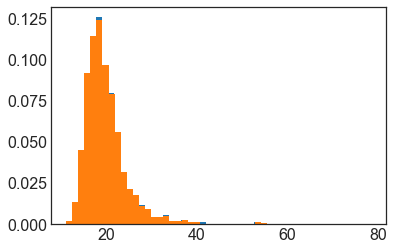

In [18]:
_=plt.hist(N_list2,density=True,bins=50)
_=plt.hist(NS_list2,density=True,bins=50)

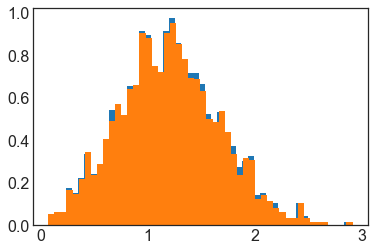

In [19]:
_=plt.hist(D_list2,density=True,bins=50)
_=plt.hist(DS_list2,density=True,bins=50)

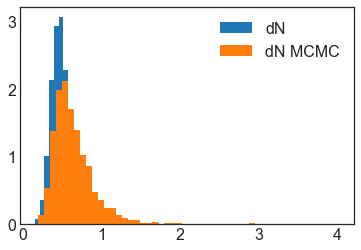

In [20]:
_=plt.hist(dN_list2,density=True,bins=50,label="dN")
_=plt.hist(dNS_list2,density=True,bins=50,label="dN MCMC")
plt.legend()

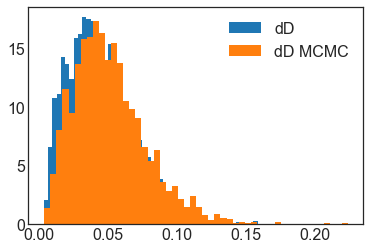

In [21]:
_=plt.hist(dD_list2,density=True,bins=50,label="dD")
_=plt.hist(dDS_list2,density=True,bins=50,label="dD MCMC")
plt.legend()

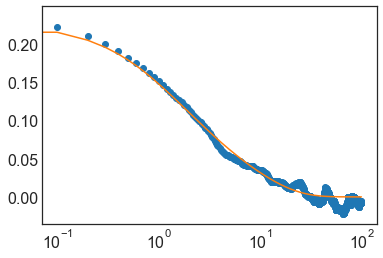

In [22]:
plt.semilogx(t,y,"o")
plt.semilogx(t,residual(result.params,t))

In [23]:
print("median of posterior probability distribution")
print('--------------------------------------------')
lm.report_fit(res.params)

median of posterior probability distribution
--------------------------------------------
[[Variables]]
    D:  1.11568990 +/- 0.04521540 (4.05%) (init = 1.114441)
    N:  19.3992511 +/- 0.59676381 (3.08%) (init = 19.39361)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.760


1.1990027052718584 0.46777579539193975 0.044850291294869296
1.201199994101557 0.46886310220188027 0.05155855833770738


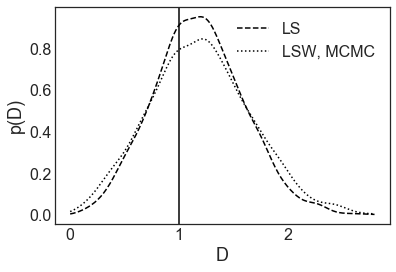

In [34]:
xd = np.linspace(0.0,2.8,200)
densityD2 = gaussian_kde(D_list2)
densityDS2 = gaussian_kde(DS_list2)
plt.figure(figsize=(6, 4))
plt.plot(xd,densityD(xd),"k--",label="LS")
plt.plot(xd,densityD2(xd),"k:",label="LSW, MCMC")
#plt.plot(xd,densityDS2(xd),"k:",label="LSW")
plt.axvline(x=1.0,color="k")
plt.xlabel("D")
plt.ylabel("p(D)")

plt.legend(loc='upper right')
print(D_list2.mean(),D_list2.std(),dD_list2.mean())
print(DS_list2.mean(),DS_list2.std(),dDS_list2.mean())
plt.savefig("FCS_D300shortkde.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

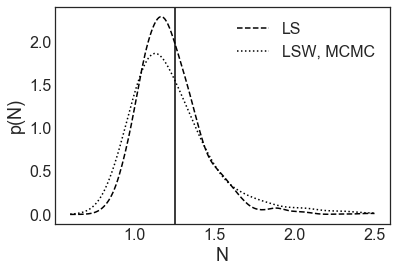

In [35]:
xn = np.linspace(0.6,2.5,200)
densityF2 = gaussian_kde(F_list2)
densityFS2 = gaussian_kde(FS_list2)
plt.figure(figsize=(6, 4))
plt.plot(xn,densityF(xn),"k--",label="LS")
plt.plot(xn,densityFS2(xn),"k:",label="LSW, MCMC")
plt.axvline(x=np.sqrt(np.pi/2),color="k")
plt.xlabel("N")
plt.ylabel("p(N)")

plt.legend()
plt.savefig("FCS_N300shortkde.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")